## Configuration

The configuration is the design of the neural network, it has the following parameters:  

1. loss: this is the metric for the loss function, and it can be: 'mse'=mean squared error (for continuous data), or 'ce' for cross entropy (for binary data)
2. distance_metric: this is the distance metric between the distributions and can either be 'mmd': maximum mean discrepency, or kl: Kullback–Leibler (see this blog for details: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/)
3. mmd_weight: this is how much you want to force the VAE to learn 

We're going to use two types of VAEs, 1 a normal VAE for the numeric quality data, 2 a conv VAE for the sequence data. To make the training data for the Conv VAE we want to one hot encode it such that each entry is is the sequence

e.g. our kmer would look like this if it was ATACAAC
```
A|1 0 1 0 1 1 0|
T|0 1 0 0 0 0 0|
G|0 0 0 0 0 0 0|
C|0 0 0 1 0 0 1| 
```
We want to do this with a filter that goes across 2 or more columns at once that we we can capture the spatial information. So we need to one hot encode in a special way (i.e. to make the columns)

In [4]:
import os
output_folder = '../runs/'
runs = os.listdir(output_folder)
exp_name = 'xylella'
xylella_csp1_15 = ['SRR17704200', 'SRR17704199', 'SRR17704201']
xylella_csp1_28 = ['SRR16009461', 'SRR16009462', 'SRR16009463']
xylella_wt_15 = ['SRR17704197', 'SRR17704198', 'SRR17704196']
xylella_wt_28 = ['SRR16009459', 'SRR16009460']

species_runs = xylella_csp1_15 + xylella_csp1_28 + xylella_wt_15 + xylella_wt_28

bams = [f'{output_folder}{run}' for run in runs if '.bai' not in run and '_genome.sorted' not in run and 'bam' in run]
bams = [b for b in bams if b.split('/')[-1].split('.')[0] in species_runs]
bams

['../runs/SRR17704200.sorted.bam',
 '../runs/SRR16009459.sorted.bam',
 '../runs/SRR17704197.sorted.bam',
 '../runs/SRR17704196.sorted.bam',
 '../runs/SRR17704198.sorted.bam',
 '../runs/SRR16009461.sorted.bam',
 '../runs/SRR16009462.sorted.bam',
 '../runs/SRR17704201.sorted.bam',
 '../runs/SRR16009460.sorted.bam',
 '../runs/SRR16009463.sorted.bam',
 '../runs/SRR17704199.sorted.bam']

## Count reads to genes

In [2]:
import pandas as pd

ecoli_info = pd.read_csv(f'{output_folder}{species_runs[0]}.csv')
ecoli_info['gtf_file'].values[0]

'/media/WorkingSpace/Ariane/output/bacteria/genomes/GCF_021459925.1_ASM2145992v1_genes-RNA.gff'

In [3]:
from scibacr import *
gtf = ecoli_info['gtf_file'].values[0]
fasta = ecoli_info['reference_fasta_path'].values[0].replace('.fna', '_transcripts.fasta')
# ID=gene-b0941;Dbxref=ASAP:ABE-0003191,ECOCYC:G6483,GeneID:947185;Name=elfG;gbkey=Gene;gene=elfG;gene_biotype=protein_coding;gene_synonym=ECK0932,ycbT;locus_tag=b0941

count_df = count_reads(bams, gtf, info_cols=['gene', 'gene_biotype'])
count_df

../runs/SRR17704200.sorted.bam 8588 98266 0.9196286521796095
../runs/SRR16009459.sorted.bam 10024 94690 0.9042725901025651
../runs/SRR17704197.sorted.bam 7900 54596 0.8735919098822325
../runs/SRR17704196.sorted.bam 13393 58772 0.8144114182775584
../runs/SRR17704198.sorted.bam 2922 11801 0.8015350132445833
../runs/SRR16009461.sorted.bam 1218 32991 0.9643953345610804
../runs/SRR16009462.sorted.bam 1683 42610 0.9620030253087395
../runs/SRR17704201.sorted.bam 3412 36806 0.9151623651101497
../runs/SRR16009460.sorted.bam 20986 179632 0.8953932349041462
../runs/SRR16009463.sorted.bam 347 4373 0.9264830508474576


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,gene,id,gene,gene_biotype,SRR17704200,SRR16009459,SRR17704197,SRR17704196,SRR17704198,SRR16009461,SRR16009462,SRR17704201,SRR16009460,SRR16009463,SRR17704199
0,gene-LZ752_RS00005,NZ_CP090518.1:0-1320,dnaA,protein_coding,61,56,26,64,15,6,2,12,117,1,49
1,gene-LZ752_RS04265,NZ_CP090518.1:1001089-1004152,None,protein_coding,23,11,12,28,9,2,2,16,21,0,12
2,gene-LZ752_RS04270,NZ_CP090518.1:1004197-1005004,None,protein_coding,10,14,5,6,4,1,1,4,19,1,7
3,gene-LZ752_RS04275,NZ_CP090518.1:1005044-1005371,None,protein_coding,13,8,14,17,4,1,2,5,12,0,10
4,gene-LZ752_RS04285,NZ_CP090518.1:1006093-1006333,None,protein_coding,18,33,7,8,0,2,2,3,49,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,gene-LZ752_RS04245,NZ_CP090518.1:998448-998727,None,protein_coding,10,6,6,5,1,1,0,1,10,0,6
2208,gene-LZ752_RS04250,NZ_CP090518.1:998741-999035,None,protein_coding,7,14,8,9,2,3,2,1,13,0,8
2209,gene-LZ752_RS04255,NZ_CP090518.1:999287-999905,None,protein_coding,20,9,4,12,2,1,0,9,10,0,9
2210,gene-LZ752_RS00370,NZ_CP090518.1:99974-100895,None,protein_coding,25,20,10,5,4,4,1,6,44,0,20


(array([200., 164., 213., 289., 376., 395., 283., 141.,  96.,  25.,  10.,
          8.,   4.,   2.,   1.,   0.,   1.,   0.,   0.,   4.]),
 array([ 0.        ,  0.66944979,  1.33889957,  2.00834936,  2.67779914,
         3.34724893,  4.01669871,  4.6861485 ,  5.35559829,  6.02504807,
         6.69449786,  7.36394764,  8.03339743,  8.70284722,  9.372297  ,
        10.04174679, 10.71119657, 11.38064636, 12.05009614, 12.71954593,
        13.38899572]),
 <BarContainer object of 20 artists>)

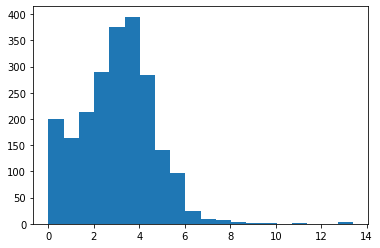

In [4]:
mean_counts = np.mean(count_df[[c for c in count_df.columns if 'SRR' in c]], axis=1)
plt.hist(np.log2(mean_counts + 1), bins=20)

In [5]:
count_df_nn = count_df[mean_counts > 2.5]
# Drop any genes that didn't have any counts then save
count_df_nn.to_csv(f'{output_folder}counts_abundent.csv', index=False)


In [6]:
count_df_nn

,gene,id,gene,gene_biotype,SRR17704200,SRR16009459,SRR17704197,SRR17704196,SRR17704198,SRR16009461,SRR16009462,SRR17704201,SRR16009460,SRR16009463,SRR17704199
0,gene-LZ752_RS00005,NZ_CP090518.1:0-1320,dnaA,protein_coding,61,56,26,64,15,6,2,12,117,1,49
1,gene-LZ752_RS04265,NZ_CP090518.1:1001089-1004152,None,protein_coding,23,11,12,28,9,2,2,16,21,0,12
2,gene-LZ752_RS04270,NZ_CP090518.1:1004197-1005004,None,protein_coding,10,14,5,6,4,1,1,4,19,1,7
3,gene-LZ752_RS04275,NZ_CP090518.1:1005044-1005371,None,protein_coding,13,8,14,17,4,1,2,5,12,0,10
4,gene-LZ752_RS04285,NZ_CP090518.1:1006093-1006333,None,protein_coding,18,33,7,8,0,2,2,3,49,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,gene-LZ752_RS04245,NZ_CP090518.1:998448-998727,None,protein_coding,10,6,6,5,1,1,0,1,10,0,6
2208,gene-LZ752_RS04250,NZ_CP090518.1:998741-999035,None,protein_coding,7,14,8,9,2,3,2,1,13,0,8
2209,gene-LZ752_RS04255,NZ_CP090518.1:999287-999905,None,protein_coding,20,9,4,12,2,1,0,9,10,0,9
2210,gene-LZ752_RS00370,NZ_CP090518.1:99974-100895,None,protein_coding,25,20,10,5,4,4,1,6,44,0,20


## Write a MSA so we can double check the choices make sense

In [ ]:
species_columns = [c for c in count_df.columns if 'SRR' in c]
species_df = count_df_nn[['id', 'species'] + species_columns]

min_counts = np.min(species_df[species_columns].values, axis=1)
# Get the genes that had at least 30 counts in each...
species_df = species_df[min_counts > 30]
gene_location = 'GB_GCA_014170915.1~CP059988.1-#2' # psi is at 512.
ref = pysam.FastaFile(f'{genome_dir}ssu_all_r207_gr1400.fna')
for bam in bams:
    samfile = pysam.AlignmentFile(f'{bam}', "rb")
    write_msa_over_gene(gene_location, samfile, ref, f'{output_folder}msas/{bam.split("/")[-1].split(".")[0]}.msa',
                        read_dict=read_dict)
    samfile.close()

## Create the h5 files that will be used for training and testing

In [7]:
fasta = ecoli_info['reference_fasta_path'].values[0].replace('.fna', '_transcripts.fasta')

for bam in bams:
    print(bam)
    read_dict = gen_mapping_gene_read_dict(bam, gtf)
    output_name = f'{output_folder}training_new/{bam.split("/")[-1].split(".")[0]}_training.h5'
    gen_training_h5py_position(bam, fasta, read_dict,
                                   output_filename=output_name,
                                   min_coverage=20, max_coverage=100)

../runs/SRR17704200.sorted.bam


  0%| | 10/2017 [00:00<00:43, 45.74it

SRR17704200.211755
SRR17704200.265967
SRR17704200.176653
SRR17704200.193990
SRR17704200.194963
SRR17704200.229089
SRR17704200.265429
SRR17704200.202000
SRR17704200.245030
SRR17704200.196916


  1%| | 23/2017 [00:00<00:26, 76.10it

SRR17704200.223129
SRR17704200.214922
SRR17704200.264685
SRR17704200.180668
SRR17704200.199750
SRR17704200.227187


  2%| | 47/2017 [00:00<00:24, 81.10it

SRR17704200.174565
SRR17704200.269391
SRR17704200.270790
SRR17704200.174421
SRR17704200.175490
SRR17704200.202229
SRR17704200.256595
SRR17704200.191982
SRR17704200.255463
SRR17704200.240037
SRR17704200.349649
SRR17704200.325853
SRR17704200.257598
SRR17704200.321955
SRR17704200.221506
SRR17704200.328253
SRR17704200.328253
SRR17704200.332740
SRR17704200.321993
SRR17704200.257442
SRR17704200.211677
SRR17704200.208008
SRR17704200.188136
SRR17704200.243433


  3%| | 56/2017 [00:00<00:31, 61.64it

SRR17704200.230333
SRR17704200.182849
SRR17704200.243398
SRR17704200.184927
SRR17704200.184927
SRR17704200.184927
SRR17704200.257034
SRR17704200.319284
SRR17704200.281794
SRR17704200.207531
SRR17704200.149746
SRR17704200.200630
SRR17704200.286093
SRR17704200.313277


  3%| | 64/2017 [00:01<00:33, 57.98it

SRR17704200.205244
SRR17704200.242961
SRR17704200.189006
SRR17704200.194864
SRR17704200.196537
SRR17704200.210508
SRR17704200.211980
SRR17704200.176565
SRR17704200.221573
SRR17704200.287207
SRR17704200.228920
SRR17704200.251569
SRR17704200.253114
SRR17704200.207257


  4%| | 81/2017 [00:01<00:25, 76.34it

SRR17704200.193083
SRR17704200.200771
SRR17704200.339519
SRR17704200.174589
SRR17704200.287813
SRR17704200.338592
SRR17704200.172811


  4%| | 90/2017 [00:01<00:37, 51.10it

SRR17704200.187490
SRR17704200.215638
SRR17704200.279961
SRR17704200.214539
SRR17704200.261842
SRR17704200.333007
SRR17704200.305144
SRR17704200.194713
SRR17704200.201607
SRR17704200.331610
SRR17704200.176529
SRR17704200.296622
SRR17704200.296622
SRR17704200.236294
SRR17704200.268568
SRR17704200.218659
SRR17704200.24678
SRR17704200.174896
SRR17704200.194948
SRR17704200.173879
SRR17704200.246677
SRR17704200.217044
SRR17704200.218605
SRR17704200.194200
SRR17704200.253678
SRR17704200.338915
SRR17704200.194200
SRR17704200.197658
SRR17704200.223820
SRR17704200.335512
SRR17704200.295515
SRR17704200.292520
SRR17704200.198880


  5%| | 97/2017 [00:01<00:41, 45.91it

SRR17704200.198399
SRR17704200.191452
SRR17704200.198399
SRR17704200.162424
SRR17704200.214723
SRR17704200.329948
SRR17704200.213663
SRR17704200.227441
SRR17704200.101865
SRR17704200.178089
SRR17704200.272186
SRR17704200.194562
SRR17704200.210808
SRR17704200.183934


  5%| | 103/2017 [00:01<00:44, 42.76i

SRR17704200.180892
SRR17704200.229275
SRR17704200.218368
SRR17704200.203564
SRR17704200.187599
SRR17704200.187599
SRR17704200.249245
SRR17704200.258304
SRR17704200.227805
SRR17704200.328401
SRR17704200.233326


  6%| | 126/2017 [00:02<00:28, 66.12i

SRR17704200.174059
SRR17704200.288495
SRR17704200.258401
SRR17704200.265276
SRR17704200.172774
SRR17704200.195819
SRR17704200.186718
SRR17704200.306684
SRR17704200.194896
SRR17704200.235475
SRR17704200.100044
SRR17704200.222079
SRR17704200.326462
SRR17704200.214814
SRR17704200.333572
SRR17704200.289796
SRR17704200.188607
SRR17704200.225975
SRR17704200.209481
SRR17704200.214274
SRR17704200.321385
SRR17704200.321385
SRR17704200.309495
SRR17704200.312060
SRR17704200.347904
SRR17704200.244958
SRR17704200.229537
SRR17704200.192344
SRR17704200.222436
SRR17704200.280983
SRR17704200.251494
SRR17704200.172894
SRR17704200.253631
SRR17704200.218335
SRR17704200.245359
SRR17704200.250804
SRR17704200.285978
SRR17704200.290333
SRR17704200.339379
SRR17704200.333156
SRR17704200.197297
SRR17704200.194213
SRR17704200.341309


  7%| | 134/2017 [00:02<00:40, 46.22i

SRR17704200.338201
SRR17704200.251810
SRR17704200.266582
SRR17704200.255348
SRR17704200.195419
SRR17704200.220055
SRR17704200.328689
SRR17704200.228032
SRR17704200.239718
SRR17704200.255095
SRR17704200.185777
SRR17704200.208599
SRR17704200.208599
SRR17704200.230844
SRR17704200.188014
SRR17704200.235098
SRR17704200.208599
SRR17704200.208599
SRR17704200.219647
SRR17704200.282433
SRR17704200.173258
SRR17704200.252335
SRR17704200.322972


  8%| | 160/2017 [00:02<00:28, 64.18i

SRR17704200.345093
SRR17704200.175114
SRR17704200.230043
SRR17704200.277928
SRR17704200.52661
SRR17704200.350297
SRR17704200.352822
SRR17704200.312646
SRR17704200.198906
SRR17704200.252818
SRR17704200.276298
SRR17704200.321441
SRR17704200.66362
SRR17704200.214619


 11%| | 220/2017 [00:03<00:12, 149.64

SRR17704200.302145
SRR17704200.302145
SRR17704200.229694
SRR17704200.175279
SRR17704200.202392
SRR17704200.203364
SRR17704200.201417
SRR17704200.274640
SRR17704200.261003
SRR17704200.231817
SRR17704200.260614
SRR17704200.260614
SRR17704200.260614
SRR17704200.321835
SRR17704200.215114


 12%| | 242/2017 [00:03<00:11, 158.63

SRR17704200.183434
SRR17704200.297842
SRR17704200.233214
SRR17704200.249584
SRR17704200.225822
SRR17704200.224542
SRR17704200.196487
SRR17704200.328853
SRR17704200.334919
SRR17704200.174347
SRR17704200.296605
SRR17704200.215339
SRR17704200.215339
SRR17704200.346603
SRR17704200.346603
SRR17704200.346603
SRR17704200.207232
SRR17704200.233103
SRR17704200.212342
SRR17704200.198703
SRR17704200.234420
SRR17704200.296507
SRR17704200.179872
SRR17704200.233227
SRR17704200.176972
SRR17704200.175007
SRR17704200.270626
SRR17704200.308415
SRR17704200.207097
SRR17704200.196217
SRR17704200.254520
SRR17704200.205051
SRR17704200.204080
SRR17704200.197843
SRR17704200.290786
SRR17704200.266979
SRR17704200.276892
SRR17704200.246472
SRR17704200.284747
SRR17704200.247456
SRR17704200.224995
SRR17704200.278237
SRR17704200.305146
SRR17704200.344913
SRR17704200.338688
SRR17704200.174548
SRR17704200.215864
SRR17704200.299744
SRR17704200.284822
SRR17704200.200631
SRR17704200.329911
SRR17704200.347763
SRR17704200.

 13%|▏| 261/2017 [00:03<00:17, 98.99i

SRR17704200.265207
SRR17704200.210691
SRR17704200.189727
SRR17704200.196230
SRR17704200.291268
SRR17704200.348778
SRR17704200.277931
SRR17704200.282181
SRR17704200.259848
SRR17704200.248902
SRR17704200.245014
SRR17704200.192463
SRR17704200.340955
SRR17704200.351716
SRR17704200.233592
SRR17704200.233592
SRR17704200.233592
SRR17704200.349971
SRR17704200.307132
SRR17704200.274850
SRR17704200.249822
SRR17704200.179061


 14%|▏| 276/2017 [00:03<00:23, 73.25i

SRR17704200.272440
SRR17704200.196921
SRR17704200.333032
SRR17704200.204392
SRR17704200.205664
SRR17704200.205664
SRR17704200.196249
SRR17704200.219532
SRR17704200.204556
SRR17704200.227046
SRR17704200.252829
SRR17704200.177403
SRR17704200.252829
SRR17704200.239101
SRR17704200.233529
SRR17704200.177403
SRR17704200.198226
SRR17704200.193716
SRR17704200.220801
SRR17704200.230613
SRR17704200.186866
SRR17704200.213798
SRR17704200.175018
SRR17704200.230942
SRR17704200.230725
SRR17704200.235181
SRR17704200.229523
SRR17704200.209403
SRR17704200.249248
SRR17704200.217440


 14%|▏| 284/2017 [00:23<10:47,  2.68i

SRR17704200.194824
SRR17704200.190496
SRR17704200.190496
SRR17704200.221038
SRR17704200.187752
SRR17704200.312476
SRR17704200.235342
SRR17704200.200015
SRR17704200.203736
SRR17704200.270332
SRR17704200.244630
SRR17704200.228477


 15%|▏| 293/2017 [00:23<08:08,  3.53i

SRR17704200.197593
SRR17704200.213001
SRR17704200.225336
SRR17704200.233053
SRR17704200.224515
SRR17704200.221922
SRR17704200.209440
SRR17704200.224855
SRR17704200.188592
SRR17704200.242828
SRR17704200.205380
SRR17704200.343665
SRR17704200.216887
SRR17704200.279321
SRR17704200.202670
SRR17704200.276578
SRR17704200.236838
SRR17704200.317143
SRR17704200.245989
SRR17704200.245316
SRR17704200.202073


 16%|▏| 331/2017 [00:23<02:44, 10.25i

SRR17704200.220820
SRR17704200.312417
SRR17704200.326439
SRR17704200.234072
SRR17704200.263623
SRR17704200.290123
SRR17704200.282553
SRR17704200.183754
SRR17704200.336393
SRR17704200.214616
SRR17704200.203512
SRR17704200.175575
SRR17704200.198630
SRR17704200.307368
SRR17704200.222164
SRR17704200.231070
SRR17704200.337126


 17%|▏| 344/2017 [00:24<02:07, 13.13i

SRR17704200.197446
SRR17704200.248487
SRR17704200.179984
SRR17704200.251207
SRR17704200.173419
SRR17704200.252608
SRR17704200.220220
SRR17704200.235382
SRR17704200.209276
SRR17704200.250742
SRR17704200.252092
SRR17704200.232225
SRR17704200.339324
SRR17704200.210053


 18%|▏| 367/2017 [00:24<01:19, 20.65i

SRR17704200.176369
SRR17704200.239092
SRR17704200.211954
SRR17704200.323893
SRR17704200.260635
SRR17704200.192332
SRR17704200.243375
SRR17704200.241359
SRR17704200.238250
SRR17704200.249461
SRR17704200.349975
SRR17704200.288906
SRR17704200.337549
SRR17704200.288691
SRR17704200.199181
SRR17704200.194685
SRR17704200.334122
SRR17704200.346554
SRR17704200.236205


 19%|▏| 377/2017 [00:24<01:09, 23.67i

SRR17704200.192232
SRR17704200.320824
SRR17704200.320824
SRR17704200.233803
SRR17704200.352537
SRR17704200.352537
SRR17704200.352537
SRR17704200.249739
SRR17704200.216101
SRR17704200.282422
SRR17704200.303801
SRR17704200.311133
SRR17704200.232768


 21%|▏| 417/2017 [00:24<00:29, 53.73i

SRR17704200.338810
SRR17704200.187900
SRR17704200.228096
SRR17704200.210452
SRR17704200.263160
SRR17704200.229073
SRR17704200.333083
SRR17704200.197512
SRR17704200.211206
SRR17704200.242678
SRR17704200.272824
SRR17704200.326944
SRR17704200.224240
SRR17704200.225676
SRR17704200.176236
SRR17704200.295167


 21%|▏| 431/2017 [00:25<00:26, 60.59i

SRR17704200.228644
SRR17704200.228572
SRR17704200.318030
SRR17704200.183417
SRR17704200.251213
SRR17704200.215779
SRR17704200.222263
SRR17704200.211464
SRR17704200.204819
SRR17704200.319698
SRR17704200.200817
SRR17704200.200817
SRR17704200.200817
SRR17704200.200817
SRR17704200.200817
SRR17704200.264595
SRR17704200.205164
SRR17704200.198066
SRR17704200.193294
SRR17704200.274941
SRR17704200.260881


 25%|▏| 503/2017 [00:25<00:11, 135.68

SRR17704200.259564
SRR17704200.306322
SRR17704200.252031
SRR17704200.290469
SRR17704200.199961
SRR17704200.212573
SRR17704200.176713
SRR17704200.193872
SRR17704200.252999
SRR17704200.183372
SRR17704200.247955
SRR17704200.245366
SRR17704200.333328
SRR17704200.200507
SRR17704200.256075
SRR17704200.318779
SRR17704200.202707
SRR17704200.202061
SRR17704200.303655
SRR17704200.97573
SRR17704200.199378
SRR17704200.236401
SRR17704200.233253
SRR17704200.290045
SRR17704200.212121
SRR17704200.270388
SRR17704200.293237
SRR17704200.262516
SRR17704200.203656
SRR17704200.209322
SRR17704200.279499
SRR17704200.317136
SRR17704200.210394
SRR17704200.296070
SRR17704200.227749
SRR17704200.300965
SRR17704200.190735
SRR17704200.327368
SRR17704200.260814


 27%|▎| 544/2017 [00:25<00:12, 120.44

SRR17704200.224347
SRR17704200.192660
SRR17704200.192660
SRR17704200.192660
SRR17704200.192660
SRR17704200.192660
SRR17704200.192660
SRR17704200.250299
SRR17704200.335725
SRR17704200.237716
SRR17704200.224573
SRR17704200.284699
SRR17704200.288016
SRR17704200.243129
SRR17704200.207432
SRR17704200.336524
SRR17704200.207432
SRR17704200.207432
SRR17704200.207432
SRR17704200.272237
SRR17704200.221705
SRR17704200.221705
SRR17704200.218483
SRR17704200.272197
SRR17704200.281972


 29%|▎| 585/2017 [00:25<00:10, 133.95

SRR17704200.231680
SRR17704200.337121
SRR17704200.338553
SRR17704200.249378
SRR17704200.311216
SRR17704200.320264
SRR17704200.194074
SRR17704200.205771
SRR17704200.304257
SRR17704200.216210
SRR17704200.206623
SRR17704200.331320
SRR17704200.205104
SRR17704200.212747
SRR17704200.209522
SRR17704200.308286
SRR17704200.214291
SRR17704200.214291
SRR17704200.214291
SRR17704200.214291
SRR17704200.214291
SRR17704200.214291
SRR17704200.214291
SRR17704200.214291
SRR17704200.303983
SRR17704200.61958
SRR17704200.61958
SRR17704200.61958
SRR17704200.247951
SRR17704200.247951
SRR17704200.264270


 31%|▎| 618/2017 [00:26<00:14, 97.91i

SRR17704200.232216
SRR17704200.247395
SRR17704200.330985
SRR17704200.251974
SRR17704200.213394
SRR17704200.307086
SRR17704200.303122
SRR17704200.265975
SRR17704200.320403
SRR17704200.320403
SRR17704200.237932
SRR17704200.237932
SRR17704200.198634


 31%|▎| 635/2017 [00:26<00:12, 107.32

SRR17704200.297825
SRR17704200.272732
SRR17704200.231948
SRR17704200.217966
SRR17704200.217919
SRR17704200.234653
SRR17704200.212210
SRR17704200.196205
SRR17704200.195498
SRR17704200.337108
SRR17704200.267186
SRR17704200.202364
SRR17704200.329760
SRR17704200.319131
SRR17704200.341633
SRR17704200.222634
SRR17704200.219274
SRR17704200.229644
SRR17704200.347601
SRR17704200.194203
SRR17704200.193699
SRR17704200.325766
SRR17704200.229469
SRR17704200.254568
SRR17704200.290727
SRR17704200.289175
SRR17704200.207938


 33%|▎| 666/2017 [00:26<00:14, 92.61i

SRR17704200.276938
SRR17704200.244062
SRR17704200.333745
SRR17704200.293498
SRR17704200.308443
SRR17704200.292822
SRR17704200.321660
SRR17704200.274336
SRR17704200.243734
SRR17704200.321130
SRR17704200.272228
SRR17704200.223142
SRR17704200.51294
SRR17704200.192251
SRR17704200.104190
SRR17704200.178163
SRR17704200.270789
SRR17704200.215768
SRR17704200.222343
SRR17704200.219003
SRR17704200.292606
SRR17704200.352903
SRR17704200.269781
SRR17704200.315770
SRR17704200.296378
SRR17704200.272805
SRR17704200.216357
SRR17704200.202291
SRR17704200.265060


 34%|▎| 679/2017 [00:34<03:10,  7.01i

SRR17704200.218073


 34%|▎| 688/2017 [00:50<10:15,  2.16i

SRR17704200.234209
SRR17704200.278729
SRR17704200.304295
SRR17704200.289591
SRR17704200.304678
SRR17704200.250676
SRR17704200.215738
SRR17704200.342360
SRR17704200.265064
SRR17704200.209265


 34%|▎| 691/2017 [00:50<09:26,  2.34i

SRR17704200.223940
SRR17704200.310380
SRR17704200.337480
SRR17704200.240712
SRR17704200.337480
SRR17704200.239184
SRR17704200.178630
SRR17704200.228858
SRR17704200.190271
SRR17704200.200627
SRR17704200.212913
SRR17704200.194571
SRR17704200.234199
SRR17704200.201307
SRR17704200.184427


 35%|▎| 705/2017 [00:50<05:46,  3.79i

SRR17704200.197498
SRR17704200.296127
SRR17704200.201790
SRR17704200.298354
SRR17704200.197456
SRR17704200.228120
SRR17704200.267354
SRR17704200.228933
SRR17704200.200750
SRR17704200.175933
SRR17704200.338720
SRR17704200.229970
SRR17704200.231030
SRR17704200.204706
SRR17704200.216714
SRR17704200.188646
SRR17704200.248002
SRR17704200.337430


 36%|▎| 727/2017 [00:50<02:47,  7.72i

SRR17704200.279850
SRR17704200.192412
SRR17704200.326657
SRR17704200.353099
SRR17704200.192438
SRR17704200.309146
SRR17704200.216491
SRR17704200.221951
SRR17704200.191733
SRR17704200.319705
SRR17704200.197901
SRR17704200.256499
SRR17704200.245099
SRR17704200.218898


 37%|▎| 737/2017 [00:50<02:10,  9.84i

SRR17704200.224597
SRR17704200.258280
SRR17704200.291054
SRR17704200.269254
SRR17704200.173921
SRR17704200.269254
SRR17704200.244720
SRR17704200.310996
SRR17704200.183056
SRR17704200.242838
SRR17704200.224387
SRR17704200.261425
SRR17704200.268126
SRR17704200.256064


 37%|▎| 746/2017 [00:51<01:48, 11.75i

SRR17704200.275266
SRR17704200.218864
SRR17704200.174876
SRR17704200.249544
SRR17704200.213221
SRR17704200.258314
SRR17704200.279303
SRR17704200.276221
SRR17704200.276221
SRR17704200.201924
SRR17704200.210393
SRR17704200.205349
SRR17704200.237606
SRR17704200.241211
SRR17704200.302029
SRR17704200.249313


 39%|▍| 780/2017 [00:51<00:47, 26.08i

SRR17704200.223698
SRR17704200.197725
SRR17704200.187848
SRR17704200.257463
SRR17704200.190374
SRR17704200.189531
SRR17704200.245968
SRR17704200.344856
SRR17704200.276172
SRR17704200.202350
SRR17704200.345851
SRR17704200.284775
SRR17704200.287714
SRR17704200.193213
SRR17704200.211729
SRR17704200.191099
SRR17704200.220526
SRR17704200.258777
SRR17704200.184542
SRR17704200.184542
SRR17704200.261041


 39%|▍| 791/2017 [00:51<00:40, 30.29i

SRR17704200.233033
SRR17704200.201680
SRR17704200.201680
SRR17704200.297429
SRR17704200.325801
SRR17704200.298192
SRR17704200.262807
SRR17704200.205128
SRR17704200.273394
SRR17704200.213540


 41%|▍| 832/2017 [00:51<00:18, 62.62i

SRR17704200.338556
SRR17704200.192961
SRR17704200.260559
SRR17704200.333336
SRR17704200.192874
SRR17704200.284478
SRR17704200.268159
SRR17704200.194655
SRR17704200.275260
SRR17704200.344151
SRR17704200.351582
SRR17704200.281164
SRR17704200.281164
SRR17704200.281164


 43%|▍| 858/2017 [00:52<00:13, 87.21i

SRR17704200.300903
SRR17704200.211129
SRR17704200.225769
SRR17704200.222403
SRR17704200.222403
SRR17704200.269060
SRR17704200.236574
SRR17704200.229295
SRR17704200.292807
SRR17704200.331524
SRR17704200.200480
SRR17704200.285349


 43%|▍| 874/2017 [00:52<00:14, 77.74i

SRR17704200.172824
SRR17704200.249712
SRR17704200.344756
SRR17704200.253835
SRR17704200.182726
SRR17704200.182726
SRR17704200.185569
SRR17704200.212220
SRR17704200.341371


 44%|▍| 887/2017 [00:52<00:17, 65.46i

SRR17704200.241851
SRR17704200.338757
SRR17704200.204148
SRR17704200.177589
SRR17704200.236970
SRR17704200.333537
SRR17704200.244844
SRR17704200.213038
SRR17704200.308604
SRR17704200.195334
SRR17704200.270745
SRR17704200.225326
SRR17704200.226708
SRR17704200.185106
SRR17704200.245636
SRR17704200.301455
SRR17704200.217108
SRR17704200.182894


 45%|▍| 900/2017 [00:52<00:15, 73.85i

SRR17704200.90473
SRR17704200.205667
SRR17704200.225755
SRR17704200.204161
SRR17704200.259654
SRR17704200.221987
SRR17704200.214445
SRR17704200.247285
SRR17704200.69401
SRR17704200.239061
SRR17704200.193821
SRR17704200.253400


 45%|▍| 911/2017 [00:52<00:16, 68.86i

SRR17704200.236478
SRR17704200.211521
SRR17704200.332998
SRR17704200.342696
SRR17704200.342818
SRR17704200.184467
SRR17704200.295569
SRR17704200.335326
SRR17704200.189927
SRR17704200.214217
SRR17704200.269633
SRR17704200.304258
SRR17704200.339115
SRR17704200.176425
SRR17704200.217510
SRR17704200.177024
SRR17704200.180334


 46%|▍| 921/2017 [00:53<00:18, 60.42i

SRR17704200.353307
SRR17704200.353307
SRR17704200.353307
SRR17704200.353307
SRR17704200.230915
SRR17704200.202609
SRR17704200.241577
SRR17704200.278726
SRR17704200.204735
SRR17704200.218488
SRR17704200.278726
SRR17704200.278726
SRR17704200.336192
SRR17704200.294545
SRR17704200.248744
SRR17704200.294030
SRR17704200.244752
SRR17704200.236985
SRR17704200.336332
SRR17704200.194493


 46%|▍| 929/2017 [00:53<00:30, 35.21i

SRR17704200.286499
SRR17704200.336494
SRR17704200.352330
SRR17704200.270608
SRR17704200.229538
SRR17704200.306858
SRR17704200.231708
SRR17704200.197841
SRR17704200.291157
SRR17704200.276775
SRR17704200.300224


 47%|▍| 941/2017 [00:54<00:29, 36.57i

SRR17704200.209338
SRR17704200.238777
SRR17704200.200833
SRR17704200.236406
SRR17704200.196034
SRR17704200.204042
SRR17704200.207587
SRR17704200.228776
SRR17704200.331889
SRR17704200.338663
SRR17704200.282112
SRR17704200.176189
SRR17704200.180561
SRR17704200.180561
SRR17704200.254593
SRR17704200.331025
SRR17704200.227436
SRR17704200.220738
SRR17704200.251251
SRR17704200.349860
SRR17704200.284917
SRR17704200.352317
SRR17704200.322429
SRR17704200.58811
SRR17704200.292100
SRR17704200.283452
SRR17704200.299780
SRR17704200.243480
SRR17704200.219475
SRR17704200.220679
SRR17704200.215109


 47%|▍| 951/2017 [00:54<00:27, 39.06i

SRR17704200.245152
SRR17704200.177892
SRR17704200.253697
SRR17704200.250535
SRR17704200.211658
SRR17704200.212563
SRR17704200.242707
SRR17704200.242707
SRR17704200.242707
SRR17704200.241449
SRR17704200.241449
SRR17704200.241449
SRR17704200.225234
SRR17704200.207104
SRR17704200.287130


 48%|▍| 967/2017 [00:54<00:23, 45.21i

SRR17704200.248548
SRR17704200.315153
SRR17704200.313298
SRR17704200.270165


 49%|▍| 985/2017 [00:54<00:14, 70.18i

SRR17704200.317943
SRR17704200.226044
SRR17704200.226980
SRR17704200.229461
SRR17704200.196559
SRR17704200.282157
SRR17704200.234979
SRR17704200.260298
SRR17704200.272845
SRR17704200.305002


 50%|▍| 1002/2017 [00:54<00:15, 64.00

SRR17704200.196633
SRR17704200.196633
SRR17704200.196633
SRR17704200.203021
SRR17704200.260732
SRR17704200.225688
SRR17704200.306983
SRR17704200.270258
SRR17704200.189982
SRR17704200.28426
SRR17704200.28426
SRR17704200.28426
SRR17704200.28426
SRR17704200.28426
SRR17704200.28426
SRR17704200.293311
SRR17704200.214219
SRR17704200.289213
SRR17704200.205077
SRR17704200.232733
SRR17704200.234570
SRR17704200.234570
SRR17704200.235378
SRR17704200.346515
SRR17704200.346515
SRR17704200.346515
SRR17704200.280871
SRR17704200.280871


 51%|▌| 1022/2017 [00:55<00:13, 75.02

SRR17704200.280871
SRR17704200.331050
SRR17704200.187994
SRR17704200.270513
SRR17704200.199968
SRR17704200.348342
SRR17704200.293709
SRR17704200.289420
SRR17704200.252875
SRR17704200.174617
SRR17704200.209065
SRR17704200.338345
SRR17704200.265862
SRR17704200.204944
SRR17704200.315167
SRR17704200.232964
SRR17704200.252464
SRR17704200.328382
SRR17704200.190438
SRR17704200.214359
SRR17704200.228943
SRR17704200.199367
SRR17704200.283878
SRR17704200.229278
SRR17704200.228926
SRR17704200.214709
SRR17704200.179704
SRR17704200.286059
SRR17704200.222808
SRR17704200.217219
SRR17704200.324112
SRR17704200.218040


 51%|▌| 1031/2017 [00:55<00:13, 75.60

SRR17704200.231695
SRR17704200.293890
SRR17704200.227360
SRR17704200.248087
SRR17704200.216511
SRR17704200.249238
SRR17704200.323556
SRR17704200.242933
SRR17704200.199919
SRR17704200.231377
SRR17704200.269024
SRR17704200.293672
SRR17704200.219065
SRR17704200.193757
SRR17704200.212715
SRR17704200.236048
SRR17704200.289774


 53%|▌| 1062/2017 [00:55<00:10, 88.97

SRR17704200.253179
SRR17704200.191548
SRR17704200.291857
SRR17704200.293654
SRR17704200.237343
SRR17704200.186994
SRR17704200.249957
SRR17704200.236664
SRR17704200.263047
SRR17704200.259567
SRR17704200.223876
SRR17704200.283903


 53%|▌| 1072/2017 [00:55<00:11, 80.24

SRR17704200.197527
SRR17704200.190902
SRR17704200.201354
SRR17704200.307330
SRR17704200.287535
SRR17704200.178356
SRR17704200.329536
SRR17704200.267765
SRR17704200.212381
SRR17704200.284112


 54%|▌| 1095/2017 [00:55<00:10, 91.84

SRR17704200.247546
SRR17704200.312056
SRR17704200.214747
SRR17704200.38489
SRR17704200.214425
SRR17704200.305603
SRR17704200.216168
SRR17704200.204624
SRR17704200.219990
SRR17704200.174628
SRR17704200.323115


 55%|▌| 1119/2017 [00:56<00:09, 94.06

SRR17704200.307880
SRR17704200.307880
SRR17704200.307880
SRR17704200.303259
SRR17704200.196810
SRR17704200.191178
SRR17704200.176923
SRR17704200.220483
SRR17704200.267092
SRR17704200.322957
SRR17704200.217022
SRR17704200.256724
SRR17704200.288750
SRR17704200.227508
SRR17704200.177536
SRR17704200.335986
SRR17704200.175840
SRR17704200.261215
SRR17704200.352108


 56%|▌| 1129/2017 [00:56<00:12, 69.56

SRR17704200.200568
SRR17704200.200568
SRR17704200.175762
SRR17704200.191400
SRR17704200.267380
SRR17704200.326309
SRR17704200.221479
SRR17704200.332090
SRR17704200.278056
SRR17704200.226727
SRR17704200.195242
SRR17704200.246523
SRR17704200.250750
SRR17704200.234079
SRR17704200.225923
SRR17704200.333063
SRR17704200.300301
SRR17704200.195213
SRR17704200.334625
SRR17704200.196713


 57%|▌| 1155/2017 [00:56<00:08, 103.9

SRR17704200.292136
SRR17704200.271856
SRR17704200.335579
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.268328
SRR17704200.198850
SRR17704200.221613
SRR17704200.221613
SRR17704200.328307
SRR17704200.350273
SRR17704200.233315
SRR17704200.313877
SRR17704200.218309
SRR17704200.304709
SRR17704200.353686
SRR17704200.186503
SRR17704200.285039
SRR17704200.281386
SRR17704200.219312


 58%|▌| 1168/2017 [00:56<00:09, 89.69

SRR17704200.217574
SRR17704200.297329
SRR17704200.291086
SRR17704200.279651
SRR17704200.330388
SRR17704200.283423
SRR17704200.218494
SRR17704200.218494
SRR17704200.218494
SRR17704200.294027
SRR17704200.298685
SRR17704200.204334
SRR17704200.275651
SRR17704200.235053
SRR17704200.258125
SRR17704200.300566
SRR17704200.321442
SRR17704200.345939


 58%|▌| 1179/2017 [00:57<00:12, 65.26

SRR17704200.269654
SRR17704200.339182
SRR17704200.241052
SRR17704200.303076
SRR17704200.178321
SRR17704200.191051
SRR17704200.208443
SRR17704200.174564
SRR17704200.205136
SRR17704200.261331
SRR17704200.200593


 59%|▌| 1188/2017 [00:57<00:13, 60.02

SRR17704200.252042
SRR17704200.222505
SRR17704200.235874
SRR17704200.227442
SRR17704200.210860
SRR17704200.242858
SRR17704200.188448
SRR17704200.198562
SRR17704200.312699
SRR17704200.236145
SRR17704200.279758


 59%|▌| 1196/2017 [00:57<00:13, 59.61

SRR17704200.255096
SRR17704200.353017
SRR17704200.303796
SRR17704200.196006
SRR17704200.277294
SRR17704200.277294
SRR17704200.238517
SRR17704200.259127
SRR17704200.227193
SRR17704200.246261
SRR17704200.176752
SRR17704200.198125
SRR17704200.320954
SRR17704200.258064
SRR17704200.287504
SRR17704200.217921
SRR17704200.180477
SRR17704200.192450
SRR17704200.336861


 60%|▌| 1214/2017 [00:57<00:12, 62.87

SRR17704200.239054
SRR17704200.238309
SRR17704200.194906
SRR17704200.216805
SRR17704200.204142
SRR17704200.240987
SRR17704200.317015
SRR17704200.224194
SRR17704200.212152
SRR17704200.249418


 61%|▌| 1224/2017 [00:57<00:11, 68.99

SRR17704200.227361
SRR17704200.215113
SRR17704200.318211
SRR17704200.332441
SRR17704200.202493
SRR17704200.349592
SRR17704200.197035
SRR17704200.186515
SRR17704200.218657
SRR17704200.290830
SRR17704200.188083
SRR17704200.228905
SRR17704200.251715
SRR17704200.227809
SRR17704200.294228


 61%|▌| 1232/2017 [00:58<00:17, 45.43

SRR17704200.255468
SRR17704200.350258
SRR17704200.308653
SRR17704200.308653
SRR17704200.55958
SRR17704200.308653
SRR17704200.243717
SRR17704200.269178
SRR17704200.272446
SRR17704200.238085
SRR17704200.197567
SRR17704200.341989
SRR17704200.322811
SRR17704200.173861
SRR17704200.301817
SRR17704200.215531
SRR17704200.233144


 61%|▌| 1238/2017 [00:58<00:16, 47.22

SRR17704200.214480
SRR17704200.318505
SRR17704200.349891
SRR17704200.336694
SRR17704200.346381
SRR17704200.212296
SRR17704200.292001
SRR17704200.299689
SRR17704200.187484
SRR17704200.256738
SRR17704200.237480
SRR17704200.282542


 62%|▌| 1256/2017 [00:58<00:12, 58.57

SRR17704200.289717
SRR17704200.202086
SRR17704200.337246
SRR17704200.199536
SRR17704200.191863
SRR17704200.224558
SRR17704200.295600
SRR17704200.282873
SRR17704200.291140


 63%|▋| 1263/2017 [00:58<00:16, 44.81

SRR17704200.233080
SRR17704200.231351
SRR17704200.317886
SRR17704200.236735
SRR17704200.291872
SRR17704200.222286
SRR17704200.195972
SRR17704200.189749
SRR17704200.286695
SRR17704200.198709
SRR17704200.342251
SRR17704200.212779
SRR17704200.292199
SRR17704200.252107
SRR17704200.184912
SRR17704200.280620
SRR17704200.191892
SRR17704200.287368
SRR17704200.343703
SRR17704200.287716
SRR17704200.259169
SRR17704200.200673
SRR17704200.325768
SRR17704200.200917
SRR17704200.267079
SRR17704200.267079
SRR17704200.249164
SRR17704200.196063
SRR17704200.254625
SRR17704200.211372


 63%|▋| 1274/2017 [00:59<00:24, 30.26

SRR17704200.244991
SRR17704200.339609
SRR17704200.222593
SRR17704200.213283
SRR17704200.217917


 63%|▋| 1278/2017 [00:59<00:27, 26.67

SRR17704200.199822
SRR17704200.271501
SRR17704200.308475
SRR17704200.175492
SRR17704200.288033
SRR17704200.175143
SRR17704200.195174
SRR17704200.173969
SRR17704200.209363
SRR17704200.173969
SRR17704200.250945
SRR17704200.345382
SRR17704200.345353
SRR17704200.177097
SRR17704200.175375
SRR17704200.269988
SRR17704200.276058
SRR17704200.238956
SRR17704200.206185


 64%|▋| 1286/2017 [00:59<00:26, 28.02

SRR17704200.247313
SRR17704200.192074
SRR17704200.323283
SRR17704200.336685
SRR17704200.195686
SRR17704200.317695
SRR17704200.199497
SRR17704200.327615


 65%|▋| 1301/2017 [01:00<00:15, 45.96

SRR17704200.272383
SRR17704200.272854
SRR17704200.200360
SRR17704200.187691
SRR17704200.264286
SRR17704200.181612
SRR17704200.316097
SRR17704200.290662
SRR17704200.344805
SRR17704200.221591
SRR17704200.278636
SRR17704200.216991
SRR17704200.300525
SRR17704200.203173
SRR17704200.245143
SRR17704200.188712
SRR17704200.196736
SRR17704200.185881
SRR17704200.204663
SRR17704200.251255
SRR17704200.232018


 65%|▋| 1306/2017 [01:00<00:18, 38.86

SRR17704200.315199
SRR17704200.236346
SRR17704200.216187
SRR17704200.308648
SRR17704200.240586
SRR17704200.278774
SRR17704200.316515
SRR17704200.191735
SRR17704200.279071
SRR17704200.260244
SRR17704200.260244
SRR17704200.279670
SRR17704200.248671
SRR17704200.266699
SRR17704200.344103


 65%|▋| 1311/2017 [01:00<00:21, 32.60

SRR17704200.266548
SRR17704200.249610
SRR17704200.251308
SRR17704200.232149
SRR17704200.248371
SRR17704200.211607


 65%|▋| 1315/2017 [01:00<00:22, 30.70

SRR17704200.339176
SRR17704200.291837
SRR17704200.185916
SRR17704200.315301
SRR17704200.179701
SRR17704200.323672
SRR17704200.268044
SRR17704200.82032
SRR17704200.341005
SRR17704200.319932
SRR17704200.263679
SRR17704200.313469
SRR17704200.292122


 65%|▋| 1319/2017 [01:00<00:29, 23.95

SRR17704200.300105
SRR17704200.181015
SRR17704200.196903
SRR17704200.187261
SRR17704200.176518
SRR17704200.187261
SRR17704200.247341
SRR17704200.187261
SRR17704200.187261
SRR17704200.201362
SRR17704200.233822
SRR17704200.345837
SRR17704200.258449


 66%|▋| 1322/2017 [01:01<00:30, 23.12

SRR17704200.333245
SRR17704200.195363
SRR17704200.238130
SRR17704200.261379
SRR17704200.268832
SRR17704200.211463
SRR17704200.175049
SRR17704200.220530
SRR17704200.235497
SRR17704200.177185
SRR17704200.11572
SRR17704200.11572
SRR17704200.206219
SRR17704200.234162
SRR17704200.245880
SRR17704200.274491
SRR17704200.186732
SRR17704200.319840
SRR17704200.248519


 66%|▋| 1331/2017 [01:01<00:23, 29.08

SRR17704200.262554
SRR17704200.219203
SRR17704200.307912
SRR17704200.245428
SRR17704200.218912
SRR17704200.317373
SRR17704200.337900
SRR17704200.211924
SRR17704200.296691
SRR17704200.233979
SRR17704200.281076
SRR17704200.210840
SRR17704200.224073


 66%|▋| 1337/2017 [01:01<00:21, 31.75

SRR17704200.185419
SRR17704200.280146
SRR17704200.231363
SRR17704200.307487
SRR17704200.282790
SRR17704200.345816
SRR17704200.290246
SRR17704200.226828
SRR17704200.326281
SRR17704200.346871
SRR17704200.322177
SRR17704200.337094
SRR17704200.267670
SRR17704200.235230
SRR17704200.305465
SRR17704200.305254


 67%|▋| 1345/2017 [01:01<00:23, 29.20

SRR17704200.247912
SRR17704200.206131
SRR17704200.187514
SRR17704200.195926
SRR17704200.226793
SRR17704200.215833
SRR17704200.317091
SRR17704200.326649
SRR17704200.174162
SRR17704200.202691
SRR17704200.193867
SRR17704200.191825
SRR17704200.311278
SRR17704200.211042
SRR17704200.234064
SRR17704200.210620
SRR17704200.107565
SRR17704200.260781
SRR17704200.317324
SRR17704200.193725


 68%|▋| 1376/2017 [01:02<00:08, 76.75

SRR17704200.193725
SRR17704200.172772
SRR17704200.193725
SRR17704200.212422
SRR17704200.277005
SRR17704200.270158
SRR17704200.219960
SRR17704200.229539
SRR17704200.225977
SRR17704200.225253
SRR17704200.262408
SRR17704200.246312


 69%|▋| 1397/2017 [01:02<00:05, 105.8

SRR17704200.176079
SRR17704200.223082
SRR17704200.196355
SRR17704200.176407
SRR17704200.320937
SRR17704200.269775
SRR17704200.308413
SRR17704200.213977
SRR17704200.255071
SRR17704200.209046
SRR17704200.256759
SRR17704200.340599
SRR17704200.265345
SRR17704200.202144
SRR17704200.219303
SRR17704200.322564
SRR17704200.257972
SRR17704200.220956
SRR17704200.212735
SRR17704200.200314
SRR17704200.290573
SRR17704200.224512
SRR17704200.316510
SRR17704200.201639


 70%|▋| 1409/2017 [01:02<00:06, 90.73

SRR17704200.318217
SRR17704200.257198
SRR17704200.222640
SRR17704200.345529
SRR17704200.216211
SRR17704200.181104
SRR17704200.241858
SRR17704200.200414
SRR17704200.243348


 70%|▋| 1419/2017 [01:02<00:09, 63.49

SRR17704200.202043
SRR17704200.314011
SRR17704200.288368
SRR17704200.238161
SRR17704200.210180
SRR17704200.312078
SRR17704200.210355
SRR17704200.285578
SRR17704200.211284
SRR17704200.273276
SRR17704200.240869
SRR17704200.210789
SRR17704200.208597
SRR17704200.245133
SRR17704200.236483
SRR17704200.220692
SRR17704200.220692
SRR17704200.220692
SRR17704200.246341
SRR17704200.237519


 71%|▋| 1427/2017 [01:02<00:09, 61.32

SRR17704200.339157
SRR17704200.272257
SRR17704200.270557
SRR17704200.258423
SRR17704200.211869


 71%|▋| 1435/2017 [01:02<00:11, 52.42

SRR17704200.243547
SRR17704200.339261
SRR17704200.352236
SRR17704200.293683
SRR17704200.341018
SRR17704200.249155
SRR17704200.322799
SRR17704200.197308
SRR17704200.284071
SRR17704200.179940
SRR17704200.323200
SRR17704200.297928
SRR17704200.206670
SRR17704200.277225


 72%|▋| 1454/2017 [01:03<00:08, 62.58

SRR17704200.230835
SRR17704200.67621
SRR17704200.296287
SRR17704200.284693
SRR17704200.323363
SRR17704200.282931
SRR17704200.298392
SRR17704200.179807
SRR17704200.179807
SRR17704200.256084
SRR17704200.209949
SRR17704200.249040
SRR17704200.221715


 73%|▋| 1470/2017 [01:03<00:08, 64.20

SRR17704200.281333
SRR17704200.223701
SRR17704200.334327
SRR17704200.239479
SRR17704200.197055
SRR17704200.223847
SRR17704200.174797
SRR17704200.283841
SRR17704200.244999
SRR17704200.214035
SRR17704200.98502
SRR17704200.203940
SRR17704200.246098
SRR17704200.283946
SRR17704200.286552
SRR17704200.205266
SRR17704200.178849
SRR17704200.243877
SRR17704200.192263
SRR17704200.186803


 74%|▋| 1489/2017 [01:03<00:07, 72.61

SRR17704200.284633
SRR17704200.263904
SRR17704200.207452
SRR17704200.198755
SRR17704200.289110
SRR17704200.289110
SRR17704200.289110
SRR17704200.289110
SRR17704200.201612
SRR17704200.247526
SRR17704200.222990
SRR17704200.298845
SRR17704200.187602
SRR17704200.252047
SRR17704200.278584
SRR17704200.203228
SRR17704200.48424
SRR17704200.199511
SRR17704200.229815
SRR17704200.294752
SRR17704200.183747


 75%|▋| 1506/2017 [01:03<00:05, 86.59

SRR17704200.225504
SRR17704200.175150
SRR17704200.250638
SRR17704200.250638
SRR17704200.243458
SRR17704200.300152
SRR17704200.224932
SRR17704200.175434
SRR17704200.328012
SRR17704200.231151
SRR17704200.338860


 75%|▊| 1515/2017 [01:04<00:07, 66.61

SRR17704200.315545
SRR17704200.338860
SRR17704200.269624
SRR17704200.295748
SRR17704200.339830
SRR17704200.328348
SRR17704200.349889
SRR17704200.209257
SRR17704200.319596
SRR17704200.251636
SRR17704200.250365
SRR17704200.289357


 76%|▊| 1524/2017 [01:04<00:07, 70.33

SRR17704200.16009
SRR17704200.210176
SRR17704200.210176
SRR17704200.279650
SRR17704200.193332
SRR17704200.345762
SRR17704200.253984
SRR17704200.190885
SRR17704200.218449
SRR17704200.196534
SRR17704200.291934
SRR17704200.201645
SRR17704200.261405
SRR17704200.195509


 76%|▊| 1543/2017 [01:04<00:07, 65.26

SRR17704200.282559
SRR17704200.219826
SRR17704200.291653
SRR17704200.268619
SRR17704200.192443
SRR17704200.199356
SRR17704200.262488
SRR17704200.294676
SRR17704200.325751
SRR17704200.347847
SRR17704200.273848
SRR17704200.254616
SRR17704200.254616
SRR17704200.307256
SRR17704200.193900


 77%|▊| 1559/2017 [01:04<00:06, 66.50

SRR17704200.338061
SRR17704200.267763
SRR17704200.264369
SRR17704200.241791
SRR17704200.270023
SRR17704200.337382
SRR17704200.194496
SRR17704200.211106
SRR17704200.214911
SRR17704200.346670
SRR17704200.232503
SRR17704200.336346
SRR17704200.341159


 78%|▊| 1566/2017 [01:04<00:08, 55.59

SRR17704200.241998
SRR17704200.278330
SRR17704200.302817
SRR17704200.242543
SRR17704200.351719
SRR17704200.327114
SRR17704200.279154
SRR17704200.279154
SRR17704200.275236
SRR17704200.279154
SRR17704200.279154
SRR17704200.195365
SRR17704200.279154
SRR17704200.279154
SRR17704200.333866
SRR17704200.308794
SRR17704200.244982
SRR17704200.234076
SRR17704200.275951


 78%|▊| 1581/2017 [01:05<00:05, 75.08

SRR17704200.291679
SRR17704200.189572
SRR17704200.254171
SRR17704200.314056
SRR17704200.208936
SRR17704200.299751
SRR17704200.299751
SRR17704200.178085
SRR17704200.175608
SRR17704200.194905
SRR17704200.299751
SRR17704200.180369
SRR17704200.323550
SRR17704200.261902
SRR17704200.195395
SRR17704200.299751
SRR17704200.345248
SRR17704200.233807
SRR17704200.218230
SRR17704200.272273


 79%|▊| 1590/2017 [01:05<00:06, 63.98

SRR17704200.345213
SRR17704200.210155
SRR17704200.219124
SRR17704200.194965
SRR17704200.201716
SRR17704200.218242
SRR17704200.319471
SRR17704200.208569
SRR17704200.199946
SRR17704200.212164
SRR17704200.277246
SRR17704200.212626
SRR17704200.249724
SRR17704200.296185


 80%|▊| 1608/2017 [01:05<00:06, 60.59

SRR17704200.352736
SRR17704200.173944
SRR17704200.348668
SRR17704200.203843
SRR17704200.274234
SRR17704200.190851
SRR17704200.217702
SRR17704200.184416
SRR17704200.230901
SRR17704200.257857
SRR17704200.198233
SRR17704200.269653
SRR17704200.245540
SRR17704200.174012


 80%|▊| 1622/2017 [01:05<00:06, 59.66

SRR17704200.183202
SRR17704200.177930
SRR17704200.246053
SRR17704200.210370
SRR17704200.195856
SRR17704200.255684
SRR17704200.302087
SRR17704200.188208
SRR17704200.350355
SRR17704200.172871
SRR17704200.306765
SRR17704200.248157
SRR17704200.240301
SRR17704200.334143
SRR17704200.207051
SRR17704200.218162


 81%|▊| 1629/2017 [01:06<00:08, 43.23

SRR17704200.198996
SRR17704200.278001
SRR17704200.203068
SRR17704200.232575
SRR17704200.289306
SRR17704200.233783
SRR17704200.232179
SRR17704200.352576
SRR17704200.197037
SRR17704200.296587
SRR17704200.286942
SRR17704200.213924
SRR17704200.227848
SRR17704200.246439
SRR17704200.205436


 81%|▊| 1635/2017 [01:06<00:12, 30.97

SRR17704200.197528
SRR17704200.213236
SRR17704200.352265
SRR17704200.346732
SRR17704200.194698
SRR17704200.200287
SRR17704200.321797
SRR17704200.301709
SRR17704200.293995
SRR17704200.267130
SRR17704200.213449


 81%|▊| 1640/2017 [01:06<00:13, 28.11

SRR17704200.200167
SRR17704200.200167
SRR17704200.336806
SRR17704200.211298
SRR17704200.304346
SRR17704200.280259
SRR17704200.191626
SRR17704200.261574
SRR17704200.350198
SRR17704200.209628
SRR17704200.270155


 82%|▊| 1644/2017 [01:06<00:14, 26.60

SRR17704200.329118
SRR17704200.269125
SRR17704200.308405
SRR17704200.248724


 82%|▊| 1651/2017 [01:07<00:17, 20.50

SRR17704200.241892
SRR17704200.230630
SRR17704200.257103
SRR17704200.280828
SRR17704200.209571
SRR17704200.314310
SRR17704200.230860
SRR17704200.280718
SRR17704200.172829
SRR17704200.192061
SRR17704200.342178
SRR17704200.315637
SRR17704200.196954
SRR17704200.174934


 82%|▊| 1654/2017 [01:07<00:18, 19.46

SRR17704200.251118
SRR17704200.277181
SRR17704200.326974
SRR17704200.298706
SRR17704200.296701
SRR17704200.296701
SRR17704200.344157
SRR17704200.324178
SRR17704200.245687
SRR17704200.284552
SRR17704200.284552
SRR17704200.284552
SRR17704200.301404
SRR17704200.214508
SRR17704200.246854


 82%|▊| 1662/2017 [01:07<00:15, 23.61

SRR17704200.322830
SRR17704200.341263
SRR17704200.185633
SRR17704200.193509
SRR17704200.250131
SRR17704200.291733
SRR17704200.213042
SRR17704200.278943
SRR17704200.278943
SRR17704200.278943
SRR17704200.278943
SRR17704200.218168
SRR17704200.110383
SRR17704200.213930
SRR17704200.279584
SRR17704200.181419
SRR17704200.228444
SRR17704200.293184
SRR17704200.175377
SRR17704200.265835
SRR17704200.327949
SRR17704200.200931
SRR17704200.267486
SRR17704200.266544
SRR17704200.242813


 83%|▊| 1665/2017 [01:08<00:16, 21.95

SRR17704200.195958
SRR17704200.179143
SRR17704200.221817
SRR17704200.270254
SRR17704200.237983
SRR17704200.249308
SRR17704200.218126
SRR17704200.287928


 83%|▊| 1668/2017 [01:08<00:16, 21.56

SRR17704200.223309
SRR17704200.194718
SRR17704200.296613
SRR17704200.283746
SRR17704200.311163


 83%|▊| 1671/2017 [01:08<00:18, 18.82

SRR17704200.274556
SRR17704200.249688
SRR17704200.177965
SRR17704200.278730
SRR17704200.198184
SRR17704200.223866
SRR17704200.199588
SRR17704200.272723
SRR17704200.217167
SRR17704200.208462


 83%|▊| 1682/2017 [01:08<00:13, 24.75

SRR17704200.262206
SRR17704200.335077
SRR17704200.262206
SRR17704200.262206
SRR17704200.262206
SRR17704200.262206
SRR17704200.201684
SRR17704200.227985
SRR17704200.335728
SRR17704200.335728
SRR17704200.175693
SRR17704200.242266
SRR17704200.335728
SRR17704200.201684
SRR17704200.335728
SRR17704200.321119
SRR17704200.191066
SRR17704200.34407
SRR17704200.195884
SRR17704200.222471
SRR17704200.284371
SRR17704200.314915
SRR17704200.192234
SRR17704200.216099
SRR17704200.242061
SRR17704200.248383


 84%|▊| 1685/2017 [01:08<00:12, 25.66

SRR17704200.298343
SRR17704200.128914
SRR17704200.236302
SRR17704200.128914
SRR17704200.128914
SRR17704200.128914
SRR17704200.128914
SRR17704200.306308
SRR17704200.174713
SRR17704200.176566
SRR17704200.228125
SRR17704200.180271
SRR17704200.267424
SRR17704200.268609
SRR17704200.237754
SRR17704200.239196
SRR17704200.221248
SRR17704200.337379
SRR17704200.334399
SRR17704200.308736
SRR17704200.308736
SRR17704200.236025
SRR17704200.308731
SRR17704200.242285


 84%|▊| 1692/2017 [01:09<00:11, 27.56

SRR17704200.195762
SRR17704200.273229
SRR17704200.211881
SRR17704200.279532
SRR17704200.192609
SRR17704200.192904
SRR17704200.272269
SRR17704200.282773
SRR17704200.243775
SRR17704200.249601
SRR17704200.348096
SRR17704200.106645
SRR17704200.232639
SRR17704200.224768
SRR17704200.295045
SRR17704200.181842
SRR17704200.237026
SRR17704200.177785


 85%|▊| 1721/2017 [01:09<00:04, 70.53

SRR17704200.205187
SRR17704200.321423
SRR17704200.230608
SRR17704200.234722
SRR17704200.263646
SRR17704200.333587
SRR17704200.304879
SRR17704200.302235
SRR17704200.302235
SRR17704200.174399
SRR17704200.187648
SRR17704200.184776
SRR17704200.240700
SRR17704200.295132
SRR17704200.213950
SRR17704200.195737
SRR17704200.227414
SRR17704200.223441
SRR17704200.320742
SRR17704200.336177
SRR17704200.233887
SRR17704200.188851
SRR17704200.339975
SRR17704200.322276
SRR17704200.246441
SRR17704200.197897
SRR17704200.230195
SRR17704200.175043


 86%|▊| 1737/2017 [01:09<00:05, 55.39

SRR17704200.191185
SRR17704200.199970
SRR17704200.306070
SRR17704200.339848
SRR17704200.223166
SRR17704200.266737
SRR17704200.326305
SRR17704200.251319
SRR17704200.234175
SRR17704200.184488


 87%|▊| 1750/2017 [01:10<00:05, 47.64

SRR17704200.253000
SRR17704200.299862
SRR17704200.197452
SRR17704200.344707
SRR17704200.305102
SRR17704200.305772
SRR17704200.253688
SRR17704200.294806
SRR17704200.215230
SRR17704200.195645
SRR17704200.191343


 87%|▊| 1761/2017 [01:10<00:04, 59.50

SRR17704200.241981
SRR17704200.259163
SRR17704200.287709
SRR17704200.252626
SRR17704200.14800
SRR17704200.178257
SRR17704200.257781
SRR17704200.175041
SRR17704200.239609
SRR17704200.183900
SRR17704200.209555
SRR17704200.303241
SRR17704200.193554
SRR17704200.316301
SRR17704200.240938
SRR17704200.192077
SRR17704200.194917
SRR17704200.194289


 88%|▉| 1775/2017 [01:10<00:04, 56.17

SRR17704200.342982
SRR17704200.307226
SRR17704200.277365
SRR17704200.229307
SRR17704200.221393
SRR17704200.180229
SRR17704200.212353
SRR17704200.244235
SRR17704200.221620
SRR17704200.237193


 89%|▉| 1793/2017 [01:10<00:03, 66.26

SRR17704200.249187
SRR17704200.249187
SRR17704200.192789
SRR17704200.238361
SRR17704200.175778
SRR17704200.245028
SRR17704200.256991
SRR17704200.196469


 89%|▉| 1801/2017 [01:10<00:03, 55.01

SRR17704200.209783
SRR17704200.343186
SRR17704200.278006
SRR17704200.335350
SRR17704200.333291
SRR17704200.199996
SRR17704200.191603


 90%|▉| 1813/2017 [01:11<00:03, 63.64

SRR17704200.242918
SRR17704200.209685
SRR17704200.251402
SRR17704200.300625
SRR17704200.174349
SRR17704200.213245
SRR17704200.213361
SRR17704200.233968
SRR17704200.330106
SRR17704200.314617
SRR17704200.210087
SRR17704200.250649
SRR17704200.317149
SRR17704200.180163


 91%|▉| 1827/2017 [01:11<00:03, 57.04

SRR17704200.218631
SRR17704200.221104
SRR17704200.304223
SRR17704200.200765
SRR17704200.254240
SRR17704200.220786
SRR17704200.178982
SRR17704200.197983
SRR17704200.197664
SRR17704200.307265
SRR17704200.309484
SRR17704200.243629
SRR17704200.246943
SRR17704200.191793
SRR17704200.316522
SRR17704200.314520
SRR17704200.280693
SRR17704200.245131


 91%|▉| 1834/2017 [01:11<00:03, 54.27

SRR17704200.223689
SRR17704200.228908
SRR17704200.203385
SRR17704200.328364
SRR17704200.210657
SRR17704200.200061
SRR17704200.176769
SRR17704200.307710
SRR17704200.307710
SRR17704200.182471
SRR17704200.307710
SRR17704200.307710
SRR17704200.307710
SRR17704200.307710
SRR17704200.307710
SRR17704200.338924
SRR17704200.307710
SRR17704200.297309
SRR17704200.186971
SRR17704200.286075
SRR17704200.179933
SRR17704200.302112
SRR17704200.228055
SRR17704200.338604


 93%|▉| 1867/2017 [01:11<00:01, 82.27

SRR17704200.198263
SRR17704200.309693
SRR17704200.218951
SRR17704200.248448
SRR17704200.269745
SRR17704200.257832
SRR17704200.212565
SRR17704200.193676
SRR17704200.213513
SRR17704200.285265
SRR17704200.213513
SRR17704200.353372
SRR17704200.304812
SRR17704200.285265
SRR17704200.229145
SRR17704200.238102
SRR17704200.191404
SRR17704200.174235
SRR17704200.305069


 93%|▉| 1876/2017 [01:11<00:01, 73.20

SRR17704200.292642
SRR17704200.278741
SRR17704200.328067
SRR17704200.328067
SRR17704200.177279
SRR17704200.283000
SRR17704200.217554
SRR17704200.330787
SRR17704200.279714
SRR17704200.190764
SRR17704200.233590
SRR17704200.293222
SRR17704200.292997
SRR17704200.198067
SRR17704200.275443
SRR17704200.182905
SRR17704200.238983
SRR17704200.264906
SRR17704200.249888
SRR17704200.214220
SRR17704200.174011
SRR17704200.243936
SRR17704200.267195
SRR17704200.256754
SRR17704200.315567
SRR17704200.184162
SRR17704200.184162
SRR17704200.326994
SRR17704200.271269
SRR17704200.231227
SRR17704200.290116
SRR17704200.252006


 94%|▉| 1891/2017 [01:12<00:02, 53.68

SRR17704200.210263
SRR17704200.286571
SRR17704200.302052
SRR17704200.269663
SRR17704200.234685
SRR17704200.201983
SRR17704200.297701
SRR17704200.199498
SRR17704200.343656
SRR17704200.246461
SRR17704200.199384
SRR17704200.349114
SRR17704200.177808
SRR17704200.256553
SRR17704200.179400


 95%|▉| 1915/2017 [01:12<00:01, 75.29

SRR17704200.322065
SRR17704200.217972
SRR17704200.246664
SRR17704200.325696
SRR17704200.202293
SRR17704200.305537
SRR17704200.305537
SRR17704200.305537
SRR17704200.305537
SRR17704200.342258


 96%|▉| 1934/2017 [01:12<00:01, 74.15

SRR17704200.242839
SRR17704200.210787
SRR17704200.175793
SRR17704200.194335
SRR17704200.308163
SRR17704200.302377
SRR17704200.259465
SRR17704200.218993
SRR17704200.202301
SRR17704200.191028
SRR17704200.244655
SRR17704200.230056
SRR17704200.277967


 96%|▉| 1942/2017 [01:12<00:01, 68.66

SRR17704200.220616
SRR17704200.221218
SRR17704200.187969
SRR17704200.314027
SRR17704200.338271
SRR17704200.338271
SRR17704200.338271
SRR17704200.338271
SRR17704200.338271
SRR17704200.338271
SRR17704200.338271
SRR17704200.338271
SRR17704200.227871
SRR17704200.245163
SRR17704200.228402
SRR17704200.196669
SRR17704200.301854
SRR17704200.241933
SRR17704200.340994
SRR17704200.193483
SRR17704200.259286
SRR17704200.202180
SRR17704200.211122
SRR17704200.198002


 98%|▉| 1968/2017 [01:13<00:00, 84.21

SRR17704200.209735
SRR17704200.312129
SRR17704200.194144
SRR17704200.278749
SRR17704200.340593
SRR17704200.194314
SRR17704200.239453
SRR17704200.239453
SRR17704200.239453
SRR17704200.301964
SRR17704200.338447
SRR17704200.194190
SRR17704200.337562
SRR17704200.239100
SRR17704200.230640
SRR17704200.242396
SRR17704200.202219
SRR17704200.233829
SRR17704200.241237
SRR17704200.323858
SRR17704200.193508
SRR17704200.298190
SRR17704200.230372
SRR17704200.298888
SRR17704200.348591
SRR17704200.209380
SRR17704200.283455
SRR17704200.244392


 98%|▉| 1977/2017 [01:13<00:00, 53.27

SRR17704200.258007
SRR17704200.226780
SRR17704200.271564
SRR17704200.122115
SRR17704200.236232
SRR17704200.331871
SRR17704200.230208
SRR17704200.173034
SRR17704200.198660
SRR17704200.236749
SRR17704200.242983
SRR17704200.245382
SRR17704200.272836
SRR17704200.275369
SRR17704200.288040
SRR17704200.308392
SRR17704200.193693
SRR17704200.254195
SRR17704200.284219
SRR17704200.181866
SRR17704200.216914
SRR17704200.225053
SRR17704200.196663
SRR17704200.323918
SRR17704200.176961
SRR17704200.217810
SRR17704200.336492
SRR17704200.337837
SRR17704200.237769
SRR17704200.246699
SRR17704200.309369
SRR17704200.337452
SRR17704200.256784


 98%|▉| 1984/2017 [01:13<00:00, 48.66

SRR17704200.195493
SRR17704200.254495
SRR17704200.310075
SRR17704200.174742
SRR17704200.215162
SRR17704200.217665
SRR17704200.197369
SRR17704200.302376
SRR17704200.233438
SRR17704200.219148
SRR17704200.180710
SRR17704200.274517
SRR17704200.186079


100%|█| 2017/2017 [01:14<00:00, 27.19

SRR17704200.271578
SRR17704200.272784
SRR17704200.265756
SRR17704200.272784
SRR17704200.271842
SRR17704200.190841
SRR17704200.211282
SRR17704200.209482
SRR17704200.208386
SRR17704200.181239
SRR17704200.288018
SRR17704200.258853
SRR17704200.274182


../runs/SRR16009459.sorted.bam


  0%| | 2/1998 [00:00<01:40, 19.91it/

SRR16009459.1881178
SRR16009459.1865371
SRR16009459.1839132
SRR16009459.1907501
SRR16009459.1918260
SRR16009459.348879
SRR16009459.1734621
SRR16009459.1886845
SRR16009459.1824694
SRR16009459.1860294
SRR16009459.1943134
SRR16009459.1793978
SRR16009459.1851457
SRR16009459.1874618
SRR16009459.1771268


  1%| | 29/1998 [00:00<00:33, 58.49it

SRR16009459.1766873
SRR16009459.1824217
SRR16009459.1891826
SRR16009459.1864403
SRR16009459.1819583
SRR16009459.1899344


  2%| | 43/1998 [00:00<00:24, 80.23it

SRR16009459.1760960
SRR16009459.1796717
SRR16009459.1786253
SRR16009459.1795050
SRR16009459.1035951
SRR16009459.1887180
SRR16009459.1923894
SRR16009459.1761343
SRR16009459.1959098
SRR16009459.1838882
SRR16009459.1820650
SRR16009459.1781108
SRR16009459.1784414
SRR16009459.1806386
SRR16009459.1806386
SRR16009459.1746763


  3%| | 62/1998 [00:00<00:24, 78.51it

SRR16009459.619524
SRR16009459.1738355
SRR16009459.1785579
SRR16009459.1787746
SRR16009459.1767671
SRR16009459.869133
SRR16009459.1927078
SRR16009459.1831708
SRR16009459.1826521
SRR16009459.1821113
SRR16009459.1804351
SRR16009459.1827537
SRR16009459.1863255
SRR16009459.1802441
SRR16009459.1815709
SRR16009459.1764837
SRR16009459.1763204
SRR16009459.1834288
SRR16009459.1858973
SRR16009459.1894653
SRR16009459.1929279
SRR16009459.1738038
SRR16009459.1759677
SRR16009459.1813236
SRR16009459.1764404
SRR16009459.1786539
SRR16009459.1845089
SRR16009459.1847510
SRR16009459.1781892
SRR16009459.1781948


  4%| | 80/1998 [00:01<00:27, 69.77it

SRR16009459.1791318
SRR16009459.1907581
SRR16009459.1933786
SRR16009459.899903
SRR16009459.1789782
SRR16009459.1953233
SRR16009459.1909648
SRR16009459.1873370
SRR16009459.1753946
SRR16009459.1954473
SRR16009459.1784883
SRR16009459.1761885
SRR16009459.1787868
SRR16009459.1916287
SRR16009459.1787690
SRR16009459.1737098
SRR16009459.1799532
SRR16009459.1859723
SRR16009459.1749211
SRR16009459.1860093
SRR16009459.1893120
SRR16009459.1737139
SRR16009459.1835487
SRR16009459.1951451
SRR16009459.1931298
SRR16009459.1769459
SRR16009459.1889220
SRR16009459.1322954
SRR16009459.1762811
SRR16009459.1805852
SRR16009459.1755404
SRR16009459.1819924
SRR16009459.1760234


  4%| | 88/1998 [00:01<00:38, 49.03it

SRR16009459.1772405
SRR16009459.1856476
SRR16009459.1770543
SRR16009459.1326387
SRR16009459.1779278
SRR16009459.1781625
SRR16009459.1782604
SRR16009459.1928420
SRR16009459.1857267
SRR16009459.1811794
SRR16009459.1766754
SRR16009459.1781937
SRR16009459.1880041
SRR16009459.1880041
SRR16009459.1880041
SRR16009459.1797368
SRR16009459.1880041
SRR16009459.1844923
SRR16009459.1771512
SRR16009459.1782057
SRR16009459.1790858
SRR16009459.1801515


  5%| | 99/1998 [00:01<00:47, 39.66it

SRR16009459.1779097
SRR16009459.637913
SRR16009459.1819056
SRR16009459.1919117
SRR16009459.1976395
SRR16009459.1954887
SRR16009459.1903269
SRR16009459.1966975
SRR16009459.1817352
SRR16009459.1735347
SRR16009459.1912387
SRR16009459.1813052
SRR16009459.1471535
SRR16009459.666258
SRR16009459.1787186
SRR16009459.1788291
SRR16009459.1803965
SRR16009459.1807921
SRR16009459.1868796


  6%| | 126/1998 [00:02<00:27, 67.88i

SRR16009459.1891141
SRR16009459.1957180
SRR16009459.1062534
SRR16009459.1841411
SRR16009459.1754411
SRR16009459.1836499
SRR16009459.1896164
SRR16009459.1796158
SRR16009459.1766168
SRR16009459.1762086
SRR16009459.1900915
SRR16009459.1900915
SRR16009459.1781081
SRR16009459.1762184
SRR16009459.1770206
SRR16009459.1757361
SRR16009459.1937177
SRR16009459.1752619
SRR16009459.1752619
SRR16009459.1752619
SRR16009459.1792017
SRR16009459.1752619
SRR16009459.1880099
SRR16009459.1752619
SRR16009459.1868862


  7%| | 134/1998 [00:02<00:31, 58.46i

SRR16009459.1895579
SRR16009459.1781812
SRR16009459.1830596
SRR16009459.1754736
SRR16009459.1800763
SRR16009459.1752070
SRR16009459.1851494
SRR16009459.1868724
SRR16009459.1805403
SRR16009459.1787141
SRR16009459.1956166
SRR16009459.1793594


  7%| | 141/1998 [00:02<00:38, 47.67i

SRR16009459.1788949
SRR16009459.1864871
SRR16009459.1746139
SRR16009459.1785597
SRR16009459.1786817
SRR16009459.1814473
SRR16009459.1798053
SRR16009459.1747183
SRR16009459.1788415
SRR16009459.1734629
SRR16009459.1776029
SRR16009459.1855785
SRR16009459.1794046
SRR16009459.1755803
SRR16009459.1794802
SRR16009459.1892579
SRR16009459.1854338
SRR16009459.1976581
SRR16009459.1973164
SRR16009459.1808841
SRR16009459.1928145
SRR16009459.1921808


  8%| | 161/1998 [00:02<00:28, 63.97i

SRR16009459.1801298
SRR16009459.1839104
SRR16009459.1825898
SRR16009459.1858999
SRR16009459.1825898
SRR16009459.1906173
SRR16009459.1953414
SRR16009459.1837937
SRR16009459.1837937
SRR16009459.1810953
SRR16009459.1845922
SRR16009459.1762179
SRR16009459.1955058
SRR16009459.1892010
SRR16009459.1930401
SRR16009459.1866087
SRR16009459.1808303
SRR16009459.1819073
SRR16009459.1866087
SRR16009459.1955459
SRR16009459.1913414
SRR16009459.1783997
SRR16009459.1939293
SRR16009459.1866556
SRR16009459.1744129


  9%| | 182/1998 [00:02<00:20, 86.69i

SRR16009459.1936180
SRR16009459.1791816
SRR16009459.1881446
SRR16009459.1871683
SRR16009459.1770668
SRR16009459.1760214
SRR16009459.1768073
SRR16009459.1795768
SRR16009459.1897268
SRR16009459.1768073
SRR16009459.1890245


 11%| | 220/1998 [00:02<00:11, 151.10

SRR16009459.1947101
SRR16009459.1835834
SRR16009459.1945460
SRR16009459.1764780
SRR16009459.1735422
SRR16009459.1899949
SRR16009459.1826931
SRR16009459.931426
SRR16009459.1905141
SRR16009459.1973946
SRR16009459.1744812
SRR16009459.1788362
SRR16009459.1783985
SRR16009459.1784438
SRR16009459.1909870


 12%| | 238/1998 [00:03<00:15, 113.85

SRR16009459.1825647
SRR16009459.1811536
SRR16009459.1754853
SRR16009459.1828470
SRR16009459.1800804
SRR16009459.1834741
SRR16009459.1765606
SRR16009459.1943417
SRR16009459.1880278
SRR16009459.1797773
SRR16009459.1947518
SRR16009459.1758361
SRR16009459.1811782
SRR16009459.1912671
SRR16009459.1739992
SRR16009459.1806639
SRR16009459.1794489
SRR16009459.1886649
SRR16009459.1936507


 13%|▏| 253/1998 [00:03<00:17, 97.75i

SRR16009459.1889057
SRR16009459.1798345
SRR16009459.1758278
SRR16009459.1880998
SRR16009459.1800049
SRR16009459.1809078
SRR16009459.1901312
SRR16009459.1890361
SRR16009459.1779247
SRR16009459.1928551
SRR16009459.1843143
SRR16009459.1953038
SRR16009459.1847229
SRR16009459.1824846
SRR16009459.1802126
SRR16009459.1778007
SRR16009459.1832504
SRR16009459.1783659
SRR16009459.1959274


 13%|▏| 266/1998 [00:03<00:22, 78.26i

SRR16009459.1863216
SRR16009459.1783763
SRR16009459.1784442
SRR16009459.1810584
SRR16009459.1471835
SRR16009459.480023
SRR16009459.1761780
SRR16009459.1835854
SRR16009459.1835854
SRR16009459.1926700
SRR16009459.1795725
SRR16009459.1104801
SRR16009459.1760900
SRR16009459.1778951
SRR16009459.1950165
SRR16009459.1843028
SRR16009459.1839843
SRR16009459.1779518
SRR16009459.1828941
SRR16009459.1818353
SRR16009459.1805271
SRR16009459.1764267
SRR16009459.1878913
SRR16009459.1784169
SRR16009459.1820355
SRR16009459.1789609
SRR16009459.1830939
SRR16009459.1830939
SRR16009459.1830939
SRR16009459.1830939
SRR16009459.1800288
SRR16009459.1887136
SRR16009459.1800288
SRR16009459.1746445
SRR16009459.1811300
SRR16009459.1961925
SRR16009459.1735354
SRR16009459.1762721


 14%|▏| 285/1998 [00:04<00:26, 63.61i

SRR16009459.1781520
SRR16009459.1781520
SRR16009459.1853308
SRR16009459.1956122
SRR16009459.1792050
SRR16009459.1798414
SRR16009459.1891942
SRR16009459.1891942
SRR16009459.1932569
SRR16009459.1850288
SRR16009459.1957651
SRR16009459.1800491
SRR16009459.1887162
SRR16009459.1806705
SRR16009459.1788787
SRR16009459.1773566
SRR16009459.1773566
SRR16009459.1750664
SRR16009459.1750637
SRR16009459.1839429


 16%|▏| 328/1998 [00:04<00:14, 117.21

SRR16009459.1745519
SRR16009459.1837524
SRR16009459.1878597
SRR16009459.1928576
SRR16009459.1822883
SRR16009459.1762662
SRR16009459.427317
SRR16009459.1786663
SRR16009459.1772428
SRR16009459.1820933
SRR16009459.1863280
SRR16009459.1792468
SRR16009459.1758247
SRR16009459.1907126
SRR16009459.1907126


 17%|▏| 346/1998 [00:04<00:12, 129.93

SRR16009459.1844195
SRR16009459.1881000
SRR16009459.1755711
SRR16009459.1843456
SRR16009459.1808493
SRR16009459.1784999
SRR16009459.1739789
SRR16009459.1840058
SRR16009459.1938252
SRR16009459.1825378
SRR16009459.1736168
SRR16009459.1801481
SRR16009459.1849870
SRR16009459.1587200
SRR16009459.1587200
SRR16009459.1765192


 19%|▏| 376/1998 [00:04<00:15, 106.34

SRR16009459.1814559
SRR16009459.1762233
SRR16009459.1813802
SRR16009459.1833344
SRR16009459.1794822
SRR16009459.1811408
SRR16009459.1826660
SRR16009459.846134
SRR16009459.1807527
SRR16009459.1774579
SRR16009459.1787465
SRR16009459.1848612
SRR16009459.1848612
SRR16009459.1848612
SRR16009459.1848612
SRR16009459.1950794
SRR16009459.1768018
SRR16009459.1819193
SRR16009459.1856840
SRR16009459.1907642
SRR16009459.1810514
SRR16009459.1958958


 21%|▏| 424/1998 [00:05<00:11, 141.92

SRR16009459.1743672
SRR16009459.1817660
SRR16009459.1737550
SRR16009459.1808209
SRR16009459.1767743
SRR16009459.1832298
SRR16009459.1818599
SRR16009459.1826385
SRR16009459.1828579
SRR16009459.1783835
SRR16009459.1763698
SRR16009459.1771854
SRR16009459.1791582
SRR16009459.1787847
SRR16009459.1874222
SRR16009459.1787847
SRR16009459.1941339
SRR16009459.1812240
SRR16009459.1822991
SRR16009459.1791821
SRR16009459.1758114
SRR16009459.1834424
SRR16009459.1738573


 24%|▏| 489/1998 [00:13<01:42, 14.68i

SRR16009459.1775285
SRR16009459.1882937
SRR16009459.1887030
SRR16009459.1744900
SRR16009459.1857331
SRR16009459.1816079
SRR16009459.889687
SRR16009459.1783521
SRR16009459.1963902
SRR16009459.1851977
SRR16009459.1851977
SRR16009459.1952707
SRR16009459.1955503
SRR16009459.1940093
SRR16009459.1940093
SRR16009459.1874688
SRR16009459.1781291
SRR16009459.1876915
SRR16009459.1931386
SRR16009459.1768897
SRR16009459.1768897
SRR16009459.1768897
SRR16009459.1876915
SRR16009459.1785702
SRR16009459.1931386
SRR16009459.1746778


 25%|▎| 509/1998 [00:13<01:22, 18.06i

SRR16009459.1976948
SRR16009459.1780444
SRR16009459.1783994
SRR16009459.1788590
SRR16009459.1859776
SRR16009459.1753586
SRR16009459.1957661
SRR16009459.1952799
SRR16009459.70147
SRR16009459.1738010
SRR16009459.1786264
SRR16009459.1858310
SRR16009459.1870945
SRR16009459.1821516
SRR16009459.1927506
SRR16009459.1927506
SRR16009459.1877778
SRR16009459.1867035
SRR16009459.1811194
SRR16009459.1972223


 26%|▎| 525/1998 [00:15<01:30, 16.19i

SRR16009459.1919497
SRR16009459.1919497
SRR16009459.1919497
SRR16009459.1763981
SRR16009459.1755002
SRR16009459.1838962
SRR16009459.1834501
SRR16009459.789247
SRR16009459.1879290
SRR16009459.1889531
SRR16009459.1963864
SRR16009459.1963864
SRR16009459.1963864
SRR16009459.691170
SRR16009459.1798871
SRR16009459.1783794
SRR16009459.1780072
SRR16009459.1847771
SRR16009459.1847771


 27%|▎| 549/1998 [00:17<01:44, 13.87i

SRR16009459.1786275
SRR16009459.1964089
SRR16009459.1941213
SRR16009459.1906956
SRR16009459.1955649
SRR16009459.1763387
SRR16009459.1751555
SRR16009459.1738966
SRR16009459.1637000
SRR16009459.1958671
SRR16009459.1761448
SRR16009459.1773067
SRR16009459.1860433
SRR16009459.1960540
SRR16009459.1957064


 29%|▎| 571/1998 [00:18<01:09, 20.60i

SRR16009459.1763927
SRR16009459.1764953
SRR16009459.1783177
SRR16009459.1739644
SRR16009459.1852324
SRR16009459.1792176
SRR16009459.1837329
SRR16009459.1830097
SRR16009459.1830097
SRR16009459.1847224
SRR16009459.1830097
SRR16009459.1739078
SRR16009459.1808660
SRR16009459.1776021
SRR16009459.1784090


 29%|▎| 583/1998 [00:18<00:57, 24.45i

SRR16009459.1771920
SRR16009459.1854700
SRR16009459.1927412
SRR16009459.1849095
SRR16009459.1781491
SRR16009459.1782234
SRR16009459.1833233
SRR16009459.1833106
SRR16009459.1769316
SRR16009459.1765952
SRR16009459.1739840
SRR16009459.1822860
SRR16009459.1964706


 31%|▎| 624/1998 [00:18<00:29, 46.31i

SRR16009459.1760177
SRR16009459.290719
SRR16009459.1341065
SRR16009459.1880905
SRR16009459.1767974
SRR16009459.1904627
SRR16009459.1921287
SRR16009459.1826064
SRR16009459.1860071
SRR16009459.1894863
SRR16009459.1924146


 32%|▎| 636/1998 [00:18<00:27, 49.92i

SRR16009459.1816451
SRR16009459.1912572
SRR16009459.1766224
SRR16009459.1934691
SRR16009459.1805861
SRR16009459.1904487
SRR16009459.1844602
SRR16009459.1794003
SRR16009459.1812663
SRR16009459.1955499
SRR16009459.1789477
SRR16009459.1898535
SRR16009459.1860039
SRR16009459.1907318
SRR16009459.1907318
SRR16009459.1763303
SRR16009459.1957824
SRR16009459.1757911
SRR16009459.1744481
SRR16009459.1892030
SRR16009459.1953981


 33%|▎| 652/1998 [00:18<00:20, 64.49i

SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1929213
SRR16009459.1799465
SRR16009459.1813669
SRR16009459.1760490
SRR16009459.1809280
SRR16009459.1967434
SRR16009459.1827528
SRR16009459.1808983
SRR16009459.1773579
SRR16009459.1907189


 33%|▎| 664/1998 [00:19<00:20, 65.36i

SRR16009459.1737953
SRR16009459.1746568
SRR16009459.1786639
SRR16009459.1969864
SRR16009459.1792075
SRR16009459.1747988
SRR16009459.221838
SRR16009459.1766792
SRR16009459.1746714
SRR16009459.1893304
SRR16009459.1865178
SRR16009459.1857357
SRR16009459.1810359
SRR16009459.1832557


 34%|▎| 677/1998 [00:33<06:58,  3.16i

SRR16009459.1973574
SRR16009459.1822757
SRR16009459.1790951
SRR16009459.1822757
SRR16009459.1811746
SRR16009459.1794124
SRR16009459.1741166
SRR16009459.1794124
SRR16009459.1741166
SRR16009459.1741166
SRR16009459.1741166
SRR16009459.1794124
SRR16009459.1916137
SRR16009459.1880757
SRR16009459.1835184
SRR16009459.1835184
SRR16009459.1835184
SRR16009459.1835184
SRR16009459.1779124


 34%|▎| 685/1998 [00:33<05:11,  4.21i

SRR16009459.1776720
SRR16009459.1947898
SRR16009459.1737093
SRR16009459.1795656
SRR16009459.1804234
SRR16009459.1753716
SRR16009459.1806798
SRR16009459.1934017
SRR16009459.1847505


 35%|▎| 693/1998 [00:33<03:51,  5.63i

SRR16009459.1921161
SRR16009459.1734574
SRR16009459.1895682
SRR16009459.1855830
SRR16009459.1855830
SRR16009459.1764708


 36%|▎| 721/1998 [00:33<01:31, 13.95i

SRR16009459.1772441
SRR16009459.1823373
SRR16009459.1886271
SRR16009459.1936921
SRR16009459.1894415
SRR16009459.1894415
SRR16009459.1890306
SRR16009459.1858103
SRR16009459.1953361
SRR16009459.1915257
SRR16009459.1881012


 37%|▎| 731/1998 [00:33<01:11, 17.61i

SRR16009459.1787662
SRR16009459.1790990
SRR16009459.1977949
SRR16009459.1737778
SRR16009459.1769908
SRR16009459.1904096
SRR16009459.1966010
SRR16009459.1884844
SRR16009459.1802592
SRR16009459.1736215
SRR16009459.1803767
SRR16009459.1796181
SRR16009459.1767628
SRR16009459.1742560
SRR16009459.1742560


 38%|▍| 768/1998 [00:34<00:30, 39.98i

SRR16009459.1939982
SRR16009459.1795114
SRR16009459.1830899
SRR16009459.740101
SRR16009459.1955433
SRR16009459.1786575
SRR16009459.409532
SRR16009459.1790022
SRR16009459.1783573
SRR16009459.1955910
SRR16009459.1789123
SRR16009459.1801499
SRR16009459.1955226
SRR16009459.1873388
SRR16009459.1966126
SRR16009459.1879567
SRR16009459.1747243
SRR16009459.1879567
SRR16009459.1893287
SRR16009459.1774318
SRR16009459.1769610
SRR16009459.1814024
SRR16009459.1883554
SRR16009459.1959675
SRR16009459.1959675
SRR16009459.1840205


 39%|▍| 781/1998 [00:34<00:30, 39.61i

SRR16009459.1771371
SRR16009459.1895538
SRR16009459.1823339
SRR16009459.1964582
SRR16009459.1943740
SRR16009459.1822511
SRR16009459.1767605
SRR16009459.1879790
SRR16009459.1871559
SRR16009459.1758863
SRR16009459.1790937
SRR16009459.1885043
SRR16009459.1769368


 41%|▍| 814/1998 [00:34<00:18, 63.99i

SRR16009459.1091647
SRR16009459.1850930
SRR16009459.1806337
SRR16009459.1812659
SRR16009459.1796026
SRR16009459.1880667
SRR16009459.1791412
SRR16009459.1763082
SRR16009459.1797862
SRR16009459.1743628
SRR16009459.1852890
SRR16009459.1887232
SRR16009459.1791129
SRR16009459.1760466
SRR16009459.1789309
SRR16009459.1826504
SRR16009459.1975231
SRR16009459.1756626
SRR16009459.1800896
SRR16009459.1967843
SRR16009459.1756371
SRR16009459.1787831
SRR16009459.1881691


 42%|▍| 846/1998 [00:35<00:13, 88.02i

SRR16009459.1773090
SRR16009459.1953394
SRR16009459.1791309
SRR16009459.1893335
SRR16009459.1893335
SRR16009459.1857456
SRR16009459.1639438
SRR16009459.1639438
SRR16009459.1076772
SRR16009459.1891214
SRR16009459.1830594
SRR16009459.1826811
SRR16009459.1825784
SRR16009459.1834705
SRR16009459.1598893
SRR16009459.1781147


 43%|▍| 860/1998 [00:35<00:15, 75.32i

SRR16009459.1791707
SRR16009459.1950067
SRR16009459.1785090
SRR16009459.225386
SRR16009459.1883877
SRR16009459.1787007
SRR16009459.1849789
SRR16009459.1908660
SRR16009459.1871298
SRR16009459.1767511
SRR16009459.1962325
SRR16009459.1769544
SRR16009459.1768043
SRR16009459.1887809
SRR16009459.1831735
SRR16009459.739463
SRR16009459.1918944


 44%|▍| 871/1998 [00:35<00:14, 75.63i

SRR16009459.1779531
SRR16009459.1787668
SRR16009459.1738618
SRR16009459.1738618
SRR16009459.1955716
SRR16009459.1778106
SRR16009459.1955113
SRR16009459.1810284
SRR16009459.1893462
SRR16009459.1776771
SRR16009459.1952590
SRR16009459.625240
SRR16009459.1947372
SRR16009459.1789395
SRR16009459.1877388
SRR16009459.1782320
SRR16009459.1954871


 44%|▍| 881/1998 [00:35<00:17, 65.62i

SRR16009459.1963180
SRR16009459.1761102
SRR16009459.1773477
SRR16009459.1856442
SRR16009459.1767538
SRR16009459.1831522
SRR16009459.1850827
SRR16009459.1737463
SRR16009459.1829820
SRR16009459.1884978
SRR16009459.1760829
SRR16009459.1876994
SRR16009459.1830752
SRR16009459.1804347
SRR16009459.1862153
SRR16009459.1819751
SRR16009459.1801619


 45%|▍| 898/1998 [00:35<00:13, 79.67i

SRR16009459.1968046
SRR16009459.1771984
SRR16009459.1767639
SRR16009459.1943375
SRR16009459.1782426
SRR16009459.1940360
SRR16009459.1790154
SRR16009459.1785908
SRR16009459.1773825
SRR16009459.1739837
SRR16009459.1760840
SRR16009459.1773688
SRR16009459.1916884


 45%|▍| 908/1998 [00:36<00:16, 65.27i

SRR16009459.1772125
SRR16009459.1891828
SRR16009459.1764351
SRR16009459.856455
SRR16009459.1900026
SRR16009459.1816627
SRR16009459.1952711
SRR16009459.1952711
SRR16009459.1952711
SRR16009459.1804574
SRR16009459.1833610
SRR16009459.1904564
SRR16009459.1788208
SRR16009459.1764681
SRR16009459.1735669


 46%|▍| 917/1998 [00:36<00:21, 51.20i

SRR16009459.1780221
SRR16009459.1865624
SRR16009459.1938465
SRR16009459.1933176
SRR16009459.1747948
SRR16009459.1779118
SRR16009459.1752401
SRR16009459.1738943
SRR16009459.1761679
SRR16009459.1832732
SRR16009459.1925625
SRR16009459.1769791
SRR16009459.1817384
SRR16009459.1971744
SRR16009459.1911326
SRR16009459.1794259
SRR16009459.1794259
SRR16009459.1799629
SRR16009459.1911326
SRR16009459.1841276
SRR16009459.1880447
SRR16009459.1794259
SRR16009459.1911326
SRR16009459.1770416
SRR16009459.1842958
SRR16009459.1911326
SRR16009459.1862530
SRR16009459.1860994
SRR16009459.1875594
SRR16009459.1884421
SRR16009459.1801082
SRR16009459.1884421
SRR16009459.1834359
SRR16009459.1745320
SRR16009459.1836076
SRR16009459.1931205
SRR16009459.1788707
SRR16009459.1857823
SRR16009459.1891622
SRR16009459.1875525
SRR16009459.1779330
SRR16009459.1852202
SRR16009459.1789829
SRR16009459.1810699
SRR16009459.1877891
SRR16009459.1947487
SRR16009459.1741020
SRR16009459.1854414


 47%|▍| 931/1998 [00:36<00:23, 45.30i

SRR16009459.1769242
SRR16009459.1769242
SRR16009459.1769242
SRR16009459.1769242
SRR16009459.1955338
SRR16009459.1792748
SRR16009459.1912773
SRR16009459.1775602
SRR16009459.1962267
SRR16009459.1965846
SRR16009459.1755310
SRR16009459.1955251
SRR16009459.1814716
SRR16009459.1788924
SRR16009459.1765543


 47%|▍| 937/1998 [00:36<00:25, 40.91i

SRR16009459.1782374
SRR16009459.1798572
SRR16009459.1766671
SRR16009459.1736021
SRR16009459.1862315
SRR16009459.1766281
SRR16009459.1780513
SRR16009459.1832901
SRR16009459.83830
SRR16009459.1950553
SRR16009459.1858184
SRR16009459.1968471
SRR16009459.1776742
SRR16009459.1845278
SRR16009459.1791640


 48%|▍| 951/1998 [00:37<00:24, 42.11i

SRR16009459.1755790
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1893224
SRR16009459.1952887
SRR16009459.1782322
SRR16009459.1770778
SRR16009459.1834146
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345
SRR16009459.1752345


 48%|▍| 956/1998 [00:37<00:26, 38.64i

SRR16009459.1856103
SRR16009459.1748299
SRR16009459.1756695
SRR16009459.1771206
SRR16009459.1937419


 49%|▍| 989/1998 [00:37<00:12, 78.05i

SRR16009459.1798039
SRR16009459.1903900
SRR16009459.1870400
SRR16009459.1806824
SRR16009459.1801987
SRR16009459.1754701
SRR16009459.1779987
SRR16009459.1773083
SRR16009459.1737474
SRR16009459.1755834
SRR16009459.1964044
SRR16009459.1905210
SRR16009459.1885416
SRR16009459.1927743
SRR16009459.1927743
SRR16009459.1781188
SRR16009459.1781188
SRR16009459.1781188


 50%|▌| 1004/1998 [00:37<00:11, 89.41

SRR16009459.1773027
SRR16009459.1919418
SRR16009459.1837748
SRR16009459.1799820
SRR16009459.1821773
SRR16009459.1971633
SRR16009459.1765173
SRR16009459.1787246
SRR16009459.1768951
SRR16009459.1923168
SRR16009459.1878326
SRR16009459.1896188
SRR16009459.1920267
SRR16009459.1901602
SRR16009459.1767500
SRR16009459.1825812
SRR16009459.1795110
SRR16009459.1793221
SRR16009459.1747015
SRR16009459.1860436
SRR16009459.1877179
SRR16009459.1940812
SRR16009459.1916788


 52%|▌| 1030/1998 [00:38<00:10, 95.90

SRR16009459.1784884
SRR16009459.1939210
SRR16009459.1952571
SRR16009459.1739965
SRR16009459.1913540
SRR16009459.1885107


 52%|▌| 1042/1998 [00:38<00:09, 101.6

SRR16009459.1940757
SRR16009459.1780332
SRR16009459.1757227
SRR16009459.1888129
SRR16009459.1877243
SRR16009459.1787956


 53%|▌| 1068/1998 [00:38<00:09, 101.4

SRR16009459.1867268
SRR16009459.1867268
SRR16009459.1867268
SRR16009459.1848603
SRR16009459.1869011
SRR16009459.998686
SRR16009459.1771753
SRR16009459.559905
SRR16009459.1880589
SRR16009459.1896109


 54%|▌| 1080/1998 [00:38<00:11, 82.50

SRR16009459.1906504
SRR16009459.1791120
SRR16009459.1899409
SRR16009459.1808554
SRR16009459.1855607
SRR16009459.1882467
SRR16009459.1939257
SRR16009459.1589770
SRR16009459.1788245
SRR16009459.1788245
SRR16009459.1788245
SRR16009459.1788245
SRR16009459.1788245
SRR16009459.1833234
SRR16009459.1889156


 55%|▌| 1100/1998 [00:38<00:08, 101.8

SRR16009459.1841186
SRR16009459.1739046
SRR16009459.1830160
SRR16009459.1804036
SRR16009459.1974458
SRR16009459.1778064
SRR16009459.1858340
SRR16009459.1811375
SRR16009459.1855507
SRR16009459.1795784
SRR16009459.1810710
SRR16009459.1796675
SRR16009459.1781341
SRR16009459.1855732


 56%|▌| 1112/1998 [00:39<00:11, 76.32

SRR16009459.1787414
SRR16009459.1930937
SRR16009459.1760638
SRR16009459.1817459
SRR16009459.1945445
SRR16009459.1945445
SRR16009459.1945445
SRR16009459.1766994
SRR16009459.1766994
SRR16009459.1781100
SRR16009459.1760011
SRR16009459.1809383
SRR16009459.1901746
SRR16009459.1846604
SRR16009459.1953284
SRR16009459.1782022
SRR16009459.1953685
SRR16009459.1941820
SRR16009459.1769666
SRR16009459.1963336
SRR16009459.1807350
SRR16009459.1881430


 57%|▌| 1145/1998 [00:39<00:08, 98.60

SRR16009459.1764568
SRR16009459.1780257
SRR16009459.1818542
SRR16009459.1819072
SRR16009459.1844280
SRR16009459.1873525
SRR16009459.1846484
SRR16009459.1783648
SRR16009459.1885373
SRR16009459.1789911
SRR16009459.1762092
SRR16009459.1953182
SRR16009459.1755381
SRR16009459.1814374
SRR16009459.1814374
SRR16009459.1789717
SRR16009459.1821202
SRR16009459.1763133
SRR16009459.1893932
SRR16009459.1791104
SRR16009459.1858997
SRR16009459.1767848
SRR16009459.1899713


 58%|▌| 1160/1998 [00:39<00:07, 106.4

SRR16009459.1838156
SRR16009459.1933114
SRR16009459.1779740
SRR16009459.1834829
SRR16009459.1739773
SRR16009459.1787759
SRR16009459.1799918
SRR16009459.1787759
SRR16009459.1941698
SRR16009459.1891235
SRR16009459.1833131
SRR16009459.1941698
SRR16009459.1941698
SRR16009459.1941698
SRR16009459.1962233
SRR16009459.1768078
SRR16009459.1787209
SRR16009459.1815906
SRR16009459.1846142
SRR16009459.1939177
SRR16009459.1748847
SRR16009459.1818323
SRR16009459.1785661
SRR16009459.1818323
SRR16009459.1818323
SRR16009459.1755460
SRR16009459.1781411
SRR16009459.1827441
SRR16009459.1918143
SRR16009459.1771298
SRR16009459.1774150
SRR16009459.1787728
SRR16009459.1814684
SRR16009459.1814582
SRR16009459.1782268


 59%|▌| 1172/1998 [00:39<00:12, 64.06

SRR16009459.1793930
SRR16009459.1939844
SRR16009459.1967465
SRR16009459.1810922
SRR16009459.1916659
SRR16009459.1847212
SRR16009459.1862293
SRR16009459.1927769
SRR16009459.877140
SRR16009459.1867574
SRR16009459.1787011


 59%|▌| 1182/1998 [00:40<00:15, 53.35

SRR16009459.1763498
SRR16009459.461782
SRR16009459.1899352
SRR16009459.1813146
SRR16009459.1769697
SRR16009459.509447
SRR16009459.1869328
SRR16009459.1744326
SRR16009459.1783809
SRR16009459.1815658
SRR16009459.1817607
SRR16009459.1931049
SRR16009459.1764467
SRR16009459.1734631
SRR16009459.1953575
SRR16009459.1818039
SRR16009459.1818039
SRR16009459.1818039
SRR16009459.1766692
SRR16009459.1797334
SRR16009459.1773794
SRR16009459.1840947
SRR16009459.1847644


 60%|▌| 1190/1998 [00:40<00:15, 53.25

SRR16009459.1767940
SRR16009459.1798635
SRR16009459.1836067
SRR16009459.1941536
SRR16009459.1820117
SRR16009459.1804931
SRR16009459.1772965
SRR16009459.1772965
SRR16009459.1773499
SRR16009459.1761620
SRR16009459.1894893


 60%|▌| 1204/1998 [00:40<00:14, 54.52

SRR16009459.1942283
SRR16009459.1782030
SRR16009459.1846363
SRR16009459.1799446
SRR16009459.1963923
SRR16009459.1853647
SRR16009459.1751353
SRR16009459.1968155
SRR16009459.1846343
SRR16009459.1902608
SRR16009459.1845631
SRR16009459.1853994
SRR16009459.1803585
SRR16009459.1877485
SRR16009459.1835310
SRR16009459.1945284


 61%|▌| 1225/1998 [00:40<00:11, 69.24

SRR16009459.1771335
SRR16009459.1953313
SRR16009459.1771689
SRR16009459.1953313
SRR16009459.1770672
SRR16009459.1960549
SRR16009459.1852253
SRR16009459.1643571
SRR16009459.1736913
SRR16009459.1898589
SRR16009459.1804820
SRR16009459.1798011
SRR16009459.318318
SRR16009459.1761678
SRR16009459.1842963
SRR16009459.1077353
SRR16009459.1811059
SRR16009459.1818308
SRR16009459.1813182
SRR16009459.1824904
SRR16009459.1874436
SRR16009459.1809509
SRR16009459.1804637
SRR16009459.1793782
SRR16009459.1810092
SRR16009459.1810092


 62%|▌| 1233/1998 [00:40<00:11, 66.78

SRR16009459.1793550
SRR16009459.1766039
SRR16009459.1804439
SRR16009459.1832884
SRR16009459.1860320
SRR16009459.1770721
SRR16009459.1868612
SRR16009459.1954322
SRR16009459.1868612


 62%|▌| 1241/1998 [00:41<00:15, 50.40

SRR16009459.1855897
SRR16009459.1773267
SRR16009459.1809024
SRR16009459.420277
SRR16009459.1738873
SRR16009459.1837390
SRR16009459.1735236
SRR16009459.1735236
SRR16009459.1745847
SRR16009459.1762432
SRR16009459.1880358
SRR16009459.1945478
SRR16009459.1773590
SRR16009459.1921053
SRR16009459.1830313
SRR16009459.1808488
SRR16009459.1746008
SRR16009459.1918982
SRR16009459.1786011
SRR16009459.1801120
SRR16009459.1851047
SRR16009459.1948527


 63%|▋| 1253/1998 [00:41<00:17, 41.66

SRR16009459.1804915
SRR16009459.1834433
SRR16009459.1834433
SRR16009459.1814009
SRR16009459.1834433
SRR16009459.1814009
SRR16009459.1834433
SRR16009459.1825696
SRR16009459.1755371
SRR16009459.1965451
SRR16009459.1965451
SRR16009459.1965451
SRR16009459.1965451
SRR16009459.1965451
SRR16009459.643825
SRR16009459.1840020
SRR16009459.1766510
SRR16009459.1840020
SRR16009459.1799353
SRR16009459.1766510
SRR16009459.1952757
SRR16009459.1766510
SRR16009459.1797064
SRR16009459.1808723
SRR16009459.1962290
SRR16009459.1873086
SRR16009459.1768035
SRR16009459.177884


 63%|▋| 1262/1998 [00:42<00:25, 29.33

SRR16009459.1814251
SRR16009459.1781742
SRR16009459.1925074
SRR16009459.1774506
SRR16009459.1789131
SRR16009459.1948872
SRR16009459.1738265
SRR16009459.1738265
SRR16009459.1919868
SRR16009459.1891962
SRR16009459.1873139
SRR16009459.1963434
SRR16009459.1946987
SRR16009459.1767295
SRR16009459.1919429
SRR16009459.1877951
SRR16009459.1751903
SRR16009459.1822299
SRR16009459.1956066


 64%|▋| 1269/1998 [00:42<00:31, 23.09

SRR16009459.1786599
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1764606
SRR16009459.1793993
SRR16009459.1882086
SRR16009459.1919773
SRR16009459.1815317
SRR16009459.1820838
SRR16009459.1758872
SRR16009459.1807926
SRR16009459.1777322
SRR16009459.1971708
SRR16009459.1925882
SRR16009459.1890091
SRR16009459.1737886


 64%|▋| 1272/1998 [00:42<00:33, 21.62

SRR16009459.1768831
SRR16009459.1834074
SRR16009459.1970950
SRR16009459.1867908
SRR16009459.1950826
SRR16009459.1763843
SRR16009459.1793597
SRR16009459.1812769
SRR16009459.1815963
SRR16009459.1814280
SRR16009459.1924404
SRR16009459.1814280
SRR16009459.1865635
SRR16009459.1814280


 65%|▋| 1297/1998 [00:42<00:16, 42.70

SRR16009459.1812340
SRR16009459.1875611
SRR16009459.1888617
SRR16009459.1777453
SRR16009459.1811482
SRR16009459.1910997
SRR16009459.1795059
SRR16009459.1816340
SRR16009459.1771342
SRR16009459.1762974
SRR16009459.1760989
SRR16009459.1881041
SRR16009459.1752812
SRR16009459.1748683
SRR16009459.1779255
SRR16009459.1797896


 65%|▋| 1302/1998 [00:43<00:19, 34.96

SRR16009459.1792828
SRR16009459.1745346
SRR16009459.1766097
SRR16009459.1828989
SRR16009459.1895005
SRR16009459.1787943
SRR16009459.1791291
SRR16009459.1963275
SRR16009459.1820755
SRR16009459.1837946
SRR16009459.1855629
SRR16009459.1820755
SRR16009459.1820755
SRR16009459.1820755
SRR16009459.1911628
SRR16009459.1820755
SRR16009459.1820755
SRR16009459.1820755
SRR16009459.1820755
SRR16009459.1820755
SRR16009459.1911628
SRR16009459.1800429
SRR16009459.1802164
SRR16009459.1802164
SRR16009459.1806577
SRR16009459.1957670
SRR16009459.1923850
SRR16009459.1871309
SRR16009459.1813950
SRR16009459.1786798


 65%|▋| 1306/1998 [00:43<00:22, 30.19

SRR16009459.1848027
SRR16009459.1884863
SRR16009459.1935453
SRR16009459.1735995
SRR16009459.1831755
SRR16009459.1913402
SRR16009459.1763515
SRR16009459.1809404
SRR16009459.1914877
SRR16009459.1914877
SRR16009459.1954964


 66%|▋| 1310/1998 [00:43<00:25, 26.74

SRR16009459.1911250
SRR16009459.1816956
SRR16009459.1787285
SRR16009459.1931069
SRR16009459.1751904
SRR16009459.1751904
SRR16009459.1955250
SRR16009459.1794015
SRR16009459.1846021
SRR16009459.1846021
SRR16009459.1846021
SRR16009459.1846021
SRR16009459.1972042
SRR16009459.1772472
SRR16009459.1765693
SRR16009459.1765693
SRR16009459.1947557
SRR16009459.1953039
SRR16009459.1819003
SRR16009459.1894082


 66%|▋| 1321/1998 [00:43<00:18, 36.58

SRR16009459.1806017
SRR16009459.1757024
SRR16009459.1826997
SRR16009459.1246806
SRR16009459.1754001
SRR16009459.1779641
SRR16009459.1786205
SRR16009459.1788211
SRR16009459.1850976
SRR16009459.1791738
SRR16009459.1898744
SRR16009459.1906713


 66%|▋| 1326/1998 [00:43<00:17, 38.35

SRR16009459.458100
SRR16009459.1834026
SRR16009459.1763211
SRR16009459.1943793
SRR16009459.1779455
SRR16009459.1923348


 67%|▋| 1340/1998 [00:44<00:15, 41.52

SRR16009459.1965000
SRR16009459.1736895
SRR16009459.1767314
SRR16009459.1923804
SRR16009459.1796213
SRR16009459.1755638
SRR16009459.1803837
SRR16009459.1831482
SRR16009459.1771535
SRR16009459.1966211
SRR16009459.1939206
SRR16009459.1806348
SRR16009459.1953768
SRR16009459.1783892
SRR16009459.1866216
SRR16009459.1790546
SRR16009459.1826738
SRR16009459.1788481
SRR16009459.1836949


 69%|▋| 1378/1998 [00:44<00:06, 92.98

SRR16009459.1776002
SRR16009459.1887770
SRR16009459.1842116
SRR16009459.1867106
SRR16009459.1809388
SRR16009459.1915561
SRR16009459.1915561
SRR16009459.1858409
SRR16009459.1891246
SRR16009459.1641915
SRR16009459.1930674
SRR16009459.1836039
SRR16009459.1825878
SRR16009459.1839165
SRR16009459.1765596
SRR16009459.1742419
SRR16009459.1814534
SRR16009459.1790594
SRR16009459.1814618
SRR16009459.512339
SRR16009459.1838619
SRR16009459.367584


 70%|▋| 1390/1998 [00:44<00:07, 82.85

SRR16009459.1924795
SRR16009459.1813820
SRR16009459.1809557
SRR16009459.1857476
SRR16009459.1834559
SRR16009459.1790366
SRR16009459.1815668
SRR16009459.1760779
SRR16009459.1890350
SRR16009459.1816990
SRR16009459.1769480


 70%|▋| 1400/1998 [00:44<00:07, 76.99

SRR16009459.1917166
SRR16009459.1953385
SRR16009459.1879297
SRR16009459.1834887
SRR16009459.1131459
SRR16009459.1790987
SRR16009459.1784570
SRR16009459.1850708
SRR16009459.1824413
SRR16009459.1955677
SRR16009459.1769552
SRR16009459.1771590
SRR16009459.1827586
SRR16009459.1956186


 71%|▋| 1409/1998 [00:45<00:09, 63.25

SRR16009459.1956186
SRR16009459.1956186
SRR16009459.1860117
SRR16009459.1897896
SRR16009459.1897896
SRR16009459.1953913
SRR16009459.1887892
SRR16009459.1953913
SRR16009459.1788046
SRR16009459.1898464
SRR16009459.1803070
SRR16009459.1772550
SRR16009459.1809190


 71%|▋| 1424/1998 [00:45<00:09, 57.89

SRR16009459.1771281
SRR16009459.1807141
SRR16009459.1800506
SRR16009459.1859959
SRR16009459.1952589
SRR16009459.1952589
SRR16009459.1847189
SRR16009459.1800148
SRR16009459.1959810
SRR16009459.173740
SRR16009459.1889139
SRR16009459.1792990
SRR16009459.1823425


 72%|▋| 1431/1998 [00:45<00:09, 56.87

SRR16009459.1742825
SRR16009459.1776534
SRR16009459.1863643
SRR16009459.1839908
SRR16009459.1954714
SRR16009459.1966893
SRR16009459.1769113
SRR16009459.1789891
SRR16009459.1852064
SRR16009459.1852064
SRR16009459.1933098
SRR16009459.1793083
SRR16009459.1793083
SRR16009459.1793083
SRR16009459.1793083
SRR16009459.1793083
SRR16009459.1793083
SRR16009459.1793083
SRR16009459.1793083
SRR16009459.1952326
SRR16009459.1888374


 73%|▋| 1449/1998 [00:45<00:08, 61.50

SRR16009459.1773486
SRR16009459.1942592
SRR16009459.1976199
SRR16009459.1843122
SRR16009459.1767242
SRR16009459.1762246
SRR16009459.1911864
SRR16009459.1798819
SRR16009459.1937624
SRR16009459.1797132
SRR16009459.1859534
SRR16009459.1739779
SRR16009459.1775030
SRR16009459.1903020
SRR16009459.1876981
SRR16009459.1951664
SRR16009459.1781387
SRR16009459.1795207
SRR16009459.1833641
SRR16009459.1782125


 73%|▋| 1465/1998 [00:45<00:08, 63.04

SRR16009459.1764958
SRR16009459.1796860
SRR16009459.1809229
SRR16009459.1757685
SRR16009459.1802672
SRR16009459.1740824
SRR16009459.1827353
SRR16009459.1863609
SRR16009459.1964207
SRR16009459.1845576
SRR16009459.1735355
SRR16009459.1849681
SRR16009459.1764333
SRR16009459.1903211
SRR16009459.1007330
SRR16009459.1884420
SRR16009459.1773110
SRR16009459.1845154
SRR16009459.1845746
SRR16009459.1945512
SRR16009459.1864609
SRR16009459.1944111


 74%|▋| 1483/1998 [00:46<00:07, 70.94

SRR16009459.1789168
SRR16009459.1789168
SRR16009459.1897998
SRR16009459.1765844
SRR16009459.1765844
SRR16009459.1765844
SRR16009459.1867193
SRR16009459.1761287
SRR16009459.1867193
SRR16009459.1910116
SRR16009459.1910116
SRR16009459.1947538
SRR16009459.1824996
SRR16009459.1876853
SRR16009459.1759261
SRR16009459.1881360


 75%|▊| 1504/1998 [00:46<00:05, 92.02

SRR16009459.1760936
SRR16009459.1922549
SRR16009459.1783765
SRR16009459.1860814
SRR16009459.1873169
SRR16009459.766166


 76%|▊| 1513/1998 [00:46<00:06, 73.64

SRR16009459.1799184
SRR16009459.1876330
SRR16009459.1835064
SRR16009459.423928
SRR16009459.1785269
SRR16009459.1781327
SRR16009459.1807369
SRR16009459.736034
SRR16009459.1798396
SRR16009459.1884168
SRR16009459.1761077
SRR16009459.1815664
SRR16009459.1783891
SRR16009459.1831346
SRR16009459.1812614
SRR16009459.1812197
SRR16009459.1796266
SRR16009459.1848768
SRR16009459.1779705
SRR16009459.1747231
SRR16009459.1923062


 76%|▊| 1521/1998 [00:46<00:06, 70.94

SRR16009459.1887688
SRR16009459.1874271
SRR16009459.1927525
SRR16009459.1927525
SRR16009459.1827994
SRR16009459.1897280
SRR16009459.1897280
SRR16009459.1737460
SRR16009459.1857821
SRR16009459.1826464
SRR16009459.1822871
SRR16009459.1844171
SRR16009459.1770229
SRR16009459.1943234


 77%|▊| 1529/1998 [00:46<00:08, 52.73

SRR16009459.1864148
SRR16009459.1931160
SRR16009459.1931160
SRR16009459.1848227
SRR16009459.1809397


 77%|▊| 1548/1998 [00:47<00:08, 52.95

SRR16009459.1907975
SRR16009459.1834768
SRR16009459.1964024
SRR16009459.1782292
SRR16009459.1823768
SRR16009459.1735185
SRR16009459.1802212
SRR16009459.1899572
SRR16009459.1782752
SRR16009459.1748746
SRR16009459.1764445
SRR16009459.1881836
SRR16009459.1933747
SRR16009459.849181
SRR16009459.1755688
SRR16009459.1768829
SRR16009459.1772436
SRR16009459.283229


 78%|▊| 1555/1998 [00:47<00:08, 50.44

SRR16009459.1918013
SRR16009459.1791351


 79%|▊| 1569/1998 [00:47<00:07, 55.68

SRR16009459.1971801
SRR16009459.1783115
SRR16009459.1783115
SRR16009459.1841814
SRR16009459.1784745
SRR16009459.1888597
SRR16009459.1765093
SRR16009459.1756246
SRR16009459.1775691
SRR16009459.1806841
SRR16009459.1960421
SRR16009459.1902016
SRR16009459.1811884
SRR16009459.1829220
SRR16009459.1918474
SRR16009459.1875781
SRR16009459.1888023
SRR16009459.1863781
SRR16009459.1880887
SRR16009459.1920980


 79%|▊| 1576/1998 [00:47<00:07, 58.17

SRR16009459.1814602
SRR16009459.1791673
SRR16009459.1771619
SRR16009459.1957665
SRR16009459.1809086
SRR16009459.1818808
SRR16009459.1867115
SRR16009459.1785409
SRR16009459.1789023
SRR16009459.1758052
SRR16009459.1787795
SRR16009459.1829668
SRR16009459.1944095
SRR16009459.1947428
SRR16009459.1770242
SRR16009459.1952956
SRR16009459.1767232
SRR16009459.1794453
SRR16009459.1787795
SRR16009459.1761462
SRR16009459.1904202
SRR16009459.1767816
SRR16009459.1767355


 80%|▊| 1591/1998 [00:48<00:08, 49.97

SRR16009459.1907676
SRR16009459.1761744
SRR16009459.1972551
SRR16009459.1923173
SRR16009459.1923173
SRR16009459.1923173
SRR16009459.1923173
SRR16009459.1923173
SRR16009459.1923173
SRR16009459.1756344
SRR16009459.1843665
SRR16009459.1969844
SRR16009459.1929271
SRR16009459.1405511
SRR16009459.1780712
SRR16009459.1796270


 81%|▊| 1614/1998 [00:48<00:05, 66.34

SRR16009459.1766102
SRR16009459.1738057
SRR16009459.1814679
SRR16009459.1889492
SRR16009459.1812711
SRR16009459.1846322
SRR16009459.1780125
SRR16009459.1823728
SRR16009459.1816420
SRR16009459.1973717
SRR16009459.1794986


 81%|▊| 1622/1998 [00:48<00:06, 56.80

SRR16009459.1952953
SRR16009459.1819355
SRR16009459.1819355
SRR16009459.1819355
SRR16009459.1819355
SRR16009459.1796338
SRR16009459.1736087
SRR16009459.1885716
SRR16009459.1791068
SRR16009459.1833417
SRR16009459.1955150
SRR16009459.1791054
SRR16009459.1788506
SRR16009459.1964009
SRR16009459.1765124
SRR16009459.1835028
SRR16009459.1878545
SRR16009459.1970082
SRR16009459.1740317
SRR16009459.1760620
SRR16009459.1835028
SRR16009459.1801716
SRR16009459.1761160
SRR16009459.1868217
SRR16009459.1780923
SRR16009459.1737356
SRR16009459.1778184
SRR16009459.1911072
SRR16009459.1829883
SRR16009459.1737107


 82%|▊| 1629/1998 [00:49<00:11, 32.57

SRR16009459.1884498
SRR16009459.1760296
SRR16009459.1974427
SRR16009459.1787077
SRR16009459.1921970
SRR16009459.1811695
SRR16009459.1816351
SRR16009459.1853690
SRR16009459.1902877
SRR16009459.1762361
SRR16009459.1804030
SRR16009459.1922469
SRR16009459.1967974
SRR16009459.1764531
SRR16009459.1790156
SRR16009459.1804639
SRR16009459.1779549


 82%|▊| 1634/1998 [00:49<00:14, 25.61

SRR16009459.1891719
SRR16009459.1805521
SRR16009459.1954419
SRR16009459.1761740
SRR16009459.1761740
SRR16009459.1939655
SRR16009459.1950665
SRR16009459.1761740
SRR16009459.1786708
SRR16009459.1755809
SRR16009459.1756176
SRR16009459.1752127


 82%|▊| 1638/1998 [00:49<00:15, 22.78

SRR16009459.1734320
SRR16009459.1844116
SRR16009459.1850112
SRR16009459.1814579
SRR16009459.1744138


 82%|▊| 1642/1998 [00:49<00:17, 20.35

SRR16009459.1781713
SRR16009459.1942107
SRR16009459.1814030
SRR16009459.1788837
SRR16009459.1848602
SRR16009459.1736734
SRR16009459.1767209
SRR16009459.1814888
SRR16009459.1805970
SRR16009459.1774451
SRR16009459.1931936
SRR16009459.1762410
SRR16009459.1793498
SRR16009459.1936126
SRR16009459.1819786
SRR16009459.1762410
SRR16009459.1889522
SRR16009459.1837385
SRR16009459.1923028
SRR16009459.1900258
SRR16009459.1777471
SRR16009459.1819837
SRR16009459.1795879
SRR16009459.1759218
SRR16009459.1797913
SRR16009459.418015


 82%|▊| 1648/1998 [00:50<00:18, 19.43

SRR16009459.1839932
SRR16009459.1757459
SRR16009459.1854278
SRR16009459.1854278
SRR16009459.1929970
SRR16009459.1919389
SRR16009459.1857790
SRR16009459.1830722
SRR16009459.1791715
SRR16009459.1808557
SRR16009459.1903540


 83%|▊| 1653/1998 [00:50<00:16, 20.88

SRR16009459.1923371
SRR16009459.1755601
SRR16009459.1921138
SRR16009459.1794544
SRR16009459.1755035
SRR16009459.1948480
SRR16009459.1872307
SRR16009459.1780808
SRR16009459.1854652
SRR16009459.1799910
SRR16009459.1829546
SRR16009459.1808831
SRR16009459.1965470
SRR16009459.1866385
SRR16009459.1760856
SRR16009459.1865942
SRR16009459.1878427
SRR16009459.1769660
SRR16009459.1782977


 83%|▊| 1659/1998 [00:50<00:18, 18.17

SRR16009459.1900912
SRR16009459.1857959
SRR16009459.1804084
SRR16009459.1784281
SRR16009459.1958781
SRR16009459.1770440
SRR16009459.1963478
SRR16009459.1761922
SRR16009459.1739051
SRR16009459.1738213
SRR16009459.1760041
SRR16009459.1788947
SRR16009459.1834145
SRR16009459.1827266
SRR16009459.1907473
SRR16009459.1791607
SRR16009459.1786043
SRR16009459.1953333


 84%|▊| 1671/1998 [00:51<00:10, 31.83

SRR16009459.1878994
SRR16009459.1878994
SRR16009459.1952841
SRR16009459.1878994
SRR16009459.1878994
SRR16009459.1782293
SRR16009459.1769603
SRR16009459.1821501
SRR16009459.1938506
SRR16009459.1784070
SRR16009459.1816816
SRR16009459.1790645
SRR16009459.1882881
SRR16009459.1879820
SRR16009459.1784067
SRR16009459.1785426
SRR16009459.1809221
SRR16009459.1864572
SRR16009459.1931668
SRR16009459.1785426
SRR16009459.1785426
SRR16009459.1785426
SRR16009459.1864795
SRR16009459.1734592


 84%|▊| 1675/1998 [00:51<00:09, 32.68

SRR16009459.1976950
SRR16009459.1825542
SRR16009459.1771333
SRR16009459.1832031
SRR16009459.1889426
SRR16009459.1949455
SRR16009459.1762347
SRR16009459.1766430
SRR16009459.1818451
SRR16009459.1764449
SRR16009459.1774608
SRR16009459.1813706
SRR16009459.1766012
SRR16009459.1830664
SRR16009459.1755419
SRR16009459.1966993
SRR16009459.1945137
SRR16009459.1786671
SRR16009459.1765150
SRR16009459.1860723
SRR16009459.1771069
SRR16009459.1744038
SRR16009459.1821339
SRR16009459.1828204
SRR16009459.1867044
SRR16009459.1781569


 84%|▊| 1679/1998 [00:51<00:11, 28.90

SRR16009459.1778713
SRR16009459.1940674
SRR16009459.1770970
SRR16009459.1883928
SRR16009459.1884396
SRR16009459.1818957
SRR16009459.1840032
SRR16009459.1818919
SRR16009459.1767758
SRR16009459.1803181
SRR16009459.1809375
SRR16009459.1972255
SRR16009459.1816791


 84%|▊| 1688/1998 [00:51<00:11, 27.33

SRR16009459.1755144
SRR16009459.1847461
SRR16009459.1760768
SRR16009459.1769487
SRR16009459.1884613
SRR16009459.1968431
SRR16009459.1971803
SRR16009459.1830035
SRR16009459.1822931
SRR16009459.1867247
SRR16009459.1823859
SRR16009459.1762324
SRR16009459.1802482
SRR16009459.1811987
SRR16009459.1759875
SRR16009459.1842943
SRR16009459.1878413
SRR16009459.1811444
SRR16009459.1956072
SRR16009459.1767225


 86%|▊| 1711/1998 [00:52<00:04, 57.46

SRR16009459.1843935
SRR16009459.1960345
SRR16009459.170127
SRR16009459.1812881
SRR16009459.1952914
SRR16009459.1953584
SRR16009459.1768797
SRR16009459.1914594
SRR16009459.1918682
SRR16009459.1806570
SRR16009459.1840588
SRR16009459.1840588
SRR16009459.1787390
SRR16009459.1838308
SRR16009459.1768744
SRR16009459.1971700
SRR16009459.1820060


 86%|▊| 1721/1998 [00:52<00:04, 63.67

SRR16009459.1865340
SRR16009459.1756598
SRR16009459.1953960
SRR16009459.1798655
SRR16009459.1888908
SRR16009459.1756572
SRR16009459.1740217
SRR16009459.1782999
SRR16009459.1794466


 88%|▉| 1751/1998 [00:52<00:03, 70.47

SRR16009459.1844110
SRR16009459.1869186
SRR16009459.1786605
SRR16009459.1810640
SRR16009459.1848210
SRR16009459.744721
SRR16009459.1804833
SRR16009459.1842267
SRR16009459.1762982
SRR16009459.1749950
SRR16009459.1880190
SRR16009459.1877325
SRR16009459.1873068
SRR16009459.1827253
SRR16009459.1768670
SRR16009459.1790992
SRR16009459.1273879
SRR16009459.1834305


 88%|▉| 1759/1998 [00:52<00:03, 62.19

SRR16009459.1797536
SRR16009459.1905811
SRR16009459.1835589
SRR16009459.1761512
SRR16009459.1864835
SRR16009459.1859523
SRR16009459.1794336
SRR16009459.1790982
SRR16009459.1780840
SRR16009459.1907402
SRR16009459.1947454
SRR16009459.1975252
SRR16009459.1794309
SRR16009459.1839196
SRR16009459.1887213


 89%|▉| 1788/1998 [00:53<00:02, 83.26

SRR16009459.1910069
SRR16009459.1919038
SRR16009459.1919039
SRR16009459.1835285
SRR16009459.1781044
SRR16009459.1763161
SRR16009459.1764093
SRR16009459.1842454
SRR16009459.1831457
SRR16009459.1954902
SRR16009459.1913431
SRR16009459.1916536
SRR16009459.1968454


 90%|▉| 1797/1998 [00:53<00:02, 79.72

SRR16009459.1743402
SRR16009459.1789258
SRR16009459.1935757
SRR16009459.1959123
SRR16009459.1917248
SRR16009459.1923380
SRR16009459.1955808
SRR16009459.1870196
SRR16009459.1773588
SRR16009459.1839664
SRR16009459.1769167
SRR16009459.1912031
SRR16009459.1912031
SRR16009459.1912031
SRR16009459.1912031
SRR16009459.1766118
SRR16009459.1912031
SRR16009459.1912031
SRR16009459.1912031
SRR16009459.1760247
SRR16009459.1886757
SRR16009459.1923878
SRR16009459.1783870
SRR16009459.1775360
SRR16009459.1889137


 91%|▉| 1817/1998 [00:53<00:02, 78.31

SRR16009459.1770776
SRR16009459.1853493
SRR16009459.1765016
SRR16009459.634258
SRR16009459.1785317
SRR16009459.1846459
SRR16009459.1762644
SRR16009459.1764604
SRR16009459.1738157
SRR16009459.1860803
SRR16009459.1807385
SRR16009459.1865693
SRR16009459.1906484
SRR16009459.1737828
SRR16009459.1892917
SRR16009459.1938471
SRR16009459.1760970


 91%|▉| 1825/1998 [00:53<00:02, 69.50

SRR16009459.1768588
SRR16009459.1772440
SRR16009459.1763055
SRR16009459.1558946
SRR16009459.1775735
SRR16009459.1876136
SRR16009459.1894364
SRR16009459.1858621
SRR16009459.1971657


 92%|▉| 1833/1998 [00:53<00:02, 58.98

SRR16009459.1767849
SRR16009459.1761252
SRR16009459.1832359
SRR16009459.1837093
SRR16009459.1958956
SRR16009459.800398
SRR16009459.1737299
SRR16009459.1931479
SRR16009459.1794910
SRR16009459.1812989
SRR16009459.1746332
SRR16009459.1931317
SRR16009459.1931317
SRR16009459.1931317
SRR16009459.1931317
SRR16009459.1830979
SRR16009459.1796142
SRR16009459.1839053
SRR16009459.1884891
SRR16009459.1771414
SRR16009459.1858612
SRR16009459.1787054
SRR16009459.1753921


 93%|▉| 1853/1998 [00:54<00:02, 72.09

SRR16009459.1790298
SRR16009459.1876632
SRR16009459.1960344
SRR16009459.1812319


 93%|▉| 1862/1998 [00:54<00:02, 47.10

SRR16009459.1872509
SRR16009459.1925557
SRR16009459.1819211
SRR16009459.1782873
SRR16009459.1736037
SRR16009459.1847402
SRR16009459.1787527
SRR16009459.1807938
SRR16009459.1794018
SRR16009459.1765878
SRR16009459.1844896
SRR16009459.1759141
SRR16009459.1735374
SRR16009459.1907122


 94%|▉| 1886/1998 [00:54<00:01, 63.12

SRR16009459.1764645
SRR16009459.1872903
SRR16009459.697116
SRR16009459.1768306
SRR16009459.1778973
SRR16009459.1753860
SRR16009459.1782305
SRR16009459.1860785
SRR16009459.1809147
SRR16009459.1886637
SRR16009459.1955530
SRR16009459.1736922
SRR16009459.1745889


 95%|▉| 1898/1998 [00:54<00:01, 72.31

SRR16009459.1840304
SRR16009459.1201534
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1812520
SRR16009459.1892193
SRR16009459.1879085
SRR16009459.1892193
SRR16009459.1879085
SRR16009459.1892193
SRR16009459.1879085
SRR16009459.1879085
SRR16009459.1892193
SRR16009459.1865231
SRR16009459.1857243
SRR16009459.1663967
SRR16009459.1891170
SRR16009459.1907558
SRR16009459.1940247


 95%|▉| 1908/1998 [00:55<00:01, 68.48

SRR16009459.1736871
SRR16009459.1819169
SRR16009459.1783646
SRR16009459.1870807
SRR16009459.1939667
SRR16009459.1849462
SRR16009459.1783208
SRR16009459.1763925
SRR16009459.1896318
SRR16009459.1810557


 96%|▉| 1924/1998 [00:55<00:01, 55.41

SRR16009459.1846383
SRR16009459.1788274
SRR16009459.1914313
SRR16009459.1824068
SRR16009459.1808455
SRR16009459.1799508
SRR16009459.1837429
SRR16009459.1737358
SRR16009459.1791714
SRR16009459.1815501
SRR16009459.1782216
SRR16009459.1931932
SRR16009459.1782235
SRR16009459.1899899
SRR16009459.1780530
SRR16009459.1900756
SRR16009459.1796529
SRR16009459.1887734
SRR16009459.1803995
SRR16009459.1917693
SRR16009459.1780190
SRR16009459.1738905
SRR16009459.1766015
SRR16009459.1744022
SRR16009459.1909535
SRR16009459.1871326
SRR16009459.1800722
SRR16009459.1835462
SRR16009459.1813272
SRR16009459.1782629
SRR16009459.1778086


 97%|▉| 1931/1998 [00:55<00:01, 52.83

SRR16009459.1817940
SRR16009459.1736070
SRR16009459.1760828
SRR16009459.1793929
SRR16009459.1864891
SRR16009459.1838121
SRR16009459.1899504
SRR16009459.1760745
SRR16009459.1773613
SRR16009459.1847143
SRR16009459.1847143
SRR16009459.1880518
SRR16009459.1961983
SRR16009459.1793013
SRR16009459.1736670


 97%|▉| 1948/1998 [00:55<00:00, 62.15

SRR16009459.1827479
SRR16009459.1780936
SRR16009459.1800595
SRR16009459.1822423
SRR16009459.1820873
SRR16009459.1860613
SRR16009459.1885994
SRR16009459.1738766
SRR16009459.1819500
SRR16009459.1885701
SRR16009459.1941437


 98%|▉| 1955/1998 [00:56<00:01, 33.66

SRR16009459.1955528
SRR16009459.1827592
SRR16009459.1954069
SRR16009459.1747881
SRR16009459.1929453
SRR16009459.1925792
SRR16009459.1842906
SRR16009459.1793529
SRR16009459.1782558
SRR16009459.1906070
SRR16009459.1911938
SRR16009459.1906111
SRR16009459.1758387
SRR16009459.1763820
SRR16009459.1787518
SRR16009459.1806373
SRR16009459.1828707
SRR16009459.1851964
SRR16009459.1884850
SRR16009459.1759170
SRR16009459.1744743
SRR16009459.1768752
SRR16009459.1853669
SRR16009459.1752105
SRR16009459.1752648
SRR16009459.1776039


 98%|▉| 1965/1998 [00:56<00:00, 36.18

SRR16009459.1808976
SRR16009459.1819878
SRR16009459.1864180
SRR16009459.1911590
SRR16009459.1921463
SRR16009459.1890144
SRR16009459.1743913
SRR16009459.1762751
SRR16009459.1766779
SRR16009459.1865888
SRR16009459.1898356
SRR16009459.1931472
SRR16009459.1753975
SRR16009459.1739348
SRR16009459.1780335
SRR16009459.1792512
SRR16009459.1799938
SRR16009459.1810424
SRR16009459.1815542
SRR16009459.1938074
SRR16009459.1906524
SRR16009459.1827531
SRR16009459.1763597
SRR16009459.1779010
SRR16009459.1773139
SRR16009459.1861523
SRR16009459.1946152


 99%|▉| 1970/1998 [00:56<00:00, 38.02

SRR16009459.1769424
SRR16009459.1897551
SRR16009459.1848240
SRR16009459.1808576
SRR16009459.1809208
SRR16009459.1939345
SRR16009459.1940788
SRR16009459.1886796
SRR16009459.1825606
SRR16009459.1952856
SRR16009459.1813479
SRR16009459.1857652


100%|█| 1998/1998 [00:56<00:00, 35.13


SRR16009459.1763815
SRR16009459.1869745
../runs/SRR17704197.sorted.bam


  0%| | 3/1963 [00:00<01:18, 24.88it/

SRR17704197.10455
SRR17704197.10455
SRR17704197.31714
SRR17704197.31714
SRR17704197.89170
SRR17704197.30719
SRR17704197.28764
SRR17704197.86448
SRR17704197.86448
SRR17704197.56132
SRR17704197.12811
SRR17704197.29061
SRR17704197.80891
SRR17704197.51281
SRR17704197.48058


  2%| | 47/1963 [00:00<00:13, 140.12i

SRR17704197.19575
SRR17704197.30396
SRR17704197.26520
SRR17704197.85025
SRR17704197.43962
SRR17704197.26417
SRR17704197.63654
SRR17704197.26304
SRR17704197.41614
SRR17704197.56914
SRR17704197.86459
SRR17704197.29785
SRR17704197.15618
SRR17704197.23652
SRR17704197.23652
SRR17704197.23652


  3%| | 62/1963 [00:00<00:18, 101.46i

SRR17704197.39152
SRR17704197.75797
SRR17704197.18607
SRR17704197.56744
SRR17704197.65174
SRR17704197.78137
SRR17704197.31034
SRR17704197.52837
SRR17704197.66061
SRR17704197.90271
SRR17704197.21788
SRR17704197.70492


  4%| | 86/1963 [00:03<01:34, 19.83it

SRR17704197.40213
SRR17704197.35198
SRR17704197.15148
SRR17704197.21214
SRR17704197.20273
SRR17704197.17961
SRR17704197.28984
SRR17704197.73600
SRR17704197.15755
SRR17704197.15867
SRR17704197.8471
SRR17704197.51346
SRR17704197.45647
SRR17704197.12202
SRR17704197.49948
SRR17704197.74030
SRR17704197.21085


  5%| | 94/1963 [00:03<01:19, 23.40it

SRR17704197.93029
SRR17704197.77284
SRR17704197.76380
SRR17704197.26564


  5%| | 106/1963 [00:04<02:09, 14.36i

SRR17704197.85123
SRR17704197.13409
SRR17704197.80913
SRR17704197.23872
SRR17704197.58569
SRR17704197.12273
SRR17704197.62584
SRR17704197.83716
SRR17704197.44375
SRR17704197.27753
SRR17704197.61220
SRR17704197.21107
SRR17704197.21107
SRR17704197.39262
SRR17704197.61453
SRR17704197.78012
SRR17704197.36354
SRR17704197.54594


  7%| | 136/1963 [00:05<00:54, 33.71i

SRR17704197.74239
SRR17704197.85632
SRR17704197.20802
SRR17704197.30378
SRR17704197.17789
SRR17704197.60968
SRR17704197.89991
SRR17704197.40909
SRR17704197.85978
SRR17704197.24909
SRR17704197.24909
SRR17704197.51735
SRR17704197.24909
SRR17704197.24909
SRR17704197.37777
SRR17704197.21777
SRR17704197.70258


 10%| | 192/1963 [00:05<00:18, 94.27i

SRR17704197.40176
SRR17704197.36110
SRR17704197.41465
SRR17704197.19677
SRR17704197.78838
SRR17704197.31737
SRR17704197.31737
SRR17704197.31737
SRR17704197.29407
SRR17704197.61037
SRR17704197.26127


 12%| | 228/1963 [00:05<00:12, 134.44

SRR17704197.10101
SRR17704197.83701
SRR17704197.35652
SRR17704197.28280
SRR17704197.41006
SRR17704197.89724
SRR17704197.27854
SRR17704197.19285
SRR17704197.22713
SRR17704197.26363
SRR17704197.65573
SRR17704197.76400
SRR17704197.59629
SRR17704197.59629
SRR17704197.50805
SRR17704197.48062
SRR17704197.53360


 13%|▏| 251/1963 [00:05<00:15, 112.99

SRR17704197.21566
SRR17704197.41708
SRR17704197.49140
SRR17704197.48278
SRR17704197.38465
SRR17704197.35888
SRR17704197.79871
SRR17704197.80330
SRR17704197.56303
SRR17704197.79871
SRR17704197.80330
SRR17704197.80330
SRR17704197.85427
SRR17704197.79871
SRR17704197.80330
SRR17704197.35888
SRR17704197.29769
SRR17704197.80330
SRR17704197.56303
SRR17704197.79871
SRR17704197.9628
SRR17704197.33583
SRR17704197.89431
SRR17704197.57217
SRR17704197.70777
SRR17704197.34552
SRR17704197.67475
SRR17704197.18788
SRR17704197.25332


 14%|▏| 270/1963 [00:05<00:18, 91.84i

SRR17704197.23828
SRR17704197.9102
SRR17704197.71799
SRR17704197.311
SRR17704197.56971
SRR17704197.25356
SRR17704197.43478
SRR17704197.32847
SRR17704197.30105
SRR17704197.42239
SRR17704197.24965
SRR17704197.74402
SRR17704197.39948


 16%|▏| 308/1963 [00:06<00:14, 112.75

SRR17704197.64837
SRR17704197.35377
SRR17704197.39065
SRR17704197.83474
SRR17704197.16062
SRR17704197.53358
SRR17704197.36134
SRR17704197.77798
SRR17704197.87188
SRR17704197.19356
SRR17704197.21948
SRR17704197.17915
SRR17704197.20649
SRR17704197.17463
SRR17704197.47227


 17%|▏| 339/1963 [00:06<00:14, 111.69

SRR17704197.20028
SRR17704197.28515
SRR17704197.57281
SRR17704197.86969
SRR17704197.86969
SRR17704197.86969
SRR17704197.86969
SRR17704197.86969
SRR17704197.86969
SRR17704197.86969
SRR17704197.86969
SRR17704197.86969
SRR17704197.46521
SRR17704197.18228
SRR17704197.28432
SRR17704197.57737
SRR17704197.17890
SRR17704197.86955
SRR17704197.26272
SRR17704197.16247
SRR17704197.16247
SRR17704197.16247
SRR17704197.38658
SRR17704197.21049
SRR17704197.71644
SRR17704197.25886
SRR17704197.59085
SRR17704197.14937
SRR17704197.56307
SRR17704197.63724
SRR17704197.56124
SRR17704197.89143
SRR17704197.26125
SRR17704197.46780


 18%|▏| 353/1963 [00:06<00:16, 97.37i

SRR17704197.50236
SRR17704197.15608
SRR17704197.56291
SRR17704197.56291
SRR17704197.35999
SRR17704197.77279
SRR17704197.48020
SRR17704197.17459
SRR17704197.54850
SRR17704197.10539
SRR17704197.40652
SRR17704197.40652
SRR17704197.40652
SRR17704197.77795
SRR17704197.62591
SRR17704197.40990
SRR17704197.12059
SRR17704197.9921


 22%|▏| 441/1963 [00:06<00:06, 223.11

SRR17704197.28969
SRR17704197.52471
SRR17704197.18912
SRR17704197.43908
SRR17704197.60698
SRR17704197.67963
SRR17704197.61426
SRR17704197.9146
SRR17704197.90310
SRR17704197.85748
SRR17704197.76479
SRR17704197.72151
SRR17704197.9060
SRR17704197.18995
SRR17704197.62232
SRR17704197.34151
SRR17704197.42322


 24%|▏| 479/1963 [00:07<00:06, 240.19

SRR17704197.60318
SRR17704197.58352
SRR17704197.61501
SRR17704197.17158
SRR17704197.61510
SRR17704197.78213
SRR17704197.43554
SRR17704197.21316
SRR17704197.52388
SRR17704197.30901
SRR17704197.64957
SRR17704197.34420
SRR17704197.11460
SRR17704197.24737


 27%|▎| 531/1963 [00:07<00:06, 211.16

SRR17704197.27592
SRR17704197.63530
SRR17704197.63534
SRR17704197.71163
SRR17704197.60291
SRR17704197.42273
SRR17704197.25778
SRR17704197.42981
SRR17704197.3113
SRR17704197.18737
SRR17704197.23313


 28%|▎| 555/1963 [00:07<00:06, 216.07

SRR17704197.22019
SRR17704197.22019


 29%|▎| 579/1963 [00:07<00:11, 123.38

SRR17704197.55568
SRR17704197.87455
SRR17704197.87455
SRR17704197.89403
SRR17704197.56509
SRR17704197.2971
SRR17704197.40382
SRR17704197.51269
SRR17704197.42002
SRR17704197.52421
SRR17704197.25592
SRR17704197.52421
SRR17704197.52421
SRR17704197.52421
SRR17704197.52421
SRR17704197.52421
SRR17704197.85805
SRR17704197.31608
SRR17704197.204
SRR17704197.63659
SRR17704197.22463


 30%|▎| 598/1963 [00:08<00:11, 118.13

SRR17704197.74881
SRR17704197.48845
SRR17704197.87415
SRR17704197.86886
SRR17704197.25757
SRR17704197.18964
SRR17704197.18964
SRR17704197.10631
SRR17704197.22321
SRR17704197.9352
SRR17704197.32154


 32%|▎| 635/1963 [00:08<00:10, 129.45

SRR17704197.22402
SRR17704197.37213
SRR17704197.86500
SRR17704197.83773
SRR17704197.83773
SRR17704197.52105
SRR17704197.83773
SRR17704197.85631
SRR17704197.44191
SRR17704197.92764
SRR17704197.9407
SRR17704197.80926
SRR17704197.45547
SRR17704197.19346
SRR17704197.56701
SRR17704197.57708
SRR17704197.43772
SRR17704197.60715
SRR17704197.10782
SRR17704197.58620
SRR17704197.67243
SRR17704197.19647
SRR17704197.62956
SRR17704197.10319
SRR17704197.29289
SRR17704197.21787
SRR17704197.23073
SRR17704197.49775
SRR17704197.25965
SRR17704197.21199


 33%|▎| 651/1963 [00:09<00:20, 62.84i

SRR17704197.85293
SRR17704197.85410
SRR17704197.21147
SRR17704197.31100
SRR17704197.32978
SRR17704197.72421
SRR17704197.21051
SRR17704197.86305
SRR17704197.81270
SRR17704197.67104
SRR17704197.55963
SRR17704197.70591
SRR17704197.52757
SRR17704197.52757
SRR17704197.52757


 34%|▎| 663/1963 [00:09<00:29, 43.80i

SRR17704197.83340
SRR17704197.91138
SRR17704197.30380
SRR17704197.38008
SRR17704197.82912
SRR17704197.82912
SRR17704197.64911
SRR17704197.81163
SRR17704197.75265
SRR17704197.75265
SRR17704197.75265
SRR17704197.16721
SRR17704197.66945


 34%|▎| 672/1963 [00:11<01:11, 18.00i

SRR17704197.37938
SRR17704197.21280
SRR17704197.53808
SRR17704197.44234
SRR17704197.47286
SRR17704197.41151
SRR17704197.67645


 36%|▎| 715/1963 [00:11<00:34, 36.50i

SRR17704197.48193
SRR17704197.28948
SRR17704197.46486
SRR17704197.46486
SRR17704197.46486
SRR17704197.46486
SRR17704197.46486
SRR17704197.46486
SRR17704197.21717
SRR17704197.31439
SRR17704197.19948
SRR17704197.12694
SRR17704197.53795
SRR17704197.91226
SRR17704197.15292


 38%|▍| 740/1963 [00:11<00:23, 51.89i

SRR17704197.40931
SRR17704197.74234
SRR17704197.36598
SRR17704197.17816
SRR17704197.22639
SRR17704197.38032
SRR17704197.58898
SRR17704197.59934
SRR17704197.74532
SRR17704197.67265
SRR17704197.67265
SRR17704197.9890


 38%|▍| 753/1963 [00:12<00:23, 51.23i

SRR17704197.83435
SRR17704197.40686
SRR17704197.60530
SRR17704197.43620
SRR17704197.41018
SRR17704197.19267
SRR17704197.26686
SRR17704197.26686
SRR17704197.26686
SRR17704197.26686
SRR17704197.36388
SRR17704197.58143
SRR17704197.52937
SRR17704197.15800
SRR17704197.47134
SRR17704197.35682
SRR17704197.11337


 41%|▍| 796/1963 [00:12<00:16, 72.24i

SRR17704197.26622
SRR17704197.51426
SRR17704197.67097
SRR17704197.77039
SRR17704197.31189
SRR17704197.20368
SRR17704197.22000
SRR17704197.14328
SRR17704197.43520
SRR17704197.43520
SRR17704197.37246
SRR17704197.33114
SRR17704197.86364
SRR17704197.43557
SRR17704197.43288


 41%|▍| 809/1963 [00:12<00:15, 75.62i

SRR17704197.22661
SRR17704197.28254
SRR17704197.29371
SRR17704197.36006
SRR17704197.62189
SRR17704197.12843


 43%|▍| 839/1963 [00:12<00:12, 92.53i

SRR17704197.18068
SRR17704197.79743
SRR17704197.43393
SRR17704197.39143
SRR17704197.50466
SRR17704197.39701
SRR17704197.11369
SRR17704197.18001
SRR17704197.30804
SRR17704197.59129
SRR17704197.74620
SRR17704197.58650
SRR17704197.45153
SRR17704197.92299
SRR17704197.27826


 44%|▍| 872/1963 [00:13<00:10, 108.93

SRR17704197.54468
SRR17704197.53088
SRR17704197.16399
SRR17704197.15864
SRR17704197.15864
SRR17704197.69462
SRR17704197.85007
SRR17704197.85007
SRR17704197.37156
SRR17704197.40220
SRR17704197.37649
SRR17704197.18041
SRR17704197.74747
SRR17704197.61885
SRR17704197.37787
SRR17704197.46019
SRR17704197.35676


 45%|▍| 885/1963 [00:13<00:11, 95.36i

SRR17704197.43088
SRR17704197.19589
SRR17704197.65850
SRR17704197.81405
SRR17704197.22249
SRR17704197.21945
SRR17704197.31409
SRR17704197.20423
SRR17704197.9796
SRR17704197.55237
SRR17704197.7912
SRR17704197.86078
SRR17704197.38676
SRR17704197.18457
SRR17704197.22756
SRR17704197.59872
SRR17704197.86070
SRR17704197.42321
SRR17704197.54740
SRR17704197.39258
SRR17704197.72116
SRR17704197.48841
SRR17704197.47896


 46%|▍| 897/1963 [00:14<00:21, 49.63i

SRR17704197.16492
SRR17704197.43889
SRR17704197.51376
SRR17704197.40678
SRR17704197.25476
SRR17704197.38150
SRR17704197.34081
SRR17704197.9244
SRR17704197.82847
SRR17704197.29750
SRR17704197.82847
SRR17704197.11901
SRR17704197.57178


 47%|▍| 915/1963 [00:14<00:19, 54.57i

SRR17704197.91820
SRR17704197.39775
SRR17704197.33080
SRR17704197.74498


 47%|▍| 923/1963 [00:14<00:18, 56.24i

SRR17704197.74498
SRR17704197.91037
SRR17704197.31747
SRR17704197.54716
SRR17704197.27822
SRR17704197.14628
SRR17704197.10921
SRR17704197.74498
SRR17704197.88351
SRR17704197.91037
SRR17704197.49335
SRR17704197.17865
SRR17704197.17865
SRR17704197.83234
SRR17704197.9381
SRR17704197.91780
SRR17704197.33339
SRR17704197.90799


 50%|▍| 972/1963 [00:14<00:10, 98.64i

SRR17704197.19925
SRR17704197.61828
SRR17704197.38539
SRR17704197.46566
SRR17704197.43082
SRR17704197.63097
SRR17704197.17169
SRR17704197.53594
SRR17704197.26808
SRR17704197.39268
SRR17704197.67121


 51%|▌| 995/1963 [00:15<00:08, 114.31

SRR17704197.70715
SRR17704197.60826
SRR17704197.22949
SRR17704197.88074
SRR17704197.60196
SRR17704197.73406
SRR17704197.56499
SRR17704197.25611
SRR17704197.85403
SRR17704197.30690
SRR17704197.28050


 52%|▌| 1024/1963 [00:15<00:06, 151.4

SRR17704197.60531
SRR17704197.53101
SRR17704197.46002
SRR17704197.55492
SRR17704197.46002
SRR17704197.45902
SRR17704197.45902


 53%|▌| 1042/1963 [00:15<00:09, 98.05

SRR17704197.51305
SRR17704197.42231
SRR17704197.47739
SRR17704197.90070
SRR17704197.20060
SRR17704197.48950
SRR17704197.9771
SRR17704197.18904
SRR17704197.26623
SRR17704197.12055
SRR17704197.38662
SRR17704197.15489
SRR17704197.54373


 55%|▌| 1080/1963 [00:15<00:07, 117.1

SRR17704197.12580
SRR17704197.35955
SRR17704197.71598
SRR17704197.76143
SRR17704197.41820
SRR17704197.16006
SRR17704197.42891
SRR17704197.63931
SRR17704197.43161
SRR17704197.23988


 56%|▌| 1095/1963 [00:15<00:07, 123.4

SRR17704197.50491
SRR17704197.33267
SRR17704197.25937
SRR17704197.33267
SRR17704197.91447
SRR17704197.33452
SRR17704197.82242
SRR17704197.37969
SRR17704197.64063
SRR17704197.19845
SRR17704197.35736
SRR17704197.32883
SRR17704197.39244
SRR17704197.15281
SRR17704197.15281
SRR17704197.53786
SRR17704197.86346
SRR17704197.33596
SRR17704197.35326
SRR17704197.17649


 58%|▌| 1133/1963 [00:15<00:04, 170.5

SRR17704197.82981
SRR17704197.45505
SRR17704197.29940
SRR17704197.58089
SRR17704197.26877
SRR17704197.36005
SRR17704197.40793
SRR17704197.17997
SRR17704197.9478
SRR17704197.65349
SRR17704197.65349


 59%|▌| 1153/1963 [00:16<00:08, 98.34

SRR17704197.71762
SRR17704197.27890
SRR17704197.67617
SRR17704197.38816
SRR17704197.64100
SRR17704197.30128
SRR17704197.10760
SRR17704197.30649
SRR17704197.52663
SRR17704197.65095
SRR17704197.48251


 60%|▌| 1183/1963 [00:16<00:07, 105.4

SRR17704197.26018
SRR17704197.35331
SRR17704197.8537
SRR17704197.63197
SRR17704197.31457
SRR17704197.85164
SRR17704197.28514
SRR17704197.53813
SRR17704197.17801
SRR17704197.89337
SRR17704197.28031
SRR17704197.41841
SRR17704197.71962
SRR17704197.89337
SRR17704197.57013
SRR17704197.43294
SRR17704197.66813
SRR17704197.49612
SRR17704197.10759
SRR17704197.30652
SRR17704197.18956
SRR17704197.66263


 62%|▌| 1218/1963 [00:17<00:08, 83.38

SRR17704197.51330
SRR17704197.74499
SRR17704197.74499
SRR17704197.74499
SRR17704197.23444
SRR17704197.61434
SRR17704197.42668
SRR17704197.41604
SRR17704197.77950
SRR17704197.86708
SRR17704197.38616
SRR17704197.21609
SRR17704197.87360
SRR17704197.50182
SRR17704197.24719
SRR17704197.29343
SRR17704197.28315
SRR17704197.85428
SRR17704197.29288
SRR17704197.78846
SRR17704197.10993
SRR17704197.28208
SRR17704197.9022
SRR17704197.16502
SRR17704197.16502
SRR17704197.32313
SRR17704197.33544
SRR17704197.16502
SRR17704197.57290
SRR17704197.89256
SRR17704197.59631
SRR17704197.21126


 63%|▋| 1228/1963 [00:17<00:13, 54.19

SRR17704197.28765
SRR17704197.9096
SRR17704197.82544
SRR17704197.33989
SRR17704197.47690
SRR17704197.14883
SRR17704197.31385
SRR17704197.33439
SRR17704197.19418
SRR17704197.32628
SRR17704197.34655
SRR17704197.35239
SRR17704197.24133
SRR17704197.77539
SRR17704197.85755
SRR17704197.27040
SRR17704197.31858
SRR17704197.65983
SRR17704197.73191
SRR17704197.36529
SRR17704197.15909
SRR17704197.28121
SRR17704197.47480
SRR17704197.26303
SRR17704197.73255
SRR17704197.10330


 63%|▋| 1242/1963 [00:18<00:18, 39.65

SRR17704197.60997
SRR17704197.60997
SRR17704197.69936
SRR17704197.9183
SRR17704197.56367
SRR17704197.9485
SRR17704197.29392
SRR17704197.72906
SRR17704197.14535
SRR17704197.42032
SRR17704197.9510
SRR17704197.70895


 64%|▋| 1262/1963 [00:18<00:12, 56.73

SRR17704197.18636
SRR17704197.19921
SRR17704197.74666
SRR17704197.10582
SRR17704197.19629
SRR17704197.90507
SRR17704197.55780
SRR17704197.30551
SRR17704197.55939
SRR17704197.63204
SRR17704197.22386
SRR17704197.17729
SRR17704197.78852
SRR17704197.21712
SRR17704197.62644
SRR17704197.57980
SRR17704197.70151
SRR17704197.18919
SRR17704197.92755
SRR17704197.27185


 65%|▋| 1276/1963 [00:18<00:14, 46.30

SRR17704197.29483
SRR17704197.30258
SRR17704197.42472
SRR17704197.19078
SRR17704197.45636
SRR17704197.35685
SRR17704197.72367
SRR17704197.44985
SRR17704197.11089
SRR17704197.41546
SRR17704197.45152
SRR17704197.47855
SRR17704197.43357
SRR17704197.82205
SRR17704197.38460
SRR17704197.9434
SRR17704197.5978
SRR17704197.29140
SRR17704197.9884
SRR17704197.21018


 65%|▋| 1282/1963 [00:19<00:21, 32.23

SRR17704197.51796
SRR17704197.17742
SRR17704197.35844
SRR17704197.44518
SRR17704197.89763
SRR17704197.27081
SRR17704197.39840
SRR17704197.37392
SRR17704197.79240
SRR17704197.35085
SRR17704197.76858
SRR17704197.20397
SRR17704197.18101
SRR17704197.32361
SRR17704197.56660
SRR17704197.18753
SRR17704197.24342
SRR17704197.49825
SRR17704197.20927
SRR17704197.60700
SRR17704197.29193
SRR17704197.73380


 66%|▋| 1293/1963 [00:19<00:18, 36.72

SRR17704197.38504
SRR17704197.37211
SRR17704197.18027
SRR17704197.19453
SRR17704197.86748
SRR17704197.44908
SRR17704197.44908
SRR17704197.44908
SRR17704197.44908
SRR17704197.27049
SRR17704197.87797
SRR17704197.73899
SRR17704197.40809
SRR17704197.40809
SRR17704197.9597
SRR17704197.21408
SRR17704197.84382
SRR17704197.23324
SRR17704197.56082
SRR17704197.56851
SRR17704197.16034
SRR17704197.80500
SRR17704197.37810
SRR17704197.18786
SRR17704197.9318
SRR17704197.57445
SRR17704197.89006
SRR17704197.61142


 67%|▋| 1307/1963 [00:21<00:45, 14.30

SRR17704197.25839
SRR17704197.29763
SRR17704197.30204
SRR17704197.81756
SRR17704197.27806
SRR17704197.12701
SRR17704197.34026
SRR17704197.59320
SRR17704197.44779
SRR17704197.62228
SRR17704197.76446
SRR17704197.76446
SRR17704197.76446
SRR17704197.76446
SRR17704197.28331
SRR17704197.29286
SRR17704197.76446
SRR17704197.78876
SRR17704197.78876
SRR17704197.56417
SRR17704197.40933
SRR17704197.71392


 67%|▋| 1313/1963 [00:21<00:37, 17.40

SRR17704197.25330
SRR17704197.14538
SRR17704197.78832
SRR17704197.24839
SRR17704197.67453
SRR17704197.64866
SRR17704197.81583


 69%|▋| 1359/1963 [00:21<00:10, 56.10

SRR17704197.18622
SRR17704197.84621
SRR17704197.9867
SRR17704197.46927
SRR17704197.21790
SRR17704197.21790
SRR17704197.7545
SRR17704197.12005
SRR17704197.33141
SRR17704197.49783
SRR17704197.71475
SRR17704197.88811
SRR17704197.88811
SRR17704197.15742
SRR17704197.35126
SRR17704197.52925
SRR17704197.88811
SRR17704197.29542
SRR17704197.39782


 70%|▋| 1371/1963 [00:21<00:09, 62.42

SRR17704197.36300
SRR17704197.43531
SRR17704197.67938
SRR17704197.19981
SRR17704197.37389
SRR17704197.32934


 71%|▋| 1389/1963 [00:22<00:09, 58.04

SRR17704197.46726
SRR17704197.28472
SRR17704197.17568
SRR17704197.17180
SRR17704197.30189


 72%|▋| 1405/1963 [00:22<00:09, 60.97

SRR17704197.15886
SRR17704197.25270
SRR17704197.52983
SRR17704197.27869
SRR17704197.41271
SRR17704197.22189
SRR17704197.82044
SRR17704197.26073
SRR17704197.26073
SRR17704197.26073
SRR17704197.26073
SRR17704197.26073
SRR17704197.17670
SRR17704197.30192
SRR17704197.9514


 72%|▋| 1422/1963 [00:22<00:06, 78.83

SRR17704197.36684
SRR17704197.17916
SRR17704197.73440
SRR17704197.67638
SRR17704197.47794
SRR17704197.25317
SRR17704197.30344
SRR17704197.20379
SRR17704197.2236
SRR17704197.47382
SRR17704197.41621
SRR17704197.89577
SRR17704197.89577
SRR17704197.89577
SRR17704197.46748
SRR17704197.54910
SRR17704197.21257
SRR17704197.11074
SRR17704197.11074


 74%|▋| 1445/1963 [00:22<00:05, 88.51

SRR17704197.19950
SRR17704197.52005
SRR17704197.52005
SRR17704197.26315
SRR17704197.75967
SRR17704197.66754
SRR17704197.75938
SRR17704197.42031
SRR17704197.78229
SRR17704197.78229
SRR17704197.21958
SRR17704197.32359
SRR17704197.59490
SRR17704197.47934
SRR17704197.13099
SRR17704197.13099
SRR17704197.13099


 75%|▊| 1478/1963 [00:23<00:04, 100.6

SRR17704197.54573
SRR17704197.35897
SRR17704197.17803
SRR17704197.45838
SRR17704197.26100
SRR17704197.40013
SRR17704197.83602
SRR17704197.7032
SRR17704197.42127
SRR17704197.49563
SRR17704197.71201
SRR17704197.71201
SRR17704197.49563
SRR17704197.21947
SRR17704197.41374
SRR17704197.43034
SRR17704197.42835
SRR17704197.82877
SRR17704197.81431
SRR17704197.81431
SRR17704197.20286
SRR17704197.17689
SRR17704197.81732
SRR17704197.18281
SRR17704197.73801
SRR17704197.23476


 76%|▊| 1499/1963 [00:23<00:05, 90.57

SRR17704197.29488
SRR17704197.40183
SRR17704197.58715
SRR17704197.58715
SRR17704197.88215
SRR17704197.30898
SRR17704197.90833
SRR17704197.20097
SRR17704197.87694
SRR17704197.23690
SRR17704197.18771


 77%|▊| 1509/1963 [00:23<00:05, 79.58

SRR17704197.6971


 78%|▊| 1535/1963 [00:23<00:03, 115.1

SRR17704197.58725
SRR17704197.38335
SRR17704197.35581
SRR17704197.80987
SRR17704197.9616
SRR17704197.20245
SRR17704197.9952
SRR17704197.36882
SRR17704197.29958
SRR17704197.77978
SRR17704197.68006
SRR17704197.41776
SRR17704197.79160
SRR17704197.26364
SRR17704197.12786
SRR17704197.18057
SRR17704197.72949
SRR17704197.72949
SRR17704197.72949
SRR17704197.72949
SRR17704197.72949
SRR17704197.72949


 79%|▊| 1560/1963 [00:24<00:04, 94.02

SRR17704197.85032
SRR17704197.18814
SRR17704197.47467
SRR17704197.86223
SRR17704197.86223
SRR17704197.21915
SRR17704197.86223
SRR17704197.86223
SRR17704197.38952
SRR17704197.27436
SRR17704197.74985
SRR17704197.74985
SRR17704197.74985
SRR17704197.12093
SRR17704197.16085
SRR17704197.85301
SRR17704197.85301
SRR17704197.16085
SRR17704197.38828
SRR17704197.66746
SRR17704197.66746
SRR17704197.66909
SRR17704197.85301
SRR17704197.16085
SRR17704197.42907
SRR17704197.27471
SRR17704197.66025
SRR17704197.36616
SRR17704197.62476
SRR17704197.45211
SRR17704197.66153


 80%|▊| 1570/1963 [00:24<00:04, 89.30

SRR17704197.26653
SRR17704197.23330
SRR17704197.35792
SRR17704197.35324
SRR17704197.31449
SRR17704197.86694
SRR17704197.22446
SRR17704197.11526
SRR17704197.9963
SRR17704197.36224
SRR17704197.32484
SRR17704197.29914
SRR17704197.60869
SRR17704197.19639
SRR17704197.90513
SRR17704197.33522
SRR17704197.16193


 80%|▊| 1580/1963 [00:24<00:04, 82.15

SRR17704197.89176
SRR17704197.57786
SRR17704197.29448
SRR17704197.62571
SRR17704197.58572
SRR17704197.53651
SRR17704197.86040
SRR17704197.86040
SRR17704197.23749
SRR17704197.48988
SRR17704197.11213
SRR17704197.49674
SRR17704197.81408
SRR17704197.53061
SRR17704197.27659
SRR17704197.76191
SRR17704197.19750
SRR17704197.28312
SRR17704197.47281
SRR17704197.9619
SRR17704197.24653
SRR17704197.57232
SRR17704197.92761


 81%|▊| 1589/1963 [00:24<00:08, 41.85

SRR17704197.87205
SRR17704197.87205
SRR17704197.72068
SRR17704197.51307
SRR17704197.76791
SRR17704197.72391
SRR17704197.27993
SRR17704197.72391


 81%|▊| 1596/1963 [00:25<00:10, 36.09

SRR17704197.39625
SRR17704197.32754
SRR17704197.32754
SRR17704197.17065
SRR17704197.30813
SRR17704197.27131
SRR17704197.70385
SRR17704197.40150
SRR17704197.51841
SRR17704197.89958
SRR17704197.33091
SRR17704197.53162
SRR17704197.28485
SRR17704197.23592
SRR17704197.30471
SRR17704197.24315
SRR17704197.1054
SRR17704197.70319
SRR17704197.92402
SRR17704197.12920
SRR17704197.13365
SRR17704197.19191
SRR17704197.13933
SRR17704197.78411


 82%|▊| 1607/1963 [00:25<00:11, 30.04

SRR17704197.85252
SRR17704197.58478
SRR17704197.29555
SRR17704197.51522
SRR17704197.69904
SRR17704197.28777
SRR17704197.17593
SRR17704197.16788
SRR17704197.20295
SRR17704197.44633


 82%|▊| 1613/1963 [00:25<00:11, 31.48

SRR17704197.74120
SRR17704197.33454
SRR17704197.18162
SRR17704197.43151
SRR17704197.32439
SRR17704197.27977
SRR17704197.40294
SRR17704197.60415


 82%|▊| 1617/1963 [00:26<00:12, 27.16

SRR17704197.9346
SRR17704197.24942
SRR17704197.22434
SRR17704197.79740
SRR17704197.22563
SRR17704197.62771
SRR17704197.31511
SRR17704197.69012


 83%|▊| 1630/1963 [00:26<00:09, 36.67

SRR17704197.38353
SRR17704197.50696
SRR17704197.8750
SRR17704197.47882
SRR17704197.17914
SRR17704197.10208
SRR17704197.30073
SRR17704197.33215
SRR17704197.34449
SRR17704197.45001
SRR17704197.21655
SRR17704197.26015
SRR17704197.14337
SRR17704197.45049


 83%|▊| 1635/1963 [00:26<00:10, 32.72

SRR17704197.78991
SRR17704197.78658
SRR17704197.56467
SRR17704197.89753
SRR17704197.28812
SRR17704197.66162
SRR17704197.60016
SRR17704197.46465
SRR17704197.86874
SRR17704197.37794
SRR17704197.32582
SRR17704197.84809


 84%|▊| 1648/1963 [00:26<00:07, 40.67

SRR17704197.22408
SRR17704197.48843
SRR17704197.29246
SRR17704197.29246
SRR17704197.9241
SRR17704197.61753
SRR17704197.22602
SRR17704197.90074
SRR17704197.87796
SRR17704197.44206
SRR17704197.83989


 85%|▊| 1671/1963 [00:26<00:03, 78.93

SRR17704197.70881
SRR17704197.55401
SRR17704197.25949
SRR17704197.26242
SRR17704197.27634
SRR17704197.27634
SRR17704197.27634
SRR17704197.89199
SRR17704197.89199
SRR17704197.44393
SRR17704197.20869
SRR17704197.66913
SRR17704197.31840
SRR17704197.10737


 86%|▊| 1689/1963 [00:27<00:03, 70.45

SRR17704197.41492
SRR17704197.50945
SRR17704197.42350
SRR17704197.39458
SRR17704197.22865
SRR17704197.44181
SRR17704197.75122
SRR17704197.62034
SRR17704197.86062
SRR17704197.85321
SRR17704197.10558
SRR17704197.41741


 87%|▊| 1712/1963 [00:27<00:03, 72.77

SRR17704197.20241
SRR17704197.68121
SRR17704197.86965
SRR17704197.8706
SRR17704197.25348
SRR17704197.21092
SRR17704197.91716
SRR17704197.28737
SRR17704197.54112
SRR17704197.22593
SRR17704197.41228
SRR17704197.32554
SRR17704197.73048
SRR17704197.42919


 89%|▉| 1747/1963 [00:27<00:02, 87.86

SRR17704197.89436
SRR17704197.9632
SRR17704197.83480
SRR17704197.28795
SRR17704197.28795
SRR17704197.82308
SRR17704197.59215
SRR17704197.89536
SRR17704197.49073
SRR17704197.27262
SRR17704197.59519
SRR17704197.59519
SRR17704197.59519
SRR17704197.18516
SRR17704197.59519


 90%|▉| 1757/1963 [00:28<00:02, 75.69

SRR17704197.53781
SRR17704197.47586
SRR17704197.29985
SRR17704197.43735
SRR17704197.21187
SRR17704197.35114
SRR17704197.85429
SRR17704197.48509
SRR17704197.67411
SRR17704197.86497
SRR17704197.85585
SRR17704197.87377
SRR17704197.29867
SRR17704197.38285
SRR17704197.38285


 91%|▉| 1781/1963 [00:28<00:02, 78.69

SRR17704197.88135
SRR17704197.72250
SRR17704197.21856
SRR17704197.88859
SRR17704197.24032
SRR17704197.57710
SRR17704197.16801
SRR17704197.57637
SRR17704197.1056
SRR17704197.18747
SRR17704197.39672
SRR17704197.33878


 91%|▉| 1790/1963 [00:28<00:02, 67.04

SRR17704197.15048
SRR17704197.89813
SRR17704197.89813
SRR17704197.89813
SRR17704197.55101
SRR17704197.51247
SRR17704197.51247
SRR17704197.51247
SRR17704197.89044
SRR17704197.22380
SRR17704197.44840
SRR17704197.18652
SRR17704197.60609
SRR17704197.83557


 93%|▉| 1826/1963 [00:28<00:01, 101.7

SRR17704197.65721
SRR17704197.10441
SRR17704197.46744
SRR17704197.20006
SRR17704197.69481
SRR17704197.39647
SRR17704197.92913
SRR17704197.43244
SRR17704197.18845
SRR17704197.78267
SRR17704197.79969
SRR17704197.28908
SRR17704197.24063
SRR17704197.58236
SRR17704197.55075
SRR17704197.51057
SRR17704197.86620
SRR17704197.40976


 95%|▉| 1861/1963 [00:29<00:00, 121.8

SRR17704197.46113
SRR17704197.45510
SRR17704197.43614
SRR17704197.27356
SRR17704197.55784
SRR17704197.54575
SRR17704197.33815
SRR17704197.49400
SRR17704197.40707
SRR17704197.68235
SRR17704197.68235
SRR17704197.68235
SRR17704197.43406


 95%|▉| 1874/1963 [00:29<00:00, 98.75

SRR17704197.66865
SRR17704197.68235
SRR17704197.70609
SRR17704197.88584
SRR17704197.56858
SRR17704197.40845
SRR17704197.62708
SRR17704197.19042
SRR17704197.82547
SRR17704197.87177
SRR17704197.29317
SRR17704197.14271
SRR17704197.29593
SRR17704197.35971


 96%|▉| 1885/1963 [00:29<00:00, 81.96

SRR17704197.18979
SRR17704197.61926
SRR17704197.29599
SRR17704197.30447
SRR17704197.22877
SRR17704197.41239
SRR17704197.36631
SRR17704197.69969
SRR17704197.93332
SRR17704197.24000
SRR17704197.37847
SRR17704197.86793
SRR17704197.51403
SRR17704197.13544
SRR17704197.77793


 97%|▉| 1907/1963 [00:29<00:00, 109.2

SRR17704197.81397
SRR17704197.62582
SRR17704197.51387
SRR17704197.31905
SRR17704197.21242
SRR17704197.21242
SRR17704197.47546
SRR17704197.56591
SRR17704197.24752
SRR17704197.63678
SRR17704197.42405
SRR17704197.26616
SRR17704197.26552
SRR17704197.16256


 98%|▉| 1921/1963 [00:29<00:00, 83.32

SRR17704197.37418
SRR17704197.85232
SRR17704197.68811
SRR17704197.68811
SRR17704197.34156
SRR17704197.67871
SRR17704197.15925
SRR17704197.15925
SRR17704197.26440
SRR17704197.26825
SRR17704197.9431
SRR17704197.85922
SRR17704197.38853
SRR17704197.30765
SRR17704197.77036
SRR17704197.30099
SRR17704197.83445
SRR17704197.65327


 98%|▉| 1932/1963 [00:30<00:00, 71.71

SRR17704197.19108
SRR17704197.20572
SRR17704197.27921
SRR17704197.47327
SRR17704197.56425
SRR17704197.56739
SRR17704197.73970
SRR17704197.80890
SRR17704197.31323
SRR17704197.20607
SRR17704197.44934
SRR17704197.13622
SRR17704197.37133
SRR17704197.15503


100%|█| 1963/1963 [00:30<00:00, 64.88


SRR17704197.67974
SRR17704197.61256
SRR17704197.37562
SRR17704197.37583
../runs/SRR17704196.sorted.bam


  0%| | 2/2011 [00:00<02:40, 12.52it/

SRR17704196.43360
SRR17704196.83690
SRR17704196.43360
SRR17704196.121790
SRR17704196.27453
SRR17704196.21352
SRR17704196.18868
SRR17704196.28754
SRR17704196.68910
SRR17704196.125235
SRR17704196.125031
SRR17704196.111284
SRR17704196.127965
SRR17704196.127599
SRR17704196.55906
SRR17704196.64575
SRR17704196.47795
SRR17704196.111446
SRR17704196.129425
SRR17704196.44188
SRR17704196.68502


  1%| | 29/2011 [00:00<00:22, 88.60it

SRR17704196.98007
SRR17704196.48967
SRR17704196.56357
SRR17704196.63011
SRR17704196.140185
SRR17704196.75081
SRR17704196.12800
SRR17704196.131326
SRR17704196.119346
SRR17704196.102262
SRR17704196.59459
SRR17704196.32650
SRR17704196.135795
SRR17704196.106891
SRR17704196.85320
SRR17704196.30277
SRR17704196.44486
SRR17704196.135174
SRR17704196.66980
SRR17704196.65152
SRR17704196.50147
SRR17704196.50147
SRR17704196.123828
SRR17704196.99760
SRR17704196.17760
SRR17704196.99760
SRR17704196.99760
SRR17704196.32703
SRR17704196.56778
SRR17704196.103688
SRR17704196.23141
SRR17704196.23141
SRR17704196.134486


  2%| | 39/2011 [00:00<00:27, 72.79it

SRR17704196.36752
SRR17704196.85646


  3%| | 54/2011 [00:05<04:48,  6.79it

SRR17704196.79104
SRR17704196.58196
SRR17704196.128976
SRR17704196.139035
SRR17704196.92315
SRR17704196.84729
SRR17704196.116041
SRR17704196.81780
SRR17704196.21312
SRR17704196.96708
SRR17704196.19822
SRR17704196.65566
SRR17704196.107690
SRR17704196.107690
SRR17704196.126422
SRR17704196.104131
SRR17704196.27410
SRR17704196.99119
SRR17704196.77225
SRR17704196.93458
SRR17704196.17673
SRR17704196.74168
SRR17704196.23965
SRR17704196.53113
SRR17704196.137289
SRR17704196.117968
SRR17704196.37796
SRR17704196.57393
SRR17704196.42719
SRR17704196.46459
SRR17704196.19653
SRR17704196.121122
SRR17704196.24064
SRR17704196.60008
SRR17704196.122533
SRR17704196.117996


  4%| | 84/2011 [00:06<01:39, 19.41it

SRR17704196.41090
SRR17704196.8488
SRR17704196.90725
SRR17704196.26618
SRR17704196.131365
SRR17704196.24918
SRR17704196.25499
SRR17704196.54751
SRR17704196.9788
SRR17704196.80536
SRR17704196.39533
SRR17704196.28334
SRR17704196.36615
SRR17704196.134493
SRR17704196.31519
SRR17704196.138510
SRR17704196.32806
SRR17704196.74744
SRR17704196.11283


  5%| | 92/2011 [00:06<01:27, 21.92it

SRR17704196.37982
SRR17704196.32881
SRR17704196.129064
SRR17704196.71224
SRR17704196.35019
SRR17704196.90141
SRR17704196.90141
SRR17704196.19734
SRR17704196.122975
SRR17704196.51730
SRR17704196.66657
SRR17704196.123943
SRR17704196.42215
SRR17704196.66657
SRR17704196.66657
SRR17704196.86716
SRR17704196.139614
SRR17704196.86965
SRR17704196.97106
SRR17704196.66657
SRR17704196.66657
SRR17704196.66657
SRR17704196.97106
SRR17704196.86716
SRR17704196.127862
SRR17704196.31078
SRR17704196.65072
SRR17704196.50712
SRR17704196.99431
SRR17704196.99431
SRR17704196.35261


  5%| | 99/2011 [00:06<01:23, 22.92it

SRR17704196.20780
SRR17704196.101909
SRR17704196.119372
SRR17704196.23461
SRR17704196.119033
SRR17704196.119372
SRR17704196.119372
SRR17704196.119372
SRR17704196.119372
SRR17704196.119372
SRR17704196.119372
SRR17704196.119372
SRR17704196.20363
SRR17704196.20363
SRR17704196.20363
SRR17704196.63759
SRR17704196.20363
SRR17704196.20611
SRR17704196.20611
SRR17704196.20611
SRR17704196.19814
SRR17704196.11898
SRR17704196.68212
SRR17704196.28468
SRR17704196.43860
SRR17704196.24789
SRR17704196.47707
SRR17704196.59671
SRR17704196.68996
SRR17704196.102319
SRR17704196.37560
SRR17704196.50487
SRR17704196.73026
SRR17704196.27049
SRR17704196.37932
SRR17704196.42404
SRR17704196.42404
SRR17704196.108565
SRR17704196.42404
SRR17704196.124581
SRR17704196.73169
SRR17704196.16765
SRR17704196.113882
SRR17704196.113882
SRR17704196.88637
SRR17704196.30765
SRR17704196.112376
SRR17704196.14728
SRR17704196.8963
SRR17704196.72369
SRR17704196.50742
SRR17704196.69895


  6%| | 115/2011 [00:07<01:03, 29.91i

SRR17704196.75459
SRR17704196.130686
SRR17704196.130686
SRR17704196.118622
SRR17704196.36929
SRR17704196.83728
SRR17704196.12027
SRR17704196.12027
SRR17704196.133025
SRR17704196.48002
SRR17704196.104324
SRR17704196.14956
SRR17704196.13954
SRR17704196.101750
SRR17704196.14956
SRR17704196.71400
SRR17704196.39305
SRR17704196.81544
SRR17704196.66244
SRR17704196.134649
SRR17704196.14956
SRR17704196.14956
SRR17704196.31310
SRR17704196.23974
SRR17704196.20322
SRR17704196.95625
SRR17704196.64714
SRR17704196.29977


  7%| | 135/2011 [00:07<00:36, 51.09i

SRR17704196.11289
SRR17704196.73209
SRR17704196.71097
SRR17704196.106190
SRR17704196.125872
SRR17704196.130459
SRR17704196.54071
SRR17704196.95416
SRR17704196.36055
SRR17704196.95416
SRR17704196.82791
SRR17704196.82791
SRR17704196.41362
SRR17704196.52992
SRR17704196.52992
SRR17704196.82791
SRR17704196.82791
SRR17704196.74001
SRR17704196.40659
SRR17704196.41976
SRR17704196.109516
SRR17704196.38951
SRR17704196.113654


  7%| | 144/2011 [00:07<00:35, 53.26i

SRR17704196.58266
SRR17704196.10114
SRR17704196.22554
SRR17704196.75419
SRR17704196.32757
SRR17704196.38628
SRR17704196.22227
SRR17704196.24160
SRR17704196.45163
SRR17704196.120530
SRR17704196.65572


  8%| | 153/2011 [00:07<00:37, 49.98i

SRR17704196.106607
SRR17704196.18418
SRR17704196.22354
SRR17704196.23282
SRR17704196.89247
SRR17704196.89247
SRR17704196.42080
SRR17704196.42080
SRR17704196.118229
SRR17704196.76439
SRR17704196.51076
SRR17704196.66097
SRR17704196.92855
SRR17704196.58550
SRR17704196.96938
SRR17704196.62130
SRR17704196.40378
SRR17704196.51991
SRR17704196.51991
SRR17704196.51991
SRR17704196.51991
SRR17704196.68237
SRR17704196.58727
SRR17704196.14721


  8%| | 160/2011 [00:08<00:45, 40.65i

SRR17704196.22532
SRR17704196.121668
SRR17704196.71986
SRR17704196.67280
SRR17704196.116011
SRR17704196.10172
SRR17704196.35500
SRR17704196.60362
SRR17704196.90364
SRR17704196.15474
SRR17704196.35805
SRR17704196.48311
SRR17704196.39517
SRR17704196.76466
SRR17704196.8465
SRR17704196.61218
SRR17704196.93757
SRR17704196.113390
SRR17704196.48266
SRR17704196.64029
SRR17704196.95469
SRR17704196.109839
SRR17704196.17398
SRR17704196.125573


 10%| | 196/2011 [00:08<00:23, 77.74i

SRR17704196.34005
SRR17704196.129513
SRR17704196.129316
SRR17704196.58331
SRR17704196.29019
SRR17704196.81376
SRR17704196.94297
SRR17704196.59849
SRR17704196.105748
SRR17704196.48362
SRR17704196.21038
SRR17704196.55869
SRR17704196.24456
SRR17704196.55190
SRR17704196.25347
SRR17704196.22630
SRR17704196.22630
SRR17704196.23538
SRR17704196.67229
SRR17704196.36207
SRR17704196.18545
SRR17704196.101725
SRR17704196.101725
SRR17704196.58354


 11%| | 223/2011 [00:08<00:18, 94.47i

SRR17704196.58354
SRR17704196.44663
SRR17704196.67526
SRR17704196.114778
SRR17704196.58307
SRR17704196.55679
SRR17704196.96394
SRR17704196.25669
SRR17704196.64756
SRR17704196.126330
SRR17704196.26730
SRR17704196.75713
SRR17704196.108305
SRR17704196.44410
SRR17704196.21621
SRR17704196.64571
SRR17704196.75713
SRR17704196.75713
SRR17704196.13416
SRR17704196.86466
SRR17704196.79121
SRR17704196.106943
SRR17704196.64963
SRR17704196.116575
SRR17704196.58725


 12%| | 248/2011 [00:08<00:13, 129.60

SRR17704196.19881
SRR17704196.85487
SRR17704196.69370
SRR17704196.69370
SRR17704196.60235
SRR17704196.43596
SRR17704196.60276
SRR17704196.59969
SRR17704196.59969
SRR17704196.59969
SRR17704196.59969
SRR17704196.59969
SRR17704196.59969
SRR17704196.113743
SRR17704196.59969
SRR17704196.40252
SRR17704196.59969
SRR17704196.40252
SRR17704196.40252
SRR17704196.40252
SRR17704196.18140
SRR17704196.90471
SRR17704196.89527
SRR17704196.36219
SRR17704196.43705
SRR17704196.20077
SRR17704196.135855
SRR17704196.78844
SRR17704196.135855
SRR17704196.41938
SRR17704196.30754
SRR17704196.56058
SRR17704196.56058
SRR17704196.56058
SRR17704196.56058
SRR17704196.56058
SRR17704196.86519
SRR17704196.119773
SRR17704196.25047
SRR17704196.72173
SRR17704196.116718
SRR17704196.23755
SRR17704196.113528
SRR17704196.59388
SRR17704196.74552
SRR17704196.127289
SRR17704196.74711
SRR17704196.39755
SRR17704196.61948
SRR17704196.32260
SRR17704196.120224
SRR17704196.93395
SRR17704196.8501
SRR17704196.21348
SRR17704196.140975
SR

 14%|▏| 276/2011 [00:09<00:20, 83.39i

SRR17704196.37489
SRR17704196.43288
SRR17704196.41191
SRR17704196.40348
SRR17704196.51633
SRR17704196.108699
SRR17704196.109393
SRR17704196.109393
SRR17704196.109393
SRR17704196.108699
SRR17704196.78104


 14%|▏| 287/2011 [00:09<00:22, 77.00i

SRR17704196.83721
SRR17704196.24065
SRR17704196.24065
SRR17704196.83721
SRR17704196.43043
SRR17704196.24884
SRR17704196.43043
SRR17704196.82429
SRR17704196.43043
SRR17704196.116220
SRR17704196.94032
SRR17704196.43043
SRR17704196.43043
SRR17704196.18976
SRR17704196.93449
SRR17704196.93449
SRR17704196.135748
SRR17704196.24884
SRR17704196.23162
SRR17704196.41708
SRR17704196.53017
SRR17704196.53017
SRR17704196.93449
SRR17704196.53017
SRR17704196.41708
SRR17704196.24884
SRR17704196.91597
SRR17704196.91597
SRR17704196.18047
SRR17704196.116220
SRR17704196.130871
SRR17704196.18976
SRR17704196.77705
SRR17704196.110161
SRR17704196.116296
SRR17704196.129222
SRR17704196.24463
SRR17704196.123330
SRR17704196.71110
SRR17704196.42651
SRR17704196.62015
SRR17704196.27288
SRR17704196.24633
SRR17704196.60625
SRR17704196.20323


 15%|▏| 297/2011 [00:09<00:29, 58.28i

SRR17704196.27841
SRR17704196.70869
SRR17704196.70869
SRR17704196.105538
SRR17704196.123944
SRR17704196.79573
SRR17704196.19427
SRR17704196.30383
SRR17704196.30383
SRR17704196.311
SRR17704196.57560
SRR17704196.57560
SRR17704196.16844
SRR17704196.73979
SRR17704196.127590
SRR17704196.46776
SRR17704196.29319
SRR17704196.16096
SRR17704196.82538
SRR17704196.25448
SRR17704196.59731
SRR17704196.11895
SRR17704196.138066
SRR17704196.73001
SRR17704196.62075
SRR17704196.28364
SRR17704196.62075
SRR17704196.104822
SRR17704196.36185
SRR17704196.51879
SRR17704196.45774
SRR17704196.45774
SRR17704196.45774
SRR17704196.49303


 15%|▏| 309/2011 [00:09<00:24, 68.30i

SRR17704196.24770
SRR17704196.110279
SRR17704196.129948
SRR17704196.110279
SRR17704196.47403
SRR17704196.19180
SRR17704196.16602
SRR17704196.43276
SRR17704196.118549
SRR17704196.117859
SRR17704196.40663
SRR17704196.115774
SRR17704196.115774
SRR17704196.115373
SRR17704196.63644
SRR17704196.134321
SRR17704196.128481
SRR17704196.79307
SRR17704196.40728
SRR17704196.114819


 18%|▏| 368/2011 [00:09<00:12, 129.28

SRR17704196.50560
SRR17704196.26392
SRR17704196.62900
SRR17704196.121476
SRR17704196.129012
SRR17704196.34419
SRR17704196.27187
SRR17704196.31376
SRR17704196.15072
SRR17704196.72749
SRR17704196.84469
SRR17704196.36268
SRR17704196.19250
SRR17704196.67430
SRR17704196.67430
SRR17704196.13093
SRR17704196.73350
SRR17704196.135688
SRR17704196.27236
SRR17704196.27236
SRR17704196.107064
SRR17704196.59859
SRR17704196.8801
SRR17704196.16135
SRR17704196.92892
SRR17704196.24820
SRR17704196.15900
SRR17704196.100870
SRR17704196.54060
SRR17704196.74808
SRR17704196.60800
SRR17704196.71918
SRR17704196.59279
SRR17704196.31318
SRR17704196.97332
SRR17704196.99672
SRR17704196.93761
SRR17704196.89752
SRR17704196.99672


 19%|▏| 383/2011 [00:10<00:18, 89.05i

SRR17704196.82158
SRR17704196.38043
SRR17704196.42487
SRR17704196.95808
SRR17704196.51369
SRR17704196.33466
SRR17704196.126805
SRR17704196.36001
SRR17704196.8670
SRR17704196.8670
SRR17704196.8670
SRR17704196.93261
SRR17704196.51653
SRR17704196.40974
SRR17704196.118223
SRR17704196.25515
SRR17704196.83283
SRR17704196.64340
SRR17704196.60466
SRR17704196.71083


 20%|▏| 407/2011 [00:10<00:17, 92.76i

SRR17704196.129078
SRR17704196.99278
SRR17704196.130839
SRR17704196.43362
SRR17704196.122472
SRR17704196.86966
SRR17704196.86966
SRR17704196.86966
SRR17704196.12584
SRR17704196.107360
SRR17704196.114216
SRR17704196.99036
SRR17704196.58730
SRR17704196.105168
SRR17704196.21222
SRR17704196.124439
SRR17704196.105168
SRR17704196.54768
SRR17704196.128727
SRR17704196.15300
SRR17704196.37800
SRR17704196.94238
SRR17704196.85439
SRR17704196.40709
SRR17704196.68909


 22%|▏| 436/2011 [00:10<00:15, 100.08

SRR17704196.109194
SRR17704196.51824
SRR17704196.51824
SRR17704196.51824
SRR17704196.51824
SRR17704196.51824
SRR17704196.51824
SRR17704196.60661
SRR17704196.60661
SRR17704196.40339
SRR17704196.96356
SRR17704196.108140
SRR17704196.108140
SRR17704196.110444
SRR17704196.37764
SRR17704196.45837
SRR17704196.16474
SRR17704196.39546
SRR17704196.72129
SRR17704196.119786
SRR17704196.103126
SRR17704196.69745
SRR17704196.72407
SRR17704196.133731
SRR17704196.39732
SRR17704196.74413
SRR17704196.121764
SRR17704196.77154
SRR17704196.26197
SRR17704196.26197
SRR17704196.49216
SRR17704196.49216
SRR17704196.49216
SRR17704196.49216
SRR17704196.78668
SRR17704196.13207
SRR17704196.49216
SRR17704196.49216


 24%|▏| 477/2011 [00:11<00:10, 141.20

SRR17704196.130462
SRR17704196.102662
SRR17704196.102662
SRR17704196.102662
SRR17704196.102662
SRR17704196.102662
SRR17704196.71763
SRR17704196.71763
SRR17704196.102662
SRR17704196.88238
SRR17704196.24396
SRR17704196.112614
SRR17704196.20691
SRR17704196.69558
SRR17704196.25012
SRR17704196.40286
SRR17704196.115903
SRR17704196.33640
SRR17704196.204
SRR17704196.26086
SRR17704196.50754
SRR17704196.50754
SRR17704196.115483
SRR17704196.76459
SRR17704196.137777
SRR17704196.57505
SRR17704196.82082
SRR17704196.36565
SRR17704196.57164
SRR17704196.117654
SRR17704196.44370
SRR17704196.130939
SRR17704196.138464


 25%|▎| 512/2011 [00:11<00:07, 190.18

SRR17704196.97032
SRR17704196.97032
SRR17704196.118020
SRR17704196.8445
SRR17704196.104343
SRR17704196.110853
SRR17704196.55561
SRR17704196.30542
SRR17704196.113510
SRR17704196.17455
SRR17704196.111488
SRR17704196.95573
SRR17704196.100029
SRR17704196.128716
SRR17704196.79820
SRR17704196.79820
SRR17704196.53451
SRR17704196.32448
SRR17704196.65528
SRR17704196.22487
SRR17704196.15277
SRR17704196.72668
SRR17704196.80997
SRR17704196.78375
SRR17704196.30674
SRR17704196.39774
SRR17704196.65431
SRR17704196.83918
SRR17704196.85478
SRR17704196.138036
SRR17704196.10247
SRR17704196.59998
SRR17704196.115236
SRR17704196.65431
SRR17704196.83918
SRR17704196.85195
SRR17704196.9115
SRR17704196.9115
SRR17704196.9115
SRR17704196.9115
SRR17704196.39030
SRR17704196.67308
SRR17704196.115129
SRR17704196.39030
SRR17704196.86452
SRR17704196.128966
SRR17704196.100171
SRR17704196.41882
SRR17704196.9766
SRR17704196.31965
SRR17704196.51380
SRR17704196.51380
SRR17704196.51380
SRR17704196.28895
SRR17704196.85416
SRR1

 27%|▎| 550/2011 [00:11<00:12, 117.79

SRR17704196.80801
SRR17704196.32204
SRR17704196.137392
SRR17704196.92882
SRR17704196.84885
SRR17704196.11130
SRR17704196.100547
SRR17704196.96778
SRR17704196.17407
SRR17704196.94007
SRR17704196.130667


 29%|▎| 580/2011 [00:11<00:11, 126.75

SRR17704196.121787
SRR17704196.98805
SRR17704196.38301
SRR17704196.82149
SRR17704196.23048
SRR17704196.129206
SRR17704196.3113
SRR17704196.66043
SRR17704196.55073
SRR17704196.95505
SRR17704196.132145
SRR17704196.41433
SRR17704196.135225
SRR17704196.76960
SRR17704196.132027
SRR17704196.70315
SRR17704196.68593
SRR17704196.122599
SRR17704196.118952
SRR17704196.69360
SRR17704196.125272
SRR17704196.118442
SRR17704196.129794
SRR17704196.106696
SRR17704196.57997
SRR17704196.34711
SRR17704196.34711
SRR17704196.108131
SRR17704196.63459
SRR17704196.84791
SRR17704196.93773
SRR17704196.103120
SRR17704196.104506
SRR17704196.62601
SRR17704196.70844
SRR17704196.118735
SRR17704196.107062
SRR17704196.81697


 30%|▎| 606/2011 [00:19<02:44,  8.52i

SRR17704196.20672
SRR17704196.10505
SRR17704196.10505
SRR17704196.55819
SRR17704196.93884
SRR17704196.57839
SRR17704196.26435
SRR17704196.70326
SRR17704196.108991
SRR17704196.70326
SRR17704196.108991
SRR17704196.44849
SRR17704196.117040
SRR17704196.76196
SRR17704196.42292
SRR17704196.108082
SRR17704196.72869
SRR17704196.101875
SRR17704196.129752
SRR17704196.121116
SRR17704196.121116
SRR17704196.106661
SRR17704196.60011
SRR17704196.88139
SRR17704196.125827
SRR17704196.58815
SRR17704196.58815
SRR17704196.58815
SRR17704196.75370
SRR17704196.75370
SRR17704196.30252
SRR17704196.58815
SRR17704196.18534
SRR17704196.49533
SRR17704196.38202


 31%|▎| 618/2011 [00:20<02:05, 11.09i

SRR17704196.61725
SRR17704196.12052
SRR17704196.12052
SRR17704196.12052
SRR17704196.45565
SRR17704196.45565
SRR17704196.137339
SRR17704196.35252
SRR17704196.28422
SRR17704196.128082
SRR17704196.45685
SRR17704196.123199
SRR17704196.123199
SRR17704196.138906
SRR17704196.123199
SRR17704196.135777
SRR17704196.68838
SRR17704196.56280
SRR17704196.15569
SRR17704196.33414
SRR17704196.95009
SRR17704196.38048
SRR17704196.129925
SRR17704196.77523
SRR17704196.38048
SRR17704196.11406
SRR17704196.98902
SRR17704196.59123
SRR17704196.94543
SRR17704196.11406
SRR17704196.59714
SRR17704196.10946
SRR17704196.10946
SRR17704196.10946
SRR17704196.115422


 31%|▎| 628/2011 [00:20<01:46, 12.94i

SRR17704196.39377
SRR17704196.71068
SRR17704196.40812
SRR17704196.67331
SRR17704196.60203
SRR17704196.138199
SRR17704196.19578
SRR17704196.60203
SRR17704196.60203
SRR17704196.60203
SRR17704196.99118


 32%|▎| 636/2011 [00:20<01:32, 14.88i

SRR17704196.13406
SRR17704196.64772
SRR17704196.28810
SRR17704196.91590
SRR17704196.25050
SRR17704196.126293
SRR17704196.24560
SRR17704196.33859
SRR17704196.104264
SRR17704196.42754
SRR17704196.10944
SRR17704196.77727
SRR17704196.120746
SRR17704196.40298
SRR17704196.104264
SRR17704196.124568
SRR17704196.112896
SRR17704196.16190
SRR17704196.14493
SRR17704196.103941
SRR17704196.100585
SRR17704196.64297
SRR17704196.19463
SRR17704196.18530
SRR17704196.46597
SRR17704196.58647


 33%|▎| 660/2011 [00:20<00:50, 26.50i

SRR17704196.59258
SRR17704196.97330
SRR17704196.97330
SRR17704196.106030
SRR17704196.95695
SRR17704196.105556
SRR17704196.131998
SRR17704196.73039
SRR17704196.10311
SRR17704196.43455
SRR17704196.140954
SRR17704196.77084
SRR17704196.54404
SRR17704196.12194
SRR17704196.12194
SRR17704196.14216
SRR17704196.129999
SRR17704196.83320
SRR17704196.36744
SRR17704196.36744
SRR17704196.36744
SRR17704196.21958
SRR17704196.69771
SRR17704196.22850
SRR17704196.16994
SRR17704196.114294


 34%|▎| 681/2011 [00:20<00:30, 42.99i

SRR17704196.114033
SRR17704196.114033
SRR17704196.114294
SRR17704196.114033
SRR17704196.34581
SRR17704196.51954
SRR17704196.117878
SRR17704196.88196
SRR17704196.88196
SRR17704196.25618
SRR17704196.57167
SRR17704196.23756
SRR17704196.65927
SRR17704196.65927
SRR17704196.84982
SRR17704196.84982
SRR17704196.110438
SRR17704196.50792
SRR17704196.50792
SRR17704196.105366
SRR17704196.105366


 35%|▎| 694/2011 [00:21<00:49, 26.84i

SRR17704196.69884
SRR17704196.122830
SRR17704196.125906
SRR17704196.14911
SRR17704196.48653
SRR17704196.63929
SRR17704196.48653
SRR17704196.101140
SRR17704196.15196
SRR17704196.21054
SRR17704196.21054
SRR17704196.21054
SRR17704196.125004
SRR17704196.125004
SRR17704196.53518
SRR17704196.114649
SRR17704196.133694
SRR17704196.21054
SRR17704196.21054
SRR17704196.59744
SRR17704196.114527
SRR17704196.132758
SRR17704196.13927
SRR17704196.19649
SRR17704196.49102
SRR17704196.85233
SRR17704196.20935
SRR17704196.70268
SRR17704196.106620
SRR17704196.59540
SRR17704196.84276
SRR17704196.50784
SRR17704196.40216
SRR17704196.53927
SRR17704196.63737
SRR17704196.139731
SRR17704196.84705
SRR17704196.12377
SRR17704196.12377
SRR17704196.75558
SRR17704196.108186
SRR17704196.118533
SRR17704196.118533
SRR17704196.118533


 35%|▎| 703/2011 [00:22<00:49, 26.50i

SRR17704196.88056
SRR17704196.70901
SRR17704196.70901
SRR17704196.70901
SRR17704196.43497
SRR17704196.61529
SRR17704196.82037
SRR17704196.40297
SRR17704196.28997
SRR17704196.98210
SRR17704196.68099


 35%|▎| 711/2011 [00:22<00:47, 27.24i

SRR17704196.56574
SRR17704196.22999
SRR17704196.38050
SRR17704196.31255
SRR17704196.62285
SRR17704196.109882
SRR17704196.37149
SRR17704196.96671
SRR17704196.34522
SRR17704196.42633
SRR17704196.21771
SRR17704196.78705
SRR17704196.10095
SRR17704196.74323


 36%|▎| 717/2011 [00:22<00:45, 28.24i

SRR17704196.11272
SRR17704196.11272
SRR17704196.46760
SRR17704196.42231
SRR17704196.25239
SRR17704196.107961
SRR17704196.66034


 36%|▎| 727/2011 [00:26<03:09,  6.79i

SRR17704196.82411
SRR17704196.83794
SRR17704196.81465
SRR17704196.59914
SRR17704196.130182
SRR17704196.70760
SRR17704196.84250
SRR17704196.21704
SRR17704196.123271
SRR17704196.56719
SRR17704196.31812
SRR17704196.64539
SRR17704196.59286
SRR17704196.31812
SRR17704196.74769
SRR17704196.43052
SRR17704196.129221
SRR17704196.45849
SRR17704196.77460
SRR17704196.39905
SRR17704196.39905
SRR17704196.39905
SRR17704196.77460


 37%|▎| 747/2011 [00:27<01:28, 14.28i

SRR17704196.52008
SRR17704196.134926
SRR17704196.87870
SRR17704196.41427
SRR17704196.87870
SRR17704196.87870
SRR17704196.14325
SRR17704196.27811
SRR17704196.107853
SRR17704196.134830
SRR17704196.17724
SRR17704196.131510
SRR17704196.131510
SRR17704196.128493
SRR17704196.128450
SRR17704196.132174
SRR17704196.22413
SRR17704196.132174
SRR17704196.25176
SRR17704196.137677
SRR17704196.52340
SRR17704196.137677
SRR17704196.104075
SRR17704196.31502
SRR17704196.96241
SRR17704196.133995
SRR17704196.86887
SRR17704196.131762
SRR17704196.67770
SRR17704196.126738
SRR17704196.33157
SRR17704196.106783
SRR17704196.92173
SRR17704196.111577
SRR17704196.111577
SRR17704196.56944
SRR17704196.30396
SRR17704196.35766
SRR17704196.29491
SRR17704196.114168
SRR17704196.86545
SRR17704196.99415


 38%|▍| 757/2011 [00:27<01:07, 18.45i

SRR17704196.32955
SRR17704196.80970
SRR17704196.32955
SRR17704196.8631
SRR17704196.35448
SRR17704196.8631
SRR17704196.27069
SRR17704196.56004
SRR17704196.52518
SRR17704196.44265
SRR17704196.65203
SRR17704196.23763
SRR17704196.110937
SRR17704196.60945
SRR17704196.112877
SRR17704196.50901
SRR17704196.123969
SRR17704196.81819
SRR17704196.97967
SRR17704196.72920
SRR17704196.100042


 39%|▍| 782/2011 [00:27<00:37, 32.56i

SRR17704196.98384
SRR17704196.110412
SRR17704196.74712
SRR17704196.74712
SRR17704196.98384
SRR17704196.34626
SRR17704196.41005
SRR17704196.22481
SRR17704196.41005
SRR17704196.34626
SRR17704196.84627
SRR17704196.59492
SRR17704196.59492
SRR17704196.83208
SRR17704196.22481
SRR17704196.16417
SRR17704196.72614
SRR17704196.72614
SRR17704196.72614
SRR17704196.72614
SRR17704196.72614
SRR17704196.19335
SRR17704196.19335
SRR17704196.19335
SRR17704196.17190
SRR17704196.62528
SRR17704196.21282
SRR17704196.69296
SRR17704196.71142
SRR17704196.80445
SRR17704196.53403
SRR17704196.53403
SRR17704196.53403
SRR17704196.47346
SRR17704196.10827
SRR17704196.19218
SRR17704196.42653
SRR17704196.36626
SRR17704196.40222
SRR17704196.60584
SRR17704196.32163
SRR17704196.106612
SRR17704196.10965
SRR17704196.46753
SRR17704196.23367


 40%|▍| 795/2011 [00:27<00:29, 41.05i

SRR17704196.99976
SRR17704196.121714
SRR17704196.131726
SRR17704196.44713
SRR17704196.17833
SRR17704196.25802
SRR17704196.79207
SRR17704196.55116
SRR17704196.41074
SRR17704196.121509
SRR17704196.96113
SRR17704196.54659
SRR17704196.54659
SRR17704196.110165
SRR17704196.57206
SRR17704196.42980
SRR17704196.57206
SRR17704196.88881
SRR17704196.110165
SRR17704196.110165
SRR17704196.67200
SRR17704196.110165
SRR17704196.121265
SRR17704196.20685


 40%|▍| 805/2011 [00:27<00:31, 38.22i

SRR17704196.60379
SRR17704196.106100
SRR17704196.106100
SRR17704196.83267
SRR17704196.83267
SRR17704196.95056
SRR17704196.121771
SRR17704196.128004
SRR17704196.36301
SRR17704196.101738
SRR17704196.69145
SRR17704196.98524
SRR17704196.50022
SRR17704196.41699
SRR17704196.84641
SRR17704196.121283
SRR17704196.21276
SRR17704196.105000
SRR17704196.112757
SRR17704196.74378
SRR17704196.86578
SRR17704196.86578


 41%|▍| 826/2011 [00:28<00:23, 50.75i

SRR17704196.133756
SRR17704196.97213
SRR17704196.133756
SRR17704196.33592
SRR17704196.9674
SRR17704196.117172
SRR17704196.119131
SRR17704196.29889
SRR17704196.48056
SRR17704196.30227
SRR17704196.30227
SRR17704196.94361
SRR17704196.9712
SRR17704196.55268
SRR17704196.121769
SRR17704196.111448
SRR17704196.86937
SRR17704196.86937
SRR17704196.30689
SRR17704196.60537
SRR17704196.60537
SRR17704196.125410


 42%|▍| 849/2011 [00:28<00:17, 66.91i

SRR17704196.37096
SRR17704196.26828
SRR17704196.10815
SRR17704196.10495
SRR17704196.46489
SRR17704196.82979
SRR17704196.91781
SRR17704196.93451
SRR17704196.50838
SRR17704196.63460
SRR17704196.95659
SRR17704196.101175
SRR17704196.37471
SRR17704196.42204
SRR17704196.93586
SRR17704196.9761
SRR17704196.10796
SRR17704196.59689
SRR17704196.52086
SRR17704196.27156
SRR17704196.27156
SRR17704196.54343
SRR17704196.54343
SRR17704196.54343
SRR17704196.49190
SRR17704196.45885
SRR17704196.84921
SRR17704196.125631
SRR17704196.113890
SRR17704196.24274
SRR17704196.133266
SRR17704196.65082
SRR17704196.65082
SRR17704196.127306
SRR17704196.127306
SRR17704196.137711


 43%|▍| 871/2011 [00:28<00:11, 95.14i

SRR17704196.79445
SRR17704196.99032
SRR17704196.29937
SRR17704196.79481
SRR17704196.32270
SRR17704196.69276
SRR17704196.69276
SRR17704196.46683
SRR17704196.96565
SRR17704196.48204
SRR17704196.67185
SRR17704196.47019
SRR17704196.111036
SRR17704196.9706


 44%|▍| 883/2011 [00:28<00:15, 71.01i

SRR17704196.129146
SRR17704196.38198
SRR17704196.108068
SRR17704196.30331
SRR17704196.51885
SRR17704196.17818
SRR17704196.87321
SRR17704196.111965
SRR17704196.39474
SRR17704196.39474
SRR17704196.111094
SRR17704196.110970
SRR17704196.94584
SRR17704196.24129
SRR17704196.137929
SRR17704196.43142
SRR17704196.72147
SRR17704196.69292
SRR17704196.52085
SRR17704196.133243
SRR17704196.42408
SRR17704196.53858
SRR17704196.94022
SRR17704196.60430
SRR17704196.60430


 44%|▍| 893/2011 [00:29<00:16, 67.85i

SRR17704196.23326
SRR17704196.52160
SRR17704196.52160
SRR17704196.99668
SRR17704196.56427
SRR17704196.101903
SRR17704196.52338
SRR17704196.74331
SRR17704196.57009
SRR17704196.24399
SRR17704196.84740
SRR17704196.15976
SRR17704196.36472
SRR17704196.36472
SRR17704196.67750
SRR17704196.67750
SRR17704196.65022
SRR17704196.16484
SRR17704196.48381
SRR17704196.88082
SRR17704196.41686


 45%|▍| 902/2011 [00:29<00:17, 64.19i

SRR17704196.38294
SRR17704196.56405
SRR17704196.10609
SRR17704196.29616
SRR17704196.59734
SRR17704196.74713
SRR17704196.118703
SRR17704196.14491
SRR17704196.129971
SRR17704196.25035
SRR17704196.25035
SRR17704196.78592
SRR17704196.78592
SRR17704196.78592
SRR17704196.21072


 46%|▍| 923/2011 [00:29<00:15, 69.14i

SRR17704196.136482
SRR17704196.29998
SRR17704196.92420
SRR17704196.36094
SRR17704196.83666
SRR17704196.85058
SRR17704196.36002
SRR17704196.47401
SRR17704196.121167
SRR17704196.96974
SRR17704196.127304
SRR17704196.32321
SRR17704196.49415
SRR17704196.91839
SRR17704196.97939
SRR17704196.89056
SRR17704196.95128
SRR17704196.105198
SRR17704196.105198
SRR17704196.105198
SRR17704196.86397
SRR17704196.123240
SRR17704196.53610


 46%|▍| 931/2011 [00:29<00:17, 60.40i

SRR17704196.12917
SRR17704196.128588
SRR17704196.83038
SRR17704196.89983
SRR17704196.76169
SRR17704196.71107
SRR17704196.28495
SRR17704196.67550
SRR17704196.85855
SRR17704196.132856
SRR17704196.8827
SRR17704196.87438
SRR17704196.47776
SRR17704196.47776
SRR17704196.47776
SRR17704196.117324
SRR17704196.131715
SRR17704196.29099
SRR17704196.103158
SRR17704196.22229
SRR17704196.71192


 47%|▍| 938/2011 [00:29<00:21, 50.65i

SRR17704196.57213
SRR17704196.132712
SRR17704196.47833
SRR17704196.97501
SRR17704196.15424
SRR17704196.30222
SRR17704196.45366
SRR17704196.67718
SRR17704196.48480
SRR17704196.84244
SRR17704196.45499
SRR17704196.129265
SRR17704196.50270
SRR17704196.118448
SRR17704196.49229
SRR17704196.57141
SRR17704196.122267
SRR17704196.57015
SRR17704196.64785
SRR17704196.52264
SRR17704196.57651
SRR17704196.57651
SRR17704196.57651
SRR17704196.89183
SRR17704196.71459
SRR17704196.18495
SRR17704196.31279
SRR17704196.92183
SRR17704196.129650
SRR17704196.39046
SRR17704196.109879


 47%|▍| 949/2011 [00:30<00:30, 34.41i

SRR17704196.24578
SRR17704196.52938
SRR17704196.107908
SRR17704196.107908
SRR17704196.46324
SRR17704196.65155
SRR17704196.22429
SRR17704196.94251
SRR17704196.31369
SRR17704196.43475
SRR17704196.122799
SRR17704196.64083
SRR17704196.64083
SRR17704196.135940
SRR17704196.71591
SRR17704196.29281
SRR17704196.46352
SRR17704196.114419
SRR17704196.114419
SRR17704196.81756
SRR17704196.112074
SRR17704196.137365
SRR17704196.13550
SRR17704196.117973
SRR17704196.16181
SRR17704196.120813
SRR17704196.12319
SRR17704196.12998
SRR17704196.36745
SRR17704196.81756
SRR17704196.98989
SRR17704196.137365
SRR17704196.130187
SRR17704196.19352
SRR17704196.23205
SRR17704196.56419
SRR17704196.77590


 47%|▍| 953/2011 [00:30<00:29, 35.28i

SRR17704196.49153
SRR17704196.137206
SRR17704196.85569
SRR17704196.137206
SRR17704196.61204
SRR17704196.63229
SRR17704196.103898
SRR17704196.101551
SRR17704196.43238
SRR17704196.19490
SRR17704196.19490
SRR17704196.41434
SRR17704196.41434
SRR17704196.62292
SRR17704196.116986
SRR17704196.19672
SRR17704196.35534


 48%|▍| 957/2011 [00:30<00:34, 30.20i

SRR17704196.63969
SRR17704196.18799
SRR17704196.75611
SRR17704196.82949
SRR17704196.29172
SRR17704196.122269
SRR17704196.16196
SRR17704196.27425
SRR17704196.95179
SRR17704196.121806
SRR17704196.121806
SRR17704196.121806
SRR17704196.87654
SRR17704196.59037
SRR17704196.119177


 48%|▍| 965/2011 [00:31<00:36, 28.50i

SRR17704196.106825
SRR17704196.129557
SRR17704196.21363
SRR17704196.38869
SRR17704196.100102
SRR17704196.13706
SRR17704196.13706
SRR17704196.13706
SRR17704196.110453
SRR17704196.128178
SRR17704196.11187
SRR17704196.93614
SRR17704196.114370
SRR17704196.37328
SRR17704196.137278
SRR17704196.42410
SRR17704196.70793
SRR17704196.100336


 49%|▍| 978/2011 [00:31<00:23, 44.84i

SRR17704196.100336
SRR17704196.100336
SRR17704196.100336
SRR17704196.9100
SRR17704196.98058
SRR17704196.93455
SRR17704196.69604
SRR17704196.24214
SRR17704196.31250
SRR17704196.93455
SRR17704196.24214
SRR17704196.125891
SRR17704196.39955
SRR17704196.91349
SRR17704196.91349
SRR17704196.91349
SRR17704196.37380
SRR17704196.53579
SRR17704196.96245
SRR17704196.78154
SRR17704196.52533
SRR17704196.109983
SRR17704196.109983
SRR17704196.51806
SRR17704196.98735
SRR17704196.81750


 49%|▍| 983/2011 [00:31<00:28, 35.62i

SRR17704196.67039
SRR17704196.126310
SRR17704196.126310
SRR17704196.118143
SRR17704196.79844
SRR17704196.71746


 50%|▍| 1005/2011 [00:31<00:17, 57.17

SRR17704196.47631
SRR17704196.22558
SRR17704196.47937
SRR17704196.105258
SRR17704196.27358
SRR17704196.100657
SRR17704196.49446
SRR17704196.47471
SRR17704196.43821
SRR17704196.35170
SRR17704196.124384
SRR17704196.124384
SRR17704196.121190
SRR17704196.124384
SRR17704196.91643
SRR17704196.61138
SRR17704196.64909
SRR17704196.104737
SRR17704196.127646
SRR17704196.68249
SRR17704196.68249
SRR17704196.18955
SRR17704196.23839
SRR17704196.29407
SRR17704196.40963


 51%|▌| 1021/2011 [00:31<00:15, 62.60

SRR17704196.18768
SRR17704196.53479
SRR17704196.53479
SRR17704196.37014
SRR17704196.41304
SRR17704196.114061
SRR17704196.109948
SRR17704196.97456
SRR17704196.81559
SRR17704196.59692
SRR17704196.49282
SRR17704196.60970
SRR17704196.60970
SRR17704196.49282
SRR17704196.60970
SRR17704196.117865
SRR17704196.55592
SRR17704196.129468
SRR17704196.129468
SRR17704196.77895
SRR17704196.27624
SRR17704196.50674
SRR17704196.50674
SRR17704196.50674
SRR17704196.50674
SRR17704196.83526
SRR17704196.45994
SRR17704196.45994
SRR17704196.109290
SRR17704196.21900
SRR17704196.53766
SRR17704196.21900
SRR17704196.76247
SRR17704196.76247
SRR17704196.76247
SRR17704196.50429
SRR17704196.109290
SRR17704196.36582
SRR17704196.36582
SRR17704196.43399
SRR17704196.52320
SRR17704196.83475
SRR17704196.111988
SRR17704196.115417


 51%|▌| 1034/2011 [00:32<00:13, 70.66

SRR17704196.16485
SRR17704196.68088
SRR17704196.123209
SRR17704196.103206
SRR17704196.123209
SRR17704196.103206
SRR17704196.86666
SRR17704196.138607
SRR17704196.14560
SRR17704196.58398
SRR17704196.139710
SRR17704196.58710
SRR17704196.95534
SRR17704196.18001
SRR17704196.66478
SRR17704196.75264
SRR17704196.100949
SRR17704196.54109
SRR17704196.12418
SRR17704196.12418
SRR17704196.41887
SRR17704196.14066
SRR17704196.87309
SRR17704196.92397
SRR17704196.38913
SRR17704196.38913
SRR17704196.39406
SRR17704196.39406
SRR17704196.32008
SRR17704196.30737
SRR17704196.85028
SRR17704196.79205


 53%|▌| 1060/2011 [00:32<00:10, 94.41

SRR17704196.11183
SRR17704196.53944
SRR17704196.9807
SRR17704196.40553
SRR17704196.45626
SRR17704196.37880
SRR17704196.68448
SRR17704196.134480
SRR17704196.68448
SRR17704196.103677
SRR17704196.47742
SRR17704196.131923
SRR17704196.123861
SRR17704196.140908
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.140684
SRR17704196.50998
SRR17704196.100067
SRR17704196.136008
SRR17704196.42441
SRR17704196.79201
SRR17704196.83334
SRR17704196.25561
SRR17704196.48390
SRR17704196.51139
SRR17704196.83334
SRR17704196.128332
SRR17704196.124507


 54%|▌| 1087/2011 [00:32<00:10, 88.26

SRR17704196.88421
SRR17704196.88421
SRR17704196.36754
SRR17704196.58924
SRR17704196.58924
SRR17704196.19476
SRR17704196.123000
SRR17704196.19476
SRR17704196.130489
SRR17704196.101642
SRR17704196.37952
SRR17704196.89152
SRR17704196.25392
SRR17704196.90590
SRR17704196.101642
SRR17704196.65044
SRR17704196.13762
SRR17704196.74369


 55%|▌| 1101/2011 [00:32<00:10, 90.97

SRR17704196.82059
SRR17704196.82059
SRR17704196.82059
SRR17704196.82059
SRR17704196.82059
SRR17704196.82059
SRR17704196.84152
SRR17704196.135172
SRR17704196.53137
SRR17704196.53137
SRR17704196.18238
SRR17704196.91346
SRR17704196.91346
SRR17704196.45515
SRR17704196.108625
SRR17704196.58955
SRR17704196.39054
SRR17704196.57875
SRR17704196.58955


 56%|▌| 1126/2011 [00:32<00:09, 97.92

SRR17704196.64503
SRR17704196.112469
SRR17704196.30137
SRR17704196.71589
SRR17704196.13501
SRR17704196.134578
SRR17704196.77667
SRR17704196.16826
SRR17704196.121821
SRR17704196.121887
SRR17704196.71368
SRR17704196.133608
SRR17704196.42211
SRR17704196.133608
SRR17704196.57964
SRR17704196.74728
SRR17704196.101644
SRR17704196.68116
SRR17704196.36363
SRR17704196.73623
SRR17704196.38001
SRR17704196.111968
SRR17704196.91115
SRR17704196.130219
SRR17704196.135416
SRR17704196.135461
SRR17704196.135416
SRR17704196.130219
SRR17704196.67270
SRR17704196.121412
SRR17704196.87330
SRR17704196.134759
SRR17704196.45531
SRR17704196.122425
SRR17704196.122425
SRR17704196.122425
SRR17704196.122425
SRR17704196.123203
SRR17704196.123203
SRR17704196.75706
SRR17704196.21461
SRR17704196.33312
SRR17704196.29055
SRR17704196.90091
SRR17704196.118193
SRR17704196.100867
SRR17704196.114996


 57%|▌| 1144/2011 [00:33<00:14, 61.83

SRR17704196.69615
SRR17704196.132940
SRR17704196.132940
SRR17704196.106909
SRR17704196.66716
SRR17704196.73469
SRR17704196.11209
SRR17704196.38887
SRR17704196.101810
SRR17704196.62443
SRR17704196.70527
SRR17704196.40478
SRR17704196.122002
SRR17704196.134494
SRR17704196.38246
SRR17704196.63507
SRR17704196.63507
SRR17704196.97991
SRR17704196.120498
SRR17704196.117491
SRR17704196.117491
SRR17704196.117491
SRR17704196.62370
SRR17704196.43347
SRR17704196.44890
SRR17704196.67119
SRR17704196.136131
SRR17704196.136131
SRR17704196.136131
SRR17704196.136131
SRR17704196.136131
SRR17704196.136131
SRR17704196.93140
SRR17704196.136131
SRR17704196.59205


 58%|▌| 1172/2011 [00:33<00:08, 101.7

SRR17704196.11368
SRR17704196.80975
SRR17704196.33965
SRR17704196.41523
SRR17704196.36529
SRR17704196.52630
SRR17704196.36529
SRR17704196.36529
SRR17704196.17123
SRR17704196.17123
SRR17704196.24712
SRR17704196.67581
SRR17704196.67581
SRR17704196.67581
SRR17704196.99870
SRR17704196.89646
SRR17704196.10250
SRR17704196.23648
SRR17704196.23648
SRR17704196.23648
SRR17704196.23648
SRR17704196.23648
SRR17704196.23648
SRR17704196.23648
SRR17704196.124129
SRR17704196.88493
SRR17704196.94982
SRR17704196.132617
SRR17704196.114412
SRR17704196.94982
SRR17704196.23648
SRR17704196.43463
SRR17704196.25415
SRR17704196.29240
SRR17704196.9999
SRR17704196.16359
SRR17704196.66486
SRR17704196.83352
SRR17704196.51504


 59%|▌| 1185/2011 [00:33<00:08, 93.10

SRR17704196.110903
SRR17704196.90602
SRR17704196.128507
SRR17704196.88124
SRR17704196.132245
SRR17704196.99260
SRR17704196.100323
SRR17704196.93688
SRR17704196.122614
SRR17704196.110555
SRR17704196.71978
SRR17704196.33833
SRR17704196.102670
SRR17704196.102670
SRR17704196.37640
SRR17704196.32340
SRR17704196.25798
SRR17704196.65641
SRR17704196.89647
SRR17704196.52930
SRR17704196.61388
SRR17704196.65641
SRR17704196.47174
SRR17704196.16356
SRR17704196.63996
SRR17704196.21166
SRR17704196.99710
SRR17704196.130245
SRR17704196.112731
SRR17704196.12398
SRR17704196.72923
SRR17704196.59024
SRR17704196.44613


 59%|▌| 1196/2011 [00:34<00:12, 64.53

SRR17704196.64638
SRR17704196.39026
SRR17704196.31169
SRR17704196.78292
SRR17704196.67994
SRR17704196.67994
SRR17704196.67994
SRR17704196.67994
SRR17704196.73401
SRR17704196.53655
SRR17704196.67994
SRR17704196.27276
SRR17704196.134600
SRR17704196.82247
SRR17704196.56047
SRR17704196.134602
SRR17704196.56318
SRR17704196.114669
SRR17704196.134431
SRR17704196.134255


 60%|▌| 1205/2011 [00:34<00:13, 59.66

SRR17704196.97526
SRR17704196.21697
SRR17704196.59851
SRR17704196.70826
SRR17704196.125914
SRR17704196.35548
SRR17704196.88523
SRR17704196.17039
SRR17704196.17039
SRR17704196.27016
SRR17704196.95104
SRR17704196.27016
SRR17704196.71153
SRR17704196.122494
SRR17704196.17039
SRR17704196.17039
SRR17704196.130841
SRR17704196.88140
SRR17704196.39552
SRR17704196.125810
SRR17704196.19760
SRR17704196.127030
SRR17704196.62438
SRR17704196.62507
SRR17704196.13388
SRR17704196.62507
SRR17704196.81137
SRR17704196.105344
SRR17704196.81137
SRR17704196.68316
SRR17704196.68316
SRR17704196.68316
SRR17704196.20942
SRR17704196.72090
SRR17704196.72983


 60%|▌| 1213/2011 [00:34<00:13, 59.70

SRR17704196.34835
SRR17704196.60949
SRR17704196.43057
SRR17704196.74361
SRR17704196.69484
SRR17704196.36452
SRR17704196.87897
SRR17704196.122526
SRR17704196.28829
SRR17704196.78192
SRR17704196.11111
SRR17704196.84855
SRR17704196.37075
SRR17704196.131754
SRR17704196.100757
SRR17704196.50870
SRR17704196.75735
SRR17704196.14678
SRR17704196.130901
SRR17704196.130901
SRR17704196.130901
SRR17704196.130901
SRR17704196.119273
SRR17704196.134286
SRR17704196.11278


 61%|▌| 1231/2011 [00:34<00:11, 66.33

SRR17704196.37655
SRR17704196.35863
SRR17704196.20658
SRR17704196.96837
SRR17704196.121816
SRR17704196.96837
SRR17704196.36917
SRR17704196.36030
SRR17704196.52597
SRR17704196.20054
SRR17704196.113993
SRR17704196.60901
SRR17704196.99556
SRR17704196.39146
SRR17704196.65020
SRR17704196.65020
SRR17704196.65020
SRR17704196.44441
SRR17704196.23329
SRR17704196.27754
SRR17704196.58629


 62%|▌| 1240/2011 [00:34<00:11, 65.19

SRR17704196.53097
SRR17704196.30442
SRR17704196.27128
SRR17704196.52704
SRR17704196.53496
SRR17704196.11795
SRR17704196.15227
SRR17704196.26259
SRR17704196.118983
SRR17704196.91260
SRR17704196.118983
SRR17704196.91260
SRR17704196.13422
SRR17704196.110904
SRR17704196.43931
SRR17704196.112342
SRR17704196.20636


 62%|▌| 1248/2011 [00:35<00:16, 46.69

SRR17704196.52175
SRR17704196.12154
SRR17704196.18229
SRR17704196.34819
SRR17704196.52175
SRR17704196.98646
SRR17704196.97725
SRR17704196.57415
SRR17704196.128548
SRR17704196.87484
SRR17704196.128548
SRR17704196.128548
SRR17704196.128548
SRR17704196.134330
SRR17704196.128548
SRR17704196.52767
SRR17704196.99965
SRR17704196.99965
SRR17704196.95048
SRR17704196.103846
SRR17704196.27457
SRR17704196.99965
SRR17704196.47344
SRR17704196.47344
SRR17704196.47344
SRR17704196.93148
SRR17704196.12353
SRR17704196.75124
SRR17704196.14906
SRR17704196.45098
SRR17704196.57811
SRR17704196.46199
SRR17704196.50553
SRR17704196.131982
SRR17704196.50553
SRR17704196.73546
SRR17704196.70959


 62%|▌| 1254/2011 [00:35<00:15, 48.60

SRR17704196.75922
SRR17704196.20357
SRR17704196.54466
SRR17704196.70251
SRR17704196.124134
SRR17704196.72464
SRR17704196.72464
SRR17704196.83624
SRR17704196.83624
SRR17704196.12081
SRR17704196.83624
SRR17704196.83624
SRR17704196.78949
SRR17704196.78949
SRR17704196.78949
SRR17704196.86059
SRR17704196.85501
SRR17704196.87255


 63%|▋| 1270/2011 [00:35<00:15, 48.96

SRR17704196.22203
SRR17704196.79040
SRR17704196.79040
SRR17704196.52138
SRR17704196.60261
SRR17704196.43035
SRR17704196.71819
SRR17704196.22518
SRR17704196.66781
SRR17704196.103694
SRR17704196.26216
SRR17704196.20242
SRR17704196.26216


 63%|▋| 1276/2011 [00:35<00:15, 46.61

SRR17704196.38413
SRR17704196.81302
SRR17704196.25919
SRR17704196.25919
SRR17704196.85304
SRR17704196.18980
SRR17704196.117720
SRR17704196.17422
SRR17704196.47075
SRR17704196.89687
SRR17704196.132422
SRR17704196.52103


 64%|▋| 1281/2011 [00:35<00:18, 38.82

SRR17704196.130496
SRR17704196.71385
SRR17704196.24731
SRR17704196.81053
SRR17704196.71185
SRR17704196.23759
SRR17704196.92151
SRR17704196.116615
SRR17704196.113981
SRR17704196.19580
SRR17704196.124478
SRR17704196.80133
SRR17704196.80133
SRR17704196.28300
SRR17704196.53999
SRR17704196.99514
SRR17704196.107545
SRR17704196.68487
SRR17704196.68487
SRR17704196.68487
SRR17704196.68487
SRR17704196.31577
SRR17704196.68487
SRR17704196.77234
SRR17704196.70398
SRR17704196.68487
SRR17704196.68487
SRR17704196.26804


 64%|▋| 1286/2011 [00:35<00:19, 37.29

SRR17704196.26804
SRR17704196.110976
SRR17704196.39951
SRR17704196.39951
SRR17704196.39951
SRR17704196.68612
SRR17704196.49016
SRR17704196.37492
SRR17704196.37492
SRR17704196.83748
SRR17704196.28963
SRR17704196.12163
SRR17704196.109034
SRR17704196.43372


 64%|▋| 1290/2011 [00:36<00:23, 31.21

SRR17704196.54224
SRR17704196.10553
SRR17704196.30217
SRR17704196.63355
SRR17704196.63355
SRR17704196.63355
SRR17704196.63355
SRR17704196.40547
SRR17704196.40547
SRR17704196.30927
SRR17704196.137601
SRR17704196.51844
SRR17704196.36501
SRR17704196.61110
SRR17704196.54787
SRR17704196.67439


 64%|▋| 1294/2011 [00:36<00:26, 27.30

SRR17704196.90874
SRR17704196.64651
SRR17704196.61037
SRR17704196.72431
SRR17704196.105926
SRR17704196.62801
SRR17704196.71729
SRR17704196.40606
SRR17704196.40014
SRR17704196.72040
SRR17704196.72040
SRR17704196.135248


 64%|▋| 1297/2011 [00:36<00:33, 21.14

SRR17704196.87456
SRR17704196.72040
SRR17704196.136053
SRR17704196.109499
SRR17704196.13587
SRR17704196.40196
SRR17704196.90618
SRR17704196.73420
SRR17704196.73420
SRR17704196.65069
SRR17704196.65069
SRR17704196.36053
SRR17704196.60946
SRR17704196.59226
SRR17704196.59226
SRR17704196.54916
SRR17704196.54916
SRR17704196.68378
SRR17704196.41619
SRR17704196.41619
SRR17704196.41224
SRR17704196.41224
SRR17704196.76218
SRR17704196.74162
SRR17704196.53470
SRR17704196.58947


 66%|▋| 1320/2011 [00:36<00:14, 47.56

SRR17704196.128315
SRR17704196.85758
SRR17704196.85758
SRR17704196.124334
SRR17704196.97010
SRR17704196.43923
SRR17704196.26857
SRR17704196.85602
SRR17704196.105104
SRR17704196.113172
SRR17704196.139221
SRR17704196.113172
SRR17704196.24448
SRR17704196.67945
SRR17704196.41918
SRR17704196.26962
SRR17704196.96900
SRR17704196.139235
SRR17704196.96900
SRR17704196.96900
SRR17704196.96900
SRR17704196.93163
SRR17704196.81880
SRR17704196.113517
SRR17704196.123353
SRR17704196.123353
SRR17704196.123353
SRR17704196.123353
SRR17704196.131305
SRR17704196.44491
SRR17704196.97190
SRR17704196.5978
SRR17704196.25380
SRR17704196.44491
SRR17704196.48930
SRR17704196.127236
SRR17704196.68934
SRR17704196.45805
SRR17704196.130980
SRR17704196.45805
SRR17704196.45722
SRR17704196.85890
SRR17704196.70973
SRR17704196.70973
SRR17704196.70973
SRR17704196.70973
SRR17704196.80859
SRR17704196.114075


 66%|▋| 1331/2011 [00:37<00:18, 36.99

SRR17704196.70973
SRR17704196.70973
SRR17704196.39770
SRR17704196.70973
SRR17704196.125041
SRR17704196.70973
SRR17704196.14406
SRR17704196.14406
SRR17704196.18063
SRR17704196.90394
SRR17704196.90394
SRR17704196.50521
SRR17704196.32643
SRR17704196.42206
SRR17704196.40915
SRR17704196.97858
SRR17704196.78842
SRR17704196.65842
SRR17704196.38207
SRR17704196.61255
SRR17704196.70242
SRR17704196.12871
SRR17704196.12871
SRR17704196.31782
SRR17704196.58257
SRR17704196.53896
SRR17704196.46088
SRR17704196.100899
SRR17704196.68769
SRR17704196.24422
SRR17704196.59324
SRR17704196.96389
SRR17704196.58491


 66%|▋| 1336/2011 [00:37<00:24, 27.85

SRR17704196.60283
SRR17704196.28981
SRR17704196.103537
SRR17704196.81301
SRR17704196.128592
SRR17704196.19714
SRR17704196.129288
SRR17704196.118134
SRR17704196.45777
SRR17704196.28110
SRR17704196.69583
SRR17704196.45547
SRR17704196.106701
SRR17704196.106701
SRR17704196.45739
SRR17704196.22300
SRR17704196.22300
SRR17704196.68942
SRR17704196.55972


 67%|▋| 1346/2011 [00:38<00:22, 29.19

SRR17704196.56568
SRR17704196.125663
SRR17704196.125663
SRR17704196.33029
SRR17704196.60809
SRR17704196.107593
SRR17704196.72018
SRR17704196.99329
SRR17704196.125937
SRR17704196.110676
SRR17704196.76625
SRR17704196.90729
SRR17704196.21089
SRR17704196.33391
SRR17704196.82681
SRR17704196.76179
SRR17704196.10415
SRR17704196.19104
SRR17704196.48173
SRR17704196.48173
SRR17704196.48173
SRR17704196.48173
SRR17704196.48173
SRR17704196.85729
SRR17704196.34327
SRR17704196.34327
SRR17704196.66659
SRR17704196.66659
SRR17704196.66659
SRR17704196.66659
SRR17704196.12858
SRR17704196.98537
SRR17704196.95109
SRR17704196.13649
SRR17704196.74144
SRR17704196.74144
SRR17704196.74144
SRR17704196.74144
SRR17704196.138561
SRR17704196.17154
SRR17704196.59081


 67%|▋| 1352/2011 [00:38<00:20, 31.65

SRR17704196.76002
SRR17704196.37661
SRR17704196.128995
SRR17704196.48983
SRR17704196.9992
SRR17704196.86618
SRR17704196.103714
SRR17704196.104620
SRR17704196.9992
SRR17704196.10281
SRR17704196.65840
SRR17704196.34941
SRR17704196.8505
SRR17704196.17344
SRR17704196.17906
SRR17704196.22862
SRR17704196.25260
SRR17704196.39913
SRR17704196.40272
SRR17704196.44085
SRR17704196.46592
SRR17704196.107229
SRR17704196.61211
SRR17704196.33319
SRR17704196.34941
SRR17704196.62272
SRR17704196.19378
SRR17704196.80526
SRR17704196.40209
SRR17704196.45016
SRR17704196.50239
SRR17704196.116725
SRR17704196.8939
SRR17704196.27569
SRR17704196.38950
SRR17704196.29270
SRR17704196.34941
SRR17704196.129848
SRR17704196.129848
SRR17704196.138048
SRR17704196.38155
SRR17704196.100476
SRR17704196.100476
SRR17704196.14417
SRR17704196.116832
SRR17704196.138139


 68%|▋| 1365/2011 [00:38<00:15, 41.69

SRR17704196.111892
SRR17704196.105452
SRR17704196.105452
SRR17704196.35146
SRR17704196.133423
SRR17704196.103837
SRR17704196.59622
SRR17704196.98345
SRR17704196.73043
SRR17704196.98345
SRR17704196.32011
SRR17704196.90027
SRR17704196.135509
SRR17704196.62666
SRR17704196.36263
SRR17704196.39773
SRR17704196.68248
SRR17704196.137543


 69%|▋| 1393/2011 [00:38<00:08, 74.66

SRR17704196.120334
SRR17704196.57077
SRR17704196.9960
SRR17704196.9960
SRR17704196.9960
SRR17704196.12372
SRR17704196.132338
SRR17704196.87586
SRR17704196.50330
SRR17704196.130480
SRR17704196.130480
SRR17704196.130480
SRR17704196.130480
SRR17704196.134457
SRR17704196.36897
SRR17704196.50777
SRR17704196.27037


 70%|▋| 1409/2011 [00:38<00:06, 87.27

SRR17704196.104577
SRR17704196.60142
SRR17704196.53183
SRR17704196.128895
SRR17704196.122590
SRR17704196.7545
SRR17704196.66688
SRR17704196.122590
SRR17704196.122590
SRR17704196.49544
SRR17704196.93607
SRR17704196.117749
SRR17704196.40692
SRR17704196.117749
SRR17704196.117749
SRR17704196.85588
SRR17704196.9789
SRR17704196.29202
SRR17704196.59695
SRR17704196.82516
SRR17704196.109088
SRR17704196.72145
SRR17704196.60673


 71%|▋| 1432/2011 [00:39<00:06, 85.79

SRR17704196.126540
SRR17704196.61307
SRR17704196.116964
SRR17704196.65367
SRR17704196.109817
SRR17704196.109817
SRR17704196.19459
SRR17704196.12400
SRR17704196.117966
SRR17704196.117966
SRR17704196.117966
SRR17704196.91047
SRR17704196.91047
SRR17704196.53527
SRR17704196.91925
SRR17704196.114093
SRR17704196.88781


 72%|▋| 1449/2011 [00:39<00:07, 71.39

SRR17704196.135268
SRR17704196.88781
SRR17704196.126252
SRR17704196.64416
SRR17704196.10230
SRR17704196.90681
SRR17704196.84519
SRR17704196.55616
SRR17704196.80687
SRR17704196.87875
SRR17704196.32152
SRR17704196.35927
SRR17704196.124417
SRR17704196.10774
SRR17704196.71642
SRR17704196.71642
SRR17704196.77345
SRR17704196.71642
SRR17704196.37107
SRR17704196.51378
SRR17704196.51378
SRR17704196.51378
SRR17704196.117641
SRR17704196.133274


 72%|▋| 1457/2011 [00:39<00:07, 70.06

SRR17704196.45784
SRR17704196.87259
SRR17704196.87259
SRR17704196.39877
SRR17704196.114126
SRR17704196.104702
SRR17704196.133733
SRR17704196.45578
SRR17704196.45578
SRR17704196.54149
SRR17704196.54149
SRR17704196.45578
SRR17704196.123336
SRR17704196.54149
SRR17704196.21437
SRR17704196.21437
SRR17704196.21437
SRR17704196.21437
SRR17704196.59353
SRR17704196.85119
SRR17704196.70802
SRR17704196.61972
SRR17704196.85952
SRR17704196.119555
SRR17704196.119555
SRR17704196.61446
SRR17704196.60062
SRR17704196.60062
SRR17704196.60062
SRR17704196.60062
SRR17704196.60062
SRR17704196.124333


 74%|▋| 1480/2011 [00:39<00:07, 71.51

SRR17704196.81092
SRR17704196.132957
SRR17704196.132957
SRR17704196.109965
SRR17704196.24227
SRR17704196.29324
SRR17704196.29324
SRR17704196.29324
SRR17704196.137481
SRR17704196.14958
SRR17704196.30706
SRR17704196.23088
SRR17704196.110602
SRR17704196.53069
SRR17704196.10461
SRR17704196.25182
SRR17704196.20255
SRR17704196.82484
SRR17704196.25767
SRR17704196.61334
SRR17704196.42863
SRR17704196.64839
SRR17704196.2236
SRR17704196.80159
SRR17704196.30728
SRR17704196.27606
SRR17704196.44025
SRR17704196.128267
SRR17704196.19492
SRR17704196.31694


 75%|▋| 1507/2011 [00:40<00:04, 101.7

SRR17704196.61771
SRR17704196.54940
SRR17704196.45922
SRR17704196.25027
SRR17704196.81071
SRR17704196.15733
SRR17704196.18300
SRR17704196.82729
SRR17704196.46814
SRR17704196.46814
SRR17704196.82729
SRR17704196.46814
SRR17704196.130511
SRR17704196.102822
SRR17704196.130511
SRR17704196.130511
SRR17704196.94531
SRR17704196.42565
SRR17704196.50062
SRR17704196.64022
SRR17704196.123580
SRR17704196.107092
SRR17704196.64022
SRR17704196.123580
SRR17704196.107092
SRR17704196.51793
SRR17704196.123027
SRR17704196.84025
SRR17704196.41966
SRR17704196.41966
SRR17704196.41966


 76%|▊| 1519/2011 [00:40<00:04, 102.9

SRR17704196.54412
SRR17704196.28227
SRR17704196.140128
SRR17704196.23989
SRR17704196.109484
SRR17704196.31784
SRR17704196.21432
SRR17704196.44398
SRR17704196.48274
SRR17704196.96440
SRR17704196.108647
SRR17704196.138534
SRR17704196.91756
SRR17704196.41284
SRR17704196.108520
SRR17704196.33936
SRR17704196.11779


 76%|▊| 1530/2011 [00:40<00:07, 64.29

SRR17704196.102273
SRR17704196.40531
SRR17704196.46627
SRR17704196.15276
SRR17704196.15276
SRR17704196.116972
SRR17704196.116972
SRR17704196.15276
SRR17704196.126229
SRR17704196.88573
SRR17704196.130307
SRR17704196.27948
SRR17704196.7032
SRR17704196.122388
SRR17704196.122388
SRR17704196.121465
SRR17704196.45415
SRR17704196.54265
SRR17704196.54265
SRR17704196.127152
SRR17704196.101248
SRR17704196.23250
SRR17704196.29420
SRR17704196.29420
SRR17704196.48421
SRR17704196.134676
SRR17704196.29420
SRR17704196.29420
SRR17704196.93573
SRR17704196.18702
SRR17704196.18702


 77%|▊| 1539/2011 [00:40<00:08, 57.32

SRR17704196.106264
SRR17704196.23751
SRR17704196.127807
SRR17704196.127807
SRR17704196.13427
SRR17704196.57460
SRR17704196.56760
SRR17704196.140035
SRR17704196.71435
SRR17704196.52805
SRR17704196.127807
SRR17704196.37505
SRR17704196.84161
SRR17704196.57460
SRR17704196.23751
SRR17704196.57460
SRR17704196.23447
SRR17704196.113284
SRR17704196.51575
SRR17704196.49847
SRR17704196.51028
SRR17704196.51028
SRR17704196.51028
SRR17704196.140905
SRR17704196.131539
SRR17704196.30213
SRR17704196.53542
SRR17704196.64668
SRR17704196.26457
SRR17704196.60766
SRR17704196.14334
SRR17704196.36133
SRR17704196.122255


 77%|▊| 1547/2011 [00:40<00:09, 49.70

SRR17704196.103013
SRR17704196.40214
SRR17704196.24725
SRR17704196.33584
SRR17704196.86061
SRR17704196.88199
SRR17704196.119006
SRR17704196.95011
SRR17704196.53748
SRR17704196.52942
SRR17704196.77906
SRR17704196.26635


 78%|▊| 1561/2011 [00:41<00:07, 58.46

SRR17704196.29299
SRR17704196.91118
SRR17704196.39271
SRR17704196.52055
SRR17704196.78054
SRR17704196.56570
SRR17704196.64045
SRR17704196.83716
SRR17704196.22317


 78%|▊| 1571/2011 [00:41<00:06, 63.56

SRR17704196.31800
SRR17704196.26946
SRR17704196.128424
SRR17704196.72877
SRR17704196.19363
SRR17704196.12915
SRR17704196.77720
SRR17704196.130877
SRR17704196.24439
SRR17704196.112559
SRR17704196.72610
SRR17704196.28778
SRR17704196.11216
SRR17704196.43275
SRR17704196.24048
SRR17704196.87095


 79%|▊| 1597/2011 [00:41<00:05, 71.24

SRR17704196.134901
SRR17704196.46288
SRR17704196.134901
SRR17704196.56786
SRR17704196.128634
SRR17704196.64223
SRR17704196.59794
SRR17704196.68138
SRR17704196.49236
SRR17704196.49236
SRR17704196.70775
SRR17704196.69446
SRR17704196.101002
SRR17704196.72271
SRR17704196.50744
SRR17704196.53680
SRR17704196.9056
SRR17704196.52531
SRR17704196.128743
SRR17704196.57133
SRR17704196.118207


 80%|▊| 1609/2011 [00:41<00:05, 70.82

SRR17704196.128406
SRR17704196.42755
SRR17704196.43632
SRR17704196.94330
SRR17704196.122800
SRR17704196.86092
SRR17704196.50545
SRR17704196.76392
SRR17704196.101151
SRR17704196.101151
SRR17704196.103026
SRR17704196.76733
SRR17704196.91567
SRR17704196.134589
SRR17704196.25685
SRR17704196.120330
SRR17704196.104842


 80%|▊| 1617/2011 [00:41<00:06, 61.52

SRR17704196.22378
SRR17704196.12966
SRR17704196.21421
SRR17704196.38963
SRR17704196.60852
SRR17704196.60852
SRR17704196.96977
SRR17704196.96977
SRR17704196.36228
SRR17704196.36228
SRR17704196.18266
SRR17704196.18266
SRR17704196.67405
SRR17704196.101883
SRR17704196.67074
SRR17704196.41719
SRR17704196.133802
SRR17704196.52994
SRR17704196.118186
SRR17704196.93314
SRR17704196.28164
SRR17704196.10017
SRR17704196.120024
SRR17704196.40940
SRR17704196.57001
SRR17704196.94914
SRR17704196.62822
SRR17704196.50939
SRR17704196.69650
SRR17704196.69542
SRR17704196.26349
SRR17704196.14512
SRR17704196.66093


 81%|▊| 1634/2011 [00:42<00:06, 59.99

SRR17704196.49356
SRR17704196.93233
SRR17704196.41251
SRR17704196.100633
SRR17704196.100633
SRR17704196.23425
SRR17704196.54833
SRR17704196.16432
SRR17704196.29150
SRR17704196.46676
SRR17704196.46676
SRR17704196.46676
SRR17704196.84187
SRR17704196.29702
SRR17704196.93080
SRR17704196.78209
SRR17704196.101584
SRR17704196.93080
SRR17704196.89873
SRR17704196.23409
SRR17704196.101762
SRR17704196.101584
SRR17704196.99472
SRR17704196.74692
SRR17704196.74983
SRR17704196.78209
SRR17704196.20461
SRR17704196.47519
SRR17704196.77433
SRR17704196.101762
SRR17704196.16697
SRR17704196.73843
SRR17704196.111016
SRR17704196.125778
SRR17704196.56709
SRR17704196.45953
SRR17704196.21285
SRR17704196.35227
SRR17704196.68480
SRR17704196.68480
SRR17704196.68480
SRR17704196.68480
SRR17704196.86076
SRR17704196.112230
SRR17704196.35227
SRR17704196.86076
SRR17704196.32135
SRR17704196.92871
SRR17704196.95167


 82%|▊| 1641/2011 [00:42<00:10, 35.81

SRR17704196.61071
SRR17704196.40355
SRR17704196.26089
SRR17704196.26089
SRR17704196.26089
SRR17704196.26089
SRR17704196.51723
SRR17704196.128682
SRR17704196.128682
SRR17704196.102400
SRR17704196.94631
SRR17704196.17579
SRR17704196.17579
SRR17704196.120464
SRR17704196.121471
SRR17704196.9097
SRR17704196.9097
SRR17704196.55845
SRR17704196.22875
SRR17704196.87590
SRR17704196.12526
SRR17704196.82479
SRR17704196.93433
SRR17704196.14497
SRR17704196.100269
SRR17704196.135786
SRR17704196.100269
SRR17704196.100269
SRR17704196.49362
SRR17704196.100269
SRR17704196.96068
SRR17704196.28523
SRR17704196.28957
SRR17704196.27795
SRR17704196.24466
SRR17704196.30295


 82%|▊| 1646/2011 [00:43<00:13, 26.61

SRR17704196.29844
SRR17704196.32617
SRR17704196.67535
SRR17704196.17405
SRR17704196.123320
SRR17704196.86999


 82%|▊| 1650/2011 [00:43<00:15, 23.21

SRR17704196.77685
SRR17704196.68130
SRR17704196.19074
SRR17704196.76219
SRR17704196.35284
SRR17704196.28082
SRR17704196.15400
SRR17704196.54915
SRR17704196.41292
SRR17704196.40203
SRR17704196.66102
SRR17704196.102190
SRR17704196.66102
SRR17704196.70082
SRR17704196.25293
SRR17704196.30743
SRR17704196.9865
SRR17704196.16651
SRR17704196.127182


 82%|▊| 1654/2011 [00:43<00:15, 23.06

SRR17704196.39637
SRR17704196.117478
SRR17704196.65388
SRR17704196.1054
SRR17704196.129381
SRR17704196.63704
SRR17704196.88731
SRR17704196.128316
SRR17704196.110218
SRR17704196.48823
SRR17704196.123647


 82%|▊| 1657/2011 [00:43<00:18, 19.06

SRR17704196.37143
SRR17704196.38328
SRR17704196.69939
SRR17704196.53539
SRR17704196.105334
SRR17704196.59455
SRR17704196.137788
SRR17704196.78718
SRR17704196.9277
SRR17704196.97126
SRR17704196.44667
SRR17704196.28433
SRR17704196.56859
SRR17704196.91369
SRR17704196.129899
SRR17704196.12963
SRR17704196.126036
SRR17704196.140021


 83%|▊| 1660/2011 [00:44<00:20, 17.36

SRR17704196.76458
SRR17704196.76458
SRR17704196.115689
SRR17704196.127077
SRR17704196.52628
SRR17704196.68652
SRR17704196.81583
SRR17704196.127785
SRR17704196.97591
SRR17704196.131880
SRR17704196.131880
SRR17704196.38752
SRR17704196.38752
SRR17704196.38752
SRR17704196.23423
SRR17704196.23423
SRR17704196.38245


 83%|▊| 1668/2011 [00:44<00:14, 22.90

SRR17704196.99762
SRR17704196.44071
SRR17704196.21997
SRR17704196.10623
SRR17704196.61136
SRR17704196.25864
SRR17704196.73048
SRR17704196.73048
SRR17704196.38745
SRR17704196.129806
SRR17704196.103147
SRR17704196.129806
SRR17704196.51013
SRR17704196.51013
SRR17704196.104499
SRR17704196.38745
SRR17704196.39985
SRR17704196.73797
SRR17704196.55071
SRR17704196.48270
SRR17704196.15194
SRR17704196.74949
SRR17704196.34962
SRR17704196.18096
SRR17704196.103502
SRR17704196.29268


 83%|▊| 1671/2011 [00:44<00:14, 24.16

SRR17704196.79574
SRR17704196.32203
SRR17704196.84401
SRR17704196.12311
SRR17704196.86361
SRR17704196.112460
SRR17704196.82344
SRR17704196.72652
SRR17704196.55212
SRR17704196.138246
SRR17704196.20036
SRR17704196.48146


 83%|▊| 1677/2011 [00:44<00:17, 19.03

SRR17704196.135949
SRR17704196.136585
SRR17704196.30710
SRR17704196.112052
SRR17704196.39485
SRR17704196.73807
SRR17704196.128177
SRR17704196.123449
SRR17704196.136229
SRR17704196.27777
SRR17704196.128177
SRR17704196.88143
SRR17704196.88143
SRR17704196.14823
SRR17704196.127165
SRR17704196.22183


 84%|▊| 1680/2011 [00:44<00:17, 19.31

SRR17704196.48088
SRR17704196.78116
SRR17704196.39812
SRR17704196.138064
SRR17704196.118445
SRR17704196.118445
SRR17704196.132727
SRR17704196.52168
SRR17704196.28667
SRR17704196.138273
SRR17704196.88713
SRR17704196.12835
SRR17704196.12835
SRR17704196.16226
SRR17704196.46646
SRR17704196.68220
SRR17704196.89233
SRR17704196.48341
SRR17704196.39564
SRR17704196.84983
SRR17704196.135982
SRR17704196.87210
SRR17704196.81820
SRR17704196.126082
SRR17704196.131342
SRR17704196.74807


 84%|▊| 1687/2011 [00:45<00:11, 29.21

SRR17704196.88371
SRR17704196.140545
SRR17704196.29677
SRR17704196.45786
SRR17704196.29677
SRR17704196.86889
SRR17704196.51476
SRR17704196.45786
SRR17704196.45786
SRR17704196.35032
SRR17704196.15201
SRR17704196.40749
SRR17704196.8933
SRR17704196.69209
SRR17704196.43348
SRR17704196.23526
SRR17704196.72719
SRR17704196.23526
SRR17704196.92973


 84%|▊| 1691/2011 [00:45<00:11, 27.43

SRR17704196.25245
SRR17704196.64970
SRR17704196.108035
SRR17704196.108035
SRR17704196.108035
SRR17704196.98106
SRR17704196.19663
SRR17704196.108035
SRR17704196.130649
SRR17704196.103401
SRR17704196.118251
SRR17704196.138070
SRR17704196.28975
SRR17704196.73613
SRR17704196.30778
SRR17704196.82592
SRR17704196.124195
SRR17704196.82592
SRR17704196.73219
SRR17704196.50216
SRR17704196.70811
SRR17704196.11850
SRR17704196.117687
SRR17704196.23561
SRR17704196.33185
SRR17704196.33185
SRR17704196.70811


 84%|▊| 1698/2011 [00:45<00:15, 20.59

SRR17704196.103606
SRR17704196.130701
SRR17704196.89909
SRR17704196.11043
SRR17704196.9262
SRR17704196.45678
SRR17704196.37047
SRR17704196.93265
SRR17704196.46642
SRR17704196.59227
SRR17704196.24225
SRR17704196.47593
SRR17704196.118540
SRR17704196.110616
SRR17704196.25053
SRR17704196.32067
SRR17704196.130389
SRR17704196.103166


 85%|▊| 1707/2011 [00:45<00:10, 27.80

SRR17704196.25635
SRR17704196.104837
SRR17704196.104837
SRR17704196.45715
SRR17704196.39720
SRR17704196.134754
SRR17704196.40843
SRR17704196.65746
SRR17704196.86914
SRR17704196.80458
SRR17704196.117928
SRR17704196.118230
SRR17704196.63115
SRR17704196.94398
SRR17704196.100371
SRR17704196.8777
SRR17704196.47431
SRR17704196.120363
SRR17704196.59414
SRR17704196.73999
SRR17704196.62556
SRR17704196.53863
SRR17704196.127766
SRR17704196.51189
SRR17704196.69287
SRR17704196.127766
SRR17704196.58846
SRR17704196.53447
SRR17704196.35130
SRR17704196.29644
SRR17704196.103290
SRR17704196.103290


 85%|▊| 1713/2011 [00:46<00:08, 34.76

SRR17704196.56992
SRR17704196.98843
SRR17704196.75839
SRR17704196.46823
SRR17704196.105503
SRR17704196.19969
SRR17704196.35230
SRR17704196.46309
SRR17704196.29833
SRR17704196.46309
SRR17704196.46309
SRR17704196.29833
SRR17704196.30865
SRR17704196.27900
SRR17704196.74796


 87%|▊| 1748/2011 [00:46<00:03, 84.51

SRR17704196.59585
SRR17704196.97723
SRR17704196.41291
SRR17704196.42966
SRR17704196.115002
SRR17704196.115002
SRR17704196.24989
SRR17704196.86159
SRR17704196.33299
SRR17704196.98034
SRR17704196.38204
SRR17704196.29254
SRR17704196.73034
SRR17704196.13785
SRR17704196.19128
SRR17704196.90813
SRR17704196.112752
SRR17704196.43617
SRR17704196.18993
SRR17704196.140981
SRR17704196.53820
SRR17704196.10211
SRR17704196.43436
SRR17704196.66998
SRR17704196.43436
SRR17704196.65996
SRR17704196.56875
SRR17704196.15022


 87%|▊| 1758/2011 [00:46<00:03, 76.39

SRR17704196.88894
SRR17704196.88894
SRR17704196.81663
SRR17704196.23014
SRR17704196.81663
SRR17704196.128658
SRR17704196.128658
SRR17704196.49355
SRR17704196.49355
SRR17704196.101553
SRR17704196.101553
SRR17704196.101553
SRR17704196.101553
SRR17704196.68800
SRR17704196.111118
SRR17704196.70339
SRR17704196.99179
SRR17704196.101553
SRR17704196.24566
SRR17704196.56560
SRR17704196.68380
SRR17704196.101562
SRR17704196.98068
SRR17704196.118479
SRR17704196.30025
SRR17704196.9790
SRR17704196.59273
SRR17704196.30755
SRR17704196.84911
SRR17704196.41187
SRR17704196.108895
SRR17704196.125865
SRR17704196.139157
SRR17704196.34060
SRR17704196.27372
SRR17704196.27372
SRR17704196.34060
SRR17704196.34060


 88%|▉| 1774/2011 [00:46<00:03, 60.36

SRR17704196.26978
SRR17704196.64601
SRR17704196.60086
SRR17704196.129867
SRR17704196.60086
SRR17704196.25822
SRR17704196.26751
SRR17704196.82892
SRR17704196.66696
SRR17704196.121015
SRR17704196.91886
SRR17704196.56814
SRR17704196.89811
SRR17704196.89811
SRR17704196.89811
SRR17704196.89811
SRR17704196.62744
SRR17704196.130748
SRR17704196.60632
SRR17704196.60632
SRR17704196.60632
SRR17704196.91691
SRR17704196.10183
SRR17704196.113927
SRR17704196.52271
SRR17704196.99988
SRR17704196.52271
SRR17704196.52271
SRR17704196.52271
SRR17704196.52271
SRR17704196.16063
SRR17704196.13913
SRR17704196.26337
SRR17704196.52271
SRR17704196.52271
SRR17704196.16063
SRR17704196.115895
SRR17704196.35734


 90%|▉| 1800/2011 [00:47<00:02, 83.67

SRR17704196.26337
SRR17704196.52271
SRR17704196.52271
SRR17704196.52271
SRR17704196.71271
SRR17704196.45642
SRR17704196.8534
SRR17704196.65553
SRR17704196.65553
SRR17704196.65553
SRR17704196.45642
SRR17704196.65553
SRR17704196.38067
SRR17704196.82929
SRR17704196.77190
SRR17704196.51779
SRR17704196.15410
SRR17704196.15410
SRR17704196.15410
SRR17704196.128489
SRR17704196.122864
SRR17704196.80973
SRR17704196.80973
SRR17704196.28140
SRR17704196.28140
SRR17704196.10762
SRR17704196.22364
SRR17704196.120294
SRR17704196.90833
SRR17704196.98813
SRR17704196.90833
SRR17704196.90833
SRR17704196.90833


 90%|▉| 1809/2011 [00:47<00:02, 78.62

SRR17704196.37348
SRR17704196.50174
SRR17704196.71578
SRR17704196.46096
SRR17704196.31933
SRR17704196.122896
SRR17704196.39624
SRR17704196.105922
SRR17704196.103605
SRR17704196.77390
SRR17704196.61389
SRR17704196.29970
SRR17704196.37382
SRR17704196.38821
SRR17704196.50548
SRR17704196.35338
SRR17704196.43993
SRR17704196.91088
SRR17704196.87462
SRR17704196.140619
SRR17704196.40540
SRR17704196.128033
SRR17704196.10503
SRR17704196.79123
SRR17704196.91012
SRR17704196.20822


 91%|▉| 1830/2011 [00:47<00:02, 78.28

SRR17704196.42492
SRR17704196.94718
SRR17704196.108119
SRR17704196.12980
SRR17704196.40845
SRR17704196.15522
SRR17704196.124245
SRR17704196.140519
SRR17704196.23284
SRR17704196.134006
SRR17704196.134006
SRR17704196.57675
SRR17704196.23284
SRR17704196.140519
SRR17704196.67594
SRR17704196.129306
SRR17704196.116741
SRR17704196.83201
SRR17704196.64251
SRR17704196.33504
SRR17704196.62954
SRR17704196.66226
SRR17704196.104830
SRR17704196.126806
SRR17704196.63796
SRR17704196.122959
SRR17704196.66851


 91%|▉| 1839/2011 [00:47<00:02, 71.76

SRR17704196.77578
SRR17704196.87077
SRR17704196.53159
SRR17704196.101700
SRR17704196.116421
SRR17704196.127547
SRR17704196.1056
SRR17704196.138293
SRR17704196.75662
SRR17704196.127928
SRR17704196.130408
SRR17704196.104490
SRR17704196.12855
SRR17704196.27758
SRR17704196.132944
SRR17704196.61127
SRR17704196.61127
SRR17704196.58215
SRR17704196.37689
SRR17704196.78061
SRR17704196.122229
SRR17704196.50386
SRR17704196.24454
SRR17704196.38347
SRR17704196.82732
SRR17704196.63206
SRR17704196.71479


 92%|▉| 1847/2011 [00:47<00:03, 51.59

SRR17704196.122325
SRR17704196.122325
SRR17704196.116515
SRR17704196.96894
SRR17704196.56996
SRR17704196.140255
SRR17704196.50310
SRR17704196.122325
SRR17704196.56996
SRR17704196.50310
SRR17704196.56996
SRR17704196.122325
SRR17704196.78806
SRR17704196.73661
SRR17704196.140255
SRR17704196.122325
SRR17704196.35179
SRR17704196.56996
SRR17704196.12965
SRR17704196.56996
SRR17704196.96894
SRR17704196.122325
SRR17704196.132678
SRR17704196.56180
SRR17704196.16611
SRR17704196.52724
SRR17704196.63220
SRR17704196.52724
SRR17704196.46178
SRR17704196.98654
SRR17704196.52724
SRR17704196.27829
SRR17704196.65899
SRR17704196.90925
SRR17704196.112994


 93%|▉| 1871/2011 [00:48<00:01, 84.25

SRR17704196.51731
SRR17704196.26334
SRR17704196.83858
SRR17704196.83858
SRR17704196.83738
SRR17704196.40649
SRR17704196.48985
SRR17704196.48985
SRR17704196.85173
SRR17704196.26799
SRR17704196.38275
SRR17704196.86431
SRR17704196.74535
SRR17704196.69333
SRR17704196.89225
SRR17704196.39084
SRR17704196.121117
SRR17704196.93418
SRR17704196.128453
SRR17704196.11335
SRR17704196.11181
SRR17704196.58483
SRR17704196.58483
SRR17704196.28519
SRR17704196.48528
SRR17704196.19292
SRR17704196.100741
SRR17704196.107000
SRR17704196.31569


 94%|▉| 1882/2011 [00:48<00:01, 79.94

SRR17704196.45509
SRR17704196.45509
SRR17704196.31569
SRR17704196.45509
SRR17704196.31569
SRR17704196.31569
SRR17704196.130503
SRR17704196.72532
SRR17704196.23255
SRR17704196.58989
SRR17704196.112212
SRR17704196.31928
SRR17704196.25144
SRR17704196.128869
SRR17704196.86534
SRR17704196.113736
SRR17704196.113736
SRR17704196.95568
SRR17704196.95568
SRR17704196.15040
SRR17704196.19198
SRR17704196.135881
SRR17704196.49640
SRR17704196.117415
SRR17704196.94612
SRR17704196.57030
SRR17704196.38375
SRR17704196.22265
SRR17704196.38375
SRR17704196.22265
SRR17704196.22265
SRR17704196.22265
SRR17704196.140667
SRR17704196.57030


 95%|▉| 1906/2011 [00:48<00:01, 82.26

SRR17704196.55749
SRR17704196.55749
SRR17704196.29627
SRR17704196.91820
SRR17704196.114606
SRR17704196.137199
SRR17704196.48111
SRR17704196.38722
SRR17704196.81350
SRR17704196.81350
SRR17704196.33741
SRR17704196.83029
SRR17704196.74599


 96%|▉| 1927/2011 [00:48<00:00, 102.7

SRR17704196.26744
SRR17704196.30873
SRR17704196.30873
SRR17704196.30873
SRR17704196.30873
SRR17704196.37992
SRR17704196.76217
SRR17704196.76217
SRR17704196.89448
SRR17704196.9451
SRR17704196.96595
SRR17704196.46052
SRR17704196.131522
SRR17704196.61794
SRR17704196.61794
SRR17704196.28076
SRR17704196.68717
SRR17704196.73571
SRR17704196.47887
SRR17704196.45087
SRR17704196.97278
SRR17704196.99462
SRR17704196.99462
SRR17704196.41528
SRR17704196.24133
SRR17704196.38758
SRR17704196.39357
SRR17704196.45106
SRR17704196.82665
SRR17704196.86714
SRR17704196.89237
SRR17704196.114547
SRR17704196.118156
SRR17704196.121029
SRR17704196.126075
SRR17704196.134193
SRR17704196.41528
SRR17704196.31525
SRR17704196.134193
SRR17704196.15787
SRR17704196.140568
SRR17704196.13189
SRR17704196.15215
SRR17704196.134193
SRR17704196.37933
SRR17704196.103761
SRR17704196.79128
SRR17704196.86714
SRR17704196.34064


 97%|▉| 1950/2011 [00:49<00:00, 75.08

SRR17704196.112078
SRR17704196.77024
SRR17704196.54300
SRR17704196.24915
SRR17704196.13222
SRR17704196.50396
SRR17704196.13222
SRR17704196.54328
SRR17704196.63856
SRR17704196.65033
SRR17704196.81339
SRR17704196.112381
SRR17704196.23882
SRR17704196.41391
SRR17704196.122804
SRR17704196.11189
SRR17704196.21355
SRR17704196.107322
SRR17704196.64725
SRR17704196.83492
SRR17704196.118657
SRR17704196.30862
SRR17704196.119857
SRR17704196.54105
SRR17704196.70228
SRR17704196.10788
SRR17704196.29244
SRR17704196.84543


 98%|▉| 1965/2011 [00:49<00:00, 89.70

SRR17704196.117328
SRR17704196.22223
SRR17704196.63645
SRR17704196.129530
SRR17704196.91456
SRR17704196.91456
SRR17704196.29987
SRR17704196.18340
SRR17704196.110803
SRR17704196.64473
SRR17704196.66443
SRR17704196.66443
SRR17704196.66443
SRR17704196.66443
SRR17704196.66480
SRR17704196.20096
SRR17704196.65995
SRR17704196.59647
SRR17704196.114293
SRR17704196.129202
SRR17704196.26721
SRR17704196.100556
SRR17704196.45316
SRR17704196.69114
SRR17704196.13037
SRR17704196.92675
SRR17704196.27116
SRR17704196.131015
SRR17704196.122159
SRR17704196.95133
SRR17704196.102382
SRR17704196.88771
SRR17704196.118137
SRR17704196.19349
SRR17704196.28267


 98%|▉| 1976/2011 [00:49<00:00, 57.27

SRR17704196.51046
SRR17704196.55367
SRR17704196.55367
SRR17704196.110129
SRR17704196.69426
SRR17704196.74171
SRR17704196.102386
SRR17704196.63394
SRR17704196.66800
SRR17704196.105289
SRR17704196.87550
SRR17704196.66700
SRR17704196.39796
SRR17704196.77309
SRR17704196.40675
SRR17704196.118150
SRR17704196.51285
SRR17704196.12368
SRR17704196.14750
SRR17704196.49035
SRR17704196.49924
SRR17704196.55039
SRR17704196.75252
SRR17704196.79000
SRR17704196.92653
SRR17704196.115697
SRR17704196.9437
SRR17704196.30066
SRR17704196.74845
SRR17704196.59630
SRR17704196.30259
SRR17704196.71412
SRR17704196.76662
SRR17704196.30291


 99%|▉| 1985/2011 [00:49<00:00, 53.91

SRR17704196.128799
SRR17704196.30291
SRR17704196.91557
SRR17704196.115321
SRR17704196.25634
SRR17704196.43807
SRR17704196.43807
SRR17704196.43807
SRR17704196.112787
SRR17704196.9375
SRR17704196.10546
SRR17704196.58567
SRR17704196.106514
SRR17704196.25377
SRR17704196.59983
SRR17704196.29069
SRR17704196.132026
SRR17704196.47023
SRR17704196.97162
SRR17704196.97162
SRR17704196.135732
SRR17704196.135732
SRR17704196.135732


100%|█| 2011/2011 [00:49<00:00, 40.28

SRR17704196.30358
SRR17704196.135732
SRR17704196.32465
SRR17704196.30358
SRR17704196.109935
SRR17704196.14265
SRR17704196.30008
SRR17704196.37719
../runs/SRR17704198.sorted.bam



 12%| | 190/1601 [00:00<00:01, 881.25

SRR17704198.13571
SRR17704198.13571
SRR17704198.21580
SRR17704198.8726
SRR17704198.8726
SRR17704198.8726
SRR17704198.11207
SRR17704198.28376
SRR17704198.9743
SRR17704198.14782
SRR17704198.16904
SRR17704198.18780
SRR17704198.16904
SRR17704198.18780
SRR17704198.18780
SRR17704198.16904
SRR17704198.16904
SRR17704198.18780
SRR17704198.18780
SRR17704198.16904
SRR17704198.16904
SRR17704198.16904
SRR17704198.16904
SRR17704198.16904
SRR17704198.16904
SRR17704198.18780
SRR17704198.16904
SRR17704198.16904
SRR17704198.16904
SRR17704198.14782
SRR17704198.12823
SRR17704198.12869


 25%|▏| 394/1601 [00:00<00:01, 971.07

SRR17704198.9068
SRR17704198.22618
SRR17704198.14583
SRR17704198.18645
SRR17704198.14583
SRR17704198.15042


 31%|▎| 493/1601 [00:00<00:01, 976.24

SRR17704198.20384
SRR17704198.10410
SRR17704198.22461
SRR17704198.22964
SRR17704198.9125
SRR17704198.23219
SRR17704198.19690
SRR17704198.23047
SRR17704198.16647
SRR17704198.20843
SRR17704198.14091
SRR17704198.14091
SRR17704198.19208
SRR17704198.14091
SRR17704198.7433
SRR17704198.12348
SRR17704198.12348


 37%|▎| 591/1601 [00:01<00:04, 216.64

SRR17704198.26163
SRR17704198.13154
SRR17704198.16498
SRR17704198.10115
SRR17704198.23428
SRR17704198.10703
SRR17704198.15945
SRR17704198.8061


 42%|▍| 675/1601 [00:01<00:03, 275.14

SRR17704198.9687
SRR17704198.26243
SRR17704198.8873
SRR17704198.10493
SRR17704198.26243
SRR17704198.12665
SRR17704198.27158
SRR17704198.13961
SRR17704198.17922
SRR17704198.19919
SRR17704198.9579
SRR17704198.13936
SRR17704198.26920
SRR17704198.25607
SRR17704198.25607


 47%|▍| 747/1601 [00:02<00:03, 281.03

SRR17704198.8003
SRR17704198.20909
SRR17704198.19971
SRR17704198.15628
SRR17704198.15628
SRR17704198.20183
SRR17704198.28639
SRR17704198.12352
SRR17704198.19205
SRR17704198.20183
SRR17704198.13033


 60%|▌| 954/1601 [00:02<00:01, 348.93

SRR17704198.18089
SRR17704198.14780
SRR17704198.19625
SRR17704198.19625
SRR17704198.23672
SRR17704198.16090
SRR17704198.18355
SRR17704198.7362
SRR17704198.7362
SRR17704198.12810
SRR17704198.14184
SRR17704198.11993
SRR17704198.20850
SRR17704198.6555
SRR17704198.13779
SRR17704198.12167
SRR17704198.17617
SRR17704198.27030
SRR17704198.17547
SRR17704198.9897
SRR17704198.9897
SRR17704198.22795
SRR17704198.22795


 63%|▋| 1005/1601 [00:02<00:02, 234.6

SRR17704198.22795
SRR17704198.22795
SRR17704198.22795
SRR17704198.22795
SRR17704198.22795
SRR17704198.4125
SRR17704198.11715
SRR17704198.12750
SRR17704198.21550
SRR17704198.21318
SRR17704198.17689
SRR17704198.23902


 65%|▋| 1044/1601 [00:03<00:02, 220.2

SRR17704198.8369
SRR17704198.24454
SRR17704198.20036
SRR17704198.14694
SRR17704198.10837
SRR17704198.10837
SRR17704198.26898
SRR17704198.7955
SRR17704198.19852
SRR17704198.16511
SRR17704198.13541
SRR17704198.16511
SRR17704198.20082


 71%|▋| 1134/1601 [00:03<00:01, 281.7

SRR17704198.7371
SRR17704198.12317
SRR17704198.14372
SRR17704198.20680
SRR17704198.15079
SRR17704198.20680
SRR17704198.9781
SRR17704198.12317
SRR17704198.16853
SRR17704198.28302
SRR17704198.18789
SRR17704198.12552
SRR17704198.12552
SRR17704198.12552
SRR17704198.12883
SRR17704198.11708
SRR17704198.28269
SRR17704198.22847
SRR17704198.15978
SRR17704198.27233
SRR17704198.22989
SRR17704198.22989
SRR17704198.28538
SRR17704198.15230
SRR17704198.14154
SRR17704198.19485
SRR17704198.14154
SRR17704198.17647
SRR17704198.22086
SRR17704198.22086


 79%|▊| 1267/1601 [00:03<00:00, 367.1

SRR17704198.27707
SRR17704198.16401
SRR17704198.18519
SRR17704198.23670
SRR17704198.16401
SRR17704198.26501
SRR17704198.16401
SRR17704198.16401
SRR17704198.10319
SRR17704198.25309
SRR17704198.22033
SRR17704198.22033
SRR17704198.22033
SRR17704198.7457
SRR17704198.22033
SRR17704198.19292
SRR17704198.9267
SRR17704198.13275
SRR17704198.24081
SRR17704198.25068
SRR17704198.16587
SRR17704198.13586
SRR17704198.12124
SRR17704198.18641
SRR17704198.14072
SRR17704198.15878
SRR17704198.8432
SRR17704198.8432
SRR17704198.10379


 82%|▊| 1310/1601 [00:04<00:01, 181.8

SRR17704198.9169
SRR17704198.16975
SRR17704198.10185
SRR17704198.17809
SRR17704198.13708
SRR17704198.17938
SRR17704198.19563
SRR17704198.13757
SRR17704198.13277
SRR17704198.8101
SRR17704198.11570
SRR17704198.26293
SRR17704198.26293
SRR17704198.8161
SRR17704198.12775
SRR17704198.23719
SRR17704198.20660
SRR17704198.20660
SRR17704198.20660


 85%|▊| 1368/1601 [00:04<00:01, 221.1

SRR17704198.9700
SRR17704198.10658
SRR17704198.12993
SRR17704198.20080
SRR17704198.14158
SRR17704198.15339
SRR17704198.18460
SRR17704198.26387
SRR17704198.16912
SRR17704198.26870
SRR17704198.13203
SRR17704198.23284
SRR17704198.23284
SRR17704198.11604
SRR17704198.12010
SRR17704198.26781
SRR17704198.23284
SRR17704198.25236
SRR17704198.12386


 88%|▉| 1404/1601 [00:04<00:01, 191.1

SRR17704198.14100
SRR17704198.20905
SRR17704198.28402
SRR17704198.12031
SRR17704198.12399
SRR17704198.18074
SRR17704198.18074
SRR17704198.18074
SRR17704198.18074
SRR17704198.16773
SRR17704198.12915
SRR17704198.20943
SRR17704198.16378
SRR17704198.24197
SRR17704198.18837
SRR17704198.24312
SRR17704198.6222
SRR17704198.7632


 93%|▉| 1481/1601 [00:05<00:00, 227.1

SRR17704198.18907
SRR17704198.12938
SRR17704198.26338
SRR17704198.26338
SRR17704198.25533
SRR17704198.14187
SRR17704198.22155
SRR17704198.22081
SRR17704198.3733


100%|█| 1601/1601 [00:05<00:00, 306.9


SRR17704198.24727
SRR17704198.16375
SRR17704198.16077
SRR17704198.16879
SRR17704198.15237
../runs/SRR16009461.sorted.bam


 30%|▎| 453/1515 [00:00<00:01, 748.80

SRR16009461.443488
SRR16009461.356075
SRR16009461.563369
SRR16009461.557640
SRR16009461.450567
SRR16009461.563369
SRR16009461.557640
SRR16009461.556774
SRR16009461.454426
SRR16009461.452429
SRR16009461.447882
SRR16009461.487026
SRR16009461.452341


 47%|▍| 709/1515 [00:04<00:06, 125.05

SRR16009461.503439
SRR16009461.440462
SRR16009461.452331
SRR16009461.454373
SRR16009461.576544


 61%|▌| 930/1515 [00:04<00:02, 251.43

SRR16009461.574055
SRR16009461.527776
SRR16009461.465387
SRR16009461.508598
SRR16009461.558533
SRR16009461.568242
SRR16009461.561613
SRR16009461.475599
SRR16009461.508984
SRR16009461.533272
SRR16009461.449030


 73%|▋| 1104/1515 [00:05<00:01, 240.8

SRR16009461.462318
SRR16009461.464396
SRR16009461.462318


 82%|▊| 1237/1515 [00:06<00:01, 221.8

SRR16009461.481588
SRR16009461.453070
SRR16009461.456871


 89%|▉| 1355/1515 [00:06<00:00, 279.9

SRR16009461.446822
SRR16009461.497955
SRR16009461.445537
SRR16009461.439140
SRR16009461.564095
SRR16009461.465089


100%|█| 1515/1515 [00:07<00:00, 214.5


../runs/SRR16009462.sorted.bam


 14%|▏| 194/1381 [00:00<00:01, 976.12

SRR16009462.15442
SRR16009462.16691
SRR16009462.15442
SRR16009462.36851
SRR16009462.64783


 22%|▏| 299/1381 [00:00<00:01, 841.40

SRR16009462.39105
SRR16009462.70621
SRR16009462.72358
SRR16009462.20653
SRR16009462.12531
SRR16009462.20653
SRR16009462.23105
SRR16009462.31379
SRR16009462.75786
SRR16009462.60629


 29%|▎| 401/1381 [00:06<00:23, 42.48i

SRR16009462.75405
SRR16009462.75405


 59%|▌| 813/1381 [00:19<00:09, 63.04i

SRR16009462.31477
SRR16009462.36908
SRR16009462.23056
SRR16009462.29316
SRR16009462.62929
SRR16009462.15244
SRR16009462.64055
SRR16009462.64055


 73%|▋| 1003/1381 [00:20<00:03, 106.7

SRR16009462.31708
SRR16009462.34572
SRR16009462.34572
SRR16009462.37633
SRR16009462.75582
SRR16009462.16720
SRR16009462.43132
SRR16009462.62686
SRR16009462.29636
SRR16009462.32466
SRR16009462.67555
SRR16009462.70596
SRR16009462.70841


 81%|▊| 1120/1381 [00:21<00:01, 167.3

SRR16009462.22494
SRR16009462.14220
SRR16009462.32041


 96%|▉| 1331/1381 [00:21<00:00, 295.7

SRR16009462.18005
SRR16009462.45025
SRR16009462.78786
SRR16009462.41017
SRR16009462.31316
SRR16009462.2890
SRR16009462.42352
SRR16009462.25989


100%|█| 1381/1381 [00:21<00:00, 63.70


SRR16009462.67348
SRR16009462.71111
../runs/SRR17704201.sorted.bam


  3%| | 50/1829 [00:00<00:07, 224.70i

SRR17704201.46623
SRR17704201.57570
SRR17704201.32752
SRR17704201.14681
SRR17704201.6953
SRR17704201.45482
SRR17704201.16461
SRR17704201.16461
SRR17704201.16461
SRR17704201.23550
SRR17704201.48587
SRR17704201.48587
SRR17704201.6870


  5%| | 94/1829 [00:00<00:09, 192.62i

SRR17704201.27471
SRR17704201.49189
SRR17704201.50490
SRR17704201.25563
SRR17704201.13096
SRR17704201.47726
SRR17704201.36231
SRR17704201.45586
SRR17704201.12368
SRR17704201.7502
SRR17704201.13048
SRR17704201.10143
SRR17704201.58872
SRR17704201.9616
SRR17704201.38953
SRR17704201.48874
SRR17704201.17059
SRR17704201.18118


  6%| | 114/1829 [00:00<00:09, 189.69

SRR17704201.59033
SRR17704201.59033
SRR17704201.59033
SRR17704201.55231
SRR17704201.55231
SRR17704201.20359
SRR17704201.48483
SRR17704201.42449
SRR17704201.51874
SRR17704201.54635


 14%|▏| 258/1829 [00:00<00:04, 365.65

SRR17704201.58869
SRR17704201.13898
SRR17704201.18304
SRR17704201.61784
SRR17704201.61784
SRR17704201.43491
SRR17704201.22940
SRR17704201.14609
SRR17704201.11875
SRR17704201.14364
SRR17704201.20008
SRR17704201.61709
SRR17704201.32178


 17%|▏| 302/1829 [00:01<00:04, 378.02

SRR17704201.19580
SRR17704201.32798
SRR17704201.13035
SRR17704201.14703
SRR17704201.49150
SRR17704201.49150
SRR17704201.17897
SRR17704201.22657
SRR17704201.12350
SRR17704201.31365
SRR17704201.22576
SRR17704201.41093
SRR17704201.10199


 21%|▏| 378/1829 [00:02<00:19, 72.89i

SRR17704201.57301
SRR17704201.44410
SRR17704201.57176
SRR17704201.54848


 27%|▎| 493/1829 [00:04<00:13, 95.50i

SRR17704201.38139
SRR17704201.25571
SRR17704201.35155
SRR17704201.58060
SRR17704201.18497
SRR17704201.28781
SRR17704201.29115
SRR17704201.22950


 31%|▎| 561/1829 [00:04<00:08, 150.56

SRR17704201.59421
SRR17704201.14987
SRR17704201.25682
SRR17704201.30660
SRR17704201.26348
SRR17704201.11663
SRR17704201.26348
SRR17704201.58767
SRR17704201.45926
SRR17704201.14314
SRR17704201.43431
SRR17704201.23846
SRR17704201.40639
SRR17704201.48473


 33%|▎| 602/1829 [00:06<00:28, 42.93i

SRR17704201.51228
SRR17704201.51228
SRR17704201.51228
SRR17704201.56706
SRR17704201.8658
SRR17704201.18753
SRR17704201.18753
SRR17704201.22300
SRR17704201.56617
SRR17704201.43208
SRR17704201.26235


 36%|▎| 657/1829 [00:07<00:19, 60.23i

SRR17704201.18605
SRR17704201.46503
SRR17704201.30467
SRR17704201.14485
SRR17704201.19647
SRR17704201.29130
SRR17704201.44294
SRR17704201.14447
SRR17704201.22309
SRR17704201.16793
SRR17704201.17958
SRR17704201.50230
SRR17704201.22561
SRR17704201.50230
SRR17704201.50230
SRR17704201.30401


 44%|▍| 808/1829 [00:07<00:06, 156.01

SRR17704201.25961
SRR17704201.47856
SRR17704201.47856
SRR17704201.9094
SRR17704201.28063
SRR17704201.47507
SRR17704201.45656
SRR17704201.45656
SRR17704201.28205
SRR17704201.32926
SRR17704201.10097
SRR17704201.10097
SRR17704201.43356
SRR17704201.43356
SRR17704201.12281
SRR17704201.59287
SRR17704201.58086
SRR17704201.28475
SRR17704201.32841
SRR17704201.22288
SRR17704201.49752
SRR17704201.37987
SRR17704201.26119
SRR17704201.36908
SRR17704201.17710
SRR17704201.3730
SRR17704201.37575
SRR17704201.29486
SRR17704201.14561


 47%|▍| 854/1829 [00:07<00:06, 140.15

SRR17704201.28627
SRR17704201.45630
SRR17704201.11750
SRR17704201.11074
SRR17704201.20560
SRR17704201.6341
SRR17704201.31741
SRR17704201.40987
SRR17704201.26148
SRR17704201.18969
SRR17704201.24940
SRR17704201.24940
SRR17704201.45639


 51%|▌| 936/1829 [00:08<00:04, 191.98

SRR17704201.34056
SRR17704201.58008
SRR17704201.8516
SRR17704201.51522
SRR17704201.23208
SRR17704201.8511
SRR17704201.39041
SRR17704201.28993
SRR17704201.33794
SRR17704201.33794
SRR17704201.33794
SRR17704201.33794
SRR17704201.33794
SRR17704201.14127
SRR17704201.54861


 56%|▌| 1023/1829 [00:08<00:03, 257.7

SRR17704201.24903
SRR17704201.23339
SRR17704201.23915
SRR17704201.14452
SRR17704201.31533
SRR17704201.30237
SRR17704201.36952
SRR17704201.51113
SRR17704201.10726
SRR17704201.29816
SRR17704201.10578
SRR17704201.22954
SRR17704201.53186
SRR17704201.9540
SRR17704201.19665


 58%|▌| 1061/1829 [00:08<00:03, 255.9

SRR17704201.24185
SRR17704201.7614
SRR17704201.47126
SRR17704201.58490
SRR17704201.3313
SRR17704201.57765
SRR17704201.57850
SRR17704201.7614
SRR17704201.55773
SRR17704201.15207
SRR17704201.19938
SRR17704201.16036
SRR17704201.18020
SRR17704201.25217
SRR17704201.25217
SRR17704201.25217
SRR17704201.14722
SRR17704201.27145
SRR17704201.24292
SRR17704201.24292
SRR17704201.24292
SRR17704201.34263


 62%|▌| 1125/1829 [00:08<00:02, 246.5

SRR17704201.20083
SRR17704201.24768
SRR17704201.26763
SRR17704201.59833
SRR17704201.59833
SRR17704201.59833
SRR17704201.59833
SRR17704201.22025
SRR17704201.33150
SRR17704201.28994
SRR17704201.15439
SRR17704201.36053
SRR17704201.60602
SRR17704201.43565
SRR17704201.13270
SRR17704201.34244
SRR17704201.39888
SRR17704201.52234
SRR17704201.22674
SRR17704201.14049
SRR17704201.27984
SRR17704201.9703
SRR17704201.35713
SRR17704201.45052
SRR17704201.10281
SRR17704201.40189
SRR17704201.11132
SRR17704201.22017
SRR17704201.56174
SRR17704201.45480
SRR17704201.36217
SRR17704201.40909
SRR17704201.26010
SRR17704201.14190
SRR17704201.23797
SRR17704201.18311
SRR17704201.1678
SRR17704201.18311
SRR17704201.29164
SRR17704201.22036
SRR17704201.35602
SRR17704201.8992
SRR17704201.42385
SRR17704201.33228
SRR17704201.21149
SRR17704201.60656


 63%|▋| 1155/1829 [00:09<00:05, 116.4

SRR17704201.16894
SRR17704201.21236
SRR17704201.27111
SRR17704201.38140
SRR17704201.32862
SRR17704201.13357
SRR17704201.31662
SRR17704201.27191
SRR17704201.56812
SRR17704201.62080
SRR17704201.9323
SRR17704201.60538


 64%|▋| 1177/1829 [00:09<00:05, 114.2

SRR17704201.32351
SRR17704201.6832
SRR17704201.36766
SRR17704201.57998
SRR17704201.15530
SRR17704201.20509
SRR17704201.14011
SRR17704201.26551
SRR17704201.33561
SRR17704201.31071
SRR17704201.31071
SRR17704201.31071
SRR17704201.28274
SRR17704201.23016
SRR17704201.23016
SRR17704201.23016
SRR17704201.13947
SRR17704201.6712
SRR17704201.42046


 65%|▋| 1196/1829 [00:09<00:06, 103.3

SRR17704201.28551
SRR17704201.36558
SRR17704201.18744
SRR17704201.40044
SRR17704201.11683
SRR17704201.7382
SRR17704201.22234
SRR17704201.32890
SRR17704201.8348
SRR17704201.24157
SRR17704201.46732
SRR17704201.22775
SRR17704201.22775
SRR17704201.20173
SRR17704201.22782


 69%|▋| 1256/1829 [00:10<00:04, 140.2

SRR17704201.33608
SRR17704201.13459
SRR17704201.15484
SRR17704201.50420
SRR17704201.20801
SRR17704201.25463
SRR17704201.30698
SRR17704201.13999


 71%|▋| 1306/1829 [00:10<00:03, 167.8

SRR17704201.45206
SRR17704201.58011
SRR17704201.47075
SRR17704201.39384
SRR17704201.23169
SRR17704201.30020
SRR17704201.18607
SRR17704201.22158
SRR17704201.42241


 74%|▋| 1348/1829 [00:10<00:02, 216.0

SRR17704201.46096
SRR17704201.46096
SRR17704201.21800
SRR17704201.20021
SRR17704201.34095
SRR17704201.27681
SRR17704201.31698
SRR17704201.15275
SRR17704201.39676
SRR17704201.27924
SRR17704201.47961
SRR17704201.28585
SRR17704201.51744
SRR17704201.32981
SRR17704201.32981
SRR17704201.32981
SRR17704201.8722
SRR17704201.16441
SRR17704201.10811


 79%|▊| 1452/1829 [00:10<00:01, 257.6

SRR17704201.61226
SRR17704201.6323
SRR17704201.25842
SRR17704201.22043
SRR17704201.16944
SRR17704201.51005
SRR17704201.13315
SRR17704201.38364
SRR17704201.53884
SRR17704201.25485
SRR17704201.34648
SRR17704201.49833
SRR17704201.8638
SRR17704201.17769
SRR17704201.15925
SRR17704201.50666
SRR17704201.9079
SRR17704201.12399
SRR17704201.34516
SRR17704201.31717
SRR17704201.20596
SRR17704201.52645
SRR17704201.7682
SRR17704201.7110
SRR17704201.7110
SRR17704201.51587
SRR17704201.6484
SRR17704201.31278
SRR17704201.57587
SRR17704201.57587


 81%|▊| 1481/1829 [00:11<00:02, 132.0

SRR17704201.6337
SRR17704201.27692
SRR17704201.29102
SRR17704201.41895
SRR17704201.14947
SRR17704201.14947
SRR17704201.14947
SRR17704201.14947
SRR17704201.14947
SRR17704201.14947
SRR17704201.14852
SRR17704201.33386
SRR17704201.43403
SRR17704201.10128
SRR17704201.18083
SRR17704201.28424
SRR17704201.61032
SRR17704201.44766
SRR17704201.13243
SRR17704201.23101
SRR17704201.28725
SRR17704201.57085


 83%|▊| 1521/1829 [00:12<00:03, 96.34

SRR17704201.53243
SRR17704201.19962
SRR17704201.26754
SRR17704201.18694
SRR17704201.43417
SRR17704201.20434
SRR17704201.20434
SRR17704201.43417
SRR17704201.20260
SRR17704201.37356
SRR17704201.19139
SRR17704201.10304
SRR17704201.38681


 86%|▊| 1565/1829 [00:12<00:02, 127.1

SRR17704201.12491
SRR17704201.49498
SRR17704201.19876
SRR17704201.18082
SRR17704201.22936
SRR17704201.12567
SRR17704201.32555
SRR17704201.57988
SRR17704201.44109
SRR17704201.19222


 88%|▉| 1617/1829 [00:12<00:01, 157.4

SRR17704201.20040
SRR17704201.14200
SRR17704201.10102
SRR17704201.33094
SRR17704201.3084
SRR17704201.59952
SRR17704201.12754
SRR17704201.62607
SRR17704201.36714
SRR17704201.1273
SRR17704201.33836
SRR17704201.43881


 90%|▉| 1638/1829 [00:12<00:01, 163.3

SRR17704201.6632
SRR17704201.42561
SRR17704201.54855
SRR17704201.15774
SRR17704201.43274
SRR17704201.29982
SRR17704201.12575
SRR17704201.39668
SRR17704201.26641
SRR17704201.28007
SRR17704201.47894
SRR17704201.34022
SRR17704201.12312


 95%|▉| 1734/1829 [00:13<00:00, 250.6

SRR17704201.56087
SRR17704201.20130
SRR17704201.58342
SRR17704201.40829
SRR17704201.58854
SRR17704201.19503
SRR17704201.56125
SRR17704201.15771
SRR17704201.15771
SRR17704201.61944
SRR17704201.13863
SRR17704201.27737
SRR17704201.14905
SRR17704201.6869


 98%|▉| 1794/1829 [00:13<00:00, 245.9

SRR17704201.24576
SRR17704201.16718
SRR17704201.40953
SRR17704201.13619
SRR17704201.26976
SRR17704201.43767
SRR17704201.44149
SRR17704201.21655
SRR17704201.56717
SRR17704201.7765
SRR17704201.14529
SRR17704201.19839
SRR17704201.53763
SRR17704201.14634
SRR17704201.30995
SRR17704201.34990
SRR17704201.47428
SRR17704201.42331


100%|█| 1829/1829 [00:13<00:00, 136.1


SRR17704201.18779
SRR17704201.15097
SRR17704201.27783
../runs/SRR16009460.sorted.bam


  0%| | 4/2054 [00:00<02:26, 13.96it/

SRR16009460.225376
SRR16009460.253335
SRR16009460.306002
SRR16009460.153752
SRR16009460.253335
SRR16009460.322665
SRR16009460.72637
SRR16009460.339314
SRR16009460.99705
SRR16009460.275293
SRR16009460.237496
SRR16009460.292308
SRR16009460.254579
SRR16009460.189680
SRR16009460.152495
SRR16009460.104499
SRR16009460.197564


  1%| | 19/2054 [00:00<00:43, 46.70it

SRR16009460.236844
SRR16009460.331669
SRR16009460.126359
SRR16009460.304593
SRR16009460.138283
SRR16009460.71017
SRR16009460.197363
SRR16009460.145240
SRR16009460.111989
SRR16009460.240448
SRR16009460.79062
SRR16009460.134741
SRR16009460.162123
SRR16009460.158680
SRR16009460.90509
SRR16009460.215634
SRR16009460.97438
SRR16009460.124865
SRR16009460.100132
SRR16009460.176827
SRR16009460.144066
SRR16009460.270957
SRR16009460.334774
SRR16009460.104813
SRR16009460.322879
SRR16009460.135138
SRR16009460.209585
SRR16009460.333290
SRR16009460.313249
SRR16009460.343654
SRR16009460.209063


  1%| | 25/2054 [00:00<00:47, 42.83it

SRR16009460.100030
SRR16009460.329977
SRR16009460.146012
SRR16009460.273964
SRR16009460.345716
SRR16009460.174236
SRR16009460.205421
SRR16009460.152462
SRR16009460.330548
SRR16009460.119008
SRR16009460.143113
SRR16009460.78830
SRR16009460.70215
SRR16009460.321208
SRR16009460.157312
SRR16009460.218036
SRR16009460.289199
SRR16009460.326467
SRR16009460.86815
SRR16009460.114151
SRR16009460.140233
SRR16009460.142399
SRR16009460.295965
SRR16009460.345732


  1%| | 30/2054 [00:00<00:57, 35.15it

SRR16009460.340369
SRR16009460.270812
SRR16009460.22151
SRR16009460.110260
SRR16009460.270812
SRR16009460.161798
SRR16009460.331433
SRR16009460.93606
SRR16009460.179906
SRR16009460.198932
SRR16009460.171328
SRR16009460.80402
SRR16009460.86559
SRR16009460.294059
SRR16009460.99645
SRR16009460.222458
SRR16009460.295663
SRR16009460.237437
SRR16009460.169789
SRR16009460.347494
SRR16009460.116011
SRR16009460.246287


  2%| | 47/2054 [00:01<00:38, 51.83it

SRR16009460.104653
SRR16009460.104653
SRR16009460.128291
SRR16009460.218682
SRR16009460.166566
SRR16009460.105462
SRR16009460.83116
SRR16009460.105462
SRR16009460.274535
SRR16009460.273932
SRR16009460.145209
SRR16009460.199350
SRR16009460.290163
SRR16009460.320967
SRR16009460.178084
SRR16009460.115911
SRR16009460.272016
SRR16009460.303840
SRR16009460.169619
SRR16009460.75927
SRR16009460.334720
SRR16009460.93462
SRR16009460.93462
SRR16009460.137311


  3%| | 54/2054 [00:01<00:58, 33.93it

SRR16009460.328534
SRR16009460.215672
SRR16009460.221900
SRR16009460.210785
SRR16009460.272956
SRR16009460.152478
SRR16009460.273768
SRR16009460.146060
SRR16009460.339905
SRR16009460.92121
SRR16009460.291687
SRR16009460.116408
SRR16009460.90605
SRR16009460.92016
SRR16009460.105056
SRR16009460.325660
SRR16009460.175268
SRR16009460.206125
SRR16009460.184898


  3%| | 59/2054 [00:01<01:14, 26.85it

SRR16009460.319486
SRR16009460.193502
SRR16009460.300834
SRR16009460.199386
SRR16009460.218703
SRR16009460.145331
SRR16009460.164697
SRR16009460.251700
SRR16009460.122547
SRR16009460.70908
SRR16009460.170366
SRR16009460.257723
SRR16009460.331535
SRR16009460.133817
SRR16009460.156939
SRR16009460.156939
SRR16009460.283181
SRR16009460.172746
SRR16009460.208874


  3%| | 65/2054 [00:01<01:05, 30.29it

SRR16009460.191589
SRR16009460.288588
SRR16009460.109706
SRR16009460.281533
SRR16009460.109401
SRR16009460.138411
SRR16009460.113416
SRR16009460.140853
SRR16009460.179661
SRR16009460.192914
SRR16009460.92805
SRR16009460.289356
SRR16009460.289356
SRR16009460.191417
SRR16009460.172073
SRR16009460.228488
SRR16009460.210733
SRR16009460.78202
SRR16009460.237521
SRR16009460.306513


  4%| | 75/2054 [00:02<00:48, 40.45it

SRR16009460.171222
SRR16009460.81422
SRR16009460.95987
SRR16009460.321102
SRR16009460.227171
SRR16009460.292346
SRR16009460.290674
SRR16009460.206550
SRR16009460.339695


  4%| | 81/2054 [00:02<00:55, 35.68it

SRR16009460.329640
SRR16009460.339703
SRR16009460.294576
SRR16009460.72268
SRR16009460.275545
SRR16009460.254708
SRR16009460.245602
SRR16009460.188293
SRR16009460.224632


  4%| | 86/2054 [00:02<01:13, 26.72it

SRR16009460.160116
SRR16009460.72982
SRR16009460.192548
SRR16009460.72644
SRR16009460.329310
SRR16009460.278501
SRR16009460.104960
SRR16009460.344770
SRR16009460.166200
SRR16009460.153067
SRR16009460.172399
SRR16009460.188945
SRR16009460.327556
SRR16009460.125347
SRR16009460.198510
SRR16009460.145983


  4%| | 90/2054 [00:02<01:19, 24.60it

SRR16009460.74644
SRR16009460.126256
SRR16009460.102351
SRR16009460.91875
SRR16009460.136308
SRR16009460.227043
SRR16009460.150227
SRR16009460.16095
SRR16009460.103308
SRR16009460.257016
SRR16009460.196364
SRR16009460.250006
SRR16009460.254789
SRR16009460.305767
SRR16009460.313556
SRR16009460.331711
SRR16009460.227040
SRR16009460.253502
SRR16009460.264790
SRR16009460.111888
SRR16009460.246154
SRR16009460.107552


  5%| | 94/2054 [00:03<01:25, 22.98it

SRR16009460.196770
SRR16009460.90568
SRR16009460.203398
SRR16009460.159327
SRR16009460.199067
SRR16009460.163785
SRR16009460.147023
SRR16009460.141958
SRR16009460.206443
SRR16009460.183414
SRR16009460.156190
SRR16009460.183414
SRR16009460.287228
SRR16009460.331976
SRR16009460.156963
SRR16009460.181895
SRR16009460.185654
SRR16009460.229399
SRR16009460.150987


  5%| | 97/2054 [00:03<01:34, 20.63it

SRR16009460.123545
SRR16009460.210055
SRR16009460.219113
SRR16009460.69768
SRR16009460.167478
SRR16009460.71852
SRR16009460.104207
SRR16009460.297602
SRR16009460.111779
SRR16009460.145500
SRR16009460.217454
SRR16009460.152431
SRR16009460.111556
SRR16009460.162272
SRR16009460.162272
SRR16009460.71306
SRR16009460.57977
SRR16009460.251997
SRR16009460.157942
SRR16009460.331810


  5%| | 100/2054 [00:03<01:45, 18.60i

SRR16009460.220760
SRR16009460.214594
SRR16009460.94888
SRR16009460.136848
SRR16009460.218063
SRR16009460.104285
SRR16009460.326656
SRR16009460.221863
SRR16009460.118804
SRR16009460.352720
SRR16009460.304757
SRR16009460.130405
SRR16009460.126144
SRR16009460.229705


  6%| | 118/2054 [00:03<00:49, 38.93i

SRR16009460.100968
SRR16009460.254842
SRR16009460.93670
SRR16009460.126098
SRR16009460.137388
SRR16009460.74289
SRR16009460.145755
SRR16009460.183023
SRR16009460.209500
SRR16009460.209448
SRR16009460.69620
SRR16009460.173753
SRR16009460.220878
SRR16009460.126772
SRR16009460.177034
SRR16009460.339319
SRR16009460.288691
SRR16009460.135026
SRR16009460.179365
SRR16009460.235713
SRR16009460.227686


  6%| | 126/2054 [00:03<00:45, 42.26i

SRR16009460.107496
SRR16009460.161007
SRR16009460.99756
SRR16009460.133776
SRR16009460.211465
SRR16009460.345906
SRR16009460.126356
SRR16009460.185378
SRR16009460.165280
SRR16009460.288571
SRR16009460.247188
SRR16009460.90607
SRR16009460.313410
SRR16009460.236935
SRR16009460.284442
SRR16009460.214993
SRR16009460.246524
SRR16009460.331181
SRR16009460.129930
SRR16009460.247436
SRR16009460.271318
SRR16009460.84864
SRR16009460.141874
SRR16009460.208545


  6%| | 131/2054 [00:04<00:57, 33.67i

SRR16009460.171619
SRR16009460.242810
SRR16009460.316290
SRR16009460.95916
SRR16009460.143101
SRR16009460.247328
SRR16009460.110388
SRR16009460.308500
SRR16009460.220265
SRR16009460.110800


  7%| | 135/2054 [00:04<00:58, 32.59i

SRR16009460.309391
SRR16009460.225947
SRR16009460.303127
SRR16009460.199666
SRR16009460.344996
SRR16009460.116533
SRR16009460.133160
SRR16009460.317117
SRR16009460.117724
SRR16009460.112496
SRR16009460.150660
SRR16009460.230034
SRR16009460.194868
SRR16009460.70408
SRR16009460.253927
SRR16009460.121157


  7%| | 139/2054 [00:04<01:05, 29.07i

SRR16009460.95446
SRR16009460.79054
SRR16009460.251421
SRR16009460.94141
SRR16009460.240710
SRR16009460.113607
SRR16009460.37633
SRR16009460.130280
SRR16009460.172298


  7%| | 145/2054 [01:20<2:02:33,  3.8

SRR16009460.71093
SRR16009460.192128
SRR16009460.127439
SRR16009460.125963
SRR16009460.181303
SRR16009460.271782
SRR16009460.135214
SRR16009460.105634
SRR16009460.141070
SRR16009460.323125
SRR16009460.109252
SRR16009460.156636
SRR16009460.285144
SRR16009460.208594
SRR16009460.76167


  8%| | 164/2054 [01:21<28:37,  1.10i

SRR16009460.225638
SRR16009460.339467
SRR16009460.134992
SRR16009460.114002
SRR16009460.143668
SRR16009460.338306
SRR16009460.566
SRR16009460.338306
SRR16009460.184724
SRR16009460.166924
SRR16009460.123161
SRR16009460.265882
SRR16009460.309509
SRR16009460.95251
SRR16009460.224422
SRR16009460.143013
SRR16009460.142590
SRR16009460.331442
SRR16009460.207989
SRR16009460.336927
SRR16009460.273716
SRR16009460.226474
SRR16009460.146038
SRR16009460.210772
SRR16009460.148895
SRR16009460.332435
SRR16009460.312350
SRR16009460.97321
SRR16009460.82775
SRR16009460.157009
SRR16009460.348969
SRR16009460.109449
SRR16009460.211489


  9%| | 187/2054 [01:21<09:23,  3.31i

SRR16009460.141621
SRR16009460.162928
SRR16009460.93482
SRR16009460.192282
SRR16009460.158244
SRR16009460.81846
SRR16009460.71024
SRR16009460.112097


 11%| | 224/2054 [01:21<03:17,  9.26i

SRR16009460.74684
SRR16009460.128506
SRR16009460.182756
SRR16009460.328655
SRR16009460.115118
SRR16009460.273088
SRR16009460.196220


 12%| | 239/2054 [01:21<02:17, 13.24i

SRR16009460.167848
SRR16009460.88477
SRR16009460.261370
SRR16009460.122694
SRR16009460.136154
SRR16009460.232552
SRR16009460.288612
SRR16009460.75159
SRR16009460.99144
SRR16009460.91971
SRR16009460.70864
SRR16009460.134717


 12%| | 251/2054 [01:22<01:48, 16.63i

SRR16009460.232939
SRR16009460.296810
SRR16009460.163141
SRR16009460.319186
SRR16009460.179348
SRR16009460.197186
SRR16009460.319186
SRR16009460.130169
SRR16009460.347544
SRR16009460.160332
SRR16009460.282339
SRR16009460.133202
SRR16009460.127514
SRR16009460.133202
SRR16009460.235823
SRR16009460.283434
SRR16009460.227479
SRR16009460.233471
SRR16009460.292940
SRR16009460.18182
SRR16009460.109239
SRR16009460.290232
SRR16009460.114285
SRR16009460.287583
SRR16009460.140211
SRR16009460.222773
SRR16009460.27914
SRR16009460.323345
SRR16009460.117052
SRR16009460.260570
SRR16009460.110681
SRR16009460.148819
SRR16009460.111767
SRR16009460.119355
SRR16009460.80328
SRR16009460.226690
SRR16009460.227989
SRR16009460.226690


 13%|▏| 261/2054 [01:22<01:43, 17.28i

SRR16009460.204610
SRR16009460.153478
SRR16009460.128653
SRR16009460.278880
SRR16009460.72092
SRR16009460.144985
SRR16009460.130985
SRR16009460.125558
SRR16009460.222971
SRR16009460.174732
SRR16009460.80019
SRR16009460.341049
SRR16009460.300908
SRR16009460.177982


 13%|▏| 269/2054 [01:22<01:35, 18.60i

SRR16009460.185304
SRR16009460.265579
SRR16009460.70705
SRR16009460.232112
SRR16009460.101068
SRR16009460.171867
SRR16009460.276121
SRR16009460.211899
SRR16009460.145688
SRR16009460.100075
SRR16009460.312339
SRR16009460.231316
SRR16009460.152358
SRR16009460.152358
SRR16009460.152358
SRR16009460.213659
SRR16009460.241203
SRR16009460.220970
SRR16009460.127140
SRR16009460.227498
SRR16009460.84588
SRR16009460.251172
SRR16009460.86495
SRR16009460.99479
SRR16009460.241428
SRR16009460.326094


 13%|▏| 275/2054 [01:23<01:31, 19.43i

SRR16009460.104373
SRR16009460.76126
SRR16009460.230366
SRR16009460.175473
SRR16009460.70436
SRR16009460.254055
SRR16009460.148681
SRR16009460.140614
SRR16009460.242517
SRR16009460.305691
SRR16009460.211892
SRR16009460.248073
SRR16009460.102930
SRR16009460.105398
SRR16009460.102101
SRR16009460.177099


 14%|▏| 281/2054 [01:23<01:18, 22.61i

SRR16009460.267717
SRR16009460.189045
SRR16009460.189045
SRR16009460.189045
SRR16009460.75087
SRR16009460.142000
SRR16009460.149872
SRR16009460.209472
SRR16009460.29731
SRR16009460.270168
SRR16009460.192161
SRR16009460.233900
SRR16009460.159473
SRR16009460.189655
SRR16009460.327811
SRR16009460.113249
SRR16009460.189655
SRR16009460.128660
SRR16009460.292795
SRR16009460.130310
SRR16009460.339884
SRR16009460.243104
SRR16009460.85720
SRR16009460.294531
SRR16009460.176126
SRR16009460.331448
SRR16009460.176126
SRR16009460.166196
SRR16009460.124624
SRR16009460.145942
SRR16009460.43562
SRR16009460.101616
SRR16009460.268000
SRR16009460.93084


 14%|▏| 287/2054 [01:23<01:21, 21.79i

SRR16009460.101540
SRR16009460.114040
SRR16009460.110582
SRR16009460.314797


 14%|▏| 292/2054 [01:23<01:17, 22.83i

SRR16009460.119567
SRR16009460.240092
SRR16009460.126870
SRR16009460.240092
SRR16009460.210784
SRR16009460.129115
SRR16009460.80406
SRR16009460.80999
SRR16009460.172157


 14%|▏| 296/2054 [01:23<01:24, 20.81i

SRR16009460.249943
SRR16009460.86268
SRR16009460.326987
SRR16009460.243529
SRR16009460.224172
SRR16009460.110618
SRR16009460.203668
SRR16009460.110511
SRR16009460.254265
SRR16009460.95500
SRR16009460.200019
SRR16009460.330739
SRR16009460.179837
SRR16009460.321019
SRR16009460.154069
SRR16009460.343740
SRR16009460.198884
SRR16009460.131013
SRR16009460.81892


 15%|▏| 305/2054 [01:24<01:10, 24.75i

SRR16009460.166602
SRR16009460.166602
SRR16009460.178273
SRR16009460.125214
SRR16009460.86853
SRR16009460.269509
SRR16009460.347226
SRR16009460.234817
SRR16009460.117202
SRR16009460.86979
SRR16009460.733
SRR16009460.126284
SRR16009460.317234


 15%|▏| 312/2054 [01:24<00:56, 30.62i

SRR16009460.192569
SRR16009460.158332
SRR16009460.107164
SRR16009460.140804
SRR16009460.1017
SRR16009460.119376
SRR16009460.150655
SRR16009460.98284
SRR16009460.155897
SRR16009460.137591
SRR16009460.116704
SRR16009460.230215


 15%|▏| 316/2054 [01:24<01:00, 28.68i

SRR16009460.291962
SRR16009460.149146
SRR16009460.181484
SRR16009460.92331
SRR16009460.260295
SRR16009460.87208
SRR16009460.152792
SRR16009460.210761
SRR16009460.348965
SRR16009460.101752


 17%|▏| 352/2054 [01:37<05:30,  5.14i

SRR16009460.264420
SRR16009460.154435
SRR16009460.229103
SRR16009460.316842
SRR16009460.248823
SRR16009460.32092
SRR16009460.195701
SRR16009460.214450


 18%|▏| 370/2054 [01:37<03:10,  8.86i

SRR16009460.135887
SRR16009460.252534
SRR16009460.339744
SRR16009460.199084
SRR16009460.73548
SRR16009460.73325
SRR16009460.228307
SRR16009460.257303
SRR16009460.150322
SRR16009460.95870
SRR16009460.330956
SRR16009460.201355
SRR16009460.215682
SRR16009460.191862
SRR16009460.333261


 19%|▏| 381/2054 [01:37<02:31, 11.07i

SRR16009460.114712
SRR16009460.345397
SRR16009460.263813
SRR16009460.103880
SRR16009460.335762
SRR16009460.152148
SRR16009460.179822
SRR16009460.179024
SRR16009460.274203
SRR16009460.315433
SRR16009460.263630
SRR16009460.263630
SRR16009460.263630
SRR16009460.263630
SRR16009460.263630
SRR16009460.188996
SRR16009460.213926
SRR16009460.213760
SRR16009460.245878
SRR16009460.106039
SRR16009460.139145
SRR16009460.142614
SRR16009460.223657
SRR16009460.218029
SRR16009460.279210
SRR16009460.100530
SRR16009460.134925
SRR16009460.134925
SRR16009460.241687
SRR16009460.184584
SRR16009460.319788
SRR16009460.326202
SRR16009460.330386
SRR16009460.245831
SRR16009460.110385
SRR16009460.133444
SRR16009460.300607
SRR16009460.190265
SRR16009460.297021


 19%|▏| 397/2054 [01:38<01:45, 15.76i

SRR16009460.230544
SRR16009460.105923
SRR16009460.151281
SRR16009460.263802
SRR16009460.111624
SRR16009460.140588
SRR16009460.186916
SRR16009460.300366
SRR16009460.184986
SRR16009460.326166
SRR16009460.101116


 21%|▏| 426/2054 [01:38<00:46, 34.79i

SRR16009460.98819
SRR16009460.149624
SRR16009460.339885
SRR16009460.269665
SRR16009460.169940
SRR16009460.290184
SRR16009460.236012
SRR16009460.99825
SRR16009460.79798
SRR16009460.189920
SRR16009460.220971
SRR16009460.211817
SRR16009460.90621
SRR16009460.331658
SRR16009460.333003
SRR16009460.304584
SRR16009460.201389
SRR16009460.234148
SRR16009460.112255
SRR16009460.105186
SRR16009460.243561
SRR16009460.125403
SRR16009460.280560
SRR16009460.280560
SRR16009460.143581
SRR16009460.134753
SRR16009460.284791
SRR16009460.146717
SRR16009460.113570


 22%|▏| 449/2054 [01:38<00:35, 45.51i

SRR16009460.243688
SRR16009460.107268
SRR16009460.169815
SRR16009460.321223
SRR16009460.298047
SRR16009460.135245
SRR16009460.350672
SRR16009460.102586
SRR16009460.68647
SRR16009460.93803
SRR16009460.124589
SRR16009460.197863
SRR16009460.164991
SRR16009460.291759
SRR16009460.157905
SRR16009460.175956
SRR16009460.175947
SRR16009460.122419
SRR16009460.129605
SRR16009460.151512
SRR16009460.82898
SRR16009460.213571
SRR16009460.112686
SRR16009460.238394
SRR16009460.135163
SRR16009460.128450
SRR16009460.153505
SRR16009460.80564
SRR16009460.78708
SRR16009460.168671
SRR16009460.257571
SRR16009460.178695


 23%|▏| 469/2054 [01:38<00:27, 57.74i

SRR16009460.299707
SRR16009460.256740
SRR16009460.145391
SRR16009460.274428
SRR16009460.317587
SRR16009460.183027
SRR16009460.135165
SRR16009460.214866
SRR16009460.190510
SRR16009460.195338
SRR16009460.99757
SRR16009460.213422
SRR16009460.221062
SRR16009460.210542
SRR16009460.210542
SRR16009460.144988
SRR16009460.211307
SRR16009460.210542
SRR16009460.210542
SRR16009460.210542
SRR16009460.207432
SRR16009460.110469
SRR16009460.122879
SRR16009460.304324
SRR16009460.128435
SRR16009460.183029
SRR16009460.144116
SRR16009460.304324
SRR16009460.352648


 24%|▏| 496/2054 [01:39<00:18, 83.62i

SRR16009460.74253
SRR16009460.248664
SRR16009460.175661
SRR16009460.150327
SRR16009460.110426
SRR16009460.207539
SRR16009460.167402
SRR16009460.160502
SRR16009460.172405
SRR16009460.138209
SRR16009460.106355
SRR16009460.142444
SRR16009460.252244
SRR16009460.138956
SRR16009460.222141
SRR16009460.15682
SRR16009460.15682
SRR16009460.116177
SRR16009460.279363
SRR16009460.265000
SRR16009460.106335
SRR16009460.102529
SRR16009460.154122
SRR16009460.145374
SRR16009460.351832
SRR16009460.239225
SRR16009460.108893


 25%|▏| 513/2054 [01:39<00:16, 95.64i

SRR16009460.308475
SRR16009460.337453
SRR16009460.122188
SRR16009460.338728
SRR16009460.107537
SRR16009460.101364
SRR16009460.175557
SRR16009460.175557
SRR16009460.89268
SRR16009460.347398
SRR16009460.116023
SRR16009460.311780
SRR16009460.206952
SRR16009460.116051
SRR16009460.338141
SRR16009460.233686
SRR16009460.230706
SRR16009460.116023
SRR16009460.140806
SRR16009460.86090
SRR16009460.267681
SRR16009460.77609
SRR16009460.321009
SRR16009460.329213
SRR16009460.88109
SRR16009460.73920
SRR16009460.310068
SRR16009460.68644


 26%|▎| 525/2054 [01:39<00:24, 61.36i

SRR16009460.115622
SRR16009460.112316
SRR16009460.245905
SRR16009460.155346
SRR16009460.312346
SRR16009460.14258
SRR16009460.301929
SRR16009460.105315
SRR16009460.105315
SRR16009460.105315
SRR16009460.179599
SRR16009460.327189
SRR16009460.183737
SRR16009460.60871
SRR16009460.329115
SRR16009460.114102
SRR16009460.293324
SRR16009460.171000
SRR16009460.163380
SRR16009460.114708
SRR16009460.147210


 26%|▎| 534/2054 [01:39<00:29, 50.98i

SRR16009460.200201
SRR16009460.180673
SRR16009460.246621
SRR16009460.109055
SRR16009460.200247
SRR16009460.99234
SRR16009460.337789
SRR16009460.147280
SRR16009460.258332
SRR16009460.82075
SRR16009460.297095
SRR16009460.180966
SRR16009460.134459
SRR16009460.60308
SRR16009460.156523
SRR16009460.167854
SRR16009460.121458
SRR16009460.260094
SRR16009460.119794
SRR16009460.178939
SRR16009460.227283
SRR16009460.255197
SRR16009460.164957
SRR16009460.100883


 26%|▎| 542/2054 [01:40<00:28, 53.54i

SRR16009460.107266
SRR16009460.92176
SRR16009460.141196
SRR16009460.123279
SRR16009460.103630
SRR16009460.265889
SRR16009460.179154
SRR16009460.179154
SRR16009460.264940
SRR16009460.333024
SRR16009460.342889
SRR16009460.329058
SRR16009460.343813
SRR16009460.97269
SRR16009460.232498


 27%|▎| 558/2054 [01:40<00:25, 58.40i

SRR16009460.110652
SRR16009460.95210
SRR16009460.329671
SRR16009460.272456
SRR16009460.106733
SRR16009460.233270
SRR16009460.91687
SRR16009460.254220
SRR16009460.134885
SRR16009460.167238
SRR16009460.314841
SRR16009460.314841
SRR16009460.314841
SRR16009460.118048
SRR16009460.145844
SRR16009460.347436
SRR16009460.23964


 28%|▎| 573/2054 [01:40<00:28, 52.55i

SRR16009460.181204
SRR16009460.88282
SRR16009460.88282
SRR16009460.88282
SRR16009460.244476
SRR16009460.244476
SRR16009460.244476
SRR16009460.72555
SRR16009460.223611
SRR16009460.93824
SRR16009460.200189
SRR16009460.237158
SRR16009460.237158
SRR16009460.109635
SRR16009460.134368
SRR16009460.134368
SRR16009460.134368
SRR16009460.97731
SRR16009460.124554
SRR16009460.113905
SRR16009460.330254
SRR16009460.291752
SRR16009460.336783
SRR16009460.127061
SRR16009460.74307
SRR16009460.323086
SRR16009460.123792
SRR16009460.180770


 28%|▎| 580/2054 [01:40<00:28, 51.10i

SRR16009460.207421
SRR16009460.216204
SRR16009460.210736
SRR16009460.314851
SRR16009460.102305
SRR16009460.287295
SRR16009460.157310
SRR16009460.325320
SRR16009460.325320
SRR16009460.293249
SRR16009460.84128
SRR16009460.84128
SRR16009460.84128
SRR16009460.286621
SRR16009460.74060
SRR16009460.321655
SRR16009460.165711
SRR16009460.291526
SRR16009460.328571


 29%|▎| 602/2054 [01:41<00:29, 49.34i

SRR16009460.225518
SRR16009460.244962
SRR16009460.239416
SRR16009460.239416
SRR16009460.239416
SRR16009460.239416
SRR16009460.239416
SRR16009460.239416
SRR16009460.133489
SRR16009460.202158
SRR16009460.243018
SRR16009460.183197
SRR16009460.118781
SRR16009460.249196
SRR16009460.162987
SRR16009460.237848
SRR16009460.71931
SRR16009460.294524
SRR16009460.157709
SRR16009460.254527
SRR16009460.102742
SRR16009460.138631
SRR16009460.114099
SRR16009460.176081
SRR16009460.132407
SRR16009460.273734


 30%|▎| 609/2054 [01:41<00:30, 47.86i

SRR16009460.142433
SRR16009460.98584
SRR16009460.100326
SRR16009460.130380
SRR16009460.170997
SRR16009460.134517
SRR16009460.134517
SRR16009460.109482
SRR16009460.81486
SRR16009460.317834
SRR16009460.228823
SRR16009460.126085
SRR16009460.145728
SRR16009460.99867
SRR16009460.97354
SRR16009460.98820
SRR16009460.156328
SRR16009460.234647
SRR16009460.277225
SRR16009460.277225
SRR16009460.277225
SRR16009460.277225
SRR16009460.277225
SRR16009460.277225
SRR16009460.96618
SRR16009460.209096
SRR16009460.251131
SRR16009460.199552
SRR16009460.185050
SRR16009460.211056
SRR16009460.217572


 30%|▎| 620/2054 [01:41<00:42, 33.40i

SRR16009460.104829
SRR16009460.215830
SRR16009460.131290
SRR16009460.143556
SRR16009460.335472
SRR16009460.323971
SRR16009460.93775
SRR16009460.251248
SRR16009460.124591
SRR16009460.155502
SRR16009460.157697
SRR16009460.212879
SRR16009460.270755
SRR16009460.104291
SRR16009460.299661
SRR16009460.231827
SRR16009460.323187
SRR16009460.114112
SRR16009460.305693
SRR16009460.99874


 30%|▎| 625/2054 [01:42<00:46, 30.74i

SRR16009460.82391
SRR16009460.156504
SRR16009460.196107
SRR16009460.222029
SRR16009460.268165
SRR16009460.179844
SRR16009460.179844
SRR16009460.274781
SRR16009460.320970
SRR16009460.89888
SRR16009460.204154
SRR16009460.179664
SRR16009460.351210
SRR16009460.204499


 31%|▎| 637/2054 [01:42<00:35, 40.07i

SRR16009460.168811
SRR16009460.330938
SRR16009460.97684
SRR16009460.318112
SRR16009460.121248
SRR16009460.246410
SRR16009460.284653
SRR16009460.74083
SRR16009460.141662
SRR16009460.293847
SRR16009460.342776


 32%|▎| 651/2054 [01:42<00:29, 48.06i

SRR16009460.109797
SRR16009460.166312
SRR16009460.335367
SRR16009460.291825
SRR16009460.136965
SRR16009460.345016
SRR16009460.127069
SRR16009460.252277
SRR16009460.268546
SRR16009460.107893
SRR16009460.147941
SRR16009460.166178
SRR16009460.186146
SRR16009460.248224
SRR16009460.130163
SRR16009460.109599
SRR16009460.346093
SRR16009460.143837
SRR16009460.112763
SRR16009460.102760


 32%|▎| 657/2054 [01:42<00:35, 39.28i

SRR16009460.272132
SRR16009460.294707
SRR16009460.179798
SRR16009460.180528
SRR16009460.140015
SRR16009460.75551
SRR16009460.174853
SRR16009460.216662
SRR16009460.107215
SRR16009460.192601
SRR16009460.77473
SRR16009460.204630
SRR16009460.135409
SRR16009460.176991
SRR16009460.114129
SRR16009460.71373
SRR16009460.128207
SRR16009460.227583
SRR16009460.239174
SRR16009460.245447
SRR16009460.245447
SRR16009460.92914
SRR16009460.245447
SRR16009460.245447
SRR16009460.89069
SRR16009460.245447
SRR16009460.245447
SRR16009460.114133
SRR16009460.203004
SRR16009460.341622
SRR16009460.166946
SRR16009460.206783
SRR16009460.214316
SRR16009460.235543
SRR16009460.159124
SRR16009460.242506
SRR16009460.124838
SRR16009460.293601


 33%|▎| 672/2054 [01:51<06:29,  3.55i

SRR16009460.167798
SRR16009460.126580
SRR16009460.108914
SRR16009460.85825
SRR16009460.191842
SRR16009460.106785


 33%|▎| 679/2054 [01:52<04:41,  4.88i

SRR16009460.325187
SRR16009460.89031
SRR16009460.306288
SRR16009460.260466
SRR16009460.164157
SRR16009460.221394
SRR16009460.221394
SRR16009460.292461
SRR16009460.203884
SRR16009460.116763
SRR16009460.274382
SRR16009460.262729
SRR16009460.79889


 34%|▎| 694/2054 [01:52<02:32,  8.90i

SRR16009460.340608
SRR16009460.152420
SRR16009460.155944
SRR16009460.289225
SRR16009460.73733
SRR16009460.116015
SRR16009460.178125
SRR16009460.315815
SRR16009460.109504
SRR16009460.348281
SRR16009460.160144


 34%|▎| 701/2054 [01:52<02:12, 10.19i

SRR16009460.127825
SRR16009460.70713
SRR16009460.108934
SRR16009460.259356
SRR16009460.309255
SRR16009460.62672
SRR16009460.293954
SRR16009460.208124
SRR16009460.234287
SRR16009460.99465
SRR16009460.258561
SRR16009460.344471
SRR16009460.144288
SRR16009460.320858


 34%|▎| 706/2054 [01:53<02:55,  7.67i

SRR16009460.245166
SRR16009460.120856
SRR16009460.128630
SRR16009460.167284
SRR16009460.276771
SRR16009460.132563
SRR16009460.130409
SRR16009460.222087


 35%|▎| 710/2054 [01:54<02:38,  8.46i

SRR16009460.332017
SRR16009460.280932
SRR16009460.274073
SRR16009460.298697
SRR16009460.258607
SRR16009460.150934


 35%|▎| 713/2054 [01:54<02:25,  9.19i

SRR16009460.230105
SRR16009460.115624
SRR16009460.258293
SRR16009460.221047
SRR16009460.173941
SRR16009460.96198
SRR16009460.324246
SRR16009460.152210
SRR16009460.104485
SRR16009460.178878
SRR16009460.222180
SRR16009460.74089
SRR16009460.110195
SRR16009460.96702
SRR16009460.103906
SRR16009460.326499
SRR16009460.286999
SRR16009460.159446


 35%|▎| 716/2054 [01:54<02:22,  9.39i

SRR16009460.330864
SRR16009460.167635
SRR16009460.134932
SRR16009460.103695
SRR16009460.105599
SRR16009460.205028
SRR16009460.122474


 35%|▎| 719/2054 [01:55<02:54,  7.67i

SRR16009460.277500
SRR16009460.338837
SRR16009460.202745
SRR16009460.164039
SRR16009460.223429
SRR16009460.111739
SRR16009460.213637


 35%|▎| 723/2054 [01:55<02:38,  8.40i

SRR16009460.103814
SRR16009460.217757
SRR16009460.151056
SRR16009460.232349
SRR16009460.194394
SRR16009460.151399
SRR16009460.162565
SRR16009460.141050
SRR16009460.141050
SRR16009460.141050
SRR16009460.216887
SRR16009460.221692
SRR16009460.336063
SRR16009460.75115
SRR16009460.199523
SRR16009460.149919
SRR16009460.165473
SRR16009460.346418


 35%|▎| 726/2054 [01:55<02:08, 10.34i

SRR16009460.268880
SRR16009460.330021
SRR16009460.91629
SRR16009460.153358
SRR16009460.181410
SRR16009460.101369
SRR16009460.110812
SRR16009460.181935
SRR16009460.100275
SRR16009460.115174
SRR16009460.138502
SRR16009460.296635


 36%|▎| 735/2054 [01:56<01:32, 14.27i

SRR16009460.190954
SRR16009460.282679
SRR16009460.280703
SRR16009460.329953
SRR16009460.116770
SRR16009460.328224
SRR16009460.205877
SRR16009460.225240
SRR16009460.225240


 36%|▎| 739/2054 [01:56<01:35, 13.79i

SRR16009460.167754
SRR16009460.298105
SRR16009460.102257
SRR16009460.135028
SRR16009460.99015
SRR16009460.141504


 36%|▎| 744/2054 [03:02<1:37:32,  4.4

SRR16009460.302794
SRR16009460.15870
SRR16009460.97924
SRR16009460.97866


 36%|▎| 746/2054 [03:02<1:10:29,  3.2

SRR16009460.195646
SRR16009460.94336
SRR16009460.100021
SRR16009460.100021
SRR16009460.206230
SRR16009460.175854


 37%|▎| 750/2054 [03:02<36:26,  1.68s

SRR16009460.205385
SRR16009460.179028
SRR16009460.251431
SRR16009460.101163
SRR16009460.79791
SRR16009460.238320
SRR16009460.149757
SRR16009460.238780
SRR16009460.325169
SRR16009460.346656
SRR16009460.332962
SRR16009460.87291
SRR16009460.205937
SRR16009460.205937
SRR16009460.157119
SRR16009460.86885
SRR16009460.145499
SRR16009460.264436
SRR16009460.112405
SRR16009460.222340
SRR16009460.335232
SRR16009460.284268
SRR16009460.265370
SRR16009460.221979
SRR16009460.268752
SRR16009460.80678


 37%|▎| 752/2054 [03:03<26:02,  1.20s

SRR16009460.83063
SRR16009460.230639
SRR16009460.319804
SRR16009460.131097
SRR16009460.167474
SRR16009460.179101
SRR16009460.162950
SRR16009460.227496
SRR16009460.146293
SRR16009460.338020
SRR16009460.326295
SRR16009460.164063
SRR16009460.177823
SRR16009460.227496
SRR16009460.160489
SRR16009460.327068
SRR16009460.235838
SRR16009460.190173
SRR16009460.296828
SRR16009460.104254


 37%|▎| 757/2054 [03:03<11:53,  1.82i

SRR16009460.344755
SRR16009460.200917
SRR16009460.191429
SRR16009460.176511
SRR16009460.347828
SRR16009460.266224
SRR16009460.78932


 38%|▍| 785/2054 [03:03<01:55, 11.00i

SRR16009460.279904
SRR16009460.197327
SRR16009460.188493
SRR16009460.124413
SRR16009460.316117
SRR16009460.172676
SRR16009460.270180
SRR16009460.138776
SRR16009460.172796
SRR16009460.153759
SRR16009460.178799
SRR16009460.146841
SRR16009460.285135
SRR16009460.143751
SRR16009460.143751
SRR16009460.343909
SRR16009460.195052
SRR16009460.100733
SRR16009460.346967
SRR16009460.330814
SRR16009460.203392
SRR16009460.306411
SRR16009460.171851
SRR16009460.221030
SRR16009460.210934
SRR16009460.111810
SRR16009460.114229


 39%|▍| 791/2054 [03:03<01:44, 12.06i

SRR16009460.101542
SRR16009460.320846
SRR16009460.84910
SRR16009460.332760
SRR16009460.107083
SRR16009460.88884
SRR16009460.165273
SRR16009460.263655
SRR16009460.74721
SRR16009460.146244
SRR16009460.198487


 39%|▍| 796/2054 [03:04<01:29, 14.03i

SRR16009460.221387
SRR16009460.346721
SRR16009460.165273
SRR16009460.148018
SRR16009460.43793
SRR16009460.117339
SRR16009460.343655
SRR16009460.345833
SRR16009460.343655
SRR16009460.231324
SRR16009460.218843
SRR16009460.236987


 40%|▍| 818/2054 [03:04<00:41, 29.58i

SRR16009460.174592
SRR16009460.304261
SRR16009460.91458
SRR16009460.333196
SRR16009460.304261
SRR16009460.266344
SRR16009460.95650
SRR16009460.146131
SRR16009460.290041
SRR16009460.126139
SRR16009460.179751
SRR16009460.289747
SRR16009460.67833
SRR16009460.107719
SRR16009460.343528
SRR16009460.331592
SRR16009460.91596


 40%|▍| 827/2054 [03:04<00:34, 35.33i

SRR16009460.72639
SRR16009460.77990
SRR16009460.346943
SRR16009460.297286
SRR16009460.297286
SRR16009460.297286
SRR16009460.297286
SRR16009460.154351
SRR16009460.265506
SRR16009460.297092
SRR16009460.311422


 41%|▍| 833/2054 [03:04<00:34, 35.35i

SRR16009460.328157
SRR16009460.182196
SRR16009460.292859
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.338601
SRR16009460.128344
SRR16009460.134486
SRR16009460.181482
SRR16009460.85756
SRR16009460.141013
SRR16009460.169325
SRR16009460.147382
SRR16009460.147382
SRR16009460.147382
SRR16009460.147382
SRR16009460.82498
SRR16009460.337022
SRR16009460.160027
SRR16009460.167246
SRR16009460.223898
SRR16009460.107422
SRR16009460.217636
SRR16009460.341657
SRR16009460.341657
SRR16009460.116626
SRR16009460.341657
SRR16009460.341657
SRR16009460.167860
SRR16009460.283275
SRR16009460.258173
SRR16009460.306339
SRR16009460.162454
SRR16009460.227024
SRR16009460.331163
SRR16009460.128742
SRR16009460.197617
SRR16009460.185458


 41%|▍| 844/2054 [03:05<00:41, 29.36i

SRR16009460.211516
SRR16009460.91728
SRR16009460.91728
SRR16009460.91728
SRR16009460.91728
SRR16009460.91728
SRR16009460.224550
SRR16009460.82922
SRR16009460.274673
SRR16009460.129298
SRR16009460.78096
SRR16009460.343959
SRR16009460.129298
SRR16009460.131910
SRR16009460.145865
SRR16009460.288573
SRR16009460.263488


 41%|▍| 849/2054 [03:05<00:36, 32.68i

SRR16009460.87722
SRR16009460.170002
SRR16009460.85145
SRR16009460.137240
SRR16009460.320911


 42%|▍| 863/2054 [03:05<00:29, 40.35i

SRR16009460.121570
SRR16009460.301936
SRR16009460.301936
SRR16009460.258996
SRR16009460.111048
SRR16009460.141114
SRR16009460.116585
SRR16009460.161759
SRR16009460.299610
SRR16009460.207269
SRR16009460.158807
SRR16009460.166766
SRR16009460.72064
SRR16009460.206619
SRR16009460.278320
SRR16009460.127793


 42%|▍| 869/2054 [03:05<00:31, 37.48i

SRR16009460.263764
SRR16009460.120086
SRR16009460.203052
SRR16009460.202764
SRR16009460.265894
SRR16009460.209364
SRR16009460.265894
SRR16009460.236538
SRR16009460.203634
SRR16009460.238691
SRR16009460.144592
SRR16009460.114840
SRR16009460.283091
SRR16009460.100923
SRR16009460.258631
SRR16009460.114131
SRR16009460.107147
SRR16009460.62112
SRR16009460.198329
SRR16009460.190665


 43%|▍| 879/2054 [03:06<00:25, 46.90i

SRR16009460.178082
SRR16009460.150704
SRR16009460.94543
SRR16009460.199719
SRR16009460.116979
SRR16009460.293265
SRR16009460.126436
SRR16009460.151460
SRR16009460.91045
SRR16009460.182825
SRR16009460.201415
SRR16009460.251714
SRR16009460.155969
SRR16009460.78912
SRR16009460.274717


 44%|▍| 900/2054 [03:06<00:17, 64.68i

SRR16009460.155048
SRR16009460.177624
SRR16009460.270012
SRR16009460.129858
SRR16009460.135682
SRR16009460.340802
SRR16009460.226199
SRR16009460.258824
SRR16009460.292417
SRR16009460.78181
SRR16009460.251145
SRR16009460.131346
SRR16009460.197508
SRR16009460.330638


 44%|▍| 910/2054 [03:06<00:16, 69.25i

SRR16009460.157848
SRR16009460.255372
SRR16009460.127369
SRR16009460.145182
SRR16009460.230091
SRR16009460.170585
SRR16009460.298871
SRR16009460.112013
SRR16009460.207823
SRR16009460.214719
SRR16009460.177458
SRR16009460.157958


 45%|▍| 918/2054 [03:06<00:22, 49.46i

SRR16009460.228808
SRR16009460.157958
SRR16009460.157958
SRR16009460.75029
SRR16009460.134466
SRR16009460.284343
SRR16009460.160035
SRR16009460.342656
SRR16009460.132043
SRR16009460.279984
SRR16009460.192626
SRR16009460.257261
SRR16009460.144523


 45%|▍| 925/2054 [03:07<00:26, 42.12i

SRR16009460.168379
SRR16009460.174900
SRR16009460.246915
SRR16009460.339616
SRR16009460.221565
SRR16009460.101338
SRR16009460.133308
SRR16009460.135878
SRR16009460.290384
SRR16009460.144121
SRR16009460.327793
SRR16009460.345541
SRR16009460.113087
SRR16009460.113561
SRR16009460.162580
SRR16009460.107906
SRR16009460.107906
SRR16009460.123836
SRR16009460.126581


 46%|▍| 936/2054 [03:07<00:39, 28.34i

SRR16009460.134732
SRR16009460.168819
SRR16009460.81051
SRR16009460.211449
SRR16009460.74139
SRR16009460.265584
SRR16009460.330491
SRR16009460.101938
SRR16009460.134376
SRR16009460.160545


 46%|▍| 940/2054 [03:07<00:39, 27.90i

SRR16009460.215235
SRR16009460.321608
SRR16009460.251669
SRR16009460.156074
SRR16009460.326802
SRR16009460.185957
SRR16009460.75487
SRR16009460.116798
SRR16009460.168277
SRR16009460.80921
SRR16009460.326244
SRR16009460.118544
SRR16009460.252715
SRR16009460.321977
SRR16009460.221878
SRR16009460.103585
SRR16009460.337828
SRR16009460.179158


 46%|▍| 944/2054 [03:07<00:39, 27.75i

SRR16009460.266981
SRR16009460.261256
SRR16009460.192843
SRR16009460.347769
SRR16009460.192454
SRR16009460.157279
SRR16009460.268638
SRR16009460.83905
SRR16009460.108338
SRR16009460.258324
SRR16009460.196769
SRR16009460.109641


 47%|▍| 960/2054 [03:08<00:29, 37.18i

SRR16009460.165976
SRR16009460.72692
SRR16009460.230190
SRR16009460.174887
SRR16009460.170568
SRR16009460.332003
SRR16009460.107779
SRR16009460.156944
SRR16009460.115497
SRR16009460.105868
SRR16009460.150066
SRR16009460.170967
SRR16009460.340839
SRR16009460.97152
SRR16009460.70236
SRR16009460.226783


 47%|▍| 964/2054 [03:08<00:29, 36.39i

SRR16009460.202830
SRR16009460.221819
SRR16009460.230134
SRR16009460.116345
SRR16009460.317799
SRR16009460.292469
SRR16009460.327389
SRR16009460.70951
SRR16009460.164298
SRR16009460.186423
SRR16009460.154177
SRR16009460.121991
SRR16009460.244251
SRR16009460.113232
SRR16009460.149060
SRR16009460.135401
SRR16009460.177976
SRR16009460.71198
SRR16009460.159435
SRR16009460.332155


 47%|▍| 968/2054 [03:08<00:36, 30.01i

SRR16009460.228191
SRR16009460.319900
SRR16009460.72566
SRR16009460.102335
SRR16009460.327410
SRR16009460.82888
SRR16009460.147422
SRR16009460.351362
SRR16009460.141658
SRR16009460.115608
SRR16009460.259053
SRR16009460.100536
SRR16009460.94842
SRR16009460.208741


 47%|▍| 972/2054 [03:08<00:39, 27.55i

SRR16009460.75840
SRR16009460.112776
SRR16009460.250833
SRR16009460.74126
SRR16009460.275358
SRR16009460.154226
SRR16009460.334363
SRR16009460.166810
SRR16009460.235990
SRR16009460.88795
SRR16009460.297586
SRR16009460.109483
SRR16009460.236459


 47%|▍| 975/2054 [03:08<00:44, 24.43i

SRR16009460.107257
SRR16009460.213636
SRR16009460.228999
SRR16009460.85165
SRR16009460.74609
SRR16009460.233028
SRR16009460.161729
SRR16009460.321332
SRR16009460.321332
SRR16009460.325841
SRR16009460.280859


 48%|▍| 978/2054 [03:09<00:52, 20.41i

SRR16009460.219748
SRR16009460.171250
SRR16009460.112665
SRR16009460.152147
SRR16009460.197799
SRR16009460.136916
SRR16009460.82664
SRR16009460.115652
SRR16009460.238575
SRR16009460.147121
SRR16009460.71209
SRR16009460.107542
SRR16009460.158344
SRR16009460.52505
SRR16009460.107012
SRR16009460.149427


 48%|▍| 984/2054 [03:09<00:54, 19.74i

SRR16009460.98315
SRR16009460.117962
SRR16009460.234523
SRR16009460.289230
SRR16009460.98852
SRR16009460.98852
SRR16009460.258214
SRR16009460.154597
SRR16009460.154597
SRR16009460.154597
SRR16009460.258214
SRR16009460.170551
SRR16009460.171631
SRR16009460.246231
SRR16009460.203389
SRR16009460.280810
SRR16009460.143971
SRR16009460.72925
SRR16009460.123865
SRR16009460.189246
SRR16009460.128898
SRR16009460.111694
SRR16009460.124560


 48%|▍| 987/2054 [03:09<00:59, 17.82i

SRR16009460.170035
SRR16009460.210506
SRR16009460.155218
SRR16009460.93435
SRR16009460.117306
SRR16009460.117828
SRR16009460.147896
SRR16009460.189241
SRR16009460.188596
SRR16009460.156162
SRR16009460.158014
SRR16009460.136106
SRR16009460.283313
SRR16009460.305335
SRR16009460.284219
SRR16009460.220245
SRR16009460.80677
SRR16009460.323346
SRR16009460.98233
SRR16009460.243347
SRR16009460.150278
SRR16009460.170128
SRR16009460.159788


 48%|▍| 992/2054 [03:09<00:49, 21.26i

SRR16009460.243983
SRR16009460.274190
SRR16009460.181577
SRR16009460.93991
SRR16009460.98931
SRR16009460.112175
SRR16009460.180313
SRR16009460.222134


 48%|▍| 996/2054 [03:10<00:50, 21.04i

SRR16009460.319747
SRR16009460.75943
SRR16009460.339109
SRR16009460.70230
SRR16009460.99248


 49%|▍| 1004/2054 [03:10<00:45, 23.27

SRR16009460.217285
SRR16009460.157433
SRR16009460.99614
SRR16009460.350413
SRR16009460.109749
SRR16009460.147608
SRR16009460.243029
SRR16009460.147608
SRR16009460.147608
SRR16009460.313900
SRR16009460.256665
SRR16009460.331585
SRR16009460.257572
SRR16009460.250045
SRR16009460.318868
SRR16009460.318868
SRR16009460.183610
SRR16009460.189745
SRR16009460.214033


 49%|▍| 1013/2054 [03:10<00:32, 32.05

SRR16009460.179600
SRR16009460.127647
SRR16009460.328685
SRR16009460.153751
SRR16009460.216635
SRR16009460.266331
SRR16009460.293222
SRR16009460.127894
SRR16009460.202350
SRR16009460.135210


 50%|▍| 1021/2054 [03:10<00:32, 31.61

SRR16009460.244568
SRR16009460.123995
SRR16009460.109824
SRR16009460.240475
SRR16009460.341825
SRR16009460.222372
SRR16009460.79399
SRR16009460.283140
SRR16009460.167259


 50%|▌| 1035/2054 [03:11<00:24, 42.01

SRR16009460.247546
SRR16009460.191464
SRR16009460.213100
SRR16009460.75600
SRR16009460.258679
SRR16009460.145153
SRR16009460.78009
SRR16009460.253172
SRR16009460.83151
SRR16009460.199204
SRR16009460.166986
SRR16009460.150533


 51%|▌| 1040/2054 [03:11<00:28, 36.14

SRR16009460.201188
SRR16009460.106484
SRR16009460.195390
SRR16009460.155972
SRR16009460.77211
SRR16009460.110959
SRR16009460.336100
SRR16009460.274655
SRR16009460.221655
SRR16009460.116791
SRR16009460.143161
SRR16009460.191415
SRR16009460.97815
SRR16009460.188034
SRR16009460.140914
SRR16009460.322737
SRR16009460.327479
SRR16009460.245832


 51%|▌| 1046/2054 [03:11<00:25, 39.53

SRR16009460.92997
SRR16009460.318505
SRR16009460.133694
SRR16009460.133694
SRR16009460.139869
SRR16009460.238222
SRR16009460.168065
SRR16009460.214922


 51%|▌| 1056/2054 [03:11<00:28, 35.63

SRR16009460.322276
SRR16009460.230936
SRR16009460.151934
SRR16009460.171855
SRR16009460.77368
SRR16009460.254245
SRR16009460.70316
SRR16009460.323328
SRR16009460.143150
SRR16009460.153605
SRR16009460.68700
SRR16009460.321064
SRR16009460.111335
SRR16009460.295906


 52%|▌| 1070/2054 [03:11<00:20, 48.22

SRR16009460.221224
SRR16009460.122035
SRR16009460.166837
SRR16009460.251096
SRR16009460.92322
SRR16009460.192151
SRR16009460.293244
SRR16009460.185709
SRR16009460.182423
SRR16009460.313897
SRR16009460.246480
SRR16009460.174227
SRR16009460.136677
SRR16009460.153428
SRR16009460.254709
SRR16009460.342170
SRR16009460.228285
SRR16009460.84977
SRR16009460.267742
SRR16009460.298070
SRR16009460.202296
SRR16009460.115448
SRR16009460.265169
SRR16009460.201682


 52%|▌| 1076/2054 [03:12<00:22, 43.97

SRR16009460.106115
SRR16009460.224783
SRR16009460.126289
SRR16009460.224622
SRR16009460.284525
SRR16009460.215679
SRR16009460.145909
SRR16009460.254565
SRR16009460.339712
SRR16009460.257197
SRR16009460.237732
SRR16009460.110219
SRR16009460.169882
SRR16009460.172833
SRR16009460.240350
SRR16009460.264923
SRR16009460.283760
SRR16009460.76807
SRR16009460.261101
SRR16009460.71957
SRR16009460.241461
SRR16009460.134450
SRR16009460.98812
SRR16009460.75831
SRR16009460.209810
SRR16009460.78362
SRR16009460.128115
SRR16009460.331698
SRR16009460.305201
SRR16009460.156481
SRR16009460.186596


 53%|▌| 1087/2054 [03:12<00:22, 42.85

SRR16009460.235013
SRR16009460.190416
SRR16009460.106487
SRR16009460.117365
SRR16009460.79620
SRR16009460.140719


 54%|▌| 1104/2054 [03:12<00:12, 73.21

SRR16009460.227888
SRR16009460.132213
SRR16009460.11377
SRR16009460.200414
SRR16009460.78317
SRR16009460.200414
SRR16009460.209421
SRR16009460.160260
SRR16009460.257802
SRR16009460.143771
SRR16009460.145657
SRR16009460.209999
SRR16009460.313777
SRR16009460.261838
SRR16009460.97589
SRR16009460.231997
SRR16009460.201498
SRR16009460.201498


 55%|▌| 1120/2054 [03:12<00:17, 53.38

SRR16009460.328435
SRR16009460.326838
SRR16009460.74198
SRR16009460.304716
SRR16009460.229419
SRR16009460.307633
SRR16009460.148669
SRR16009460.319614
SRR16009460.316142
SRR16009460.206415


 55%|▌| 1131/2054 [03:12<00:14, 65.37

SRR16009460.325781
SRR16009460.338543
SRR16009460.320755
SRR16009460.176774
SRR16009460.90770
SRR16009460.246589
SRR16009460.85015
SRR16009460.247932
SRR16009460.100795
SRR16009460.163439
SRR16009460.164394


 55%|▌| 1139/2054 [03:13<00:15, 59.31

SRR16009460.333928
SRR16009460.333928
SRR16009460.333928
SRR16009460.333928
SRR16009460.247883
SRR16009460.129484
SRR16009460.75434
SRR16009460.106694
SRR16009460.91566
SRR16009460.110092
SRR16009460.192378
SRR16009460.155441
SRR16009460.232074
SRR16009460.232074
SRR16009460.264466
SRR16009460.232074
SRR16009460.232074


 56%|▌| 1157/2054 [03:13<00:13, 64.45

SRR16009460.343522
SRR16009460.310710
SRR16009460.90406
SRR16009460.296657
SRR16009460.242428
SRR16009460.344535
SRR16009460.247515
SRR16009460.150613
SRR16009460.307669
SRR16009460.125602
SRR16009460.177842
SRR16009460.194172
SRR16009460.111081
SRR16009460.237013
SRR16009460.273892
SRR16009460.143736
SRR16009460.187329
SRR16009460.137053
SRR16009460.172407
SRR16009460.106688
SRR16009460.146696
SRR16009460.255716
SRR16009460.169442
SRR16009460.318549
SRR16009460.318549


 57%|▌| 1165/2054 [03:13<00:14, 59.70

SRR16009460.212512
SRR16009460.193740
SRR16009460.193740
SRR16009460.144830
SRR16009460.86506
SRR16009460.319605
SRR16009460.259973
SRR16009460.91544
SRR16009460.276116
SRR16009460.115043
SRR16009460.187824
SRR16009460.90752
SRR16009460.227447
SRR16009460.158900
SRR16009460.75706
SRR16009460.340451
SRR16009460.298630
SRR16009460.152906


 57%|▌| 1172/2054 [03:13<00:17, 49.88

SRR16009460.72204
SRR16009460.321401
SRR16009460.184482
SRR16009460.106838
SRR16009460.301570
SRR16009460.221244
SRR16009460.69496
SRR16009460.207766
SRR16009460.93545
SRR16009460.80581
SRR16009460.239097
SRR16009460.167311
SRR16009460.271872
SRR16009460.103781
SRR16009460.328526
SRR16009460.135810
SRR16009460.178265
SRR16009460.234572
SRR16009460.135810
SRR16009460.326245
SRR16009460.280307
SRR16009460.157436
SRR16009460.192453
SRR16009460.73031
SRR16009460.201973
SRR16009460.174609
SRR16009460.158270
SRR16009460.158270


 58%|▌| 1183/2054 [03:14<00:25, 33.89

SRR16009460.213138
SRR16009460.342921
SRR16009460.90329
SRR16009460.341574
SRR16009460.193098
SRR16009460.122207
SRR16009460.271323
SRR16009460.69465
SRR16009460.69465
SRR16009460.123583
SRR16009460.72752
SRR16009460.175168
SRR16009460.197362
SRR16009460.197362
SRR16009460.301979
SRR16009460.216761
SRR16009460.87258
SRR16009460.87258


 58%|▌| 1193/2054 [03:14<00:22, 37.53

SRR16009460.88720
SRR16009460.200891
SRR16009460.102943
SRR16009460.249045
SRR16009460.249045
SRR16009460.308409
SRR16009460.308409
SRR16009460.308409
SRR16009460.308409
SRR16009460.308409
SRR16009460.186331
SRR16009460.155274
SRR16009460.249836
SRR16009460.216330
SRR16009460.151017
SRR16009460.233424
SRR16009460.324960


 59%|▌| 1209/2054 [03:14<00:13, 61.06

SRR16009460.212508
SRR16009460.265651
SRR16009460.70280
SRR16009460.194185
SRR16009460.277079
SRR16009460.317065
SRR16009460.155812
SRR16009460.259023
SRR16009460.162716
SRR16009460.298712
SRR16009460.298712
SRR16009460.109149
SRR16009460.279745
SRR16009460.114104
SRR16009460.319764
SRR16009460.319764


 60%|▌| 1223/2054 [03:14<00:15, 54.11

SRR16009460.320239
SRR16009460.249425
SRR16009460.84186
SRR16009460.207262
SRR16009460.207262
SRR16009460.197094
SRR16009460.231074
SRR16009460.182276
SRR16009460.192951
SRR16009460.223123
SRR16009460.113972
SRR16009460.100205
SRR16009460.213171
SRR16009460.159222
SRR16009460.81292
SRR16009460.215447


 60%|▌| 1229/2054 [03:15<00:16, 51.42

SRR16009460.324427
SRR16009460.259836
SRR16009460.313856
SRR16009460.286516
SRR16009460.271380
SRR16009460.138742
SRR16009460.330911
SRR16009460.102159
SRR16009460.327598
SRR16009460.155735
SRR16009460.221053
SRR16009460.72150
SRR16009460.172702
SRR16009460.169510
SRR16009460.153955
SRR16009460.172702
SRR16009460.146846
SRR16009460.238708
SRR16009460.240545
SRR16009460.146846
SRR16009460.146846
SRR16009460.241304
SRR16009460.112411
SRR16009460.320993
SRR16009460.169510


 60%|▌| 1235/2054 [03:15<00:28, 28.47

SRR16009460.103694
SRR16009460.344348
SRR16009460.326495
SRR16009460.328397
SRR16009460.219332
SRR16009460.262122
SRR16009460.186222
SRR16009460.107050
SRR16009460.162422
SRR16009460.136927
SRR16009460.170586
SRR16009460.192566
SRR16009460.90973
SRR16009460.104610
SRR16009460.144259


 60%|▌| 1240/2054 [03:15<00:30, 26.58

SRR16009460.70972
SRR16009460.225542
SRR16009460.222328
SRR16009460.137167
SRR16009460.102718
SRR16009460.83097
SRR16009460.331539
SRR16009460.212376
SRR16009460.212376
SRR16009460.291167


 61%|▌| 1244/2054 [03:15<00:30, 26.94

SRR16009460.230648
SRR16009460.71133
SRR16009460.219083
SRR16009460.85080
SRR16009460.334228
SRR16009460.131236
SRR16009460.173857
SRR16009460.213603
SRR16009460.117127
SRR16009460.240172
SRR16009460.265622
SRR16009460.270840
SRR16009460.111110


 61%|▌| 1248/2054 [03:16<00:31, 25.53

SRR16009460.144666
SRR16009460.265589
SRR16009460.182046
SRR16009460.119018
SRR16009460.166794
SRR16009460.128859
SRR16009460.132976
SRR16009460.305475
SRR16009460.130931
SRR16009460.121794
SRR16009460.72877
SRR16009460.314205
SRR16009460.232548
SRR16009460.136341
SRR16009460.167905
SRR16009460.78763
SRR16009460.275940
SRR16009460.237969
SRR16009460.131335
SRR16009460.132765
SRR16009460.195431
SRR16009460.123842
SRR16009460.317675
SRR16009460.324403
SRR16009460.201873
SRR16009460.99513
SRR16009460.135643
SRR16009460.83125
SRR16009460.269409


 61%|▌| 1256/2054 [03:16<00:32, 24.48

SRR16009460.169889
SRR16009460.102030
SRR16009460.127748
SRR16009460.351821
SRR16009460.163700
SRR16009460.109638
SRR16009460.83417
SRR16009460.83417
SRR16009460.83417
SRR16009460.191858
SRR16009460.201480
SRR16009460.248591
SRR16009460.142678


 62%|▌| 1264/2054 [03:16<00:23, 33.36

SRR16009460.350315
SRR16009460.328018
SRR16009460.127390
SRR16009460.77443
SRR16009460.69541
SRR16009460.156450
SRR16009460.113314
SRR16009460.121470


 62%|▌| 1268/2054 [03:16<00:29, 27.02

SRR16009460.313460
SRR16009460.349523
SRR16009460.100175
SRR16009460.315973
SRR16009460.175213
SRR16009460.202260
SRR16009460.209050
SRR16009460.193016


 62%|▌| 1278/2054 [03:17<00:24, 32.21

SRR16009460.259220
SRR16009460.352089
SRR16009460.218949
SRR16009460.134273
SRR16009460.313975
SRR16009460.198529
SRR16009460.215737
SRR16009460.265313
SRR16009460.219623
SRR16009460.211517


 63%|▋| 1286/2054 [03:17<00:26, 28.65

SRR16009460.312887
SRR16009460.129417
SRR16009460.200542
SRR16009460.87214
SRR16009460.87214
SRR16009460.250386
SRR16009460.70372
SRR16009460.92275
SRR16009460.159257
SRR16009460.183031
SRR16009460.80657
SRR16009460.148462
SRR16009460.93105


 63%|▋| 1290/2054 [03:17<00:25, 29.41

SRR16009460.204093
SRR16009460.170698
SRR16009460.152305
SRR16009460.185423
SRR16009460.285828
SRR16009460.329361
SRR16009460.230100
SRR16009460.165833
SRR16009460.150562
SRR16009460.110176
SRR16009460.257423
SRR16009460.71960
SRR16009460.152381
SRR16009460.129453
SRR16009460.212501
SRR16009460.317507
SRR16009460.110283


 63%|▋| 1297/2054 [03:17<00:27, 27.46

SRR16009460.325812
SRR16009460.233146
SRR16009460.156443
SRR16009460.308497
SRR16009460.197925
SRR16009460.271312
SRR16009460.95545
SRR16009460.173458
SRR16009460.178682
SRR16009460.241765
SRR16009460.162241
SRR16009460.313619
SRR16009460.160018


 63%|▋| 1301/2054 [03:17<00:26, 28.70

SRR16009460.178549
SRR16009460.328873
SRR16009460.292465
SRR16009460.158721
SRR16009460.214752
SRR16009460.85277
SRR16009460.137332
SRR16009460.179903
SRR16009460.202528
SRR16009460.310694
SRR16009460.331196
SRR16009460.104173
SRR16009460.141763


 64%|▋| 1308/2054 [03:18<00:28, 26.33

SRR16009460.73226
SRR16009460.148269
SRR16009460.91299
SRR16009460.118666
SRR16009460.70341
SRR16009460.162083
SRR16009460.225838
SRR16009460.202321
SRR16009460.77213
SRR16009460.287813


 64%|▋| 1312/2054 [03:18<00:28, 25.77

SRR16009460.232896
SRR16009460.349680
SRR16009460.157172
SRR16009460.107870
SRR16009460.195375
SRR16009460.170173
SRR16009460.332348
SRR16009460.108226
SRR16009460.196103
SRR16009460.330617
SRR16009460.352000
SRR16009460.191975
SRR16009460.216511
SRR16009460.254231
SRR16009460.331489
SRR16009460.68470


 64%|▋| 1320/2054 [03:18<00:27, 27.13

SRR16009460.240888
SRR16009460.312340
SRR16009460.312340
SRR16009460.154658
SRR16009460.264784
SRR16009460.160139
SRR16009460.105882
SRR16009460.232048
SRR16009460.258163
SRR16009460.272476
SRR16009460.227145
SRR16009460.110174
SRR16009460.231772
SRR16009460.129970
SRR16009460.146409
SRR16009460.189479
SRR16009460.153015
SRR16009460.262915
SRR16009460.94142
SRR16009460.339021
SRR16009460.136684
SRR16009460.286478
SRR16009460.177494
SRR16009460.187205
SRR16009460.319096
SRR16009460.208272
SRR16009460.192189


 64%|▋| 1323/2054 [03:18<00:27, 27.01

SRR16009460.139498
SRR16009460.345087
SRR16009460.345087
SRR16009460.345087
SRR16009460.345087
SRR16009460.345087
SRR16009460.92733
SRR16009460.178687
SRR16009460.152787


 65%|▋| 1326/2054 [03:18<00:34, 21.29

SRR16009460.153742
SRR16009460.148948
SRR16009460.140419
SRR16009460.177178
SRR16009460.118370
SRR16009460.271620
SRR16009460.147283
SRR16009460.107978
SRR16009460.241164


 65%|▋| 1329/2054 [03:19<00:46, 15.64

SRR16009460.168101
SRR16009460.276224
SRR16009460.273850
SRR16009460.217206
SRR16009460.302203
SRR16009460.181827
SRR16009460.266899


 65%|▋| 1333/2054 [03:19<00:52, 13.74

SRR16009460.347812
SRR16009460.332792
SRR16009460.142669
SRR16009460.328549
SRR16009460.335949
SRR16009460.127310
SRR16009460.333606
SRR16009460.97344
SRR16009460.333606
SRR16009460.345593
SRR16009460.119924


 65%|▋| 1335/2054 [03:19<00:49, 14.42

SRR16009460.327602
SRR16009460.103516
SRR16009460.159438
SRR16009460.155879
SRR16009460.196080
SRR16009460.100512
SRR16009460.143458
SRR16009460.224660
SRR16009460.127320
SRR16009460.277421


 65%|▋| 1339/2054 [03:20<00:49, 14.41

SRR16009460.334692
SRR16009460.291373
SRR16009460.230423
SRR16009460.117050
SRR16009460.115680


 66%|▋| 1355/2054 [03:20<00:17, 40.28

SRR16009460.192139
SRR16009460.87262
SRR16009460.269382
SRR16009460.296348
SRR16009460.156100
SRR16009460.169281
SRR16009460.243196
SRR16009460.337483
SRR16009460.157247
SRR16009460.160644
SRR16009460.202953
SRR16009460.253496
SRR16009460.95470
SRR16009460.164015
SRR16009460.351985
SRR16009460.114260
SRR16009460.328921
SRR16009460.100000
SRR16009460.86592


 66%|▋| 1360/2054 [03:20<00:22, 30.76

SRR16009460.332525
SRR16009460.71034
SRR16009460.309355
SRR16009460.313299
SRR16009460.232795
SRR16009460.201156
SRR16009460.221687
SRR16009460.75531
SRR16009460.324694
SRR16009460.250312
SRR16009460.240954


 66%|▋| 1364/2054 [03:20<00:26, 25.58

SRR16009460.178432
SRR16009460.262464
SRR16009460.332110
SRR16009460.180674
SRR16009460.183097
SRR16009460.68803
SRR16009460.139191
SRR16009460.304546
SRR16009460.166131
SRR16009460.164291
SRR16009460.91630
SRR16009460.104354
SRR16009460.118691
SRR16009460.126508
SRR16009460.326216
SRR16009460.185734
SRR16009460.149930


 67%|▋| 1368/2054 [03:21<00:32, 21.43

SRR16009460.216729
SRR16009460.135385
SRR16009460.155602
SRR16009460.102506
SRR16009460.157988
SRR16009460.285466
SRR16009460.321786
SRR16009460.202927
SRR16009460.134074
SRR16009460.199612
SRR16009460.156382
SRR16009460.327182
SRR16009460.146340
SRR16009460.125298
SRR16009460.140970
SRR16009460.345434
SRR16009460.326904
SRR16009460.208663
SRR16009460.98134
SRR16009460.98134


 67%|▋| 1371/2054 [03:21<00:31, 21.96

SRR16009460.136212
SRR16009460.131969
SRR16009460.164256
SRR16009460.173745
SRR16009460.286971
SRR16009460.232662
SRR16009460.147395
SRR16009460.301628
SRR16009460.128677
SRR16009460.163672
SRR16009460.346900


 67%|▋| 1374/2054 [03:21<00:35, 18.96

SRR16009460.327816
SRR16009460.118643
SRR16009460.248527
SRR16009460.311485
SRR16009460.78287
SRR16009460.211702
SRR16009460.211702
SRR16009460.342724


 67%|▋| 1377/2054 [03:21<00:39, 17.10

SRR16009460.211702
SRR16009460.98447
SRR16009460.133171
SRR16009460.329981
SRR16009460.113739
SRR16009460.115979
SRR16009460.126279
SRR16009460.134240
SRR16009460.313238
SRR16009460.145920
SRR16009460.339001
SRR16009460.215984
SRR16009460.225509
SRR16009460.127507


 67%|▋| 1382/2054 [03:21<00:36, 18.28

SRR16009460.236587
SRR16009460.137323
SRR16009460.340551
SRR16009460.101715
SRR16009460.74252
SRR16009460.155513
SRR16009460.168629
SRR16009460.164577
SRR16009460.216291
SRR16009460.99468
SRR16009460.170845
SRR16009460.293389
SRR16009460.235419


 68%|▋| 1389/2054 [03:22<00:30, 22.07

SRR16009460.235419
SRR16009460.88873
SRR16009460.193521
SRR16009460.167462
SRR16009460.231043
SRR16009460.101146
SRR16009460.100911
SRR16009460.96688
SRR16009460.348882
SRR16009460.305717
SRR16009460.233969
SRR16009460.126640
SRR16009460.239241
SRR16009460.223259
SRR16009460.328280
SRR16009460.135607


 68%|▋| 1392/2054 [03:22<00:29, 22.17

SRR16009460.260091
SRR16009460.316180
SRR16009460.89563
SRR16009460.178386
SRR16009460.190602
SRR16009460.177827
SRR16009460.180366
SRR16009460.216872
SRR16009460.94862
SRR16009460.310504
SRR16009460.210839
SRR16009460.285057
SRR16009460.213986
SRR16009460.320471
SRR16009460.290405
SRR16009460.160538


 68%|▋| 1402/2054 [03:22<00:20, 31.48

SRR16009460.315849
SRR16009460.271697
SRR16009460.331649
SRR16009460.319094
SRR16009460.311757
SRR16009460.280643
SRR16009460.109788
SRR16009460.289221
SRR16009460.240946
SRR16009460.224170
SRR16009460.134696
SRR16009460.75010
SRR16009460.266533
SRR16009460.128439
SRR16009460.232209
SRR16009460.110046
SRR16009460.116070
SRR16009460.300853
SRR16009460.300853
SRR16009460.300853
SRR16009460.323886
SRR16009460.300853
SRR16009460.300853
SRR16009460.300853
SRR16009460.300853


 70%|▋| 1442/2054 [03:22<00:06, 97.51

SRR16009460.149247
SRR16009460.179389
SRR16009460.242448
SRR16009460.63770
SRR16009460.218567
SRR16009460.143638
SRR16009460.221845
SRR16009460.336772
SRR16009460.137015
SRR16009460.216322
SRR16009460.294033
SRR16009460.144552
SRR16009460.194488
SRR16009460.246475
SRR16009460.100329
SRR16009460.155176
SRR16009460.161555
SRR16009460.70675
SRR16009460.346725
SRR16009460.264549
SRR16009460.131092
SRR16009460.26696
SRR16009460.215042
SRR16009460.259676
SRR16009460.328172
SRR16009460.125215
SRR16009460.86189
SRR16009460.206929
SRR16009460.264621
SRR16009460.113404
SRR16009460.111074
SRR16009460.95596
SRR16009460.102774
SRR16009460.256227


 71%|▋| 1453/2054 [03:23<00:10, 58.59

SRR16009460.221048
SRR16009460.323654
SRR16009460.156874
SRR16009460.190049
SRR16009460.108574
SRR16009460.325289
SRR16009460.214578
SRR16009460.122484
SRR16009460.183111
SRR16009460.249633
SRR16009460.265530
SRR16009460.177364
SRR16009460.266184
SRR16009460.158381
SRR16009460.135333
SRR16009460.265569
SRR16009460.141765
SRR16009460.135495
SRR16009460.159539
SRR16009460.229145
SRR16009460.328962


 71%|▋| 1464/2054 [03:23<00:09, 59.24

SRR16009460.187447
SRR16009460.101101
SRR16009460.142412
SRR16009460.263217
SRR16009460.326874
SRR16009460.204547
SRR16009460.149415


 72%|▋| 1472/2054 [03:23<00:13, 43.83

SRR16009460.190955
SRR16009460.112758
SRR16009460.223934
SRR16009460.350886
SRR16009460.281643
SRR16009460.14864
SRR16009460.326728
SRR16009460.174321
SRR16009460.330503
SRR16009460.102345


 72%|▋| 1478/2054 [03:23<00:13, 41.49

SRR16009460.142956
SRR16009460.142956
SRR16009460.112897
SRR16009460.321312
SRR16009460.171022
SRR16009460.244940
SRR16009460.90124
SRR16009460.218348
SRR16009460.200832
SRR16009460.296976
SRR16009460.294634
SRR16009460.246818
SRR16009460.112835
SRR16009460.106634
SRR16009460.98148
SRR16009460.161447
SRR16009460.92799
SRR16009460.286269
SRR16009460.189510


 72%|▋| 1484/2054 [03:24<00:17, 33.32

SRR16009460.98500
SRR16009460.174277
SRR16009460.220216
SRR16009460.194417
SRR16009460.171690
SRR16009460.171690
SRR16009460.171690
SRR16009460.118201
SRR16009460.136283
SRR16009460.137088
SRR16009460.104055
SRR16009460.87243
SRR16009460.103078
SRR16009460.238455
SRR16009460.348213
SRR16009460.92896
SRR16009460.131923
SRR16009460.143711
SRR16009460.89866
SRR16009460.117081
SRR16009460.127210
SRR16009460.212222
SRR16009460.11094
SRR16009460.326367
SRR16009460.71530
SRR16009460.294310
SRR16009460.121323
SRR16009460.308519
SRR16009460.196081
SRR16009460.343414
SRR16009460.91316
SRR16009460.120112
SRR16009460.204075
SRR16009460.267892
SRR16009460.269558
SRR16009460.279031
SRR16009460.279031


 73%|▋| 1500/2054 [03:24<00:14, 38.21

SRR16009460.276581
SRR16009460.276581
SRR16009460.279031
SRR16009460.279031
SRR16009460.279031
SRR16009460.329743
SRR16009460.275919
SRR16009460.306076
SRR16009460.111150
SRR16009460.212516
SRR16009460.148456
SRR16009460.76905
SRR16009460.132377
SRR16009460.331428
SRR16009460.197535


 73%|▋| 1505/2054 [03:24<00:16, 33.13

SRR16009460.341888
SRR16009460.228386
SRR16009460.322759
SRR16009460.178050
SRR16009460.250413
SRR16009460.131240
SRR16009460.131701
SRR16009460.131701
SRR16009460.109288
SRR16009460.122241
SRR16009460.110600


 74%|▋| 1510/2054 [03:25<00:17, 30.61

SRR16009460.100488
SRR16009460.178751
SRR16009460.85159
SRR16009460.173144
SRR16009460.214146
SRR16009460.148929
SRR16009460.269095
SRR16009460.277957
SRR16009460.133874
SRR16009460.218509
SRR16009460.189732
SRR16009460.160230


 74%|▋| 1514/2054 [03:25<00:17, 30.63

SRR16009460.194637
SRR16009460.216626
SRR16009460.344950
SRR16009460.226881
SRR16009460.222228
SRR16009460.82264
SRR16009460.280282
SRR16009460.258108
SRR16009460.140373
SRR16009460.86835
SRR16009460.106475
SRR16009460.126025
SRR16009460.74058
SRR16009460.101385


 74%|▋| 1518/2054 [03:25<00:19, 27.17

SRR16009460.191486
SRR16009460.231993
SRR16009460.192017
SRR16009460.221832
SRR16009460.142114
SRR16009460.102003
SRR16009460.266946
SRR16009460.242271
SRR16009460.151823
SRR16009460.117129
SRR16009460.128343
SRR16009460.99294
SRR16009460.143782
SRR16009460.82570
SRR16009460.142838
SRR16009460.228281
SRR16009460.120312
SRR16009460.145759
SRR16009460.149733


 74%|▋| 1521/2054 [03:25<00:21, 25.33

SRR16009460.117632
SRR16009460.249503
SRR16009460.322167
SRR16009460.291812
SRR16009460.228304
SRR16009460.155652
SRR16009460.296819
SRR16009460.213933
SRR16009460.143087
SRR16009460.125383
SRR16009460.84898
SRR16009460.85740
SRR16009460.346814
SRR16009460.71179
SRR16009460.240486
SRR16009460.182676
SRR16009460.182676
SRR16009460.208542


 75%|▋| 1531/2054 [03:25<00:20, 26.09

SRR16009460.274019
SRR16009460.142082
SRR16009460.267994
SRR16009460.141055
SRR16009460.145890
SRR16009460.208471
SRR16009460.128068
SRR16009460.247053
SRR16009460.101370
SRR16009460.327217
SRR16009460.169293
SRR16009460.198417
SRR16009460.119218
SRR16009460.149453
SRR16009460.185954
SRR16009460.207273


 75%|▋| 1538/2054 [03:26<00:15, 32.59

SRR16009460.191115
SRR16009460.347189
SRR16009460.112246
SRR16009460.326992
SRR16009460.169354
SRR16009460.344555
SRR16009460.338092
SRR16009460.285944


 76%|▊| 1554/2054 [03:26<00:09, 53.43

SRR16009460.226650
SRR16009460.227069
SRR16009460.156040
SRR16009460.72128
SRR16009460.128265
SRR16009460.270157
SRR16009460.81906
SRR16009460.81906
SRR16009460.81906
SRR16009460.70269
SRR16009460.179268
SRR16009460.241236
SRR16009460.178691
SRR16009460.158665
SRR16009460.139125
SRR16009460.251290
SRR16009460.294037
SRR16009460.158388
SRR16009460.331077
SRR16009460.149214
SRR16009460.197694
SRR16009460.328872
SRR16009460.126805
SRR16009460.209282
SRR16009460.84270
SRR16009460.254710
SRR16009460.115477
SRR16009460.195997
SRR16009460.150119
SRR16009460.37999
SRR16009460.143167


 76%|▊| 1565/2054 [03:26<00:07, 64.74

SRR16009460.206233
SRR16009460.175516
SRR16009460.224800
SRR16009460.186255
SRR16009460.109592
SRR16009460.181015
SRR16009460.263011
SRR16009460.141859
SRR16009460.234551
SRR16009460.120786
SRR16009460.219652


 77%|▊| 1579/2054 [03:26<00:09, 50.82

SRR16009460.247210
SRR16009460.154161
SRR16009460.334226
SRR16009460.157337
SRR16009460.136641
SRR16009460.351881
SRR16009460.277622
SRR16009460.144206
SRR16009460.164074
SRR16009460.164074
SRR16009460.204079
SRR16009460.204079
SRR16009460.278678
SRR16009460.318137
SRR16009460.83489
SRR16009460.118633
SRR16009460.106354
SRR16009460.195857
SRR16009460.141126
SRR16009460.185726
SRR16009460.171070
SRR16009460.174668
SRR16009460.171225
SRR16009460.239392
SRR16009460.178692
SRR16009460.348668
SRR16009460.72336
SRR16009460.291015
SRR16009460.326251
SRR16009460.326955
SRR16009460.329699
SRR16009460.132243
SRR16009460.44363
SRR16009460.215770
SRR16009460.150883


 77%|▊| 1585/2054 [03:27<00:12, 37.05

SRR16009460.139523
SRR16009460.91232
SRR16009460.277710
SRR16009460.337443
SRR16009460.337443
SRR16009460.223597
SRR16009460.223597
SRR16009460.223597
SRR16009460.344000
SRR16009460.319255
SRR16009460.263155
SRR16009460.288882
SRR16009460.102347
SRR16009460.317280
SRR16009460.102621
SRR16009460.174645
SRR16009460.150815
SRR16009460.100644
SRR16009460.98976
SRR16009460.149170
SRR16009460.200007
SRR16009460.236140
SRR16009460.127124
SRR16009460.191171
SRR16009460.101957


 78%|▊| 1601/2054 [03:27<00:09, 46.04

SRR16009460.176136
SRR16009460.130120
SRR16009460.311714
SRR16009460.251589
SRR16009460.251589
SRR16009460.130903
SRR16009460.112186
SRR16009460.95806
SRR16009460.167571
SRR16009460.161033
SRR16009460.132744


 78%|▊| 1607/2054 [03:27<00:11, 39.28

SRR16009460.296893
SRR16009460.96139
SRR16009460.68954
SRR16009460.81537
SRR16009460.148320
SRR16009460.143244
SRR16009460.214676
SRR16009460.218933
SRR16009460.223431
SRR16009460.134621
SRR16009460.251713
SRR16009460.103265
SRR16009460.133487
SRR16009460.332371
SRR16009460.108499
SRR16009460.268134
SRR16009460.325698
SRR16009460.152824
SRR16009460.194618
SRR16009460.86009
SRR16009460.252428
SRR16009460.283243
SRR16009460.338991
SRR16009460.298432
SRR16009460.298432


 79%|▊| 1616/2054 [03:27<00:12, 33.75

SRR16009460.100120
SRR16009460.188980
SRR16009460.326900
SRR16009460.89653
SRR16009460.339448
SRR16009460.74809
SRR16009460.133630
SRR16009460.142270
SRR16009460.132242
SRR16009460.86740


 79%|▊| 1629/2054 [03:28<00:08, 49.98

SRR16009460.256386
SRR16009460.88813
SRR16009460.70191
SRR16009460.149885
SRR16009460.300665
SRR16009460.120637
SRR16009460.150913
SRR16009460.148385
SRR16009460.342971
SRR16009460.107838
SRR16009460.161346
SRR16009460.250477
SRR16009460.199165
SRR16009460.190906
SRR16009460.190906
SRR16009460.299593
SRR16009460.266618
SRR16009460.344794
SRR16009460.203919
SRR16009460.105009
SRR16009460.259837


 80%|▊| 1641/2054 [03:28<00:09, 45.12

SRR16009460.119137
SRR16009460.258840
SRR16009460.252247
SRR16009460.128893
SRR16009460.295315
SRR16009460.80758
SRR16009460.198121
SRR16009460.126198
SRR16009460.205017
SRR16009460.271883
SRR16009460.186546
SRR16009460.164644
SRR16009460.116287
SRR16009460.146522
SRR16009460.235890
SRR16009460.110795
SRR16009460.335978
SRR16009460.141694
SRR16009460.104132


 80%|▊| 1646/2054 [03:28<00:11, 35.00

SRR16009460.112058
SRR16009460.125942
SRR16009460.78419
SRR16009460.340412
SRR16009460.291477
SRR16009460.326472
SRR16009460.150834
SRR16009460.172425
SRR16009460.333969
SRR16009460.331434
SRR16009460.121438
SRR16009460.136845
SRR16009460.329961
SRR16009460.126266
SRR16009460.87003
SRR16009460.150018


 80%|▊| 1651/2054 [03:28<00:10, 36.67

SRR16009460.296503
SRR16009460.164306
SRR16009460.152349
SRR16009460.147747
SRR16009460.208762
SRR16009460.293475
SRR16009460.175112
SRR16009460.149996
SRR16009460.245175
SRR16009460.207181
SRR16009460.92778
SRR16009460.99436
SRR16009460.128706
SRR16009460.140765


 81%|▊| 1662/2054 [03:28<00:10, 37.41

SRR16009460.165470
SRR16009460.305492
SRR16009460.246433
SRR16009460.165470
SRR16009460.242242
SRR16009460.125295
SRR16009460.76672
SRR16009460.186228
SRR16009460.119388
SRR16009460.151756
SRR16009460.95759
SRR16009460.159702
SRR16009460.255555
SRR16009460.169556
SRR16009460.185035
SRR16009460.255916
SRR16009460.276076
SRR16009460.162480
SRR16009460.251236
SRR16009460.99317
SRR16009460.331874
SRR16009460.148434
SRR16009460.323249


 81%|▊| 1667/2054 [03:29<00:11, 34.74

SRR16009460.267695
SRR16009460.308284
SRR16009460.219743
SRR16009460.336121
SRR16009460.149854
SRR16009460.290762
SRR16009460.101050
SRR16009460.182647
SRR16009460.221041
SRR16009460.282330
SRR16009460.180421
SRR16009460.106358


 82%|▊| 1676/2054 [03:29<00:10, 34.76

SRR16009460.184453
SRR16009460.349236
SRR16009460.153142
SRR16009460.349236
SRR16009460.350952
SRR16009460.92727
SRR16009460.304581
SRR16009460.305485
SRR16009460.305485
SRR16009460.305485
SRR16009460.305485
SRR16009460.305485
SRR16009460.132528
SRR16009460.76598
SRR16009460.152763
SRR16009460.129561
SRR16009460.242808
SRR16009460.109593
SRR16009460.289365
SRR16009460.109593
SRR16009460.142124
SRR16009460.281227
SRR16009460.82693
SRR16009460.70540
SRR16009460.174409
SRR16009460.344508
SRR16009460.115616
SRR16009460.138900
SRR16009460.129963
SRR16009460.132932
SRR16009460.94282
SRR16009460.241810


 82%|▊| 1681/2054 [03:29<00:10, 36.29

SRR16009460.135062
SRR16009460.135062
SRR16009460.113851
SRR16009460.105903
SRR16009460.22349
SRR16009460.167114
SRR16009460.93190
SRR16009460.142928
SRR16009460.257933
SRR16009460.141362
SRR16009460.151544
SRR16009460.138944
SRR16009460.159302
SRR16009460.327606
SRR16009460.117139


 82%|▊| 1685/2054 [03:29<00:14, 25.14

SRR16009460.284870
SRR16009460.284870
SRR16009460.293490
SRR16009460.71958
SRR16009460.198721
SRR16009460.320242
SRR16009460.78998
SRR16009460.205365
SRR16009460.126127
SRR16009460.134799
SRR16009460.121030


 82%|▊| 1689/2054 [03:30<00:20, 17.67

SRR16009460.145513


 82%|▊| 1692/2054 [03:30<00:23, 15.27

SRR16009460.228226
SRR16009460.131401
SRR16009460.86044
SRR16009460.175510
SRR16009460.175510
SRR16009460.175510
SRR16009460.335113
SRR16009460.117072


 82%|▊| 1694/2054 [03:30<00:24, 14.47

SRR16009460.69611
SRR16009460.131631
SRR16009460.189464
SRR16009460.310090
SRR16009460.209491


 83%|▊| 1696/2054 [03:30<00:26, 13.50

SRR16009460.305711
SRR16009460.106393
SRR16009460.183131
SRR16009460.222392
SRR16009460.183665
SRR16009460.352484


 83%|▊| 1700/2054 [03:31<00:23, 14.93

SRR16009460.143884
SRR16009460.344654
SRR16009460.294718
SRR16009460.160475
SRR16009460.119360
SRR16009460.68602
SRR16009460.250332
SRR16009460.131461


 83%|▊| 1704/2054 [03:31<00:29, 11.98

SRR16009460.81557
SRR16009460.123648
SRR16009460.245441
SRR16009460.96062
SRR16009460.104794
SRR16009460.300372
SRR16009460.190931
SRR16009460.182920
SRR16009460.265804
SRR16009460.309118


 83%|▊| 1706/2054 [03:31<00:30, 11.48

SRR16009460.74865
SRR16009460.301594
SRR16009460.349640
SRR16009460.204986
SRR16009460.139955
SRR16009460.310878
SRR16009460.154144
SRR16009460.137135
SRR16009460.74256
SRR16009460.167661


 83%|▊| 1713/2054 [03:32<00:19, 17.34

SRR16009460.342204
SRR16009460.204940
SRR16009460.82245
SRR16009460.70333
SRR16009460.222684
SRR16009460.256405
SRR16009460.247491
SRR16009460.347414
SRR16009460.329791
SRR16009460.306906
SRR16009460.167005
SRR16009460.151035
SRR16009460.329573
SRR16009460.282258
SRR16009460.315931


 83%|▊| 1715/2054 [03:32<00:21, 15.79

SRR16009460.337820
SRR16009460.201403
SRR16009460.347034
SRR16009460.313090
SRR16009460.192720


 84%|▊| 1719/2054 [03:32<00:24, 13.75

SRR16009460.78358
SRR16009460.197674
SRR16009460.218569
SRR16009460.330761
SRR16009460.233348
SRR16009460.102232
SRR16009460.213117
SRR16009460.287825
SRR16009460.168824
SRR16009460.199713
SRR16009460.156642
SRR16009460.156642
SRR16009460.308402
SRR16009460.105948
SRR16009460.145420
SRR16009460.72508


 84%|▊| 1721/2054 [03:32<00:25, 13.31

SRR16009460.128821
SRR16009460.247964
SRR16009460.129001
SRR16009460.213029
SRR16009460.232478
SRR16009460.327360
SRR16009460.135195
SRR16009460.145685


 84%|▊| 1725/2054 [03:33<00:24, 13.23

SRR16009460.232097
SRR16009460.139181
SRR16009460.203700
SRR16009460.244674
SRR16009460.175157
SRR16009460.183155
SRR16009460.205144
SRR16009460.84211
SRR16009460.108743
SRR16009460.146300
SRR16009460.141110


 84%|▊| 1732/2054 [03:33<00:14, 22.32

SRR16009460.115784
SRR16009460.116327
SRR16009460.204892
SRR16009460.133483
SRR16009460.123858
SRR16009460.313724
SRR16009460.104237
SRR16009460.179590
SRR16009460.118821
SRR16009460.201757
SRR16009460.280029
SRR16009460.153424
SRR16009460.179564
SRR16009460.223128
SRR16009460.175877


 84%|▊| 1735/2054 [03:33<00:15, 20.68

SRR16009460.84730
SRR16009460.144763
SRR16009460.204483
SRR16009460.112465
SRR16009460.115415
SRR16009460.315653
SRR16009460.141194
SRR16009460.103672
SRR16009460.187484
SRR16009460.277394
SRR16009460.247770
SRR16009460.102105
SRR16009460.207588
SRR16009460.114522
SRR16009460.227736


 85%|▊| 1738/2054 [03:33<00:17, 18.56

SRR16009460.142463
SRR16009460.100090
SRR16009460.141442
SRR16009460.316717
SRR16009460.199232
SRR16009460.152091
SRR16009460.138221
SRR16009460.262119


 85%|▊| 1743/2054 [03:33<00:16, 18.76

SRR16009460.262119
SRR16009460.246850
SRR16009460.192368
SRR16009460.317906
SRR16009460.196884
SRR16009460.173097
SRR16009460.176216
SRR16009460.99637
SRR16009460.350812
SRR16009460.130199
SRR16009460.229474
SRR16009460.229474
SRR16009460.229474
SRR16009460.229474
SRR16009460.169261
SRR16009460.229411
SRR16009460.276854
SRR16009460.319059
SRR16009460.333447
SRR16009460.70325
SRR16009460.127781


 85%|▊| 1745/2054 [03:33<00:16, 18.87

SRR16009460.136149
SRR16009460.124363
SRR16009460.327894
SRR16009460.82929
SRR16009460.217825
SRR16009460.267232
SRR16009460.257516
SRR16009460.294650
SRR16009460.131394
SRR16009460.169215
SRR16009460.199300
SRR16009460.157525
SRR16009460.267822


 85%|▊| 1753/2054 [03:34<00:12, 24.37

SRR16009460.228834
SRR16009460.228834
SRR16009460.7246
SRR16009460.211945
SRR16009460.345575
SRR16009460.126141
SRR16009460.126752
SRR16009460.268777
SRR16009460.163552
SRR16009460.226778
SRR16009460.252359
SRR16009460.328422


 86%|▊| 1769/2054 [03:34<00:05, 48.40

SRR16009460.319161
SRR16009460.184503
SRR16009460.269760
SRR16009460.148062
SRR16009460.192078
SRR16009460.174796
SRR16009460.277429
SRR16009460.277429
SRR16009460.239525
SRR16009460.277429
SRR16009460.138831
SRR16009460.162638
SRR16009460.249482
SRR16009460.152419
SRR16009460.129783
SRR16009460.204650


 87%|▊| 1779/2054 [03:34<00:06, 43.35

SRR16009460.246696
SRR16009460.132667
SRR16009460.17178
SRR16009460.121067
SRR16009460.11411


 87%|▊| 1784/2054 [03:34<00:07, 33.83

SRR16009460.205820
SRR16009460.212269
SRR16009460.160162
SRR16009460.253765
SRR16009460.325369
SRR16009460.198433
SRR16009460.290126
SRR16009460.115951
SRR16009460.153459
SRR16009460.262325
SRR16009460.351469
SRR16009460.310758
SRR16009460.146819
SRR16009460.306586
SRR16009460.117910
SRR16009460.163786
SRR16009460.103782
SRR16009460.110208
SRR16009460.322393


 87%|▊| 1792/2054 [03:35<00:07, 36.34

SRR16009460.115658
SRR16009460.199322
SRR16009460.145383
SRR16009460.93368
SRR16009460.113050
SRR16009460.212546
SRR16009460.147366
SRR16009460.302935
SRR16009460.176805


 87%|▊| 1796/2054 [03:35<00:08, 31.05

SRR16009460.313229
SRR16009460.329734
SRR16009460.313229
SRR16009460.313229
SRR16009460.330881
SRR16009460.156926
SRR16009460.305160
SRR16009460.130683
SRR16009460.74678
SRR16009460.204550
SRR16009460.334017
SRR16009460.138648
SRR16009460.334388
SRR16009460.134803
SRR16009460.21098
SRR16009460.307518
SRR16009460.126362
SRR16009460.152063
SRR16009460.162771
SRR16009460.90599
SRR16009460.113275


 88%|▉| 1806/2054 [03:35<00:05, 44.07

SRR16009460.202405
SRR16009460.290111


 88%|▉| 1812/2054 [03:35<00:08, 28.85

SRR16009460.208451
SRR16009460.260453
SRR16009460.313243
SRR16009460.71276
SRR16009460.114878
SRR16009460.71881
SRR16009460.240246
SRR16009460.171644
SRR16009460.329753
SRR16009460.169513
SRR16009460.97787
SRR16009460.117617


 88%|▉| 1817/2054 [03:36<00:08, 27.75

SRR16009460.237978
SRR16009460.150519
SRR16009460.100822
SRR16009460.110728
SRR16009460.162499
SRR16009460.158936
SRR16009460.290900
SRR16009460.189191
SRR16009460.310701
SRR16009460.141965
SRR16009460.298462
SRR16009460.189012
SRR16009460.103525
SRR16009460.136707
SRR16009460.87836


 89%|▉| 1825/2054 [03:36<00:06, 32.93

SRR16009460.124527
SRR16009460.295796
SRR16009460.230625
SRR16009460.284287
SRR16009460.161198
SRR16009460.291552
SRR16009460.324446
SRR16009460.133756
SRR16009460.212684
SRR16009460.293363
SRR16009460.231102
SRR16009460.172165


 90%|▉| 1842/2054 [03:36<00:04, 51.18

SRR16009460.100459
SRR16009460.105135
SRR16009460.149791
SRR16009460.316556
SRR16009460.174394
SRR16009460.174394
SRR16009460.272572
SRR16009460.103611
SRR16009460.240883
SRR16009460.140867
SRR16009460.96306
SRR16009460.330147
SRR16009460.290097
SRR16009460.278112
SRR16009460.138069
SRR16009460.187705
SRR16009460.72514
SRR16009460.280702
SRR16009460.116753
SRR16009460.285212
SRR16009460.158443
SRR16009460.299999
SRR16009460.305837
SRR16009460.98467
SRR16009460.101772
SRR16009460.109347
SRR16009460.329431
SRR16009460.303124


 90%|▉| 1849/2054 [03:36<00:05, 38.17

SRR16009460.284141
SRR16009460.233334
SRR16009460.98868
SRR16009460.173549
SRR16009460.301853
SRR16009460.123974
SRR16009460.84145
SRR16009460.207352
SRR16009460.158679
SRR16009460.98643
SRR16009460.105249
SRR16009460.161861
SRR16009460.120987
SRR16009460.292429
SRR16009460.160856


 90%|▉| 1855/2054 [03:37<00:06, 30.39

SRR16009460.303521
SRR16009460.250948
SRR16009460.311921
SRR16009460.78532
SRR16009460.280943
SRR16009460.262556
SRR16009460.95789
SRR16009460.113876
SRR16009460.122821
SRR16009460.189442
SRR16009460.290693
SRR16009460.166927
SRR16009460.175316
SRR16009460.199859
SRR16009460.76379
SRR16009460.65142
SRR16009460.183549
SRR16009460.208102
SRR16009460.160814
SRR16009460.156990


 91%|▉| 1867/2054 [03:37<00:05, 36.15

SRR16009460.275929
SRR16009460.176200
SRR16009460.223070
SRR16009460.303198
SRR16009460.100146
SRR16009460.174080
SRR16009460.82781
SRR16009460.171645
SRR16009460.206157
SRR16009460.303835
SRR16009460.120965
SRR16009460.286686
SRR16009460.102972
SRR16009460.141789
SRR16009460.145096
SRR16009460.310291
SRR16009460.76243
SRR16009460.297209
SRR16009460.69866
SRR16009460.138466
SRR16009460.246570
SRR16009460.188925
SRR16009460.120212
SRR16009460.138245


 91%|▉| 1872/2054 [03:37<00:05, 35.14

SRR16009460.239237
SRR16009460.138191
SRR16009460.134858
SRR16009460.144453
SRR16009460.267150
SRR16009460.204713
SRR16009460.43229
SRR16009460.109227
SRR16009460.100844
SRR16009460.190273
SRR16009460.325817
SRR16009460.127561
SRR16009460.106133
SRR16009460.330537


 91%|▉| 1877/2054 [03:37<00:05, 34.42

SRR16009460.224164
SRR16009460.141074
SRR16009460.112759
SRR16009460.280546
SRR16009460.331537
SRR16009460.289905
SRR16009460.107820
SRR16009460.328146
SRR16009460.187226
SRR16009460.260608
SRR16009460.74999
SRR16009460.99367
SRR16009460.85730
SRR16009460.162375
SRR16009460.282230
SRR16009460.320753
SRR16009460.104209
SRR16009460.82816
SRR16009460.230670


 92%|▉| 1881/2054 [03:37<00:05, 30.46

SRR16009460.277653
SRR16009460.126654
SRR16009460.165719
SRR16009460.149868
SRR16009460.149868
SRR16009460.106036
SRR16009460.136280
SRR16009460.307116


 92%|▉| 1885/2054 [03:37<00:06, 26.20

SRR16009460.234841
SRR16009460.81112
SRR16009460.83351


 92%|▉| 1888/2054 [03:38<00:09, 18.30

SRR16009460.314492
SRR16009460.1718
SRR16009460.1718
SRR16009460.73141
SRR16009460.254162
SRR16009460.191189
SRR16009460.109255
SRR16009460.229730
SRR16009460.179012
SRR16009460.220152


 93%|▉| 1912/2054 [03:38<00:02, 47.35

SRR16009460.185722
SRR16009460.284838
SRR16009460.284838
SRR16009460.284838
SRR16009460.135768
SRR16009460.284838
SRR16009460.284838
SRR16009460.219132
SRR16009460.99793
SRR16009460.140760
SRR16009460.234191
SRR16009460.151441
SRR16009460.93423
SRR16009460.94856
SRR16009460.183064
SRR16009460.183064
SRR16009460.183064
SRR16009460.271590


 93%|▉| 1919/2054 [03:38<00:03, 42.08

SRR16009460.177087
SRR16009460.297973
SRR16009460.206922
SRR16009460.330200
SRR16009460.114026
SRR16009460.154843
SRR16009460.285192
SRR16009460.197697
SRR16009460.211760
SRR16009460.331059
SRR16009460.333738
SRR16009460.168111
SRR16009460.246516
SRR16009460.246516
SRR16009460.183218
SRR16009460.86203
SRR16009460.246516
SRR16009460.246516
SRR16009460.246516
SRR16009460.246516
SRR16009460.69615
SRR16009460.115317
SRR16009460.175483
SRR16009460.114554
SRR16009460.282695
SRR16009460.91645
SRR16009460.122466
SRR16009460.205378
SRR16009460.151093
SRR16009460.254164
SRR16009460.69623
SRR16009460.73914
SRR16009460.317470
SRR16009460.177188
SRR16009460.291076
SRR16009460.276614
SRR16009460.348059
SRR16009460.343521
SRR16009460.192473


 94%|▉| 1925/2054 [03:39<00:04, 32.15

SRR16009460.332056
SRR16009460.137683
SRR16009460.74532
SRR16009460.145666
SRR16009460.21341
SRR16009460.103295
SRR16009460.320793
SRR16009460.148227
SRR16009460.214653
SRR16009460.198969
SRR16009460.207767
SRR16009460.162669
SRR16009460.210303
SRR16009460.182024
SRR16009460.130044
SRR16009460.94303


 94%|▉| 1935/2054 [03:39<00:03, 32.30

SRR16009460.351956
SRR16009460.184000
SRR16009460.160059
SRR16009460.137057
SRR16009460.103916
SRR16009460.342832
SRR16009460.149213
SRR16009460.240122
SRR16009460.280910
SRR16009460.183846
SRR16009460.139546
SRR16009460.97288
SRR16009460.326831


 95%|▉| 1956/2054 [03:39<00:01, 57.17

SRR16009460.319082
SRR16009460.117111
SRR16009460.194260
SRR16009460.320840
SRR16009460.229869
SRR16009460.332122
SRR16009460.141422
SRR16009460.83262
SRR16009460.265468


 96%|▉| 1964/2054 [03:39<00:01, 50.48

SRR16009460.294095
SRR16009460.118545
SRR16009460.259882
SRR16009460.163961
SRR16009460.213791
SRR16009460.170952
SRR16009460.109666
SRR16009460.325442
SRR16009460.116987
SRR16009460.263780
SRR16009460.280902
SRR16009460.221146
SRR16009460.269380
SRR16009460.227161
SRR16009460.345801
SRR16009460.199581
SRR16009460.177639
SRR16009460.68730
SRR16009460.106743
SRR16009460.75764
SRR16009460.242148
SRR16009460.143037
SRR16009460.133676
SRR16009460.37928
SRR16009460.132662
SRR16009460.128116
SRR16009460.149046
SRR16009460.324576
SRR16009460.147341
SRR16009460.191411
SRR16009460.144181
SRR16009460.329532
SRR16009460.326764
SRR16009460.139978
SRR16009460.244165
SRR16009460.283838
SRR16009460.88045
SRR16009460.178883
SRR16009460.161038
SRR16009460.75641
SRR16009460.260457


 96%|▉| 1976/2054 [03:40<00:02, 32.65

SRR16009460.318231
SRR16009460.201175
SRR16009460.137596
SRR16009460.182501
SRR16009460.215268
SRR16009460.209607
SRR16009460.78250
SRR16009460.316208
SRR16009460.82194
SRR16009460.129942
SRR16009460.107169
SRR16009460.191018
SRR16009460.271388
SRR16009460.111589
SRR16009460.80774
SRR16009460.86623
SRR16009460.237583
SRR16009460.214064
SRR16009460.206622
SRR16009460.164700
SRR16009460.316691
SRR16009460.262728
SRR16009460.70443
SRR16009460.115420
SRR16009460.265612
SRR16009460.216345
SRR16009460.69789
SRR16009460.313279
SRR16009460.309167
SRR16009460.238340


 97%|▉| 1985/2054 [03:40<00:02, 29.85

SRR16009460.171249
SRR16009460.228365
SRR16009460.211860
SRR16009460.204489
SRR16009460.189055
SRR16009460.165505
SRR16009460.165505
SRR16009460.160267
SRR16009460.176903
SRR16009460.180126
SRR16009460.120545
SRR16009460.232190
SRR16009460.291870
SRR16009460.339916


 97%|▉| 1993/2054 [03:40<00:01, 35.26

SRR16009460.339916
SRR16009460.120039
SRR16009460.137632
SRR16009460.223903
SRR16009460.328555
SRR16009460.137893
SRR16009460.230279
SRR16009460.182494
SRR16009460.160611
SRR16009460.253202
SRR16009460.286451
SRR16009460.44333
SRR16009460.110344
SRR16009460.144200
SRR16009460.4494
SRR16009460.274600
SRR16009460.298559
SRR16009460.133148
SRR16009460.172646
SRR16009460.172646


 97%|▉| 1997/2054 [03:41<00:01, 33.03

SRR16009460.172646
SRR16009460.139432
SRR16009460.81122
SRR16009460.170590
SRR16009460.257085
SRR16009460.104958
SRR16009460.279667
SRR16009460.305570
SRR16009460.348623
SRR16009460.200841
SRR16009460.173728
SRR16009460.264299
SRR16009460.159890
SRR16009460.279121


 98%|▉| 2009/2054 [03:41<00:01, 44.51

SRR16009460.342816
SRR16009460.118582
SRR16009460.134176
SRR16009460.127713
SRR16009460.191957
SRR16009460.283829
SRR16009460.168561
SRR16009460.243069
SRR16009460.333495
SRR16009460.158989
SRR16009460.203075
SRR16009460.217771


 98%|▉| 2014/2054 [03:41<00:01, 29.95

SRR16009460.176380
SRR16009460.230327
SRR16009460.329985
SRR16009460.153902
SRR16009460.170774
SRR16009460.150369
SRR16009460.73885
SRR16009460.96291
SRR16009460.157783
SRR16009460.232434
SRR16009460.109864
SRR16009460.133813
SRR16009460.138204
SRR16009460.257151
SRR16009460.273237
SRR16009460.130365
SRR16009460.129621
SRR16009460.69455
SRR16009460.337161
SRR16009460.293830
SRR16009460.75066
SRR16009460.126904


 98%|▉| 2018/2054 [03:41<00:01, 27.50

SRR16009460.126991
SRR16009460.178576
SRR16009460.215845
SRR16009460.106108
SRR16009460.142054
SRR16009460.260367
SRR16009460.147351
SRR16009460.351183
SRR16009460.258058
SRR16009460.260714
SRR16009460.274225
SRR16009460.244905
SRR16009460.236299
SRR16009460.156114
SRR16009460.257104
SRR16009460.142592
SRR16009460.78020
SRR16009460.129634
SRR16009460.123171
SRR16009460.257412
SRR16009460.94398
SRR16009460.314969
SRR16009460.203920
SRR16009460.229051
SRR16009460.287126
SRR16009460.220249
SRR16009460.143862
SRR16009460.130896
SRR16009460.171876


 99%|▉| 2027/2054 [03:42<00:00, 28.78

SRR16009460.112258
SRR16009460.311813
SRR16009460.201985
SRR16009460.99979
SRR16009460.148903
SRR16009460.111598
SRR16009460.114949
SRR16009460.310933
SRR16009460.298172
SRR16009460.230834
SRR16009460.321914
SRR16009460.211500
SRR16009460.248050
SRR16009460.18160
SRR16009460.286487
SRR16009460.135182
SRR16009460.226921
SRR16009460.263407
SRR16009460.157166
SRR16009460.160700
SRR16009460.98712
SRR16009460.113243
SRR16009460.250894
SRR16009460.91047


 99%|▉| 2034/2054 [03:42<00:00, 34.86

SRR16009460.257036
SRR16009460.257036
SRR16009460.98237
SRR16009460.307740
SRR16009460.255286
SRR16009460.319319
SRR16009460.342784
SRR16009460.192404
SRR16009460.247424
SRR16009460.118955
SRR16009460.134185
SRR16009460.313404
SRR16009460.270940


100%|█| 2054/2054 [03:42<00:00,  9.24


SRR16009460.261722
SRR16009460.327791
SRR16009460.314498
SRR16009460.144237
SRR16009460.143545
../runs/SRR16009463.sorted.bam


 16%|▏| 134/819 [00:00<00:00, 1334.99

SRR16009463.5557
SRR16009463.2953
SRR16009463.2953
SRR16009463.6961
SRR16009463.2953
SRR16009463.6961
SRR16009463.3020
SRR16009463.3452
SRR16009463.5322


 33%|▎| 268/819 [00:00<00:01, 350.47i

SRR16009463.1439
SRR16009463.2126
SRR16009463.6686
SRR16009463.3181
SRR16009463.3040


 71%|▋| 582/819 [00:01<00:00, 500.83i

SRR16009463.1328
SRR16009463.1719
SRR16009463.2574
SRR16009463.5496
SRR16009463.1350
SRR16009463.1350
SRR16009463.3982
SRR16009463.1826
SRR16009463.1580
SRR16009463.3014
SRR16009463.6376
SRR16009463.9019
SRR16009463.5300
SRR16009463.8735
SRR16009463.5072
SRR16009463.8777
SRR16009463.3933
SRR16009463.5072
SRR16009463.9019
SRR16009463.3598
SRR16009463.7231
SRR16009463.5443
SRR16009463.2651
SRR16009463.1580
SRR16009463.8735
SRR16009463.3014
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554
SRR16009463.2554


100%|█| 819/819 [00:01<00:00, 599.01i


../runs/SRR17704199.sorted.bam


  0%| | 3/1993 [00:00<01:46, 18.70it/

SRR17704199.47870
SRR17704199.120628
SRR17704199.125118
SRR17704199.70395
SRR17704199.92503
SRR17704199.67226
SRR17704199.24399
SRR17704199.117014
SRR17704199.34361
SRR17704199.29732
SRR17704199.81080
SRR17704199.130025
SRR17704199.18819
SRR17704199.131686
SRR17704199.67013
SRR17704199.73672
SRR17704199.48638
SRR17704199.23715


  2%| | 31/1993 [00:00<00:25, 76.75it

SRR17704199.88780
SRR17704199.28134
SRR17704199.116107
SRR17704199.19415
SRR17704199.69364
SRR17704199.107231
SRR17704199.130509
SRR17704199.131652
SRR17704199.110100
SRR17704199.66260
SRR17704199.83241
SRR17704199.84901
SRR17704199.87346
SRR17704199.25770
SRR17704199.30639
SRR17704199.80100
SRR17704199.61873
SRR17704199.70413


  3%| | 52/1993 [00:00<00:22, 87.83it

SRR17704199.29236
SRR17704199.78051
SRR17704199.19523
SRR17704199.107242
SRR17704199.111602
SRR17704199.61560
SRR17704199.50172
SRR17704199.125740
SRR17704199.102820
SRR17704199.70018
SRR17704199.105908
SRR17704199.128153
SRR17704199.25619
SRR17704199.138358
SRR17704199.39806
SRR17704199.25017
SRR17704199.135275
SRR17704199.77818
SRR17704199.93828
SRR17704199.28305
SRR17704199.76291
SRR17704199.136174
SRR17704199.22412
SRR17704199.31555
SRR17704199.57346
SRR17704199.54404
SRR17704199.31259
SRR17704199.46391
SRR17704199.113716
SRR17704199.62408
SRR17704199.68287
SRR17704199.53985


  4%| | 76/1993 [00:01<00:26, 73.58it

SRR17704199.97041
SRR17704199.42125
SRR17704199.56983
SRR17704199.51603
SRR17704199.34656
SRR17704199.23984
SRR17704199.36180
SRR17704199.45387
SRR17704199.62064
SRR17704199.99391
SRR17704199.72013
SRR17704199.35515
SRR17704199.39731
SRR17704199.33199
SRR17704199.61795
SRR17704199.90858
SRR17704199.93183
SRR17704199.70951
SRR17704199.77288
SRR17704199.74720
SRR17704199.140071
SRR17704199.44575
SRR17704199.22771
SRR17704199.95933


  4%| | 85/1993 [00:01<00:37, 50.42it

SRR17704199.55669
SRR17704199.57577
SRR17704199.38584
SRR17704199.47864
SRR17704199.71133
SRR17704199.39596
SRR17704199.98660
SRR17704199.49250
SRR17704199.82508
SRR17704199.115971
SRR17704199.58532
SRR17704199.34285
SRR17704199.30
SRR17704199.32858
SRR17704199.130998
SRR17704199.51328
SRR17704199.90995
SRR17704199.105622
SRR17704199.45212
SRR17704199.130782
SRR17704199.69274


  5%| | 96/1993 [00:01<00:33, 56.11it

SRR17704199.37517
SRR17704199.109901
SRR17704199.109901
SRR17704199.38005
SRR17704199.46358
SRR17704199.83001
SRR17704199.30068
SRR17704199.23319
SRR17704199.47973
SRR17704199.47598
SRR17704199.135304
SRR17704199.18825
SRR17704199.97733
SRR17704199.95025
SRR17704199.45077


  6%| | 117/1993 [00:01<00:29, 62.94i

SRR17704199.115083
SRR17704199.38212
SRR17704199.101232
SRR17704199.44831
SRR17704199.83444
SRR17704199.78829
SRR17704199.17473
SRR17704199.46671
SRR17704199.107983
SRR17704199.120559
SRR17704199.80310
SRR17704199.84352
SRR17704199.61191
SRR17704199.85532
SRR17704199.125135
SRR17704199.69866


  7%| | 134/1993 [00:02<00:33, 55.20i

SRR17704199.103008
SRR17704199.92939
SRR17704199.18336
SRR17704199.78033
SRR17704199.128702
SRR17704199.44865
SRR17704199.82639
SRR17704199.62417
SRR17704199.82369
SRR17704199.50551
SRR17704199.72195


  7%| | 141/1993 [00:02<00:35, 51.47i

SRR17704199.97128
SRR17704199.90640
SRR17704199.26548
SRR17704199.36297
SRR17704199.82392
SRR17704199.126919
SRR17704199.66042
SRR17704199.74224
SRR17704199.93778
SRR17704199.82762
SRR17704199.66333
SRR17704199.108279
SRR17704199.74663
SRR17704199.54673
SRR17704199.93428
SRR17704199.23217
SRR17704199.81519
SRR17704199.59502
SRR17704199.125731
SRR17704199.38746
SRR17704199.35266


  8%| | 168/1993 [00:02<00:24, 75.30i

SRR17704199.124894
SRR17704199.68157
SRR17704199.71153
SRR17704199.60820
SRR17704199.109938
SRR17704199.63113
SRR17704199.44849
SRR17704199.60062
SRR17704199.63913
SRR17704199.75076
SRR17704199.41221


  9%| | 185/1993 [00:02<00:18, 96.16i

SRR17704199.34866
SRR17704199.22723
SRR17704199.90722
SRR17704199.28303
SRR17704199.41056
SRR17704199.48227
SRR17704199.76615
SRR17704199.40644
SRR17704199.79740
SRR17704199.130913
SRR17704199.102759
SRR17704199.43612
SRR17704199.123940
SRR17704199.47874


 12%| | 231/1993 [00:02<00:10, 172.53

SRR17704199.113556
SRR17704199.132371
SRR17704199.99586
SRR17704199.44259
SRR17704199.37161
SRR17704199.48161
SRR17704199.22570
SRR17704199.47484
SRR17704199.81350
SRR17704199.137506
SRR17704199.70209
SRR17704199.44132
SRR17704199.70209
SRR17704199.45383
SRR17704199.44604
SRR17704199.44376
SRR17704199.78695
SRR17704199.140263
SRR17704199.140227
SRR17704199.48560
SRR17704199.98087
SRR17704199.24156


 13%|▏| 250/1993 [00:03<00:14, 122.03

SRR17704199.82075
SRR17704199.73782
SRR17704199.84533
SRR17704199.92225
SRR17704199.120253
SRR17704199.40583
SRR17704199.35495
SRR17704199.24961
SRR17704199.36372
SRR17704199.30347
SRR17704199.51939
SRR17704199.112828
SRR17704199.54970
SRR17704199.60017
SRR17704199.127389
SRR17704199.38777
SRR17704199.40562
SRR17704199.35633


 13%|▏| 266/1993 [00:09<02:53,  9.97i

SRR17704199.110420
SRR17704199.111841
SRR17704199.35402
SRR17704199.38106
SRR17704199.73412
SRR17704199.136872
SRR17704199.92769
SRR17704199.53789
SRR17704199.48028
SRR17704199.14527
SRR17704199.47473
SRR17704199.103624
SRR17704199.101737
SRR17704199.79212
SRR17704199.140703
SRR17704199.61258
SRR17704199.38664
SRR17704199.39202
SRR17704199.45929


 14%|▏| 277/1993 [00:09<02:25, 11.83i

SRR17704199.126092
SRR17704199.29904
SRR17704199.44488
SRR17704199.77102
SRR17704199.93214
SRR17704199.106389
SRR17704199.109793
SRR17704199.32108
SRR17704199.77102
SRR17704199.112594
SRR17704199.54530
SRR17704199.56965
SRR17704199.52000
SRR17704199.95976
SRR17704199.95976
SRR17704199.95976
SRR17704199.98973
SRR17704199.49944
SRR17704199.95976
SRR17704199.47851
SRR17704199.130237
SRR17704199.46430
SRR17704199.37011
SRR17704199.95976
SRR17704199.67805
SRR17704199.120318
SRR17704199.25647
SRR17704199.104082
SRR17704199.137670
SRR17704199.42210
SRR17704199.44391
SRR17704199.50784
SRR17704199.105667
SRR17704199.129119
SRR17704199.127743
SRR17704199.34024
SRR17704199.119960
SRR17704199.42583
SRR17704199.123698
SRR17704199.92998
SRR17704199.87388
SRR17704199.130081
SRR17704199.79919
SRR17704199.106433
SRR17704199.78536


 15%|▏| 295/1993 [00:10<01:47, 15.86i

SRR17704199.30562
SRR17704199.83719
SRR17704199.106356
SRR17704199.76003
SRR17704199.101253
SRR17704199.49778
SRR17704199.86193
SRR17704199.50907
SRR17704199.57480
SRR17704199.130549
SRR17704199.129514


 16%|▏| 325/1993 [00:10<00:52, 31.88i

SRR17704199.76434
SRR17704199.64558
SRR17704199.131105
SRR17704199.37016
SRR17704199.65680
SRR17704199.65014
SRR17704199.47985
SRR17704199.68225
SRR17704199.88910
SRR17704199.87482
SRR17704199.53971
SRR17704199.75924
SRR17704199.107665
SRR17704199.53482


 17%|▏| 337/1993 [00:18<05:16,  5.24i

SRR17704199.23650
SRR17704199.133359
SRR17704199.49238
SRR17704199.74538
SRR17704199.64999
SRR17704199.61771
SRR17704199.102443
SRR17704199.23661
SRR17704199.98937
SRR17704199.100406
SRR17704199.33757
SRR17704199.43707
SRR17704199.84658
SRR17704199.41105
SRR17704199.29686
SRR17704199.56250
SRR17704199.56250
SRR17704199.136814
SRR17704199.55718


 18%|▏| 362/1993 [00:18<02:50,  9.55i

SRR17704199.124893
SRR17704199.32638
SRR17704199.66460
SRR17704199.55209
SRR17704199.114088
SRR17704199.77669
SRR17704199.118338
SRR17704199.50246
SRR17704199.106499
SRR17704199.25207
SRR17704199.56133
SRR17704199.58533


 19%|▏| 372/1993 [00:18<02:16, 11.86i

SRR17704199.30243
SRR17704199.139102
SRR17704199.139235
SRR17704199.33464
SRR17704199.136277
SRR17704199.69003
SRR17704199.115192
SRR17704199.33348
SRR17704199.70166
SRR17704199.114154
SRR17704199.125337
SRR17704199.31799
SRR17704199.35225
SRR17704199.61398
SRR17704199.95208
SRR17704199.73258
SRR17704199.43370


 21%|▏| 409/1993 [00:18<00:57, 27.46i

SRR17704199.101584
SRR17704199.44014
SRR17704199.55427
SRR17704199.125084
SRR17704199.125274
SRR17704199.101341
SRR17704199.80843
SRR17704199.61614
SRR17704199.63400
SRR17704199.36981
SRR17704199.69044
SRR17704199.36557
SRR17704199.108875
SRR17704199.37035


 23%|▏| 449/1993 [00:18<00:27, 55.19i

SRR17704199.19829
SRR17704199.114953
SRR17704199.102650
SRR17704199.25096
SRR17704199.65193
SRR17704199.67827
SRR17704199.45268
SRR17704199.50247
SRR17704199.45268
SRR17704199.45268
SRR17704199.73769
SRR17704199.108848
SRR17704199.35609
SRR17704199.66790
SRR17704199.137485
SRR17704199.75710
SRR17704199.57081
SRR17704199.69977
SRR17704199.92772
SRR17704199.90838
SRR17704199.51172
SRR17704199.87033
SRR17704199.57691
SRR17704199.128389
SRR17704199.46999
SRR17704199.66766


 25%|▏| 495/1993 [00:19<00:15, 97.19i

SRR17704199.135090
SRR17704199.59253
SRR17704199.89046
SRR17704199.47740
SRR17704199.63955
SRR17704199.55274
SRR17704199.61781
SRR17704199.88317
SRR17704199.63761
SRR17704199.38214
SRR17704199.88580
SRR17704199.82174
SRR17704199.68533
SRR17704199.33497
SRR17704199.68476
SRR17704199.135677
SRR17704199.21413
SRR17704199.65887
SRR17704199.95613
SRR17704199.18252
SRR17704199.119319
SRR17704199.135295


 27%|▎| 540/1993 [00:21<00:38, 37.41i

SRR17704199.87542
SRR17704199.28880
SRR17704199.28246
SRR17704199.65394
SRR17704199.108845
SRR17704199.59441
SRR17704199.18883
SRR17704199.105003
SRR17704199.61682
SRR17704199.61682
SRR17704199.61682
SRR17704199.61682
SRR17704199.61682
SRR17704199.61682
SRR17704199.61682
SRR17704199.73542
SRR17704199.22735
SRR17704199.52047
SRR17704199.51219
SRR17704199.42803
SRR17704199.84656
SRR17704199.82577
SRR17704199.49756


 29%|▎| 576/1993 [00:21<00:25, 55.19i

SRR17704199.59177
SRR17704199.37791
SRR17704199.97085
SRR17704199.31177
SRR17704199.49363
SRR17704199.73442
SRR17704199.60125
SRR17704199.136804
SRR17704199.108699
SRR17704199.32379
SRR17704199.54556
SRR17704199.71089
SRR17704199.93115
SRR17704199.19450
SRR17704199.22745
SRR17704199.47180
SRR17704199.85703
SRR17704199.106309
SRR17704199.108850
SRR17704199.124901


 30%|▎| 592/1993 [00:21<00:23, 60.88i

SRR17704199.17482
SRR17704199.85103
SRR17704199.138555
SRR17704199.43311
SRR17704199.31482
SRR17704199.131099
SRR17704199.37867
SRR17704199.108352
SRR17704199.33853
SRR17704199.72989
SRR17704199.31194
SRR17704199.38651
SRR17704199.131850
SRR17704199.70558
SRR17704199.75781
SRR17704199.58303
SRR17704199.21083
SRR17704199.69471
SRR17704199.75383
SRR17704199.73683
SRR17704199.95218
SRR17704199.80422
SRR17704199.53298
SRR17704199.29948
SRR17704199.21043
SRR17704199.91638
SRR17704199.70719
SRR17704199.39280
SRR17704199.37796


 31%|▎| 626/1993 [00:22<00:18, 75.55i

SRR17704199.52825
SRR17704199.132638
SRR17704199.28420
SRR17704199.43789
SRR17704199.66420
SRR17704199.24168
SRR17704199.46052
SRR17704199.102427
SRR17704199.61588
SRR17704199.136992
SRR17704199.56627
SRR17704199.59779
SRR17704199.62388
SRR17704199.36221
SRR17704199.87986
SRR17704199.97981
SRR17704199.93271


 32%|▎| 640/1993 [00:22<00:20, 67.64i

SRR17704199.76237
SRR17704199.52148
SRR17704199.37126
SRR17704199.46676
SRR17704199.94954
SRR17704199.89151
SRR17704199.98055
SRR17704199.88318
SRR17704199.76595
SRR17704199.30521
SRR17704199.108546
SRR17704199.42834
SRR17704199.54991
SRR17704199.76710
SRR17704199.136044
SRR17704199.31430
SRR17704199.117171
SRR17704199.93751
SRR17704199.54004
SRR17704199.29104
SRR17704199.59383
SRR17704199.93057


 33%|▎| 657/1993 [00:22<00:17, 75.41i

SRR17704199.38280
SRR17704199.111683
SRR17704199.133118
SRR17704199.104848
SRR17704199.83893
SRR17704199.51476
SRR17704199.33150
SRR17704199.28867
SRR17704199.95929
SRR17704199.52056
SRR17704199.31218
SRR17704199.37081
SRR17704199.59857
SRR17704199.130149
SRR17704199.53864
SRR17704199.19447
SRR17704199.118963
SRR17704199.115295
SRR17704199.27786
SRR17704199.94564
SRR17704199.68815
SRR17704199.2566
SRR17704199.60136
SRR17704199.91956
SRR17704199.51024
SRR17704199.106883
SRR17704199.64700
SRR17704199.48982


 34%|▎| 668/1993 [00:27<02:21,  9.39i

SRR17704199.8056
SRR17704199.101076
SRR17704199.101076
SRR17704199.132706
SRR17704199.132706
SRR17704199.40702
SRR17704199.131430
SRR17704199.115193
SRR17704199.8076
SRR17704199.85218
SRR17704199.131152
SRR17704199.18510
SRR17704199.39200
SRR17704199.50823
SRR17704199.26572
SRR17704199.38316
SRR17704199.123971
SRR17704199.63652
SRR17704199.135858
SRR17704199.130289
SRR17704199.130289
SRR17704199.117456
SRR17704199.103930
SRR17704199.103930
SRR17704199.67007
SRR17704199.31016
SRR17704199.57484
SRR17704199.139341
SRR17704199.49311
SRR17704199.55050


 34%|▎| 685/1993 [00:28<01:43, 12.64i

SRR17704199.56187
SRR17704199.99082
SRR17704199.39893
SRR17704199.68809
SRR17704199.45609
SRR17704199.33790
SRR17704199.68809
SRR17704199.109555
SRR17704199.109555
SRR17704199.107650
SRR17704199.128986
SRR17704199.70755
SRR17704199.44777
SRR17704199.123220
SRR17704199.60819


 35%|▎| 691/1993 [00:28<01:30, 14.38i

SRR17704199.100638
SRR17704199.78658
SRR17704199.114333
SRR17704199.118660
SRR17704199.6632
SRR17704199.20719
SRR17704199.47244
SRR17704199.116248
SRR17704199.100322


 36%|▎| 721/1993 [00:28<00:40, 31.63i

SRR17704199.96567
SRR17704199.100322
SRR17704199.93873
SRR17704199.103333
SRR17704199.48151
SRR17704199.33537
SRR17704199.32594
SRR17704199.83123
SRR17704199.69578
SRR17704199.119168
SRR17704199.83601
SRR17704199.85551
SRR17704199.30327
SRR17704199.40001
SRR17704199.53782
SRR17704199.123042
SRR17704199.44862
SRR17704199.32846
SRR17704199.19985
SRR17704199.26154
SRR17704199.38671


 38%|▍| 758/1993 [00:29<00:21, 58.16i

SRR17704199.71395
SRR17704199.111334
SRR17704199.31467
SRR17704199.29223
SRR17704199.30046
SRR17704199.21501
SRR17704199.78422
SRR17704199.96480
SRR17704199.93384
SRR17704199.46253
SRR17704199.46253
SRR17704199.69937
SRR17704199.43896
SRR17704199.131286
SRR17704199.67609
SRR17704199.123087
SRR17704199.84443


 39%|▍| 771/1993 [00:29<00:19, 62.30i

SRR17704199.82055
SRR17704199.27428
SRR17704199.88732
SRR17704199.39104
SRR17704199.99678
SRR17704199.66029
SRR17704199.44242
SRR17704199.50833
SRR17704199.88364
SRR17704199.31109
SRR17704199.70447
SRR17704199.90143
SRR17704199.49027
SRR17704199.58005


 40%|▍| 799/1993 [00:29<00:15, 77.35i

SRR17704199.88543
SRR17704199.107092
SRR17704199.75981
SRR17704199.129147
SRR17704199.82647
SRR17704199.49784
SRR17704199.41789
SRR17704199.52365
SRR17704199.27265
SRR17704199.64389
SRR17704199.101074
SRR17704199.52405


 41%|▍| 811/1993 [00:29<00:15, 74.41i

SRR17704199.48215
SRR17704199.31289
SRR17704199.138236
SRR17704199.135316
SRR17704199.108741
SRR17704199.39248
SRR17704199.33229
SRR17704199.18178
SRR17704199.129382
SRR17704199.19750
SRR17704199.39986
SRR17704199.125054
SRR17704199.125054
SRR17704199.38362
SRR17704199.36508
SRR17704199.47936
SRR17704199.32342


 43%|▍| 848/1993 [00:29<00:10, 111.40

SRR17704199.60747
SRR17704199.17685
SRR17704199.23709
SRR17704199.33048
SRR17704199.117809
SRR17704199.53072
SRR17704199.76569
SRR17704199.91254
SRR17704199.62279
SRR17704199.105229
SRR17704199.110729
SRR17704199.21976


 43%|▍| 862/1993 [00:30<00:12, 92.48i

SRR17704199.38663
SRR17704199.114873
SRR17704199.76681
SRR17704199.113858
SRR17704199.72275
SRR17704199.84273
SRR17704199.120157
SRR17704199.41252
SRR17704199.122381
SRR17704199.59650
SRR17704199.78319
SRR17704199.68256
SRR17704199.80962
SRR17704199.104645


 44%|▍| 874/1993 [00:30<00:15, 72.12i

SRR17704199.60097
SRR17704199.35015
SRR17704199.38404
SRR17704199.44877
SRR17704199.67677
SRR17704199.44807
SRR17704199.130039
SRR17704199.43630
SRR17704199.84613
SRR17704199.120776


 45%|▍| 890/1993 [00:30<00:14, 78.02i

SRR17704199.90935
SRR17704199.89756
SRR17704199.77091
SRR17704199.62038
SRR17704199.97239
SRR17704199.132110
SRR17704199.102085
SRR17704199.97604
SRR17704199.130866
SRR17704199.70652
SRR17704199.77474
SRR17704199.55937
SRR17704199.75768
SRR17704199.131865
SRR17704199.30584
SRR17704199.32556
SRR17704199.48890


 45%|▍| 900/1993 [00:30<00:13, 78.94i

SRR17704199.99650
SRR17704199.138843
SRR17704199.135827
SRR17704199.71068
SRR17704199.11864
SRR17704199.80644
SRR17704199.45293
SRR17704199.139115
SRR17704199.66313
SRR17704199.40217
SRR17704199.122796
SRR17704199.109937
SRR17704199.110398


 46%|▍| 910/1993 [00:30<00:15, 68.15i

SRR17704199.64444
SRR17704199.69008
SRR17704199.104059
SRR17704199.66159
SRR17704199.40567
SRR17704199.20052
SRR17704199.35056
SRR17704199.43523
SRR17704199.66324
SRR17704199.64630
SRR17704199.55156
SRR17704199.80969
SRR17704199.32703
SRR17704199.4335
SRR17704199.120098
SRR17704199.69491
SRR17704199.58556


 46%|▍| 918/1993 [00:31<00:21, 50.90i

SRR17704199.30359
SRR17704199.103962
SRR17704199.130037
SRR17704199.37292
SRR17704199.40173
SRR17704199.129937
SRR17704199.75961
SRR17704199.80115
SRR17704199.95740
SRR17704199.114903
SRR17704199.113626
SRR17704199.121035
SRR17704199.21996
SRR17704199.81816
SRR17704199.62920
SRR17704199.130669
SRR17704199.58353
SRR17704199.46058


 46%|▍| 925/1993 [00:31<00:22, 48.29i

SRR17704199.71906
SRR17704199.74024
SRR17704199.85298
SRR17704199.88695
SRR17704199.94176
SRR17704199.99051
SRR17704199.124907
SRR17704199.88681
SRR17704199.99435
SRR17704199.74901
SRR17704199.77868
SRR17704199.48546
SRR17704199.112342
SRR17704199.102205
SRR17704199.60743
SRR17704199.134272
SRR17704199.47146
SRR17704199.64746
SRR17704199.83247
SRR17704199.97428
SRR17704199.33179
SRR17704199.42489
SRR17704199.60280
SRR17704199.87648
SRR17704199.74664
SRR17704199.35768
SRR17704199.100423
SRR17704199.135213
SRR17704199.109301
SRR17704199.93323
SRR17704199.93323
SRR17704199.93323
SRR17704199.93323
SRR17704199.93323
SRR17704199.131961
SRR17704199.79711
SRR17704199.17496


 47%|▍| 932/1993 [00:31<00:23, 45.85i

SRR17704199.39896
SRR17704199.97293
SRR17704199.123907
SRR17704199.31011
SRR17704199.42810
SRR17704199.55524
SRR17704199.97310
SRR17704199.104051
SRR17704199.54324
SRR17704199.108492
SRR17704199.67910
SRR17704199.125957
SRR17704199.17416
SRR17704199.32653


 48%|▍| 951/1993 [00:31<00:20, 50.57i

SRR17704199.78007
SRR17704199.44183
SRR17704199.112999
SRR17704199.95880
SRR17704199.121930
SRR17704199.35065
SRR17704199.113382
SRR17704199.30927
SRR17704199.62070
SRR17704199.69643
SRR17704199.86598
SRR17704199.90834
SRR17704199.31311


 49%|▍| 969/1993 [00:32<00:13, 75.82i

SRR17704199.77581
SRR17704199.66808
SRR17704199.49304
SRR17704199.38527
SRR17704199.49304
SRR17704199.56288
SRR17704199.130246
SRR17704199.123108
SRR17704199.69185
SRR17704199.40894
SRR17704199.36698
SRR17704199.50343
SRR17704199.86694


 50%|▍| 990/1993 [00:32<00:13, 77.11i

SRR17704199.129366
SRR17704199.19685
SRR17704199.56296
SRR17704199.38074
SRR17704199.123354
SRR17704199.48349
SRR17704199.46776
SRR17704199.59966
SRR17704199.32674
SRR17704199.89500
SRR17704199.47989
SRR17704199.47989
SRR17704199.55538
SRR17704199.36346
SRR17704199.58945
SRR17704199.88810
SRR17704199.99481
SRR17704199.51669


 51%|▌| 1008/1993 [00:32<00:12, 76.55

SRR17704199.130214
SRR17704199.133710
SRR17704199.117341
SRR17704199.44989
SRR17704199.12941
SRR17704199.140051
SRR17704199.34648
SRR17704199.96152
SRR17704199.132047
SRR17704199.27685
SRR17704199.78570
SRR17704199.107849
SRR17704199.44031
SRR17704199.106374
SRR17704199.27758
SRR17704199.60154
SRR17704199.30941


 51%|▌| 1016/1993 [00:32<00:13, 70.81

SRR17704199.34033
SRR17704199.131416
SRR17704199.44304
SRR17704199.35372
SRR17704199.138431
SRR17704199.43935
SRR17704199.51597
SRR17704199.28114
SRR17704199.75904
SRR17704199.74778
SRR17704199.97387
SRR17704199.57992


 53%|▌| 1053/1993 [00:32<00:08, 112.7

SRR17704199.24016
SRR17704199.57965
SRR17704199.20131
SRR17704199.132087
SRR17704199.78244
SRR17704199.54522
SRR17704199.91997
SRR17704199.8286
SRR17704199.130225
SRR17704199.97567


 54%|▌| 1082/1993 [00:33<00:08, 105.3

SRR17704199.31782
SRR17704199.85075
SRR17704199.35503
SRR17704199.18564
SRR17704199.125137
SRR17704199.72582
SRR17704199.107857
SRR17704199.27774
SRR17704199.82926
SRR17704199.92146
SRR17704199.121981
SRR17704199.48919
SRR17704199.36274
SRR17704199.35851
SRR17704199.118693
SRR17704199.44711
SRR17704199.72420
SRR17704199.98919


 55%|▌| 1094/1993 [00:33<00:08, 101.8

SRR17704199.68831
SRR17704199.20228
SRR17704199.44313
SRR17704199.31088
SRR17704199.19813
SRR17704199.132215
SRR17704199.92633
SRR17704199.92633
SRR17704199.91491
SRR17704199.34544
SRR17704199.92633
SRR17704199.108531
SRR17704199.58130
SRR17704199.58130
SRR17704199.18113


 55%|▌| 1105/1993 [00:33<00:11, 74.15

SRR17704199.30888
SRR17704199.98635
SRR17704199.94799
SRR17704199.90943
SRR17704199.113724
SRR17704199.48240
SRR17704199.125717
SRR17704199.62364
SRR17704199.135060


 57%|▌| 1143/1993 [00:33<00:07, 119.9

SRR17704199.52234
SRR17704199.81218
SRR17704199.106478
SRR17704199.33138
SRR17704199.53055
SRR17704199.102593
SRR17704199.86920
SRR17704199.61372
SRR17704199.123139
SRR17704199.43871
SRR17704199.72150
SRR17704199.21550
SRR17704199.40285
SRR17704199.33359
SRR17704199.133929
SRR17704199.36561
SRR17704199.31181


 58%|▌| 1158/1993 [00:33<00:06, 125.0

SRR17704199.63848
SRR17704199.92119
SRR17704199.52021
SRR17704199.99333
SRR17704199.24917
SRR17704199.101378
SRR17704199.27021
SRR17704199.121291
SRR17704199.94431
SRR17704199.43854
SRR17704199.40516
SRR17704199.33075
SRR17704199.87134
SRR17704199.23833
SRR17704199.50105
SRR17704199.44454
SRR17704199.37164
SRR17704199.66975
SRR17704199.121313
SRR17704199.72389
SRR17704199.108498
SRR17704199.45832
SRR17704199.32633
SRR17704199.76457
SRR17704199.122749
SRR17704199.74860
SRR17704199.71145
SRR17704199.34775
SRR17704199.53876


 59%|▌| 1172/1993 [00:34<00:12, 65.60

SRR17704199.105030
SRR17704199.90639
SRR17704199.105694
SRR17704199.105694
SRR17704199.138468
SRR17704199.74221
SRR17704199.18620
SRR17704199.82892
SRR17704199.76266
SRR17704199.45316


 59%|▌| 1183/1993 [00:34<00:14, 55.40

SRR17704199.79533
SRR17704199.44505
SRR17704199.91622
SRR17704199.23819
SRR17704199.80492
SRR17704199.105866
SRR17704199.90652
SRR17704199.52366
SRR17704199.95672
SRR17704199.104671
SRR17704199.29458


 60%|▌| 1192/1993 [00:34<00:13, 58.82

SRR17704199.131780
SRR17704199.60803
SRR17704199.118779
SRR17704199.23401
SRR17704199.124958
SRR17704199.121729
SRR17704199.106278
SRR17704199.67539
SRR17704199.72707
SRR17704199.83200
SRR17704199.94151
SRR17704199.98020
SRR17704199.25186


 61%|▌| 1211/1993 [00:35<00:14, 55.32

SRR17704199.114660
SRR17704199.127291
SRR17704199.47003
SRR17704199.47003
SRR17704199.83527
SRR17704199.138455
SRR17704199.42733
SRR17704199.67591


 61%|▌| 1218/1993 [00:35<00:13, 56.01

SRR17704199.48765
SRR17704199.16389
SRR17704199.131161
SRR17704199.93928
SRR17704199.115605
SRR17704199.32209
SRR17704199.47577
SRR17704199.38096
SRR17704199.72040
SRR17704199.94913
SRR17704199.73713
SRR17704199.58428
SRR17704199.127167
SRR17704199.55628
SRR17704199.46580
SRR17704199.111527
SRR17704199.36341
SRR17704199.77465
SRR17704199.76608
SRR17704199.31208
SRR17704199.80641
SRR17704199.38239
SRR17704199.35895
SRR17704199.131311


 62%|▌| 1232/1993 [00:35<00:13, 56.61

SRR17704199.42739
SRR17704199.55452
SRR17704199.103654
SRR17704199.62390
SRR17704199.67236
SRR17704199.20551
SRR17704199.18118
SRR17704199.87141
SRR17704199.64990
SRR17704199.130840
SRR17704199.120971
SRR17704199.37001
SRR17704199.43740
SRR17704199.28647
SRR17704199.74358
SRR17704199.44252


 63%|▋| 1247/1993 [00:35<00:12, 61.32

SRR17704199.91233
SRR17704199.46495
SRR17704199.91233
SRR17704199.87443
SRR17704199.28300
SRR17704199.22948
SRR17704199.135193
SRR17704199.118337
SRR17704199.17471
SRR17704199.106207
SRR17704199.101493
SRR17704199.58089
SRR17704199.115162
SRR17704199.90614
SRR17704199.40252
SRR17704199.46700
SRR17704199.43099
SRR17704199.71164
SRR17704199.30343
SRR17704199.75685
SRR17704199.19933
SRR17704199.1691


 63%|▋| 1254/1993 [00:36<00:20, 36.50

SRR17704199.21752
SRR17704199.38444
SRR17704199.115529
SRR17704199.61110
SRR17704199.39849
SRR17704199.59952
SRR17704199.69593
SRR17704199.56423
SRR17704199.88282
SRR17704199.99857
SRR17704199.75969
SRR17704199.48947
SRR17704199.63050
SRR17704199.116450
SRR17704199.52218
SRR17704199.109005
SRR17704199.105924
SRR17704199.39395
SRR17704199.52206
SRR17704199.24592
SRR17704199.31445
SRR17704199.65342
SRR17704199.28402


 63%|▋| 1264/1993 [00:36<00:27, 26.79

SRR17704199.20494
SRR17704199.66071
SRR17704199.72312
SRR17704199.124841
SRR17704199.122742
SRR17704199.124265


 64%|▋| 1268/1993 [00:36<00:26, 27.72

SRR17704199.124759
SRR17704199.57156
SRR17704199.27341
SRR17704199.32684
SRR17704199.21610
SRR17704199.93135
SRR17704199.78783
SRR17704199.19691
SRR17704199.42798
SRR17704199.80282


 64%|▋| 1276/1993 [00:37<00:27, 26.11

SRR17704199.20338
SRR17704199.54736
SRR17704199.87244
SRR17704199.32321
SRR17704199.62159
SRR17704199.87982
SRR17704199.72145
SRR17704199.110517
SRR17704199.135410


 65%|▋| 1293/1993 [00:37<00:15, 46.47

SRR17704199.46368
SRR17704199.54115
SRR17704199.121045
SRR17704199.83458
SRR17704199.60922
SRR17704199.55155
SRR17704199.86541
SRR17704199.116652
SRR17704199.26918
SRR17704199.54812
SRR17704199.30560
SRR17704199.40541
SRR17704199.52841
SRR17704199.62499


 65%|▋| 1298/1993 [00:37<00:17, 39.36

SRR17704199.139353
SRR17704199.24230
SRR17704199.28214
SRR17704199.45158
SRR17704199.54753
SRR17704199.76831
SRR17704199.79120
SRR17704199.70069
SRR17704199.95285
SRR17704199.138396
SRR17704199.33696
SRR17704199.61307
SRR17704199.18099
SRR17704199.46356
SRR17704199.97383
SRR17704199.28077
SRR17704199.71536
SRR17704199.29321
SRR17704199.113775
SRR17704199.75910


 65%|▋| 1303/1993 [00:37<00:17, 39.50

SRR17704199.91434
SRR17704199.61232
SRR17704199.44995
SRR17704199.65258
SRR17704199.24413
SRR17704199.83178
SRR17704199.45255
SRR17704199.88304
SRR17704199.32235
SRR17704199.49080
SRR17704199.99565
SRR17704199.12913
SRR17704199.118573


 66%|▋| 1308/1993 [00:37<00:19, 34.84

SRR17704199.23907
SRR17704199.43122
SRR17704199.55041
SRR17704199.26003
SRR17704199.114854
SRR17704199.137750
SRR17704199.48134
SRR17704199.61462
SRR17704199.60264
SRR17704199.37539
SRR17704199.38772
SRR17704199.66450
SRR17704199.21811
SRR17704199.43275
SRR17704199.28342
SRR17704199.101001


 66%|▋| 1312/1993 [00:38<00:23, 28.90

SRR17704199.27846
SRR17704199.17805
SRR17704199.111281
SRR17704199.93238
SRR17704199.68714
SRR17704199.38691
SRR17704199.65021
SRR17704199.32736
SRR17704199.119558
SRR17704199.38625


 66%|▋| 1321/1993 [00:38<00:23, 28.92

SRR17704199.24339
SRR17704199.130342
SRR17704199.54326
SRR17704199.112670
SRR17704199.57734
SRR17704199.96283
SRR17704199.83717


 67%|▋| 1326/1993 [00:38<00:21, 31.73

SRR17704199.130337
SRR17704199.103889
SRR17704199.46016
SRR17704199.75239
SRR17704199.55689
SRR17704199.45396
SRR17704199.45869
SRR17704199.46497
SRR17704199.83161
SRR17704199.63258
SRR17704199.59436
SRR17704199.33839
SRR17704199.44682
SRR17704199.93309
SRR17704199.31765


 68%|▋| 1359/1993 [00:38<00:08, 75.52

SRR17704199.65225
SRR17704199.31558
SRR17704199.65865
SRR17704199.26710
SRR17704199.80805
SRR17704199.104635
SRR17704199.118911
SRR17704199.79294
SRR17704199.105550
SRR17704199.109255
SRR17704199.69698
SRR17704199.87114
SRR17704199.129763
SRR17704199.39907
SRR17704199.136314
SRR17704199.30770


 69%|▋| 1377/1993 [00:38<00:06, 96.24

SRR17704199.66874
SRR17704199.68319
SRR17704199.91026
SRR17704199.120564
SRR17704199.99613
SRR17704199.64804
SRR17704199.67487
SRR17704199.114712
SRR17704199.91005
SRR17704199.71910
SRR17704199.63711
SRR17704199.67253
SRR17704199.71624


 70%|▋| 1388/1993 [00:39<00:06, 86.66

SRR17704199.123502
SRR17704199.96562
SRR17704199.93839
SRR17704199.17405
SRR17704199.67582
SRR17704199.30746
SRR17704199.49102
SRR17704199.48681
SRR17704199.20917
SRR17704199.18542
SRR17704199.70221
SRR17704199.59991
SRR17704199.66957
SRR17704199.130107
SRR17704199.107117
SRR17704199.105958
SRR17704199.78936
SRR17704199.23156
SRR17704199.31453
SRR17704199.31868
SRR17704199.33595


 70%|▋| 1398/1993 [00:39<00:08, 68.16

SRR17704199.46086
SRR17704199.110648
SRR17704199.49035
SRR17704199.49432
SRR17704199.51081
SRR17704199.31442
SRR17704199.107757
SRR17704199.101838
SRR17704199.115974
SRR17704199.62863
SRR17704199.68822
SRR17704199.106390


 71%|▋| 1406/1993 [00:39<00:09, 61.86

SRR17704199.80315
SRR17704199.55755
SRR17704199.67741
SRR17704199.128653
SRR17704199.18453
SRR17704199.83216
SRR17704199.80686
SRR17704199.34492
SRR17704199.51800
SRR17704199.45747
SRR17704199.37611


 72%|▋| 1427/1993 [00:39<00:08, 63.22

SRR17704199.116093
SRR17704199.129997
SRR17704199.136629
SRR17704199.68828
SRR17704199.53688
SRR17704199.33776
SRR17704199.61342
SRR17704199.125724
SRR17704199.54737
SRR17704199.73312
SRR17704199.50012
SRR17704199.63065
SRR17704199.50377
SRR17704199.101717
SRR17704199.24543
SRR17704199.76053
SRR17704199.86352


 72%|▋| 1444/1993 [00:40<00:08, 67.94

SRR17704199.24543
SRR17704199.105891
SRR17704199.121769
SRR17704199.30385
SRR17704199.34413
SRR17704199.68376
SRR17704199.80543
SRR17704199.20822
SRR17704199.105304
SRR17704199.46608
SRR17704199.98163
SRR17704199.69971
SRR17704199.78438
SRR17704199.55023
SRR17704199.93996
SRR17704199.22003
SRR17704199.105305
SRR17704199.32057
SRR17704199.29452
SRR17704199.74552
SRR17704199.97305
SRR17704199.97305
SRR17704199.66188
SRR17704199.66188
SRR17704199.66188
SRR17704199.66188


 73%|▋| 1452/1993 [00:40<00:08, 62.61

SRR17704199.60387
SRR17704199.131769
SRR17704199.36638
SRR17704199.121246
SRR17704199.106171
SRR17704199.131724
SRR17704199.89364
SRR17704199.72771
SRR17704199.86514
SRR17704199.28677
SRR17704199.23498
SRR17704199.110189
SRR17704199.72637
SRR17704199.53370
SRR17704199.75391
SRR17704199.32445
SRR17704199.70374
SRR17704199.118141
SRR17704199.20786
SRR17704199.34338
SRR17704199.98993
SRR17704199.87493


 74%|▋| 1470/1993 [00:40<00:07, 71.49

SRR17704199.43358
SRR17704199.57518
SRR17704199.57518
SRR17704199.17872
SRR17704199.123551
SRR17704199.40468
SRR17704199.68180
SRR17704199.22827
SRR17704199.77241
SRR17704199.51749
SRR17704199.66057
SRR17704199.111748
SRR17704199.21249
SRR17704199.117452
SRR17704199.20560
SRR17704199.30651
SRR17704199.116104
SRR17704199.59169
SRR17704199.88565
SRR17704199.3344


 75%|▋| 1487/1993 [00:40<00:06, 79.54

SRR17704199.53244
SRR17704199.100522
SRR17704199.62265
SRR17704199.92659
SRR17704199.130344
SRR17704199.91314
SRR17704199.127324
SRR17704199.25020
SRR17704199.118986
SRR17704199.63197
SRR17704199.105108
SRR17704199.19551
SRR17704199.53891
SRR17704199.96003


 76%|▊| 1506/1993 [00:41<00:06, 71.83

SRR17704199.82256
SRR17704199.138394
SRR17704199.95151
SRR17704199.130433
SRR17704199.130022
SRR17704199.112725
SRR17704199.130022
SRR17704199.51283
SRR17704199.32554
SRR17704199.32199
SRR17704199.108332
SRR17704199.37919
SRR17704199.35613
SRR17704199.114828
SRR17704199.35613
SRR17704199.35613
SRR17704199.35613
SRR17704199.60961
SRR17704199.112379
SRR17704199.96801
SRR17704199.83198
SRR17704199.21979
SRR17704199.18390
SRR17704199.77609
SRR17704199.72496
SRR17704199.105954
SRR17704199.138842
SRR17704199.90441


 76%|▊| 1514/1993 [00:41<00:08, 59.65

SRR17704199.61842
SRR17704199.61842
SRR17704199.61842
SRR17704199.61842
SRR17704199.27863
SRR17704199.61842
SRR17704199.61842
SRR17704199.127011
SRR17704199.63082
SRR17704199.123493
SRR17704199.113555
SRR17704199.62091
SRR17704199.80232
SRR17704199.83515
SRR17704199.21546
SRR17704199.54480
SRR17704199.21546
SRR17704199.22013
SRR17704199.125708


 76%|▊| 1523/1993 [00:41<00:07, 59.64

SRR17704199.84967
SRR17704199.26532
SRR17704199.28350
SRR17704199.84967
SRR17704199.84967
SRR17704199.93421
SRR17704199.39453
SRR17704199.80973
SRR17704199.108562
SRR17704199.75829
SRR17704199.63523


 77%|▊| 1543/1993 [00:41<00:07, 63.89

SRR17704199.70728
SRR17704199.17789
SRR17704199.57449
SRR17704199.71339
SRR17704199.82259
SRR17704199.34852
SRR17704199.56834
SRR17704199.60545
SRR17704199.65384
SRR17704199.63489
SRR17704199.47205
SRR17704199.38713
SRR17704199.54643
SRR17704199.123094
SRR17704199.99896
SRR17704199.43913
SRR17704199.17869
SRR17704199.47096
SRR17704199.59644
SRR17704199.20190
SRR17704199.130496


 78%|▊| 1554/1993 [00:41<00:06, 71.17

SRR17704199.101389
SRR17704199.67131
SRR17704199.90812
SRR17704199.90812
SRR17704199.90812
SRR17704199.54309
SRR17704199.101078
SRR17704199.56914
SRR17704199.48838
SRR17704199.58620
SRR17704199.58240


 79%|▊| 1572/1993 [00:42<00:06, 60.90

SRR17704199.32607
SRR17704199.18382
SRR17704199.64882
SRR17704199.36021
SRR17704199.44046
SRR17704199.92293
SRR17704199.31454
SRR17704199.128280
SRR17704199.87022
SRR17704199.115244
SRR17704199.69369
SRR17704199.43678
SRR17704199.78304
SRR17704199.18710
SRR17704199.32856
SRR17704199.70862
SRR17704199.74553
SRR17704199.67124


 80%|▊| 1586/1993 [00:42<00:06, 59.61

SRR17704199.118596
SRR17704199.71112
SRR17704199.33276
SRR17704199.38886
SRR17704199.34245
SRR17704199.37881
SRR17704199.52917
SRR17704199.32691
SRR17704199.60373
SRR17704199.84447
SRR17704199.24094


 80%|▊| 1604/1993 [00:42<00:06, 64.23

SRR17704199.33116
SRR17704199.95688
SRR17704199.98894
SRR17704199.113302
SRR17704199.44832
SRR17704199.47809
SRR17704199.34970
SRR17704199.32161
SRR17704199.63703
SRR17704199.37468
SRR17704199.39203
SRR17704199.48897
SRR17704199.38302
SRR17704199.73586
SRR17704199.34917
SRR17704199.26490
SRR17704199.72172
SRR17704199.35318
SRR17704199.100832
SRR17704199.83402
SRR17704199.107732
SRR17704199.71998
SRR17704199.106447
SRR17704199.105185
SRR17704199.31169
SRR17704199.36417
SRR17704199.34082


 81%|▊| 1611/1993 [00:43<00:10, 36.67

SRR17704199.53475
SRR17704199.36371
SRR17704199.65330
SRR17704199.113307
SRR17704199.131384
SRR17704199.33493
SRR17704199.139550
SRR17704199.91813


 81%|▊| 1617/1993 [00:43<00:11, 33.12

SRR17704199.56014
SRR17704199.62029
SRR17704199.82106
SRR17704199.39363


 81%|▊| 1622/1993 [00:43<00:13, 27.91

SRR17704199.60723
SRR17704199.32601
SRR17704199.129607
SRR17704199.21421
SRR17704199.66088
SRR17704199.127328
SRR17704199.48628
SRR17704199.66280
SRR17704199.65481


 82%|▊| 1626/1993 [00:43<00:15, 24.18

SRR17704199.51169
SRR17704199.58630
SRR17704199.36164
SRR17704199.86682
SRR17704199.80812
SRR17704199.67809


 82%|▊| 1629/1993 [00:43<00:15, 22.81

SRR17704199.57465
SRR17704199.105914
SRR17704199.59314
SRR17704199.108448
SRR17704199.93653
SRR17704199.71041
SRR17704199.45020
SRR17704199.57260
SRR17704199.103012
SRR17704199.119836


 82%|▊| 1640/1993 [00:44<00:11, 30.97

SRR17704199.91199
SRR17704199.91199
SRR17704199.91199
SRR17704199.69084
SRR17704199.44049
SRR17704199.134492
SRR17704199.59504
SRR17704199.62291
SRR17704199.114909
SRR17704199.86695
SRR17704199.21323
SRR17704199.46594
SRR17704199.78454
SRR17704199.111069
SRR17704199.111069
SRR17704199.111069
SRR17704199.121086
SRR17704199.93373
SRR17704199.45893
SRR17704199.90334
SRR17704199.34117
SRR17704199.39239


 83%|▊| 1647/1993 [00:44<00:14, 23.10

SRR17704199.23243
SRR17704199.90739
SRR17704199.96908
SRR17704199.71707
SRR17704199.56065
SRR17704199.56065
SRR17704199.56065
SRR17704199.66661
SRR17704199.18224
SRR17704199.100272
SRR17704199.20552
SRR17704199.40413
SRR17704199.80364
SRR17704199.99808
SRR17704199.48648


 83%|▊| 1659/1993 [00:44<00:10, 31.38

SRR17704199.38666
SRR17704199.103724
SRR17704199.36453
SRR17704199.53683
SRR17704199.72089
SRR17704199.43281
SRR17704199.138598
SRR17704199.61435
SRR17704199.20687
SRR17704199.104055
SRR17704199.94163
SRR17704199.65007
SRR17704199.103861
SRR17704199.84024
SRR17704199.101169
SRR17704199.129593


 83%|▊| 1663/1993 [00:45<00:11, 29.98

SRR17704199.56219
SRR17704199.56073
SRR17704199.61537
SRR17704199.127431
SRR17704199.121028
SRR17704199.131050
SRR17704199.55742
SRR17704199.74376
SRR17704199.51105
SRR17704199.88542
SRR17704199.93577
SRR17704199.132289
SRR17704199.20284
SRR17704199.35818
SRR17704199.100767
SRR17704199.59573
SRR17704199.45768
SRR17704199.32476
SRR17704199.76568
SRR17704199.77595


 84%|▊| 1678/1993 [00:45<00:07, 43.15

SRR17704199.68813
SRR17704199.91979
SRR17704199.100861
SRR17704199.115926
SRR17704199.19221
SRR17704199.43347
SRR17704199.28928
SRR17704199.52387
SRR17704199.89532
SRR17704199.109592
SRR17704199.67311
SRR17704199.52557
SRR17704199.45443
SRR17704199.38120
SRR17704199.72503
SRR17704199.134050
SRR17704199.123212


 86%|▊| 1707/1993 [00:45<00:04, 66.38

SRR17704199.105159
SRR17704199.81481
SRR17704199.37786
SRR17704199.73890
SRR17704199.129572
SRR17704199.132237
SRR17704199.119062
SRR17704199.113279
SRR17704199.71780
SRR17704199.30237
SRR17704199.131621
SRR17704199.99665
SRR17704199.72782
SRR17704199.82223
SRR17704199.43852
SRR17704199.95928


 86%|▊| 1714/1993 [00:45<00:04, 56.88

SRR17704199.19066
SRR17704199.51159
SRR17704199.33668
SRR17704199.58846
SRR17704199.49637
SRR17704199.47869
SRR17704199.72493
SRR17704199.24181
SRR17704199.138533
SRR17704199.41655
SRR17704199.30959
SRR17704199.50955
SRR17704199.98417
SRR17704199.40537
SRR17704199.58160


 87%|▊| 1735/1993 [00:46<00:03, 71.93

SRR17704199.40249
SRR17704199.115217
SRR17704199.94916
SRR17704199.17746
SRR17704199.77666
SRR17704199.60972
SRR17704199.46782
SRR17704199.110082
SRR17704199.101043
SRR17704199.82488
SRR17704199.66611
SRR17704199.80818
SRR17704199.79244
SRR17704199.130818
SRR17704199.81964
SRR17704199.35319
SRR17704199.77071
SRR17704199.28972
SRR17704199.85990
SRR17704199.52559
SRR17704199.48336
SRR17704199.61967
SRR17704199.131236


 88%|▉| 1750/1993 [00:46<00:03, 65.67

SRR17704199.128886
SRR17704199.83847
SRR17704199.116787
SRR17704199.64410
SRR17704199.81835
SRR17704199.88725
SRR17704199.98687
SRR17704199.125739
SRR17704199.89841
SRR17704199.68167
SRR17704199.136999
SRR17704199.44219
SRR17704199.98958


 89%|▉| 1769/1993 [00:46<00:02, 93.30

SRR17704199.34208
SRR17704199.118314
SRR17704199.107227
SRR17704199.34270
SRR17704199.34335
SRR17704199.85755
SRR17704199.59964
SRR17704199.123953
SRR17704199.32571
SRR17704199.86684
SRR17704199.124475
SRR17704199.32326


 89%|▉| 1779/1993 [00:46<00:03, 64.92

SRR17704199.46637
SRR17704199.81499
SRR17704199.122200
SRR17704199.74704
SRR17704199.103518
SRR17704199.94809
SRR17704199.23301
SRR17704199.33557
SRR17704199.46065
SRR17704199.88344
SRR17704199.21982
SRR17704199.50434
SRR17704199.130450
SRR17704199.139909
SRR17704199.74119
SRR17704199.13351
SRR17704199.13351
SRR17704199.130166
SRR17704199.67936
SRR17704199.87523


 90%|▉| 1795/1993 [00:46<00:02, 69.81

SRR17704199.60541
SRR17704199.104054
SRR17704199.60023
SRR17704199.47109
SRR17704199.27344
SRR17704199.92524
SRR17704199.39738
SRR17704199.71922
SRR17704199.35146
SRR17704199.55782
SRR17704199.132308
SRR17704199.131129
SRR17704199.19154
SRR17704199.27375
SRR17704199.6719


 91%|▉| 1811/1993 [00:47<00:02, 64.97

SRR17704199.71303
SRR17704199.85858
SRR17704199.117335
SRR17704199.77652
SRR17704199.132606
SRR17704199.19253
SRR17704199.80554
SRR17704199.20064
SRR17704199.27626
SRR17704199.113652
SRR17704199.54416
SRR17704199.107507
SRR17704199.135
SRR17704199.53667
SRR17704199.94557
SRR17704199.55372
SRR17704199.139925
SRR17704199.48599


 92%|▉| 1843/1993 [00:47<00:01, 100.1

SRR17704199.28896
SRR17704199.59924
SRR17704199.109800
SRR17704199.36200
SRR17704199.40936
SRR17704199.108925


 93%|▉| 1854/1993 [00:47<00:01, 71.31

SRR17704199.71134
SRR17704199.46689
SRR17704199.21680
SRR17704199.39140
SRR17704199.44410
SRR17704199.54669
SRR17704199.123224
SRR17704199.123793
SRR17704199.44336
SRR17704199.101476
SRR17704199.101476
SRR17704199.82993
SRR17704199.48014
SRR17704199.128290
SRR17704199.56467
SRR17704199.106694
SRR17704199.135211
SRR17704199.52134
SRR17704199.47127
SRR17704199.69675
SRR17704199.102706
SRR17704199.32072
SRR17704199.129730
SRR17704199.83158
SRR17704199.84097
SRR17704199.35909


 95%|▉| 1888/1993 [00:48<00:01, 83.96

SRR17704199.118488
SRR17704199.39945
SRR17704199.92085
SRR17704199.53607
SRR17704199.53607
SRR17704199.53607
SRR17704199.53607
SRR17704199.39945
SRR17704199.84305
SRR17704199.64574
SRR17704199.120830
SRR17704199.55051
SRR17704199.28717
SRR17704199.43354
SRR17704199.28105
SRR17704199.28105
SRR17704199.95786
SRR17704199.136987
SRR17704199.108832
SRR17704199.96881
SRR17704199.36822
SRR17704199.55281
SRR17704199.55089
SRR17704199.62175
SRR17704199.63383
SRR17704199.123232
SRR17704199.32345
SRR17704199.66791
SRR17704199.61197


 96%|▉| 1912/1993 [00:48<00:01, 70.01

SRR17704199.59456
SRR17704199.90944
SRR17704199.30998
SRR17704199.50388
SRR17704199.28158
SRR17704199.50353
SRR17704199.103331
SRR17704199.99741
SRR17704199.34800
SRR17704199.17766


 96%|▉| 1922/1993 [00:48<00:01, 65.13

SRR17704199.21564
SRR17704199.33646
SRR17704199.36846
SRR17704199.38178
SRR17704199.58253
SRR17704199.64970
SRR17704199.30629
SRR17704199.62681
SRR17704199.77539
SRR17704199.137155
SRR17704199.26601
SRR17704199.40816
SRR17704199.20380
SRR17704199.18927
SRR17704199.18927
SRR17704199.18927
SRR17704199.18927
SRR17704199.31076
SRR17704199.31312
SRR17704199.85992
SRR17704199.138849
SRR17704199.37401
SRR17704199.34912
SRR17704199.43285
SRR17704199.94869
SRR17704199.60007
SRR17704199.38452
SRR17704199.98626
SRR17704199.100710
SRR17704199.106507


 98%|▉| 1945/1993 [00:48<00:00, 78.97

SRR17704199.113565
SRR17704199.27726
SRR17704199.98617
SRR17704199.129597
SRR17704199.53722
SRR17704199.21303
SRR17704199.35787
SRR17704199.137369
SRR17704199.61913
SRR17704199.78872
SRR17704199.35191
SRR17704199.97902
SRR17704199.117541
SRR17704199.105595
SRR17704199.29288
SRR17704199.117991
SRR17704199.54178
SRR17704199.20972


 98%|▉| 1955/1993 [00:49<00:00, 49.87

SRR17704199.34135
SRR17704199.75570
SRR17704199.72526
SRR17704199.20712
SRR17704199.67244
SRR17704199.34820
SRR17704199.117141
SRR17704199.114049
SRR17704199.62669
SRR17704199.104110
SRR17704199.37679
SRR17704199.46846
SRR17704199.52202
SRR17704199.109794
SRR17704199.62289
SRR17704199.65217
SRR17704199.22816
SRR17704199.46374
SRR17704199.34936
SRR17704199.24670
SRR17704199.28017
SRR17704199.33054
SRR17704199.43266
SRR17704199.45538
SRR17704199.80336
SRR17704199.90212
SRR17704199.96564
SRR17704199.101757
SRR17704199.116191
SRR17704199.122615
SRR17704199.127534
SRR17704199.129471
SRR17704199.31254
SRR17704199.40479
SRR17704199.74713
SRR17704199.85503
SRR17704199.93100
SRR17704199.118385
SRR17704199.31272
SRR17704199.86675
SRR17704199.30641
SRR17704199.37286
SRR17704199.110084
SRR17704199.40482
SRR17704199.103835
SRR17704199.109397
SRR17704199.110433
SRR17704199.111204
SRR17704199.37063
SRR17704199.65331
SRR17704199.78064
SRR17704199.40258
SRR17704199.138629


 98%|▉| 1963/1993 [00:49<00:00, 45.32

SRR17704199.18388
SRR17704199.80214
SRR17704199.106467
SRR17704199.129535
SRR17704199.127010
SRR17704199.54195
SRR17704199.36949
SRR17704199.31179
SRR17704199.59334
SRR17704199.77027
SRR17704199.97815
SRR17704199.85746
SRR17704199.87979
SRR17704199.46875
SRR17704199.28755
SRR17704199.93679
SRR17704199.92393
SRR17704199.50870
SRR17704199.78919
SRR17704199.36313
SRR17704199.138332
SRR17704199.33588
SRR17704199.57049


100%|█| 1993/1993 [00:49<00:00, 39.92

SRR17704199.18264
SRR17704199.20829
SRR17704199.110704
SRR17704199.124744
SRR17704199.6460
SRR17704199.48849
SRR17704199.60231
SRR17704199.79925


## Create a training dataset

Here we create a chunked dataset that can be used to train from a single WT sample.

In [10]:
training_run = f'{output_folder}training_new/SRR16009459_training.h5' # Use a S-minus sample
kmer_len = 5
training_df = create_train_chunked_set([training_run], kmer_len)
training_df

,Run,Gene,ID,Start,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:0-1320,0,0,28.0,0.0,0.0,0.0,33.0,0.0,...,0.0,0.0,31.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0
1,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:0-1320,1,5,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0
2,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:0-1320,2,10,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,12.0
3,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:0-1320,3,15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,25.0,9.0,0.0,0.0,0.0,0.0
4,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:0-1320,4,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.0,9.0,25.0,28.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448690,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:985532-986300,88,440,0.0,5.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,17.0,5.0,0.0,7.0,0.0,0.0
448691,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:985532-986300,89,445,NaN,0.0,7.0,0.0,NaN,NaN,...,NaN,7.0,0.0,0.0,NaN,NaN,0.0,0.0,25.0,NaN
448692,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:985532-986300,90,450,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,26.0,23.0,0.0,18.0,0.0,0.0,0.0,26.0
448693,../runs/training_new/SRR16009459_training.h5,NZ_CP090518.1:985532-986300,91,455,0.0,0.0,0.0,0.0,22.0,0.0,...,0.0,33.0,36.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0


## Get k-mers across the 16s genes

We want to do a sliding window to have a look at the kmers across a gene.

This will allow us to actually do the searchy thing properly and see if the tails of the distributions enable the identification of the modifications in KO.

In [11]:
exp_name = 'xylella'

count_df_nn = count_df[mean_counts > 10]
genes = list(set(count_df_nn['id'].values))

gen_kmer_sliding_window_ref(fasta, 5, f'{output_folder}kmer_5_{exp_name}.h5', genes)

In [9]:
from collections import defaultdict
import h5py
kmer_counts = defaultdict(int)
kmer_h5 = h5py.File(f'{output_folder}kmer_5_{exp_name}.h5', 'r')
for kmer in kmer_h5:
    kmer_data = kmer_h5[kmer]
    for k in kmer_data.keys():
        #for position in kmer_data[k]:
        kmer_counts[kmer] += 1
kmer_h5.close()

In [10]:
dict(sorted(kmer_counts.items(), key=lambda item: item[1], reverse=True))

{'CAGCA': 711,
 'GCCAA': 706,
 'GCAGC': 703,
 'TGCTG': 698,
 'GCTGC': 688,
 'CAGCG': 683,
 'CAATG': 679,
 'CATTG': 679,
 'GCAAT': 679,
 'TGCCA': 675,
 'TTGGC': 673,
 'ATCAA': 671,
 'GATGC': 671,
 'TTGAT': 671,
 'TCAGC': 667,
 'ATTGC': 665,
 'CATCA': 665,
 'GCTTG': 665,
 'TCAAT': 665,
 'CAAGC': 664,
 'CGCTG': 660,
 'GATCA': 659,
 'TGATG': 654,
 'CGCCA': 652,
 'AGCAA': 650,
 'TGATC': 650,
 'TTGCT': 650,
 'TGGCG': 649,
 'GCGGC': 648,
 'CCAAG': 645,
 'TGGCA': 645,
 'AATGC': 644,
 'GCTGA': 642,
 'GGCAA': 642,
 'TGCGC': 641,
 'CTTGG': 640,
 'AGCAG': 639,
 'CGGCA': 639,
 'TGCAG': 639,
 'GCCGC': 638,
 'ATTGA': 635,
 'TGCCG': 635,
 'ATCGC': 634,
 'CGCAG': 634,
 'TCATC': 634,
 'ACCAA': 633,
 'CATCG': 632,
 'GATTG': 632,
 'ATGCG': 631,
 'CCAGC': 631,
 'TGGTG': 631,
 'AAGCA': 629,
 'ATTGG': 629,
 'CAATC': 627,
 'CTGCT': 627,
 'TTGGT': 627,
 'GCTGG': 626,
 'GCCAT': 625,
 'TGGAT': 625,
 'TTGCC': 625,
 'CAACG': 624,
 'CTGCA': 624,
 'CGTTG': 623,
 'GCATC': 623,
 'ATCCA': 622,
 'GCGAT': 622,
 'AGCGC': 

## Use the training df to train a VAE

In [14]:
training_df.to_csv(f'{output_folder}training_data_{exp_name}.csv', index=False)
# Now we need to replcae the deletions, let's replace with 0 for now, sometimes I do mean...
training_df = training_df.replace(np.nan, 0) # 

test_data = training_df.values[:, 4:]
test_data = test_data / np.max(test_data)
test_data = np.array(test_data).astype(float)
test_labels = training_df[: 1]

In [18]:
from scivae import ConvVAE
config = {'scale_data': False,
         'input_size': (4, kmer_len),
          'batch_norm': True,
         'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 0.1},
          'encoding': {'layers': [{'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  ]},
          'decoding': {'layers': [
                                  {'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 2, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  {'filters': 1, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'sigmoid'}
                                  ]},
          'latent': {'num_nodes': 1},
          'optimiser': {'params': {'learning_rate': 0.01}, 'name': 'adam'}
}

test_data = np.array([d.reshape((4, kmer_len, 1)) for d in test_data])
# Run the VAE 
cvae = ConvVAE(test_data, test_data, test_labels, config, 'cvae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
cvae.encode('default', epochs=100, batch_size=16, early_stop=True)
# get the encoded data
seq_encoding = cvae.get_encoded_data()


(4, 5)
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 4, 5, 1)]    0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 5, 32)     544         ['default_input[0][0]']          
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 4, 5, 32)    128         ['conv2d_1[0][0]']               
 rmalization)                           

Epoch 41/100
23837/23837 [==============================] - 66s 3ms/step - loss: 0.0768 - val_loss: 0.0766
Epoch 42/100
23837/23837 [==============================] - 66s 3ms/step - loss: 0.0767 - val_loss: 0.0765
Epoch 43/100
23837/23837 [==============================] - 66s 3ms/step - loss: 0.0767 - val_loss: 0.0766
Epoch 44/100
23837/23837 [==============================] - 66s 3ms/step - loss: 0.0767 - val_loss: 0.0765
Epoch 45/100
16277/23837 [===================>..........] - ETA: 19s - loss: 0.0767

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



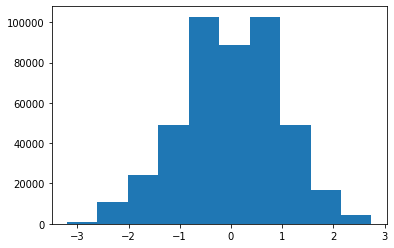

/tmp/ipykernel_1217144/3984487467.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])


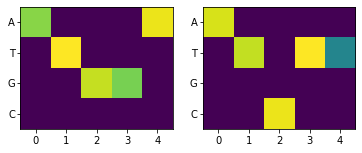

14022/14022 [==============================] - 14s 967us/step


/tmp/ipykernel_1217144/3984487467.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])


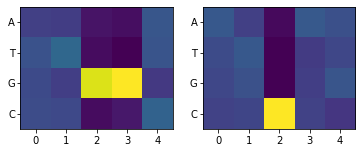

In [19]:
import matplotlib.pyplot as plt
plt.hist(seq_encoding)  # Has a nice normal dist
plt.show()

# Show some of the kmers (4)
n = 2
seqs_encoding = cvae.get_encoded_data()
# Show the true data
plt.figure(figsize=(6, 3))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])
    ax.tick_params(axis='y', which='major', pad=2.0)
    plt.imshow(test_data[i].reshape(4, kmer_len))

plt.show()

# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
d = cvae.decoder.predict(seqs_encoding)

plt.figure(figsize=(6, 3))
n = 2
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    ax.set_yticklabels(['', 'A', 'T', 'G', 'C'])
    ax.tick_params(axis='y', which='major', pad=2.0)
    plt.imshow(d[i,:].reshape(4, kmer_len))
plt.show()

In [20]:
cvae.save(f'model_weights_{kmer_len}_{exp_name}.h5', f'model_optimiser_{kmer_len}_{exp_name}.json', f'config_{kmer_len}_{exp_name}.json') # looks pretty decent for a single node 

In [20]:
from scivae import ConvVAE

training_df = pd.read_csv(f'{output_folder}training_data_{exp_name}.csv')
# Now we need to replcae the deletions, let's replace with 0 for now, sometimes I do mean...
training_df = training_df.replace(np.nan, 0) # 

test_data = training_df.values[:, 4:]
test_data = test_data / np.max(test_data)
test_data = np.array(test_data).astype(float)
test_labels = training_df[: 1]


config = {'scale_data': False,
         'input_size': (4, kmer_len),
          'batch_norm': True,
         'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 0.1},
          'encoding': {'layers': [{'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  ]},
          'decoding': {'layers': [
                                  {'filters': 32, 'kernel_size': 4, 'pooling': 2, 'strides': 2, 'padding':'same',
                                  'activation_fn': 'relu'},
                                  {'filters': 1, 'kernel_size': 4, 'pooling': 2, 'strides': 1, 'padding':'same',
                                  'activation_fn': 'sigmoid'}
                                  ]},
          'latent': {'num_nodes': 1},
          'optimiser': {'params': {'learning_rate': 0.01}, 'name': 'adam'}
}

# Run the VAE 
cvae = ConvVAE(test_data, test_data, test_labels, config, 'cvae')

cvae.load(f'model_weights_{kmer_len}_{exp_name}.h5', f'model_optimiser_{kmer_len}_{exp_name}.json', f'config_{kmer_len}_{exp_name}.json') # looks pretty decent for a single node 

(4, 5)
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 4, 5, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 4, 5, 32)     544         ['default_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 4, 5, 32)    128         ['conv2d[0][0]']                 
 alization)                             

2022-07-31 11:12:07.064947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/openmpi/lib/
2022-07-31 11:12:07.065002: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-31 11:12:07.065038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bioinfr): /proc/driver/nvidia/version does not exist
2022-07-31 11:12:07.065316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Use encoding function to probe for variation in the dataset


In [14]:
kmers_to_investigate = []
for k in kmer_counts:
    if kmer_counts[k] > 100:
        kmers_to_investigate.append(k)
print(len(kmers_to_investigate))

training_runs = []
for bam in bams:
    training_runs.append(f'{output_folder}training_new/{bam.split("/")[-1].split(".")[0]}_training.h5')
training_runs

1024


['../runs/training_new/SRR17704200_training.h5',
 '../runs/training_new/SRR16009459_training.h5',
 '../runs/training_new/SRR17704197_training.h5',
 '../runs/training_new/SRR17704196_training.h5',
 '../runs/training_new/SRR17704198_training.h5',
 '../runs/training_new/SRR16009461_training.h5',
 '../runs/training_new/SRR16009462_training.h5',
 '../runs/training_new/SRR17704201_training.h5',
 '../runs/training_new/SRR16009460_training.h5',
 '../runs/training_new/SRR16009463_training.h5',
 '../runs/training_new/SRR17704199_training.h5']

In [ ]:

# from scipy import stats
# import itertools

# from statsmodels.stats.multitest import multipletests

# xylella_csp1_15 = ['SRR17704200', 'SRR17704199', 'SRR17704201']
# xylella_csp1_28 = ['SRR16009461', 'SRR16009462', 'SRR16009463']
# xylella_wt_15 = ['SRR17704197', 'SRR17704198', 'SRR17704196']
# xylella_wt_28 = ['SRR16009459', 'SRR16009460']

# cond_dict = {'SRR17704200': 'xylella_csp1_15', 'SRR17704199': 'xylella_csp1_15', 'SRR17704201': 'xylella_csp1_15',
#             'SRR16009461': 'xylella_csp1_28', 'SRR16009462': 'xylella_csp1_28', 'SRR16009463': 'xylella_csp1_28',
#              'SRR17704197': 'xylella_wt_15', 'SRR17704198': 'xylella_wt_15', 'SRR17704196': 'xylella_wt_15',
#              'SRR16009459': 'xylella_wt_28', 'SRR16009460': 'xylella_wt_28'
#             }

# comparisons = list(itertools.combinations(species_runs, 2))

# p_values = []
# t_values = []
# labels = []
# kmers = []
# condlabels = []
# # Check for significance between kmers
# for kmer in kmers_to_investigate:
#     df_kmer = get_kmer_encodings(kmer,  f'{output_folder}kmer_5_{exp_name}.h5', training_runs, 100)
#     df_psi = df_kmer

#     df_psi.fillna(0, inplace=True)

#     # encode the data
#     psi_data = df_psi.values[:, 5:]
#     psi_data = psi_data / np.max(psi_data)
#     psi_data = np.array(psi_data).astype(float)
#     psi_data = np.array([d.reshape((4, kmer_len, 1)) for d in psi_data])
#     seqs_encoding = cvae.encode_new_data(psi_data, scale=False)
#     df_psi['MeanEncoding'] = seqs_encoding

#     for kmer_start in set(df_kmer['ID'].values):
#         df_psi_kmer = df_psi[df_psi['Start'] == kmer_start]
#         if len(df_psi_kmer) > 10:
#             for comparison in comparisons:
#                 e_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[0]}_training']['MeanEncoding'].values
#                 s_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[1]}_training']['MeanEncoding'].values
#                 if len(e_plus) > 5 and len(s_plus) > 5:
#                     t_stat, p_val = stats.ttest_ind(e_plus, s_plus)
#                     p_values.append(p_val)
#                     t_values.append(t_stat)
#                     kmers.append(kmer_start)
#                     labels.append(f'{comparison[1]} vs {comparison[0]}')
#                     condlabels.append(f'{cond_dict[comparison[1]]} vs {cond_dict[comparison[0]]}')

# # Calculate adjusted p-values
# p_adj = multipletests(p_values, alpha=0.1, method='fdr_bh', returnsorted=False)

# kmer_df = pd.DataFrame()
# kmer_df['p_values'] = p_adj[1]
# kmer_df['p.adj'] = p_values
# kmer_df['t_values'] = t_values
# kmer_df['labels'] = labels
# kmer_df['kmer'] = kmers

100%|█| 476/476 [00:49<00:00,  9.64it/


../runs/training_new/SRR17704200_training.h5 27870


100%|█| 476/476 [00:51<00:00,  9.33it/


../runs/training_new/SRR16009459_training.h5 54913


100%|█| 476/476 [00:38<00:00, 12.32it/


../runs/training_new/SRR17704197_training.h5 74391


100%|█| 476/476 [01:01<00:00,  7.68it/


../runs/training_new/SRR17704196_training.h5 107440


100%|█| 476/476 [00:08<00:00, 59.40it/


../runs/training_new/SRR17704198_training.h5 110864


100%|█| 476/476 [00:03<00:00, 152.31it


../runs/training_new/SRR16009461_training.h5 112088


100%|█| 476/476 [00:03<00:00, 139.18it


../runs/training_new/SRR16009462_training.h5 113478


100%|█| 476/476 [00:14<00:00, 32.08it/


../runs/training_new/SRR17704201_training.h5 120970


100%|█| 476/476 [01:29<00:00,  5.32it/


../runs/training_new/SRR16009460_training.h5 169835


100%|█| 476/476 [00:01<00:00, 338.47it


../runs/training_new/SRR16009463_training.h5 170139


100%|█| 476/476 [00:49<00:00,  9.70it/


../runs/training_new/SRR17704199_training.h5 197591
6175/6175 [==============================] - 7s 1ms/step


100%|█| 527/527 [01:03<00:00,  8.24it/


../runs/training_new/SRR17704200_training.h5 26571


100%|█| 527/527 [00:54<00:00,  9.66it/


../runs/training_new/SRR16009459_training.h5 51006


100%|█| 527/527 [00:39<00:00, 13.21it/


../runs/training_new/SRR17704197_training.h5 68349


100%|█| 527/527 [01:02<00:00,  8.37it/


../runs/training_new/SRR17704196_training.h5 96862


100%|█| 527/527 [00:06<00:00, 76.70it/


../runs/training_new/SRR17704198_training.h5 99443


100%|█| 527/527 [00:02<00:00, 201.77it


../runs/training_new/SRR16009461_training.h5 100329


100%|█| 527/527 [00:02<00:00, 200.30it


../runs/training_new/SRR16009462_training.h5 101203


100%|█| 527/527 [00:13<00:00, 38.48it/


../runs/training_new/SRR17704201_training.h5 107994


100%|█| 527/527 [01:36<00:00,  5.45it/


../runs/training_new/SRR16009460_training.h5 152801


100%|█| 527/527 [00:01<00:00, 409.33it


../runs/training_new/SRR16009463_training.h5 152979


100%|█| 527/527 [00:52<00:00,  9.97it/


../runs/training_new/SRR17704199_training.h5 177815
5557/5557 [==============================] - 7s 1ms/step


100%|█| 461/461 [00:49<00:00,  9.24it/


../runs/training_new/SRR17704200_training.h5 20602


100%|█| 461/461 [00:52<00:00,  8.84it/


../runs/training_new/SRR16009459_training.h5 41007


100%|█| 461/461 [00:39<00:00, 11.72it/


../runs/training_new/SRR17704197_training.h5 55813


100%|█| 461/461 [01:01<00:00,  7.50it/


../runs/training_new/SRR17704196_training.h5 78738


100%|█| 461/461 [00:08<00:00, 56.44it/


../runs/training_new/SRR17704198_training.h5 81873


100%|█| 461/461 [00:02<00:00, 161.11it


../runs/training_new/SRR16009461_training.h5 82836


100%|█| 461/461 [00:03<00:00, 143.70it


../runs/training_new/SRR16009462_training.h5 83819


100%|█| 461/461 [00:14<00:00, 31.61it/


../runs/training_new/SRR17704201_training.h5 89680


100%|█| 461/461 [01:29<00:00,  5.16it/


../runs/training_new/SRR16009460_training.h5 123804


100%|█| 461/461 [00:01<00:00, 326.78it


../runs/training_new/SRR16009463_training.h5 124159


100%|█| 461/461 [00:49<00:00,  9.35it/


../runs/training_new/SRR17704199_training.h5 143465
4484/4484 [==============================] - 5s 1ms/step


100%|█| 520/520 [00:55<00:00,  9.45it/


../runs/training_new/SRR17704200_training.h5 24475


100%|█| 520/520 [00:58<00:00,  8.95it/


../runs/training_new/SRR16009459_training.h5 47425


100%|█| 520/520 [00:43<00:00, 11.94it/


../runs/training_new/SRR17704197_training.h5 64563


100%|█| 520/520 [01:07<00:00,  7.73it/


../runs/training_new/SRR17704196_training.h5 91574


100%|█| 520/520 [00:09<00:00, 52.80it/


../runs/training_new/SRR17704198_training.h5 94698


100%|█| 520/520 [00:02<00:00, 187.38it


../runs/training_new/SRR16009461_training.h5 95431


100%|█| 520/520 [00:03<00:00, 153.51it


../runs/training_new/SRR16009462_training.h5 96277


100%|█| 520/520 [00:16<00:00, 31.44it/


../runs/training_new/SRR17704201_training.h5 102800


100%|█| 520/520 [01:42<00:00,  5.08it/


../runs/training_new/SRR16009460_training.h5 143580


100%|█| 520/520 [00:01<00:00, 301.85it


../runs/training_new/SRR16009463_training.h5 143780


100%|█| 520/520 [00:54<00:00,  9.52it/


../runs/training_new/SRR17704199_training.h5 167274
5228/5228 [==============================] - 6s 1ms/step


100%|█| 530/530 [00:55<00:00,  9.60it/


../runs/training_new/SRR17704200_training.h5 26198


100%|█| 530/530 [00:57<00:00,  9.18it/


../runs/training_new/SRR16009459_training.h5 49892


100%|█| 530/530 [00:41<00:00, 12.77it/


../runs/training_new/SRR17704197_training.h5 67001


100%|█| 530/530 [01:03<00:00,  8.31it/


../runs/training_new/SRR17704196_training.h5 94294


100%|█| 530/530 [00:08<00:00, 58.94it/


../runs/training_new/SRR17704198_training.h5 97245


100%|█| 530/530 [00:03<00:00, 135.11it


../runs/training_new/SRR16009461_training.h5 98156


100%|█| 530/530 [00:04<00:00, 128.96it


../runs/training_new/SRR16009462_training.h5 99088


100%|█| 530/530 [00:15<00:00, 33.32it/


../runs/training_new/SRR17704201_training.h5 106013


100%|█| 530/530 [01:36<00:00,  5.49it/


../runs/training_new/SRR16009460_training.h5 149268


100%|█| 530/530 [00:02<00:00, 255.57it


../runs/training_new/SRR16009463_training.h5 149512


100%|█| 530/530 [00:53<00:00,  9.84it/


../runs/training_new/SRR17704199_training.h5 173517
5423/5423 [==============================] - 6s 1ms/step


100%|█| 532/532 [00:55<00:00,  9.54it/


../runs/training_new/SRR17704200_training.h5 27863


100%|█| 532/532 [00:54<00:00,  9.74it/


../runs/training_new/SRR16009459_training.h5 52919


100%|█| 532/532 [00:41<00:00, 12.71it/


../runs/training_new/SRR17704197_training.h5 70283


100%|█| 532/532 [01:03<00:00,  8.42it/


../runs/training_new/SRR17704196_training.h5 96952


100%|█| 532/532 [00:08<00:00, 61.69it/


../runs/training_new/SRR17704198_training.h5 100131


100%|█| 532/532 [00:04<00:00, 131.88it


../runs/training_new/SRR16009461_training.h5 101360


100%|█| 532/532 [00:04<00:00, 121.68it


../runs/training_new/SRR16009462_training.h5 102624


100%|█| 532/532 [00:15<00:00, 34.34it/


../runs/training_new/SRR17704201_training.h5 109779


100%|█| 532/532 [01:38<00:00,  5.38it/


../runs/training_new/SRR16009460_training.h5 154465


100%|█| 532/532 [00:02<00:00, 225.10it


../runs/training_new/SRR16009463_training.h5 155032


100%|█| 532/532 [00:54<00:00,  9.78it/


../runs/training_new/SRR17704199_training.h5 180197
5632/5632 [==============================] - 7s 1ms/step


100%|█| 551/551 [00:55<00:00,  9.87it/


../runs/training_new/SRR17704200_training.h5 26923


100%|█| 551/551 [00:57<00:00,  9.51it/


../runs/training_new/SRR16009459_training.h5 50822


100%|█| 551/551 [00:43<00:00, 12.59it/


../runs/training_new/SRR17704197_training.h5 68337


100%|█| 551/551 [01:06<00:00,  8.26it/


../runs/training_new/SRR17704196_training.h5 94383


100%|█| 551/551 [00:09<00:00, 58.93it/


../runs/training_new/SRR17704198_training.h5 97365


100%|█| 551/551 [00:04<00:00, 137.66it


../runs/training_new/SRR16009461_training.h5 98381


100%|█| 551/551 [00:04<00:00, 131.17it


../runs/training_new/SRR16009462_training.h5 99253


100%|█| 551/551 [00:16<00:00, 34.08it/


../runs/training_new/SRR17704201_training.h5 106308


100%|█| 551/551 [01:41<00:00,  5.42it/


../runs/training_new/SRR16009460_training.h5 149368


100%|█| 551/551 [00:02<00:00, 269.88it


../runs/training_new/SRR16009463_training.h5 149540


100%|█| 551/551 [00:55<00:00,  9.98it/


../runs/training_new/SRR17704199_training.h5 174591
5456/5456 [==============================] - 6s 1ms/step


100%|█| 449/449 [00:51<00:00,  8.79it/


../runs/training_new/SRR17704200_training.h5 18416


100%|█| 449/449 [00:50<00:00,  8.98it/


../runs/training_new/SRR16009459_training.h5 35582


100%|█| 449/449 [00:38<00:00, 11.71it/


../runs/training_new/SRR17704197_training.h5 48282


100%|█| 449/449 [00:57<00:00,  7.82it/


../runs/training_new/SRR17704196_training.h5 66896


100%|█| 449/449 [00:10<00:00, 44.63it/


../runs/training_new/SRR17704198_training.h5 69499


100%|█| 449/449 [00:04<00:00, 104.19it


../runs/training_new/SRR16009461_training.h5 70455


100%|█| 449/449 [00:04<00:00, 93.53it/


../runs/training_new/SRR16009462_training.h5 71371


100%|█| 449/449 [00:15<00:00, 29.88it/


../runs/training_new/SRR17704201_training.h5 76469


100%|█| 449/449 [01:27<00:00,  5.12it/


../runs/training_new/SRR16009460_training.h5 107251


100%|█| 449/449 [00:02<00:00, 189.13it


../runs/training_new/SRR16009463_training.h5 107487


100%|█| 449/449 [00:48<00:00,  9.35it/


../runs/training_new/SRR17704199_training.h5 124912
3904/3904 [==============================] - 5s 1ms/step


100%|█| 458/458 [00:48<00:00,  9.41it/


../runs/training_new/SRR17704200_training.h5 20331


100%|█| 458/458 [00:51<00:00,  8.85it/


../runs/training_new/SRR16009459_training.h5 40993


100%|█| 458/458 [00:38<00:00, 11.77it/


../runs/training_new/SRR17704197_training.h5 55730


100%|█| 458/458 [00:59<00:00,  7.70it/


../runs/training_new/SRR17704196_training.h5 78951


100%|█| 458/458 [00:09<00:00, 48.12it/


../runs/training_new/SRR17704198_training.h5 82104


100%|█| 458/458 [00:04<00:00, 108.81it


../runs/training_new/SRR16009461_training.h5 83098


100%|█| 458/458 [00:04<00:00, 100.35it


../runs/training_new/SRR16009462_training.h5 84004


100%|█| 458/458 [00:15<00:00, 29.84it/


../runs/training_new/SRR17704201_training.h5 89439


100%|█| 458/458 [01:27<00:00,  5.22it/


../runs/training_new/SRR16009460_training.h5 124831


100%|█| 458/458 [00:02<00:00, 194.49it


../runs/training_new/SRR16009463_training.h5 125221


100%|█| 458/458 [00:48<00:00,  9.51it/


../runs/training_new/SRR17704199_training.h5 144326
4511/4511 [==============================] - 5s 1ms/step


100%|█| 532/532 [00:57<00:00,  9.29it/


../runs/training_new/SRR17704200_training.h5 28732


100%|█| 532/532 [00:56<00:00,  9.34it/


../runs/training_new/SRR16009459_training.h5 54667


100%|█| 532/532 [00:45<00:00, 11.79it/


../runs/training_new/SRR17704197_training.h5 74693


100%|█| 532/532 [01:05<00:00,  8.12it/


../runs/training_new/SRR17704196_training.h5 103175


100%|█| 532/532 [00:10<00:00, 52.68it/


../runs/training_new/SRR17704198_training.h5 106879


100%|█| 532/532 [00:04<00:00, 127.76it


../runs/training_new/SRR16009461_training.h5 108154


100%|█| 532/532 [00:04<00:00, 108.20it


../runs/training_new/SRR16009462_training.h5 109547


100%|█| 532/532 [00:17<00:00, 31.06it/


../runs/training_new/SRR17704201_training.h5 117717


100%|█| 532/532 [01:40<00:00,  5.30it/


../runs/training_new/SRR16009460_training.h5 163312


100%|█| 532/532 [00:02<00:00, 245.98it


../runs/training_new/SRR16009463_training.h5 163926


100%|█| 532/532 [00:57<00:00,  9.31it/


../runs/training_new/SRR17704199_training.h5 190120
5942/5942 [==============================] - 7s 1ms/step


100%|█| 428/428 [00:55<00:00,  7.74it/


../runs/training_new/SRR17704200_training.h5 18688


100%|█| 428/428 [00:56<00:00,  7.61it/


../runs/training_new/SRR16009459_training.h5 36427


100%|█| 428/428 [00:37<00:00, 11.32it/


../runs/training_new/SRR17704197_training.h5 49695


100%|█| 428/428 [00:57<00:00,  7.50it/


../runs/training_new/SRR17704196_training.h5 68564


100%|█| 428/428 [00:09<00:00, 45.96it/


../runs/training_new/SRR17704198_training.h5 72270


100%|█| 428/428 [00:02<00:00, 145.17it


../runs/training_new/SRR16009461_training.h5 73265


100%|█| 428/428 [00:03<00:00, 134.44it


../runs/training_new/SRR16009462_training.h5 74451


100%|█| 428/428 [00:14<00:00, 29.12it/


../runs/training_new/SRR17704201_training.h5 80003


100%|█| 428/428 [01:23<00:00,  5.14it/


../runs/training_new/SRR16009460_training.h5 108532


100%|█| 428/428 [00:01<00:00, 225.89it


../runs/training_new/SRR16009463_training.h5 109282


100%|█| 428/428 [00:45<00:00,  9.34it/


../runs/training_new/SRR17704199_training.h5 126269
3946/3946 [==============================] - 4s 1ms/step


100%|█| 471/471 [00:55<00:00,  8.42it/


../runs/training_new/SRR17704200_training.h5 20196


100%|█| 471/471 [00:54<00:00,  8.70it/


../runs/training_new/SRR16009459_training.h5 39953


100%|█| 471/471 [00:41<00:00, 11.47it/


../runs/training_new/SRR17704197_training.h5 53962


100%|█| 471/471 [01:01<00:00,  7.68it/


../runs/training_new/SRR17704196_training.h5 74269


100%|█| 471/471 [00:12<00:00, 38.04it/


../runs/training_new/SRR17704198_training.h5 77319


100%|█| 471/471 [00:04<00:00, 103.39it


../runs/training_new/SRR16009461_training.h5 78618


100%|█| 471/471 [00:05<00:00, 89.49it/


../runs/training_new/SRR16009462_training.h5 79894


100%|█| 471/471 [00:16<00:00, 28.83it/


../runs/training_new/SRR17704201_training.h5 85922


100%|█| 471/471 [01:32<00:00,  5.07it/


../runs/training_new/SRR16009460_training.h5 119121


100%|█| 471/471 [00:01<00:00, 252.30it


../runs/training_new/SRR16009463_training.h5 119593


100%|█| 471/471 [00:51<00:00,  9.19it/


../runs/training_new/SRR17704199_training.h5 137994
4313/4313 [==============================] - 5s 1ms/step


100%|█| 452/452 [00:47<00:00,  9.59it/


../runs/training_new/SRR17704200_training.h5 19444


100%|█| 452/452 [00:47<00:00,  9.42it/


../runs/training_new/SRR16009459_training.h5 37506


100%|█| 452/452 [00:35<00:00, 12.79it/


../runs/training_new/SRR17704197_training.h5 50780


100%|█| 452/452 [00:55<00:00,  8.12it/


../runs/training_new/SRR17704196_training.h5 71062


100%|█| 452/452 [00:08<00:00, 54.45it/


../runs/training_new/SRR17704198_training.h5 73981


100%|█| 452/452 [00:02<00:00, 164.19it


../runs/training_new/SRR16009461_training.h5 74848


100%|█| 452/452 [00:03<00:00, 144.09it


../runs/training_new/SRR16009462_training.h5 75826


100%|█| 452/452 [00:13<00:00, 33.25it/


../runs/training_new/SRR17704201_training.h5 81317


100%|█| 452/452 [01:23<00:00,  5.40it/


../runs/training_new/SRR16009460_training.h5 112923


100%|█| 452/452 [00:01<00:00, 305.12it


../runs/training_new/SRR16009463_training.h5 113217


100%|█| 452/452 [00:46<00:00,  9.68it/


../runs/training_new/SRR17704199_training.h5 131318
4104/4104 [==============================] - 5s 1ms/step


100%|█| 553/553 [00:59<00:00,  9.33it/


../runs/training_new/SRR17704200_training.h5 29729


100%|█| 553/553 [00:59<00:00,  9.25it/


../runs/training_new/SRR16009459_training.h5 57578


100%|█| 553/553 [00:45<00:00, 12.04it/


../runs/training_new/SRR17704197_training.h5 78068


100%|█| 553/553 [01:09<00:00,  7.95it/


../runs/training_new/SRR17704196_training.h5 108210


100%|█| 553/553 [00:10<00:00, 53.68it/


../runs/training_new/SRR17704198_training.h5 111813


100%|█| 553/553 [00:04<00:00, 136.65it


../runs/training_new/SRR16009461_training.h5 113266


100%|█| 553/553 [00:04<00:00, 121.01it


../runs/training_new/SRR16009462_training.h5 114704


100%|█| 553/553 [00:17<00:00, 31.53it/


../runs/training_new/SRR17704201_training.h5 123020


100%|█| 553/553 [01:46<00:00,  5.21it/


../runs/training_new/SRR16009460_training.h5 171160


100%|█| 553/553 [00:02<00:00, 237.95it


../runs/training_new/SRR16009463_training.h5 171910


100%|█| 553/553 [00:57<00:00,  9.67it/


../runs/training_new/SRR17704199_training.h5 198979
6219/6219 [==============================] - 7s 1ms/step


100%|█| 503/503 [00:51<00:00,  9.69it/


../runs/training_new/SRR17704200_training.h5 19301


100%|█| 503/503 [00:51<00:00,  9.76it/


../runs/training_new/SRR16009459_training.h5 37074


100%|█| 503/503 [00:39<00:00, 12.75it/


../runs/training_new/SRR17704197_training.h5 50238


100%|█| 503/503 [01:00<00:00,  8.34it/


../runs/training_new/SRR17704196_training.h5 70103


100%|█| 503/503 [00:08<00:00, 60.28it/


../runs/training_new/SRR17704198_training.h5 72353


100%|█| 503/503 [00:03<00:00, 164.67it


../runs/training_new/SRR16009461_training.h5 73141


100%|█| 503/503 [00:02<00:00, 184.70it


../runs/training_new/SRR16009462_training.h5 73711


100%|█| 503/503 [00:14<00:00, 35.29it/


../runs/training_new/SRR17704201_training.h5 78259


100%|█| 503/503 [01:32<00:00,  5.46it/


../runs/training_new/SRR16009460_training.h5 110255


100%|█| 503/503 [00:01<00:00, 447.22it


../runs/training_new/SRR16009463_training.h5 110422


100%|█| 503/503 [00:49<00:00, 10.11it/


../runs/training_new/SRR17704199_training.h5 128191
4006/4006 [==============================] - 5s 1ms/step


100%|█| 511/511 [00:53<00:00,  9.52it/


../runs/training_new/SRR17704200_training.h5 22886


100%|█| 511/511 [00:56<00:00,  9.11it/


../runs/training_new/SRR16009459_training.h5 45638


100%|█| 511/511 [00:43<00:00, 11.82it/


../runs/training_new/SRR17704197_training.h5 62032


100%|█| 511/511 [01:06<00:00,  7.69it/


../runs/training_new/SRR17704196_training.h5 87623


100%|█| 511/511 [00:10<00:00, 46.65it/


../runs/training_new/SRR17704198_training.h5 90984


100%|█| 511/511 [00:03<00:00, 164.83it


../runs/training_new/SRR16009461_training.h5 91562


100%|█| 511/511 [00:04<00:00, 127.52it


../runs/training_new/SRR16009462_training.h5 92279


100%|█| 511/511 [00:16<00:00, 31.72it/


../runs/training_new/SRR17704201_training.h5 98699


100%|█| 511/511 [01:38<00:00,  5.19it/


../runs/training_new/SRR16009460_training.h5 137576


100%|█| 511/511 [00:02<00:00, 250.96it


../runs/training_new/SRR16009463_training.h5 137824


100%|█| 511/511 [00:52<00:00,  9.65it/


../runs/training_new/SRR17704199_training.h5 159692
4991/4991 [==============================] - 6s 1ms/step


100%|█| 553/553 [00:56<00:00,  9.74it/


../runs/training_new/SRR17704200_training.h5 32953


100%|█| 553/553 [00:57<00:00,  9.60it/


../runs/training_new/SRR16009459_training.h5 62904


100%|█| 553/553 [00:43<00:00, 12.68it/


../runs/training_new/SRR17704197_training.h5 85545


100%|█| 553/553 [01:05<00:00,  8.38it/


../runs/training_new/SRR17704196_training.h5 119841


100%|█| 553/553 [00:09<00:00, 57.14it/


../runs/training_new/SRR17704198_training.h5 124033


100%|█| 553/553 [00:03<00:00, 138.46it


../runs/training_new/SRR16009461_training.h5 125357


100%|█| 553/553 [00:04<00:00, 121.40it


../runs/training_new/SRR16009462_training.h5 126598


100%|█| 553/553 [00:16<00:00, 33.62it/


../runs/training_new/SRR17704201_training.h5 135421


100%|█| 553/553 [01:41<00:00,  5.45it/


../runs/training_new/SRR16009460_training.h5 189698


100%|█| 553/553 [00:02<00:00, 256.05it


../runs/training_new/SRR16009463_training.h5 189945


100%|█| 553/553 [00:55<00:00,  9.91it/


../runs/training_new/SRR17704199_training.h5 220601
6894/6894 [==============================] - 8s 1ms/step


100%|█| 497/497 [00:50<00:00,  9.81it/


../runs/training_new/SRR17704200_training.h5 29076


100%|█| 497/497 [00:51<00:00,  9.71it/


../runs/training_new/SRR16009459_training.h5 54760


100%|█| 497/497 [00:39<00:00, 12.55it/


../runs/training_new/SRR17704197_training.h5 74048


100%|█| 497/497 [00:59<00:00,  8.36it/


../runs/training_new/SRR17704196_training.h5 101932


100%|█| 497/497 [00:08<00:00, 56.15it/


../runs/training_new/SRR17704198_training.h5 105244


100%|█| 497/497 [00:04<00:00, 123.54it


../runs/training_new/SRR16009461_training.h5 106482


100%|█| 497/497 [00:04<00:00, 112.98it


../runs/training_new/SRR16009462_training.h5 107650


100%|█| 497/497 [00:14<00:00, 34.22it/


../runs/training_new/SRR17704201_training.h5 115449


100%|█| 497/497 [01:30<00:00,  5.49it/


../runs/training_new/SRR16009460_training.h5 162830


100%|█| 497/497 [00:02<00:00, 222.86it


../runs/training_new/SRR16009463_training.h5 163105


100%|█| 497/497 [00:49<00:00,  9.94it/


../runs/training_new/SRR17704199_training.h5 189988
5938/5938 [==============================] - 7s 1ms/step


100%|█| 532/532 [00:56<00:00,  9.42it/


../runs/training_new/SRR17704200_training.h5 25153


100%|█| 532/532 [00:54<00:00,  9.72it/


../runs/training_new/SRR16009459_training.h5 47186


100%|█| 532/532 [00:43<00:00, 12.25it/


../runs/training_new/SRR17704197_training.h5 64020


100%|█| 532/532 [01:04<00:00,  8.24it/


../runs/training_new/SRR17704196_training.h5 88187


100%|█| 532/532 [00:09<00:00, 54.98it/


../runs/training_new/SRR17704198_training.h5 91030


100%|█| 532/532 [00:04<00:00, 118.85it


../runs/training_new/SRR16009461_training.h5 92133


100%|█| 532/532 [00:04<00:00, 112.80it


../runs/training_new/SRR16009462_training.h5 93153


100%|█| 532/532 [00:16<00:00, 32.42it/


../runs/training_new/SRR17704201_training.h5 99257


100%|█| 532/532 [01:39<00:00,  5.37it/


../runs/training_new/SRR16009460_training.h5 139203


100%|█| 532/532 [00:02<00:00, 236.02it


../runs/training_new/SRR16009463_training.h5 139537


100%|█| 532/532 [00:54<00:00,  9.78it/


../runs/training_new/SRR17704199_training.h5 162693
5085/5085 [==============================] - 6s 1ms/step


100%|█| 492/492 [00:51<00:00,  9.62it/


../runs/training_new/SRR17704200_training.h5 21721


100%|█| 492/492 [00:50<00:00,  9.73it/


../runs/training_new/SRR16009459_training.h5 41728


100%|█| 492/492 [00:39<00:00, 12.34it/


../runs/training_new/SRR17704197_training.h5 56641


100%|█| 492/492 [00:59<00:00,  8.28it/


../runs/training_new/SRR17704196_training.h5 77994


100%|█| 492/492 [00:09<00:00, 53.59it/


../runs/training_new/SRR17704198_training.h5 80587


100%|█| 492/492 [00:03<00:00, 138.90it


../runs/training_new/SRR16009461_training.h5 81262


100%|█| 492/492 [00:04<00:00, 120.56it


../runs/training_new/SRR16009462_training.h5 82255


100%|█| 492/492 [00:15<00:00, 32.73it/


../runs/training_new/SRR17704201_training.h5 87854


100%|█| 492/492 [01:31<00:00,  5.36it/


../runs/training_new/SRR16009460_training.h5 123441


100%|█| 492/492 [00:02<00:00, 240.91it


../runs/training_new/SRR16009463_training.h5 123611


100%|█| 492/492 [00:49<00:00,  9.88it/


../runs/training_new/SRR17704199_training.h5 143525
4486/4486 [==============================] - 5s 1ms/step


100%|█| 591/591 [00:59<00:00,  9.88it/


../runs/training_new/SRR17704200_training.h5 38385


100%|█| 591/591 [00:59<00:00,  9.93it/


../runs/training_new/SRR16009459_training.h5 72510


100%|█| 591/591 [00:44<00:00, 13.20it/


../runs/training_new/SRR17704197_training.h5 97314


100%|█| 591/591 [01:09<00:00,  8.50it/


../runs/training_new/SRR17704196_training.h5 134163


100%|█| 591/591 [00:07<00:00, 74.80it/


../runs/training_new/SRR17704198_training.h5 138511


100%|█| 591/591 [00:02<00:00, 235.27it


../runs/training_new/SRR16009461_training.h5 139686


100%|█| 591/591 [00:02<00:00, 212.54it


../runs/training_new/SRR16009462_training.h5 140757


100%|█| 591/591 [00:15<00:00, 37.05it/


../runs/training_new/SRR17704201_training.h5 150571


100%|█| 591/591 [01:48<00:00,  5.45it/


../runs/training_new/SRR16009460_training.h5 212325


100%|█| 591/591 [00:01<00:00, 464.76it


../runs/training_new/SRR16009463_training.h5 212696


100%|█| 591/591 [00:57<00:00, 10.27it/


../runs/training_new/SRR17704199_training.h5 247875
7747/7747 [==============================] - 9s 1ms/step


100%|█| 420/420 [00:43<00:00,  9.68it/


../runs/training_new/SRR17704200_training.h5 16718


100%|█| 420/420 [00:49<00:00,  8.46it/


../runs/training_new/SRR16009459_training.h5 31826


100%|█| 420/420 [00:32<00:00, 13.05it/


../runs/training_new/SRR17704197_training.h5 42866


100%|█| 420/420 [00:49<00:00,  8.47it/


../runs/training_new/SRR17704196_training.h5 59315


100%|█| 420/420 [00:07<00:00, 55.84it/


../runs/training_new/SRR17704198_training.h5 61088


100%|█| 420/420 [00:03<00:00, 107.89it


../runs/training_new/SRR16009461_training.h5 62198


100%|█| 420/420 [00:04<00:00, 99.22it/


../runs/training_new/SRR16009462_training.h5 63214


100%|█| 420/420 [00:12<00:00, 33.57it/


../runs/training_new/SRR17704201_training.h5 67346


100%|█| 420/420 [01:19<00:00,  5.26it/


../runs/training_new/SRR16009460_training.h5 94605


100%|█| 420/420 [00:03<00:00, 114.56it


../runs/training_new/SRR16009463_training.h5 95175


100%|█| 420/420 [00:53<00:00,  7.91it/


../runs/training_new/SRR17704199_training.h5 110641
3458/3458 [==============================] - 4s 1ms/step


100%|█| 505/505 [00:53<00:00,  9.36it/


../runs/training_new/SRR17704200_training.h5 25190


100%|█| 505/505 [00:54<00:00,  9.26it/


../runs/training_new/SRR16009459_training.h5 47688


100%|█| 505/505 [00:41<00:00, 12.16it/


../runs/training_new/SRR17704197_training.h5 64306


100%|█| 505/505 [01:01<00:00,  8.27it/


../runs/training_new/SRR17704196_training.h5 87060


100%|█| 505/505 [00:09<00:00, 55.28it/


../runs/training_new/SRR17704198_training.h5 90064


100%|█| 505/505 [00:04<00:00, 118.90it


../runs/training_new/SRR16009461_training.h5 91394


100%|█| 505/505 [00:04<00:00, 113.63it


../runs/training_new/SRR16009462_training.h5 92472


100%|█| 505/505 [00:16<00:00, 31.29it/


../runs/training_new/SRR17704201_training.h5 99051


100%|█| 505/505 [01:35<00:00,  5.28it/


../runs/training_new/SRR16009460_training.h5 138514


100%|█| 505/505 [00:02<00:00, 206.11it


../runs/training_new/SRR16009463_training.h5 139070


100%|█| 505/505 [00:52<00:00,  9.60it/


../runs/training_new/SRR17704199_training.h5 162332
5073/5073 [==============================] - 6s 1ms/step


100%|█| 411/411 [00:41<00:00,  9.83it/


../runs/training_new/SRR17704200_training.h5 16321


100%|█| 411/411 [00:43<00:00,  9.48it/


../runs/training_new/SRR16009459_training.h5 31906


100%|█| 411/411 [00:32<00:00, 12.51it/


../runs/training_new/SRR17704197_training.h5 43369


100%|█| 411/411 [00:52<00:00,  7.89it/


../runs/training_new/SRR17704196_training.h5 60187


100%|█| 411/411 [00:08<00:00, 49.48it/


../runs/training_new/SRR17704198_training.h5 63141


100%|█| 411/411 [00:03<00:00, 111.24it


../runs/training_new/SRR16009461_training.h5 64352


100%|█| 411/411 [00:04<00:00, 94.05it/


../runs/training_new/SRR16009462_training.h5 65573


100%|█| 411/411 [00:13<00:00, 31.08it/


../runs/training_new/SRR17704201_training.h5 70964


100%|█| 411/411 [01:17<00:00,  5.30it/


../runs/training_new/SRR16009460_training.h5 98066


100%|█| 411/411 [00:02<00:00, 203.60it


../runs/training_new/SRR16009463_training.h5 98648


100%|█| 411/411 [00:41<00:00,  9.91it/


../runs/training_new/SRR17704199_training.h5 114067
3565/3565 [==============================] - 4s 1ms/step


100%|█| 512/512 [01:00<00:00,  8.52it/


../runs/training_new/SRR17704200_training.h5 25827


100%|█| 512/512 [00:54<00:00,  9.46it/


../runs/training_new/SRR16009459_training.h5 48998


100%|█| 512/512 [00:40<00:00, 12.58it/


../runs/training_new/SRR17704197_training.h5 66715


100%|█| 512/512 [01:01<00:00,  8.28it/


../runs/training_new/SRR17704196_training.h5 91756


100%|█| 512/512 [00:09<00:00, 53.54it/


../runs/training_new/SRR17704198_training.h5 95576


100%|█| 512/512 [00:04<00:00, 106.90it


../runs/training_new/SRR16009461_training.h5 97161


100%|█| 512/512 [00:04<00:00, 118.98it


../runs/training_new/SRR16009462_training.h5 98524


100%|█| 512/512 [00:16<00:00, 32.00it/


../runs/training_new/SRR17704201_training.h5 106069


100%|█| 512/512 [01:34<00:00,  5.40it/


../runs/training_new/SRR16009460_training.h5 146178


100%|█| 512/512 [00:02<00:00, 220.07it


../runs/training_new/SRR16009463_training.h5 146629


100%|█| 512/512 [00:52<00:00,  9.72it/


../runs/training_new/SRR17704199_training.h5 170391
5325/5325 [==============================] - 6s 1ms/step


100%|█| 585/585 [00:56<00:00, 10.27it/


../runs/training_new/SRR17704200_training.h5 36004


100%|█| 585/585 [00:57<00:00, 10.17it/


../runs/training_new/SRR16009459_training.h5 66801


100%|█| 585/585 [00:44<00:00, 13.28it/


../runs/training_new/SRR17704197_training.h5 90303


100%|█| 585/585 [01:05<00:00,  8.89it/


../runs/training_new/SRR17704196_training.h5 123426


100%|█| 585/585 [00:07<00:00, 78.53it/


../runs/training_new/SRR17704198_training.h5 126778


100%|█| 585/585 [00:02<00:00, 197.79it


../runs/training_new/SRR16009461_training.h5 127904


100%|█| 585/585 [00:03<00:00, 186.43it


../runs/training_new/SRR16009462_training.h5 129039


100%|█| 585/585 [00:14<00:00, 39.63it/


../runs/training_new/SRR17704201_training.h5 137842


100%|█| 585/585 [01:45<00:00,  5.53it/


../runs/training_new/SRR16009460_training.h5 196848


100%|█| 585/585 [00:01<00:00, 554.53it


../runs/training_new/SRR16009463_training.h5 197096


100%|█| 585/585 [00:56<00:00, 10.38it/


../runs/training_new/SRR17704199_training.h5 231390
7231/7231 [==============================] - 9s 1ms/step


100%|█| 521/521 [01:03<00:00,  8.18it/


../runs/training_new/SRR17704200_training.h5 25260


100%|█| 521/521 [01:04<00:00,  8.03it/


../runs/training_new/SRR16009459_training.h5 47453


100%|█| 521/521 [00:41<00:00, 12.70it/


../runs/training_new/SRR17704197_training.h5 64285


100%|█| 521/521 [01:00<00:00,  8.55it/s


../runs/training_new/SRR17704196_training.h5 86833


100%|█| 521/521 [00:08<00:00, 63.33it/s


../runs/training_new/SRR17704198_training.h5 89874


100%|█| 521/521 [00:02<00:00, 182.20it/


../runs/training_new/SRR16009461_training.h5 90816


100%|█| 521/521 [00:03<00:00, 173.18it/


../runs/training_new/SRR16009462_training.h5 91996


100%|█| 521/521 [00:14<00:00, 35.29it/s


../runs/training_new/SRR17704201_training.h5 98269


100%|█| 521/521 [01:35<00:00,  5.45it/s


../runs/training_new/SRR16009460_training.h5 138038


100%|█| 521/521 [00:01<00:00, 319.71it/


../runs/training_new/SRR16009463_training.h5 138573


100%|█| 521/521 [00:52<00:00,  9.96it/s


../runs/training_new/SRR17704199_training.h5 161818
5057/5057 [==============================] - 6s 1ms/step


100%|█| 555/555 [00:59<00:00,  9.36it/s


../runs/training_new/SRR17704200_training.h5 27202


100%|█| 555/555 [00:58<00:00,  9.50it/s


../runs/training_new/SRR16009459_training.h5 51366


100%|█| 555/555 [00:56<00:00,  9.74it/s


../runs/training_new/SRR17704197_training.h5 69728


100%|█| 555/555 [01:37<00:00,  5.68it/s


../runs/training_new/SRR17704196_training.h5 95778


100%|█| 555/555 [00:09<00:00, 58.20it/s


../runs/training_new/SRR17704198_training.h5 98341


100%|█| 555/555 [00:03<00:00, 155.41it/


../runs/training_new/SRR16009461_training.h5 99175


100%|█| 555/555 [00:03<00:00, 163.20it/


../runs/training_new/SRR16009462_training.h5 99734


100%|█| 555/555 [00:16<00:00, 32.76it/s


../runs/training_new/SRR17704201_training.h5 106958


100%|█| 555/555 [01:43<00:00,  5.38it/s


../runs/training_new/SRR16009460_training.h5 149756


100%|█| 555/555 [00:01<00:00, 293.97it/


../runs/training_new/SRR16009463_training.h5 150074


100%|█| 555/555 [00:57<00:00,  9.66it/s


../runs/training_new/SRR17704199_training.h5 175356
5480/5480 [==============================] - 6s 1ms/step


100%|█| 263/263 [00:30<00:00,  8.74it/s


../runs/training_new/SRR17704200_training.h5 10458


100%|█| 263/263 [00:29<00:00,  8.81it/s


../runs/training_new/SRR16009459_training.h5 20049


100%|█| 263/263 [00:23<00:00, 11.18it/s


../runs/training_new/SRR17704197_training.h5 26808


100%|█| 263/263 [00:36<00:00,  7.29it/s


../runs/training_new/SRR17704196_training.h5 36923


100%|█| 263/263 [00:05<00:00, 46.19it/s


../runs/training_new/SRR17704198_training.h5 38114


100%|█| 263/263 [00:02<00:00, 120.85it/


../runs/training_new/SRR16009461_training.h5 38359


100%|█| 263/263 [00:02<00:00, 91.24it/s


../runs/training_new/SRR16009462_training.h5 38608


100%|█| 263/263 [00:11<00:00, 23.17it/s


../runs/training_new/SRR17704201_training.h5 41103


100%|█| 263/263 [00:51<00:00,  5.14it/s


../runs/training_new/SRR16009460_training.h5 57310


100%|█| 263/263 [00:01<00:00, 230.92it/


../runs/training_new/SRR16009463_training.h5 57421


100%|█| 263/263 [00:33<00:00,  7.93it/s


../runs/training_new/SRR17704199_training.h5 66878
2090/2090 [==============================] - 2s 1ms/step


100%|█| 473/473 [00:48<00:00,  9.83it/s


../runs/training_new/SRR17704200_training.h5 18960


100%|█| 473/473 [00:49<00:00,  9.55it/s


../runs/training_new/SRR16009459_training.h5 36680


100%|█| 473/473 [00:36<00:00, 12.79it/s


../runs/training_new/SRR17704197_training.h5 49479


100%|█| 473/473 [00:56<00:00,  8.37it/s


../runs/training_new/SRR17704196_training.h5 67993


100%|█| 473/473 [00:08<00:00, 56.15it/s


../runs/training_new/SRR17704198_training.h5 70054


100%|█| 473/473 [00:03<00:00, 140.18it/


../runs/training_new/SRR16009461_training.h5 70872


100%|█| 473/473 [00:03<00:00, 125.32it/


../runs/training_new/SRR16009462_training.h5 71633


100%|█| 473/473 [00:13<00:00, 34.90it/s


../runs/training_new/SRR17704201_training.h5 76261


100%|█| 473/473 [01:28<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 108966


100%|█| 473/473 [00:02<00:00, 232.84it/


../runs/training_new/SRR16009463_training.h5 109252


100%|█| 473/473 [00:50<00:00,  9.40it/s


../runs/training_new/SRR17704199_training.h5 126708
3960/3960 [==============================] - 5s 1ms/step


100%|█| 494/494 [00:50<00:00,  9.85it/s


../runs/training_new/SRR17704200_training.h5 23684


100%|█| 494/494 [00:52<00:00,  9.48it/s


../runs/training_new/SRR16009459_training.h5 44803


100%|█| 494/494 [00:39<00:00, 12.45it/s


../runs/training_new/SRR17704197_training.h5 60578


100%|█| 494/494 [00:59<00:00,  8.31it/s


../runs/training_new/SRR17704196_training.h5 83392


100%|█| 494/494 [00:09<00:00, 53.37it/s


../runs/training_new/SRR17704198_training.h5 86596


100%|█| 494/494 [00:04<00:00, 123.25it/


../runs/training_new/SRR16009461_training.h5 87646


100%|█| 494/494 [00:04<00:00, 106.33it/


../runs/training_new/SRR16009462_training.h5 88902


100%|█| 494/494 [00:15<00:00, 32.18it/s


../runs/training_new/SRR17704201_training.h5 95634


100%|█| 494/494 [01:31<00:00,  5.39it/s


../runs/training_new/SRR16009460_training.h5 133457


100%|█| 494/494 [00:02<00:00, 212.96it/


../runs/training_new/SRR16009463_training.h5 133874


100%|█| 494/494 [00:57<00:00,  8.56it/s


../runs/training_new/SRR17704199_training.h5 155620
4864/4864 [==============================] - 6s 1ms/step


100%|█| 438/438 [00:50<00:00,  8.71it/s


../runs/training_new/SRR17704200_training.h5 20783


100%|█| 438/438 [00:50<00:00,  8.71it/s


../runs/training_new/SRR16009459_training.h5 40479


100%|█| 438/438 [00:38<00:00, 11.26it/s


../runs/training_new/SRR17704197_training.h5 55844


100%|█| 438/438 [00:58<00:00,  7.55it/s


../runs/training_new/SRR17704196_training.h5 77021


100%|█| 438/438 [00:09<00:00, 46.40it/s


../runs/training_new/SRR17704198_training.h5 80525


100%|█| 438/438 [00:03<00:00, 119.64it/


../runs/training_new/SRR16009461_training.h5 81647


100%|█| 438/438 [00:03<00:00, 119.47it/


../runs/training_new/SRR16009462_training.h5 82707


100%|█| 438/438 [00:16<00:00, 27.05it/s


../runs/training_new/SRR17704201_training.h5 89684


100%|█| 438/438 [01:27<00:00,  4.99it/s


../runs/training_new/SRR16009460_training.h5 122886


100%|█| 438/438 [00:02<00:00, 201.16it/


../runs/training_new/SRR16009463_training.h5 123350


100%|█| 438/438 [00:48<00:00,  9.11it/s


../runs/training_new/SRR17704199_training.h5 142571
4456/4456 [==============================] - 5s 1ms/step


100%|█| 495/495 [00:53<00:00,  9.23it/s


../runs/training_new/SRR17704200_training.h5 26001


100%|█| 495/495 [00:53<00:00,  9.22it/s


../runs/training_new/SRR16009459_training.h5 49987


100%|█| 495/495 [00:48<00:00, 10.18it/s


../runs/training_new/SRR17704197_training.h5 67420


100%|█| 495/495 [01:16<00:00,  6.49it/s


../runs/training_new/SRR17704196_training.h5 94888


100%|█| 495/495 [00:09<00:00, 53.30it/s


../runs/training_new/SRR17704198_training.h5 98288


100%|█| 495/495 [00:04<00:00, 122.28it/


../runs/training_new/SRR16009461_training.h5 99502


100%|█| 495/495 [00:04<00:00, 117.35it/


../runs/training_new/SRR16009462_training.h5 100492


100%|█| 495/495 [00:16<00:00, 30.83it/s


../runs/training_new/SRR17704201_training.h5 107461


100%|█| 495/495 [01:38<00:00,  5.04it/s


../runs/training_new/SRR16009460_training.h5 149531


100%|█| 495/495 [00:02<00:00, 242.80it/


../runs/training_new/SRR16009463_training.h5 149815


100%|█| 495/495 [00:50<00:00,  9.76it/s


../runs/training_new/SRR17704199_training.h5 173464
5421/5421 [==============================] - 6s 1ms/step


100%|█| 417/417 [00:59<00:00,  7.06it/s


../runs/training_new/SRR17704200_training.h5 15441


100%|█| 417/417 [00:45<00:00,  9.24it/s


../runs/training_new/SRR16009459_training.h5 30971


100%|█| 417/417 [00:36<00:00, 11.35it/s


../runs/training_new/SRR17704197_training.h5 41837


100%|█| 417/417 [00:50<00:00,  8.30it/s


../runs/training_new/SRR17704196_training.h5 57822


100%|█| 417/417 [00:08<00:00, 48.55it/s


../runs/training_new/SRR17704198_training.h5 60097


100%|█| 417/417 [00:03<00:00, 116.65it/


../runs/training_new/SRR16009461_training.h5 60768


100%|█| 417/417 [00:03<00:00, 112.06it/


../runs/training_new/SRR16009462_training.h5 61492


100%|█| 417/417 [00:12<00:00, 32.13it/s


../runs/training_new/SRR17704201_training.h5 65405


100%|█| 417/417 [01:21<00:00,  5.11it/s


../runs/training_new/SRR16009460_training.h5 92594


100%|█| 417/417 [00:03<00:00, 130.91it/


../runs/training_new/SRR16009463_training.h5 93051


100%|█| 417/417 [00:51<00:00,  8.12it/s


../runs/training_new/SRR17704199_training.h5 107631
3364/3364 [==============================] - 4s 1ms/step


100%|█| 354/354 [01:00<00:00,  5.84it/s


../runs/training_new/SRR17704200_training.h5 14018


100%|█| 354/354 [00:48<00:00,  7.34it/s


../runs/training_new/SRR16009459_training.h5 27672


100%|█| 354/354 [00:32<00:00, 10.98it/s


../runs/training_new/SRR17704197_training.h5 37546


100%|█| 354/354 [00:48<00:00,  7.36it/s


../runs/training_new/SRR17704196_training.h5 51671


100%|█| 354/354 [00:07<00:00, 44.84it/s


../runs/training_new/SRR17704198_training.h5 53506


100%|█| 354/354 [00:05<00:00, 67.61it/s


../runs/training_new/SRR16009461_training.h5 54359


100%|█| 354/354 [00:06<00:00, 56.73it/s


../runs/training_new/SRR16009462_training.h5 55163


100%|█| 354/354 [00:17<00:00, 20.20it/s


../runs/training_new/SRR17704201_training.h5 59283


100%|█| 354/354 [01:09<00:00,  5.07it/s


../runs/training_new/SRR16009460_training.h5 81924


100%|█| 354/354 [00:02<00:00, 160.74it/


../runs/training_new/SRR16009463_training.h5 82322


100%|█| 354/354 [00:39<00:00,  8.90it/s


../runs/training_new/SRR17704199_training.h5 95424
2982/2982 [==============================] - 4s 1ms/step


100%|█| 524/524 [00:56<00:00,  9.29it/s


../runs/training_new/SRR17704200_training.h5 26132


100%|█| 524/524 [01:02<00:00,  8.44it/s


../runs/training_new/SRR16009459_training.h5 50527


100%|█| 524/524 [00:42<00:00, 12.44it/s


../runs/training_new/SRR17704197_training.h5 68487


100%|█| 524/524 [01:11<00:00,  7.38it/s


../runs/training_new/SRR17704196_training.h5 94890


100%|█| 524/524 [00:08<00:00, 61.65it/s


../runs/training_new/SRR17704198_training.h5 98541


100%|█| 524/524 [00:02<00:00, 188.09it/


../runs/training_new/SRR16009461_training.h5 99603


100%|█| 524/524 [00:03<00:00, 163.08it/


../runs/training_new/SRR16009462_training.h5 100717


100%|█| 524/524 [00:15<00:00, 33.72it/s


../runs/training_new/SRR17704201_training.h5 107891


100%|█| 524/524 [01:40<00:00,  5.21it/s


../runs/training_new/SRR16009460_training.h5 149861


100%|█| 524/524 [00:02<00:00, 227.14it/


../runs/training_new/SRR16009463_training.h5 150260


100%|█| 524/524 [01:19<00:00,  6.56it/s


../runs/training_new/SRR17704199_training.h5 174034
5439/5439 [==============================] - 7s 1ms/step


100%|█| 629/629 [01:35<00:00,  6.57it/s


../runs/training_new/SRR17704200_training.h5 39770


100%|█| 629/629 [01:19<00:00,  7.90it/s


../runs/training_new/SRR16009459_training.h5 75670


100%|█| 629/629 [00:49<00:00, 12.66it/s


../runs/training_new/SRR17704197_training.h5 103152


100%|█| 629/629 [01:27<00:00,  7.22it/s


../runs/training_new/SRR17704196_training.h5 141294


100%|█| 629/629 [00:10<00:00, 61.70it/s


../runs/training_new/SRR17704198_training.h5 145670


100%|█| 629/629 [00:04<00:00, 128.92it/


../runs/training_new/SRR16009461_training.h5 147713


100%|█| 629/629 [00:04<00:00, 129.69it/


../runs/training_new/SRR16009462_training.h5 149892


100%|█| 629/629 [00:18<00:00, 33.94it/s


../runs/training_new/SRR17704201_training.h5 161388


100%|█| 629/629 [01:55<00:00,  5.46it/s


../runs/training_new/SRR16009460_training.h5 225401


100%|█| 629/629 [00:02<00:00, 256.05it/


../runs/training_new/SRR16009463_training.h5 226202


100%|█| 629/629 [01:02<00:00, 10.03it/s


../runs/training_new/SRR17704199_training.h5 263109
8223/8223 [==============================] - 10s 1ms/step


100%|█| 554/554 [00:58<00:00,  9.44it/s


../runs/training_new/SRR17704200_training.h5 27716


100%|█| 554/554 [00:59<00:00,  9.38it/s


../runs/training_new/SRR16009459_training.h5 52709


100%|█| 554/554 [00:45<00:00, 12.27it/s


../runs/training_new/SRR17704197_training.h5 71545


100%|█| 554/554 [01:06<00:00,  8.35it/s


../runs/training_new/SRR17704196_training.h5 98065


100%|█| 554/554 [00:09<00:00, 56.46it/s


../runs/training_new/SRR17704198_training.h5 101376


100%|█| 554/554 [00:04<00:00, 136.61it/


../runs/training_new/SRR16009461_training.h5 102585


100%|█| 554/554 [00:04<00:00, 118.62it/


../runs/training_new/SRR16009462_training.h5 103838


100%|█| 554/554 [00:17<00:00, 32.31it/s


../runs/training_new/SRR17704201_training.h5 111400


100%|█| 554/554 [01:43<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 155914


100%|█| 554/554 [00:02<00:00, 226.15it/


../runs/training_new/SRR16009463_training.h5 156399


100%|█| 554/554 [00:58<00:00,  9.50it/s


../runs/training_new/SRR17704199_training.h5 181681
5678/5678 [==============================] - 7s 1ms/step


100%|█| 588/588 [01:03<00:00,  9.28it/s


../runs/training_new/SRR17704200_training.h5 32875


100%|█| 588/588 [01:01<00:00,  9.60it/s


../runs/training_new/SRR16009459_training.h5 62111


100%|█| 588/588 [00:48<00:00, 12.19it/s


../runs/training_new/SRR17704197_training.h5 84838


100%|█| 588/588 [01:09<00:00,  8.43it/s


../runs/training_new/SRR17704196_training.h5 114969


100%|█| 588/588 [00:09<00:00, 62.15it/s


../runs/training_new/SRR17704198_training.h5 118696


100%|█| 588/588 [00:03<00:00, 160.60it/


../runs/training_new/SRR16009461_training.h5 120066


100%|█| 588/588 [00:04<00:00, 141.67it/


../runs/training_new/SRR16009462_training.h5 121649


100%|█| 588/588 [00:16<00:00, 34.62it/s


../runs/training_new/SRR17704201_training.h5 130314


100%|█| 588/588 [01:49<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 181786


100%|█| 588/588 [00:02<00:00, 288.28it/


../runs/training_new/SRR16009463_training.h5 182701


100%|█| 588/588 [01:00<00:00,  9.78it/s


../runs/training_new/SRR17704199_training.h5 212928
6654/6654 [==============================] - 8s 1ms/step


100%|█| 492/492 [00:53<00:00,  9.23it/s


../runs/training_new/SRR17704200_training.h5 21838


100%|█| 492/492 [00:54<00:00,  9.08it/s


../runs/training_new/SRR16009459_training.h5 42424


100%|█| 492/492 [00:41<00:00, 11.72it/s


../runs/training_new/SRR17704197_training.h5 57803


100%|█| 492/492 [01:02<00:00,  7.81it/s


../runs/training_new/SRR17704196_training.h5 79991


100%|█| 492/492 [00:09<00:00, 52.42it/s


../runs/training_new/SRR17704198_training.h5 83014


100%|█| 492/492 [00:03<00:00, 150.22it/


../runs/training_new/SRR16009461_training.h5 83852


100%|█| 492/492 [00:03<00:00, 148.35it/


../runs/training_new/SRR16009462_training.h5 84620


100%|█| 492/492 [00:16<00:00, 30.10it/s


../runs/training_new/SRR17704201_training.h5 90884


100%|█| 492/492 [01:44<00:00,  4.72it/s


../runs/training_new/SRR16009460_training.h5 126016


100%|█| 492/492 [00:01<00:00, 260.57it/


../runs/training_new/SRR16009463_training.h5 126314


100%|█| 492/492 [00:51<00:00,  9.55it/s


../runs/training_new/SRR17704199_training.h5 146559
4580/4580 [==============================] - 5s 1ms/step


100%|█| 454/454 [00:51<00:00,  8.90it/s


../runs/training_new/SRR17704200_training.h5 21007


100%|█| 454/454 [00:50<00:00,  8.99it/s


../runs/training_new/SRR16009459_training.h5 40644


100%|█| 454/454 [00:39<00:00, 11.37it/s


../runs/training_new/SRR17704197_training.h5 55349


100%|█| 454/454 [00:58<00:00,  7.80it/s


../runs/training_new/SRR17704196_training.h5 76299


100%|█| 454/454 [00:08<00:00, 52.91it/s


../runs/training_new/SRR17704198_training.h5 79370


100%|█| 454/454 [00:03<00:00, 128.68it/


../runs/training_new/SRR16009461_training.h5 80539


100%|█| 454/454 [00:03<00:00, 127.16it/


../runs/training_new/SRR16009462_training.h5 81657


100%|█| 454/454 [00:15<00:00, 29.91it/s


../runs/training_new/SRR17704201_training.h5 87907


100%|█| 454/454 [01:26<00:00,  5.26it/s


../runs/training_new/SRR16009460_training.h5 120020


100%|█| 454/454 [00:01<00:00, 239.63it/


../runs/training_new/SRR16009463_training.h5 120518


100%|█| 454/454 [00:48<00:00,  9.31it/s


../runs/training_new/SRR17704199_training.h5 139851
4371/4371 [==============================] - 5s 1ms/step


100%|█| 537/537 [00:55<00:00,  9.66it/s


../runs/training_new/SRR17704200_training.h5 25589


100%|█| 537/537 [00:57<00:00,  9.40it/s


../runs/training_new/SRR16009459_training.h5 49117


100%|█| 537/537 [00:44<00:00, 12.05it/s


../runs/training_new/SRR17704197_training.h5 66356


100%|█| 537/537 [01:06<00:00,  8.13it/s


../runs/training_new/SRR17704196_training.h5 90604


100%|█| 537/537 [00:10<00:00, 50.42it/s


../runs/training_new/SRR17704198_training.h5 94486


100%|█| 537/537 [00:03<00:00, 142.81it/


../runs/training_new/SRR16009461_training.h5 95652


100%|█| 537/537 [00:03<00:00, 134.98it/


../runs/training_new/SRR16009462_training.h5 96832


100%|█| 537/537 [00:16<00:00, 33.30it/s


../runs/training_new/SRR17704201_training.h5 103543


100%|█| 537/537 [01:39<00:00,  5.38it/s


../runs/training_new/SRR16009460_training.h5 143834


100%|█| 537/537 [00:02<00:00, 244.06it/


../runs/training_new/SRR16009463_training.h5 144334


100%|█| 537/537 [00:53<00:00,  9.96it/s


../runs/training_new/SRR17704199_training.h5 167752
5243/5243 [==============================] - 6s 1ms/step


100%|█| 391/391 [00:41<00:00,  9.37it/s


../runs/training_new/SRR17704200_training.h5 15215


100%|█| 391/391 [00:42<00:00,  9.27it/s


../runs/training_new/SRR16009459_training.h5 29692


100%|█| 391/391 [00:32<00:00, 12.13it/s


../runs/training_new/SRR17704197_training.h5 40482


100%|█| 391/391 [00:48<00:00,  8.07it/s


../runs/training_new/SRR17704196_training.h5 55351


100%|█| 391/391 [00:07<00:00, 51.45it/s


../runs/training_new/SRR17704198_training.h5 57459


100%|█| 391/391 [00:03<00:00, 100.62it/


../runs/training_new/SRR16009461_training.h5 58460


100%|█| 391/391 [00:03<00:00, 105.57it/


../runs/training_new/SRR16009462_training.h5 59402


100%|█| 391/391 [00:12<00:00, 30.38it/s


../runs/training_new/SRR17704201_training.h5 63907


100%|█| 391/391 [01:12<00:00,  5.36it/s


../runs/training_new/SRR16009460_training.h5 88194


100%|█| 391/391 [00:02<00:00, 185.88it/


../runs/training_new/SRR16009463_training.h5 88682


100%|█| 391/391 [00:39<00:00,  9.84it/s


../runs/training_new/SRR17704199_training.h5 102686
3209/3209 [==============================] - 4s 1ms/step


100%|█| 496/496 [00:53<00:00,  9.20it/s


../runs/training_new/SRR17704200_training.h5 24465


100%|█| 496/496 [00:57<00:00,  8.70it/s


../runs/training_new/SRR16009459_training.h5 47921


100%|█| 496/496 [00:42<00:00, 11.69it/s


../runs/training_new/SRR17704197_training.h5 65640


100%|█| 496/496 [01:03<00:00,  7.86it/s


../runs/training_new/SRR17704196_training.h5 90049


100%|█| 496/496 [00:09<00:00, 50.89it/s


../runs/training_new/SRR17704198_training.h5 94479


100%|█| 496/496 [00:04<00:00, 122.49it/


../runs/training_new/SRR16009461_training.h5 96248


100%|█| 496/496 [00:04<00:00, 115.52it/


../runs/training_new/SRR16009462_training.h5 98140


100%|█| 496/496 [00:16<00:00, 29.54it/s


../runs/training_new/SRR17704201_training.h5 106115


100%|█| 496/496 [01:36<00:00,  5.13it/s


../runs/training_new/SRR16009460_training.h5 144361


100%|█| 496/496 [00:02<00:00, 208.38it/


../runs/training_new/SRR16009463_training.h5 145414


100%|█| 496/496 [00:52<00:00,  9.43it/s


../runs/training_new/SRR17704199_training.h5 167854
5246/5246 [==============================] - 6s 1ms/step


100%|█| 445/445 [00:47<00:00,  9.45it/s


../runs/training_new/SRR17704200_training.h5 15875


100%|█| 445/445 [00:49<00:00,  9.00it/s


../runs/training_new/SRR16009459_training.h5 31338


100%|█| 445/445 [00:38<00:00, 11.71it/s


../runs/training_new/SRR17704197_training.h5 42645


100%|█| 445/445 [00:57<00:00,  7.75it/s


../runs/training_new/SRR17704196_training.h5 59466


100%|█| 445/445 [00:08<00:00, 51.17it/s


../runs/training_new/SRR17704198_training.h5 61859


100%|█| 445/445 [00:02<00:00, 213.86it/


../runs/training_new/SRR16009461_training.h5 62468


100%|█| 445/445 [00:02<00:00, 195.21it/


../runs/training_new/SRR16009462_training.h5 63078


100%|█| 445/445 [00:13<00:00, 33.13it/s


../runs/training_new/SRR17704201_training.h5 67262


100%|█| 445/445 [01:25<00:00,  5.19it/s


../runs/training_new/SRR16009460_training.h5 94123


100%|█| 445/445 [00:01<00:00, 395.37it/


../runs/training_new/SRR16009463_training.h5 94243


100%|█| 445/445 [00:45<00:00,  9.83it/s


../runs/training_new/SRR17704199_training.h5 108763
3399/3399 [==============================] - 4s 1ms/step


100%|█| 474/474 [00:52<00:00,  9.09it/s


../runs/training_new/SRR17704200_training.h5 19662


100%|█| 474/474 [00:53<00:00,  8.93it/s


../runs/training_new/SRR16009459_training.h5 37690


100%|█| 474/474 [00:39<00:00, 11.93it/s


../runs/training_new/SRR17704197_training.h5 51053


100%|█| 474/474 [00:59<00:00,  7.97it/s


../runs/training_new/SRR17704196_training.h5 69838


100%|█| 474/474 [00:09<00:00, 50.56it/s


../runs/training_new/SRR17704198_training.h5 73139


100%|█| 474/474 [00:03<00:00, 131.04it/


../runs/training_new/SRR16009461_training.h5 74637


100%|█| 474/474 [00:03<00:00, 121.14it/


../runs/training_new/SRR16009462_training.h5 76112


100%|█| 474/474 [00:15<00:00, 30.30it/s


../runs/training_new/SRR17704201_training.h5 82119


100%|█| 474/474 [01:31<00:00,  5.17it/s


../runs/training_new/SRR16009460_training.h5 112479


100%|█| 474/474 [00:02<00:00, 208.76it/


../runs/training_new/SRR16009463_training.h5 113240


100%|█| 474/474 [00:50<00:00,  9.31it/s


../runs/training_new/SRR17704199_training.h5 131181
4100/4100 [==============================] - 5s 1ms/step


100%|█| 482/482 [00:52<00:00,  9.12it/s


../runs/training_new/SRR17704200_training.h5 20285


100%|█| 482/482 [00:51<00:00,  9.27it/s


../runs/training_new/SRR16009459_training.h5 39183


100%|█| 482/482 [00:39<00:00, 12.08it/s


../runs/training_new/SRR17704197_training.h5 52290


100%|█| 482/482 [00:59<00:00,  8.13it/s


../runs/training_new/SRR17704196_training.h5 71702


100%|█| 482/482 [00:09<00:00, 52.57it/s


../runs/training_new/SRR17704198_training.h5 74116


100%|█| 482/482 [00:06<00:00, 72.54it/s


../runs/training_new/SRR16009461_training.h5 75398


100%|█| 482/482 [00:05<00:00, 83.78it/s


../runs/training_new/SRR16009462_training.h5 76591


100%|█| 482/482 [00:16<00:00, 29.54it/s


../runs/training_new/SRR17704201_training.h5 82036


100%|█| 482/482 [01:29<00:00,  5.36it/s


../runs/training_new/SRR16009460_training.h5 114565


100%|█| 482/482 [00:02<00:00, 210.82it/


../runs/training_new/SRR16009463_training.h5 115094


100%|█| 482/482 [00:50<00:00,  9.48it/s


../runs/training_new/SRR17704199_training.h5 133584
4175/4175 [==============================] - 5s 1ms/step


100%|█| 436/436 [00:47<00:00,  9.17it/s


../runs/training_new/SRR17704200_training.h5 19107


100%|█| 436/436 [00:49<00:00,  8.72it/s


../runs/training_new/SRR16009459_training.h5 37113


100%|█| 436/436 [00:54<00:00,  8.04it/s


../runs/training_new/SRR17704197_training.h5 50885


100%|█| 436/436 [00:59<00:00,  7.33it/s


../runs/training_new/SRR17704196_training.h5 69962


100%|█| 436/436 [00:09<00:00, 47.43it/s


../runs/training_new/SRR17704198_training.h5 72473


100%|█| 436/436 [00:03<00:00, 136.42it/


../runs/training_new/SRR16009461_training.h5 72907


100%|█| 436/436 [00:03<00:00, 112.24it/


../runs/training_new/SRR16009462_training.h5 73490


100%|█| 436/436 [00:14<00:00, 29.54it/s


../runs/training_new/SRR17704201_training.h5 79163


100%|█| 436/436 [01:26<00:00,  5.05it/s


../runs/training_new/SRR16009460_training.h5 109764


100%|█| 436/436 [00:02<00:00, 214.73it/


../runs/training_new/SRR16009463_training.h5 109918


100%|█| 436/436 [00:47<00:00,  9.11it/s


../runs/training_new/SRR17704199_training.h5 127819
3995/3995 [==============================] - 5s 1ms/step


100%|█| 426/426 [00:44<00:00,  9.63it/s


../runs/training_new/SRR17704200_training.h5 17783


100%|█| 426/426 [00:46<00:00,  9.24it/s


../runs/training_new/SRR16009459_training.h5 35019


100%|█| 426/426 [00:36<00:00, 11.81it/s


../runs/training_new/SRR17704197_training.h5 47369


100%|█| 426/426 [00:54<00:00,  7.82it/s


../runs/training_new/SRR17704196_training.h5 65894


100%|█| 426/426 [00:08<00:00, 50.47it/s


../runs/training_new/SRR17704198_training.h5 68155


100%|█| 426/426 [00:03<00:00, 141.44it/


../runs/training_new/SRR16009461_training.h5 68604


100%|█| 426/426 [00:03<00:00, 107.80it/


../runs/training_new/SRR16009462_training.h5 69284


100%|█| 426/426 [00:13<00:00, 30.92it/s


../runs/training_new/SRR17704201_training.h5 73924


100%|█| 426/426 [01:21<00:00,  5.25it/s


../runs/training_new/SRR16009460_training.h5 103810


100%|█| 426/426 [00:02<00:00, 208.40it/


../runs/training_new/SRR16009463_training.h5 103938


100%|█| 426/426 [00:44<00:00,  9.63it/s


../runs/training_new/SRR17704199_training.h5 120358
3762/3762 [==============================] - 4s 1ms/step


100%|█| 499/499 [00:50<00:00,  9.83it/s


../runs/training_new/SRR17704200_training.h5 24440


100%|█| 499/499 [00:51<00:00,  9.74it/s


../runs/training_new/SRR16009459_training.h5 47048


100%|█| 499/499 [00:38<00:00, 12.99it/s


../runs/training_new/SRR17704197_training.h5 63473


100%|█| 499/499 [01:00<00:00,  8.30it/s


../runs/training_new/SRR17704196_training.h5 88208


100%|█| 499/499 [00:08<00:00, 57.47it/s


../runs/training_new/SRR17704198_training.h5 91755


100%|█| 499/499 [00:04<00:00, 121.40it/


../runs/training_new/SRR16009461_training.h5 92996


100%|█| 499/499 [00:04<00:00, 105.73it/


../runs/training_new/SRR16009462_training.h5 94289


100%|█| 499/499 [00:16<00:00, 29.73it/s


../runs/training_new/SRR17704201_training.h5 100929


100%|█| 499/499 [01:33<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 141465


100%|█| 499/499 [00:02<00:00, 230.48it/


../runs/training_new/SRR16009463_training.h5 141926


100%|█| 499/499 [00:49<00:00, 10.10it/s


../runs/training_new/SRR17704199_training.h5 164171
5131/5131 [==============================] - 6s 1ms/step


100%|█| 331/331 [00:34<00:00,  9.51it/s


../runs/training_new/SRR17704200_training.h5 11684


100%|█| 331/331 [00:34<00:00,  9.49it/s


../runs/training_new/SRR16009459_training.h5 23380


100%|█| 331/331 [00:27<00:00, 12.03it/s


../runs/training_new/SRR17704197_training.h5 31768


100%|█| 331/331 [00:42<00:00,  7.87it/s


../runs/training_new/SRR17704196_training.h5 44618


100%|█| 331/331 [00:06<00:00, 49.49it/s


../runs/training_new/SRR17704198_training.h5 46474


100%|█| 331/331 [00:02<00:00, 149.25it/


../runs/training_new/SRR16009461_training.h5 46932


100%|█| 331/331 [00:02<00:00, 123.21it/


../runs/training_new/SRR16009462_training.h5 47557


100%|█| 331/331 [00:10<00:00, 31.03it/s


../runs/training_new/SRR17704201_training.h5 50914


100%|█| 331/331 [01:02<00:00,  5.29it/s


../runs/training_new/SRR16009460_training.h5 71358


100%|█| 331/331 [00:01<00:00, 222.76it/


../runs/training_new/SRR16009463_training.h5 71510


100%|█| 331/331 [00:34<00:00,  9.70it/s


../runs/training_new/SRR17704199_training.h5 82495
2578/2578 [==============================] - 3s 1ms/step


100%|█| 464/464 [00:49<00:00,  9.45it/s


../runs/training_new/SRR17704200_training.h5 20035


100%|█| 464/464 [00:50<00:00,  9.20it/s


../runs/training_new/SRR16009459_training.h5 39289


100%|█| 464/464 [00:37<00:00, 12.34it/s


../runs/training_new/SRR17704197_training.h5 52731


100%|█| 464/464 [00:58<00:00,  8.00it/s


../runs/training_new/SRR17704196_training.h5 73467


100%|█| 464/464 [00:08<00:00, 51.74it/s


../runs/training_new/SRR17704198_training.h5 76310


100%|█| 464/464 [00:03<00:00, 117.98it/


../runs/training_new/SRR16009461_training.h5 77120


100%|█| 464/464 [00:04<00:00, 113.90it/


../runs/training_new/SRR16009462_training.h5 77896


100%|█| 464/464 [00:14<00:00, 32.93it/s


../runs/training_new/SRR17704201_training.h5 82971


100%|█| 464/464 [01:28<00:00,  5.23it/s


../runs/training_new/SRR16009460_training.h5 116392


100%|█| 464/464 [00:02<00:00, 208.25it/


../runs/training_new/SRR16009463_training.h5 116617


100%|█| 464/464 [00:47<00:00,  9.76it/s


../runs/training_new/SRR17704199_training.h5 134903
4216/4216 [==============================] - 5s 1ms/step


100%|█| 585/585 [00:57<00:00, 10.11it/s


../runs/training_new/SRR17704200_training.h5 34223


100%|█| 585/585 [00:58<00:00, 10.08it/s


../runs/training_new/SRR16009459_training.h5 66117


100%|█| 585/585 [00:44<00:00, 13.15it/s


../runs/training_new/SRR17704197_training.h5 89029


100%|█| 585/585 [01:08<00:00,  8.55it/s


../runs/training_new/SRR17704196_training.h5 123175


100%|█| 585/585 [00:08<00:00, 70.00it/s


../runs/training_new/SRR17704198_training.h5 126859


100%|█| 585/585 [00:02<00:00, 243.13it/


../runs/training_new/SRR16009461_training.h5 127768


100%|█| 585/585 [00:02<00:00, 228.77it/


../runs/training_new/SRR16009462_training.h5 128526


100%|█| 585/585 [00:15<00:00, 37.85it/s


../runs/training_new/SRR17704201_training.h5 137432


100%|█| 585/585 [01:45<00:00,  5.54it/s


../runs/training_new/SRR16009460_training.h5 194340


100%|█| 585/585 [00:01<00:00, 406.69it/


../runs/training_new/SRR16009463_training.h5 194438


100%|█| 585/585 [00:57<00:00, 10.20it/s


../runs/training_new/SRR17704199_training.h5 226111
7066/7066 [==============================] - 8s 1ms/step


100%|█| 563/563 [00:58<00:00,  9.70it/s


../runs/training_new/SRR17704200_training.h5 25405


100%|█| 563/563 [00:57<00:00,  9.75it/s


../runs/training_new/SRR16009459_training.h5 48779


100%|█| 563/563 [00:44<00:00, 12.51it/s


../runs/training_new/SRR17704197_training.h5 66034


100%|█| 563/563 [01:06<00:00,  8.44it/s


../runs/training_new/SRR17704196_training.h5 90535


100%|█| 563/563 [00:09<00:00, 59.01it/s


../runs/training_new/SRR17704198_training.h5 93553


100%|█| 563/563 [00:03<00:00, 162.91it/


../runs/training_new/SRR16009461_training.h5 94498


100%|█| 563/563 [00:03<00:00, 159.36it/


../runs/training_new/SRR16009462_training.h5 95370


100%|█| 563/563 [00:17<00:00, 32.75it/s


../runs/training_new/SRR17704201_training.h5 102215


100%|█| 563/563 [01:44<00:00,  5.38it/s


../runs/training_new/SRR16009460_training.h5 143835


100%|█| 563/563 [00:02<00:00, 254.93it/


../runs/training_new/SRR16009463_training.h5 144279


100%|█| 563/563 [00:56<00:00,  9.89it/s


../runs/training_new/SRR17704199_training.h5 167352
5230/5230 [==============================] - 6s 1ms/step


100%|█| 582/582 [01:01<00:00,  9.50it/s


../runs/training_new/SRR17704200_training.h5 28529


100%|█| 582/582 [01:01<00:00,  9.39it/s


../runs/training_new/SRR16009459_training.h5 54632


100%|█| 582/582 [00:48<00:00, 12.01it/s


../runs/training_new/SRR17704197_training.h5 74404


100%|█| 582/582 [01:10<00:00,  8.25it/s


../runs/training_new/SRR17704196_training.h5 102053


100%|█| 582/582 [00:10<00:00, 57.71it/s


../runs/training_new/SRR17704198_training.h5 105761


100%|█| 582/582 [00:03<00:00, 167.69it/


../runs/training_new/SRR16009461_training.h5 107217


100%|█| 582/582 [00:04<00:00, 140.88it/


../runs/training_new/SRR16009462_training.h5 108703


100%|█| 582/582 [00:17<00:00, 33.20it/s


../runs/training_new/SRR17704201_training.h5 116631


100%|█| 582/582 [01:50<00:00,  5.27it/s


../runs/training_new/SRR16009460_training.h5 162443


100%|█| 582/582 [00:02<00:00, 279.12it/


../runs/training_new/SRR16009463_training.h5 163034


100%|█| 582/582 [01:00<00:00,  9.64it/s


../runs/training_new/SRR17704199_training.h5 189238
5914/5914 [==============================] - 7s 1ms/step


100%|█| 499/499 [00:54<00:00,  9.22it/s


../runs/training_new/SRR17704200_training.h5 21517


100%|█| 499/499 [00:54<00:00,  9.12it/s


../runs/training_new/SRR16009459_training.h5 41483


100%|█| 499/499 [00:43<00:00, 11.58it/s


../runs/training_new/SRR17704197_training.h5 56187


100%|█| 499/499 [01:04<00:00,  7.75it/s


../runs/training_new/SRR17704196_training.h5 77063


100%|█| 499/499 [00:10<00:00, 48.02it/s


../runs/training_new/SRR17704198_training.h5 80058


100%|█| 499/499 [00:04<00:00, 121.62it/


../runs/training_new/SRR16009461_training.h5 81100


100%|█| 499/499 [00:04<00:00, 107.74it/


../runs/training_new/SRR16009462_training.h5 82077


100%|█| 499/499 [00:16<00:00, 30.38it/s


../runs/training_new/SRR17704201_training.h5 88086


100%|█| 499/499 [01:35<00:00,  5.21it/s


../runs/training_new/SRR16009460_training.h5 122167


100%|█| 499/499 [00:02<00:00, 211.91it/


../runs/training_new/SRR16009463_training.h5 122452


100%|█| 499/499 [00:52<00:00,  9.46it/s


../runs/training_new/SRR17704199_training.h5 141972
4437/4437 [==============================] - 5s 1ms/step


100%|█| 537/537 [00:55<00:00,  9.69it/s


../runs/training_new/SRR17704200_training.h5 24336


100%|█| 537/537 [00:54<00:00,  9.90it/s


../runs/training_new/SRR16009459_training.h5 46858


100%|█| 537/537 [00:41<00:00, 12.86it/s


../runs/training_new/SRR17704197_training.h5 63228


100%|█| 537/537 [01:03<00:00,  8.42it/s


../runs/training_new/SRR17704196_training.h5 86372


100%|█| 537/537 [00:07<00:00, 73.45it/s


../runs/training_new/SRR17704198_training.h5 88843


100%|█| 537/537 [00:02<00:00, 266.54it/


../runs/training_new/SRR16009461_training.h5 89394


100%|█| 537/537 [00:02<00:00, 228.29it/


../runs/training_new/SRR16009462_training.h5 89942


100%|█| 537/537 [00:14<00:00, 36.65it/s


../runs/training_new/SRR17704201_training.h5 96078


100%|█| 537/537 [01:38<00:00,  5.46it/s


../runs/training_new/SRR16009460_training.h5 135650


100%|█| 537/537 [00:01<00:00, 423.36it/


../runs/training_new/SRR16009463_training.h5 135853


100%|█| 537/537 [00:53<00:00, 10.02it/s


../runs/training_new/SRR17704199_training.h5 157469
4921/4921 [==============================] - 6s 1ms/step


100%|█| 644/644 [01:07<00:00,  9.56it/s


../runs/training_new/SRR17704200_training.h5 35273


100%|█| 644/644 [01:06<00:00,  9.75it/s


../runs/training_new/SRR16009459_training.h5 65984


100%|█| 644/644 [00:51<00:00, 12.58it/s


../runs/training_new/SRR17704197_training.h5 89125


100%|█| 644/644 [01:15<00:00,  8.55it/s


../runs/training_new/SRR17704196_training.h5 121770


100%|█| 644/644 [00:10<00:00, 61.16it/s


../runs/training_new/SRR17704198_training.h5 125341


100%|█| 644/644 [00:04<00:00, 149.37it/


../runs/training_new/SRR16009461_training.h5 126827


100%|█| 644/644 [00:04<00:00, 132.84it/


../runs/training_new/SRR16009462_training.h5 128155


100%|█| 644/644 [00:18<00:00, 34.19it/s


../runs/training_new/SRR17704201_training.h5 136915


100%|█| 644/644 [01:58<00:00,  5.42it/s


../runs/training_new/SRR16009460_training.h5 192982


100%|█| 644/644 [00:02<00:00, 299.90it/


../runs/training_new/SRR16009463_training.h5 193331


100%|█| 644/644 [01:05<00:00,  9.90it/s


../runs/training_new/SRR17704199_training.h5 225194
7038/7038 [==============================] - 8s 1ms/step


100%|█| 563/563 [00:59<00:00,  9.53it/s


../runs/training_new/SRR17704200_training.h5 27683


100%|█| 563/563 [00:59<00:00,  9.45it/s


../runs/training_new/SRR16009459_training.h5 52852


100%|█| 563/563 [00:45<00:00, 12.43it/s


../runs/training_new/SRR17704197_training.h5 71889


100%|█| 563/563 [01:07<00:00,  8.33it/s


../runs/training_new/SRR17704196_training.h5 98803


100%|█| 563/563 [00:09<00:00, 57.87it/s


../runs/training_new/SRR17704198_training.h5 102119


100%|█| 563/563 [00:03<00:00, 150.56it/


../runs/training_new/SRR16009461_training.h5 103309


100%|█| 563/563 [00:04<00:00, 132.91it/


../runs/training_new/SRR16009462_training.h5 104557


100%|█| 563/563 [00:17<00:00, 32.97it/s


../runs/training_new/SRR17704201_training.h5 111814


100%|█| 563/563 [01:44<00:00,  5.37it/s


../runs/training_new/SRR16009460_training.h5 156181


100%|█| 563/563 [00:02<00:00, 250.57it/


../runs/training_new/SRR16009463_training.h5 156823


100%|█| 563/563 [00:56<00:00,  9.92it/s


../runs/training_new/SRR17704199_training.h5 182212
5695/5695 [==============================] - 7s 1ms/step


100%|█| 486/486 [00:51<00:00,  9.44it/s


../runs/training_new/SRR17704200_training.h5 21797


100%|█| 486/486 [00:56<00:00,  8.58it/s


../runs/training_new/SRR16009459_training.h5 42183


100%|█| 486/486 [00:37<00:00, 12.84it/s


../runs/training_new/SRR17704197_training.h5 56719


100%|█| 486/486 [00:58<00:00,  8.25it/s


../runs/training_new/SRR17704196_training.h5 78037


100%|█| 486/486 [00:05<00:00, 81.89it/s


../runs/training_new/SRR17704198_training.h5 80398


100%|█| 486/486 [00:01<00:00, 295.67it/


../runs/training_new/SRR16009461_training.h5 81186


100%|█| 486/486 [00:01<00:00, 374.37it/


../runs/training_new/SRR16009462_training.h5 81751


100%|█| 486/486 [00:14<00:00, 34.38it/s


../runs/training_new/SRR17704201_training.h5 87772


100%|█| 486/486 [01:30<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 122883


100%|█| 486/486 [00:00<00:00, 3198.89it


../runs/training_new/SRR16009463_training.h5 122924


100%|█| 486/486 [00:48<00:00, 10.01it/s


../runs/training_new/SRR17704199_training.h5 142733
4461/4461 [==============================] - 5s 1ms/step


100%|█| 356/356 [00:37<00:00,  9.53it/s


../runs/training_new/SRR17704200_training.h5 13197


100%|█| 356/356 [00:38<00:00,  9.21it/s


../runs/training_new/SRR16009459_training.h5 26072


100%|█| 356/356 [00:29<00:00, 12.17it/s


../runs/training_new/SRR17704197_training.h5 35484


100%|█| 356/356 [00:46<00:00,  7.58it/s


../runs/training_new/SRR17704196_training.h5 49909


100%|█| 356/356 [00:06<00:00, 53.50it/s


../runs/training_new/SRR17704198_training.h5 51740


100%|█| 356/356 [00:01<00:00, 192.42it/


../runs/training_new/SRR16009461_training.h5 52086


100%|█| 356/356 [00:02<00:00, 167.22it/


../runs/training_new/SRR16009462_training.h5 52571


100%|█| 356/356 [00:10<00:00, 33.86it/s


../runs/training_new/SRR17704201_training.h5 56211


100%|█| 356/356 [01:08<00:00,  5.21it/s


../runs/training_new/SRR16009460_training.h5 78447


100%|█| 356/356 [00:00<00:00, 378.69it/


../runs/training_new/SRR16009463_training.h5 78556


100%|█| 356/356 [00:36<00:00,  9.87it/s


../runs/training_new/SRR17704199_training.h5 90758
2837/2837 [==============================] - 3s 1ms/step


100%|█| 493/493 [00:50<00:00,  9.84it/s


../runs/training_new/SRR17704200_training.h5 20111


100%|█| 493/493 [00:54<00:00,  9.13it/s


../runs/training_new/SRR16009459_training.h5 39830


100%|█| 493/493 [00:41<00:00, 11.80it/s


../runs/training_new/SRR17704197_training.h5 54365


100%|█| 493/493 [01:01<00:00,  8.00it/s


../runs/training_new/SRR17704196_training.h5 75588


100%|█| 493/493 [00:11<00:00, 41.82it/s


../runs/training_new/SRR17704198_training.h5 78401


100%|█| 493/493 [00:05<00:00, 92.01it/s


../runs/training_new/SRR16009461_training.h5 79197


100%|█| 493/493 [00:04<00:00, 118.09it/


../runs/training_new/SRR16009462_training.h5 80136


100%|█| 493/493 [00:16<00:00, 30.59it/s


../runs/training_new/SRR17704201_training.h5 85864


100%|█| 493/493 [01:32<00:00,  5.31it/s


../runs/training_new/SRR16009460_training.h5 120204


100%|█| 493/493 [00:01<00:00, 247.05it/


../runs/training_new/SRR16009463_training.h5 120535


100%|█| 493/493 [00:49<00:00,  9.94it/s


../runs/training_new/SRR17704199_training.h5 139513
4360/4360 [==============================] - 5s 1ms/step


100%|█| 584/584 [01:01<00:00,  9.52it/s


../runs/training_new/SRR17704200_training.h5 29641


100%|█| 584/584 [01:01<00:00,  9.50it/s


../runs/training_new/SRR16009459_training.h5 57227


100%|█| 584/584 [00:47<00:00, 12.41it/s


../runs/training_new/SRR17704197_training.h5 77048


100%|█| 584/584 [01:11<00:00,  8.20it/s


../runs/training_new/SRR17704196_training.h5 106323


100%|█| 584/584 [00:10<00:00, 55.99it/s


../runs/training_new/SRR17704198_training.h5 109966


100%|█| 584/584 [00:03<00:00, 176.57it/


../runs/training_new/SRR16009461_training.h5 110867


100%|█| 584/584 [00:03<00:00, 165.85it/


../runs/training_new/SRR16009462_training.h5 111731


100%|█| 584/584 [00:17<00:00, 33.33it/s


../runs/training_new/SRR17704201_training.h5 119389


100%|█| 584/584 [01:48<00:00,  5.37it/s


../runs/training_new/SRR16009460_training.h5 166745


100%|█| 584/584 [00:01<00:00, 307.71it/


../runs/training_new/SRR16009463_training.h5 167082


100%|█| 584/584 [00:58<00:00,  9.95it/s


../runs/training_new/SRR17704199_training.h5 193532
6048/6048 [==============================] - 7s 1ms/step


100%|█| 499/499 [00:53<00:00,  9.35it/s


../runs/training_new/SRR17704200_training.h5 22504


100%|█| 499/499 [00:54<00:00,  9.18it/s


../runs/training_new/SRR16009459_training.h5 44386


100%|█| 499/499 [00:44<00:00, 11.28it/s


../runs/training_new/SRR17704197_training.h5 59954


100%|█| 499/499 [01:19<00:00,  6.26it/s


../runs/training_new/SRR17704196_training.h5 83831


100%|█| 499/499 [00:07<00:00, 67.87it/s


../runs/training_new/SRR17704198_training.h5 86368


100%|█| 499/499 [00:01<00:00, 446.52it/


../runs/training_new/SRR16009461_training.h5 86777


100%|█| 499/499 [00:02<00:00, 243.92it/


../runs/training_new/SRR16009462_training.h5 87224


100%|█| 499/499 [00:15<00:00, 32.89it/s


../runs/training_new/SRR17704201_training.h5 93268


100%|█| 499/499 [01:35<00:00,  5.21it/s


../runs/training_new/SRR16009460_training.h5 130618


100%|█| 499/499 [00:00<00:00, 3176.24it


../runs/training_new/SRR16009463_training.h5 130660


100%|█| 499/499 [00:52<00:00,  9.56it/s


../runs/training_new/SRR17704199_training.h5 151338
4730/4730 [==============================] - 6s 1ms/step


100%|█| 460/460 [00:50<00:00,  9.12it/s


../runs/training_new/SRR17704200_training.h5 23657


100%|█| 460/460 [00:51<00:00,  8.97it/s


../runs/training_new/SRR16009459_training.h5 45488


100%|█| 460/460 [00:37<00:00, 12.38it/s


../runs/training_new/SRR17704197_training.h5 61255


100%|█| 460/460 [00:56<00:00,  8.14it/s


../runs/training_new/SRR17704196_training.h5 84455


100%|█| 460/460 [00:08<00:00, 55.67it/s


../runs/training_new/SRR17704198_training.h5 87623


100%|█| 460/460 [00:03<00:00, 147.32it/


../runs/training_new/SRR16009461_training.h5 88699


100%|█| 460/460 [00:02<00:00, 153.55it/


../runs/training_new/SRR16009462_training.h5 89584


100%|█| 460/460 [00:14<00:00, 32.49it/s


../runs/training_new/SRR17704201_training.h5 95863


100%|█| 460/460 [01:25<00:00,  5.38it/s


../runs/training_new/SRR16009460_training.h5 133586


100%|█| 460/460 [00:01<00:00, 414.63it/


../runs/training_new/SRR16009463_training.h5 133811


100%|█| 460/460 [00:47<00:00,  9.74it/s


../runs/training_new/SRR17704199_training.h5 155377
4856/4856 [==============================] - 6s 1ms/step


100%|█| 511/511 [00:52<00:00,  9.69it/s


../runs/training_new/SRR17704200_training.h5 29509


100%|█| 511/511 [00:53<00:00,  9.57it/s


../runs/training_new/SRR16009459_training.h5 55553


100%|█| 511/511 [00:40<00:00, 12.50it/s


../runs/training_new/SRR17704197_training.h5 75484


100%|█| 511/511 [01:01<00:00,  8.33it/s


../runs/training_new/SRR17704196_training.h5 103858


100%|█| 511/511 [00:09<00:00, 56.53it/s


../runs/training_new/SRR17704198_training.h5 107117


100%|█| 511/511 [00:03<00:00, 128.05it/


../runs/training_new/SRR16009461_training.h5 108208


100%|█| 511/511 [00:04<00:00, 121.32it/


../runs/training_new/SRR16009462_training.h5 109116


100%|█| 511/511 [00:14<00:00, 34.84it/s


../runs/training_new/SRR17704201_training.h5 116127


100%|█| 511/511 [01:34<00:00,  5.40it/s


../runs/training_new/SRR16009460_training.h5 163846


100%|█| 511/511 [00:02<00:00, 215.42it/


../runs/training_new/SRR16009463_training.h5 164024


100%|█| 511/511 [00:50<00:00, 10.06it/s


../runs/training_new/SRR17704199_training.h5 190840
5964/5964 [==============================] - 7s 1ms/step


100%|█| 455/455 [00:47<00:00,  9.66it/s


../runs/training_new/SRR17704200_training.h5 18669


100%|█| 455/455 [00:46<00:00,  9.73it/s


../runs/training_new/SRR16009459_training.h5 35219


100%|█| 455/455 [00:35<00:00, 12.87it/s


../runs/training_new/SRR17704197_training.h5 47701


100%|█| 455/455 [00:53<00:00,  8.57it/s


../runs/training_new/SRR17704196_training.h5 66354


100%|█| 455/455 [00:07<00:00, 57.57it/s


../runs/training_new/SRR17704198_training.h5 68440


100%|█| 455/455 [00:03<00:00, 129.64it/


../runs/training_new/SRR16009461_training.h5 69253


100%|█| 455/455 [00:03<00:00, 119.63it/


../runs/training_new/SRR16009462_training.h5 70132


100%|█| 455/455 [00:13<00:00, 34.72it/s


../runs/training_new/SRR17704201_training.h5 75108


100%|█| 455/455 [01:25<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 105831


100%|█| 455/455 [00:02<00:00, 224.92it/


../runs/training_new/SRR16009463_training.h5 106161


100%|█| 455/455 [00:45<00:00,  9.95it/s


../runs/training_new/SRR17704199_training.h5 123859
3871/3871 [==============================] - 4s 1ms/step


100%|█| 485/485 [00:49<00:00,  9.73it/s


../runs/training_new/SRR17704200_training.h5 21416


100%|█| 485/485 [00:49<00:00,  9.74it/s


../runs/training_new/SRR16009459_training.h5 40663


100%|█| 485/485 [00:37<00:00, 12.84it/s


../runs/training_new/SRR17704197_training.h5 55162


100%|█| 485/485 [00:56<00:00,  8.58it/s


../runs/training_new/SRR17704196_training.h5 75938


100%|█| 485/485 [00:06<00:00, 69.90it/s


../runs/training_new/SRR17704198_training.h5 78372


100%|█| 485/485 [00:02<00:00, 233.27it/


../runs/training_new/SRR16009461_training.h5 79002


100%|█| 485/485 [00:02<00:00, 188.39it/


../runs/training_new/SRR16009462_training.h5 79758


100%|█| 485/485 [00:13<00:00, 36.17it/s


../runs/training_new/SRR17704201_training.h5 85377


100%|█| 485/485 [01:29<00:00,  5.44it/s


../runs/training_new/SRR16009460_training.h5 119468


100%|█| 485/485 [00:01<00:00, 455.01it/


../runs/training_new/SRR16009463_training.h5 119700


100%|█| 485/485 [00:48<00:00, 10.03it/s


../runs/training_new/SRR17704199_training.h5 139144
4349/4349 [==============================] - 5s 1ms/step


100%|█| 410/410 [00:39<00:00, 10.33it/s


../runs/training_new/SRR17704200_training.h5 17126


100%|█| 410/410 [00:40<00:00, 10.21it/s


../runs/training_new/SRR16009459_training.h5 32603


100%|█| 410/410 [00:30<00:00, 13.33it/s


../runs/training_new/SRR17704197_training.h5 44114


100%|█| 410/410 [00:46<00:00,  8.87it/s


../runs/training_new/SRR17704196_training.h5 60707


100%|█| 410/410 [00:07<00:00, 56.33it/s


../runs/training_new/SRR17704198_training.h5 62697


100%|█| 410/410 [00:03<00:00, 126.91it/


../runs/training_new/SRR16009461_training.h5 63599


100%|█| 410/410 [00:03<00:00, 110.10it/


../runs/training_new/SRR16009462_training.h5 64637


100%|█| 410/410 [00:10<00:00, 37.62it/s


../runs/training_new/SRR17704201_training.h5 68902


100%|█| 410/410 [01:12<00:00,  5.62it/s


../runs/training_new/SRR16009460_training.h5 98415


100%|█| 410/410 [00:02<00:00, 202.35it/


../runs/training_new/SRR16009463_training.h5 98847


100%|█| 410/410 [00:39<00:00, 10.42it/s


../runs/training_new/SRR17704199_training.h5 114960
3593/3593 [==============================] - 4s 1ms/step


100%|█| 530/530 [00:52<00:00, 10.11it/s


../runs/training_new/SRR17704200_training.h5 31277


100%|█| 530/530 [00:51<00:00, 10.34it/s


../runs/training_new/SRR16009459_training.h5 57336


100%|█| 530/530 [00:39<00:00, 13.58it/s


../runs/training_new/SRR17704197_training.h5 77809


100%|█| 530/530 [00:57<00:00,  9.15it/s


../runs/training_new/SRR17704196_training.h5 106781


100%|█| 530/530 [00:06<00:00, 75.83it/s


../runs/training_new/SRR17704198_training.h5 110124


100%|█| 530/530 [00:03<00:00, 173.83it/


../runs/training_new/SRR16009461_training.h5 111564


100%|█| 530/530 [00:03<00:00, 176.49it/


../runs/training_new/SRR16009462_training.h5 112811


100%|█| 530/530 [00:13<00:00, 38.28it/s


../runs/training_new/SRR17704201_training.h5 121113


100%|█| 530/530 [01:34<00:00,  5.59it/s


../runs/training_new/SRR16009460_training.h5 171026


100%|█| 530/530 [00:01<00:00, 465.25it/


../runs/training_new/SRR16009463_training.h5 171404


100%|█| 530/530 [00:50<00:00, 10.50it/s


../runs/training_new/SRR17704199_training.h5 200878
6278/6278 [==============================] - 7s 1ms/step


100%|█| 466/466 [00:49<00:00,  9.35it/s


../runs/training_new/SRR17704200_training.h5 20916


100%|█| 466/466 [00:48<00:00,  9.66it/s


../runs/training_new/SRR16009459_training.h5 39235


100%|█| 466/466 [00:37<00:00, 12.39it/s


../runs/training_new/SRR17704197_training.h5 53166


100%|█| 466/466 [00:56<00:00,  8.32it/s


../runs/training_new/SRR17704196_training.h5 72552


100%|█| 466/466 [00:08<00:00, 56.68it/s


../runs/training_new/SRR17704198_training.h5 75245


100%|█| 466/466 [00:03<00:00, 145.56it/


../runs/training_new/SRR16009461_training.h5 76055


100%|█| 466/466 [00:03<00:00, 136.47it/


../runs/training_new/SRR16009462_training.h5 76799


100%|█| 466/466 [00:14<00:00, 32.43it/s


../runs/training_new/SRR17704201_training.h5 82648


100%|█| 466/466 [01:26<00:00,  5.37it/s


../runs/training_new/SRR16009460_training.h5 115656


100%|█| 466/466 [00:01<00:00, 246.02it/


../runs/training_new/SRR16009463_training.h5 115886


100%|█| 466/466 [00:48<00:00,  9.57it/s


../runs/training_new/SRR17704199_training.h5 135309
4229/4229 [==============================] - 5s 1ms/step


100%|█| 426/426 [00:45<00:00,  9.31it/s


../runs/training_new/SRR17704200_training.h5 16464


100%|█| 426/426 [00:45<00:00,  9.38it/s


../runs/training_new/SRR16009459_training.h5 30520


100%|█| 426/426 [00:35<00:00, 11.88it/s


../runs/training_new/SRR17704197_training.h5 41428


100%|█| 426/426 [00:53<00:00,  7.98it/s


../runs/training_new/SRR17704196_training.h5 57039


100%|█| 426/426 [00:09<00:00, 46.77it/s


../runs/training_new/SRR17704198_training.h5 58938


100%|█| 426/426 [00:03<00:00, 110.48it/


../runs/training_new/SRR16009461_training.h5 59654


100%|█| 426/426 [00:04<00:00, 96.95it/s


../runs/training_new/SRR16009462_training.h5 60449


100%|█| 426/426 [00:13<00:00, 32.14it/s


../runs/training_new/SRR17704201_training.h5 64368


100%|█| 426/426 [01:19<00:00,  5.36it/s


../runs/training_new/SRR16009460_training.h5 90876


100%|█| 426/426 [00:02<00:00, 173.50it/


../runs/training_new/SRR16009463_training.h5 91269


100%|█| 426/426 [00:45<00:00,  9.32it/s


../runs/training_new/SRR17704199_training.h5 106806
3338/3338 [==============================] - 4s 1ms/step


100%|█| 412/412 [00:44<00:00,  9.24it/s


../runs/training_new/SRR17704200_training.h5 16374


100%|█| 412/412 [00:43<00:00,  9.46it/s


../runs/training_new/SRR16009459_training.h5 30796


100%|█| 412/412 [00:35<00:00, 11.74it/s


../runs/training_new/SRR17704197_training.h5 41463


100%|█| 412/412 [00:51<00:00,  7.98it/s


../runs/training_new/SRR17704196_training.h5 56783


100%|█| 412/412 [00:08<00:00, 50.41it/s


../runs/training_new/SRR17704198_training.h5 58657


100%|█| 412/412 [00:03<00:00, 111.57it/


../runs/training_new/SRR16009461_training.h5 59405


100%|█| 412/412 [00:03<00:00, 104.23it/


../runs/training_new/SRR16009462_training.h5 60118


100%|█| 412/412 [00:13<00:00, 30.13it/s


../runs/training_new/SRR17704201_training.h5 64388


100%|█| 412/412 [01:17<00:00,  5.29it/s


../runs/training_new/SRR16009460_training.h5 90596


100%|█| 412/412 [00:02<00:00, 182.94it/


../runs/training_new/SRR16009463_training.h5 90912


100%|█| 412/412 [00:44<00:00,  9.17it/s


../runs/training_new/SRR17704199_training.h5 106072
3315/3315 [==============================] - 4s 1ms/step


100%|█| 539/539 [00:53<00:00, 10.04it/s


../runs/training_new/SRR17704200_training.h5 27019


100%|█| 539/539 [00:51<00:00, 10.41it/s


../runs/training_new/SRR16009459_training.h5 50978


100%|█| 539/539 [00:40<00:00, 13.39it/s


../runs/training_new/SRR17704197_training.h5 68457


100%|█| 539/539 [01:02<00:00,  8.59it/s


../runs/training_new/SRR17704196_training.h5 94444


100%|█| 539/539 [00:07<00:00, 75.41it/s


../runs/training_new/SRR17704198_training.h5 96998


100%|█| 539/539 [00:02<00:00, 202.49it/


../runs/training_new/SRR16009461_training.h5 97817


100%|█| 539/539 [00:02<00:00, 203.54it/


../runs/training_new/SRR16009462_training.h5 98521


100%|█| 539/539 [00:14<00:00, 37.45it/s


../runs/training_new/SRR17704201_training.h5 105106


100%|█| 539/539 [01:36<00:00,  5.58it/s


../runs/training_new/SRR16009460_training.h5 149419


100%|█| 539/539 [00:01<00:00, 479.92it/


../runs/training_new/SRR16009463_training.h5 149570


100%|█| 539/539 [00:52<00:00, 10.29it/s


../runs/training_new/SRR17704199_training.h5 174632
5458/5458 [==============================] - 6s 1ms/step


100%|█| 452/452 [00:47<00:00,  9.51it/s


../runs/training_new/SRR17704200_training.h5 18856


100%|█| 452/452 [00:46<00:00,  9.77it/s


../runs/training_new/SRR16009459_training.h5 35435


100%|█| 452/452 [00:35<00:00, 12.61it/s


../runs/training_new/SRR17704197_training.h5 48567


100%|█| 452/452 [00:53<00:00,  8.40it/s


../runs/training_new/SRR17704196_training.h5 66554


100%|█| 452/452 [00:07<00:00, 58.15it/s


../runs/training_new/SRR17704198_training.h5 68853


100%|█| 452/452 [00:03<00:00, 135.15it/


../runs/training_new/SRR16009461_training.h5 69680


100%|█| 452/452 [00:03<00:00, 122.03it/


../runs/training_new/SRR16009462_training.h5 70668


100%|█| 452/452 [00:12<00:00, 35.36it/s


../runs/training_new/SRR17704201_training.h5 75752


100%|█| 452/452 [01:24<00:00,  5.37it/s


../runs/training_new/SRR16009460_training.h5 106033


100%|█| 452/452 [00:02<00:00, 223.04it/


../runs/training_new/SRR16009463_training.h5 106450


100%|█| 452/452 [00:44<00:00, 10.06it/s


../runs/training_new/SRR17704199_training.h5 123679
3865/3865 [==============================] - 4s 1ms/step


100%|█| 450/450 [00:47<00:00,  9.42it/s


../runs/training_new/SRR17704200_training.h5 19390


100%|█| 450/450 [00:47<00:00,  9.54it/s


../runs/training_new/SRR16009459_training.h5 36903


100%|█| 450/450 [00:35<00:00, 12.51it/s


../runs/training_new/SRR17704197_training.h5 49943


100%|█| 450/450 [00:54<00:00,  8.31it/s


../runs/training_new/SRR17704196_training.h5 68071


100%|█| 450/450 [00:07<00:00, 58.85it/s


../runs/training_new/SRR17704198_training.h5 70274


100%|█| 450/450 [00:02<00:00, 176.57it/


../runs/training_new/SRR16009461_training.h5 71035


100%|█| 450/450 [00:03<00:00, 145.57it/


../runs/training_new/SRR16009462_training.h5 71772


100%|█| 450/450 [00:12<00:00, 35.25it/s


../runs/training_new/SRR17704201_training.h5 76439


100%|█| 450/450 [01:23<00:00,  5.39it/s


../runs/training_new/SRR16009460_training.h5 106845


100%|█| 450/450 [00:01<00:00, 302.57it/


../runs/training_new/SRR16009463_training.h5 107183


100%|█| 450/450 [00:45<00:00,  9.85it/s


../runs/training_new/SRR17704199_training.h5 124806
3901/3901 [==============================] - 4s 1ms/step


100%|█| 334/334 [00:33<00:00,  9.95it/s


../runs/training_new/SRR17704200_training.h5 10811


100%|█| 334/334 [00:32<00:00, 10.22it/s


../runs/training_new/SRR16009459_training.h5 20822


100%|█| 334/334 [00:24<00:00, 13.52it/s


../runs/training_new/SRR17704197_training.h5 28359


100%|█| 334/334 [00:38<00:00,  8.72it/s


../runs/training_new/SRR17704196_training.h5 39036


100%|█| 334/334 [00:03<00:00, 84.78it/s


../runs/training_new/SRR17704198_training.h5 40407


100%|█| 334/334 [00:00<00:00, 457.63it/


../runs/training_new/SRR16009461_training.h5 40671


100%|█| 334/334 [00:01<00:00, 297.24it/


../runs/training_new/SRR16009462_training.h5 41016


100%|█| 334/334 [00:08<00:00, 38.26it/s


../runs/training_new/SRR17704201_training.h5 43959


100%|█| 334/334 [01:01<00:00,  5.44it/s


../runs/training_new/SRR16009460_training.h5 62415


100%|█| 334/334 [00:00<00:00, 1858.09it


../runs/training_new/SRR16009463_training.h5 62427


100%|█| 334/334 [00:32<00:00, 10.32it/s


../runs/training_new/SRR17704199_training.h5 72307
2260/2260 [==============================] - 3s 1ms/step


100%|█| 572/572 [00:57<00:00,  9.94it/s


../runs/training_new/SRR17704200_training.h5 28909


100%|█| 572/572 [00:57<00:00,  9.93it/s


../runs/training_new/SRR16009459_training.h5 54626


100%|█| 572/572 [00:44<00:00, 12.94it/s


../runs/training_new/SRR17704197_training.h5 74585


100%|█| 572/572 [01:05<00:00,  8.67it/s


../runs/training_new/SRR17704196_training.h5 101792


100%|█| 572/572 [00:09<00:00, 61.17it/s


../runs/training_new/SRR17704198_training.h5 105765


100%|█| 572/572 [00:03<00:00, 158.94it/


../runs/training_new/SRR16009461_training.h5 106765


100%|█| 572/572 [00:04<00:00, 142.42it/


../runs/training_new/SRR16009462_training.h5 107906


100%|█| 572/572 [00:15<00:00, 35.91it/s


../runs/training_new/SRR17704201_training.h5 115394


100%|█| 572/572 [01:44<00:00,  5.48it/s


../runs/training_new/SRR16009460_training.h5 162578


100%|█| 572/572 [00:02<00:00, 282.19it/


../runs/training_new/SRR16009463_training.h5 163056


100%|█| 572/572 [00:55<00:00, 10.22it/s


../runs/training_new/SRR17704199_training.h5 189544
5924/5924 [==============================] - 7s 1ms/step


100%|█| 429/429 [00:42<00:00, 10.03it/s


../runs/training_new/SRR17704200_training.h5 15232


100%|█| 429/429 [00:41<00:00, 10.44it/s


../runs/training_new/SRR16009459_training.h5 28669


100%|█| 429/429 [00:32<00:00, 13.31it/s


../runs/training_new/SRR17704197_training.h5 38451


100%|█| 429/429 [00:49<00:00,  8.68it/s


../runs/training_new/SRR17704196_training.h5 52722


100%|█| 429/429 [00:07<00:00, 60.77it/s


../runs/training_new/SRR17704198_training.h5 53989


100%|█| 429/429 [00:03<00:00, 125.36it/


../runs/training_new/SRR16009461_training.h5 54460


100%|█| 429/429 [00:03<00:00, 122.75it/


../runs/training_new/SRR16009462_training.h5 54873


100%|█| 429/429 [00:12<00:00, 34.35it/s


../runs/training_new/SRR17704201_training.h5 58365


100%|█| 429/429 [01:17<00:00,  5.55it/s


../runs/training_new/SRR16009460_training.h5 84031


100%|█| 429/429 [00:01<00:00, 226.51it/


../runs/training_new/SRR16009463_training.h5 84110


100%|█| 429/429 [00:41<00:00, 10.39it/s


../runs/training_new/SRR17704199_training.h5 98277
3072/3072 [==============================] - 4s 1ms/step


100%|█| 476/476 [00:50<00:00,  9.50it/s


../runs/training_new/SRR17704200_training.h5 20256


100%|█| 476/476 [00:50<00:00,  9.42it/s


../runs/training_new/SRR16009459_training.h5 39497


100%|█| 476/476 [00:38<00:00, 12.33it/s


../runs/training_new/SRR17704197_training.h5 53459


100%|█| 476/476 [00:57<00:00,  8.33it/s


../runs/training_new/SRR17704196_training.h5 72921


100%|█| 476/476 [00:07<00:00, 59.99it/s


../runs/training_new/SRR17704198_training.h5 75457


100%|█| 476/476 [00:02<00:00, 189.09it/


../runs/training_new/SRR16009461_training.h5 76103


100%|█| 476/476 [00:02<00:00, 162.07it/


../runs/training_new/SRR16009462_training.h5 76982


100%|█| 476/476 [00:14<00:00, 33.18it/s


../runs/training_new/SRR17704201_training.h5 82489


100%|█| 476/476 [01:30<00:00,  5.25it/s


../runs/training_new/SRR16009460_training.h5 116026


100%|█| 476/476 [00:00<00:00, 503.08it/


../runs/training_new/SRR16009463_training.h5 116095


100%|█| 476/476 [00:48<00:00,  9.81it/s


../runs/training_new/SRR17704199_training.h5 134514
4204/4204 [==============================] - 5s 1ms/step


100%|█| 633/633 [01:04<00:00,  9.82it/s


../runs/training_new/SRR17704200_training.h5 47949


100%|█| 633/633 [01:04<00:00,  9.79it/s


../runs/training_new/SRR16009459_training.h5 91279


100%|█| 633/633 [00:49<00:00, 12.72it/s


../runs/training_new/SRR17704197_training.h5 123203


100%|█| 633/633 [01:14<00:00,  8.53it/s


../runs/training_new/SRR17704196_training.h5 170269


100%|█| 633/633 [00:08<00:00, 71.91it/s


../runs/training_new/SRR17704198_training.h5 175626


100%|█| 633/633 [00:03<00:00, 204.07it/


../runs/training_new/SRR16009461_training.h5 176899


100%|█| 633/633 [00:03<00:00, 204.05it/


../runs/training_new/SRR16009462_training.h5 178168


100%|█| 633/633 [00:17<00:00, 37.09it/s


../runs/training_new/SRR17704201_training.h5 191095


100%|█| 633/633 [01:56<00:00,  5.41it/s


../runs/training_new/SRR16009460_training.h5 268676


100%|█| 633/633 [00:01<00:00, 557.21it/


../runs/training_new/SRR16009463_training.h5 268822


100%|█| 633/633 [01:03<00:00,  9.93it/s


../runs/training_new/SRR17704199_training.h5 313450
9796/9796 [==============================] - 11s 1ms/step


100%|█| 581/581 [00:58<00:00,  9.97it/s


../runs/training_new/SRR17704200_training.h5 38300


100%|█| 581/581 [00:57<00:00, 10.11it/s


../runs/training_new/SRR16009459_training.h5 71382


100%|█| 581/581 [00:43<00:00, 13.29it/s


../runs/training_new/SRR17704197_training.h5 96664


100%|█| 581/581 [01:04<00:00,  9.02it/s


../runs/training_new/SRR17704196_training.h5 131988


100%|█| 581/581 [00:08<00:00, 66.57it/s


../runs/training_new/SRR17704198_training.h5 136115


100%|█| 581/581 [00:03<00:00, 192.57it/


../runs/training_new/SRR16009461_training.h5 137336


100%|█| 581/581 [00:03<00:00, 174.74it/


../runs/training_new/SRR16009462_training.h5 138575


100%|█| 581/581 [00:15<00:00, 37.38it/s


../runs/training_new/SRR17704201_training.h5 148100


100%|█| 581/581 [02:27<00:00,  3.95it/s


../runs/training_new/SRR16009460_training.h5 210253


100%|█| 581/581 [00:02<00:00, 265.98it/


../runs/training_new/SRR16009463_training.h5 210575


100%|█| 581/581 [00:59<00:00,  9.73it/s


../runs/training_new/SRR17704199_training.h5 246498
7704/7704 [==============================] - 9s 1ms/step


100%|█| 575/575 [00:58<00:00,  9.89it/s


../runs/training_new/SRR17704200_training.h5 33353


100%|█| 575/575 [00:57<00:00, 10.04it/s


../runs/training_new/SRR16009459_training.h5 62479


100%|█| 575/575 [00:42<00:00, 13.41it/s


../runs/training_new/SRR17704197_training.h5 84160


100%|█| 575/575 [01:05<00:00,  8.81it/s


../runs/training_new/SRR17704196_training.h5 114293


100%|█| 575/575 [00:08<00:00, 69.39it/s


../runs/training_new/SRR17704198_training.h5 117707


100%|█| 575/575 [00:03<00:00, 155.56it/


../runs/training_new/SRR16009461_training.h5 118882


100%|█| 575/575 [00:03<00:00, 148.80it/


../runs/training_new/SRR16009462_training.h5 119997


100%|█| 575/575 [00:15<00:00, 37.01it/s


../runs/training_new/SRR17704201_training.h5 128662


100%|█| 575/575 [01:46<00:00,  5.42it/s


../runs/training_new/SRR16009460_training.h5 181845


100%|█| 575/575 [00:02<00:00, 280.52it/


../runs/training_new/SRR16009463_training.h5 182206


100%|█| 575/575 [00:56<00:00, 10.20it/s


../runs/training_new/SRR17704199_training.h5 212104
6629/6629 [==============================] - 8s 1ms/step


100%|█| 563/563 [00:58<00:00,  9.66it/s


../runs/training_new/SRR17704200_training.h5 29237


100%|█| 563/563 [00:56<00:00,  9.88it/s


../runs/training_new/SRR16009459_training.h5 54860


100%|█| 563/563 [00:43<00:00, 12.86it/s


../runs/training_new/SRR17704197_training.h5 74034


100%|█| 563/563 [01:04<00:00,  8.67it/s


../runs/training_new/SRR17704196_training.h5 100935


100%|█| 563/563 [00:09<00:00, 61.44it/s


../runs/training_new/SRR17704198_training.h5 104384


100%|█| 563/563 [00:04<00:00, 136.46it/


../runs/training_new/SRR16009461_training.h5 105770


100%|█| 563/563 [00:04<00:00, 130.69it/


../runs/training_new/SRR16009462_training.h5 107180


100%|█| 563/563 [00:15<00:00, 35.33it/s


../runs/training_new/SRR17704201_training.h5 114964


100%|█| 563/563 [01:43<00:00,  5.42it/s


../runs/training_new/SRR16009460_training.h5 161198


100%|█| 563/563 [00:02<00:00, 258.98it/


../runs/training_new/SRR16009463_training.h5 161664


100%|█| 563/563 [00:55<00:00, 10.11it/s


../runs/training_new/SRR17704199_training.h5 188429
5889/5889 [==============================] - 7s 1ms/step


100%|█| 499/499 [00:51<00:00,  9.69it/s


../runs/training_new/SRR17704200_training.h5 24255


100%|█| 499/499 [00:49<00:00, 10.02it/s


../runs/training_new/SRR16009459_training.h5 45526


100%|█| 499/499 [00:38<00:00, 12.96it/s


../runs/training_new/SRR17704197_training.h5 61455


100%|█| 499/499 [00:58<00:00,  8.54it/s


../runs/training_new/SRR17704196_training.h5 85176


100%|█| 499/499 [00:08<00:00, 57.59it/s


../runs/training_new/SRR17704198_training.h5 87679


100%|█| 499/499 [00:03<00:00, 137.86it/


../runs/training_new/SRR16009461_training.h5 88392


100%|█| 499/499 [00:03<00:00, 131.13it/


../runs/training_new/SRR16009462_training.h5 89138


100%|█| 499/499 [00:14<00:00, 35.32it/s


../runs/training_new/SRR17704201_training.h5 95375


100%|█| 499/499 [01:34<00:00,  5.29it/s


../runs/training_new/SRR16009460_training.h5 135357


100%|█| 499/499 [00:02<00:00, 246.47it/


../runs/training_new/SRR16009463_training.h5 135511


100%|█| 499/499 [00:51<00:00,  9.77it/s


../runs/training_new/SRR17704199_training.h5 158363
4949/4949 [==============================] - 6s 1ms/step


100%|█| 338/338 [00:33<00:00, 10.02it/s


../runs/training_new/SRR17704200_training.h5 12249


100%|█| 338/338 [00:33<00:00, 10.16it/s


../runs/training_new/SRR16009459_training.h5 22894


100%|█| 338/338 [00:25<00:00, 13.45it/s


../runs/training_new/SRR17704197_training.h5 30533


100%|█| 338/338 [00:38<00:00,  8.74it/s


../runs/training_new/SRR17704196_training.h5 42177


100%|█| 338/338 [00:05<00:00, 62.12it/s


../runs/training_new/SRR17704198_training.h5 43247


100%|█| 338/338 [00:02<00:00, 148.97it/


../runs/training_new/SRR16009461_training.h5 43733


100%|█| 338/338 [00:02<00:00, 151.87it/


../runs/training_new/SRR16009462_training.h5 44115


100%|█| 338/338 [00:09<00:00, 35.26it/s


../runs/training_new/SRR17704201_training.h5 47097


100%|█| 338/338 [01:00<00:00,  5.59it/s


../runs/training_new/SRR16009460_training.h5 67105


100%|█| 338/338 [00:01<00:00, 231.78it/


../runs/training_new/SRR16009463_training.h5 67314


100%|█| 338/338 [00:32<00:00, 10.25it/s


../runs/training_new/SRR17704199_training.h5 78395
2450/2450 [==============================] - 3s 1ms/step


100%|█| 419/419 [00:49<00:00,  8.40it/s


../runs/training_new/SRR17704200_training.h5 15601


100%|█| 419/419 [00:43<00:00,  9.72it/s


../runs/training_new/SRR16009459_training.h5 29386


100%|█| 419/419 [00:33<00:00, 12.61it/s


../runs/training_new/SRR17704197_training.h5 40131


100%|█| 419/419 [01:01<00:00,  6.85it/s


../runs/training_new/SRR17704196_training.h5 54335


100%|█| 419/419 [00:11<00:00, 37.80it/s


../runs/training_new/SRR17704198_training.h5 56061


100%|█| 419/419 [00:04<00:00, 104.55it/


../runs/training_new/SRR16009461_training.h5 56687


100%|█| 419/419 [00:03<00:00, 105.80it/


../runs/training_new/SRR16009462_training.h5 57221


100%|█| 419/419 [00:18<00:00, 22.28it/s


../runs/training_new/SRR17704201_training.h5 61166


100%|█| 419/419 [01:34<00:00,  4.43it/s


../runs/training_new/SRR16009460_training.h5 86572


100%|█| 419/419 [00:01<00:00, 316.67it/


../runs/training_new/SRR16009463_training.h5 86747


100%|█| 419/419 [00:41<00:00, 10.14it/s


../runs/training_new/SRR17704199_training.h5 100963
3156/3156 [==============================] - 4s 1ms/step


100%|█| 359/359 [00:49<00:00,  7.24it/s


../runs/training_new/SRR17704200_training.h5 13328


100%|█| 359/359 [00:37<00:00,  9.53it/s


../runs/training_new/SRR16009459_training.h5 25106


100%|█| 359/359 [00:30<00:00, 11.94it/s


../runs/training_new/SRR17704197_training.h5 34402


100%|█| 359/359 [00:44<00:00,  8.00it/s


../runs/training_new/SRR17704196_training.h5 47192


100%|█| 359/359 [00:07<00:00, 48.08it/s


../runs/training_new/SRR17704198_training.h5 49181


100%|█| 359/359 [00:03<00:00, 101.73it/


../runs/training_new/SRR16009461_training.h5 50176


100%|█| 359/359 [00:04<00:00, 88.78it/s


../runs/training_new/SRR16009462_training.h5 51319


100%|█| 359/359 [00:12<00:00, 29.83it/s


../runs/training_new/SRR17704201_training.h5 55249


100%|█| 359/359 [01:07<00:00,  5.32it/s


../runs/training_new/SRR16009460_training.h5 76635


100%|█| 359/359 [00:02<00:00, 152.71it/


../runs/training_new/SRR16009463_training.h5 77250


100%|█| 359/359 [00:36<00:00,  9.82it/s


../runs/training_new/SRR17704199_training.h5 89439
2795/2795 [==============================] - 3s 1ms/step


100%|█| 549/549 [00:56<00:00,  9.74it/s


../runs/training_new/SRR17704200_training.h5 27388


100%|█| 549/549 [00:55<00:00,  9.94it/s


../runs/training_new/SRR16009459_training.h5 51590


100%|█| 549/549 [00:43<00:00, 12.71it/s


../runs/training_new/SRR17704197_training.h5 69956


100%|█| 549/549 [01:03<00:00,  8.62it/s


../runs/training_new/SRR17704196_training.h5 95525


100%|█| 549/549 [00:07<00:00, 71.80it/s


../runs/training_new/SRR17704198_training.h5 98387


100%|█| 549/549 [00:02<00:00, 208.88it/


../runs/training_new/SRR16009461_training.h5 99301


100%|█| 549/549 [00:02<00:00, 202.53it/


../runs/training_new/SRR16009462_training.h5 100065


100%|█| 549/549 [00:14<00:00, 37.11it/s


../runs/training_new/SRR17704201_training.h5 106701


100%|█| 549/549 [01:41<00:00,  5.40it/s


../runs/training_new/SRR16009460_training.h5 150859


100%|█| 549/549 [00:01<00:00, 436.80it/


../runs/training_new/SRR16009463_training.h5 151029


100%|█| 549/549 [00:54<00:00, 10.03it/s


../runs/training_new/SRR17704199_training.h5 176400
5513/5513 [==============================] - 6s 1ms/step


100%|█| 561/561 [00:56<00:00,  9.90it/s


../runs/training_new/SRR17704200_training.h5 30992


100%|█| 561/561 [00:56<00:00,  9.89it/s


../runs/training_new/SRR16009459_training.h5 57743


100%|█| 561/561 [00:43<00:00, 12.94it/s


../runs/training_new/SRR17704197_training.h5 77642


100%|█| 561/561 [01:04<00:00,  8.63it/s


../runs/training_new/SRR17704196_training.h5 105275


100%|█| 561/561 [00:09<00:00, 58.81it/s


../runs/training_new/SRR17704198_training.h5 108605


100%|█| 561/561 [00:04<00:00, 126.17it/


../runs/training_new/SRR16009461_training.h5 110292


100%|█| 561/561 [00:04<00:00, 120.30it/


../runs/training_new/SRR16009462_training.h5 111924


100%|█| 561/561 [00:25<00:00, 22.03it/s


../runs/training_new/SRR17704201_training.h5 119821


100%|█| 561/561 [02:00<00:00,  4.65it/s


../runs/training_new/SRR16009460_training.h5 169524


100%|█| 561/561 [00:02<00:00, 221.79it/


../runs/training_new/SRR16009463_training.h5 170416


100%|█| 561/561 [00:56<00:00,  9.96it/s


../runs/training_new/SRR17704199_training.h5 199536
6236/6236 [==============================] - 7s 1ms/step


100%|█| 480/480 [00:51<00:00,  9.41it/s


../runs/training_new/SRR17704200_training.h5 23882


100%|█| 480/480 [01:00<00:00,  7.94it/s


../runs/training_new/SRR16009459_training.h5 45212


100%|█| 480/480 [00:39<00:00, 12.19it/s


../runs/training_new/SRR17704197_training.h5 60835


100%|█| 480/480 [01:00<00:00,  7.90it/s


../runs/training_new/SRR17704196_training.h5 81936


100%|█| 480/480 [00:13<00:00, 35.18it/s


../runs/training_new/SRR17704198_training.h5 84180


100%|█| 480/480 [00:05<00:00, 86.84it/s


../runs/training_new/SRR16009461_training.h5 84899


100%|█| 480/480 [00:05<00:00, 82.83it/s


../runs/training_new/SRR16009462_training.h5 85578


100%|█| 480/480 [00:20<00:00, 22.92it/s


../runs/training_new/SRR17704201_training.h5 91725


100%|█| 480/480 [01:29<00:00,  5.38it/s


../runs/training_new/SRR16009460_training.h5 130113


100%|█| 480/480 [00:02<00:00, 218.61it/


../runs/training_new/SRR16009463_training.h5 130484


100%|█| 480/480 [00:49<00:00,  9.63it/s


../runs/training_new/SRR17704199_training.h5 152583
4769/4769 [==============================] - 5s 1ms/step


100%|█| 516/516 [00:55<00:00,  9.25it/s


../runs/training_new/SRR17704200_training.h5 22692


100%|█| 516/516 [00:53<00:00,  9.60it/s


../runs/training_new/SRR16009459_training.h5 43468


100%|█| 516/516 [00:45<00:00, 11.44it/s


../runs/training_new/SRR17704197_training.h5 58830


100%|█| 516/516 [01:31<00:00,  5.65it/s


../runs/training_new/SRR17704196_training.h5 79843


100%|█| 516/516 [00:07<00:00, 72.58it/s


../runs/training_new/SRR17704198_training.h5 82337


100%|█| 516/516 [00:02<00:00, 180.72it/


../runs/training_new/SRR16009461_training.h5 83110


100%|█| 516/516 [00:03<00:00, 166.04it/


../runs/training_new/SRR16009462_training.h5 83986


100%|█| 516/516 [00:13<00:00, 36.99it/s


../runs/training_new/SRR17704201_training.h5 89583


100%|█| 516/516 [01:37<00:00,  5.29it/s


../runs/training_new/SRR16009460_training.h5 127671


100%|█| 516/516 [00:01<00:00, 348.39it/


../runs/training_new/SRR16009463_training.h5 127912


100%|█| 516/516 [00:51<00:00, 10.04it/s


../runs/training_new/SRR17704199_training.h5 149447
4671/4671 [==============================] - 5s 1ms/step


100%|█| 303/303 [00:31<00:00,  9.68it/s


../runs/training_new/SRR17704200_training.h5 9724


100%|█| 303/303 [00:32<00:00,  9.45it/s


../runs/training_new/SRR16009459_training.h5 18919


100%|█| 303/303 [00:24<00:00, 12.22it/s


../runs/training_new/SRR17704197_training.h5 25763


100%|█| 303/303 [00:37<00:00,  8.05it/s


../runs/training_new/SRR17704196_training.h5 35798


100%|█| 303/303 [00:07<00:00, 42.32it/s


../runs/training_new/SRR17704198_training.h5 37269


100%|█| 303/303 [00:03<00:00, 83.01it/s


../runs/training_new/SRR16009461_training.h5 38032


100%|█| 303/303 [00:03<00:00, 81.19it/s


../runs/training_new/SRR16009462_training.h5 38750


100%|█| 303/303 [00:10<00:00, 29.29it/s


../runs/training_new/SRR17704201_training.h5 41505


100%|█| 303/303 [00:55<00:00,  5.48it/s


../runs/training_new/SRR16009460_training.h5 57875


100%|█| 303/303 [00:02<00:00, 131.64it/


../runs/training_new/SRR16009463_training.h5 58209


100%|█| 303/303 [00:30<00:00,  9.80it/s


../runs/training_new/SRR17704199_training.h5 67598
2113/2113 [==============================] - 2s 1ms/step


100%|█| 401/401 [00:42<00:00,  9.45it/s


../runs/training_new/SRR17704200_training.h5 16445


100%|█| 401/401 [00:45<00:00,  8.79it/s


../runs/training_new/SRR16009459_training.h5 31922


100%|█| 401/401 [00:32<00:00, 12.22it/s


../runs/training_new/SRR17704197_training.h5 43606


100%|█| 401/401 [00:49<00:00,  8.12it/s


../runs/training_new/SRR17704196_training.h5 60070


100%|█| 401/401 [00:07<00:00, 51.12it/s


../runs/training_new/SRR17704198_training.h5 62434


100%|█| 401/401 [00:03<00:00, 102.08it/


../runs/training_new/SRR16009461_training.h5 63532


100%|█| 401/401 [00:03<00:00, 105.02it/


../runs/training_new/SRR16009462_training.h5 64582


100%|█| 401/401 [00:13<00:00, 30.47it/s


../runs/training_new/SRR17704201_training.h5 69710


100%|█| 401/401 [01:15<00:00,  5.28it/s


../runs/training_new/SRR16009460_training.h5 97050


100%|█| 401/401 [00:02<00:00, 183.92it/


../runs/training_new/SRR16009463_training.h5 97644


100%|█| 401/401 [00:41<00:00,  9.65it/s


../runs/training_new/SRR17704199_training.h5 113248
3539/3539 [==============================] - 4s 1ms/step


100%|█| 494/494 [00:50<00:00,  9.82it/s


../runs/training_new/SRR17704200_training.h5 22639


100%|█| 494/494 [00:50<00:00,  9.72it/s


../runs/training_new/SRR16009459_training.h5 42454


100%|█| 494/494 [00:39<00:00, 12.60it/s


../runs/training_new/SRR17704197_training.h5 57684


100%|█| 494/494 [00:58<00:00,  8.51it/s


../runs/training_new/SRR17704196_training.h5 78799


100%|█| 494/494 [00:09<00:00, 53.44it/s


../runs/training_new/SRR17704198_training.h5 81687


100%|█| 494/494 [00:03<00:00, 125.43it/


../runs/training_new/SRR16009461_training.h5 82806


100%|█| 494/494 [00:04<00:00, 116.11it/


../runs/training_new/SRR16009462_training.h5 84028


100%|█| 494/494 [00:18<00:00, 26.61it/s


../runs/training_new/SRR17704201_training.h5 89866


100%|█| 494/494 [01:33<00:00,  5.28it/s


../runs/training_new/SRR16009460_training.h5 126219


100%|█| 494/494 [00:02<00:00, 221.62it/


../runs/training_new/SRR16009463_training.h5 126721


100%|█| 494/494 [00:49<00:00,  9.98it/s


../runs/training_new/SRR17704199_training.h5 147525
4611/4611 [==============================] - 5s 1ms/step


100%|█| 482/482 [00:53<00:00,  9.00it/s


../runs/training_new/SRR17704200_training.h5 20854


100%|█| 482/482 [00:52<00:00,  9.20it/s


../runs/training_new/SRR16009459_training.h5 40852


100%|█| 482/482 [00:38<00:00, 12.52it/s


../runs/training_new/SRR17704197_training.h5 55459


100%|█| 482/482 [00:59<00:00,  8.10it/s


../runs/training_new/SRR17704196_training.h5 75787


100%|█| 482/482 [00:08<00:00, 54.86it/s


../runs/training_new/SRR17704198_training.h5 79199


100%|█| 482/482 [00:03<00:00, 123.72it/


../runs/training_new/SRR16009461_training.h5 80423


100%|█| 482/482 [00:05<00:00, 82.26it/s


../runs/training_new/SRR16009462_training.h5 81635


100%|█| 482/482 [00:22<00:00, 21.54it/s


../runs/training_new/SRR17704201_training.h5 88183


100%|█| 482/482 [01:41<00:00,  4.75it/s


../runs/training_new/SRR16009460_training.h5 122837


100%|█| 482/482 [00:02<00:00, 236.21it/


../runs/training_new/SRR16009463_training.h5 123124


100%|█| 482/482 [00:48<00:00,  9.88it/s


../runs/training_new/SRR17704199_training.h5 142246
4446/4446 [==============================] - 5s 1ms/step


100%|█| 444/444 [00:48<00:00,  9.13it/s


../runs/training_new/SRR17704200_training.h5 19176


100%|█| 444/444 [00:49<00:00,  8.91it/s


../runs/training_new/SRR16009459_training.h5 37119


100%|█| 444/444 [00:37<00:00, 11.88it/s


../runs/training_new/SRR17704197_training.h5 50583


100%|█| 444/444 [00:56<00:00,  7.92it/s


../runs/training_new/SRR17704196_training.h5 69782


100%|█| 444/444 [00:09<00:00, 47.75it/s


../runs/training_new/SRR17704198_training.h5 73086


100%|█| 444/444 [00:04<00:00, 97.33it/s


../runs/training_new/SRR16009461_training.h5 74491


100%|█| 444/444 [00:04<00:00, 92.71it/s


../runs/training_new/SRR16009462_training.h5 76064


100%|█| 444/444 [00:15<00:00, 28.91it/s


../runs/training_new/SRR17704201_training.h5 82163


100%|█| 444/444 [01:25<00:00,  5.19it/s


../runs/training_new/SRR16009460_training.h5 112016


100%|█| 444/444 [00:02<00:00, 181.05it/


../runs/training_new/SRR16009463_training.h5 112831


100%|█| 444/444 [00:47<00:00,  9.31it/s


../runs/training_new/SRR17704199_training.h5 130762
4087/4087 [==============================] - 5s 1ms/step


100%|█| 481/481 [00:47<00:00, 10.07it/s


../runs/training_new/SRR17704200_training.h5 21701


100%|█| 481/481 [00:49<00:00,  9.68it/s


../runs/training_new/SRR16009459_training.h5 41535


100%|█| 481/481 [00:45<00:00, 10.55it/s


../runs/training_new/SRR17704197_training.h5 56524


100%|█| 481/481 [00:56<00:00,  8.56it/s


../runs/training_new/SRR17704196_training.h5 76912


100%|█| 481/481 [00:07<00:00, 61.09it/s


../runs/training_new/SRR17704198_training.h5 79538


100%|█| 481/481 [00:03<00:00, 128.62it/


../runs/training_new/SRR16009461_training.h5 80493


100%|█| 481/481 [00:03<00:00, 127.38it/


../runs/training_new/SRR16009462_training.h5 81385


100%|█| 481/481 [00:13<00:00, 35.53it/s


../runs/training_new/SRR17704201_training.h5 86999


100%|█| 481/481 [01:30<00:00,  5.32it/s


../runs/training_new/SRR16009460_training.h5 123395


100%|█| 481/481 [00:02<00:00, 238.40it/


../runs/training_new/SRR16009463_training.h5 123747


100%|█| 481/481 [00:47<00:00, 10.14it/s


../runs/training_new/SRR17704199_training.h5 144140
4505/4505 [==============================] - 5s 1ms/step


100%|█| 360/360 [00:39<00:00,  9.10it/s


../runs/training_new/SRR17704200_training.h5 14286


100%|█| 360/360 [00:40<00:00,  8.99it/s


../runs/training_new/SRR16009459_training.h5 27598


100%|█| 360/360 [00:30<00:00, 11.81it/s


../runs/training_new/SRR17704197_training.h5 37914


100%|█| 360/360 [00:45<00:00,  7.88it/s


../runs/training_new/SRR17704196_training.h5 51960


100%|█| 360/360 [00:08<00:00, 44.14it/s


../runs/training_new/SRR17704198_training.h5 54258


100%|█| 360/360 [00:03<00:00, 111.16it/


../runs/training_new/SRR16009461_training.h5 55056


100%|█| 360/360 [00:03<00:00, 101.12it/


../runs/training_new/SRR16009462_training.h5 55912


100%|█| 360/360 [00:12<00:00, 27.97it/s


../runs/training_new/SRR17704201_training.h5 60366


100%|█| 360/360 [01:09<00:00,  5.21it/s


../runs/training_new/SRR16009460_training.h5 82865


100%|█| 360/360 [00:02<00:00, 163.70it/


../runs/training_new/SRR16009463_training.h5 83314


100%|█| 360/360 [00:38<00:00,  9.38it/s


../runs/training_new/SRR17704199_training.h5 96670
3021/3021 [==============================] - 3s 1ms/step


100%|█| 598/598 [01:00<00:00,  9.90it/s


../runs/training_new/SRR17704200_training.h5 32183


100%|█| 598/598 [01:01<00:00,  9.72it/s


../runs/training_new/SRR16009459_training.h5 62199


100%|█| 598/598 [00:46<00:00, 12.91it/s


../runs/training_new/SRR17704197_training.h5 84483


100%|█| 598/598 [01:09<00:00,  8.55it/s


../runs/training_new/SRR17704196_training.h5 114713


100%|█| 598/598 [00:09<00:00, 60.97it/s


../runs/training_new/SRR17704198_training.h5 118795


100%|█| 598/598 [00:04<00:00, 138.76it/


../runs/training_new/SRR16009461_training.h5 120127


100%|█| 598/598 [00:04<00:00, 143.44it/


../runs/training_new/SRR16009462_training.h5 121186


100%|█| 598/598 [00:17<00:00, 35.08it/s


../runs/training_new/SRR17704201_training.h5 129939


100%|█| 598/598 [01:50<00:00,  5.39it/s


../runs/training_new/SRR16009460_training.h5 181781


100%|█| 598/598 [00:02<00:00, 297.15it/


../runs/training_new/SRR16009463_training.h5 181962


100%|█| 598/598 [00:58<00:00, 10.16it/s


../runs/training_new/SRR17704199_training.h5 211960
6624/6624 [==============================] - 8s 1ms/step


100%|█| 595/595 [00:58<00:00, 10.17it/s


../runs/training_new/SRR17704200_training.h5 37230


100%|█| 595/595 [00:56<00:00, 10.60it/s


../runs/training_new/SRR16009459_training.h5 67560


100%|█| 595/595 [00:43<00:00, 13.77it/s


../runs/training_new/SRR17704197_training.h5 90901


100%|█| 595/595 [01:04<00:00,  9.23it/s


../runs/training_new/SRR17704196_training.h5 123612


100%|█| 595/595 [00:05<00:00, 101.52it/


../runs/training_new/SRR17704198_training.h5 126233


100%|█| 595/595 [00:01<00:00, 363.75it/


../runs/training_new/SRR16009461_training.h5 126942


100%|█| 595/595 [00:01<00:00, 299.46it/


../runs/training_new/SRR16009462_training.h5 127628


100%|█| 595/595 [00:13<00:00, 42.85it/s


../runs/training_new/SRR17704201_training.h5 136130


100%|█| 595/595 [01:45<00:00,  5.65it/s


../runs/training_new/SRR16009460_training.h5 195410


100%|█| 595/595 [00:00<00:00, 1989.38it


../runs/training_new/SRR16009463_training.h5 195463


100%|█| 595/595 [00:56<00:00, 10.62it/s


../runs/training_new/SRR17704199_training.h5 229805
7182/7182 [==============================] - 8s 1ms/step


100%|█| 552/552 [00:54<00:00, 10.05it/s


../runs/training_new/SRR17704200_training.h5 26811


100%|█| 552/552 [00:53<00:00, 10.28it/s


../runs/training_new/SRR16009459_training.h5 49083


100%|█| 552/552 [00:41<00:00, 13.44it/s


../runs/training_new/SRR17704197_training.h5 65901


100%|█| 552/552 [01:02<00:00,  8.79it/s


../runs/training_new/SRR17704196_training.h5 90242


100%|█| 552/552 [00:08<00:00, 66.31it/s


../runs/training_new/SRR17704198_training.h5 92315


100%|█| 552/552 [00:03<00:00, 151.88it/


../runs/training_new/SRR16009461_training.h5 93233


100%|█| 552/552 [00:03<00:00, 152.96it/


../runs/training_new/SRR16009462_training.h5 94098


100%|█| 552/552 [00:14<00:00, 37.65it/s


../runs/training_new/SRR17704201_training.h5 100163


100%|█| 552/552 [01:37<00:00,  5.63it/s


../runs/training_new/SRR16009460_training.h5 144878


100%|█| 552/552 [00:02<00:00, 274.01it/


../runs/training_new/SRR16009463_training.h5 145288


100%|█| 552/552 [00:54<00:00, 10.17it/s


../runs/training_new/SRR17704199_training.h5 170764
5337/5337 [==============================] - 6s 1ms/step


100%|█| 551/551 [00:56<00:00,  9.81it/s


../runs/training_new/SRR17704200_training.h5 26727


100%|█| 551/551 [00:54<00:00, 10.02it/s


../runs/training_new/SRR16009459_training.h5 49297


100%|█| 551/551 [00:41<00:00, 13.13it/s


../runs/training_new/SRR17704197_training.h5 66349


100%|█| 551/551 [01:02<00:00,  8.84it/s


../runs/training_new/SRR17704196_training.h5 89313


100%|█| 551/551 [00:08<00:00, 65.16it/s


../runs/training_new/SRR17704198_training.h5 91922


100%|█| 551/551 [00:04<00:00, 131.55it/


../runs/training_new/SRR16009461_training.h5 92991


100%|█| 551/551 [00:04<00:00, 130.68it/


../runs/training_new/SRR16009462_training.h5 94056


100%|█| 551/551 [00:15<00:00, 35.29it/s


../runs/training_new/SRR17704201_training.h5 100519


100%|█| 551/551 [01:42<00:00,  5.40it/s


../runs/training_new/SRR16009460_training.h5 142747


100%|█| 551/551 [00:02<00:00, 247.60it/


../runs/training_new/SRR16009463_training.h5 143202


100%|█| 551/551 [00:54<00:00, 10.11it/s


../runs/training_new/SRR17704199_training.h5 167733
5242/5242 [==============================] - 6s 1ms/step


100%|█| 569/569 [00:59<00:00,  9.51it/s


../runs/training_new/SRR17704200_training.h5 30495


100%|█| 569/569 [00:59<00:00,  9.54it/s


../runs/training_new/SRR16009459_training.h5 56585


100%|█| 569/569 [00:43<00:00, 13.23it/s


../runs/training_new/SRR17704197_training.h5 76325


100%|█| 569/569 [01:05<00:00,  8.71it/s


../runs/training_new/SRR17704196_training.h5 103706


100%|█| 569/569 [00:09<00:00, 58.40it/s


../runs/training_new/SRR17704198_training.h5 107397


100%|█| 569/569 [00:03<00:00, 150.09it/


../runs/training_new/SRR16009461_training.h5 108515


100%|█| 569/569 [00:03<00:00, 142.26it/


../runs/training_new/SRR16009462_training.h5 109563


100%|█| 569/569 [00:16<00:00, 34.68it/s


../runs/training_new/SRR17704201_training.h5 117617


100%|█| 569/569 [01:44<00:00,  5.46it/s


../runs/training_new/SRR16009460_training.h5 165528


100%|█| 569/569 [00:02<00:00, 278.34it/


../runs/training_new/SRR16009463_training.h5 165796


100%|█| 569/569 [00:55<00:00, 10.20it/s


../runs/training_new/SRR17704199_training.h5 193625
6051/6051 [==============================] - 7s 1ms/step


100%|█| 442/442 [00:45<00:00,  9.70it/s


../runs/training_new/SRR17704200_training.h5 19044


100%|█| 442/442 [00:45<00:00,  9.78it/s


../runs/training_new/SRR16009459_training.h5 36262


100%|█| 442/442 [00:34<00:00, 12.72it/s


../runs/training_new/SRR17704197_training.h5 49006


100%|█| 442/442 [00:51<00:00,  8.54it/s


../runs/training_new/SRR17704196_training.h5 66727


100%|█| 442/442 [00:08<00:00, 53.78it/s


../runs/training_new/SRR17704198_training.h5 69776


100%|█| 442/442 [00:02<00:00, 169.68it/


../runs/training_new/SRR16009461_training.h5 70765


100%|█| 442/442 [00:02<00:00, 166.85it/


../runs/training_new/SRR16009462_training.h5 72039


100%|█| 442/442 [00:12<00:00, 34.04it/s


../runs/training_new/SRR17704201_training.h5 77566


100%|█| 442/442 [01:20<00:00,  5.47it/s


../runs/training_new/SRR16009460_training.h5 107582


100%|█| 442/442 [00:01<00:00, 268.96it/


../runs/training_new/SRR16009463_training.h5 108359


100%|█| 442/442 [00:44<00:00,  9.97it/s


../runs/training_new/SRR17704199_training.h5 125791
3931/3931 [==============================] - 5s 1ms/step


100%|█| 553/553 [00:55<00:00,  9.88it/s


../runs/training_new/SRR17704200_training.h5 30112


100%|█| 553/553 [00:53<00:00, 10.37it/s


../runs/training_new/SRR16009459_training.h5 56127


100%|█| 553/553 [00:43<00:00, 12.76it/s


../runs/training_new/SRR17704197_training.h5 76296


100%|█| 553/553 [01:04<00:00,  8.58it/s


../runs/training_new/SRR17704196_training.h5 102997


100%|█| 553/553 [00:09<00:00, 58.17it/s


../runs/training_new/SRR17704198_training.h5 106478


100%|█| 553/553 [00:04<00:00, 133.34it/


../runs/training_new/SRR16009461_training.h5 107508


100%|█| 553/553 [00:04<00:00, 118.98it/


../runs/training_new/SRR16009462_training.h5 108693


100%|█| 553/553 [00:15<00:00, 35.87it/s


../runs/training_new/SRR17704201_training.h5 116214


100%|█| 553/553 [01:46<00:00,  5.21it/s


../runs/training_new/SRR16009460_training.h5 163682


100%|█| 553/553 [00:02<00:00, 207.53it/


../runs/training_new/SRR16009463_training.h5 164236


100%|█| 553/553 [00:57<00:00,  9.59it/s


../runs/training_new/SRR17704199_training.h5 192419
6014/6014 [==============================] - 7s 1ms/step


100%|█| 378/378 [00:39<00:00,  9.56it/s


../runs/training_new/SRR17704200_training.h5 13694


100%|█| 378/378 [00:39<00:00,  9.68it/s


../runs/training_new/SRR16009459_training.h5 26106


100%|█| 378/378 [00:30<00:00, 12.27it/s


../runs/training_new/SRR17704197_training.h5 35240


100%|█| 378/378 [00:45<00:00,  8.36it/s


../runs/training_new/SRR17704196_training.h5 47877


100%|█| 378/378 [00:06<00:00, 56.99it/s


../runs/training_new/SRR17704198_training.h5 49607


100%|█| 378/378 [00:03<00:00, 106.43it/


../runs/training_new/SRR16009461_training.h5 50338


100%|█| 378/378 [00:03<00:00, 100.06it/


../runs/training_new/SRR16009462_training.h5 51020


100%|█| 378/378 [00:12<00:00, 31.42it/s


../runs/training_new/SRR17704201_training.h5 54776


100%|█| 378/378 [01:15<00:00,  4.98it/s


../runs/training_new/SRR16009460_training.h5 76730


100%|█| 378/378 [00:03<00:00, 105.22it/


../runs/training_new/SRR16009463_training.h5 77044


100%|█| 378/378 [00:38<00:00,  9.79it/s


../runs/training_new/SRR17704199_training.h5 89305
2791/2791 [==============================] - 3s 1ms/step


100%|█| 529/529 [00:54<00:00,  9.69it/s


../runs/training_new/SRR17704200_training.h5 25096


100%|█| 529/529 [00:54<00:00,  9.72it/s


../runs/training_new/SRR16009459_training.h5 47665


100%|█| 529/529 [00:42<00:00, 12.40it/s


../runs/training_new/SRR17704197_training.h5 65019


100%|█| 529/529 [01:03<00:00,  8.38it/s


../runs/training_new/SRR17704196_training.h5 88529


100%|█| 529/529 [00:08<00:00, 60.30it/s


../runs/training_new/SRR17704198_training.h5 91381


100%|█| 529/529 [00:03<00:00, 143.21it/


../runs/training_new/SRR16009461_training.h5 92289


100%|█| 529/529 [00:04<00:00, 131.28it/


../runs/training_new/SRR16009462_training.h5 93238


100%|█| 529/529 [00:15<00:00, 33.74it/s


../runs/training_new/SRR17704201_training.h5 99783


100%|█| 529/529 [01:37<00:00,  5.40it/s


../runs/training_new/SRR16009460_training.h5 140410


100%|█| 529/529 [00:02<00:00, 259.64it/


../runs/training_new/SRR16009463_training.h5 140775


100%|█| 529/529 [00:53<00:00,  9.94it/s


../runs/training_new/SRR17704199_training.h5 164407
5138/5138 [==============================] - 6s 1ms/step


100%|█| 490/490 [00:57<00:00,  8.46it/s


../runs/training_new/SRR17704200_training.h5 20630


100%|█| 490/490 [00:47<00:00, 10.31it/s


../runs/training_new/SRR16009459_training.h5 38413


100%|█| 490/490 [00:37<00:00, 13.03it/s


../runs/training_new/SRR17704197_training.h5 51604


100%|█| 490/490 [00:57<00:00,  8.49it/s


../runs/training_new/SRR17704196_training.h5 70289


100%|█| 490/490 [00:07<00:00, 63.01it/s


../runs/training_new/SRR17704198_training.h5 72251


100%|█| 490/490 [00:03<00:00, 156.40it/


../runs/training_new/SRR16009461_training.h5 73011


100%|█| 490/490 [00:02<00:00, 165.46it/


../runs/training_new/SRR16009462_training.h5 73605


100%|█| 490/490 [00:13<00:00, 35.02it/s


../runs/training_new/SRR17704201_training.h5 78673


100%|█| 490/490 [01:28<00:00,  5.54it/s


../runs/training_new/SRR16009460_training.h5 111042


100%|█| 490/490 [00:01<00:00, 261.65it/


../runs/training_new/SRR16009463_training.h5 111389


100%|█| 490/490 [00:49<00:00,  9.95it/s


../runs/training_new/SRR17704199_training.h5 130066
4065/4065 [==============================] - 5s 1ms/step


100%|█| 484/484 [00:49<00:00,  9.82it/s


../runs/training_new/SRR17704200_training.h5 18485


100%|█| 484/484 [00:48<00:00,  9.91it/s


../runs/training_new/SRR16009459_training.h5 34956


100%|█| 484/484 [00:37<00:00, 12.82it/s


../runs/training_new/SRR17704197_training.h5 46959


100%|█| 484/484 [00:56<00:00,  8.58it/s


../runs/training_new/SRR17704196_training.h5 63791


100%|█| 484/484 [00:07<00:00, 63.20it/s


../runs/training_new/SRR17704198_training.h5 65422


100%|█| 484/484 [00:02<00:00, 166.81it/


../runs/training_new/SRR16009461_training.h5 66085


100%|█| 484/484 [00:03<00:00, 160.63it/


../runs/training_new/SRR16009462_training.h5 66613


100%|█| 484/484 [00:13<00:00, 34.95it/s


../runs/training_new/SRR17704201_training.h5 70771


100%|█| 484/484 [01:28<00:00,  5.46it/s


../runs/training_new/SRR16009460_training.h5 101637


100%|█| 484/484 [00:01<00:00, 256.85it/


../runs/training_new/SRR16009463_training.h5 101959


100%|█| 484/484 [00:49<00:00,  9.83it/s


../runs/training_new/SRR17704199_training.h5 119083
3722/3722 [==============================] - 4s 1ms/step


100%|█| 537/537 [00:53<00:00,  9.99it/s


../runs/training_new/SRR17704200_training.h5 26941


100%|█| 537/537 [00:52<00:00, 10.23it/s


../runs/training_new/SRR16009459_training.h5 50327


100%|█| 537/537 [00:41<00:00, 13.01it/s


../runs/training_new/SRR17704197_training.h5 68014


100%|█| 537/537 [01:01<00:00,  8.70it/s


../runs/training_new/SRR17704196_training.h5 92163


100%|█| 537/537 [00:07<00:00, 71.12it/s


../runs/training_new/SRR17704198_training.h5 94535


100%|█| 537/537 [00:02<00:00, 235.19it/


../runs/training_new/SRR16009461_training.h5 95287


100%|█| 537/537 [00:02<00:00, 223.57it/


../runs/training_new/SRR16009462_training.h5 96053


100%|█| 537/537 [00:14<00:00, 36.65it/s


../runs/training_new/SRR17704201_training.h5 102542


100%|█| 537/537 [01:37<00:00,  5.51it/s


../runs/training_new/SRR16009460_training.h5 146148


100%|█| 537/537 [00:01<00:00, 369.68it/


../runs/training_new/SRR16009463_training.h5 146441


100%|█| 537/537 [00:52<00:00, 10.26it/s


../runs/training_new/SRR17704199_training.h5 171198
5350/5350 [==============================] - 6s 1ms/step


100%|█| 545/545 [00:58<00:00,  9.25it/s


../runs/training_new/SRR17704200_training.h5 26682


100%|█| 545/545 [00:57<00:00,  9.52it/s


../runs/training_new/SRR16009459_training.h5 50296


100%|█| 545/545 [00:45<00:00, 11.97it/s


../runs/training_new/SRR17704197_training.h5 68362


100%|█| 545/545 [01:06<00:00,  8.17it/s


../runs/training_new/SRR17704196_training.h5 93130


100%|█| 545/545 [00:09<00:00, 60.33it/s


../runs/training_new/SRR17704198_training.h5 95946


100%|█| 545/545 [00:04<00:00, 134.87it/


../runs/training_new/SRR16009461_training.h5 96860


100%|█| 545/545 [00:04<00:00, 130.13it/


../runs/training_new/SRR16009462_training.h5 97915


100%|█| 545/545 [00:16<00:00, 32.96it/s


../runs/training_new/SRR17704201_training.h5 105073


100%|█| 545/545 [01:42<00:00,  5.34it/s


../runs/training_new/SRR16009460_training.h5 146342


100%|█| 545/545 [00:02<00:00, 252.18it/


../runs/training_new/SRR16009463_training.h5 146753


100%|█| 545/545 [00:58<00:00,  9.36it/s


../runs/training_new/SRR17704199_training.h5 171123
5348/5348 [==============================] - 6s 1ms/step


100%|█| 293/293 [00:33<00:00,  8.79it/s


../runs/training_new/SRR17704200_training.h5 9802


100%|█| 293/293 [00:34<00:00,  8.60it/s


../runs/training_new/SRR16009459_training.h5 18929


100%|█| 293/293 [00:25<00:00, 11.27it/s


../runs/training_new/SRR17704197_training.h5 25696


100%|█| 293/293 [00:40<00:00,  7.17it/s


../runs/training_new/SRR17704196_training.h5 35755


100%|█| 293/293 [00:06<00:00, 45.75it/s


../runs/training_new/SRR17704198_training.h5 37049


100%|█| 293/293 [00:02<00:00, 124.56it/


../runs/training_new/SRR16009461_training.h5 37530


100%|█| 293/293 [00:02<00:00, 109.56it/


../runs/training_new/SRR16009462_training.h5 38023


100%|█| 293/293 [00:10<00:00, 28.03it/s


../runs/training_new/SRR17704201_training.h5 40766


100%|█| 293/293 [00:57<00:00,  5.08it/s


../runs/training_new/SRR16009460_training.h5 56480


100%|█| 293/293 [00:01<00:00, 233.87it/


../runs/training_new/SRR16009463_training.h5 56690


100%|█| 293/293 [00:32<00:00,  9.03it/s


../runs/training_new/SRR17704199_training.h5 65897
2060/2060 [==============================] - 2s 1ms/step


100%|█| 368/368 [00:38<00:00,  9.67it/s


../runs/training_new/SRR17704200_training.h5 14181


100%|█| 368/368 [00:39<00:00,  9.41it/s


../runs/training_new/SRR16009459_training.h5 27335


100%|█| 368/368 [00:29<00:00, 12.62it/s


../runs/training_new/SRR17704197_training.h5 37132


100%|█| 368/368 [00:45<00:00,  8.08it/s


../runs/training_new/SRR17704196_training.h5 51131


100%|█| 368/368 [00:07<00:00, 50.60it/s


../runs/training_new/SRR17704198_training.h5 52524


100%|█| 368/368 [00:03<00:00, 112.03it/


../runs/training_new/SRR16009461_training.h5 53148


100%|█| 368/368 [00:03<00:00, 116.64it/


../runs/training_new/SRR16009462_training.h5 53681


100%|█| 368/368 [00:11<00:00, 33.06it/s


../runs/training_new/SRR17704201_training.h5 56993


100%|█| 368/368 [01:09<00:00,  5.27it/s


../runs/training_new/SRR16009460_training.h5 81479


100%|█| 368/368 [00:01<00:00, 194.85it/


../runs/training_new/SRR16009463_training.h5 81799


100%|█| 368/368 [00:37<00:00,  9.85it/s


../runs/training_new/SRR17704199_training.h5 95193
2975/2975 [==============================] - 3s 1ms/step


100%|█| 225/225 [00:25<00:00,  8.89it/s


../runs/training_new/SRR17704200_training.h5 7877


100%|█| 225/225 [00:25<00:00,  8.73it/s


../runs/training_new/SRR16009459_training.h5 15051


100%|█| 225/225 [00:19<00:00, 11.54it/s


../runs/training_new/SRR17704197_training.h5 19725


100%|█| 225/225 [00:29<00:00,  7.57it/s


../runs/training_new/SRR17704196_training.h5 26415


100%|█| 225/225 [00:04<00:00, 46.47it/s


../runs/training_new/SRR17704198_training.h5 27159


100%|█| 225/225 [00:02<00:00, 89.50it/s


../runs/training_new/SRR16009461_training.h5 27529


100%|█| 225/225 [00:02<00:00, 93.88it/s


../runs/training_new/SRR16009462_training.h5 27896


100%|█| 225/225 [00:07<00:00, 28.74it/s


../runs/training_new/SRR17704201_training.h5 29759


100%|█| 225/225 [00:43<00:00,  5.17it/s


../runs/training_new/SRR16009460_training.h5 41642


100%|█| 225/225 [00:01<00:00, 184.10it/


../runs/training_new/SRR16009463_training.h5 41738


100%|█| 225/225 [00:24<00:00,  9.23it/s


../runs/training_new/SRR17704199_training.h5 48647
1521/1521 [==============================] - 2s 1ms/step


100%|█| 305/305 [00:34<00:00,  8.89it/s


../runs/training_new/SRR17704200_training.h5 10470


100%|█| 305/305 [00:35<00:00,  8.68it/s


../runs/training_new/SRR16009459_training.h5 20270


100%|█| 305/305 [00:29<00:00, 10.51it/s


../runs/training_new/SRR17704197_training.h5 28064


100%|█| 305/305 [00:41<00:00,  7.40it/s


../runs/training_new/SRR17704196_training.h5 38433


100%|█| 305/305 [00:06<00:00, 45.80it/s


../runs/training_new/SRR17704198_training.h5 39667


100%|█| 305/305 [00:02<00:00, 145.35it/


../runs/training_new/SRR16009461_training.h5 40005


100%|█| 305/305 [00:01<00:00, 157.59it/


../runs/training_new/SRR16009462_training.h5 40278


100%|█| 305/305 [00:11<00:00, 27.66it/s


../runs/training_new/SRR17704201_training.h5 43038


100%|█| 305/305 [01:00<00:00,  5.06it/s


../runs/training_new/SRR16009460_training.h5 59970


100%|█| 305/305 [00:01<00:00, 273.66it/


../runs/training_new/SRR16009463_training.h5 60118


100%|█| 305/305 [00:34<00:00,  8.89it/s


../runs/training_new/SRR17704199_training.h5 70187
2194/2194 [==============================] - 3s 1ms/step


100%|█| 523/523 [00:53<00:00,  9.85it/s


../runs/training_new/SRR17704200_training.h5 23540


100%|█| 523/523 [00:52<00:00,  9.96it/s


../runs/training_new/SRR16009459_training.h5 44332


100%|█| 523/523 [00:39<00:00, 13.32it/s


../runs/training_new/SRR17704197_training.h5 59959


100%|█| 523/523 [01:00<00:00,  8.65it/s


../runs/training_new/SRR17704196_training.h5 82511


100%|█| 523/523 [00:08<00:00, 63.15it/s


../runs/training_new/SRR17704198_training.h5 84866


100%|█| 523/523 [00:03<00:00, 148.59it/


../runs/training_new/SRR16009461_training.h5 85580


100%|█| 523/523 [00:04<00:00, 130.59it/


../runs/training_new/SRR16009462_training.h5 86379


100%|█| 523/523 [00:15<00:00, 34.53it/s


../runs/training_new/SRR17704201_training.h5 92017


100%|█| 523/523 [01:35<00:00,  5.45it/s


../runs/training_new/SRR16009460_training.h5 131425


100%|█| 523/523 [00:02<00:00, 257.99it/


../runs/training_new/SRR16009463_training.h5 131687


100%|█| 523/523 [00:51<00:00, 10.10it/s


../runs/training_new/SRR17704199_training.h5 153522
4798/4798 [==============================] - 6s 1ms/step


100%|█| 414/414 [00:42<00:00,  9.77it/s


../runs/training_new/SRR17704200_training.h5 14814


100%|█| 414/414 [00:41<00:00,  9.88it/s


../runs/training_new/SRR16009459_training.h5 28134


100%|█| 414/414 [00:32<00:00, 12.75it/s


../runs/training_new/SRR17704197_training.h5 37989


100%|█| 414/414 [00:48<00:00,  8.59it/s


../runs/training_new/SRR17704196_training.h5 51861


100%|█| 414/414 [00:07<00:00, 55.80it/s


../runs/training_new/SRR17704198_training.h5 53467


100%|█| 414/414 [00:03<00:00, 128.17it/


../runs/training_new/SRR16009461_training.h5 54297


100%|█| 414/414 [00:02<00:00, 139.82it/


../runs/training_new/SRR16009462_training.h5 54835


100%|█| 414/414 [00:12<00:00, 33.58it/s


../runs/training_new/SRR17704201_training.h5 58370


100%|█| 414/414 [01:15<00:00,  5.48it/s


../runs/training_new/SRR16009460_training.h5 82983


100%|█| 414/414 [00:01<00:00, 220.63it/


../runs/training_new/SRR16009463_training.h5 83310


100%|█| 414/414 [00:41<00:00,  9.98it/s


../runs/training_new/SRR17704199_training.h5 96988
3031/3031 [==============================] - 4s 1ms/step


100%|█| 384/384 [00:42<00:00,  9.09it/s


../runs/training_new/SRR17704200_training.h5 14034


100%|█| 384/384 [00:41<00:00,  9.35it/s


../runs/training_new/SRR16009459_training.h5 26939


100%|█| 384/384 [00:31<00:00, 12.31it/s


../runs/training_new/SRR17704197_training.h5 35978


100%|█| 384/384 [00:47<00:00,  8.01it/s


../runs/training_new/SRR17704196_training.h5 48973


100%|█| 384/384 [00:07<00:00, 50.35it/s


../runs/training_new/SRR17704198_training.h5 50532


100%|█| 384/384 [00:03<00:00, 107.64it/


../runs/training_new/SRR16009461_training.h5 51191


100%|█| 384/384 [00:03<00:00, 97.01it/s


../runs/training_new/SRR16009462_training.h5 51893


100%|█| 384/384 [00:13<00:00, 28.95it/s


../runs/training_new/SRR17704201_training.h5 55760


100%|█| 384/384 [01:12<00:00,  5.30it/s


../runs/training_new/SRR16009460_training.h5 78365


100%|█| 384/384 [00:02<00:00, 189.55it/


../runs/training_new/SRR16009463_training.h5 78616


100%|█| 384/384 [00:40<00:00,  9.43it/s


../runs/training_new/SRR17704199_training.h5 91505
2860/2860 [==============================] - 3s 1ms/step


100%|█| 357/357 [00:38<00:00,  9.36it/s


../runs/training_new/SRR17704200_training.h5 10988


100%|█| 357/357 [00:38<00:00,  9.35it/s


../runs/training_new/SRR16009459_training.h5 20998


100%|█| 357/357 [00:29<00:00, 12.29it/s


../runs/training_new/SRR17704197_training.h5 28348


100%|█| 357/357 [00:43<00:00,  8.24it/s


../runs/training_new/SRR17704196_training.h5 38849


100%|█| 357/357 [00:05<00:00, 66.12it/s


../runs/training_new/SRR17704198_training.h5 39783


100%|█| 357/357 [00:02<00:00, 158.90it/


../runs/training_new/SRR16009461_training.h5 40127


100%|█| 357/357 [00:02<00:00, 135.75it/


../runs/training_new/SRR16009462_training.h5 40492


100%|█| 357/357 [00:10<00:00, 33.22it/s


../runs/training_new/SRR17704201_training.h5 43176


100%|█| 357/357 [01:19<00:00,  4.51it/s


../runs/training_new/SRR16009460_training.h5 61643


100%|█| 357/357 [00:01<00:00, 253.27it/


../runs/training_new/SRR16009463_training.h5 61742


100%|█| 357/357 [00:37<00:00,  9.61it/s


../runs/training_new/SRR17704199_training.h5 71762
2243/2243 [==============================] - 3s 1ms/step


100%|█| 542/542 [01:05<00:00,  8.26it/s


../runs/training_new/SRR17704200_training.h5 26229


100%|█| 542/542 [00:57<00:00,  9.38it/s


../runs/training_new/SRR16009459_training.h5 49890


100%|█| 542/542 [00:46<00:00, 11.78it/s


../runs/training_new/SRR17704197_training.h5 67972


100%|█| 542/542 [01:06<00:00,  8.13it/s


../runs/training_new/SRR17704196_training.h5 93367


100%|█| 542/542 [00:10<00:00, 49.91it/s


../runs/training_new/SRR17704198_training.h5 97071


100%|█| 542/542 [00:03<00:00, 144.81it/


../runs/training_new/SRR16009461_training.h5 98265


100%|█| 542/542 [00:04<00:00, 121.17it/


../runs/training_new/SRR16009462_training.h5 99729


100%|█| 542/542 [00:17<00:00, 30.46it/s


../runs/training_new/SRR17704201_training.h5 107036


100%|█| 542/542 [01:41<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 149068


100%|█| 542/542 [00:02<00:00, 261.98it/


../runs/training_new/SRR16009463_training.h5 149660


100%|█| 542/542 [01:04<00:00,  8.46it/s


../runs/training_new/SRR17704199_training.h5 173958
5437/5437 [==============================] - 6s 1ms/step


100%|█| 616/616 [01:03<00:00,  9.70it/s


../runs/training_new/SRR17704200_training.h5 32760


100%|█| 616/616 [01:01<00:00, 10.01it/s


../runs/training_new/SRR16009459_training.h5 60586


100%|█| 616/616 [00:49<00:00, 12.53it/s


../runs/training_new/SRR17704197_training.h5 81933


100%|█| 616/616 [01:11<00:00,  8.63it/s


../runs/training_new/SRR17704196_training.h5 111141


100%|█| 616/616 [00:10<00:00, 61.17it/s


../runs/training_new/SRR17704198_training.h5 114399


100%|█| 616/616 [00:04<00:00, 142.27it/


../runs/training_new/SRR16009461_training.h5 115577


100%|█| 616/616 [00:04<00:00, 126.64it/


../runs/training_new/SRR16009462_training.h5 116762


100%|█| 616/616 [00:17<00:00, 35.64it/s


../runs/training_new/SRR17704201_training.h5 124953


100%|█| 616/616 [02:10<00:00,  4.73it/s


../runs/training_new/SRR16009460_training.h5 176743


100%|█| 616/616 [00:03<00:00, 166.53it/


../runs/training_new/SRR16009463_training.h5 177107


100%|█| 616/616 [01:02<00:00,  9.91it/s


../runs/training_new/SRR17704199_training.h5 207144
6474/6474 [==============================] - 8s 1ms/step


100%|█| 572/572 [00:58<00:00,  9.71it/s


../runs/training_new/SRR17704200_training.h5 28847


100%|█| 572/572 [01:04<00:00,  8.84it/s


../runs/training_new/SRR16009459_training.h5 55210


100%|█| 572/572 [00:55<00:00, 10.27it/s


../runs/training_new/SRR17704197_training.h5 75650


100%|█| 572/572 [01:07<00:00,  8.46it/s


../runs/training_new/SRR17704196_training.h5 103826


100%|█| 572/572 [00:10<00:00, 56.54it/s


../runs/training_new/SRR17704198_training.h5 107644


100%|█| 572/572 [00:03<00:00, 147.81it/


../runs/training_new/SRR16009461_training.h5 108973


100%|█| 572/572 [00:04<00:00, 132.19it/


../runs/training_new/SRR16009462_training.h5 110304


100%|█| 572/572 [00:16<00:00, 34.83it/s


../runs/training_new/SRR17704201_training.h5 117659


100%|█| 572/572 [01:47<00:00,  5.30it/s


../runs/training_new/SRR16009460_training.h5 165482


100%|█| 572/572 [00:02<00:00, 259.14it/


../runs/training_new/SRR16009463_training.h5 166136


100%|█| 572/572 [00:57<00:00, 10.02it/s


../runs/training_new/SRR17704199_training.h5 192714
6023/6023 [==============================] - 7s 1ms/step


100%|█| 454/454 [00:46<00:00,  9.69it/s


../runs/training_new/SRR17704200_training.h5 17377


100%|█| 454/454 [00:45<00:00,  9.89it/s


../runs/training_new/SRR16009459_training.h5 32886


100%|█| 454/454 [00:36<00:00, 12.31it/s


../runs/training_new/SRR17704197_training.h5 45186


100%|█| 454/454 [00:54<00:00,  8.27it/s


../runs/training_new/SRR17704196_training.h5 62184


100%|█| 454/454 [00:08<00:00, 52.82it/s


../runs/training_new/SRR17704198_training.h5 64704


100%|█| 454/454 [00:02<00:00, 198.39it/


../runs/training_new/SRR16009461_training.h5 65143


100%|█| 454/454 [00:03<00:00, 144.92it/


../runs/training_new/SRR16009462_training.h5 65980


100%|█| 454/454 [00:13<00:00, 33.27it/s


../runs/training_new/SRR17704201_training.h5 70897


100%|█| 454/454 [01:24<00:00,  5.40it/s


../runs/training_new/SRR16009460_training.h5 98486


100%|█| 454/454 [00:01<00:00, 359.52it/


../runs/training_new/SRR16009463_training.h5 98707


100%|█| 454/454 [00:44<00:00, 10.15it/s


../runs/training_new/SRR17704199_training.h5 114262
3571/3571 [==============================] - 4s 1ms/step


100%|█| 307/307 [00:37<00:00,  8.17it/s


../runs/training_new/SRR17704200_training.h5 11329


100%|█| 307/307 [00:38<00:00,  7.94it/s


../runs/training_new/SRR16009459_training.h5 21823


100%|█| 307/307 [00:30<00:00, 10.09it/s


../runs/training_new/SRR17704197_training.h5 29919


100%|█| 307/307 [00:45<00:00,  6.77it/s


../runs/training_new/SRR17704196_training.h5 41666


100%|█| 307/307 [00:08<00:00, 37.08it/s


../runs/training_new/SRR17704198_training.h5 43431


100%|█| 307/307 [00:03<00:00, 87.81it/s


../runs/training_new/SRR16009461_training.h5 43930


100%|█| 307/307 [00:03<00:00, 80.94it/s


../runs/training_new/SRR16009462_training.h5 44394


100%|█| 307/307 [00:13<00:00, 23.27it/s


../runs/training_new/SRR17704201_training.h5 47869


100%|█| 307/307 [01:03<00:00,  4.80it/s


../runs/training_new/SRR16009460_training.h5 65824


100%|█| 307/307 [00:02<00:00, 132.48it/


../runs/training_new/SRR16009463_training.h5 65971


100%|█| 307/307 [00:36<00:00,  8.44it/s


../runs/training_new/SRR17704199_training.h5 76709
2398/2398 [==============================] - 3s 1ms/step


100%|█| 490/490 [00:51<00:00,  9.44it/s


../runs/training_new/SRR17704200_training.h5 20738


100%|█| 490/490 [00:50<00:00,  9.65it/s


../runs/training_new/SRR16009459_training.h5 39467


100%|█| 490/490 [00:40<00:00, 12.07it/s


../runs/training_new/SRR17704197_training.h5 54093


100%|█| 490/490 [00:59<00:00,  8.26it/s


../runs/training_new/SRR17704196_training.h5 74334


100%|█| 490/490 [00:09<00:00, 52.41it/s


../runs/training_new/SRR17704198_training.h5 76929


100%|█| 490/490 [00:04<00:00, 120.54it/


../runs/training_new/SRR16009461_training.h5 77787


100%|█| 490/490 [00:03<00:00, 124.16it/


../runs/training_new/SRR16009462_training.h5 78536


100%|█| 490/490 [00:15<00:00, 30.91it/s


../runs/training_new/SRR17704201_training.h5 84628


100%|█| 490/490 [01:31<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 118298


100%|█| 490/490 [00:02<00:00, 204.97it/


../runs/training_new/SRR16009463_training.h5 118559


100%|█| 490/490 [00:50<00:00,  9.61it/s


../runs/training_new/SRR17704199_training.h5 137801
4307/4307 [==============================] - 5s 1ms/step


100%|█| 537/537 [00:56<00:00,  9.48it/s


../runs/training_new/SRR17704200_training.h5 22430


100%|█| 537/537 [00:57<00:00,  9.31it/s


../runs/training_new/SRR16009459_training.h5 43479


100%|█| 537/537 [00:44<00:00, 12.05it/s


../runs/training_new/SRR17704197_training.h5 59112


100%|█| 537/537 [01:06<00:00,  8.12it/s


../runs/training_new/SRR17704196_training.h5 81004


100%|█| 537/537 [00:08<00:00, 62.68it/s


../runs/training_new/SRR17704198_training.h5 83200


100%|█| 537/537 [00:02<00:00, 198.85it/


../runs/training_new/SRR16009461_training.h5 83805


100%|█| 537/537 [00:02<00:00, 198.52it/


../runs/training_new/SRR16009462_training.h5 84361


100%|█| 537/537 [00:16<00:00, 33.05it/s


../runs/training_new/SRR17704201_training.h5 90243


100%|█| 537/537 [01:41<00:00,  5.28it/s


../runs/training_new/SRR16009460_training.h5 127404


100%|█| 537/537 [00:01<00:00, 374.96it/


../runs/training_new/SRR16009463_training.h5 127506


100%|█| 537/537 [00:55<00:00,  9.66it/s


../runs/training_new/SRR17704199_training.h5 148306
4635/4635 [==============================] - 5s 1ms/step


100%|█| 449/449 [00:47<00:00,  9.37it/s


../runs/training_new/SRR17704200_training.h5 17643


100%|█| 449/449 [00:49<00:00,  9.07it/s


../runs/training_new/SRR16009459_training.h5 34602


100%|█| 449/449 [00:38<00:00, 11.71it/s


../runs/training_new/SRR17704197_training.h5 47637


100%|█| 449/449 [00:56<00:00,  7.92it/s


../runs/training_new/SRR17704196_training.h5 66110


100%|█| 449/449 [00:07<00:00, 61.50it/s


../runs/training_new/SRR17704198_training.h5 68485


100%|█| 449/449 [00:02<00:00, 177.62it/


../runs/training_new/SRR16009461_training.h5 69309


100%|█| 449/449 [00:03<00:00, 149.50it/


../runs/training_new/SRR16009462_training.h5 70202


100%|█| 449/449 [00:13<00:00, 33.47it/s


../runs/training_new/SRR17704201_training.h5 75044


100%|█| 449/449 [01:28<00:00,  5.08it/s


../runs/training_new/SRR16009460_training.h5 104972


100%|█| 449/449 [00:01<00:00, 354.43it/


../runs/training_new/SRR16009463_training.h5 105358


100%|█| 449/449 [00:47<00:00,  9.51it/s


../runs/training_new/SRR17704199_training.h5 122024
3814/3814 [==============================] - 4s 1ms/step


100%|█| 516/516 [00:55<00:00,  9.30it/s


../runs/training_new/SRR17704200_training.h5 23907


100%|█| 516/516 [00:57<00:00,  9.03it/s


../runs/training_new/SRR16009459_training.h5 46405


100%|█| 516/516 [00:42<00:00, 12.05it/s


../runs/training_new/SRR17704197_training.h5 62685


100%|█| 516/516 [01:05<00:00,  7.91it/s


../runs/training_new/SRR17704196_training.h5 88170


100%|█| 516/516 [00:10<00:00, 50.08it/s


../runs/training_new/SRR17704198_training.h5 91005


100%|█| 516/516 [00:04<00:00, 119.92it/


../runs/training_new/SRR16009461_training.h5 92003


100%|█| 516/516 [00:04<00:00, 109.02it/


../runs/training_new/SRR16009462_training.h5 92945


100%|█| 516/516 [00:15<00:00, 32.63it/s


../runs/training_new/SRR17704201_training.h5 98852


100%|█| 516/516 [01:38<00:00,  5.24it/s


../runs/training_new/SRR16009460_training.h5 138898


100%|█| 516/516 [00:02<00:00, 228.24it/


../runs/training_new/SRR16009463_training.h5 139226


100%|█| 516/516 [00:53<00:00,  9.56it/s


../runs/training_new/SRR17704199_training.h5 161162
5037/5037 [==============================] - 6s 1ms/step


100%|█| 440/440 [00:47<00:00,  9.25it/s


../runs/training_new/SRR17704200_training.h5 18860


100%|█| 440/440 [00:47<00:00,  9.18it/s


../runs/training_new/SRR16009459_training.h5 35936


100%|█| 440/440 [00:36<00:00, 11.90it/s


../runs/training_new/SRR17704197_training.h5 48238


100%|█| 440/440 [00:57<00:00,  7.62it/s


../runs/training_new/SRR17704196_training.h5 67202


100%|█| 440/440 [00:08<00:00, 52.82it/s


../runs/training_new/SRR17704198_training.h5 69500


100%|█| 440/440 [00:03<00:00, 112.03it/


../runs/training_new/SRR16009461_training.h5 70586


100%|█| 440/440 [00:03<00:00, 114.23it/


../runs/training_new/SRR16009462_training.h5 71572


100%|█| 440/440 [00:15<00:00, 28.60it/s


../runs/training_new/SRR17704201_training.h5 76999


100%|█| 440/440 [01:24<00:00,  5.24it/s


../runs/training_new/SRR16009460_training.h5 106468


100%|█| 440/440 [00:02<00:00, 210.86it/


../runs/training_new/SRR16009463_training.h5 106890


100%|█| 440/440 [00:47<00:00,  9.27it/s


../runs/training_new/SRR17704199_training.h5 124202
3882/3882 [==============================] - 4s 1ms/step


100%|█| 476/476 [00:51<00:00,  9.29it/s


../runs/training_new/SRR17704200_training.h5 21287


100%|█| 476/476 [00:51<00:00,  9.27it/s


../runs/training_new/SRR16009459_training.h5 40813


100%|█| 476/476 [00:39<00:00, 12.20it/s


../runs/training_new/SRR17704197_training.h5 55457


100%|█| 476/476 [01:00<00:00,  7.92it/s


../runs/training_new/SRR17704196_training.h5 77413


100%|█| 476/476 [00:09<00:00, 51.99it/s


../runs/training_new/SRR17704198_training.h5 80128


100%|█| 476/476 [00:03<00:00, 136.93it/


../runs/training_new/SRR16009461_training.h5 80998


100%|█| 476/476 [00:04<00:00, 111.91it/


../runs/training_new/SRR16009462_training.h5 82090


100%|█| 476/476 [00:15<00:00, 30.31it/s


../runs/training_new/SRR17704201_training.h5 87994


100%|█| 476/476 [01:29<00:00,  5.29it/s


../runs/training_new/SRR16009460_training.h5 122139


100%|█| 476/476 [00:02<00:00, 231.52it/


../runs/training_new/SRR16009463_training.h5 122436


100%|█| 476/476 [00:49<00:00,  9.64it/s


../runs/training_new/SRR17704199_training.h5 142011
4438/4438 [==============================] - 5s 1ms/step


100%|█| 409/409 [00:46<00:00,  8.89it/s


../runs/training_new/SRR17704200_training.h5 16221


100%|█| 409/409 [00:46<00:00,  8.75it/s


../runs/training_new/SRR16009459_training.h5 31527


100%|█| 409/409 [00:36<00:00, 11.36it/s


../runs/training_new/SRR17704197_training.h5 42372


100%|█| 409/409 [00:54<00:00,  7.56it/s


../runs/training_new/SRR17704196_training.h5 58529


100%|█| 409/409 [00:09<00:00, 44.57it/s


../runs/training_new/SRR17704198_training.h5 60679


100%|█| 409/409 [00:03<00:00, 125.87it/


../runs/training_new/SRR16009461_training.h5 61215


100%|█| 409/409 [00:03<00:00, 123.04it/


../runs/training_new/SRR16009462_training.h5 61603


100%|█| 409/409 [00:14<00:00, 27.53it/s


../runs/training_new/SRR17704201_training.h5 66114


100%|█| 409/409 [01:20<00:00,  5.08it/s


../runs/training_new/SRR16009460_training.h5 92912


100%|█| 409/409 [00:01<00:00, 218.68it/


../runs/training_new/SRR16009463_training.h5 93033


100%|█| 409/409 [00:44<00:00,  9.23it/s


../runs/training_new/SRR17704199_training.h5 107528
3361/3361 [==============================] - 4s 1ms/step


100%|█| 399/399 [00:41<00:00,  9.64it/s


../runs/training_new/SRR17704200_training.h5 14654


100%|█| 399/399 [00:41<00:00,  9.52it/s


../runs/training_new/SRR16009459_training.h5 27994


100%|█| 399/399 [00:31<00:00, 12.63it/s


../runs/training_new/SRR17704197_training.h5 37496


100%|█| 399/399 [00:46<00:00,  8.52it/s


../runs/training_new/SRR17704196_training.h5 51178


100%|█| 399/399 [00:07<00:00, 51.28it/s


../runs/training_new/SRR17704198_training.h5 53243


100%|█| 399/399 [00:03<00:00, 107.83it/


../runs/training_new/SRR16009461_training.h5 54157


100%|█| 399/399 [00:03<00:00, 113.53it/


../runs/training_new/SRR16009462_training.h5 54907


100%|█| 399/399 [00:12<00:00, 32.37it/s


../runs/training_new/SRR17704201_training.h5 58823


100%|█| 399/399 [01:13<00:00,  5.44it/s


../runs/training_new/SRR16009460_training.h5 82576


100%|█| 399/399 [00:02<00:00, 181.75it/


../runs/training_new/SRR16009463_training.h5 83022


100%|█| 399/399 [00:40<00:00,  9.80it/s


../runs/training_new/SRR17704199_training.h5 96610
3020/3020 [==============================] - 3s 1ms/step


100%|█| 375/375 [00:39<00:00,  9.50it/s


../runs/training_new/SRR17704200_training.h5 12816


100%|█| 375/375 [00:39<00:00,  9.49it/s


../runs/training_new/SRR16009459_training.h5 24593


100%|█| 375/375 [00:29<00:00, 12.65it/s


../runs/training_new/SRR17704197_training.h5 33261


100%|█| 375/375 [00:45<00:00,  8.29it/s


../runs/training_new/SRR17704196_training.h5 45689


100%|█| 375/375 [00:06<00:00, 57.59it/s


../runs/training_new/SRR17704198_training.h5 47281


100%|█| 375/375 [00:02<00:00, 134.30it/


../runs/training_new/SRR16009461_training.h5 47979


100%|█| 375/375 [00:02<00:00, 130.70it/


../runs/training_new/SRR16009462_training.h5 48629


100%|█| 375/375 [00:11<00:00, 32.23it/s


../runs/training_new/SRR17704201_training.h5 51818


100%|█| 375/375 [01:09<00:00,  5.39it/s


../runs/training_new/SRR16009460_training.h5 73304


100%|█| 375/375 [00:01<00:00, 213.23it/


../runs/training_new/SRR16009463_training.h5 73672


100%|█| 375/375 [00:39<00:00,  9.58it/s


../runs/training_new/SRR17704199_training.h5 85310
2666/2666 [==============================] - 3s 1ms/step


100%|█| 410/410 [00:42<00:00,  9.54it/s


../runs/training_new/SRR17704200_training.h5 15688


100%|█| 410/410 [00:42<00:00,  9.66it/s


../runs/training_new/SRR16009459_training.h5 29575


100%|█| 410/410 [00:33<00:00, 12.33it/s


../runs/training_new/SRR17704197_training.h5 40385


100%|█| 410/410 [00:49<00:00,  8.34it/s


../runs/training_new/SRR17704196_training.h5 54761


100%|█| 410/410 [00:06<00:00, 62.30it/s


../runs/training_new/SRR17704198_training.h5 56458


100%|█| 410/410 [00:02<00:00, 197.61it/


../runs/training_new/SRR16009461_training.h5 56833


100%|█| 410/410 [00:02<00:00, 192.09it/


../runs/training_new/SRR16009462_training.h5 57267


100%|█| 410/410 [00:11<00:00, 34.32it/s


../runs/training_new/SRR17704201_training.h5 61205


100%|█| 410/410 [01:16<00:00,  5.35it/s


../runs/training_new/SRR16009460_training.h5 86314


100%|█| 410/410 [00:01<00:00, 280.22it/


../runs/training_new/SRR16009463_training.h5 86533


100%|█| 410/410 [00:42<00:00,  9.67it/s


../runs/training_new/SRR17704199_training.h5 101329
3167/3167 [==============================] - 4s 1ms/step


100%|█| 336/336 [00:38<00:00,  8.83it/s


../runs/training_new/SRR17704200_training.h5 11523


100%|█| 336/336 [00:41<00:00,  8.08it/s


../runs/training_new/SRR16009459_training.h5 22506


100%|█| 336/336 [00:30<00:00, 10.98it/s


../runs/training_new/SRR17704197_training.h5 30688


100%|█| 336/336 [00:44<00:00,  7.54it/s


../runs/training_new/SRR17704196_training.h5 42006


100%|█| 336/336 [00:07<00:00, 42.94it/s


../runs/training_new/SRR17704198_training.h5 43782


100%|█| 336/336 [00:03<00:00, 87.85it/s


../runs/training_new/SRR16009461_training.h5 44844


100%|█| 336/336 [00:03<00:00, 88.88it/s


../runs/training_new/SRR16009462_training.h5 45877


100%|█| 336/336 [00:13<00:00, 25.59it/s


../runs/training_new/SRR17704201_training.h5 49570


100%|█| 336/336 [01:06<00:00,  5.03it/s


../runs/training_new/SRR16009460_training.h5 68279


100%|█| 336/336 [00:02<00:00, 149.84it/


../runs/training_new/SRR16009463_training.h5 68882


100%|█| 336/336 [00:37<00:00,  8.98it/s


../runs/training_new/SRR17704199_training.h5 79597
2488/2488 [==============================] - 3s 1ms/step


100%|█| 315/315 [00:35<00:00,  8.83it/s


../runs/training_new/SRR17704200_training.h5 11573


100%|█| 315/315 [00:35<00:00,  8.88it/s


../runs/training_new/SRR16009459_training.h5 21884


100%|█| 315/315 [00:27<00:00, 11.37it/s


../runs/training_new/SRR17704197_training.h5 29720


100%|█| 315/315 [00:40<00:00,  7.69it/s


../runs/training_new/SRR17704196_training.h5 40839


100%|█| 315/315 [00:07<00:00, 43.73it/s


../runs/training_new/SRR17704198_training.h5 42383


100%|█| 315/315 [00:03<00:00, 79.22it/s


../runs/training_new/SRR16009461_training.h5 43296


100%|█| 315/315 [00:04<00:00, 72.31it/s


../runs/training_new/SRR16009462_training.h5 44210


100%|█| 315/315 [00:11<00:00, 26.67it/s


../runs/training_new/SRR17704201_training.h5 47635


100%|█| 315/315 [01:00<00:00,  5.17it/s


../runs/training_new/SRR16009460_training.h5 65590


100%|█| 315/315 [00:02<00:00, 147.66it/


../runs/training_new/SRR16009463_training.h5 65915


100%|█| 315/315 [00:34<00:00,  9.14it/s


../runs/training_new/SRR17704199_training.h5 76562
2393/2393 [==============================] - 3s 1ms/step


100%|█| 377/377 [00:40<00:00,  9.23it/s


../runs/training_new/SRR17704200_training.h5 13193


100%|█| 377/377 [00:42<00:00,  8.86it/s


../runs/training_new/SRR16009459_training.h5 25566


100%|█| 377/377 [00:32<00:00, 11.54it/s


../runs/training_new/SRR17704197_training.h5 34725


100%|█| 377/377 [00:48<00:00,  7.80it/s


../runs/training_new/SRR17704196_training.h5 47696


100%|█| 377/377 [00:06<00:00, 58.30it/s


../runs/training_new/SRR17704198_training.h5 48982


100%|█| 377/377 [00:02<00:00, 185.33it/


../runs/training_new/SRR16009461_training.h5 49257


100%|█| 377/377 [00:02<00:00, 172.40it/


../runs/training_new/SRR16009462_training.h5 49554


100%|█| 377/377 [00:11<00:00, 32.11it/s


../runs/training_new/SRR17704201_training.h5 52549


100%|█| 377/377 [01:13<00:00,  5.12it/s


../runs/training_new/SRR16009460_training.h5 74428


100%|█| 377/377 [00:01<00:00, 283.93it/


../runs/training_new/SRR16009463_training.h5 74509


100%|█| 377/377 [00:40<00:00,  9.33it/s


../runs/training_new/SRR17704199_training.h5 86825
2714/2714 [==============================] - 3s 1ms/step


100%|█| 345/345 [00:38<00:00,  8.97it/s


../runs/training_new/SRR17704200_training.h5 12890


100%|█| 345/345 [00:38<00:00,  8.93it/s


../runs/training_new/SRR16009459_training.h5 25100


100%|█| 345/345 [00:30<00:00, 11.21it/s


../runs/training_new/SRR17704197_training.h5 34503


100%|█| 345/345 [00:43<00:00,  7.85it/s


../runs/training_new/SRR17704196_training.h5 47003


100%|█| 345/345 [00:07<00:00, 43.18it/s


../runs/training_new/SRR17704198_training.h5 49321


100%|█| 345/345 [00:04<00:00, 78.29it/s


../runs/training_new/SRR16009461_training.h5 50736


100%|█| 345/345 [00:04<00:00, 70.94it/s


../runs/training_new/SRR16009462_training.h5 52058


100%|█| 345/345 [00:12<00:00, 28.01it/s


../runs/training_new/SRR17704201_training.h5 56167


100%|█| 345/345 [01:05<00:00,  5.26it/s


../runs/training_new/SRR16009460_training.h5 76185


100%|█| 345/345 [00:02<00:00, 145.08it/


../runs/training_new/SRR16009463_training.h5 76958


100%|█| 345/345 [00:37<00:00,  9.26it/s


../runs/training_new/SRR17704199_training.h5 88988
2781/2781 [==============================] - 3s 1ms/step


100%|█| 333/333 [00:39<00:00,  8.54it/s


../runs/training_new/SRR17704200_training.h5 13428


100%|█| 333/333 [00:39<00:00,  8.46it/s


../runs/training_new/SRR16009459_training.h5 25710


100%|█| 333/333 [00:31<00:00, 10.41it/s


../runs/training_new/SRR17704197_training.h5 35674


100%|█| 333/333 [00:45<00:00,  7.34it/s


../runs/training_new/SRR17704196_training.h5 49106


100%|█| 333/333 [00:08<00:00, 39.50it/s


../runs/training_new/SRR17704198_training.h5 51261


100%|█| 333/333 [00:03<00:00, 94.60it/s


../runs/training_new/SRR16009461_training.h5 51889


100%|█| 333/333 [00:04<00:00, 83.09it/s


../runs/training_new/SRR16009462_training.h5 52622


100%|█| 333/333 [00:13<00:00, 25.52it/s


../runs/training_new/SRR17704201_training.h5 56975


100%|█| 333/333 [01:06<00:00,  5.02it/s


../runs/training_new/SRR16009460_training.h5 77565


100%|█| 333/333 [00:02<00:00, 142.59it/


../runs/training_new/SRR16009463_training.h5 77985


100%|█| 333/333 [00:38<00:00,  8.58it/s


../runs/training_new/SRR17704199_training.h5 90735
2836/2836 [==============================] - 3s 1ms/step


100%|█| 381/381 [00:41<00:00,  9.17it/s


../runs/training_new/SRR17704200_training.h5 13185


100%|█| 381/381 [00:41<00:00,  9.22it/s


../runs/training_new/SRR16009459_training.h5 25855


100%|█| 381/381 [00:32<00:00, 11.80it/s


../runs/training_new/SRR17704197_training.h5 35096


100%|█| 381/381 [00:49<00:00,  7.75it/s


../runs/training_new/SRR17704196_training.h5 49005


100%|█| 381/381 [00:08<00:00, 45.37it/s


../runs/training_new/SRR17704198_training.h5 50900


100%|█| 381/381 [00:03<00:00, 110.83it/


../runs/training_new/SRR16009461_training.h5 51311


100%|█| 381/381 [00:03<00:00, 96.29it/s


../runs/training_new/SRR16009462_training.h5 51821


100%|█| 381/381 [00:12<00:00, 29.58it/s


../runs/training_new/SRR17704201_training.h5 55563


100%|█| 381/381 [01:11<00:00,  5.30it/s


../runs/training_new/SRR16009460_training.h5 78275


100%|█| 381/381 [00:02<00:00, 173.95it/


../runs/training_new/SRR16009463_training.h5 78445


100%|█| 381/381 [00:39<00:00,  9.56it/s


../runs/training_new/SRR17704199_training.h5 90636
2833/2833 [==============================] - 3s 1ms/step


100%|█| 530/530 [00:56<00:00,  9.45it/s


../runs/training_new/SRR17704200_training.h5 23912


100%|█| 530/530 [00:55<00:00,  9.61it/s


../runs/training_new/SRR16009459_training.h5 45909


100%|█| 530/530 [00:42<00:00, 12.36it/s


../runs/training_new/SRR17704197_training.h5 62372


100%|█| 530/530 [01:03<00:00,  8.29it/s


../runs/training_new/SRR17704196_training.h5 85550


100%|█| 530/530 [00:08<00:00, 59.09it/s


../runs/training_new/SRR17704198_training.h5 88651


100%|█| 530/530 [00:03<00:00, 135.22it/


../runs/training_new/SRR16009461_training.h5 89911


100%|█| 530/530 [00:04<00:00, 121.91it/


../runs/training_new/SRR16009462_training.h5 91188


100%|█| 530/530 [00:16<00:00, 32.44it/s


../runs/training_new/SRR17704201_training.h5 97634


100%|█| 530/530 [01:44<00:00,  5.08it/s


../runs/training_new/SRR16009460_training.h5 136677


100%|█| 530/530 [00:02<00:00, 248.52it/


../runs/training_new/SRR16009463_training.h5 137228


100%|█| 530/530 [00:54<00:00,  9.81it/s


../runs/training_new/SRR17704199_training.h5 159258
4977/4977 [==============================] - 6s 1ms/step


100%|█| 503/503 [00:52<00:00,  9.63it/s


../runs/training_new/SRR17704200_training.h5 24141


100%|█| 503/503 [00:58<00:00,  8.55it/s


../runs/training_new/SRR16009459_training.h5 45793


100%|█| 503/503 [00:54<00:00,  9.19it/s


../runs/training_new/SRR17704197_training.h5 62122


100%|█| 503/503 [01:00<00:00,  8.33it/s


../runs/training_new/SRR17704196_training.h5 84784


100%|█| 503/503 [00:09<00:00, 54.71it/s


../runs/training_new/SRR17704198_training.h5 87681


100%|█| 503/503 [00:03<00:00, 132.67it/


../runs/training_new/SRR16009461_training.h5 88779


100%|█| 503/503 [00:04<00:00, 117.42it/


../runs/training_new/SRR16009462_training.h5 90091


100%|█| 503/503 [00:15<00:00, 33.09it/s


../runs/training_new/SRR17704201_training.h5 96631


100%|█| 503/503 [01:34<00:00,  5.34it/s


../runs/training_new/SRR16009460_training.h5 134717


100%|█| 503/503 [00:02<00:00, 212.37it/


../runs/training_new/SRR16009463_training.h5 135429


100%|█| 503/503 [00:51<00:00,  9.70it/s


../runs/training_new/SRR17704199_training.h5 158263
4946/4946 [==============================] - 6s 1ms/step


100%|█| 485/485 [00:52<00:00,  9.20it/s


../runs/training_new/SRR17704200_training.h5 23043


100%|█| 485/485 [00:56<00:00,  8.63it/s


../runs/training_new/SRR16009459_training.h5 44813


100%|█| 485/485 [00:40<00:00, 11.97it/s


../runs/training_new/SRR17704197_training.h5 60544


100%|█| 485/485 [01:01<00:00,  7.92it/s


../runs/training_new/SRR17704196_training.h5 82876


100%|█| 485/485 [00:08<00:00, 58.01it/s


../runs/training_new/SRR17704198_training.h5 86089


100%|█| 485/485 [00:02<00:00, 212.06it/


../runs/training_new/SRR16009461_training.h5 87042


100%|█| 485/485 [00:02<00:00, 172.52it/


../runs/training_new/SRR16009462_training.h5 88068


100%|█| 485/485 [00:14<00:00, 34.29it/s


../runs/training_new/SRR17704201_training.h5 94230


100%|█| 485/485 [01:34<00:00,  5.15it/s


../runs/training_new/SRR16009460_training.h5 131068


100%|█| 485/485 [00:01<00:00, 380.66it/


../runs/training_new/SRR16009463_training.h5 131327


100%|█| 485/485 [00:49<00:00,  9.72it/s


../runs/training_new/SRR17704199_training.h5 151947
4749/4749 [==============================] - 6s 1ms/step


100%|█| 650/650 [01:09<00:00,  9.41it/s


../runs/training_new/SRR17704200_training.h5 44612


100%|█| 650/650 [01:13<00:00,  8.85it/s


../runs/training_new/SRR16009459_training.h5 83485


100%|█| 650/650 [00:51<00:00, 12.61it/s


../runs/training_new/SRR17704197_training.h5 112432


100%|█| 650/650 [01:17<00:00,  8.34it/s


../runs/training_new/SRR17704196_training.h5 153593


100%|█| 650/650 [00:10<00:00, 60.73it/s


../runs/training_new/SRR17704198_training.h5 157675


100%|█| 650/650 [00:04<00:00, 140.92it/


../runs/training_new/SRR16009461_training.h5 159429


100%|█| 650/650 [00:05<00:00, 124.11it/


../runs/training_new/SRR16009462_training.h5 161379


100%|█| 650/650 [00:20<00:00, 32.48it/s


../runs/training_new/SRR17704201_training.h5 173261


100%|█| 650/650 [01:59<00:00,  5.42it/s


../runs/training_new/SRR16009460_training.h5 244128


100%|█| 650/650 [00:02<00:00, 268.66it/


../runs/training_new/SRR16009463_training.h5 244668


100%|█| 650/650 [01:07<00:00,  9.68it/s


../runs/training_new/SRR17704199_training.h5 285466
8921/8921 [==============================] - 10s 1ms/step


100%|█| 580/580 [00:58<00:00,  9.96it/s


../runs/training_new/SRR17704200_training.h5 34410


100%|█| 580/580 [00:56<00:00, 10.33it/s


../runs/training_new/SRR16009459_training.h5 64172


100%|█| 580/580 [00:43<00:00, 13.23it/s


../runs/training_new/SRR17704197_training.h5 87334


100%|█| 580/580 [01:05<00:00,  8.89it/s


../runs/training_new/SRR17704196_training.h5 119156


100%|█| 580/580 [00:08<00:00, 66.67it/s


../runs/training_new/SRR17704198_training.h5 122789


100%|█| 580/580 [00:04<00:00, 144.19it/


../runs/training_new/SRR16009461_training.h5 124223


100%|█| 580/580 [00:04<00:00, 126.46it/


../runs/training_new/SRR16009462_training.h5 125756


100%|█| 580/580 [00:15<00:00, 36.82it/s


../runs/training_new/SRR17704201_training.h5 134463


100%|█| 580/580 [01:43<00:00,  5.58it/s


../runs/training_new/SRR16009460_training.h5 189622


100%|█| 580/580 [00:02<00:00, 223.11it/


../runs/training_new/SRR16009463_training.h5 190192


100%|█| 580/580 [00:56<00:00, 10.27it/s


../runs/training_new/SRR17704199_training.h5 222045
6939/6939 [==============================] - 8s 1ms/step


100%|█| 639/639 [01:07<00:00,  9.46it/s


../runs/training_new/SRR17704200_training.h5 39202


100%|█| 639/639 [01:06<00:00,  9.59it/s


../runs/training_new/SRR16009459_training.h5 74363


100%|█| 639/639 [00:51<00:00, 12.29it/s


../runs/training_new/SRR17704197_training.h5 100577


100%|█| 639/639 [01:16<00:00,  8.37it/s


../runs/training_new/SRR17704196_training.h5 137539


100%|█| 639/639 [00:11<00:00, 56.22it/s


../runs/training_new/SRR17704198_training.h5 142274


100%|█| 639/639 [00:04<00:00, 135.52it/


../runs/training_new/SRR16009461_training.h5 144227


100%|█| 639/639 [00:05<00:00, 124.68it/


../runs/training_new/SRR16009462_training.h5 145993


100%|█| 639/639 [00:19<00:00, 32.67it/s


../runs/training_new/SRR17704201_training.h5 156829


100%|█| 639/639 [01:57<00:00,  5.44it/s


../runs/training_new/SRR16009460_training.h5 218404


100%|█| 639/639 [00:02<00:00, 260.00it/


../runs/training_new/SRR16009463_training.h5 219119


100%|█| 639/639 [01:04<00:00,  9.86it/s


../runs/training_new/SRR17704199_training.h5 254439
7952/7952 [==============================] - 9s 1ms/step


100%|█| 594/594 [01:08<00:00,  8.65it/s


../runs/training_new/SRR17704200_training.h5 29725


100%|█| 594/594 [01:03<00:00,  9.41it/s


../runs/training_new/SRR16009459_training.h5 56446


100%|█| 594/594 [00:49<00:00, 12.00it/s


../runs/training_new/SRR17704197_training.h5 77008


100%|█| 594/594 [01:15<00:00,  7.87it/s


../runs/training_new/SRR17704196_training.h5 105783


100%|█| 594/594 [00:10<00:00, 55.31it/s


../runs/training_new/SRR17704198_training.h5 109243


100%|█| 594/594 [00:04<00:00, 131.92it/


../runs/training_new/SRR16009461_training.h5 110526


100%|█| 594/594 [00:05<00:00, 118.51it/


../runs/training_new/SRR16009462_training.h5 111758


100%|█| 594/594 [00:17<00:00, 33.69it/s


../runs/training_new/SRR17704201_training.h5 119602


100%|█| 594/594 [01:50<00:00,  5.37it/s


../runs/training_new/SRR16009460_training.h5 167449


100%|█| 594/594 [00:02<00:00, 252.81it/


../runs/training_new/SRR16009463_training.h5 167885


100%|█| 594/594 [01:00<00:00,  9.88it/s


../runs/training_new/SRR17704199_training.h5 195372
6106/6106 [==============================] - 7s 1ms/step


100%|█| 612/612 [01:04<00:00,  9.53it/s


../runs/training_new/SRR17704200_training.h5 34267


100%|█| 612/612 [01:00<00:00, 10.17it/s


../runs/training_new/SRR16009459_training.h5 63956


100%|█| 612/612 [00:46<00:00, 13.19it/s


../runs/training_new/SRR17704197_training.h5 86828


100%|█| 612/612 [01:10<00:00,  8.70it/s


../runs/training_new/SRR17704196_training.h5 118974


100%|█| 612/612 [00:09<00:00, 65.02it/s


../runs/training_new/SRR17704198_training.h5 122350


100%|█| 612/612 [00:04<00:00, 152.72it/


../runs/training_new/SRR16009461_training.h5 123426


100%|█| 612/612 [00:04<00:00, 141.31it/


../runs/training_new/SRR16009462_training.h5 124377


100%|█| 612/612 [00:17<00:00, 35.09it/s


../runs/training_new/SRR17704201_training.h5 132826


100%|█| 612/612 [01:51<00:00,  5.50it/s


../runs/training_new/SRR16009460_training.h5 187616


100%|█| 612/612 [00:02<00:00, 285.27it/


../runs/training_new/SRR16009463_training.h5 187851


100%|█| 612/612 [01:00<00:00, 10.06it/s


../runs/training_new/SRR17704199_training.h5 219355
6855/6855 [==============================] - 8s 1ms/step


100%|█| 371/371 [00:40<00:00,  9.22it/s


../runs/training_new/SRR17704200_training.h5 12177


100%|█| 371/371 [00:40<00:00,  9.24it/s


../runs/training_new/SRR16009459_training.h5 23150


100%|█| 371/371 [00:31<00:00, 11.60it/s


../runs/training_new/SRR17704197_training.h5 31686


100%|█| 371/371 [00:46<00:00,  8.05it/s


../runs/training_new/SRR17704196_training.h5 44012


100%|█| 371/371 [00:07<00:00, 48.72it/s


../runs/training_new/SRR17704198_training.h5 45478


100%|█| 371/371 [00:03<00:00, 107.97it/


../runs/training_new/SRR16009461_training.h5 45994


100%|█| 371/371 [00:03<00:00, 97.09it/s


../runs/training_new/SRR16009462_training.h5 46552


100%|█| 371/371 [00:12<00:00, 29.94it/s


../runs/training_new/SRR17704201_training.h5 49747


100%|█| 371/371 [01:10<00:00,  5.28it/s


../runs/training_new/SRR16009460_training.h5 69754


100%|█| 371/371 [00:02<00:00, 181.55it/


../runs/training_new/SRR16009463_training.h5 69941


100%|█| 371/371 [00:39<00:00,  9.41it/s


../runs/training_new/SRR17704199_training.h5 81426
2545/2545 [==============================] - 3s 1ms/step


100%|█| 553/553 [00:58<00:00,  9.52it/s


../runs/training_new/SRR17704200_training.h5 26718


100%|█| 553/553 [00:57<00:00,  9.60it/s


../runs/training_new/SRR16009459_training.h5 50240


100%|█| 553/553 [00:58<00:00,  9.49it/s


../runs/training_new/SRR17704197_training.h5 68438


100%|█| 553/553 [01:05<00:00,  8.47it/s


../runs/training_new/SRR17704196_training.h5 92766


100%|█| 553/553 [00:09<00:00, 59.13it/s


../runs/training_new/SRR17704198_training.h5 95745


100%|█| 553/553 [00:04<00:00, 127.57it/


../runs/training_new/SRR16009461_training.h5 96907


100%|█| 553/553 [00:04<00:00, 115.35it/


../runs/training_new/SRR16009462_training.h5 98214


100%|█| 553/553 [00:16<00:00, 34.08it/s


../runs/training_new/SRR17704201_training.h5 105084


100%|█| 553/553 [01:42<00:00,  5.41it/s


../runs/training_new/SRR16009460_training.h5 147138


100%|█| 553/553 [00:02<00:00, 225.13it/


../runs/training_new/SRR16009463_training.h5 147720


100%|█| 553/553 [00:55<00:00,  9.97it/s


../runs/training_new/SRR17704199_training.h5 172116
5379/5379 [==============================] - 6s 1ms/step


100%|█| 469/469 [00:49<00:00,  9.38it/s


../runs/training_new/SRR17704200_training.h5 18550


100%|█| 469/469 [00:50<00:00,  9.33it/s


../runs/training_new/SRR16009459_training.h5 36170


100%|█| 469/469 [00:39<00:00, 11.78it/s


../runs/training_new/SRR17704197_training.h5 49646


100%|█| 469/469 [00:56<00:00,  8.24it/s


../runs/training_new/SRR17704196_training.h5 67857


100%|█| 469/469 [00:09<00:00, 49.86it/s


../runs/training_new/SRR17704198_training.h5 70207


100%|█| 469/469 [00:04<00:00, 113.95it/


../runs/training_new/SRR16009461_training.h5 70990


100%|█| 469/469 [00:04<00:00, 100.48it/


../runs/training_new/SRR16009462_training.h5 71807


100%|█| 469/469 [00:15<00:00, 29.92it/s


../runs/training_new/SRR17704201_training.h5 77386


100%|█| 469/469 [01:36<00:00,  4.85it/s


../runs/training_new/SRR16009460_training.h5 108030


100%|█| 469/469 [00:02<00:00, 199.23it/


../runs/training_new/SRR16009463_training.h5 108246


100%|█| 469/469 [00:48<00:00,  9.72it/s


../runs/training_new/SRR17704199_training.h5 125319
3917/3917 [==============================] - 5s 1ms/step


100%|█| 539/539 [00:56<00:00,  9.62it/s


../runs/training_new/SRR17704200_training.h5 26032


100%|█| 539/539 [00:55<00:00,  9.65it/s


../runs/training_new/SRR16009459_training.h5 49051


100%|█| 539/539 [00:43<00:00, 12.43it/s


../runs/training_new/SRR17704197_training.h5 66834


100%|█| 539/539 [01:04<00:00,  8.35it/s


../runs/training_new/SRR17704196_training.h5 91158


100%|█| 539/539 [00:07<00:00, 71.46it/s


../runs/training_new/SRR17704198_training.h5 93784


100%|█| 539/539 [00:02<00:00, 196.51it/


../runs/training_new/SRR16009461_training.h5 94543


100%|█| 539/539 [00:02<00:00, 215.40it/


../runs/training_new/SRR16009462_training.h5 95295


100%|█| 539/539 [00:15<00:00, 35.20it/s


../runs/training_new/SRR17704201_training.h5 101823


100%|█| 539/539 [01:47<00:00,  5.00it/s


../runs/training_new/SRR16009460_training.h5 143018


100%|█| 539/539 [00:01<00:00, 429.41it/


../runs/training_new/SRR16009463_training.h5 143311


100%|█| 539/539 [00:54<00:00,  9.92it/s


../runs/training_new/SRR17704199_training.h5 167254
5227/5227 [==============================] - 6s 1ms/step


100%|█| 621/621 [01:06<00:00,  9.31it/s


../runs/training_new/SRR17704200_training.h5 34703


100%|█| 621/621 [01:05<00:00,  9.51it/s


../runs/training_new/SRR16009459_training.h5 65167


100%|█| 621/621 [00:48<00:00, 12.84it/s


../runs/training_new/SRR17704197_training.h5 88516


100%|█| 621/621 [01:11<00:00,  8.68it/s


../runs/training_new/SRR17704196_training.h5 119458


100%|█| 621/621 [00:09<00:00, 65.16it/s


../runs/training_new/SRR17704198_training.h5 122679


100%|█| 621/621 [00:03<00:00, 161.91it/


../runs/training_new/SRR16009461_training.h5 123711


100%|█| 621/621 [00:04<00:00, 139.71it/


../runs/training_new/SRR16009462_training.h5 124895


100%|█| 621/621 [00:16<00:00, 36.86it/s


../runs/training_new/SRR17704201_training.h5 133450


100%|█| 621/621 [01:55<00:00,  5.38it/s


../runs/training_new/SRR16009460_training.h5 189038


100%|█| 621/621 [00:02<00:00, 273.18it/


../runs/training_new/SRR16009463_training.h5 189560


100%|█| 621/621 [01:01<00:00, 10.08it/s


../runs/training_new/SRR17704199_training.h5 221994
6938/6938 [==============================] - 8s 1ms/step


100%|█| 530/530 [00:54<00:00,  9.73it/s


../runs/training_new/SRR17704200_training.h5 23764


100%|█| 530/530 [00:54<00:00,  9.74it/s


../runs/training_new/SRR16009459_training.h5 45212


100%|█| 530/530 [00:40<00:00, 13.13it/s


../runs/training_new/SRR17704197_training.h5 60621


100%|█| 530/530 [00:59<00:00,  8.84it/s


../runs/training_new/SRR17704196_training.h5 82056


100%|█| 530/530 [00:08<00:00, 63.77it/s


../runs/training_new/SRR17704198_training.h5 84338


100%|█| 530/530 [00:03<00:00, 164.82it/


../runs/training_new/SRR16009461_training.h5 85041


100%|█| 530/530 [00:03<00:00, 142.93it/


../runs/training_new/SRR16009462_training.h5 85861


100%|█| 530/530 [00:16<00:00, 32.92it/s


../runs/training_new/SRR17704201_training.h5 91290


100%|█| 530/530 [01:46<00:00,  5.00it/s


../runs/training_new/SRR16009460_training.h5 131255


100%|█| 530/530 [00:02<00:00, 262.51it/


../runs/training_new/SRR16009463_training.h5 131704


100%|█| 530/530 [00:53<00:00,  9.97it/s


../runs/training_new/SRR17704199_training.h5 153598
4800/4800 [==============================] - 6s 1ms/step


100%|█| 588/588 [01:02<00:00,  9.38it/s


../runs/training_new/SRR17704200_training.h5 32721


100%|█| 588/588 [01:02<00:00,  9.47it/s


../runs/training_new/SRR16009459_training.h5 62440


100%|█| 588/588 [00:47<00:00, 12.29it/s


../runs/training_new/SRR17704197_training.h5 84789


100%|█| 588/588 [01:12<00:00,  8.07it/s


../runs/training_new/SRR17704196_training.h5 114693


100%|█| 588/588 [00:11<00:00, 51.43it/s


../runs/training_new/SRR17704198_training.h5 118285


100%|█| 588/588 [00:04<00:00, 144.33it/


../runs/training_new/SRR16009461_training.h5 119113


100%|█| 588/588 [00:04<00:00, 135.09it/


../runs/training_new/SRR16009462_training.h5 120163


100%|█| 588/588 [00:17<00:00, 33.40it/s


../runs/training_new/SRR17704201_training.h5 128253


100%|█| 588/588 [01:50<00:00,  5.30it/s


../runs/training_new/SRR16009460_training.h5 180358


100%|█| 588/588 [00:02<00:00, 252.35it/


../runs/training_new/SRR16009463_training.h5 180820


100%|█| 588/588 [00:59<00:00,  9.80it/s


../runs/training_new/SRR17704199_training.h5 210615
6582/6582 [==============================] - 8s 1ms/step


100%|█| 331/331 [00:36<00:00,  9.08it/s


../runs/training_new/SRR17704200_training.h5 11639


100%|█| 331/331 [00:37<00:00,  8.79it/s


../runs/training_new/SRR16009459_training.h5 22932


100%|█| 331/331 [00:28<00:00, 11.42it/s


../runs/training_new/SRR17704197_training.h5 31494


100%|█| 331/331 [00:43<00:00,  7.55it/s


../runs/training_new/SRR17704196_training.h5 43747


100%|█| 331/331 [00:08<00:00, 39.79it/s


../runs/training_new/SRR17704198_training.h5 46428


100%|█| 331/331 [00:03<00:00, 109.33it/


../runs/training_new/SRR16009461_training.h5 47631


100%|█| 331/331 [00:03<00:00, 101.30it/


../runs/training_new/SRR16009462_training.h5 48810


100%|█| 331/331 [00:12<00:00, 26.74it/s


../runs/training_new/SRR17704201_training.h5 53022


100%|█| 331/331 [01:04<00:00,  5.16it/s


../runs/training_new/SRR16009460_training.h5 71632


100%|█| 331/331 [00:01<00:00, 172.49it/


../runs/training_new/SRR16009463_training.h5 72394


100%|█| 331/331 [00:35<00:00,  9.43it/s


../runs/training_new/SRR17704199_training.h5 83253
2602/2602 [==============================] - 3s 1ms/step


100%|█| 359/359 [00:52<00:00,  6.87it/s


../runs/training_new/SRR17704200_training.h5 13042


100%|█| 359/359 [00:39<00:00,  9.20it/s


../runs/training_new/SRR16009459_training.h5 25162


100%|█| 359/359 [00:31<00:00, 11.24it/s


../runs/training_new/SRR17704197_training.h5 34692


100%|█| 359/359 [00:46<00:00,  7.71it/s


../runs/training_new/SRR17704196_training.h5 48010


100%|█| 359/359 [00:07<00:00, 46.50it/s


../runs/training_new/SRR17704198_training.h5 49950


100%|█| 359/359 [00:03<00:00, 114.26it/


../runs/training_new/SRR16009461_training.h5 50581


100%|█| 359/359 [00:03<00:00, 108.62it/


../runs/training_new/SRR16009462_training.h5 51179


100%|█| 359/359 [00:12<00:00, 27.93it/s


../runs/training_new/SRR17704201_training.h5 55139


100%|█| 359/359 [01:07<00:00,  5.30it/s


../runs/training_new/SRR16009460_training.h5 75545


100%|█| 359/359 [00:01<00:00, 192.41it/


../runs/training_new/SRR16009463_training.h5 75790


100%|█| 359/359 [00:37<00:00,  9.46it/s


../runs/training_new/SRR17704199_training.h5 87797
2744/2744 [==============================] - 3s 1ms/step


100%|█| 511/511 [00:54<00:00,  9.31it/s


../runs/training_new/SRR17704200_training.h5 22234


100%|█| 511/511 [00:55<00:00,  9.28it/s


../runs/training_new/SRR16009459_training.h5 42966


100%|█| 511/511 [00:42<00:00, 12.00it/s


../runs/training_new/SRR17704197_training.h5 57784


100%|█| 511/511 [01:03<00:00,  8.09it/s


../runs/training_new/SRR17704196_training.h5 79325


100%|█| 511/511 [00:09<00:00, 54.44it/s


../runs/training_new/SRR17704198_training.h5 82207


100%|█| 511/511 [00:04<00:00, 123.23it/


../runs/training_new/SRR16009461_training.h5 83218


100%|█| 511/511 [00:04<00:00, 115.26it/


../runs/training_new/SRR16009462_training.h5 84403


100%|█| 511/511 [00:15<00:00, 31.95it/s


../runs/training_new/SRR17704201_training.h5 90352


100%|█| 511/511 [01:36<00:00,  5.27it/s


../runs/training_new/SRR16009460_training.h5 126140


100%|█| 511/511 [00:02<00:00, 238.14it/


../runs/training_new/SRR16009463_training.h5 126538


100%|█| 511/511 [00:53<00:00,  9.55it/s


../runs/training_new/SRR17704199_training.h5 147310
4604/4604 [==============================] - 5s 1ms/step


100%|█| 506/506 [00:54<00:00,  9.26it/s


../runs/training_new/SRR17704200_training.h5 22792


100%|█| 506/506 [00:56<00:00,  8.99it/s


../runs/training_new/SRR16009459_training.h5 45021


100%|█| 506/506 [00:44<00:00, 11.40it/s


../runs/training_new/SRR17704197_training.h5 62042


100%|█| 506/506 [01:04<00:00,  7.88it/s


../runs/training_new/SRR17704196_training.h5 85006


100%|█| 506/506 [00:10<00:00, 50.03it/s


../runs/training_new/SRR17704198_training.h5 88602


100%|█| 506/506 [00:03<00:00, 162.97it/


../runs/training_new/SRR16009461_training.h5 89434


100%|█| 506/506 [00:03<00:00, 153.87it/


../runs/training_new/SRR16009462_training.h5 90382


100%|█| 506/506 [00:15<00:00, 31.71it/s


../runs/training_new/SRR17704201_training.h5 97139


100%|█| 506/506 [01:37<00:00,  5.19it/s


../runs/training_new/SRR16009460_training.h5 134244


100%|█| 506/506 [00:01<00:00, 263.42it/


../runs/training_new/SRR16009463_training.h5 134600


100%|█| 506/506 [00:54<00:00,  9.34it/s


../runs/training_new/SRR17704199_training.h5 155939
4874/4874 [==============================] - 6s 1ms/step


100%|█| 460/460 [00:49<00:00,  9.28it/s


../runs/training_new/SRR17704200_training.h5 19819


100%|█| 460/460 [00:55<00:00,  8.22it/s


../runs/training_new/SRR16009459_training.h5 37341


100%|█| 460/460 [00:38<00:00, 12.05it/s


../runs/training_new/SRR17704197_training.h5 51345


100%|█| 460/460 [00:58<00:00,  7.93it/s


../runs/training_new/SRR17704196_training.h5 71925


100%|█| 460/460 [00:08<00:00, 52.71it/s


../runs/training_new/SRR17704198_training.h5 75222


100%|█| 460/460 [00:03<00:00, 121.14it/


../runs/training_new/SRR16009461_training.h5 76501


100%|█| 460/460 [00:03<00:00, 122.47it/


../runs/training_new/SRR16009462_training.h5 77730


100%|█| 460/460 [00:14<00:00, 31.38it/s


../runs/training_new/SRR17704201_training.h5 84036


100%|█| 460/460 [01:25<00:00,  5.40it/s


../runs/training_new/SRR16009460_training.h5 114375


100%|█| 460/460 [00:02<00:00, 218.14it/


../runs/training_new/SRR16009463_training.h5 115022


100%|█| 460/460 [00:47<00:00,  9.65it/s


../runs/training_new/SRR17704199_training.h5 133422
4170/4170 [==============================] - 5s 1ms/step


100%|█| 378/378 [00:39<00:00,  9.53it/s


../runs/training_new/SRR17704200_training.h5 13300


100%|█| 378/378 [00:37<00:00, 10.05it/s


../runs/training_new/SRR16009459_training.h5 24817


100%|█| 378/378 [00:29<00:00, 12.82it/s


../runs/training_new/SRR17704197_training.h5 33437


100%|█| 378/378 [00:43<00:00,  8.60it/s


../runs/training_new/SRR17704196_training.h5 45696


100%|█| 378/378 [00:05<00:00, 66.39it/s


../runs/training_new/SRR17704198_training.h5 47137


100%|█| 378/378 [00:02<00:00, 129.52it/


../runs/training_new/SRR16009461_training.h5 47880


100%|█| 378/378 [00:03<00:00, 122.40it/


../runs/training_new/SRR16009462_training.h5 48575


100%|█| 378/378 [00:10<00:00, 36.75it/s


../runs/training_new/SRR17704201_training.h5 51818


100%|█| 378/378 [01:15<00:00,  4.99it/s


../runs/training_new/SRR16009460_training.h5 72642


100%|█| 378/378 [00:01<00:00, 269.33it/


../runs/training_new/SRR16009463_training.h5 72900


100%|█| 378/378 [00:38<00:00,  9.83it/s


../runs/training_new/SRR17704199_training.h5 85154
2662/2662 [==============================] - 3s 1ms/step


100%|█| 382/382 [00:41<00:00,  9.12it/s


../runs/training_new/SRR17704200_training.h5 17052


100%|█| 382/382 [00:43<00:00,  8.88it/s


../runs/training_new/SRR16009459_training.h5 33076


100%|█| 382/382 [00:36<00:00, 10.57it/s


../runs/training_new/SRR17704197_training.h5 44892


100%|█| 382/382 [00:48<00:00,  7.90it/s


../runs/training_new/SRR17704196_training.h5 61112


100%|█| 382/382 [00:07<00:00, 50.48it/s


../runs/training_new/SRR17704198_training.h5 63453


100%|█| 382/382 [00:03<00:00, 111.17it/


../runs/training_new/SRR16009461_training.h5 64698


100%|█| 382/382 [00:03<00:00, 106.29it/


../runs/training_new/SRR16009462_training.h5 65907


100%|█| 382/382 [00:16<00:00, 23.18it/s


../runs/training_new/SRR17704201_training.h5 71177


100%|█| 382/382 [01:22<00:00,  4.64it/s


../runs/training_new/SRR16009460_training.h5 97895


100%|█| 382/382 [00:02<00:00, 190.46it/


../runs/training_new/SRR16009463_training.h5 98462


100%|█| 382/382 [00:40<00:00,  9.54it/s


../runs/training_new/SRR17704199_training.h5 114227
3570/3570 [==============================] - 4s 1ms/step


100%|█| 487/487 [01:02<00:00,  7.75it/s


../runs/training_new/SRR17704200_training.h5 22895


100%|█| 487/487 [00:51<00:00,  9.42it/s


../runs/training_new/SRR16009459_training.h5 42997


100%|█| 487/487 [00:40<00:00, 11.90it/s


../runs/training_new/SRR17704197_training.h5 58795


100%|█| 487/487 [00:59<00:00,  8.19it/s


../runs/training_new/SRR17704196_training.h5 79973


100%|█| 487/487 [00:09<00:00, 50.12it/s


../runs/training_new/SRR17704198_training.h5 82783


100%|█| 487/487 [00:04<00:00, 118.33it/


../runs/training_new/SRR16009461_training.h5 83723


100%|█| 487/487 [00:04<00:00, 108.57it/


../runs/training_new/SRR16009462_training.h5 84756


100%|█| 487/487 [00:15<00:00, 31.08it/s


../runs/training_new/SRR17704201_training.h5 91121


100%|█| 487/487 [01:31<00:00,  5.33it/s


../runs/training_new/SRR16009460_training.h5 126791


100%|█| 487/487 [00:02<00:00, 190.81it/


../runs/training_new/SRR16009463_training.h5 127250


100%|█| 487/487 [00:50<00:00,  9.61it/s


../runs/training_new/SRR17704199_training.h5 148440
4639/4639 [==============================] - 5s 1ms/step


100%|█| 546/546 [00:57<00:00,  9.48it/s


../runs/training_new/SRR17704200_training.h5 28289


100%|█| 546/546 [00:56<00:00,  9.73it/s


../runs/training_new/SRR16009459_training.h5 52785


100%|█| 546/546 [00:44<00:00, 12.26it/s


../runs/training_new/SRR17704197_training.h5 71423


100%|█| 546/546 [01:04<00:00,  8.43it/s


../runs/training_new/SRR17704196_training.h5 96208


100%|█| 546/546 [00:09<00:00, 55.54it/s


../runs/training_new/SRR17704198_training.h5 99866


100%|█| 546/546 [00:03<00:00, 140.45it/


../runs/training_new/SRR16009461_training.h5 100941


100%|█| 546/546 [00:03<00:00, 144.21it/


../runs/training_new/SRR16009462_training.h5 102095


100%|█| 546/546 [00:16<00:00, 32.26it/s


../runs/training_new/SRR17704201_training.h5 109685


100%|█| 546/546 [01:40<00:00,  5.41it/s


../runs/training_new/SRR16009460_training.h5 153024


100%|█| 546/546 [00:01<00:00, 285.93it/


../runs/training_new/SRR16009463_training.h5 153319


100%|█| 546/546 [00:55<00:00,  9.81it/s


../runs/training_new/SRR17704199_training.h5 178660
5584/5584 [==============================] - 6s 1ms/step


100%|█| 419/419 [00:47<00:00,  8.82it/s


../runs/training_new/SRR17704200_training.h5 15903


100%|█| 419/419 [00:55<00:00,  7.49it/s


../runs/training_new/SRR16009459_training.h5 29346


100%|█| 419/419 [00:34<00:00, 12.22it/s


../runs/training_new/SRR17704197_training.h5 39891


100%|█| 419/419 [00:50<00:00,  8.37it/s


../runs/training_new/SRR17704196_training.h5 54630


100%|█| 419/419 [00:08<00:00, 49.06it/s


../runs/training_new/SRR17704198_training.h5 56374


100%|█| 419/419 [00:04<00:00, 104.73it/


../runs/training_new/SRR16009461_training.h5 56975


100%|█| 419/419 [00:04<00:00, 103.88it/


../runs/training_new/SRR16009462_training.h5 57587


100%|█| 419/419 [00:13<00:00, 30.94it/s


../runs/training_new/SRR17704201_training.h5 61509


100%|█| 419/419 [01:16<00:00,  5.50it/s


../runs/training_new/SRR16009460_training.h5 86820


100%|█| 419/419 [00:02<00:00, 187.63it/


../runs/training_new/SRR16009463_training.h5 87000


100%|█| 419/419 [00:42<00:00,  9.79it/s


../runs/training_new/SRR17704199_training.h5 101384
3169/3169 [==============================] - 4s 1ms/step


100%|█| 500/500 [00:49<00:00, 10.05it/s


../runs/training_new/SRR17704200_training.h5 23828


100%|█| 500/500 [00:49<00:00, 10.17it/s


../runs/training_new/SRR16009459_training.h5 44277


100%|█| 500/500 [00:38<00:00, 12.92it/s


../runs/training_new/SRR17704197_training.h5 60706


100%|█| 500/500 [00:56<00:00,  8.80it/s


../runs/training_new/SRR17704196_training.h5 82755


100%|█| 500/500 [00:08<00:00, 61.46it/s


../runs/training_new/SRR17704198_training.h5 85241


100%|█| 500/500 [00:03<00:00, 146.13it/


../runs/training_new/SRR16009461_training.h5 85893


100%|█| 500/500 [00:03<00:00, 135.08it/


../runs/training_new/SRR16009462_training.h5 86567


100%|█| 500/500 [00:12<00:00, 38.64it/s


../runs/training_new/SRR17704201_training.h5 91883


100%|█| 500/500 [01:35<00:00,  5.26it/s


../runs/training_new/SRR16009460_training.h5 130832


100%|█| 500/500 [00:02<00:00, 239.47it/


../runs/training_new/SRR16009463_training.h5 131120


100%|█| 500/500 [00:55<00:00,  9.06it/s


../runs/training_new/SRR17704199_training.h5 153176
4787/4787 [==============================] - 6s 1ms/step


100%|█| 445/445 [00:48<00:00,  9.10it/s


../runs/training_new/SRR17704200_training.h5 18421


100%|█| 445/445 [00:50<00:00,  8.75it/s


../runs/training_new/SRR16009459_training.h5 35952


100%|█| 445/445 [00:39<00:00, 11.35it/s


../runs/training_new/SRR17704197_training.h5 49000


100%|█| 445/445 [00:57<00:00,  7.68it/s


../runs/training_new/SRR17704196_training.h5 66934


100%|█| 445/445 [00:09<00:00, 44.97it/s


../runs/training_new/SRR17704198_training.h5 69680


100%|█| 445/445 [00:03<00:00, 118.67it/


../runs/training_new/SRR16009461_training.h5 70421


100%|█| 445/445 [00:04<00:00, 105.74it/


../runs/training_new/SRR16009462_training.h5 71244


100%|█| 445/445 [00:15<00:00, 28.13it/s


../runs/training_new/SRR17704201_training.h5 76699


100%|█| 445/445 [01:30<00:00,  4.89it/s


../runs/training_new/SRR16009460_training.h5 106252


100%|█| 445/445 [00:02<00:00, 191.05it/


../runs/training_new/SRR16009463_training.h5 106704


100%|█| 445/445 [00:47<00:00,  9.28it/s


../runs/training_new/SRR17704199_training.h5 123956
3874/3874 [==============================] - 5s 1ms/step


100%|█| 378/378 [00:41<00:00,  9.06it/s


../runs/training_new/SRR17704200_training.h5 12715


100%|█| 378/378 [00:40<00:00,  9.27it/s


../runs/training_new/SRR16009459_training.h5 24977


100%|█| 378/378 [00:32<00:00, 11.51it/s


../runs/training_new/SRR17704197_training.h5 33324


100%|█| 378/378 [00:44<00:00,  8.41it/s


../runs/training_new/SRR17704196_training.h5 45628


100%|█| 378/378 [00:07<00:00, 49.73it/s


../runs/training_new/SRR17704198_training.h5 47246


100%|█| 378/378 [00:03<00:00, 100.93it/


../runs/training_new/SRR16009461_training.h5 48063


100%|█| 378/378 [00:04<00:00, 93.21it/s


../runs/training_new/SRR16009462_training.h5 48862


100%|█| 378/378 [00:12<00:00, 31.37it/s


../runs/training_new/SRR17704201_training.h5 52470


100%|█| 378/378 [01:10<00:00,  5.32it/s


../runs/training_new/SRR16009460_training.h5 74039


100%|█| 378/378 [00:02<00:00, 167.59it/


../runs/training_new/SRR16009463_training.h5 74447


100%|█| 378/378 [00:37<00:00, 10.05it/s


../runs/training_new/SRR17704199_training.h5 86076
2690/2690 [==============================] - 3s 1ms/step


100%|█| 371/371 [00:40<00:00,  9.24it/s


../runs/training_new/SRR17704200_training.h5 13797


100%|█| 371/371 [00:38<00:00,  9.68it/s


../runs/training_new/SRR16009459_training.h5 25894


100%|█| 371/371 [00:31<00:00, 11.88it/s


../runs/training_new/SRR17704197_training.h5 35513


100%|█| 371/371 [00:43<00:00,  8.49it/s


../runs/training_new/SRR17704196_training.h5 47832


100%|█| 371/371 [00:07<00:00, 52.03it/s


../runs/training_new/SRR17704198_training.h5 49773


100%|█| 371/371 [00:03<00:00, 97.29it/s


../runs/training_new/SRR16009461_training.h5 51025


100%|█| 371/371 [00:04<00:00, 87.39it/s


../runs/training_new/SRR16009462_training.h5 52321


100%|█| 371/371 [00:12<00:00, 29.79it/s


../runs/training_new/SRR17704201_training.h5 56200


100%|█| 371/371 [01:07<00:00,  5.50it/s


../runs/training_new/SRR16009460_training.h5 76652


100%|█| 371/371 [00:02<00:00, 144.85it/


../runs/training_new/SRR16009463_training.h5 77432


100%|█| 371/371 [00:38<00:00,  9.55it/s


../runs/training_new/SRR17704199_training.h5 89938
2811/2811 [==============================] - 3s 1ms/step


100%|█| 318/318 [00:45<00:00,  7.00it/s


../runs/training_new/SRR17704200_training.h5 12318


100%|█| 318/318 [00:34<00:00,  9.18it/s


../runs/training_new/SRR16009459_training.h5 23590


100%|█| 318/318 [00:38<00:00,  8.24it/s


../runs/training_new/SRR17704197_training.h5 31488


100%|█| 318/318 [00:51<00:00,  6.20it/s


../runs/training_new/SRR17704196_training.h5 42710


100%|█| 318/318 [00:06<00:00, 49.39it/s


../runs/training_new/SRR17704198_training.h5 43942


100%|█| 318/318 [00:03<00:00, 83.73it/s


../runs/training_new/SRR16009461_training.h5 44660


100%|█| 318/318 [00:03<00:00, 85.41it/s


../runs/training_new/SRR16009462_training.h5 45269


100%|█| 318/318 [00:10<00:00, 29.01it/s


../runs/training_new/SRR17704201_training.h5 48531


100%|█| 318/318 [00:59<00:00,  5.32it/s


../runs/training_new/SRR16009460_training.h5 68386


100%|█| 318/318 [00:02<00:00, 146.71it/


../runs/training_new/SRR16009463_training.h5 68710


100%|█| 318/318 [00:33<00:00,  9.43it/s


../runs/training_new/SRR17704199_training.h5 79978
2500/2500 [==============================] - 3s 1ms/step


100%|█| 397/397 [00:43<00:00,  9.23it/s


../runs/training_new/SRR17704200_training.h5 15618


100%|█| 397/397 [00:45<00:00,  8.77it/s


../runs/training_new/SRR16009459_training.h5 30807


100%|█| 397/397 [00:34<00:00, 11.58it/s


../runs/training_new/SRR17704197_training.h5 42729


100%|█| 397/397 [00:49<00:00,  7.94it/s


../runs/training_new/SRR17704196_training.h5 59528


100%|█| 397/397 [00:07<00:00, 51.91it/s


../runs/training_new/SRR17704198_training.h5 62007


100%|█| 397/397 [00:03<00:00, 117.57it/


../runs/training_new/SRR16009461_training.h5 63042


100%|█| 397/397 [00:03<00:00, 114.04it/


../runs/training_new/SRR16009462_training.h5 64119


100%|█| 397/397 [00:13<00:00, 29.62it/s


../runs/training_new/SRR17704201_training.h5 68692


100%|█| 397/397 [01:16<00:00,  5.17it/s


../runs/training_new/SRR16009460_training.h5 94261


100%|█| 397/397 [00:02<00:00, 188.21it/


../runs/training_new/SRR16009463_training.h5 94923


100%|█| 397/397 [00:41<00:00,  9.52it/s


../runs/training_new/SRR17704199_training.h5 109611
3426/3426 [==============================] - 4s 1ms/step


100%|█| 416/416 [00:47<00:00,  8.84it/s


../runs/training_new/SRR17704200_training.h5 17766


100%|█| 416/416 [00:47<00:00,  8.75it/s


../runs/training_new/SRR16009459_training.h5 34798


100%|█| 416/416 [00:37<00:00, 11.21it/s


../runs/training_new/SRR17704197_training.h5 47545


100%|█| 416/416 [00:54<00:00,  7.65it/s


../runs/training_new/SRR17704196_training.h5 65871


100%|█| 416/416 [00:09<00:00, 44.87it/s


../runs/training_new/SRR17704198_training.h5 69522


100%|█| 416/416 [00:03<00:00, 114.39it/


../runs/training_new/SRR16009461_training.h5 70955


100%|█| 416/416 [00:04<00:00, 99.73it/s


../runs/training_new/SRR16009462_training.h5 72576


100%|█| 416/416 [00:14<00:00, 27.89it/s


../runs/training_new/SRR17704201_training.h5 78404


100%|█| 416/416 [01:20<00:00,  5.18it/s


../runs/training_new/SRR16009460_training.h5 106136


100%|█| 416/416 [00:02<00:00, 183.10it/


../runs/training_new/SRR16009463_training.h5 107092


100%|█| 416/416 [00:46<00:00,  9.01it/s


../runs/training_new/SRR17704199_training.h5 123709
3866/3866 [==============================] - 5s 1ms/step


100%|█| 400/400 [00:41<00:00,  9.59it/s


../runs/training_new/SRR17704200_training.h5 14506


100%|█| 400/400 [00:42<00:00,  9.52it/s


../runs/training_new/SRR16009459_training.h5 28260


100%|█| 400/400 [00:32<00:00, 12.17it/s


../runs/training_new/SRR17704197_training.h5 38900


100%|█| 400/400 [00:47<00:00,  8.37it/s


../runs/training_new/SRR17704196_training.h5 53164


100%|█| 400/400 [00:06<00:00, 61.27it/s


../runs/training_new/SRR17704198_training.h5 55077


100%|█| 400/400 [00:02<00:00, 167.50it/


../runs/training_new/SRR16009461_training.h5 55761


100%|█| 400/400 [00:02<00:00, 157.75it/


../runs/training_new/SRR16009462_training.h5 56377


100%|█| 400/400 [00:11<00:00, 34.61it/s


../runs/training_new/SRR17704201_training.h5 60060


100%|█| 400/400 [01:15<00:00,  5.29it/s


../runs/training_new/SRR16009460_training.h5 84189


100%|█| 400/400 [00:01<00:00, 308.74it/


../runs/training_new/SRR16009463_training.h5 84511


100%|█| 400/400 [00:40<00:00,  9.82it/s


../runs/training_new/SRR17704199_training.h5 98113
3067/3067 [==============================] - 4s 1ms/step


100%|█| 500/500 [00:54<00:00,  9.17it/s


../runs/training_new/SRR17704200_training.h5 29908


100%|█| 500/500 [00:54<00:00,  9.15it/s


../runs/training_new/SRR16009459_training.h5 55858


100%|█| 500/500 [00:43<00:00, 11.61it/s


../runs/training_new/SRR17704197_training.h5 76360


100%|█| 500/500 [01:02<00:00,  8.03it/s


../runs/training_new/SRR17704196_training.h5 103931


100%|█| 500/500 [00:09<00:00, 51.43it/s


../runs/training_new/SRR17704198_training.h5 107795


100%|█| 500/500 [00:04<00:00, 121.87it/


../runs/training_new/SRR16009461_training.h5 109437


100%|█| 500/500 [00:04<00:00, 105.73it/


../runs/training_new/SRR16009462_training.h5 111319


100%|█| 500/500 [00:16<00:00, 30.00it/s


../runs/training_new/SRR17704201_training.h5 119974


100%|█| 500/500 [01:35<00:00,  5.26it/s


../runs/training_new/SRR16009460_training.h5 164701


100%|█| 500/500 [00:02<00:00, 212.45it/


../runs/training_new/SRR16009463_training.h5 165663


100%|█| 500/500 [00:53<00:00,  9.36it/s


../runs/training_new/SRR17704199_training.h5 192781
6025/6025 [==============================] - 7s 1ms/step


100%|█| 423/423 [00:45<00:00,  9.36it/s


../runs/training_new/SRR17704200_training.h5 18302


100%|█| 423/423 [00:46<00:00,  9.06it/s


../runs/training_new/SRR16009459_training.h5 35413


100%|█| 423/423 [00:36<00:00, 11.74it/s


../runs/training_new/SRR17704197_training.h5 48450


100%|█| 423/423 [00:55<00:00,  7.60it/s


../runs/training_new/SRR17704196_training.h5 66554


100%|█| 423/423 [00:07<00:00, 56.23it/s


../runs/training_new/SRR17704198_training.h5 68882


100%|█| 423/423 [00:02<00:00, 152.44it/


../runs/training_new/SRR16009461_training.h5 69541


100%|█| 423/423 [00:03<00:00, 132.23it/


../runs/training_new/SRR16009462_training.h5 70170


100%|█| 423/423 [00:13<00:00, 32.03it/s


../runs/training_new/SRR17704201_training.h5 75317


100%|█| 423/423 [01:41<00:00,  4.16it/s


../runs/training_new/SRR16009460_training.h5 103861


100%|█| 423/423 [00:01<00:00, 287.80it/


../runs/training_new/SRR16009463_training.h5 104088


100%|█| 423/423 [00:43<00:00,  9.65it/s


../runs/training_new/SRR17704199_training.h5 120997
3782/3782 [==============================] - 4s 1ms/step


100%|█| 405/405 [00:44<00:00,  9.15it/s


../runs/training_new/SRR17704200_training.h5 16624


100%|█| 405/405 [00:43<00:00,  9.28it/s


../runs/training_new/SRR16009459_training.h5 32293


100%|█| 405/405 [00:34<00:00, 11.76it/s


../runs/training_new/SRR17704197_training.h5 43901


100%|█| 405/405 [00:52<00:00,  7.71it/s


../runs/training_new/SRR17704196_training.h5 61209


100%|█| 405/405 [00:08<00:00, 45.66it/s


../runs/training_new/SRR17704198_training.h5 64046


100%|█| 405/405 [00:03<00:00, 129.54it/


../runs/training_new/SRR16009461_training.h5 64867


100%|█| 405/405 [00:03<00:00, 118.22it/


../runs/training_new/SRR16009462_training.h5 65691


100%|█| 405/405 [00:13<00:00, 30.40it/s


../runs/training_new/SRR17704201_training.h5 70162


100%|█| 405/405 [01:20<00:00,  5.04it/s


../runs/training_new/SRR16009460_training.h5 97300


100%|█| 405/405 [00:02<00:00, 135.57it/


../runs/training_new/SRR16009463_training.h5 97647


100%|█| 405/405 [00:45<00:00,  8.87it/s


../runs/training_new/SRR17704199_training.h5 112820
3526/3526 [==============================] - 4s 1ms/step


100%|█| 470/470 [00:48<00:00,  9.60it/s


../runs/training_new/SRR17704200_training.h5 20055


100%|█| 470/470 [00:46<00:00, 10.06it/s


../runs/training_new/SRR16009459_training.h5 37114


100%|█| 470/470 [00:37<00:00, 12.58it/s


../runs/training_new/SRR17704197_training.h5 50668


100%|█| 470/470 [00:57<00:00,  8.22it/s


../runs/training_new/SRR17704196_training.h5 70060


100%|█| 470/470 [00:08<00:00, 53.20it/s


../runs/training_new/SRR17704198_training.h5 72596


100%|█| 470/470 [00:03<00:00, 128.71it/


../runs/training_new/SRR16009461_training.h5 73452


100%|█| 470/470 [00:04<00:00, 107.70it/


../runs/training_new/SRR16009462_training.h5 74391


100%|█| 470/470 [00:14<00:00, 32.77it/s


../runs/training_new/SRR17704201_training.h5 79633


100%|█| 470/470 [01:47<00:00,  4.37it/s


../runs/training_new/SRR16009460_training.h5 111225


100%|█| 470/470 [00:03<00:00, 127.21it/


../runs/training_new/SRR16009463_training.h5 111603


100%|█| 470/470 [00:50<00:00,  9.27it/s


../runs/training_new/SRR17704199_training.h5 129842
4058/4058 [==============================] - 5s 1ms/step


100%|█| 343/343 [00:37<00:00,  9.16it/s


../runs/training_new/SRR17704200_training.h5 11647


100%|█| 343/343 [00:35<00:00,  9.61it/s


../runs/training_new/SRR16009459_training.h5 21959


100%|█| 343/343 [00:30<00:00, 11.39it/s


../runs/training_new/SRR17704197_training.h5 30223


100%|█| 343/343 [00:43<00:00,  7.92it/s


../runs/training_new/SRR17704196_training.h5 42035


100%|█| 343/343 [00:07<00:00, 48.08it/s


../runs/training_new/SRR17704198_training.h5 43895


100%|█| 343/343 [00:02<00:00, 153.95it/


../runs/training_new/SRR16009461_training.h5 44416


100%|█| 343/343 [00:02<00:00, 117.78it/


../runs/training_new/SRR16009462_training.h5 45135


100%|█| 343/343 [00:10<00:00, 31.27it/s


../runs/training_new/SRR17704201_training.h5 48281


100%|█| 343/343 [01:03<00:00,  5.39it/s


../runs/training_new/SRR16009460_training.h5 67054


100%|█| 343/343 [00:01<00:00, 272.79it/


../runs/training_new/SRR16009463_training.h5 67266


100%|█| 343/343 [00:36<00:00,  9.37it/s


../runs/training_new/SRR17704199_training.h5 78229
2445/2445 [==============================] - 3s 1ms/step


100%|█| 390/390 [00:44<00:00,  8.79it/s


../runs/training_new/SRR17704200_training.h5 13729


100%|█| 390/390 [00:45<00:00,  8.66it/s


../runs/training_new/SRR16009459_training.h5 26982


100%|█| 390/390 [00:35<00:00, 11.11it/s


../runs/training_new/SRR17704197_training.h5 36662


100%|█| 390/390 [00:50<00:00,  7.79it/s


../runs/training_new/SRR17704196_training.h5 49914


100%|█| 390/390 [00:08<00:00, 44.29it/s


../runs/training_new/SRR17704198_training.h5 52052


100%|█| 390/390 [00:03<00:00, 115.26it/


../runs/training_new/SRR16009461_training.h5 52722


100%|█| 390/390 [00:03<00:00, 101.96it/


../runs/training_new/SRR16009462_training.h5 53458


100%|█| 390/390 [00:14<00:00, 26.80it/s


../runs/training_new/SRR17704201_training.h5 57390


100%|█| 390/390 [01:17<00:00,  5.06it/s


../runs/training_new/SRR16009460_training.h5 79610


100%|█| 390/390 [00:02<00:00, 194.17it/


../runs/training_new/SRR16009463_training.h5 79849


100%|█| 390/390 [00:42<00:00,  9.09it/s


../runs/training_new/SRR17704199_training.h5 92452
2890/2890 [==============================] - 3s 1ms/step


100%|█| 538/538 [01:15<00:00,  7.11it/s


../runs/training_new/SRR17704200_training.h5 24047


100%|█| 538/538 [00:59<00:00,  9.05it/s


../runs/training_new/SRR16009459_training.h5 45281


100%|█| 538/538 [00:43<00:00, 12.39it/s


../runs/training_new/SRR17704197_training.h5 61352


100%|█| 538/538 [01:08<00:00,  7.88it/s


../runs/training_new/SRR17704196_training.h5 83400


100%|█| 538/538 [00:09<00:00, 53.84it/s


../runs/training_new/SRR17704198_training.h5 86644


100%|█| 538/538 [00:03<00:00, 145.40it/


../runs/training_new/SRR16009461_training.h5 87565


100%|█| 538/538 [00:04<00:00, 125.72it/


../runs/training_new/SRR16009462_training.h5 88454


100%|█| 538/538 [00:16<00:00, 32.91it/s


../runs/training_new/SRR17704201_training.h5 94933


100%|█| 538/538 [01:54<00:00,  4.69it/s


../runs/training_new/SRR16009460_training.h5 131970


100%|█| 538/538 [00:02<00:00, 232.25it/


../runs/training_new/SRR16009463_training.h5 132268


100%|█| 538/538 [01:00<00:00,  8.94it/s


../runs/training_new/SRR17704199_training.h5 154248
4821/4821 [==============================] - 6s 1ms/step


100%|█| 350/350 [00:38<00:00,  9.19it/s


../runs/training_new/SRR17704200_training.h5 11763


100%|█| 350/350 [00:36<00:00,  9.65it/s


../runs/training_new/SRR16009459_training.h5 22259


100%|█| 350/350 [00:28<00:00, 12.47it/s


../runs/training_new/SRR17704197_training.h5 30129


100%|█| 350/350 [00:41<00:00,  8.45it/s


../runs/training_new/SRR17704196_training.h5 41160


100%|█| 350/350 [00:05<00:00, 59.39it/s


../runs/training_new/SRR17704198_training.h5 42949


100%|█| 350/350 [00:02<00:00, 148.00it/


../runs/training_new/SRR16009461_training.h5 43769


100%|█| 350/350 [00:02<00:00, 125.97it/


../runs/training_new/SRR16009462_training.h5 44673


100%|█| 350/350 [00:10<00:00, 32.57it/s


../runs/training_new/SRR17704201_training.h5 47931


100%|█| 350/350 [01:04<00:00,  5.46it/s


../runs/training_new/SRR16009460_training.h5 66311


100%|█| 350/350 [00:01<00:00, 299.17it/


../runs/training_new/SRR16009463_training.h5 66724


100%|█| 350/350 [00:35<00:00,  9.86it/s


../runs/training_new/SRR17704199_training.h5 77420
2420/2420 [==============================] - 3s 1ms/step


100%|█| 465/465 [00:49<00:00,  9.44it/s


../runs/training_new/SRR17704200_training.h5 19097


100%|█| 465/465 [00:49<00:00,  9.36it/s


../runs/training_new/SRR16009459_training.h5 36427


100%|█| 465/465 [00:39<00:00, 11.65it/s


../runs/training_new/SRR17704197_training.h5 50069


100%|█| 465/465 [00:58<00:00,  7.99it/s


../runs/training_new/SRR17704196_training.h5 68603


100%|█| 465/465 [00:08<00:00, 53.93it/s


../runs/training_new/SRR17704198_training.h5 71174


100%|█| 465/465 [00:03<00:00, 127.29it/


../runs/training_new/SRR16009461_training.h5 72310


100%|█| 465/465 [00:03<00:00, 127.25it/


../runs/training_new/SRR16009462_training.h5 73461


100%|█| 465/465 [00:15<00:00, 30.80it/s


../runs/training_new/SRR17704201_training.h5 78917


100%|█| 465/465 [01:28<00:00,  5.25it/s


../runs/training_new/SRR16009460_training.h5 108643


100%|█| 465/465 [00:02<00:00, 222.12it/


../runs/training_new/SRR16009463_training.h5 109331


100%|█| 465/465 [00:47<00:00,  9.71it/s


../runs/training_new/SRR17704199_training.h5 127020
3970/3970 [==============================] - 5s 1ms/step


100%|█| 317/317 [00:38<00:00,  8.29it/s


../runs/training_new/SRR17704200_training.h5 11573


100%|█| 317/317 [00:39<00:00,  7.95it/s


../runs/training_new/SRR16009459_training.h5 22463


100%|█| 317/317 [00:31<00:00, 10.00it/s


../runs/training_new/SRR17704197_training.h5 30666


100%|█| 317/317 [00:45<00:00,  6.99it/s


../runs/training_new/SRR17704196_training.h5 41899


100%|█| 317/317 [00:09<00:00, 34.37it/s


../runs/training_new/SRR17704198_training.h5 43919


100%|█| 317/317 [00:03<00:00, 102.57it/


../runs/training_new/SRR16009461_training.h5 44564


100%|█| 317/317 [00:03<00:00, 92.14it/s


../runs/training_new/SRR16009462_training.h5 45237


100%|█| 317/317 [00:13<00:00, 23.07it/s


../runs/training_new/SRR17704201_training.h5 49124


100%|█| 317/317 [01:04<00:00,  4.90it/s


../runs/training_new/SRR16009460_training.h5 66804


100%|█| 317/317 [00:01<00:00, 167.65it/


../runs/training_new/SRR16009463_training.h5 67040


100%|█| 317/317 [00:36<00:00,  8.58it/s


../runs/training_new/SRR17704199_training.h5 77425
2420/2420 [==============================] - 3s 1ms/step


100%|█| 529/529 [00:54<00:00,  9.71it/s


../runs/training_new/SRR17704200_training.h5 23902


100%|█| 529/529 [00:54<00:00,  9.68it/s


../runs/training_new/SRR16009459_training.h5 46104


100%|█| 529/529 [00:42<00:00, 12.51it/s


../runs/training_new/SRR17704197_training.h5 62324


100%|█| 529/529 [01:10<00:00,  7.53it/s


../runs/training_new/SRR17704196_training.h5 85510


100%|█| 529/529 [00:11<00:00, 47.77it/s


../runs/training_new/SRR17704198_training.h5 88171


100%|█| 529/529 [00:05<00:00, 95.30it/s


../runs/training_new/SRR16009461_training.h5 88849


100%|█| 529/529 [00:06<00:00, 83.86it/s


../runs/training_new/SRR16009462_training.h5 89596


100%|█| 529/529 [00:16<00:00, 32.76it/s


../runs/training_new/SRR17704201_training.h5 95527


100%|█| 529/529 [01:45<00:00,  5.02it/s


../runs/training_new/SRR16009460_training.h5 134847


100%|█| 529/529 [00:03<00:00, 164.79it/


../runs/training_new/SRR16009463_training.h5 135162


100%|█| 529/529 [00:54<00:00,  9.63it/s


../runs/training_new/SRR17704199_training.h5 157124
4911/4911 [==============================] - 6s 1ms/step


100%|█| 558/558 [00:58<00:00,  9.51it/s


../runs/training_new/SRR17704200_training.h5 26230


100%|█| 558/558 [01:06<00:00,  8.40it/s


../runs/training_new/SRR16009459_training.h5 49639


100%|█| 558/558 [00:44<00:00, 12.56it/s


../runs/training_new/SRR17704197_training.h5 67069


100%|█| 558/558 [01:05<00:00,  8.46it/s


../runs/training_new/SRR17704196_training.h5 91669


100%|█| 558/558 [00:09<00:00, 59.22it/s


../runs/training_new/SRR17704198_training.h5 94474


100%|█| 558/558 [00:04<00:00, 133.15it/


../runs/training_new/SRR16009461_training.h5 95821


100%|█| 558/558 [00:04<00:00, 119.77it/


../runs/training_new/SRR16009462_training.h5 97065


100%|█| 558/558 [00:17<00:00, 32.80it/s


../runs/training_new/SRR17704201_training.h5 104038


100%|█| 558/558 [01:42<00:00,  5.43it/s


../runs/training_new/SRR16009460_training.h5 146471


100%|█| 558/558 [00:02<00:00, 249.97it/


../runs/training_new/SRR16009463_training.h5 146867


100%|█| 558/558 [00:55<00:00, 10.02it/s


../runs/training_new/SRR17704199_training.h5 170777
5337/5337 [==============================] - 6s 1ms/step


100%|█| 487/487 [00:52<00:00,  9.27it/s


../runs/training_new/SRR17704200_training.h5 23523


100%|█| 487/487 [00:50<00:00,  9.66it/s


../runs/training_new/SRR16009459_training.h5 44987


100%|█| 487/487 [00:45<00:00, 10.78it/s


../runs/training_new/SRR17704197_training.h5 60706


100%|█| 487/487 [00:57<00:00,  8.44it/s


../runs/training_new/SRR17704196_training.h5 82992


100%|█| 487/487 [00:08<00:00, 58.39it/s


../runs/training_new/SRR17704198_training.h5 85842


100%|█| 487/487 [00:03<00:00, 149.22it/


../runs/training_new/SRR16009461_training.h5 86926


100%|█| 487/487 [00:03<00:00, 155.27it/


../runs/training_new/SRR16009462_training.h5 87923


100%|█| 487/487 [00:14<00:00, 33.18it/s


../runs/training_new/SRR17704201_training.h5 94354


100%|█| 487/487 [01:29<00:00,  5.46it/s


../runs/training_new/SRR16009460_training.h5 131488


100%|█| 487/487 [00:02<00:00, 184.46it/


../runs/training_new/SRR16009463_training.h5 132167


100%|█| 487/487 [00:51<00:00,  9.40it/s


../runs/training_new/SRR17704199_training.h5 153578
4800/4800 [==============================] - 6s 1ms/step


100%|█| 408/408 [00:42<00:00,  9.53it/s


../runs/training_new/SRR17704200_training.h5 17294


100%|█| 408/408 [00:43<00:00,  9.39it/s


../runs/training_new/SRR16009459_training.h5 33010


100%|█| 408/408 [00:34<00:00, 11.96it/s


../runs/training_new/SRR17704197_training.h5 44770


100%|█| 408/408 [00:50<00:00,  8.13it/s


../runs/training_new/SRR17704196_training.h5 61216


100%|█| 408/408 [00:07<00:00, 51.79it/s


../runs/training_new/SRR17704198_training.h5 62960


100%|█| 408/408 [00:03<00:00, 122.81it/


../runs/training_new/SRR16009461_training.h5 63440


100%|█| 408/408 [00:03<00:00, 117.38it/


../runs/training_new/SRR16009462_training.h5 64050


100%|█| 408/408 [00:12<00:00, 31.70it/s


../runs/training_new/SRR17704201_training.h5 68409


100%|█| 408/408 [01:17<00:00,  5.28it/s


../runs/training_new/SRR16009460_training.h5 96247


100%|█| 408/408 [00:02<00:00, 200.56it/


../runs/training_new/SRR16009463_training.h5 96441


100%|█| 408/408 [00:47<00:00,  8.64it/s


../runs/training_new/SRR17704199_training.h5 112203
3507/3507 [==============================] - 4s 1ms/step


100%|█| 287/287 [00:31<00:00,  9.06it/s


../runs/training_new/SRR17704200_training.h5 10514


100%|█| 287/287 [00:31<00:00,  9.03it/s


../runs/training_new/SRR16009459_training.h5 20746


100%|█| 287/287 [00:24<00:00, 11.79it/s


../runs/training_new/SRR17704197_training.h5 28260


100%|█| 287/287 [00:35<00:00,  7.98it/s


../runs/training_new/SRR17704196_training.h5 38742


100%|█| 287/287 [00:04<00:00, 71.40it/s


../runs/training_new/SRR17704198_training.h5 39959


100%|█| 287/287 [00:00<00:00, 455.13it/


../runs/training_new/SRR16009461_training.h5 40149


100%|█| 287/287 [00:01<00:00, 268.13it/


../runs/training_new/SRR16009462_training.h5 40408


100%|█| 287/287 [00:08<00:00, 33.13it/s


../runs/training_new/SRR17704201_training.h5 43312


100%|█| 287/287 [00:55<00:00,  5.17it/s


../runs/training_new/SRR16009460_training.h5 60456


100%|█| 287/287 [00:00<00:00, 1587.70it


../runs/training_new/SRR16009463_training.h5 60472


100%|█| 287/287 [00:29<00:00,  9.62it/s


../runs/training_new/SRR17704199_training.h5 70261
2196/2196 [==============================] - 3s 1ms/step


100%|█| 402/402 [00:44<00:00,  9.01it/s


../runs/training_new/SRR17704200_training.h5 15749


100%|█| 402/402 [00:44<00:00,  9.06it/s


../runs/training_new/SRR16009459_training.h5 29782


100%|█| 402/402 [00:36<00:00, 11.15it/s


../runs/training_new/SRR17704197_training.h5 41114


100%|█| 402/402 [00:54<00:00,  7.32it/s


../runs/training_new/SRR17704196_training.h5 56811


100%|█| 402/402 [00:08<00:00, 45.74it/s


../runs/training_new/SRR17704198_training.h5 59311


100%|█| 402/402 [00:03<00:00, 123.44it/


../runs/training_new/SRR16009461_training.h5 60122


100%|█| 402/402 [00:03<00:00, 109.55it/


../runs/training_new/SRR16009462_training.h5 61149


100%|█| 402/402 [00:21<00:00, 18.78it/s


../runs/training_new/SRR17704201_training.h5 65691


100%|█| 402/402 [01:27<00:00,  4.61it/s


../runs/training_new/SRR16009460_training.h5 90857


100%|█| 402/402 [00:02<00:00, 190.15it/


../runs/training_new/SRR16009463_training.h5 91568


100%|█| 402/402 [00:50<00:00,  7.96it/s


../runs/training_new/SRR17704199_training.h5 106467
3328/3328 [==============================] - 4s 1ms/step


100%|█| 518/518 [00:54<00:00,  9.45it/s


../runs/training_new/SRR17704200_training.h5 28341


100%|█| 518/518 [01:00<00:00,  8.60it/s


../runs/training_new/SRR16009459_training.h5 53884


100%|█| 518/518 [00:44<00:00, 11.53it/s


../runs/training_new/SRR17704197_training.h5 73930


100%|█| 518/518 [01:06<00:00,  7.76it/s


../runs/training_new/SRR17704196_training.h5 101614


100%|█| 518/518 [00:09<00:00, 52.29it/s


../runs/training_new/SRR17704198_training.h5 104964


100%|█| 518/518 [00:03<00:00, 134.51it/


../runs/training_new/SRR16009461_training.h5 105945


100%|█| 518/518 [00:04<00:00, 119.16it/


../runs/training_new/SRR16009462_training.h5 106871


100%|█| 518/518 [00:16<00:00, 31.03it/s


../runs/training_new/SRR17704201_training.h5 115157


100%|█| 518/518 [01:50<00:00,  4.70it/s


../runs/training_new/SRR16009460_training.h5 159952


100%|█| 518/518 [00:02<00:00, 216.88it/


../runs/training_new/SRR16009463_training.h5 160383


100%|█| 518/518 [00:54<00:00,  9.48it/s


../runs/training_new/SRR17704199_training.h5 186895
5841/5841 [==============================] - 7s 1ms/step


100%|█| 465/465 [00:50<00:00,  9.28it/s


../runs/training_new/SRR17704200_training.h5 20418


100%|█| 465/465 [00:56<00:00,  8.16it/s


../runs/training_new/SRR16009459_training.h5 40385


100%|█| 465/465 [00:40<00:00, 11.50it/s


../runs/training_new/SRR17704197_training.h5 54868


100%|█| 465/465 [01:01<00:00,  7.51it/s


../runs/training_new/SRR17704196_training.h5 75262


100%|█| 465/465 [00:09<00:00, 48.43it/s


../runs/training_new/SRR17704198_training.h5 77866


100%|█| 465/465 [00:03<00:00, 151.02it/


../runs/training_new/SRR16009461_training.h5 78445


100%|█| 465/465 [00:03<00:00, 132.77it/


../runs/training_new/SRR16009462_training.h5 79256


100%|█| 465/465 [00:15<00:00, 29.83it/s


../runs/training_new/SRR17704201_training.h5 84910


100%|█| 465/465 [01:33<00:00,  4.96it/s


../runs/training_new/SRR16009460_training.h5 118826


100%|█| 465/465 [00:01<00:00, 249.59it/


../runs/training_new/SRR16009463_training.h5 119066


100%|█| 465/465 [00:48<00:00,  9.54it/s


../runs/training_new/SRR17704199_training.h5 138199
4319/4319 [==============================] - 5s 1ms/step


100%|█| 408/408 [00:42<00:00,  9.57it/s


../runs/training_new/SRR17704200_training.h5 15793


100%|█| 408/408 [00:44<00:00,  9.11it/s


../runs/training_new/SRR16009459_training.h5 31083


100%|█| 408/408 [00:33<00:00, 12.12it/s


../runs/training_new/SRR17704197_training.h5 41964


100%|█| 408/408 [00:52<00:00,  7.72it/s


../runs/training_new/SRR17704196_training.h5 59294


100%|█| 408/408 [00:06<00:00, 60.24it/s


../runs/training_new/SRR17704198_training.h5 61460


100%|█| 408/408 [00:02<00:00, 180.45it/


../runs/training_new/SRR16009461_training.h5 62106


100%|█| 408/408 [00:02<00:00, 151.37it/


../runs/training_new/SRR16009462_training.h5 62917


100%|█| 408/408 [00:12<00:00, 33.81it/s


../runs/training_new/SRR17704201_training.h5 67057


100%|█| 408/408 [01:16<00:00,  5.31it/s


../runs/training_new/SRR16009460_training.h5 93550


100%|█| 408/408 [00:01<00:00, 292.51it/


../runs/training_new/SRR16009463_training.h5 93813


100%|█| 408/408 [00:42<00:00,  9.66it/s


../runs/training_new/SRR17704199_training.h5 108675
3397/3397 [==============================] - 4s 1ms/step


100%|█| 417/417 [00:42<00:00,  9.73it/s


../runs/training_new/SRR17704200_training.h5 17742


100%|█| 417/417 [00:45<00:00,  9.10it/s


../runs/training_new/SRR16009459_training.h5 34783


100%|█| 417/417 [00:35<00:00, 11.89it/s


../runs/training_new/SRR17704197_training.h5 47789


100%|█| 417/417 [00:52<00:00,  7.88it/s


../runs/training_new/SRR17704196_training.h5 66423


100%|█| 417/417 [00:07<00:00, 55.42it/s


../runs/training_new/SRR17704198_training.h5 69197


100%|█| 417/417 [00:02<00:00, 169.63it/


../runs/training_new/SRR16009461_training.h5 70275


100%|█| 417/417 [00:02<00:00, 146.54it/


../runs/training_new/SRR16009462_training.h5 71543


100%|█| 417/417 [00:12<00:00, 33.94it/s


../runs/training_new/SRR17704201_training.h5 76530


100%|█| 417/417 [01:19<00:00,  5.25it/s


../runs/training_new/SRR16009460_training.h5 106361


100%|█| 417/417 [00:01<00:00, 328.74it/


../runs/training_new/SRR16009463_training.h5 106819


100%|█| 417/417 [00:42<00:00,  9.71it/s


../runs/training_new/SRR17704199_training.h5 123672
3865/3865 [==============================] - 5s 1ms/step


100%|█| 353/353 [00:39<00:00,  9.01it/s


../runs/training_new/SRR17704200_training.h5 13477


100%|█| 353/353 [00:41<00:00,  8.58it/s


../runs/training_new/SRR16009459_training.h5 26877


100%|█| 353/353 [00:30<00:00, 11.72it/s


../runs/training_new/SRR17704197_training.h5 36116


100%|█| 353/353 [00:46<00:00,  7.66it/s


../runs/training_new/SRR17704196_training.h5 49402


100%|█| 353/353 [00:08<00:00, 43.96it/s


../runs/training_new/SRR17704198_training.h5 51152


100%|█| 353/353 [00:03<00:00, 114.11it/


../runs/training_new/SRR16009461_training.h5 51554


100%|█| 353/353 [00:03<00:00, 106.81it/


../runs/training_new/SRR16009462_training.h5 51931


100%|█| 353/353 [00:12<00:00, 29.37it/s


../runs/training_new/SRR17704201_training.h5 55151


100%|█| 353/353 [01:08<00:00,  5.14it/s


../runs/training_new/SRR16009460_training.h5 77210


100%|█| 353/353 [00:02<00:00, 161.78it/


../runs/training_new/SRR16009463_training.h5 77471


100%|█| 353/353 [00:38<00:00,  9.22it/s


../runs/training_new/SRR17704199_training.h5 89798
2807/2807 [==============================] - 3s 1ms/step


100%|█| 331/331 [00:39<00:00,  8.41it/s


../runs/training_new/SRR17704200_training.h5 12388


100%|█| 331/331 [00:37<00:00,  8.90it/s


../runs/training_new/SRR16009459_training.h5 24525


100%|█| 331/331 [00:28<00:00, 11.56it/s


../runs/training_new/SRR17704197_training.h5 32924


100%|█| 331/331 [00:43<00:00,  7.64it/s


../runs/training_new/SRR17704196_training.h5 45913


100%|█| 331/331 [00:06<00:00, 54.32it/s


../runs/training_new/SRR17704198_training.h5 47463


100%|█| 331/331 [00:01<00:00, 189.27it/


../runs/training_new/SRR16009461_training.h5 47703


100%|█| 331/331 [00:02<00:00, 164.48it/


../runs/training_new/SRR16009462_training.h5 48022


100%|█| 331/331 [00:10<00:00, 30.51it/s


../runs/training_new/SRR17704201_training.h5 51329


100%|█| 331/331 [01:18<00:00,  4.24it/s


../runs/training_new/SRR16009460_training.h5 72347


100%|█| 331/331 [00:01<00:00, 291.42it/


../runs/training_new/SRR16009463_training.h5 72383


100%|█| 331/331 [00:39<00:00,  8.46it/s


../runs/training_new/SRR17704199_training.h5 83640
2614/2614 [==============================] - 3s 1ms/step


100%|█| 406/406 [00:39<00:00, 10.16it/s


../runs/training_new/SRR17704200_training.h5 14259


100%|█| 406/406 [00:38<00:00, 10.45it/s


../runs/training_new/SRR16009459_training.h5 27029


100%|█| 406/406 [00:28<00:00, 14.13it/s


../runs/training_new/SRR17704197_training.h5 36270


100%|█| 406/406 [00:46<00:00,  8.78it/s


../runs/training_new/SRR17704196_training.h5 50738


100%|█| 406/406 [00:05<00:00, 71.98it/s


../runs/training_new/SRR17704198_training.h5 52391


100%|█| 406/406 [00:01<00:00, 207.79it/


../runs/training_new/SRR16009461_training.h5 52818


100%|█| 406/406 [00:01<00:00, 216.61it/


../runs/training_new/SRR16009462_training.h5 53139


100%|█| 406/406 [00:10<00:00, 40.17it/s


../runs/training_new/SRR17704201_training.h5 56455


100%|█| 406/406 [01:12<00:00,  5.61it/s


../runs/training_new/SRR16009460_training.h5 80972


100%|█| 406/406 [00:00<00:00, 510.23it/


../runs/training_new/SRR16009463_training.h5 80990


100%|█| 406/406 [00:37<00:00, 10.79it/s


../runs/training_new/SRR17704199_training.h5 93750
2930/2930 [==============================] - 3s 1ms/step


100%|█| 478/478 [00:51<00:00,  9.31it/s


../runs/training_new/SRR17704200_training.h5 21297


100%|█| 478/478 [00:57<00:00,  8.33it/s


../runs/training_new/SRR16009459_training.h5 40944


100%|█| 478/478 [00:39<00:00, 12.11it/s


../runs/training_new/SRR17704197_training.h5 55817


100%|█| 478/478 [00:57<00:00,  8.31it/s


../runs/training_new/SRR17704196_training.h5 77461


100%|█| 478/478 [00:09<00:00, 47.85it/s


../runs/training_new/SRR17704198_training.h5 80603


100%|█| 478/478 [00:04<00:00, 118.72it/


../runs/training_new/SRR16009461_training.h5 81620


100%|█| 478/478 [00:04<00:00, 117.69it/


../runs/training_new/SRR16009462_training.h5 82586


100%|█| 478/478 [00:15<00:00, 29.97it/s


../runs/training_new/SRR17704201_training.h5 88890


100%|█| 478/478 [01:40<00:00,  4.78it/s


../runs/training_new/SRR16009460_training.h5 123943


100%|█| 478/478 [00:03<00:00, 139.09it/


../runs/training_new/SRR16009463_training.h5 124427


100%|█| 478/478 [00:56<00:00,  8.49it/s


../runs/training_new/SRR17704199_training.h5 144502
4516/4516 [==============================] - 5s 1ms/step


100%|█| 488/488 [00:52<00:00,  9.27it/s


../runs/training_new/SRR17704200_training.h5 20411


100%|█| 488/488 [00:48<00:00, 10.03it/s


../runs/training_new/SRR16009459_training.h5 38516


100%|█| 488/488 [00:38<00:00, 12.75it/s


../runs/training_new/SRR17704197_training.h5 52298


100%|█| 488/488 [00:57<00:00,  8.53it/s


../runs/training_new/SRR17704196_training.h5 71647


100%|█| 488/488 [00:07<00:00, 64.70it/s


../runs/training_new/SRR17704198_training.h5 73963


100%|█| 488/488 [00:03<00:00, 136.86it/


../runs/training_new/SRR16009461_training.h5 74719


100%|█| 488/488 [00:04<00:00, 121.34it/


../runs/training_new/SRR16009462_training.h5 75490


100%|█| 488/488 [00:13<00:00, 35.52it/s


../runs/training_new/SRR17704201_training.h5 80793


100%|█| 488/488 [01:30<00:00,  5.41it/s


../runs/training_new/SRR16009460_training.h5 114882


100%|█| 488/488 [00:02<00:00, 229.66it/


../runs/training_new/SRR16009463_training.h5 115180


100%|█| 488/488 [00:47<00:00, 10.17it/s


../runs/training_new/SRR17704199_training.h5 134101
4191/4191 [==============================] - 5s 1ms/step


100%|█| 382/382 [00:41<00:00,  9.27it/s


../runs/training_new/SRR17704200_training.h5 14062


100%|█| 382/382 [00:40<00:00,  9.47it/s


../runs/training_new/SRR16009459_training.h5 26925


100%|█| 382/382 [00:30<00:00, 12.37it/s


../runs/training_new/SRR17704197_training.h5 36550


100%|█| 382/382 [00:46<00:00,  8.30it/s


../runs/training_new/SRR17704196_training.h5 50326


100%|█| 382/382 [00:08<00:00, 47.67it/s


../runs/training_new/SRR17704198_training.h5 52486


100%|█| 382/382 [00:03<00:00, 114.30it/


../runs/training_new/SRR16009461_training.h5 52985


100%|█| 382/382 [00:03<00:00, 95.72it/s


../runs/training_new/SRR16009462_training.h5 53714


100%|█| 382/382 [00:12<00:00, 29.89it/s


../runs/training_new/SRR17704201_training.h5 57787


100%|█| 382/382 [01:10<00:00,  5.39it/s


../runs/training_new/SRR16009460_training.h5 80346


100%|█| 382/382 [00:02<00:00, 188.70it/


../runs/training_new/SRR16009463_training.h5 80604


100%|█| 382/382 [00:38<00:00,  9.91it/s


../runs/training_new/SRR17704199_training.h5 93381
2919/2919 [==============================] - 3s 1ms/step


100%|█| 294/294 [00:31<00:00,  9.25it/s


../runs/training_new/SRR17704200_training.h5 9981


100%|█| 294/294 [00:31<00:00,  9.26it/s


../runs/training_new/SRR16009459_training.h5 19492


100%|█| 294/294 [00:24<00:00, 11.89it/s


../runs/training_new/SRR17704197_training.h5 26275


100%|█| 294/294 [00:39<00:00,  7.53it/s


../runs/training_new/SRR17704196_training.h5 37059


100%|█| 294/294 [00:05<00:00, 52.41it/s


../runs/training_new/SRR17704198_training.h5 38206


100%|█| 294/294 [00:02<00:00, 126.14it/


../runs/training_new/SRR16009461_training.h5 38595


100%|█| 294/294 [00:02<00:00, 117.74it/


../runs/training_new/SRR16009462_training.h5 39032


100%|█| 294/294 [00:10<00:00, 28.25it/s


../runs/training_new/SRR17704201_training.h5 41927


100%|█| 294/294 [00:56<00:00,  5.22it/s


../runs/training_new/SRR16009460_training.h5 58330


100%|█| 294/294 [00:01<00:00, 214.36it/


../runs/training_new/SRR16009463_training.h5 58447


100%|█| 294/294 [00:31<00:00,  9.35it/s


../runs/training_new/SRR17704199_training.h5 67592
2113/2113 [==============================] - 2s 1ms/step


100%|█| 386/386 [00:46<00:00,  8.39it/s


../runs/training_new/SRR17704200_training.h5 15459


100%|█| 386/386 [00:41<00:00,  9.35it/s


../runs/training_new/SRR16009459_training.h5 30205


100%|█| 386/386 [00:32<00:00, 11.98it/s


../runs/training_new/SRR17704197_training.h5 41496


100%|█| 386/386 [00:46<00:00,  8.28it/s


../runs/training_new/SRR17704196_training.h5 57133


100%|█| 386/386 [00:07<00:00, 48.67it/s


../runs/training_new/SRR17704198_training.h5 59767


100%|█| 386/386 [00:03<00:00, 111.53it/


../runs/training_new/SRR16009461_training.h5 60583


100%|█| 386/386 [00:03<00:00, 96.55it/s


../runs/training_new/SRR16009462_training.h5 61437


100%|█| 386/386 [00:12<00:00, 30.57it/s


../runs/training_new/SRR17704201_training.h5 65993


100%|█| 386/386 [01:10<00:00,  5.45it/s


../runs/training_new/SRR16009460_training.h5 91821


100%|█| 386/386 [00:03<00:00, 114.55it/


../runs/training_new/SRR16009463_training.h5 92149


100%|█| 386/386 [00:42<00:00,  9.10it/s


../runs/training_new/SRR17704199_training.h5 106437
3327/3327 [==============================] - 4s 1ms/step


100%|█| 278/278 [00:28<00:00,  9.63it/s


../runs/training_new/SRR17704200_training.h5 10350


100%|█| 278/278 [00:29<00:00,  9.32it/s


../runs/training_new/SRR16009459_training.h5 20311


100%|█| 278/278 [00:23<00:00, 11.84it/s


../runs/training_new/SRR17704197_training.h5 28001


100%|█| 278/278 [00:33<00:00,  8.38it/s


../runs/training_new/SRR17704196_training.h5 38331


100%|█| 278/278 [00:05<00:00, 50.47it/s


../runs/training_new/SRR17704198_training.h5 40391


100%|█| 278/278 [00:02<00:00, 134.23it/


../runs/training_new/SRR16009461_training.h5 41303


100%|█| 278/278 [00:02<00:00, 98.94it/s


../runs/training_new/SRR16009462_training.h5 42317


100%|█| 278/278 [00:08<00:00, 31.87it/s


../runs/training_new/SRR17704201_training.h5 45445


100%|█| 278/278 [00:51<00:00,  5.38it/s


../runs/training_new/SRR16009460_training.h5 62116


100%|█| 278/278 [00:01<00:00, 187.29it/


../runs/training_new/SRR16009463_training.h5 62680


100%|█| 278/278 [00:28<00:00,  9.72it/s


../runs/training_new/SRR17704199_training.h5 72158
2255/2255 [==============================] - 3s 1ms/step


100%|█| 334/334 [00:35<00:00,  9.47it/s


../runs/training_new/SRR17704200_training.h5 10082


100%|█| 334/334 [00:35<00:00,  9.49it/s


../runs/training_new/SRR16009459_training.h5 19661


100%|█| 334/334 [00:27<00:00, 12.15it/s


../runs/training_new/SRR17704197_training.h5 26586


100%|█| 334/334 [00:40<00:00,  8.27it/s


../runs/training_new/SRR17704196_training.h5 36886


100%|█| 334/334 [00:05<00:00, 56.62it/s


../runs/training_new/SRR17704198_training.h5 38102


100%|█| 334/334 [00:01<00:00, 174.98it/


../runs/training_new/SRR16009461_training.h5 38416


100%|█| 334/334 [00:02<00:00, 148.82it/


../runs/training_new/SRR16009462_training.h5 38732


100%|█| 334/334 [00:10<00:00, 31.61it/s


../runs/training_new/SRR17704201_training.h5 41444


100%|█| 334/334 [01:01<00:00,  5.42it/s


../runs/training_new/SRR16009460_training.h5 58353


100%|█| 334/334 [00:01<00:00, 236.02it/


../runs/training_new/SRR16009463_training.h5 58466


100%|█| 334/334 [00:34<00:00,  9.82it/s


../runs/training_new/SRR17704199_training.h5 67875
2122/2122 [==============================] - 3s 1ms/step


100%|█| 231/231 [00:25<00:00,  8.94it/s


../runs/training_new/SRR17704200_training.h5 6666


100%|█| 231/231 [00:26<00:00,  8.78it/s


../runs/training_new/SRR16009459_training.h5 13451


100%|█| 231/231 [00:19<00:00, 11.56it/s


../runs/training_new/SRR17704197_training.h5 18300


100%|█| 231/231 [00:30<00:00,  7.62it/s


../runs/training_new/SRR17704196_training.h5 25738


100%|█| 231/231 [00:03<00:00, 65.23it/s


../runs/training_new/SRR17704198_training.h5 26540


100%|█| 231/231 [00:00<00:00, 643.88it/


../runs/training_new/SRR16009461_training.h5 26608


100%|█| 231/231 [00:00<00:00, 597.58it/


../runs/training_new/SRR16009462_training.h5 26659


100%|█| 231/231 [00:06<00:00, 35.78it/s


../runs/training_new/SRR17704201_training.h5 28184


100%|█| 231/231 [00:46<00:00,  5.01it/s


../runs/training_new/SRR16009460_training.h5 39870


100%|█| 231/231 [00:00<00:00, 6664.08it


../runs/training_new/SRR16009463_training.h5 39871


100%|█| 231/231 [00:23<00:00,  9.89it/s


../runs/training_new/SRR17704199_training.h5 45905
1435/1435 [==============================] - 2s 1ms/step


100%|█| 489/489 [00:51<00:00,  9.47it/s


../runs/training_new/SRR17704200_training.h5 20788


100%|█| 489/489 [00:54<00:00,  8.95it/s


../runs/training_new/SRR16009459_training.h5 39993


100%|█| 489/489 [00:38<00:00, 12.78it/s


../runs/training_new/SRR17704197_training.h5 53893


100%|█| 489/489 [00:59<00:00,  8.24it/s


../runs/training_new/SRR17704196_training.h5 74050


100%|█| 489/489 [00:07<00:00, 63.73it/s


../runs/training_new/SRR17704198_training.h5 76596


100%|█| 489/489 [00:02<00:00, 192.31it/


../runs/training_new/SRR16009461_training.h5 77241


100%|█| 489/489 [00:02<00:00, 168.69it/


../runs/training_new/SRR16009462_training.h5 77900


100%|█| 489/489 [00:13<00:00, 36.95it/s


../runs/training_new/SRR17704201_training.h5 82864


100%|█| 489/489 [01:35<00:00,  5.14it/s


../runs/training_new/SRR16009460_training.h5 116265


100%|█| 489/489 [00:01<00:00, 246.33it/


../runs/training_new/SRR16009463_training.h5 116449


100%|█| 489/489 [00:50<00:00,  9.68it/s


../runs/training_new/SRR17704199_training.h5 135315
4229/4229 [==============================] - 5s 1ms/step


100%|█| 367/367 [00:37<00:00,  9.74it/s


../runs/training_new/SRR17704200_training.h5 12692


100%|█| 367/367 [00:38<00:00,  9.46it/s


../runs/training_new/SRR16009459_training.h5 24859


100%|█| 367/367 [00:29<00:00, 12.53it/s


../runs/training_new/SRR17704197_training.h5 33617


100%|█| 367/367 [00:45<00:00,  8.15it/s


../runs/training_new/SRR17704196_training.h5 46142


100%|█| 367/367 [00:05<00:00, 63.55it/s


../runs/training_new/SRR17704198_training.h5 47662


100%|█| 367/367 [00:01<00:00, 197.41it/


../runs/training_new/SRR16009461_training.h5 47968


100%|█| 367/367 [00:02<00:00, 171.25it/


../runs/training_new/SRR16009462_training.h5 48371


100%|█| 367/367 [00:10<00:00, 35.15it/s


../runs/training_new/SRR17704201_training.h5 51783


100%|█| 367/367 [01:10<00:00,  5.23it/s


../runs/training_new/SRR16009460_training.h5 73164


100%|█| 367/367 [00:02<00:00, 182.84it/


../runs/training_new/SRR16009463_training.h5 73262


100%|█| 367/367 [00:46<00:00,  7.88it/s


../runs/training_new/SRR17704199_training.h5 85099
2660/2660 [==============================] - 3s 1ms/step


100%|█| 454/454 [00:48<00:00,  9.44it/s


../runs/training_new/SRR17704200_training.h5 18590


100%|█| 454/454 [00:51<00:00,  8.89it/s


../runs/training_new/SRR16009459_training.h5 37452


100%|█| 454/454 [00:38<00:00, 11.92it/s


../runs/training_new/SRR17704197_training.h5 50786


100%|█| 454/454 [00:58<00:00,  7.75it/s


../runs/training_new/SRR17704196_training.h5 70623


100%|█| 454/454 [00:09<00:00, 48.83it/s


../runs/training_new/SRR17704198_training.h5 73367


100%|█| 454/454 [00:03<00:00, 122.17it/


../runs/training_new/SRR16009461_training.h5 74011


100%|█| 454/454 [00:03<00:00, 116.42it/


../runs/training_new/SRR16009462_training.h5 74585


100%|█| 454/454 [00:14<00:00, 31.69it/s


../runs/training_new/SRR17704201_training.h5 79565


100%|█| 454/454 [01:28<00:00,  5.14it/s


../runs/training_new/SRR16009460_training.h5 111494


100%|█| 454/454 [00:02<00:00, 205.48it/


../runs/training_new/SRR16009463_training.h5 111668


100%|█| 454/454 [00:46<00:00,  9.83it/s


../runs/training_new/SRR17704199_training.h5 128656
4021/4021 [==============================] - 5s 1ms/step


100%|█| 671/671 [01:07<00:00,  9.99it/s


../runs/training_new/SRR17704200_training.h5 48014


100%|█| 671/671 [01:07<00:00,  9.90it/s


../runs/training_new/SRR16009459_training.h5 91415


100%|█| 671/671 [00:51<00:00, 12.96it/s


../runs/training_new/SRR17704197_training.h5 123728


100%|█| 671/671 [01:29<00:00,  7.49it/s


../runs/training_new/SRR17704196_training.h5 170105


100%|█| 671/671 [00:11<00:00, 58.11it/s


../runs/training_new/SRR17704198_training.h5 175043


100%|█| 671/671 [00:03<00:00, 179.10it/


../runs/training_new/SRR16009461_training.h5 176598


100%|█| 671/671 [00:02<00:00, 223.86it/


../runs/training_new/SRR16009462_training.h5 177864


100%|█| 671/671 [00:17<00:00, 38.70it/s


../runs/training_new/SRR17704201_training.h5 190399


100%|█| 671/671 [02:02<00:00,  5.49it/s


../runs/training_new/SRR16009460_training.h5 268137


100%|█| 671/671 [00:01<00:00, 519.06it/


../runs/training_new/SRR16009463_training.h5 268357


100%|█| 671/671 [01:04<00:00, 10.36it/s


../runs/training_new/SRR17704199_training.h5 312147
9755/9755 [==============================] - 11s 1ms/step


100%|█| 603/603 [00:59<00:00, 10.07it/s


../runs/training_new/SRR17704200_training.h5 36218


100%|█| 603/603 [00:58<00:00, 10.26it/s


../runs/training_new/SRR16009459_training.h5 68606


100%|█| 603/603 [00:45<00:00, 13.12it/s


../runs/training_new/SRR17704197_training.h5 93132


100%|█| 603/603 [01:11<00:00,  8.48it/s


../runs/training_new/SRR17704196_training.h5 127915


100%|█| 603/603 [00:08<00:00, 68.46it/s


../runs/training_new/SRR17704198_training.h5 131708


100%|█| 603/603 [00:03<00:00, 155.83it/


../runs/training_new/SRR16009461_training.h5 132896


100%|█| 603/603 [00:03<00:00, 158.06it/


../runs/training_new/SRR16009462_training.h5 133997


100%|█| 603/603 [00:15<00:00, 38.55it/s


../runs/training_new/SRR17704201_training.h5 142952


100%|█| 603/603 [01:48<00:00,  5.54it/s


../runs/training_new/SRR16009460_training.h5 202726


100%|█| 603/603 [00:02<00:00, 260.26it/


../runs/training_new/SRR16009463_training.h5 203249


100%|█| 603/603 [00:58<00:00, 10.23it/s


../runs/training_new/SRR17704199_training.h5 236190
7381/7381 [==============================] - 9s 1ms/step


100%|█| 614/614 [01:04<00:00,  9.55it/s


../runs/training_new/SRR17704200_training.h5 35661


100%|█| 614/614 [01:33<00:00,  6.57it/s


../runs/training_new/SRR16009459_training.h5 67534


100%|█| 614/614 [00:53<00:00, 11.49it/s


../runs/training_new/SRR17704197_training.h5 91655


 80%|▊| 492/614 [00:55<00:29,  4.18it/sIOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 535/535 [00:54<00:00,  9.86it/s


../runs/training_new/SRR16009459_training.h5 50278


100%|█| 535/535 [00:41<00:00, 12.85it/s


../runs/training_new/SRR17704197_training.h5 67936


100%|█| 535/535 [01:02<00:00,  8.54it/s


../runs/training_new/SRR17704196_training.h5 92051


100%|█| 535/535 [00:08<00:00, 60.20it/s


../runs/training_new/SRR17704198_training.h5 95150


100%|█| 535/535 [00:03<00:00, 156.17it/


../runs/training_new/SRR16009461_training.h5 96094


100%|█| 535/535 [00:04<00:00, 133.34it/


../runs/training_new/SRR16009462_training.h5 97202


100%|█| 535/535 [00:14<00:00, 36.18it/s


../runs/training_new/SRR17704201_training.h5 103938


100%|█| 535/535 [01:59<00:00,  4.46it/s


../runs/training_new/SRR16009460_training.h5 146808


100%|█| 535/535 [00:02<00:00, 234.86it/


../runs/training_new/SRR16009463_training.h5 147446


100%|█| 535/535 [00:53<00:00, 10.05it/s


../runs/training_new/SRR17704199_training.h5 171923
5373/5373 [==============================] - 6s 1ms/step


100%|█| 503/503 [00:53<00:00,  9.39it/s


../runs/training_new/SRR17704200_training.h5 21774


100%|█| 503/503 [00:59<00:00,  8.49it/s


../runs/training_new/SRR16009459_training.h5 42454


100%|█| 503/503 [00:45<00:00, 11.18it/s


../runs/training_new/SRR17704197_training.h5 57992


100%|█| 503/503 [01:07<00:00,  7.50it/s


../runs/training_new/SRR17704196_training.h5 79957


100%|█| 503/503 [00:09<00:00, 52.92it/s


../runs/training_new/SRR17704198_training.h5 82890


100%|█| 503/503 [00:03<00:00, 132.40it/


../runs/training_new/SRR16009461_training.h5 83773


100%|█| 503/503 [00:03<00:00, 132.85it/


../runs/training_new/SRR16009462_training.h5 84553


100%|█| 503/503 [00:15<00:00, 32.33it/s


../runs/training_new/SRR17704201_training.h5 90612


100%|█| 503/503 [01:41<00:00,  4.97it/s


../runs/training_new/SRR16009460_training.h5 126937


100%|█| 503/503 [00:02<00:00, 239.54it/


../runs/training_new/SRR16009463_training.h5 127301


  4%| | 19/503 [00:02<01:16,  6.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 573/573 [01:08<00:00,  8.37it/s


../runs/training_new/SRR16009459_training.h5 53436


100%|█| 573/573 [00:43<00:00, 13.04it/s


../runs/training_new/SRR17704197_training.h5 71834


100%|█| 573/573 [01:05<00:00,  8.71it/s


../runs/training_new/SRR17704196_training.h5 97855


100%|█| 573/573 [00:08<00:00, 70.96it/s


../runs/training_new/SRR17704198_training.h5 100613


100%|█| 573/573 [00:02<00:00, 212.75it/


../runs/training_new/SRR16009461_training.h5 101392


100%|█| 573/573 [00:03<00:00, 188.74it/


../runs/training_new/SRR16009462_training.h5 102343


100%|█| 573/573 [00:16<00:00, 35.39it/s


../runs/training_new/SRR17704201_training.h5 109190


100%|█| 573/573 [01:45<00:00,  5.41it/s


../runs/training_new/SRR16009460_training.h5 154823


100%|█| 573/573 [00:00<00:00, 612.75it/


../runs/training_new/SRR16009463_training.h5 154908


100%|█| 573/573 [00:56<00:00, 10.09it/s


../runs/training_new/SRR17704199_training.h5 180452
5640/5640 [==============================] - 7s 1ms/step


 58%|▌| 195/335 [00:19<00:23,  5.84it/

In [ ]:
import pandas as pd
from scibacr import *
import itertools
from scipy import stats
from statsmodels.stats.multitest import multipletests

xylella_csp1_15 = ['SRR17704200', 'SRR17704199', 'SRR17704201']
xylella_csp1_28 = ['SRR16009461', 'SRR16009462', 'SRR16009463']
xylella_wt_15 = ['SRR17704197', 'SRR17704198', 'SRR17704196']
xylella_wt_28 = ['SRR16009459', 'SRR16009460']

cond_dict = {'SRR17704200': 'xylella_csp1_15', 'SRR17704199': 'xylella_csp1_15', 'SRR17704201': 'xylella_csp1_15',
            'SRR16009461': 'xylella_csp1_28', 'SRR16009462': 'xylella_csp1_28', 'SRR16009463': 'xylella_csp1_28',
             'SRR17704197': 'xylella_wt_15', 'SRR17704198': 'xylella_wt_15', 'SRR17704196': 'xylella_wt_15',
             'SRR16009459': 'xylella_wt_28', 'SRR16009460': 'xylella_wt_28'
            }

comparisons = list(itertools.combinations(species_runs, 2))
all_dfs = pd.DataFrame()
kmer_len = 5
# Check for significance between kmers
for kmer_name in kmers_to_investigate:
    p_values = []
    t_values = []
    labels = []
    kmers = []
    condlabels = []
    kmer_label = []

    df_kmer = get_kmer_encodings(kmer_name,  f'{output_folder}kmer_5_{exp_name}.h5', training_runs, 100)
    df_psi = df_kmer

    df_psi.fillna(0, inplace=True)

    # encode the data
    psi_data = df_psi.values[:, 5:]
    psi_data = psi_data / np.max(psi_data)
    psi_data = np.array(psi_data).astype(float)
    psi_data = np.array([d.reshape((4, kmer_len, 1)) for d in psi_data])
    seqs_encoding = cvae.encode_new_data(psi_data, scale=False)
    df_psi['MeanEncoding'] = seqs_encoding

    for kmer_start in set(df_kmer['ID'].values):
        df_psi_kmer = df_psi[df_psi['Start'] == kmer_start]
        if len(df_psi_kmer) > 10:
            for comparison in comparisons:
                e_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[0]}_training']['MeanEncoding'].values
                s_plus = df_psi_kmer[df_psi_kmer['Run'] == f'{comparison[1]}_training']['MeanEncoding'].values
                t_stat, p_val = stats.ttest_ind(e_plus, s_plus)
                p_values.append(p_val)
                t_values.append(t_stat)
                kmers.append(kmer_start)
                kmer_label.append(kmer_name)
                labels.append(f'{comparison[1]} vs {comparison[0]}')
                condlabels.append(f'{cond_dict[comparison[1]]} vs {cond_dict[comparison[0]]}')
    
    # Calculate adjusted p-values
    p_adj = multipletests(p_values, alpha=0.1, method='fdr_bh', returnsorted=False)

    kmer_df = pd.DataFrame()
    kmer_df['p_values'] = p_adj[1]
    kmer_df['p.adj'] = p_values
    kmer_df['t_values'] = t_values
    kmer_df['labels'] = labels
    kmer_df['kmer'] = kmers
    kmer_df['kmer_name'] = kmer_label
    all_dfs = all_dfs.append(kmer_df)
    kmer_df.to_csv(f'{output_folder}kmers/KMER_{kmer_name}_{exp_name}.csv', index=False)

100%|█| 476/476 [00:54<00:00,  8.68it/


../runs/training_new/SRR17704200_training.h5 27870


100%|█| 476/476 [00:53<00:00,  8.94it/


../runs/training_new/SRR16009459_training.h5 54913


100%|█| 476/476 [00:40<00:00, 11.77it/


../runs/training_new/SRR17704197_training.h5 74391


100%|█| 476/476 [01:05<00:00,  7.32it/


../runs/training_new/SRR17704196_training.h5 107440


100%|█| 476/476 [00:08<00:00, 56.77it/


../runs/training_new/SRR17704198_training.h5 110864


100%|█| 476/476 [00:03<00:00, 146.17it


../runs/training_new/SRR16009461_training.h5 112088


100%|█| 476/476 [00:03<00:00, 132.08it


../runs/training_new/SRR16009462_training.h5 113478


100%|█| 476/476 [00:15<00:00, 30.55it/


../runs/training_new/SRR17704201_training.h5 120970


100%|█| 476/476 [01:49<00:00,  4.34it/


../runs/training_new/SRR16009460_training.h5 169835


100%|█| 476/476 [00:01<00:00, 325.55it


../runs/training_new/SRR16009463_training.h5 170139


100%|█| 476/476 [00:51<00:00,  9.33it/


../runs/training_new/SRR17704199_training.h5 197591
6175/6175 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 527/527 [00:55<00:00,  9.43it/


../runs/training_new/SRR17704200_training.h5 26571


100%|█| 527/527 [00:56<00:00,  9.30it/


../runs/training_new/SRR16009459_training.h5 51006


100%|█| 527/527 [00


../runs/training_new/SRR17704197_training.h5 68349


100%|█| 527/527 [01


../runs/training_new/SRR17704196_training.h5 96862


100%|█| 527/527 [00


../runs/training_new/SRR17704198_training.h5 99443


100%|█| 527/527 [00


../runs/training_new/SRR16009461_training.h5 100329


100%|█| 527/527 [00


../runs/training_new/SRR16009462_training.h5 101203


100%|█| 527/527 [00


../runs/training_new/SRR17704201_training.h5 107994


100%|█| 527/527 [01


../runs/training_new/SRR16009460_training.h5 152801


100%|█| 527/527 [00


../runs/training_new/SRR16009463_training.h5 152979


100%|█| 527/527 [00


../runs/training_new/SRR17704199_training.h5 177815
5557/5557 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 461/461 [00


../runs/training_new/SRR17704200_training.h5 20602


100%|█| 461/461 [00


../runs/training_new/SRR16009459_training.h5 41007


100%|█| 461/461 [00


../runs/training_new/SRR17704197_training.h5 55813


100%|█| 461/461 [01


../runs/training_new/SRR17704196_training.h5 78738


100%|█| 461/461 [00


../runs/training_new/SRR17704198_training.h5 81873


100%|█| 461/461 [00


../runs/training_new/SRR16009461_training.h5 82836


100%|█| 461/461 [00


../runs/training_new/SRR16009462_training.h5 83819


100%|█| 461/461 [00


../runs/training_new/SRR17704201_training.h5 89680


100%|█| 461/461 [01


../runs/training_new/SRR16009460_training.h5 123804


100%|█| 461/461 [00


../runs/training_new/SRR16009463_training.h5 124159


100%|█| 461/461 [00


../runs/training_new/SRR17704199_training.h5 143465
4484/4484 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 520/520 [00


../runs/training_new/SRR17704200_training.h5 24475


100%|█| 520/520 [00


../runs/training_new/SRR16009459_training.h5 47425


100%|█| 520/520 [00


../runs/training_new/SRR17704197_training.h5 64563


100%|█| 520/520 [01


../runs/training_new/SRR17704196_training.h5 91574


100%|█| 520/520 [00


../runs/training_new/SRR17704198_training.h5 94698


100%|█| 520/520 [00


../runs/training_new/SRR16009461_training.h5 95431


100%|█| 520/520 [00


../runs/training_new/SRR16009462_training.h5 96277


100%|█| 520/520 [00


../runs/training_new/SRR17704201_training.h5 102800


100%|█| 520/520 [01


../runs/training_new/SRR16009460_training.h5 143580


100%|█| 520/520 [00


../runs/training_new/SRR16009463_training.h5 143780


100%|█| 520/520 [00


../runs/training_new/SRR17704199_training.h5 167274
5228/5228 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 530/530 [00


../runs/training_new/SRR17704200_training.h5 26198


100%|█| 530/530 [00


../runs/training_new/SRR16009459_training.h5 49892


100%|█| 530/530 [00


../runs/training_new/SRR17704197_training.h5 67001


100%|█| 530/530 [01


../runs/training_new/SRR17704196_training.h5 94294


100%|█| 530/530 [00


../runs/training_new/SRR17704198_training.h5 97245


100%|█| 530/530 [00


../runs/training_new/SRR16009461_training.h5 98156


100%|█| 530/530 [00


../runs/training_new/SRR16009462_training.h5 99088


100%|█| 530/530 [00


../runs/training_new/SRR17704201_training.h5 106013


100%|█| 530/530 [01


../runs/training_new/SRR16009460_training.h5 149268


100%|█| 530/530 [00


../runs/training_new/SRR16009463_training.h5 149512


100%|█| 530/530 [00


../runs/training_new/SRR17704199_training.h5 173517
5423/5423 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 532/532 [00


../runs/training_new/SRR17704200_training.h5 27863


100%|█| 532/532 [00


../runs/training_new/SRR16009459_training.h5 52919


100%|█| 532/532 [00


../runs/training_new/SRR17704197_training.h5 70283


100%|█| 532/532 [01


../runs/training_new/SRR17704196_training.h5 96952


100%|█| 532/532 [00


../runs/training_new/SRR17704198_training.h5 100131


100%|█| 532/532 [00


../runs/training_new/SRR16009461_training.h5 101360


100%|█| 532/532 [00


../runs/training_new/SRR16009462_training.h5 102624


100%|█| 532/532 [00


../runs/training_new/SRR17704201_training.h5 109779


100%|█| 532/532 [01


../runs/training_new/SRR16009460_training.h5 154465


100%|█| 532/532 [00


../runs/training_new/SRR16009463_training.h5 155032


100%|█| 532/532 [00


../runs/training_new/SRR17704199_training.h5 180197
5632/5632 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 551/551 [00


../runs/training_new/SRR17704200_training.h5 26923


100%|█| 551/551 [01


../runs/training_new/SRR16009459_training.h5 50822


100%|█| 551/551 [00


../runs/training_new/SRR17704197_training.h5 68337


100%|█| 551/551 [01


../runs/training_new/SRR17704196_training.h5 94383


100%|█| 551/551 [00


../runs/training_new/SRR17704198_training.h5 97365


100%|█| 551/551 [00


../runs/training_new/SRR16009461_training.h5 98381


100%|█| 551/551 [00


../runs/training_new/SRR16009462_training.h5 99253


100%|█| 551/551 [00


../runs/training_new/SRR17704201_training.h5 106308


100%|█| 551/551 [01


../runs/training_new/SRR16009460_training.h5 149368


100%|█| 551/551 [00


../runs/training_new/SRR16009463_training.h5 149540


100%|█| 551/551 [00


../runs/training_new/SRR17704199_training.h5 174591
5456/5456 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 449/449 [00


../runs/training_new/SRR17704200_training.h5 18416


100%|█| 449/449 [00


../runs/training_new/SRR16009459_training.h5 35582


100%|█| 449/449 [00


../runs/training_new/SRR17704197_training.h5 48282


100%|█| 449/449 [01


../runs/training_new/SRR17704196_training.h5 66896


100%|█| 449/449 [00


../runs/training_new/SRR17704198_training.h5 69499


100%|█| 449/449 [00


../runs/training_new/SRR16009461_training.h5 70455


100%|█| 449/449 [00


../runs/training_new/SRR16009462_training.h5 71371


100%|█| 449/449 [00


../runs/training_new/SRR17704201_training.h5 76469


100%|█| 449/449 [01


../runs/training_new/SRR16009460_training.h5 107251


100%|█| 449/449 [00


../runs/training_new/SRR16009463_training.h5 107487


100%|█| 449/449 [00


../runs/training_new/SRR17704199_training.h5 124912
3904/3904 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 458/458 [00


../runs/training_new/SRR17704200_training.h5 20331


100%|█| 458/458 [00


../runs/training_new/SRR16009459_training.h5 40993


100%|█| 458/458 [00


../runs/training_new/SRR17704197_training.h5 55730


100%|█| 458/458 [01


../runs/training_new/SRR17704196_training.h5 78951


100%|█| 458/458 [00


../runs/training_new/SRR17704198_training.h5 82104


100%|█| 458/458 [00


../runs/training_new/SRR16009461_training.h5 83098


100%|█| 458/458 [00


../runs/training_new/SRR16009462_training.h5 84004


100%|█| 458/458 [00


../runs/training_new/SRR17704201_training.h5 89439


100%|█| 458/458 [01


../runs/training_new/SRR16009460_training.h5 124831


100%|█| 458/458 [00


../runs/training_new/SRR16009463_training.h5 125221


100%|█| 458/458 [00


../runs/training_new/SRR17704199_training.h5 144326
4511/4511 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 532/532 [01


../runs/training_new/SRR17704200_training.h5 28732


100%|█| 532/532 [00


../runs/training_new/SRR16009459_training.h5 54667


100%|█| 532/532 [00


../runs/training_new/SRR17704197_training.h5 74693


100%|█| 532/532 [01


../runs/training_new/SRR17704196_training.h5 103175


100%|█| 532/532 [00


../runs/training_new/SRR17704198_training.h5 106879


100%|█| 532/532 [00


../runs/training_new/SRR16009461_training.h5 108154


100%|█| 532/532 [00


../runs/training_new/SRR16009462_training.h5 109547


100%|█| 532/532 [00


../runs/training_new/SRR17704201_training.h5 117717


100%|█| 532/532 [01


../runs/training_new/SRR16009460_training.h5 163312


100%|█| 532/532 [00


../runs/training_new/SRR16009463_training.h5 163926


100%|█| 532/532 [01


../runs/training_new/SRR17704199_training.h5 190120
5942/5942 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 428/428 [00


../runs/training_new/SRR17704200_training.h5 18688


100%|█| 428/428 [00


../runs/training_new/SRR16009459_training.h5 36427


100%|█| 428/428 [00


../runs/training_new/SRR17704197_training.h5 49695


100%|█| 428/428 [01


../runs/training_new/SRR17704196_training.h5 68564


100%|█| 428/428 [00


../runs/training_new/SRR17704198_training.h5 72270


100%|█| 428/428 [00


../runs/training_new/SRR16009461_training.h5 73265


100%|█| 428/428 [00


../runs/training_new/SRR16009462_training.h5 74451


100%|█| 428/428 [00


../runs/training_new/SRR17704201_training.h5 80003


100%|█| 428/428 [01


../runs/training_new/SRR16009460_training.h5 108532


100%|█| 428/428 [00


../runs/training_new/SRR16009463_training.h5 109282


100%|█| 428/428 [00


../runs/training_new/SRR17704199_training.h5 126269
3946/3946 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 471/471 [00


../runs/training_new/SRR17704200_training.h5 20196


100%|█| 471/471 [00


../runs/training_new/SRR16009459_training.h5 39953


100%|█| 471/471 [00


../runs/training_new/SRR17704197_training.h5 53962


100%|█| 471/471 [01


../runs/training_new/SRR17704196_training.h5 74269


100%|█| 471/471 [00


../runs/training_new/SRR17704198_training.h5 77319


100%|█| 471/471 [00


../runs/training_new/SRR16009461_training.h5 78618


100%|█| 471/471 [00


../runs/training_new/SRR16009462_training.h5 79894


100%|█| 471/471 [00


../runs/training_new/SRR17704201_training.h5 85922


100%|█| 471/471 [01


../runs/training_new/SRR16009460_training.h5 119121


100%|█| 471/471 [00


../runs/training_new/SRR16009463_training.h5 119593


100%|█| 471/471 [00


../runs/training_new/SRR17704199_training.h5 137994
4313/4313 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 452/452 [00


../runs/training_new/SRR17704200_training.h5 19444


100%|█| 452/452 [00


../runs/training_new/SRR16009459_training.h5 37506


100%|█| 452/452 [00


../runs/training_new/SRR17704197_training.h5 50780


100%|█| 452/452 [00


../runs/training_new/SRR17704196_training.h5 71062


100%|█| 452/452 [00


../runs/training_new/SRR17704198_training.h5 73981


100%|█| 452/452 [00


../runs/training_new/SRR16009461_training.h5 74848


100%|█| 452/452 [00


../runs/training_new/SRR16009462_training.h5 75826


100%|█| 452/452 [00


../runs/training_new/SRR17704201_training.h5 81317


100%|█| 452/452 [01


../runs/training_new/SRR16009460_training.h5 112923


100%|█| 452/452 [00


../runs/training_new/SRR16009463_training.h5 113217


100%|█| 452/452 [00


../runs/training_new/SRR17704199_training.h5 131318
4104/4104 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 553/553 [01


../runs/training_new/SRR17704200_training.h5 29729


100%|█| 553/553 [01


../runs/training_new/SRR16009459_training.h5 57578


100%|█| 553/553 [00


../runs/training_new/SRR17704197_training.h5 78068


100%|█| 553/553 [01


../runs/training_new/SRR17704196_training.h5 108210


100%|█| 553/553 [00


../runs/training_new/SRR17704198_training.h5 111813


100%|█| 553/553 [00


../runs/training_new/SRR16009461_training.h5 113266


100%|█| 553/553 [00


../runs/training_new/SRR16009462_training.h5 114704


100%|█| 553/553 [00


../runs/training_new/SRR17704201_training.h5 123020


100%|█| 553/553 [01


../runs/training_new/SRR16009460_training.h5 171160


100%|█| 553/553 [00


../runs/training_new/SRR16009463_training.h5 171910


100%|█| 553/553 [01


../runs/training_new/SRR17704199_training.h5 198979
6219/6219 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 503/503 [00


../runs/training_new/SRR17704200_training.h5 19301


100%|█| 503/503 [00


../runs/training_new/SRR16009459_training.h5 37074


100%|█| 503/503 [00


../runs/training_new/SRR17704197_training.h5 50238


100%|█| 503/503 [01


../runs/training_new/SRR17704196_training.h5 70103


100%|█| 503/503 [00


../runs/training_new/SRR17704198_training.h5 72353


100%|█| 503/503 [00


../runs/training_new/SRR16009461_training.h5 73141


100%|█| 503/503 [00


../runs/training_new/SRR16009462_training.h5 73711


100%|█| 503/503 [00


../runs/training_new/SRR17704201_training.h5 78259


100%|█| 503/503 [01


../runs/training_new/SRR16009460_training.h5 110255


100%|█| 503/503 [00


../runs/training_new/SRR16009463_training.h5 110422


100%|█| 503/503 [00


../runs/training_new/SRR17704199_training.h5 128191
4006/4006 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 511/511 [01


../runs/training_new/SRR17704200_training.h5 22886


100%|█| 511/511 [01


../runs/training_new/SRR16009459_training.h5 45638


100%|█| 511/511 [00


../runs/training_new/SRR17704197_training.h5 62032


100%|█| 511/511 [01


../runs/training_new/SRR17704196_training.h5 87623


100%|█| 511/511 [00


../runs/training_new/SRR17704198_training.h5 90984


100%|█| 511/511 [00


../runs/training_new/SRR16009461_training.h5 91562


100%|█| 511/511 [00


../runs/training_new/SRR16009462_training.h5 92279


100%|█| 511/511 [00


../runs/training_new/SRR17704201_training.h5 98699


100%|█| 511/511 [01


../runs/training_new/SRR16009460_training.h5 137576


100%|█| 511/511 [00


../runs/training_new/SRR16009463_training.h5 137824


100%|█| 511/511 [00


../runs/training_new/SRR17704199_training.h5 159692
4991/4991 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 553/553 [00


../runs/training_new/SRR17704200_training.h5 32953


100%|█| 553/553 [01


../runs/training_new/SRR16009459_training.h5 62904


100%|█| 553/553 [00


../runs/training_new/SRR17704197_training.h5 85545


100%|█| 553/553 [01


../runs/training_new/SRR17704196_training.h5 119841


100%|█| 553/553 [00


../runs/training_new/SRR17704198_training.h5 124033


100%|█| 553/553 [00


../runs/training_new/SRR16009461_training.h5 125357


100%|█| 553/553 [00


../runs/training_new/SRR16009462_training.h5 126598


100%|█| 553/553 [00


../runs/training_new/SRR17704201_training.h5 135421


100%|█| 553/553 [01


../runs/training_new/SRR16009460_training.h5 189698


100%|█| 553/553 [00


../runs/training_new/SRR16009463_training.h5 189945


100%|█| 553/553 [00


../runs/training_new/SRR17704199_training.h5 220601
6894/6894 [==============================] - 8s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 497/497 [00


../runs/training_new/SRR17704200_training.h5 29076


100%|█| 497/497 [01


../runs/training_new/SRR16009459_training.h5 54760


100%|█| 497/497 [00


../runs/training_new/SRR17704197_training.h5 74048


100%|█| 497/497 [01


../runs/training_new/SRR17704196_training.h5 101932


100%|█| 497/497 [00


../runs/training_new/SRR17704198_training.h5 105244


100%|█| 497/497 [00


../runs/training_new/SRR16009461_training.h5 106482


100%|█| 497/497 [00


../runs/training_new/SRR16009462_training.h5 107650


100%|█| 497/497 [00


../runs/training_new/SRR17704201_training.h5 115449


100%|█| 497/497 [01


../runs/training_new/SRR16009460_training.h5 162830


100%|█| 497/497 [00


../runs/training_new/SRR16009463_training.h5 163105


100%|█| 497/497 [00


../runs/training_new/SRR17704199_training.h5 189988
5938/5938 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 532/532 [00


../runs/training_new/SRR17704200_training.h5 25153


100%|█| 532/532 [00


../runs/training_new/SRR16009459_training.h5 47186


100%|█| 532/532 [00


../runs/training_new/SRR17704197_training.h5 64020


100%|█| 532/532 [01


../runs/training_new/SRR17704196_training.h5 88187


100%|█| 532/532 [00


../runs/training_new/SRR17704198_training.h5 91030


100%|█| 532/532 [00


../runs/training_new/SRR16009461_training.h5 92133


100%|█| 532/532 [00


../runs/training_new/SRR16009462_training.h5 93153


100%|█| 532/532 [00


../runs/training_new/SRR17704201_training.h5 99257


100%|█| 532/532 [01


../runs/training_new/SRR16009460_training.h5 139203


100%|█| 532/532 [00


../runs/training_new/SRR16009463_training.h5 139537


100%|█| 532/532 [00


../runs/training_new/SRR17704199_training.h5 162693
5085/5085 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 492/492 [00


../runs/training_new/SRR17704200_training.h5 21721


100%|█| 492/492 [00


../runs/training_new/SRR16009459_training.h5 41728


100%|█| 492/492 [00


../runs/training_new/SRR17704197_training.h5 56641


100%|█| 492/492 [01


../runs/training_new/SRR17704196_training.h5 77994


100%|█| 492/492 [00


../runs/training_new/SRR17704198_training.h5 80587


100%|█| 492/492 [00


../runs/training_new/SRR16009461_training.h5 81262


100%|█| 492/492 [00


../runs/training_new/SRR16009462_training.h5 82255


100%|█| 492/492 [00


../runs/training_new/SRR17704201_training.h5 87854


100%|█| 492/492 [01


../runs/training_new/SRR16009460_training.h5 123441


100%|█| 492/492 [00


../runs/training_new/SRR16009463_training.h5 123611


100%|█| 492/492 [00


../runs/training_new/SRR17704199_training.h5 143525
4486/4486 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 591/591 [01


../runs/training_new/SRR17704200_training.h5 38385


100%|█| 591/591 [01


../runs/training_new/SRR16009459_training.h5 72510


100%|█| 591/591 [00


../runs/training_new/SRR17704197_training.h5 97314


100%|█| 591/591 [01


../runs/training_new/SRR17704196_training.h5 134163


100%|█| 591/591 [00


../runs/training_new/SRR17704198_training.h5 138511


100%|█| 591/591 [00


../runs/training_new/SRR16009461_training.h5 139686


100%|█| 591/591 [00


../runs/training_new/SRR16009462_training.h5 140757


100%|█| 591/591 [00


../runs/training_new/SRR17704201_training.h5 150571


100%|█| 591/591 [01


../runs/training_new/SRR16009460_training.h5 212325


100%|█| 591/591 [00


../runs/training_new/SRR16009463_training.h5 212696


100%|█| 591/591 [01


../runs/training_new/SRR17704199_training.h5 247875
7747/7747 [==============================] - 9s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 420/420 [00


../runs/training_new/SRR17704200_training.h5 16718


100%|█| 420/420 [00


../runs/training_new/SRR16009459_training.h5 31826


100%|█| 420/420 [00


../runs/training_new/SRR17704197_training.h5 42866


100%|█| 420/420 [00


../runs/training_new/SRR17704196_training.h5 59315


100%|█| 420/420 [00


../runs/training_new/SRR17704198_training.h5 61088


100%|█| 420/420 [00


../runs/training_new/SRR16009461_training.h5 62198


100%|█| 420/420 [00


../runs/training_new/SRR16009462_training.h5 63214


100%|█| 420/420 [00


../runs/training_new/SRR17704201_training.h5 67346


100%|█| 420/420 [01


../runs/training_new/SRR16009460_training.h5 94605


100%|█| 420/420 [00


../runs/training_new/SRR16009463_training.h5 95175


100%|█| 420/420 [00


../runs/training_new/SRR17704199_training.h5 110641
3458/3458 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 505/505 [00


../runs/training_new/SRR17704200_training.h5 25190


100%|█| 505/505 [00


../runs/training_new/SRR16009459_training.h5 47688


100%|█| 505/505 [00


../runs/training_new/SRR17704197_training.h5 64306


100%|█| 505/505 [01


../runs/training_new/SRR17704196_training.h5 87060


100%|█| 505/505 [00


../runs/training_new/SRR17704198_training.h5 90064


100%|█| 505/505 [00


../runs/training_new/SRR16009461_training.h5 91394


100%|█| 505/505 [00


../runs/training_new/SRR16009462_training.h5 92472


100%|█| 505/505 [00


../runs/training_new/SRR17704201_training.h5 99051


100%|█| 505/505 [01


../runs/training_new/SRR16009460_training.h5 138514


100%|█| 505/505 [00


../runs/training_new/SRR16009463_training.h5 139070


100%|█| 505/505 [00


../runs/training_new/SRR17704199_training.h5 162332
5073/5073 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 411/411 [00


../runs/training_new/SRR17704200_training.h5 16321


100%|█| 411/411 [00


../runs/training_new/SRR16009459_training.h5 31906


100%|█| 411/411 [00


../runs/training_new/SRR17704197_training.h5 43369


100%|█| 411/411 [00


../runs/training_new/SRR17704196_training.h5 60187


100%|█| 411/411 [00


../runs/training_new/SRR17704198_training.h5 63141


100%|█| 411/411 [00


../runs/training_new/SRR16009461_training.h5 64352


100%|█| 411/411 [00


../runs/training_new/SRR16009462_training.h5 65573


100%|█| 411/411 [00


../runs/training_new/SRR17704201_training.h5 70964


100%|█| 411/411 [01


../runs/training_new/SRR16009460_training.h5 98066


100%|█| 411/411 [00


../runs/training_new/SRR16009463_training.h5 98648


100%|█| 411/411 [00


../runs/training_new/SRR17704199_training.h5 114067
3565/3565 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 512/512 [01


../runs/training_new/SRR17704200_training.h5 25827


100%|█| 512/512 [01


../runs/training_new/SRR16009459_training.h5 48998


100%|█| 512/512 [00


../runs/training_new/SRR17704197_training.h5 66715


100%|█| 512/512 [01


../runs/training_new/SRR17704196_training.h5 91756


100%|█| 512/512 [00


../runs/training_new/SRR17704198_training.h5 95576


100%|█| 512/512 [00


../runs/training_new/SRR16009461_training.h5 97161


100%|█| 512/512 [00


../runs/training_new/SRR16009462_training.h5 98524


100%|█| 512/512 [00


../runs/training_new/SRR17704201_training.h5 106069


100%|█| 512/512 [01


../runs/training_new/SRR16009460_training.h5 146178


100%|█| 512/512 [00


../runs/training_new/SRR16009463_training.h5 146629


100%|█| 512/512 [00


../runs/training_new/SRR17704199_training.h5 170391
5325/5325 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 585/585 [01


../runs/training_new/SRR17704200_training.h5 36004


100%|█| 585/585 [01


../runs/training_new/SRR16009459_training.h5 66801


100%|█| 585/585 [00


../runs/training_new/SRR17704197_training.h5 90303


100%|█| 585/585 [01


../runs/training_new/SRR17704196_training.h5 123426


100%|█| 585/585 [00


../runs/training_new/SRR17704198_training.h5 126778


100%|█| 585/585 [00


../runs/training_new/SRR16009461_training.h5 127904


100%|█| 585/585 [00


../runs/training_new/SRR16009462_training.h5 129039


100%|█| 585/585 [00


../runs/training_new/SRR17704201_training.h5 137842


100%|█| 585/585 [01


../runs/training_new/SRR16009460_training.h5 196848


100%|█| 585/585 [00


../runs/training_new/SRR16009463_training.h5 197096


100%|█| 585/585 [00


../runs/training_new/SRR17704199_training.h5 231390
7231/7231 [==============================] - 9s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 521/521 [00


../runs/training_new/SRR17704200_training.h5 25260


100%|█| 521/521 [00


../runs/training_new/SRR16009459_training.h5 47453


100%|█| 521/521 [00


../runs/training_new/SRR17704197_training.h5 64285


100%|█| 521/521 [01


../runs/training_new/SRR17704196_training.h5 86833


100%|█| 521/521 [00


../runs/training_new/SRR17704198_training.h5 89874


100%|█| 521/521 [00


../runs/training_new/SRR16009461_training.h5 90816


100%|█| 521/521 [00


../runs/training_new/SRR16009462_training.h5 91996


100%|█| 521/521 [00


../runs/training_new/SRR17704201_training.h5 98269


100%|█| 521/521 [01


../runs/training_new/SRR16009460_training.h5 138038


100%|█| 521/521 [00


../runs/training_new/SRR16009463_training.h5 138573


100%|█| 521/521 [00


../runs/training_new/SRR17704199_training.h5 161818
5057/5057 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 555/555 [01


../runs/training_new/SRR17704200_training.h5 27202


100%|█| 555/555 [01


../runs/training_new/SRR16009459_training.h5 51366


100%|█| 555/555 [00


../runs/training_new/SRR17704197_training.h5 69728


100%|█| 555/555 [01


../runs/training_new/SRR17704196_training.h5 95778


100%|█| 555/555 [00


../runs/training_new/SRR17704198_training.h5 98341


100%|█| 555/555 [00


../runs/training_new/SRR16009461_training.h5 99175


100%|█| 555/555 [00


../runs/training_new/SRR16009462_training.h5 99734


100%|█| 555/555 [00


../runs/training_new/SRR17704201_training.h5 106958


100%|█| 555/555 [01


../runs/training_new/SRR16009460_training.h5 149756


100%|█| 555/555 [00


../runs/training_new/SRR16009463_training.h5 150074


100%|█| 555/555 [01


../runs/training_new/SRR17704199_training.h5 175356
5480/5480 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 263/263 [00


../runs/training_new/SRR17704200_training.h5 10458


100%|█| 263/263 [00


../runs/training_new/SRR16009459_training.h5 20049


100%|█| 263/263 [00


../runs/training_new/SRR17704197_training.h5 26808


100%|█| 263/263 [00


../runs/training_new/SRR17704196_training.h5 36923


100%|█| 263/263 [00


../runs/training_new/SRR17704198_training.h5 38114


100%|█| 263/263 [00


../runs/training_new/SRR16009461_training.h5 38359


100%|█| 263/263 [00


../runs/training_new/SRR16009462_training.h5 38608


100%|█| 263/263 [00


../runs/training_new/SRR17704201_training.h5 41103


100%|█| 263/263 [00


../runs/training_new/SRR16009460_training.h5 57310


100%|█| 263/263 [00


../runs/training_new/SRR16009463_training.h5 57421


100%|█| 263/263 [00


../runs/training_new/SRR17704199_training.h5 66878
2090/2090 [==============================] - 2s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 473/473 [00


../runs/training_new/SRR17704200_training.h5 18960


100%|█| 473/473 [00


../runs/training_new/SRR16009459_training.h5 36680


100%|█| 473/473 [00


../runs/training_new/SRR17704197_training.h5 49479


100%|█| 473/473 [00


../runs/training_new/SRR17704196_training.h5 67993


100%|█| 473/473 [00


../runs/training_new/SRR17704198_training.h5 70054


100%|█| 473/473 [00


../runs/training_new/SRR16009461_training.h5 70872


100%|█| 473/473 [00


../runs/training_new/SRR16009462_training.h5 71633


100%|█| 473/473 [00


../runs/training_new/SRR17704201_training.h5 76261


100%|█| 473/473 [01


../runs/training_new/SRR16009460_training.h5 108966


100%|█| 473/473 [00


../runs/training_new/SRR16009463_training.h5 109252


100%|█| 473/473 [00


../runs/training_new/SRR17704199_training.h5 126708
3960/3960 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 494/494 [00


../runs/training_new/SRR17704200_training.h5 23684


100%|█| 494/494 [00


../runs/training_new/SRR16009459_training.h5 44803


100%|█| 494/494 [00


../runs/training_new/SRR17704197_training.h5 60578


100%|█| 494/494 [01


../runs/training_new/SRR17704196_training.h5 83392


100%|█| 494/494 [00


../runs/training_new/SRR17704198_training.h5 86596


100%|█| 494/494 [00


../runs/training_new/SRR16009461_training.h5 87646


100%|█| 494/494 [00


../runs/training_new/SRR16009462_training.h5 88902


100%|█| 494/494 [00


../runs/training_new/SRR17704201_training.h5 95634


100%|█| 494/494 [01


../runs/training_new/SRR16009460_training.h5 133457


100%|█| 494/494 [00


../runs/training_new/SRR16009463_training.h5 133874


100%|█| 494/494 [00


../runs/training_new/SRR17704199_training.h5 155620
4864/4864 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 438/438 [00


../runs/training_new/SRR17704200_training.h5 20783


100%|█| 438/438 [00


../runs/training_new/SRR16009459_training.h5 40479


100%|█| 438/438 [00


../runs/training_new/SRR17704197_training.h5 55844


100%|█| 438/438 [01


../runs/training_new/SRR17704196_training.h5 77021


100%|█| 438/438 [00


../runs/training_new/SRR17704198_training.h5 80525


100%|█| 438/438 [00


../runs/training_new/SRR16009461_training.h5 81647


100%|█| 438/438 [00


../runs/training_new/SRR16009462_training.h5 82707


100%|█| 438/438 [00


../runs/training_new/SRR17704201_training.h5 89684


100%|█| 438/438 [01


../runs/training_new/SRR16009460_training.h5 122886


100%|█| 438/438 [00


../runs/training_new/SRR16009463_training.h5 123350


100%|█| 438/438 [00


../runs/training_new/SRR17704199_training.h5 142571
4456/4456 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 495/495 [00


../runs/training_new/SRR17704200_training.h5 26001


100%|█| 495/495 [00


../runs/training_new/SRR16009459_training.h5 49987


100%|█| 495/495 [00


../runs/training_new/SRR17704197_training.h5 67420


100%|█| 495/495 [01


../runs/training_new/SRR17704196_training.h5 94888


100%|█| 495/495 [00


../runs/training_new/SRR17704198_training.h5 98288


100%|█| 495/495 [00


../runs/training_new/SRR16009461_training.h5 99502


100%|█| 495/495 [00


../runs/training_new/SRR16009462_training.h5 100492


100%|█| 495/495 [00


../runs/training_new/SRR17704201_training.h5 107461


100%|█| 495/495 [01


../runs/training_new/SRR16009460_training.h5 149531


100%|█| 495/495 [00


../runs/training_new/SRR16009463_training.h5 149815


100%|█| 495/495 [00


../runs/training_new/SRR17704199_training.h5 173464
5421/5421 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 417/417 [00


../runs/training_new/SRR17704200_training.h5 15441


100%|█| 417/417 [00


../runs/training_new/SRR16009459_training.h5 30971


100%|█| 417/417 [00


../runs/training_new/SRR17704197_training.h5 41837


100%|█| 417/417 [00


../runs/training_new/SRR17704196_training.h5 57822


100%|█| 417/417 [00


../runs/training_new/SRR17704198_training.h5 60097


100%|█| 417/417 [00


../runs/training_new/SRR16009461_training.h5 60768


100%|█| 417/417 [00


../runs/training_new/SRR16009462_training.h5 61492


100%|█| 417/417 [00


../runs/training_new/SRR17704201_training.h5 65405


100%|█| 417/417 [01


../runs/training_new/SRR16009460_training.h5 92594


100%|█| 417/417 [00


../runs/training_new/SRR16009463_training.h5 93051


100%|█| 417/417 [00


../runs/training_new/SRR17704199_training.h5 107631
3364/3364 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 354/354 [00


../runs/training_new/SRR17704200_training.h5 14018


100%|█| 354/354 [00


../runs/training_new/SRR16009459_training.h5 27672


100%|█| 354/354 [00


../runs/training_new/SRR17704197_training.h5 37546


100%|█| 354/354 [00


../runs/training_new/SRR17704196_training.h5 51671


100%|█| 354/354 [00


../runs/training_new/SRR17704198_training.h5 53506


100%|█| 354/354 [00


../runs/training_new/SRR16009461_training.h5 54359


100%|█| 354/354 [00


../runs/training_new/SRR16009462_training.h5 55163


100%|█| 354/354 [00


../runs/training_new/SRR17704201_training.h5 59283


100%|█| 354/354 [01


../runs/training_new/SRR16009460_training.h5 81924


100%|█| 354/354 [00


../runs/training_new/SRR16009463_training.h5 82322


100%|█| 354/354 [00


../runs/training_new/SRR17704199_training.h5 95424
2982/2982 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 524/524 [00


../runs/training_new/SRR17704200_training.h5 26132


100%|█| 524/524 [00


../runs/training_new/SRR16009459_training.h5 50527


100%|█| 524/524 [00


../runs/training_new/SRR17704197_training.h5 68487


100%|█| 524/524 [01


../runs/training_new/SRR17704196_training.h5 94890


100%|█| 524/524 [00


../runs/training_new/SRR17704198_training.h5 98541


100%|█| 524/524 [00


../runs/training_new/SRR16009461_training.h5 99603


100%|█| 524/524 [00


../runs/training_new/SRR16009462_training.h5 100717


100%|█| 524/524 [00


../runs/training_new/SRR17704201_training.h5 107891


100%|█| 524/524 [01


../runs/training_new/SRR16009460_training.h5 149861


100%|█| 524/524 [00


../runs/training_new/SRR16009463_training.h5 150260


100%|█| 524/524 [00


../runs/training_new/SRR17704199_training.h5 174034
5439/5439 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 629/629 [01


../runs/training_new/SRR17704200_training.h5 39770


100%|█| 629/629 [01


../runs/training_new/SRR16009459_training.h5 75670


100%|█| 629/629 [00


../runs/training_new/SRR17704197_training.h5 103152


100%|█| 629/629 [01


../runs/training_new/SRR17704196_training.h5 141294


100%|█| 629/629 [00


../runs/training_new/SRR17704198_training.h5 145670


100%|█| 629/629 [00


../runs/training_new/SRR16009461_training.h5 147713


100%|█| 629/629 [00


../runs/training_new/SRR16009462_training.h5 149892


100%|█| 629/629 [00


../runs/training_new/SRR17704201_training.h5 161388


100%|█| 629/629 [02


../runs/training_new/SRR16009460_training.h5 225401


100%|█| 629/629 [00


../runs/training_new/SRR16009463_training.h5 226202


100%|█| 629/629 [01


../runs/training_new/SRR17704199_training.h5 263109
8223/8223 [==============================] - 9s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 554/554 [01


../runs/training_new/SRR17704200_training.h5 27716


100%|█| 554/554 [01


../runs/training_new/SRR16009459_training.h5 52709


100%|█| 554/554 [00


../runs/training_new/SRR17704197_training.h5 71545


100%|█| 554/554 [01


../runs/training_new/SRR17704196_training.h5 98065


100%|█| 554/554 [00


../runs/training_new/SRR17704198_training.h5 101376


100%|█| 554/554 [00


../runs/training_new/SRR16009461_training.h5 102585


100%|█| 554/554 [00


../runs/training_new/SRR16009462_training.h5 103838


100%|█| 554/554 [00


../runs/training_new/SRR17704201_training.h5 111400


100%|█| 554/554 [01


../runs/training_new/SRR16009460_training.h5 155914


100%|█| 554/554 [00


../runs/training_new/SRR16009463_training.h5 156399


100%|█| 554/554 [01


../runs/training_new/SRR17704199_training.h5 181681
5678/5678 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 588/588 [01


../runs/training_new/SRR17704200_training.h5 32875


100%|█| 588/588 [01


../runs/training_new/SRR16009459_training.h5 62111


100%|█| 588/588 [00


../runs/training_new/SRR17704197_training.h5 84838


100%|█| 588/588 [01


../runs/training_new/SRR17704196_training.h5 114969


100%|█| 588/588 [00


../runs/training_new/SRR17704198_training.h5 118696


100%|█| 588/588 [00


../runs/training_new/SRR16009461_training.h5 120066


100%|█| 588/588 [00


../runs/training_new/SRR16009462_training.h5 121649


100%|█| 588/588 [00


../runs/training_new/SRR17704201_training.h5 130314


100%|█| 588/588 [01


../runs/training_new/SRR16009460_training.h5 181786


100%|█| 588/588 [00


../runs/training_new/SRR16009463_training.h5 182701


100%|█| 588/588 [01


../runs/training_new/SRR17704199_training.h5 212928
6654/6654 [==============================] - 8s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 492/492 [00


../runs/training_new/SRR17704200_training.h5 21838


100%|█| 492/492 [00


../runs/training_new/SRR16009459_training.h5 42424


100%|█| 492/492 [00


../runs/training_new/SRR17704197_training.h5 57803


100%|█| 492/492 [01


../runs/training_new/SRR17704196_training.h5 79991


100%|█| 492/492 [00


../runs/training_new/SRR17704198_training.h5 83014


100%|█| 492/492 [00


../runs/training_new/SRR16009461_training.h5 83852


100%|█| 492/492 [00


../runs/training_new/SRR16009462_training.h5 84620


100%|█| 492/492 [00


../runs/training_new/SRR17704201_training.h5 90884


100%|█| 492/492 [01


../runs/training_new/SRR16009460_training.h5 126016


100%|█| 492/492 [00


../runs/training_new/SRR16009463_training.h5 126314


100%|█| 492/492 [00


../runs/training_new/SRR17704199_training.h5 146559
4580/4580 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 454/454 [00


../runs/training_new/SRR17704200_training.h5 21007


100%|█| 454/454 [00


../runs/training_new/SRR16009459_training.h5 40644


100%|█| 454/454 [00


../runs/training_new/SRR17704197_training.h5 55349


100%|█| 454/454 [01


../runs/training_new/SRR17704196_training.h5 76299


100%|█| 454/454 [00


../runs/training_new/SRR17704198_training.h5 79370


100%|█| 454/454 [00


../runs/training_new/SRR16009461_training.h5 80539


100%|█| 454/454 [00


../runs/training_new/SRR16009462_training.h5 81657


100%|█| 454/454 [00


../runs/training_new/SRR17704201_training.h5 87907


100%|█| 454/454 [01


../runs/training_new/SRR16009460_training.h5 120020


100%|█| 454/454 [00


../runs/training_new/SRR16009463_training.h5 120518


100%|█| 454/454 [00


../runs/training_new/SRR17704199_training.h5 139851
4371/4371 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 537/537 [00


../runs/training_new/SRR17704200_training.h5 25589


100%|█| 537/537 [01


../runs/training_new/SRR16009459_training.h5 49117


100%|█| 537/537 [00


../runs/training_new/SRR17704197_training.h5 66356


100%|█| 537/537 [01


../runs/training_new/SRR17704196_training.h5 90604


100%|█| 537/537 [00


../runs/training_new/SRR17704198_training.h5 94486


100%|█| 537/537 [00


../runs/training_new/SRR16009461_training.h5 95652


100%|█| 537/537 [00


../runs/training_new/SRR16009462_training.h5 96832


100%|█| 537/537 [00


../runs/training_new/SRR17704201_training.h5 103543


100%|█| 537/537 [01


../runs/training_new/SRR16009460_training.h5 143834


100%|█| 537/537 [00


../runs/training_new/SRR16009463_training.h5 144334


100%|█| 537/537 [00


../runs/training_new/SRR17704199_training.h5 167752
5243/5243 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 391/391 [00


../runs/training_new/SRR17704200_training.h5 15215


100%|█| 391/391 [00


../runs/training_new/SRR16009459_training.h5 29692


100%|█| 391/391 [00


../runs/training_new/SRR17704197_training.h5 40482


100%|█| 391/391 [00


../runs/training_new/SRR17704196_training.h5 55351


100%|█| 391/391 [00


../runs/training_new/SRR17704198_training.h5 57459


100%|█| 391/391 [00


../runs/training_new/SRR16009461_training.h5 58460


100%|█| 391/391 [00


../runs/training_new/SRR16009462_training.h5 59402


100%|█| 391/391 [00


../runs/training_new/SRR17704201_training.h5 63907


100%|█| 391/391 [01


../runs/training_new/SRR16009460_training.h5 88194


100%|█| 391/391 [00


../runs/training_new/SRR16009463_training.h5 88682


100%|█| 391/391 [00


../runs/training_new/SRR17704199_training.h5 102686
3209/3209 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 496/496 [00


../runs/training_new/SRR17704200_training.h5 24465


100%|█| 496/496 [01


../runs/training_new/SRR16009459_training.h5 47921


100%|█| 496/496 [00


../runs/training_new/SRR17704197_training.h5 65640


100%|█| 496/496 [01


../runs/training_new/SRR17704196_training.h5 90049


100%|█| 496/496 [00


../runs/training_new/SRR17704198_training.h5 94479


100%|█| 496/496 [00


../runs/training_new/SRR16009461_training.h5 96248


100%|█| 496/496 [00


../runs/training_new/SRR16009462_training.h5 98140


100%|█| 496/496 [00


../runs/training_new/SRR17704201_training.h5 106115


100%|█| 496/496 [01


../runs/training_new/SRR16009460_training.h5 144361


100%|█| 496/496 [00


../runs/training_new/SRR16009463_training.h5 145414


100%|█| 496/496 [00


../runs/training_new/SRR17704199_training.h5 167854
5246/5246 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 445/445 [00


../runs/training_new/SRR17704200_training.h5 15875


100%|█| 445/445 [00


../runs/training_new/SRR16009459_training.h5 31338


100%|█| 445/445 [00


../runs/training_new/SRR17704197_training.h5 42645


100%|█| 445/445 [01


../runs/training_new/SRR17704196_training.h5 59466


100%|█| 445/445 [00


../runs/training_new/SRR17704198_training.h5 61859


100%|█| 445/445 [00


../runs/training_new/SRR16009461_training.h5 62468


100%|█| 445/445 [00


../runs/training_new/SRR16009462_training.h5 63078


100%|█| 445/445 [00


../runs/training_new/SRR17704201_training.h5 67262


100%|█| 445/445 [01


../runs/training_new/SRR16009460_training.h5 94123


100%|█| 445/445 [00


../runs/training_new/SRR16009463_training.h5 94243


100%|█| 445/445 [00


../runs/training_new/SRR17704199_training.h5 108763
3399/3399 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 474/474 [00


../runs/training_new/SRR17704200_training.h5 19662


100%|█| 474/474 [00


../runs/training_new/SRR16009459_training.h5 37690


100%|█| 474/474 [00


../runs/training_new/SRR17704197_training.h5 51053


100%|█| 474/474 [01


../runs/training_new/SRR17704196_training.h5 69838


100%|█| 474/474 [00


../runs/training_new/SRR17704198_training.h5 73139


100%|█| 474/474 [00


../runs/training_new/SRR16009461_training.h5 74637


100%|█| 474/474 [00


../runs/training_new/SRR16009462_training.h5 76112


100%|█| 474/474 [00


../runs/training_new/SRR17704201_training.h5 82119


100%|█| 474/474 [01


../runs/training_new/SRR16009460_training.h5 112479


100%|█| 474/474 [00


../runs/training_new/SRR16009463_training.h5 113240


100%|█| 474/474 [00


../runs/training_new/SRR17704199_training.h5 131181
4100/4100 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 482/482 [00


../runs/training_new/SRR17704200_training.h5 20285


100%|█| 482/482 [00


../runs/training_new/SRR16009459_training.h5 39183


100%|█| 482/482 [00


../runs/training_new/SRR17704197_training.h5 52290


100%|█| 482/482 [01


../runs/training_new/SRR17704196_training.h5 71702


100%|█| 482/482 [00


../runs/training_new/SRR17704198_training.h5 74116


100%|█| 482/482 [00


../runs/training_new/SRR16009461_training.h5 75398


100%|█| 482/482 [00


../runs/training_new/SRR16009462_training.h5 76591


100%|█| 482/482 [00


../runs/training_new/SRR17704201_training.h5 82036


100%|█| 482/482 [01


../runs/training_new/SRR16009460_training.h5 114565


100%|█| 482/482 [00


../runs/training_new/SRR16009463_training.h5 115094


100%|█| 482/482 [00


../runs/training_new/SRR17704199_training.h5 133584
4175/4175 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 436/436 [00


../runs/training_new/SRR17704200_training.h5 19107


100%|█| 436/436 [00


../runs/training_new/SRR16009459_training.h5 37113


100%|█| 436/436 [00


../runs/training_new/SRR17704197_training.h5 50885


100%|█| 436/436 [00


../runs/training_new/SRR17704196_training.h5 69962


100%|█| 436/436 [00


../runs/training_new/SRR17704198_training.h5 72473


100%|█| 436/436 [00


../runs/training_new/SRR16009461_training.h5 72907


100%|█| 436/436 [00


../runs/training_new/SRR16009462_training.h5 73490


100%|█| 436/436 [00


../runs/training_new/SRR17704201_training.h5 79163


100%|█| 436/436 [01


../runs/training_new/SRR16009460_training.h5 109764


100%|█| 436/436 [00


../runs/training_new/SRR16009463_training.h5 109918


100%|█| 436/436 [00


../runs/training_new/SRR17704199_training.h5 127819
3995/3995 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 426/426 [00


../runs/training_new/SRR17704200_training.h5 17783


100%|█| 426/426 [00


../runs/training_new/SRR16009459_training.h5 35019


100%|█| 426/426 [00


../runs/training_new/SRR17704197_training.h5 47369


100%|█| 426/426 [00


../runs/training_new/SRR17704196_training.h5 65894


100%|█| 426/426 [00


../runs/training_new/SRR17704198_training.h5 68155


100%|█| 426/426 [00


../runs/training_new/SRR16009461_training.h5 68604


100%|█| 426/426 [00


../runs/training_new/SRR16009462_training.h5 69284


100%|█| 426/426 [00


../runs/training_new/SRR17704201_training.h5 73924


100%|█| 426/426 [01


../runs/training_new/SRR16009460_training.h5 103810


100%|█| 426/426 [00


../runs/training_new/SRR16009463_training.h5 103938


100%|█| 426/426 [00


../runs/training_new/SRR17704199_training.h5 120358
3762/3762 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 499/499 [00


../runs/training_new/SRR17704200_training.h5 24440


100%|█| 499/499 [00


../runs/training_new/SRR16009459_training.h5 47048


100%|█| 499/499 [00


../runs/training_new/SRR17704197_training.h5 63473


100%|█| 499/499 [01


../runs/training_new/SRR17704196_training.h5 88208


100%|█| 499/499 [00


../runs/training_new/SRR17704198_training.h5 91755


100%|█| 499/499 [00


../runs/training_new/SRR16009461_training.h5 92996


100%|█| 499/499 [00


../runs/training_new/SRR16009462_training.h5 94289


100%|█| 499/499 [00


../runs/training_new/SRR17704201_training.h5 100929


100%|█| 499/499 [01


../runs/training_new/SRR16009460_training.h5 141465


100%|█| 499/499 [00


../runs/training_new/SRR16009463_training.h5 141926


100%|█| 499/499 [00


../runs/training_new/SRR17704199_training.h5 164171
5131/5131 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 331/331 [00


../runs/training_new/SRR17704200_training.h5 11684


100%|█| 331/331 [00


../runs/training_new/SRR16009459_training.h5 23380


100%|█| 331/331 [00


../runs/training_new/SRR17704197_training.h5 31768


100%|█| 331/331 [00


../runs/training_new/SRR17704196_training.h5 44618


100%|█| 331/331 [00


../runs/training_new/SRR17704198_training.h5 46474


100%|█| 331/331 [00


../runs/training_new/SRR16009461_training.h5 46932


100%|█| 331/331 [00


../runs/training_new/SRR16009462_training.h5 47557


100%|█| 331/331 [00


../runs/training_new/SRR17704201_training.h5 50914


100%|█| 331/331 [01


../runs/training_new/SRR16009460_training.h5 71358


100%|█| 331/331 [00


../runs/training_new/SRR16009463_training.h5 71510


100%|█| 331/331 [00


../runs/training_new/SRR17704199_training.h5 82495
2578/2578 [==============================] - 3s 1ms/step


/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 464/464 [00


../runs/training_new/SRR17704200_training.h5 20035


100%|█| 464/464 [00


../runs/training_new/SRR16009459_training.h5 39289


100%|█| 464/464 [00


../runs/training_new/SRR17704197_training.h5 52731


100%|█| 464/464 [01


../runs/training_new/SRR17704196_training.h5 73467


100%|█| 464/464 [00


../runs/training_new/SRR17704198_training.h5 76310


100%|█| 464/464 [00


../runs/training_new/SRR16009461_training.h5 77120


100%|█| 464/464 [00


../runs/training_new/SRR16009462_training.h5 77896


100%|█| 464/464 [00


../runs/training_new/SRR17704201_training.h5 82971


100%|█| 464/464 [01


../runs/training_new/SRR16009460_training.h5 116392


100%|█| 464/464 [00


../runs/training_new/SRR16009463_training.h5 116617


100%|█| 464/464 [00


../runs/training_new/SRR17704199_training.h5 134903
4216/4216 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 585/585 [01


../runs/training_new/SRR17704200_training.h5 34223


100%|█| 585/585 [01


../runs/training_new/SRR16009459_training.h5 66117


100%|█| 585/585 [00


../runs/training_new/SRR17704197_training.h5 89029


100%|█| 585/585 [01


../runs/training_new/SRR17704196_training.h5 123175


100%|█| 585/585 [00


../runs/training_new/SRR17704198_training.h5 126859


100%|█| 585/585 [00


../runs/training_new/SRR16009461_training.h5 127768


100%|█| 585/585 [00


../runs/training_new/SRR16009462_training.h5 128526


100%|█| 585/585 [00


../runs/training_new/SRR17704201_training.h5 137432


100%|█| 585/585 [01


../runs/training_new/SRR16009460_training.h5 194340


100%|█| 585/585 [00


../runs/training_new/SRR16009463_training.h5 194438


100%|█| 585/585 [00


../runs/training_new/SRR17704199_training.h5 226111
7066/7066 [==============================] - 8s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 563/563 [01


../runs/training_new/SRR17704200_training.h5 25405


100%|█| 563/563 [01


../runs/training_new/SRR16009459_training.h5 48779


100%|█| 563/563 [00


../runs/training_new/SRR17704197_training.h5 66034


100%|█| 563/563 [01


../runs/training_new/SRR17704196_training.h5 90535


100%|█| 563/563 [00


../runs/training_new/SRR17704198_training.h5 93553


100%|█| 563/563 [00


../runs/training_new/SRR16009461_training.h5 94498


100%|█| 563/563 [00


../runs/training_new/SRR16009462_training.h5 95370


100%|█| 563/563 [00


../runs/training_new/SRR17704201_training.h5 102215


100%|█| 563/563 [01


../runs/training_new/SRR16009460_training.h5 143835


100%|█| 563/563 [00


../runs/training_new/SRR16009463_training.h5 144279


100%|█| 563/563 [00


../runs/training_new/SRR17704199_training.h5 167352
5230/5230 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 582/582 [01


../runs/training_new/SRR17704200_training.h5 28529


100%|█| 582/582 [01


../runs/training_new/SRR16009459_training.h5 54632


100%|█| 582/582 [00


../runs/training_new/SRR17704197_training.h5 74404


100%|█| 582/582 [01


../runs/training_new/SRR17704196_training.h5 102053


100%|█| 582/582 [00


../runs/training_new/SRR17704198_training.h5 105761


100%|█| 582/582 [00


../runs/training_new/SRR16009461_training.h5 107217


100%|█| 582/582 [00


../runs/training_new/SRR16009462_training.h5 108703


100%|█| 582/582 [00


../runs/training_new/SRR17704201_training.h5 116631


100%|█| 582/582 [01


../runs/training_new/SRR16009460_training.h5 162443


100%|█| 582/582 [00


../runs/training_new/SRR16009463_training.h5 163034


100%|█| 582/582 [01


../runs/training_new/SRR17704199_training.h5 189238
5914/5914 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 499/499 [00


../runs/training_new/SRR17704200_training.h5 21517


100%|█| 499/499 [00


../runs/training_new/SRR16009459_training.h5 41483


100%|█| 499/499 [00


../runs/training_new/SRR17704197_training.h5 56187


100%|█| 499/499 [01


../runs/training_new/SRR17704196_training.h5 77063


100%|█| 499/499 [00


../runs/training_new/SRR17704198_training.h5 80058


100%|█| 499/499 [00


../runs/training_new/SRR16009461_training.h5 81100


100%|█| 499/499 [00


../runs/training_new/SRR16009462_training.h5 82077


100%|█| 499/499 [00


../runs/training_new/SRR17704201_training.h5 88086


100%|█| 499/499 [01


../runs/training_new/SRR16009460_training.h5 122167


100%|█| 499/499 [00


../runs/training_new/SRR16009463_training.h5 122452


100%|█| 499/499 [00


../runs/training_new/SRR17704199_training.h5 141972
4437/4437 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 537/537 [00


../runs/training_new/SRR17704200_training.h5 24336


100%|█| 537/537 [00


../runs/training_new/SRR16009459_training.h5 46858


100%|█| 537/537 [00


../runs/training_new/SRR17704197_training.h5 63228


100%|█| 537/537 [01


../runs/training_new/SRR17704196_training.h5 86372


100%|█| 537/537 [00


../runs/training_new/SRR17704198_training.h5 88843


100%|█| 537/537 [00


../runs/training_new/SRR16009461_training.h5 89394


100%|█| 537/537 [00


../runs/training_new/SRR16009462_training.h5 89942


100%|█| 537/537 [00


../runs/training_new/SRR17704201_training.h5 96078


100%|█| 537/537 [01


../runs/training_new/SRR16009460_training.h5 135650


100%|█| 537/537 [00


../runs/training_new/SRR16009463_training.h5 135853


100%|█| 537/537 [00


../runs/training_new/SRR17704199_training.h5 157469
4921/4921 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 644/644 [01


../runs/training_new/SRR17704200_training.h5 35273


100%|█| 644/644 [01


../runs/training_new/SRR16009459_training.h5 65984


100%|█| 644/644 [00


../runs/training_new/SRR17704197_training.h5 89125


100%|█| 644/644 [01


../runs/training_new/SRR17704196_training.h5 121770


100%|█| 644/644 [00


../runs/training_new/SRR17704198_training.h5 125341


100%|█| 644/644 [00


../runs/training_new/SRR16009461_training.h5 126827


100%|█| 644/644 [00


../runs/training_new/SRR16009462_training.h5 128155


100%|█| 644/644 [00


../runs/training_new/SRR17704201_training.h5 136915


100%|█| 644/644 [02


../runs/training_new/SRR16009460_training.h5 192982


100%|█| 644/644 [00


../runs/training_new/SRR16009463_training.h5 193331


100%|█| 644/644 [01


../runs/training_new/SRR17704199_training.h5 225194
7038/7038 [==============================] - 8s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 563/563 [01


../runs/training_new/SRR17704200_training.h5 27683


100%|█| 563/563 [01


../runs/training_new/SRR16009459_training.h5 52852


100%|█| 563/563 [00


../runs/training_new/SRR17704197_training.h5 71889


100%|█| 563/563 [01


../runs/training_new/SRR17704196_training.h5 98803


100%|█| 563/563 [00


../runs/training_new/SRR17704198_training.h5 102119


100%|█| 563/563 [00


../runs/training_new/SRR16009461_training.h5 103309


100%|█| 563/563 [00


../runs/training_new/SRR16009462_training.h5 104557


100%|█| 563/563 [00


../runs/training_new/SRR17704201_training.h5 111814


100%|█| 563/563 [01


../runs/training_new/SRR16009460_training.h5 156181


100%|█| 563/563 [00


../runs/training_new/SRR16009463_training.h5 156823


100%|█| 563/563 [00


../runs/training_new/SRR17704199_training.h5 182212
5695/5695 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 486/486 [00


../runs/training_new/SRR17704200_training.h5 21797


100%|█| 486/486 [00


../runs/training_new/SRR16009459_training.h5 42183


100%|█| 486/486 [00


../runs/training_new/SRR17704197_training.h5 56719


100%|█| 486/486 [01


../runs/training_new/SRR17704196_training.h5 78037


100%|█| 486/486 [00


../runs/training_new/SRR17704198_training.h5 80398


100%|█| 486/486 [00


../runs/training_new/SRR16009461_training.h5 81186


100%|█| 486/486 [00


../runs/training_new/SRR16009462_training.h5 81751


100%|█| 486/486 [00


../runs/training_new/SRR17704201_training.h5 87772


100%|█| 486/486 [01


../runs/training_new/SRR16009460_training.h5 122883


100%|█| 486/486 [00


../runs/training_new/SRR16009463_training.h5 122924


100%|█| 486/486 [00


../runs/training_new/SRR17704199_training.h5 142733
4461/4461 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 356/356 [00


../runs/training_new/SRR17704200_training.h5 13197


100%|█| 356/356 [00


../runs/training_new/SRR16009459_training.h5 26072


100%|█| 356/356 [00


../runs/training_new/SRR17704197_training.h5 35484


100%|█| 356/356 [00


../runs/training_new/SRR17704196_training.h5 49909


100%|█| 356/356 [00


../runs/training_new/SRR17704198_training.h5 51740


100%|█| 356/356 [00


../runs/training_new/SRR16009461_training.h5 52086


100%|█| 356/356 [00


../runs/training_new/SRR16009462_training.h5 52571


100%|█| 356/356 [00


../runs/training_new/SRR17704201_training.h5 56211


100%|█| 356/356 [01


../runs/training_new/SRR16009460_training.h5 78447


100%|█| 356/356 [00


../runs/training_new/SRR16009463_training.h5 78556


100%|█| 356/356 [00


../runs/training_new/SRR17704199_training.h5 90758
2837/2837 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 493/493 [00


../runs/training_new/SRR17704200_training.h5 20111


100%|█| 493/493 [00


../runs/training_new/SRR16009459_training.h5 39830


100%|█| 493/493 [00:


../runs/training_new/SRR17704197_training.h5 54365


100%|█| 493/493 [01:


../runs/training_new/SRR17704196_training.h5 75588


100%|█| 493/493 [00:


../runs/training_new/SRR17704198_training.h5 78401


100%|█| 493/493 [00:


../runs/training_new/SRR16009461_training.h5 79197


100%|█| 493/493 [00:


../runs/training_new/SRR16009462_training.h5 80136


100%|█| 493/493 [00:


../runs/training_new/SRR17704201_training.h5 85864


100%|█| 493/493 [01:


../runs/training_new/SRR16009460_training.h5 120204


100%|█| 493/493 [00:


../runs/training_new/SRR16009463_training.h5 120535


100%|█| 493/493 [00:


../runs/training_new/SRR17704199_training.h5 139513
4360/4360 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 584/584 [01:


../runs/training_new/SRR17704200_training.h5 29641


100%|█| 584/584 [01:


../runs/training_new/SRR16009459_training.h5 57227


100%|█| 584/584 [00:


../runs/training_new/SRR17704197_training.h5 77048


100%|█| 584/584 [01:


../runs/training_new/SRR17704196_training.h5 106323


100%|█| 584/584 [00:


../runs/training_new/SRR17704198_training.h5 109966


100%|█| 584/584 [00:


../runs/training_new/SRR16009461_training.h5 110867


100%|█| 584/584 [00:


../runs/training_new/SRR16009462_training.h5 111731


100%|█| 584/584 [00:


../runs/training_new/SRR17704201_training.h5 119389


100%|█| 584/584 [01:


../runs/training_new/SRR16009460_training.h5 166745


100%|█| 584/584 [00:


../runs/training_new/SRR16009463_training.h5 167082


100%|█| 584/584 [01:


../runs/training_new/SRR17704199_training.h5 193532
6048/6048 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 499/499 [00:


../runs/training_new/SRR17704197_training.h5 59954


100%|█| 499/499 [01:


../runs/training_new/SRR17704196_training.h5 83831


100%|█| 499/499 [00:


../runs/training_new/SRR17704198_training.h5 86368


100%|█| 499/499 [00:


../runs/training_new/SRR16009461_training.h5 86777


100%|█| 499/499 [00:


../runs/training_new/SRR16009462_training.h5 87224


100%|█| 499/499 [00:


../runs/training_new/SRR17704201_training.h5 93268


100%|█| 499/499 [01:


../runs/training_new/SRR16009460_training.h5 130618


100%|█| 499/499 [00:


../runs/training_new/SRR16009463_training.h5 130660


100%|█| 499/499 [00:


../runs/training_new/SRR17704199_training.h5 151338
4730/4730 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 460/460 [00:


../runs/training_new/SRR17704200_training.h5 23657


100%|█| 460/460 [00:


../runs/training_new/SRR16009459_training.h5 45488


100%|█| 460/460 [00:


../runs/training_new/SRR17704197_training.h5 61255


100%|█| 460/460 [00:


../runs/training_new/SRR17704196_training.h5 84455


100%|█| 460/460 [00:


../runs/training_new/SRR17704198_training.h5 87623


100%|█| 460/460 [00:


../runs/training_new/SRR16009461_training.h5 88699


100%|█| 460/460 [00:


../runs/training_new/SRR16009462_training.h5 89584


100%|█| 460/460 [00:


../runs/training_new/SRR17704201_training.h5 95863


100%|█| 460/460 [01:


../runs/training_new/SRR16009460_training.h5 133586


100%|█| 460/460 [00:


../runs/training_new/SRR16009463_training.h5 133811


100%|█| 460/460 [00:


../runs/training_new/SRR17704199_training.h5 155377
4856/4856 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
 14%|▏| 70/511 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




../runs/training_new/SRR16009461_training.h5 111564


100%|█| 530/530 [00:


../runs/training_new/SRR16009462_training.h5 112811


100%|█| 530/530 [00:


../runs/training_new/SRR17704201_training.h5 121113


100%|█| 530/530 [01:


../runs/training_new/SRR16009460_training.h5 171026


100%|█| 530/530 [00:


../runs/training_new/SRR16009463_training.h5 171404


100%|█| 530/530 [00:


../runs/training_new/SRR17704199_training.h5 200878
6278/6278 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 466/466 [00:


../runs/training_new/SRR17704200_training.h5 20916


100%|█| 466/466 [00:


../runs/training_new/SRR16009459_training.h5 39235


100%|█| 466/466 [00:


../runs/training_new/SRR17704197_training.h5 53166


100%|█| 466/466 [00:


../runs/training_new/SRR17704196_training.h5 72552


100%|█| 466/466 [00:


../runs/training_new/SRR17704198_training.h5 75245


100%|█| 466/466 [00:


../runs/training_new/SRR16009461_training.h5 76055


100%|█| 466/466 [00:


../runs/training_new/SRR16009462_training.h5 76799


100%|█| 466/466 [00:


../runs/training_new/SRR17704201_training.h5 82648


100%|█| 466/466 [01:


../runs/training_new/SRR16009460_training.h5 115656


100%|█| 466/466 [00:


../runs/training_new/SRR16009463_training.h5 115886


100%|█| 466/466 [00:


../runs/training_new/SRR17704199_training.h5 135309
4229/4229 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 426/426 [00:


../runs/training_new/SRR17704200_training.h5 16464


 73%|▋| 313/426 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 450/450 [01:


../runs/training_new/SRR16009460_training.h5 106845


100%|█| 450/450 [00:


../runs/training_new/SRR16009463_training.h5 107183


100%|█| 450/450 [00:


../runs/training_new/SRR17704199_training.h5 124806
3901/3901 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 334/334 [00:


../runs/training_new/SRR17704200_training.h5 10811


100%|█| 334/334 [00:


../runs/training_new/SRR16009459_training.h5 20822


100%|█| 334/334 [00:


../runs/training_new/SRR17704197_training.h5 28359


100%|█| 334/334 [00:


../runs/training_new/SRR17704196_training.h5 39036


100%|█| 334/334 [00:


../runs/training_new/SRR17704198_training.h5 40407


100%|█| 334/334 [00:


../runs/training_new/SRR16009461_training.h5 40671


100%|█| 334/334 [00:


../runs/training_new/SRR16009462_training.h5 41016


100%|█| 334/334 [00:


../runs/training_new/SRR17704201_training.h5 43959


100%|█| 334/334 [01:


../runs/training_new/SRR16009460_training.h5 62415


100%|█| 334/334 [00:


../runs/training_new/SRR16009463_training.h5 62427


100%|█| 334/334 [00:


../runs/training_new/SRR17704199_training.h5 72307
2260/2260 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 572/572 [01:


../runs/training_new/SRR17704200_training.h5 28909


100%|█| 572/572 [01:


../runs/training_new/SRR16009459_training.h5 54626


100%|█| 572/572 [00:


../runs/training_new/SRR17704197_training.h5 74585


100%|█| 572/572 [01:


../runs/training_new/SRR17704196_training.h5 101792


100%|█| 572/572 [00:


../runs/training_new/SRR17704198_training.h5 105765


100%|█| 572/572 [00:


../runs/training_new/SRR16009461_training.h5 106765


100%|█| 572/572 [00:


../runs/training_new/SRR16009462_training.h5 107906


100%|█| 572/572 [00:


../runs/training_new/SRR17704201_training.h5 115394


  9%| | 49/572 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 581/581 [01:


../runs/training_new/SRR17704196_training.h5 131988


100%|█| 581/581 [00:


../runs/training_new/SRR17704198_training.h5 136115


100%|█| 581/581 [00:


../runs/training_new/SRR16009461_training.h5 137336


100%|█| 581/581 [00:


../runs/training_new/SRR16009462_training.h5 138575


100%|█| 581/581 [00:


../runs/training_new/SRR17704201_training.h5 148100


100%|█| 581/581 [01:


../runs/training_new/SRR16009460_training.h5 210253


100%|█| 581/581 [00:


../runs/training_new/SRR16009463_training.h5 210575


100%|█| 581/581 [01:


../runs/training_new/SRR17704199_training.h5 246498
7704/7704 [==============================] - 9s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 575/575 [01:


../runs/training_new/SRR17704200_training.h5 33353


100%|█| 575/575 [01:


../runs/training_new/SRR16009459_training.h5 62479


100%|█| 575/575 [00:


../runs/training_new/SRR17704197_training.h5 84160


100%|█| 575/575 [01:


../runs/training_new/SRR17704196_training.h5 114293


100%|█| 575/575 [00:


../runs/training_new/SRR17704198_training.h5 117707


100%|█| 575/575 [00:


../runs/training_new/SRR16009461_training.h5 118882


100%|█| 575/575 [00:


../runs/training_new/SRR16009462_training.h5 119997


100%|█| 575/575 [00:


../runs/training_new/SRR17704201_training.h5 128662


100%|█| 575/575 [01:


../runs/training_new/SRR16009460_training.h5 181845


100%|█| 575/575 [00:


../runs/training_new/SRR16009463_training.h5 182206


100%|█| 575/575 [00:


../runs/training_new/SRR17704199_training.h5 212104
 762/6629 [==>...........................] - ETA: 7s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 359/359 [00:


../runs/training_new/SRR17704201_training.h5 55249


100%|█| 359/359 [01:


../runs/training_new/SRR16009460_training.h5 76635


100%|█| 359/359 [00:


../runs/training_new/SRR16009463_training.h5 77250


100%|█| 359/359 [00:


../runs/training_new/SRR17704199_training.h5 89439
2795/2795 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 549/549 [00:


../runs/training_new/SRR17704200_training.h5 27388


100%|█| 549/549 [00:


../runs/training_new/SRR16009459_training.h5 51590


100%|█| 549/549 [00:


../runs/training_new/SRR17704197_training.h5 69956


100%|█| 549/549 [01:


../runs/training_new/SRR17704196_training.h5 95525


100%|█| 549/549 [00:


../runs/training_new/SRR17704198_training.h5 98387


100%|█| 549/549 [00:


../runs/training_new/SRR16009461_training.h5 99301


100%|█| 549/549 [00:


../runs/training_new/SRR16009462_training.h5 100065


100%|█| 549/549 [00:


../runs/training_new/SRR17704201_training.h5 106701


100%|█| 549/549 [01:


../runs/training_new/SRR16009460_training.h5 150859


100%|█| 549/549 [00:


../runs/training_new/SRR16009463_training.h5 151029


100%|█| 549/549 [00:


../runs/training_new/SRR17704199_training.h5 176400
5513/5513 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 561/561 [00:


../runs/training_new/SRR17704200_training.h5 30992


 79%|▊| 442/561 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 401/401 [01:


../runs/training_new/SRR16009460_training.h5 97050


100%|█| 401/401 [00:


../runs/training_new/SRR16009463_training.h5 97644


100%|█| 401/401 [00:


../runs/training_new/SRR17704199_training.h5 113248
3539/3539 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 494/494 [00:


../runs/training_new/SRR17704200_training.h5 22639


100%|█| 494/494 [00:


../runs/training_new/SRR16009459_training.h5 42454


100%|█| 494/494 [00:


../runs/training_new/SRR17704197_training.h5 57684


100%|█| 494/494 [01:


../runs/training_new/SRR17704196_training.h5 78799


100%|█| 494/494 [00:


../runs/training_new/SRR17704198_training.h5 81687


100%|█| 494/494 [00:


../runs/training_new/SRR16009461_training.h5 82806


100%|█| 494/494 [00:


../runs/training_new/SRR16009462_training.h5 84028


100%|█| 494/494 [00:


../runs/training_new/SRR17704201_training.h5 89866


100%|█| 494/494 [01:


../runs/training_new/SRR16009460_training.h5 126219


100%|█| 494/494 [00:


../runs/training_new/SRR16009463_training.h5 126721


100%|█| 494/494 [00:


../runs/training_new/SRR17704199_training.h5 147525
4611/4611 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 482/482 [00:


../runs/training_new/SRR17704200_training.h5 20854


100%|█| 482/482 [00:


../runs/training_new/SRR16009459_training.h5 40852


100%|█| 482/482 [00:


../runs/training_new/SRR17704197_training.h5 55459


 64%|▋| 310/482 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 360/360 [00:


../runs/training_new/SRR17704196_training.h5 51960


100%|█| 360/360 [00:


../runs/training_new/SRR17704198_training.h5 54258


100%|█| 360/360 [00:


../runs/training_new/SRR16009461_training.h5 55056


100%|█| 360/360 [00:


../runs/training_new/SRR16009462_training.h5 55912


100%|█| 360/360 [00:


../runs/training_new/SRR17704201_training.h5 60366


100%|█| 360/360 [01:


../runs/training_new/SRR16009460_training.h5 82865


100%|█| 360/360 [00:


../runs/training_new/SRR16009463_training.h5 83314


100%|█| 360/360 [00:


../runs/training_new/SRR17704199_training.h5 96670
3021/3021 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 598/598 [01:


../runs/training_new/SRR17704200_training.h5 32183


100%|█| 598/598 [01:


../runs/training_new/SRR16009459_training.h5 62199


100%|█| 598/598 [00:


../runs/training_new/SRR17704197_training.h5 84483


100%|█| 598/598 [01:


../runs/training_new/SRR17704196_training.h5 114713


100%|█| 598/598 [00:


../runs/training_new/SRR17704198_training.h5 118795


100%|█| 598/598 [00:


../runs/training_new/SRR16009461_training.h5 120127


100%|█| 598/598 [00:


../runs/training_new/SRR16009462_training.h5 121186


100%|█| 598/598 [00:


../runs/training_new/SRR17704201_training.h5 129939


100%|█| 598/598 [01:


../runs/training_new/SRR16009460_training.h5 181781


100%|█| 598/598 [00:


../runs/training_new/SRR16009463_training.h5 181962


100%|█| 598/598 [01:


../runs/training_new/SRR17704199_training.h5 211960
6624/6624 [==============================] - 8s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
 14%|▏| 86/595 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 569/569 [01:


../runs/training_new/SRR16009460_training.h5 165528


100%|█| 569/569 [00:


../runs/training_new/SRR16009463_training.h5 165796


100%|█| 569/569 [00:


../runs/training_new/SRR17704199_training.h5 193625
6051/6051 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 442/442 [00:


../runs/training_new/SRR17704200_training.h5 19044


100%|█| 442/442 [00:


../runs/training_new/SRR16009459_training.h5 36262


100%|█| 442/442 [00:


../runs/training_new/SRR17704197_training.h5 49006


100%|█| 442/442 [00:


../runs/training_new/SRR17704196_training.h5 66727


100%|█| 442/442 [00:


../runs/training_new/SRR17704198_training.h5 69776


100%|█| 442/442 [00:


../runs/training_new/SRR16009461_training.h5 70765


100%|█| 442/442 [00:


../runs/training_new/SRR16009462_training.h5 72039


100%|█| 442/442 [00:


../runs/training_new/SRR17704201_training.h5 77566


100%|█| 442/442 [01:


../runs/training_new/SRR16009460_training.h5 107582


100%|█| 442/442 [00:


../runs/training_new/SRR16009463_training.h5 108359


100%|█| 442/442 [00:


../runs/training_new/SRR17704199_training.h5 125791
3931/3931 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 553/553 [00:


../runs/training_new/SRR17704200_training.h5 30112


100%|█| 553/553 [00:


../runs/training_new/SRR16009459_training.h5 56127


 66%|▋| 363/553 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 484/484 [00:


../runs/training_new/SRR17704197_training.h5 46959


100%|█| 484/484 [00:


../runs/training_new/SRR17704196_training.h5 63791


100%|█| 484/484 [00:


../runs/training_new/SRR17704198_training.h5 65422


100%|█| 484/484 [00:


../runs/training_new/SRR16009461_training.h5 66085


100%|█| 484/484 [00:


../runs/training_new/SRR16009462_training.h5 66613


100%|█| 484/484 [00:


../runs/training_new/SRR17704201_training.h5 70771


100%|█| 484/484 [01:


../runs/training_new/SRR16009460_training.h5 101637


100%|█| 484/484 [00:


../runs/training_new/SRR16009463_training.h5 101959


100%|█| 484/484 [00:


../runs/training_new/SRR17704199_training.h5 119083
3722/3722 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 537/537 [00:


../runs/training_new/SRR17704200_training.h5 26941


100%|█| 537/537 [00:


../runs/training_new/SRR16009459_training.h5 50327


100%|█| 537/537 [00:


../runs/training_new/SRR17704197_training.h5 68014


100%|█| 537/537 [01:


../runs/training_new/SRR17704196_training.h5 92163


100%|█| 537/537 [00:


../runs/training_new/SRR17704198_training.h5 94535


100%|█| 537/537 [00:


../runs/training_new/SRR16009461_training.h5 95287


100%|█| 537/537 [00:


../runs/training_new/SRR16009462_training.h5 96053


100%|█| 537/537 [00:


../runs/training_new/SRR17704201_training.h5 102542


100%|█| 537/537 [01:


../runs/training_new/SRR16009460_training.h5 146148


100%|█| 537/537 [00:


../runs/training_new/SRR16009463_training.h5 146441


100%|█| 537/537 [00:


../runs/training_new/SRR17704199_training.h5 171198
5191/5350 [============================>.] - ETA: 0s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 523/523 [00:


../runs/training_new/SRR16009459_training.h5 44332


100%|█| 523/523 [00:


../runs/training_new/SRR17704197_training.h5 59959


100%|█| 523/523 [01:


../runs/training_new/SRR17704196_training.h5 82511


100%|█| 523/523 [00:


../runs/training_new/SRR17704198_training.h5 84866


100%|█| 523/523 [00:


../runs/training_new/SRR16009461_training.h5 85580


100%|█| 523/523 [00:


../runs/training_new/SRR16009462_training.h5 86379


100%|█| 523/523 [00:


../runs/training_new/SRR17704201_training.h5 92017


100%|█| 523/523 [01:


../runs/training_new/SRR16009460_training.h5 131425


100%|█| 523/523 [00:


../runs/training_new/SRR16009463_training.h5 131687


100%|█| 523/523 [00:


../runs/training_new/SRR17704199_training.h5 153522
4798/4798 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 414/414 [00:


../runs/training_new/SRR17704200_training.h5 14814


100%|█| 414/414 [00:


../runs/training_new/SRR16009459_training.h5 28134


100%|█| 414/414 [00:


../runs/training_new/SRR17704197_training.h5 37989


100%|█| 414/414 [00:


../runs/training_new/SRR17704196_training.h5 51861


100%|█| 414/414 [00:


../runs/training_new/SRR17704198_training.h5 53467


100%|█| 414/414 [00:


../runs/training_new/SRR16009461_training.h5 54297


100%|█| 414/414 [00:


../runs/training_new/SRR16009462_training.h5 54835


100%|█| 414/414 [00:


../runs/training_new/SRR17704201_training.h5 58370


100%|█| 414/414 [01:


../runs/training_new/SRR16009460_training.h5 82983


100%|█| 414/414 [00:


../runs/training_new/SRR16009463_training.h5 83310


100%|█| 414/414 [00:


../runs/training_new/SRR17704199_training.h5 96988
2230/3031 [=====================>........] - ETA: 0s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 616/616 [01:


../runs/training_new/SRR17704199_training.h5 207144
6474/6474 [==============================] - 8s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 572/572 [01:


../runs/training_new/SRR17704200_training.h5 28847


100%|█| 572/572 [01:


../runs/training_new/SRR16009459_training.h5 55210


100%|█| 572/572 [00:


../runs/training_new/SRR17704197_training.h5 75650


100%|█| 572/572 [01:


../runs/training_new/SRR17704196_training.h5 103826


100%|█| 572/572 [00:


../runs/training_new/SRR17704198_training.h5 107644


100%|█| 572/572 [00:


../runs/training_new/SRR16009461_training.h5 108973


100%|█| 572/572 [00:


../runs/training_new/SRR16009462_training.h5 110304


100%|█| 572/572 [00:


../runs/training_new/SRR17704201_training.h5 117659


100%|█| 572/572 [01:


../runs/training_new/SRR16009460_training.h5 165482


100%|█| 572/572 [00:


../runs/training_new/SRR16009463_training.h5 166136


100%|█| 572/572 [01:


../runs/training_new/SRR17704199_training.h5 192714
6023/6023 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 454/454 [00:


../runs/training_new/SRR17704200_training.h5 17377


100%|█| 454/454 [00:


../runs/training_new/SRR16009459_training.h5 32886


100%|█| 454/454 [00:


../runs/training_new/SRR17704197_training.h5 45186


  9%| | 42/454 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 449/449 [01:


../runs/training_new/SRR16009460_training.h5 104972


100%|█| 449/449 [00:


../runs/training_new/SRR16009463_training.h5 105358


100%|█| 449/449 [00:


../runs/training_new/SRR17704199_training.h5 122024
3814/3814 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 516/516 [00:


../runs/training_new/SRR17704200_training.h5 23907


100%|█| 516/516 [01:


../runs/training_new/SRR16009459_training.h5 46405


100%|█| 516/516 [00:


../runs/training_new/SRR17704197_training.h5 62685


100%|█| 516/516 [01:


../runs/training_new/SRR17704196_training.h5 88170


100%|█| 516/516 [00:


../runs/training_new/SRR17704198_training.h5 91005


100%|█| 516/516 [00:


../runs/training_new/SRR16009461_training.h5 92003


100%|█| 516/516 [00:


../runs/training_new/SRR16009462_training.h5 92945


100%|█| 516/516 [00:


../runs/training_new/SRR17704201_training.h5 98852


100%|█| 516/516 [01:


../runs/training_new/SRR16009460_training.h5 138898


100%|█| 516/516 [00:


../runs/training_new/SRR16009463_training.h5 139226


100%|█| 516/516 [00:


../runs/training_new/SRR17704199_training.h5 161162
5037/5037 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 440/440 [00:


../runs/training_new/SRR17704200_training.h5 18860


 71%|▋| 311/440 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 375/375 [00:


../runs/training_new/SRR17704201_training.h5 51818


100%|█| 375/375 [01:


../runs/training_new/SRR16009460_training.h5 73304


100%|█| 375/375 [00:


../runs/training_new/SRR16009463_training.h5 73672


100%|█| 375/375 [00:


../runs/training_new/SRR17704199_training.h5 85310
2666/2666 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 410/410 [00:


../runs/training_new/SRR17704200_training.h5 15688


100%|█| 410/410 [00:


../runs/training_new/SRR16009459_training.h5 29575


100%|█| 410/410 [00:


../runs/training_new/SRR17704197_training.h5 40385


100%|█| 410/410 [00:


../runs/training_new/SRR17704196_training.h5 54761


100%|█| 410/410 [00:


../runs/training_new/SRR17704198_training.h5 56458


100%|█| 410/410 [00:


../runs/training_new/SRR16009461_training.h5 56833


100%|█| 410/410 [00:


../runs/training_new/SRR16009462_training.h5 57267


100%|█| 410/410 [00:


../runs/training_new/SRR17704201_training.h5 61205


100%|█| 410/410 [01:


../runs/training_new/SRR16009460_training.h5 86314


100%|█| 410/410 [00:


../runs/training_new/SRR16009463_training.h5 86533


100%|█| 410/410 [00:


../runs/training_new/SRR17704199_training.h5 101329
3167/3167 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 336/336 [00:


../runs/training_new/SRR17704200_training.h5 11523


100%|█| 336/336 [00:


../runs/training_new/SRR16009459_training.h5 22506


100%|█| 336/336 [00:


../runs/training_new/SRR17704197_training.h5 30688


100%|█| 336/336 [00:


../runs/training_new/SRR17704196_training.h5 42006


100%|█| 336/336 [00:


../runs/training_new/SRR17704198_training.h5 43782


100%|█| 336/336 [00:


../runs/training_new/SRR16009461_training.h5 44844


100%|█| 336/336 [00:


../runs/training_new/SRR16009462_training.h5 45877


100%|█| 336/336 [00:


../runs/training_new/SRR17704201_training.h5 49570


 46%|▍| 154/336 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 381/381 [00:


../runs/training_new/SRR17704199_training.h5 90636
2833/2833 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 530/530 [00:


../runs/training_new/SRR17704200_training.h5 23912


100%|█| 530/530 [00:


../runs/training_new/SRR16009459_training.h5 45909


100%|█| 530/530 [00:


../runs/training_new/SRR17704197_training.h5 62372


100%|█| 530/530 [01:


../runs/training_new/SRR17704196_training.h5 85550


100%|█| 530/530 [00:


../runs/training_new/SRR17704198_training.h5 88651


100%|█| 530/530 [00:


../runs/training_new/SRR16009461_training.h5 89911


100%|█| 530/530 [00:


../runs/training_new/SRR16009462_training.h5 91188


100%|█| 530/530 [00:


../runs/training_new/SRR17704201_training.h5 97634


100%|█| 530/530 [01:


../runs/training_new/SRR16009460_training.h5 136677


100%|█| 530/530 [00:


../runs/training_new/SRR16009463_training.h5 137228


100%|█| 530/530 [00:


../runs/training_new/SRR17704199_training.h5 159258
4977/4977 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 503/503 [00:


../runs/training_new/SRR17704200_training.h5 24141


100%|█| 503/503 [00:


../runs/training_new/SRR16009459_training.h5 45793


100%|█| 503/503 [00:


../runs/training_new/SRR17704197_training.h5 62122


100%|█| 503/503 [01:


../runs/training_new/SRR17704196_training.h5 84784


100%|█| 503/503 [00:
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 650/650 [00:


../runs/training_new/SRR17704201_training.h5 173261


100%|█| 650/650 [02:


../runs/training_new/SRR16009460_training.h5 244128


100%|█| 650/650 [00:


../runs/training_new/SRR16009463_training.h5 244668


100%|█| 650/650 [01:


../runs/training_new/SRR17704199_training.h5 285466
8921/8921 [==============================] - 10s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
 94%|▉| 544/580 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 639/639 [00:


../runs/training_new/SRR17704198_training.h5 142274


100%|█| 639/639 [00:


../runs/training_new/SRR16009461_training.h5 144227


100%|█| 639/639 [00:


../runs/training_new/SRR16009462_training.h5 145993


100%|█| 639/639 [00:


../runs/training_new/SRR17704201_training.h5 156829


100%|█| 639/639 [02:


../runs/training_new/SRR16009460_training.h5 218404


100%|█| 639/639 [00:


../runs/training_new/SRR16009463_training.h5 219119


100%|█| 639/639 [01:


../runs/training_new/SRR17704199_training.h5 254439
7952/7952 [==============================] - 9s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 594/594 [01:


../runs/training_new/SRR17704200_training.h5 29725


 71%|▋| 421/594 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 371/371 [00:


../runs/training_new/SRR16009459_training.h5 23150


100%|█| 371/371 [00:


../runs/training_new/SRR17704197_training.h5 31686


100%|█| 371/371 [00:


../runs/training_new/SRR17704196_training.h5 44012


100%|█| 371/371 [00:


../runs/training_new/SRR17704198_training.h5 45478


100%|█| 371/371 [00:


../runs/training_new/SRR16009461_training.h5 45994


100%|█| 371/371 [00:


../runs/training_new/SRR16009462_training.h5 46552


100%|█| 371/371 [00:


../runs/training_new/SRR17704201_training.h5 49747


100%|█| 371/371 [01:


../runs/training_new/SRR16009460_training.h5 69754


100%|█| 371/371 [00:


../runs/training_new/SRR16009463_training.h5 69941


100%|█| 371/371 [00:


../runs/training_new/SRR17704199_training.h5 81426
2545/2545 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
 77%|▊| 428/553 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




../runs/training_new/SRR16009461_training.h5 70990


100%|█| 469/469 [00:


../runs/training_new/SRR16009462_training.h5 71807


100%|█| 469/469 [00:


../runs/training_new/SRR17704201_training.h5 77386


100%|█| 469/469 [01:


../runs/training_new/SRR16009460_training.h5 108030


100%|█| 469/469 [00:


../runs/training_new/SRR16009463_training.h5 108246


100%|█| 469/469 [00:


../runs/training_new/SRR17704199_training.h5 125319
3917/3917 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 539/539 [00:


../runs/training_new/SRR17704200_training.h5 26032


100%|█| 539/539 [00:


../runs/training_new/SRR16009459_training.h5 49051


100%|█| 539/539 [00:


../runs/training_new/SRR17704197_training.h5 66834


 59%|▌| 316/539 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 530/530 [00:


../runs/training_new/SRR17704198_training.h5 84338


100%|█| 530/530 [00:


../runs/training_new/SRR16009461_training.h5 85041


100%|█| 530/530 [00:


../runs/training_new/SRR16009462_training.h5 85861


100%|█| 530/530 [00:


../runs/training_new/SRR17704201_training.h5 91290


100%|█| 530/530 [01:


../runs/training_new/SRR16009460_training.h5 131255


100%|█| 530/530 [00:


../runs/training_new/SRR16009463_training.h5 131704


100%|█| 530/530 [00:


../runs/training_new/SRR17704199_training.h5 153598
4800/4800 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 588/588 [01:


../runs/training_new/SRR17704200_training.h5 32721


 45%|▍| 263/588 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 331/331 [01:


../runs/training_new/SRR16009460_training.h5 71632


100%|█| 331/331 [00:


../runs/training_new/SRR16009463_training.h5 72394


100%|█| 331/331 [00:


../runs/training_new/SRR17704199_training.h5 83253
2602/2602 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 359/359 [00:


../runs/training_new/SRR17704200_training.h5 13042


100%|█| 359/359 [00:


../runs/training_new/SRR16009459_training.h5 25162


100%|█| 359/359 [00:


../runs/training_new/SRR17704197_training.h5 34692


100%|█| 359/359 [00:


../runs/training_new/SRR17704196_training.h5 48010


100%|█| 359/359 [00:


../runs/training_new/SRR17704198_training.h5 49950


100%|█| 359/359 [00:


../runs/training_new/SRR16009461_training.h5 50581


100%|█| 359/359 [00:


../runs/training_new/SRR16009462_training.h5 51179


100%|█| 359/359 [00:


../runs/training_new/SRR17704201_training.h5 55139


100%|█| 359/359 [01:


../runs/training_new/SRR16009460_training.h5 75545


100%|█| 359/359 [00:


../runs/training_new/SRR16009463_training.h5 75790


100%|█| 359/359 [00:


../runs/training_new/SRR17704199_training.h5 87797
2744/2744 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
  9%| | 45/511 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 460/460 [01:


../runs/training_new/SRR17704196_training.h5 71925


100%|█| 460/460 [00:


../runs/training_new/SRR17704198_training.h5 75222


100%|█| 460/460 [00:


../runs/training_new/SRR16009461_training.h5 76501


100%|█| 460/460 [00:


../runs/training_new/SRR16009462_training.h5 77730


100%|█| 460/460 [00:


../runs/training_new/SRR17704201_training.h5 84036


100%|█| 460/460 [01:


../runs/training_new/SRR16009460_training.h5 114375


100%|█| 460/460 [00:


../runs/training_new/SRR16009463_training.h5 115022


100%|█| 460/460 [00:


../runs/training_new/SRR17704199_training.h5 133422
4170/4170 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 378/378 [00:


../runs/training_new/SRR17704200_training.h5 13300


 56%|▌| 212/378 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3570/3570 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 487/487 [00:


../runs/training_new/SRR17704200_training.h5 22895


100%|█| 487/487 [00:


../runs/training_new/SRR16009459_training.h5 42997


100%|█| 487/487 [00:


../runs/training_new/SRR17704197_training.h5 58795


100%|█| 487/487 [01:


../runs/training_new/SRR17704196_training.h5 79973


100%|█| 487/487 [00:


../runs/training_new/SRR17704198_training.h5 82783


100%|█| 487/487 [00:


../runs/training_new/SRR16009461_training.h5 83723


100%|█| 487/487 [00:


../runs/training_new/SRR16009462_training.h5 84756


100%|█| 487/487 [00:


../runs/training_new/SRR17704201_training.h5 91121


100%|█| 487/487 [01:


../runs/training_new/SRR16009460_training.h5 126791


100%|█| 487/487 [00:


../runs/training_new/SRR16009463_training.h5 127250


 74%|▋| 358/487 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 500/500 [01:


../runs/training_new/SRR17704196_training.h5 82755


100%|█| 500/500 [00:


../runs/training_new/SRR17704198_training.h5 85241


100%|█| 500/500 [00:


../runs/training_new/SRR16009461_training.h5 85893


100%|█| 500/500 [00:


../runs/training_new/SRR16009462_training.h5 86567


100%|█| 500/500 [00:


../runs/training_new/SRR17704201_training.h5 91883


100%|█| 500/500 [01:


../runs/training_new/SRR16009460_training.h5 130832


100%|█| 500/500 [00:


../runs/training_new/SRR16009463_training.h5 131120


100%|█| 500/500 [00:


../runs/training_new/SRR17704199_training.h5 153176
4787/4787 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 445/445 [00:


../runs/training_new/SRR17704200_training.h5 18421


 18%|▏| 78/445 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 378/378 [00:


../runs/training_new/SRR17704199_training.h5 86076
2690/2690 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 371/371 [00:


../runs/training_new/SRR17704200_training.h5 13797


100%|█| 371/371 [00:


../runs/training_new/SRR16009459_training.h5 25894


100%|█| 371/371 [00:


../runs/training_new/SRR17704197_training.h5 35513


100%|█| 371/371 [00:


../runs/training_new/SRR17704196_training.h5 47832


100%|█| 371/371 [00:


../runs/training_new/SRR17704198_training.h5 49773


100%|█| 371/371 [00:


../runs/training_new/SRR16009461_training.h5 51025


100%|█| 371/371 [00:


../runs/training_new/SRR16009462_training.h5 52321


100%|█| 371/371 [00:


../runs/training_new/SRR17704201_training.h5 56200


100%|█| 371/371 [01:


../runs/training_new/SRR16009460_training.h5 76652


100%|█| 371/371 [00:


../runs/training_new/SRR16009463_training.h5 77432


100%|█| 371/371 [00:


../runs/training_new/SRR17704199_training.h5 89938
2811/2811 [==============================] - 3s 1ms/step


/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 318/318 [00:


../runs/training_new/SRR17704200_training.h5 12318


 19%|▏| 61/318 [00:0IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 400/400 [00:


../runs/training_new/SRR16009459_training.h5 28260


100%|█| 400/400 [00:


../runs/training_new/SRR17704197_training.h5 38900


100%|█| 400/400 [00:


../runs/training_new/SRR17704196_training.h5 53164


100%|█| 400/400 [00:


../runs/training_new/SRR17704198_training.h5 55077


100%|█| 400/400 [00:


../runs/training_new/SRR16009461_training.h5 55761


100%|█| 400/400 [00:


../runs/training_new/SRR16009462_training.h5 56377


100%|█| 400/400 [00:


../runs/training_new/SRR17704201_training.h5 60060


100%|█| 400/400 [01:


../runs/training_new/SRR16009460_training.h5 84189


100%|█| 400/400 [00:


../runs/training_new/SRR16009463_training.h5 84511


100%|█| 400/400 [00:


../runs/training_new/SRR17704199_training.h5 98113
3067/3067 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
 74%|▋| 370/500 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 423/423 [00:


../runs/training_new/SRR17704196_training.h5 66554


100%|█| 423/423 [00:


../runs/training_new/SRR17704198_training.h5 68882


100%|█| 423/423 [00:


../runs/training_new/SRR16009461_training.h5 69541


100%|█| 423/423 [00:


../runs/training_new/SRR16009462_training.h5 70170


100%|█| 423/423 [00:


../runs/training_new/SRR17704201_training.h5 75317


100%|█| 423/423 [01:


../runs/training_new/SRR16009460_training.h5 103861


100%|█| 423/423 [00:


../runs/training_new/SRR16009463_training.h5 104088


100%|█| 423/423 [00:


../runs/training_new/SRR17704199_training.h5 120997
3782/3782 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 405/405 [00:


../runs/training_new/SRR17704200_training.h5 16624


100%|█| 405/405 [00:


../runs/training_new/SRR16009459_training.h5 32293


100%|█| 405/405 [00:


../runs/training_new/SRR17704197_training.h5 43901


100%|█| 405/405 [00:


../runs/training_new/SRR17704196_training.h5 61209


100%|█| 405/405 [00:


../runs/training_new/SRR17704198_training.h5 64046


 68%|▋| 275/405 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 390/390 [00:


../runs/training_new/SRR17704198_training.h5 52052


100%|█| 390/390 [00:


../runs/training_new/SRR16009461_training.h5 52722


100%|█| 390/390 [00:


../runs/training_new/SRR16009462_training.h5 53458


100%|█| 390/390 [00:


../runs/training_new/SRR17704201_training.h5 57390


100%|█| 390/390 [01:


../runs/training_new/SRR16009460_training.h5 79610


100%|█| 390/390 [00:


../runs/training_new/SRR16009463_training.h5 79849


100%|█| 390/390 [00:


../runs/training_new/SRR17704199_training.h5 92452
2890/2890 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 538/538 [00:


../runs/training_new/SRR17704200_training.h5 24047


100%|█| 538/538 [00:


../runs/training_new/SRR16009459_training.h5 45281


 62%|▌| 333/538 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 465/465 [00:


../runs/training_new/SRR17704200_training.h5 19097


100%|█| 465/465 [00:


../runs/training_new/SRR16009459_training.h5 36427


100%|█| 465/465 [00:


../runs/training_new/SRR17704197_training.h5 50069


100%|█| 465/465 [00:


../runs/training_new/SRR17704196_training.h5 68603


100%|█| 465/465 [00:


../runs/training_new/SRR17704198_training.h5 71174


100%|█| 465/465 [00:


../runs/training_new/SRR16009461_training.h5 72310


100%|█| 465/465 [00:


../runs/training_new/SRR16009462_training.h5 73461


100%|█| 465/465 [00:


../runs/training_new/SRR17704201_training.h5 78917


100%|█| 465/465 [01:


../runs/training_new/SRR16009460_training.h5 108643


100%|█| 465/465 [00:


../runs/training_new/SRR16009463_training.h5 109331


100%|█| 465/465 [00:


../runs/training_new/SRR17704199_training.h5 127020
3606/3970 [==========================>...] - ETA: 0s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 558/558 [01:


../runs/training_new/SRR16009460_training.h5 146471


100%|█| 558/558 [00:


../runs/training_new/SRR16009463_training.h5 146867


100%|█| 558/558 [00:


../runs/training_new/SRR17704199_training.h5 170777
5337/5337 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 487/487 [00:


../runs/training_new/SRR17704200_training.h5 23523


100%|█| 487/487 [00:


../runs/training_new/SRR16009459_training.h5 44987


 91%|▉| 445/487 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 408/408 [00:


../runs/training_new/SRR17704199_training.h5 112203
3507/3507 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 287/287 [00:


../runs/training_new/SRR17704200_training.h5 10514


100%|█| 287/287 [00:


../runs/training_new/SRR16009459_training.h5 20746


100%|█| 287/287 [00:


../runs/training_new/SRR17704197_training.h5 28260


100%|█| 287/287 [00:


../runs/training_new/SRR17704196_training.h5 38742


100%|█| 287/287 [00:


../runs/training_new/SRR17704198_training.h5 39959


100%|█| 287/287 [00:


../runs/training_new/SRR16009461_training.h5 40149


100%|█| 287/287 [00:


../runs/training_new/SRR16009462_training.h5 40408


100%|█| 287/287 [00:


../runs/training_new/SRR17704201_training.h5 43312


100%|█| 287/287 [00:


../runs/training_new/SRR16009460_training.h5 60456


100%|█| 287/287 [00:


../runs/training_new/SRR16009463_training.h5 60472


100%|█| 287/287 [00:


../runs/training_new/SRR17704199_training.h5 70261
2196/2196 [==============================] - 3s 1ms/step


/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 402/402 [00:


../runs/training_new/SRR17704200_training.h5 15749


 36%|▎| 143/402 [00:IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█| 465/465 [01:


../runs/training_new/SRR16009460_training.h5 118826


100%|█| 465/465 [00:


../runs/training_new/SRR16009463_training.h5 119066


100%|█| 465/465 [00:


../runs/training_new/SRR17704199_training.h5 138199
4319/4319 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 408/408 [00:


../runs/training_new/SRR17704200_training.h5 15793


100%|█| 408/408 [00:


../runs/training_new/SRR16009459_training.h5 31083


100%|█| 408/408 [00:


../runs/training_new/SRR17704197_training.h5 41964


100%|█| 408/408 [00:


../runs/training_new/SRR17704196_training.h5 59294


100%|█| 408/408 [00:


../runs/training_new/SRR17704198_training.h5 61460


100%|█| 408/408 [00:


../runs/training_new/SRR16009461_training.h5 62106


100%|█| 408/408 [00:


../runs/training_new/SRR16009462_training.h5 62917


100%|█| 408/408 [00:


../runs/training_new/SRR17704201_training.h5 67057


100%|█| 408/408 [01:


../runs/training_new/SRR16009460_training.h5 93550


100%|█| 408/408 [00:


../runs/training_new/SRR16009463_training.h5 93813


100%|█| 408/408 [00:


../runs/training_new/SRR17704199_training.h5 108675
3397/3397 [==============================] - 4s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 136/417 [00:


../runs/training_new/SRR17704197_training.h5 88041


100%|█| 


../runs/training_new/SRR17704196_training.h5 120709


100%|█| 


../runs/training_new/SRR17704198_training.h5 124305


100%|█| 


../runs/training_new/SRR16009461_training.h5 125239


100%|█| 


../runs/training_new/SRR16009462_training.h5 125975


100%|█| 


../runs/training_new/SRR17704201_training.h5 134408


100%|█| 


../runs/training_new/SRR16009460_training.h5 191256


100%|█| 


../runs/training_new/SRR16009463_training.h5 191384


100%|█| 


../runs/training_new/SRR17704199_training.h5 222932
6967/6967 [==============================] - 8s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 20197


100%|█| 


../runs/training_new/SRR16009459_training.h5 38441


100%|█| 


../runs/training_new/SRR17704197_training.h5 52028


100%|█| 


../runs/training_new/SRR17704196_training.h5 71184


100%|█| 


../runs/training_new/SRR17704198_training.h5 73481


100%|█| 


../runs/training_new/SRR16009461_training.h5 74398


100%|█| 


../runs/training_new/SRR16009462_training.h5 75292


100%|█| 


../runs/training_new/SRR17704201_training.h5 80931


100%|█| 


../runs/training_new/SRR16009460_training.h5 113666


100%|█| 


../runs/training_new/SRR16009463_training.h5 113998


100%|█| 


../runs/training_new/SRR17704199_training.h5 132502
4141/4141 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 26800


100%|█| 


../runs/training_new/SRR16009459_training.h5 50278


100%|█| 


../runs/training_new/SRR17704197_training.h5 67936


100%|█| 


../runs/training_new/SRR17704196_training.h5 92051


100%|█| 


../runs/training_new/SRR17704198_training.h5 95150


100%|█| 


../runs/training_new/SRR16009461_training.h5 96094


100%|█| 


../runs/training_new/SRR16009462_training.h5 97202


100%|█| 


../runs/training_new/SRR17704201_training.h5 103938


100%|█| 


../runs/training_new/SRR16009460_training.h5 146808


100%|█| 


../runs/training_new/SRR16009463_training.h5 147446


100%|█| 


../runs/training_new/SRR17704199_training.h5 171923
5373/5373 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 21774


100%|█| 


../runs/training_new/SRR16009459_training.h5 42454


100%|█| 


../runs/training_new/SRR17704197_training.h5 57992


100%|█| 


../runs/training_new/SRR17704196_training.h5 79957


100%|█| 


../runs/training_new/SRR17704198_training.h5 82890


100%|█| 


../runs/training_new/SRR16009461_training.h5 83773


100%|█| 


../runs/training_new/SRR16009462_training.h5 84553


100%|█| 


../runs/training_new/SRR17704201_training.h5 90612


100%|█| 


../runs/training_new/SRR16009460_training.h5 126937


100%|█| 


../runs/training_new/SRR16009463_training.h5 127301


100%|█| 


../runs/training_new/SRR17704199_training.h5 147900
4622/4622 [==============================] - 5s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 26732


100%|█| 


../runs/training_new/SRR16009459_training.h5 51706


100%|█| 


../runs/training_new/SRR17704197_training.h5 70271


100%|█| 


../runs/training_new/SRR17704196_training.h5 95454


100%|█| 


../runs/training_new/SRR17704198_training.h5 99021


100%|█| 


../runs/training_new/SRR16009461_training.h5 100103


100%|█| 


../runs/training_new/SRR16009462_training.h5 101122


100%|█| 


../runs/training_new/SRR17704201_training.h5 108431


100%|█| 


../runs/training_new/SRR16009460_training.h5 151027


100%|█| 


../runs/training_new/SRR16009463_training.h5 151425


100%|█| 


../runs/training_new/SRR17704199_training.h5 175663
5490/5490 [==============================] - 6s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 38120


100%|█| 


../runs/training_new/SRR16009459_training.h5 71995


100%|█| 


../runs/training_new/SRR17704197_training.h5 98170


100%|█| 


../runs/training_new/SRR17704196_training.h5 134428


100%|█| 


../runs/training_new/SRR17704198_training.h5 138753


100%|█| 


../runs/training_new/SRR16009461_training.h5 140077


100%|█| 


../runs/training_new/SRR16009462_training.h5 141868


100%|█| 


../runs/training_new/SRR17704201_training.h5 151430


100%|█| 


../runs/training_new/SRR16009460_training.h5 213096


100%|█| 


../runs/training_new/SRR16009463_training.h5 213800


100%|█| 


../runs/training_new/SRR17704199_training.h5 249088
7784/7784 [==============================] - 9s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 31425


100%|█| 


../runs/training_new/SRR16009459_training.h5 59286


100%|█| 


../runs/training_new/SRR17704197_training.h5 80221


100%|█| 


../runs/training_new/SRR17704196_training.h5 108976


100%|█| 


../runs/training_new/SRR17704198_training.h5 112522


100%|█| 


../runs/training_new/SRR16009461_training.h5 113745


100%|█| 


../runs/training_new/SRR16009462_training.h5 114999


100%|█| 


../runs/training_new/SRR17704201_training.h5 122426


100%|█| 


../runs/training_new/SRR16009460_training.h5 173060


100%|█| 


../runs/training_new/SRR16009463_training.h5 173506


100%|█| 


../runs/training_new/SRR17704199_training.h5 201915
6310/6310 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 28044


100%|█| 


../runs/training_new/SRR16009459_training.h5 53436


100%|█| 


../runs/training_new/SRR17704197_training.h5 71834


100%|█| 


../runs/training_new/SRR17704196_training.h5 97855


100%|█| 


../runs/training_new/SRR17704198_training.h5 100613


100%|█| 


../runs/training_new/SRR16009461_training.h5 101392


100%|█| 


../runs/training_new/SRR16009462_training.h5 102343


100%|█| 


../runs/training_new/SRR17704201_training.h5 109190


100%|█| 


../runs/training_new/SRR16009460_training.h5 154823


100%|█| 


../runs/training_new/SRR16009463_training.h5 154908


100%|█| 


../runs/training_new/SRR17704199_training.h5 180452
5640/5640 [==============================] - 7s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 11140


100%|█| 


../runs/training_new/SRR16009459_training.h5 21262


100%|█| 


../runs/training_new/SRR17704197_training.h5 28390


100%|█| 


../runs/training_new/SRR17704196_training.h5 39050


100%|█| 


../runs/training_new/SRR17704198_training.h5 40672


100%|█| 


../runs/training_new/SRR16009461_training.h5 41368


100%|█| 


../runs/training_new/SRR16009462_training.h5 42066


100%|█| 


../runs/training_new/SRR17704201_training.h5 45132


100%|█| 


../runs/training_new/SRR16009460_training.h5 62799


100%|█| 


../runs/training_new/SRR16009463_training.h5 63130


100%|█| 


../runs/training_new/SRR17704199_training.h5 73119
2285/2285 [==============================] - 3s 1ms/step


/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda/miniconda3/envs/ariane_bac/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1277528/3072641462.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_dfs = all_dfs.append(kmer_df)
100%|█| 


../runs/training_new/SRR17704200_training.h5 17835


100%|█| 


../runs/training_new/SRR16009459_training.h5 33583


100%|█| 


../runs/training_new/SRR17704197_training.h5 45971


100%|█| 


../runs/training_new/SRR17704196_training.h5 63102


100%|█| 


../runs/training_new/SRR17704198_training.h5 65645


100%|█| 


../runs/training_new/SRR16009461_training.h5 66906


100%|█| 


../runs/training_new/SRR16009462_training.h5 68053


100%|█| 


../runs/training_new/SRR17704201_training.h5 72906


100%|█| 


../runs/training_new/SRR16009460_training.h5 101514


100%|██████████████████████| 475/475 [00:02<00:00, 220.05it/s]


../runs/training_new/SRR16009463_training.h5 101996


  1%|▎                        | 6/475 [00:00<00:39, 11.99it/s]